In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
import time

%matplotlib inline

In [2]:
print(tf.__version__)

2.18.0


In [3]:
SEQ_START = '<start>'
SEQ_END = '<end>'

In [4]:
BASE = 'D:\Major_Project\Dataset2'

IMAGE_PATH = os.path.join(BASE, 'Images')
CAPTION_PATH = os.path.join(BASE, 'Flickr8k_text')
CAPTION_FULL = os.path.join(CAPTION_PATH, 'Flickr8k.token.txt')

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\admin\AppData\Local\Temp\ipykernel_28504\3139302747.py:1: SyntaxWarning: invalid escape sequence '\M'
  BASE = 'D:\Major_Project\Dataset2'


In [5]:
os.listdir(BASE)

['captions.txt', 'features_try1', 'Flickr8k_text', 'Images']

In [11]:
captions_map = defaultdict(list)

with open(CAPTION_FULL) as file:
    lines = file.readlines()
    for line in lines:
        data = line.split('\t')
        image_id = data[0].split('#')[0]
        caption = SEQ_START + ' ' + data[1].strip() + ' ' + SEQ_END
        
        captions_map[image_id].append(caption)

In [13]:
len(list(captions_map.keys()))

8091

In [15]:
ex_image = os.listdir(IMAGE_PATH)[0]
print(ex_image)
ex_captions = captions_map[ex_image]

plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(os.path.join(IMAGE_PATH, ex_image)))

for caption in ex_captions:
    print(caption)

1000268201_693b08cb0e.jpg
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
<start> A girl going into a wooden building . <end>
<start> A little girl climbing into a wooden playhouse . <end>
<start> A little girl climbing the stairs to her playhouse . <end>
<start> A little girl in a pink dress going into a wooden cabin . <end>


In [17]:
all_captions = []
all_image_paths = []
for image_id in captions_map:
    all_captions.extend(captions_map[image_id])
    all_image_paths.extend([os.path.join(IMAGE_PATH, image_id)] * len(captions_map[image_id]))

In [19]:
all_captions[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

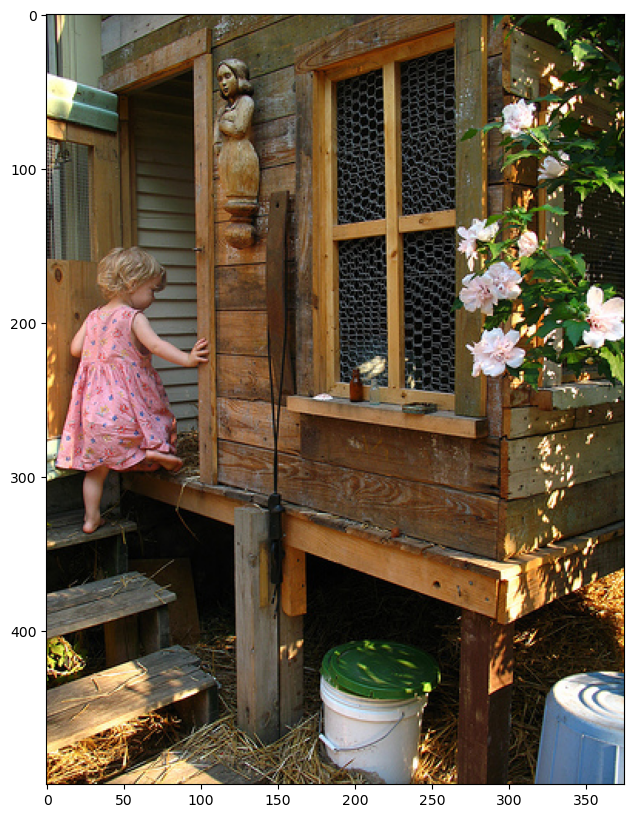

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
img_path='D:\\Major_Project\\Dataset1\\Images\\1000268201_693b08cb0e.jpg'

img=Image.open(img_path)
plt.imshow(img)
plt.show()

In [23]:
caption_dataset = tf.data.Dataset.from_tensor_slices(all_captions)

In [25]:
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs,
                                    r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

In [27]:
# Parameters for tokenizer
MAX_LENGTH = 50
VOCAB_SIZE = 5000

# Tokenizer
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_LENGTH)

# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [29]:
caption_vectors = caption_dataset.map(lambda x: tokenizer(x))

In [31]:
for cap in caption_vectors.take(1):
    print(cap)

tf.Tensor(
[  3   2  45   6   2  93 173   9 122  56   2 400  14 397   6  31   1 698
   5   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


In [33]:
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

In [35]:
# use for TF version < 2.8
def word2index(word):
    return tf.squeeze(word_to_index(tf.constant([word])))

def index2word(index):
    return tf.squeeze(index_to_word(tf.constant([index])))

In [37]:
all_image_paths

['D:\\Major_Project\\Dataset2\\Images\\1000268201_693b08cb0e.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1000268201_693b08cb0e.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1000268201_693b08cb0e.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1000268201_693b08cb0e.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1000268201_693b08cb0e.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1001773457_577c3a7d70.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1001773457_577c3a7d70.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1001773457_577c3a7d70.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1001773457_577c3a7d70.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1001773457_577c3a7d70.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1002674143_1b742ab4b8.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1002674143_1b742ab4b8.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1002674143_1b742ab4b8.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1002674143_1b742ab4b8.jpg',
 'D:\\Major_Project\\Dataset2\\Images\\1002674143_1b742ab4b8.j

# Image

In [39]:
# Get unique images
unique_image_paths = sorted(set(all_image_paths))
len(unique_image_paths)

8091

In [41]:
import tensorflow as tf
import numpy as np
import os
import cv2
import torch
from ultralytics import YOLO
from tqdm import tqdm

# Paths
feature_output_dir = "D:\\Major_Project\\features_try1"
os.makedirs(feature_output_dir, exist_ok=True)

In [42]:
# Load YOLOv8
yolo_model = YOLO("yolov8n.pt")


100%|██████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:06<00:00, 942kB/s]


In [182]:
# Load EfficientNetB7
image_model = tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet", pooling='avg')  # ➤ Output shape: (batch_size, 2560)

In [184]:
# Load Image for EfficientNetB7
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (600, 600))  # Required input for EfficientNetB7
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, image_path

In [186]:
# Extract YOLOv8 Features
def extract_yolo_features(image_path, max_yolo_length=1024):
    image = cv2.imread(image_path)
    results = yolo_model(image)

    yolo_features = []
    for result in results:
        yolo_features.append(result.boxes.data.cpu().numpy().flatten())

    yolo_features = np.concatenate(yolo_features, axis=0) if yolo_features else np.zeros(256)

    if yolo_features.shape[0] < max_yolo_length:
        yolo_features = np.pad(yolo_features, (0, max_yolo_length - yolo_features.shape[0]), 'constant')
    elif yolo_features.shape[0] > max_yolo_length:
        yolo_features = yolo_features[:max_yolo_length]

    return yolo_features  # Shape: (1024,)


In [188]:
# Get unique images
unique_image_paths = sorted(set(all_image_paths))
len(unique_image_paths)

8091

In [190]:
# Create Dataset
image_dataset = tf.data.Dataset.from_tensor_slices(unique_image_paths)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(2)


In [81]:
# Step 1: EfficientNetB7 Feature Extraction
print("\n🔹 Extracting EfficientNetB7 Features...")
for image_batch, path_batch in tqdm(image_dataset, total=len(unique_image_paths)//2):
    batch_features = image_features_extract_model(image_batch)  # Shape: (batch_size, 2560)

    for i, p in enumerate(path_batch.numpy()):
        image_path = p.decode("utf-8")
        feature_filename = os.path.join(feature_output_dir, os.path.basename(image_path).replace(".jpg", ".npy"))
        np.save(feature_filename, batch_features[i].numpy())  # Save 2560-dim feature

print("\n✅ EfficientNetB7 Extraction Complete.")



🔹 Extracting EfficientNetB7 Features...


4046it [5:56:36,  5.29s/it]                                                                                            


✅ EfficientNetB7 Extraction Complete.


In [82]:
# Step 2: YOLOv8 Feature Extraction & Merging
print("\n🔹 Extracting YOLOv8 Features & Merging...")
max_yolo_length = 1024

for image_path in tqdm(unique_image_paths):
    yolo_features = extract_yolo_features(image_path, max_yolo_length)

    feature_filename = os.path.join(feature_output_dir, os.path.basename(image_path).replace(".jpg", ".npy"))

    # Load EfficientNetB7 Features
    if os.path.exists(feature_filename):
        efficientnet_features = np.load(feature_filename)
    else:
        print(f"❌ Warning: {feature_filename} not found. Skipping.")
        continue

    # Merge Features: (2560,) + (1024,) → (3584,)
    combined_features = np.concatenate((efficientnet_features, yolo_features), axis=0)
    np.save(feature_filename, combined_features)  # Overwrite with combined features

print("\n✅ Feature Extraction & Merging Complete.")


🔹 Extracting YOLOv8 Features & Merging...


  0%|                                                                                         | 0/8091 [00:00<?, ?it/s]


0: 640x480 1 person, 1 potted plant, 2 toilets, 156.0ms
Speed: 20.9ms preprocess, 156.0ms inference, 12.8ms postprocess per image at shape (1, 3, 640, 480)


  0%|                                                                               | 1/8091 [00:02<5:08:00,  2.28s/it]


0: 480x640 2 dogs, 87.6ms
Speed: 9.7ms preprocess, 87.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  0%|                                                                               | 2/8091 [00:02<2:16:48,  1.01s/it]


0: 512x640 1 person, 1 kite, 93.0ms
Speed: 5.7ms preprocess, 93.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


  0%|                                                                               | 3/8091 [00:02<1:22:25,  1.64it/s]


0: 544x640 1 person, 2 benchs, 1 dog, 94.2ms
Speed: 6.0ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


  0%|                                                                                 | 4/8091 [00:02<56:35,  2.38it/s]


0: 608x640 2 persons, 98.9ms
Speed: 5.6ms preprocess, 98.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


  0%|                                                                                 | 5/8091 [00:02<42:35,  3.16it/s]


0: 448x640 1 person, 84.0ms
Speed: 5.9ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  0%|                                                                                 | 6/8091 [00:02<33:37,  4.01it/s]


0: 448x640 1 dog, 64.0ms
Speed: 8.4ms preprocess, 64.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 sports ball, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  0%|                                                                                 | 8/8091 [00:03<23:18,  5.78it/s]


0: 480x640 2 persons, 64.8ms
Speed: 2.3ms preprocess, 64.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 69.0ms
Speed: 3.4ms preprocess, 69.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


  0%|                                                                                | 10/8091 [00:03<19:12,  7.01it/s]


0: 576x640 1 dog, 97.4ms
Speed: 5.8ms preprocess, 97.4ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


  0%|                                                                                | 11/8091 [00:03<18:54,  7.12it/s]


0: 480x640 3 persons, 1 skis, 65.0ms
Speed: 3.9ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 5 persons, 77.5ms
Speed: 3.8ms preprocess, 77.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 448)


  0%|▏                                                                               | 13/8091 [00:03<16:50,  7.99it/s]


0: 640x640 1 car, 1 dog, 118.0ms
Speed: 8.1ms preprocess, 118.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  0%|▏                                                                               | 14/8091 [00:03<17:45,  7.58it/s]


0: 448x640 2 cars, 1 dog, 1 sports ball, 64.1ms
Speed: 5.2ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 1 sports ball, 78.8ms
Speed: 2.1ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


  0%|▏                                                                               | 16/8091 [00:03<16:05,  8.37it/s]


0: 480x640 3 persons, 62.4ms
Speed: 7.5ms preprocess, 62.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 60.0ms
Speed: 1.5ms preprocess, 60.0ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


  0%|▏                                                                               | 18/8091 [00:04<14:51,  9.05it/s]


0: 384x640 1 dog, 77.0ms
Speed: 5.0ms preprocess, 77.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  0%|▏                                                                               | 19/8091 [00:04<14:49,  9.07it/s]


0: 256x640 3 persons, 1 boat, 1 skis, 66.4ms
Speed: 1.8ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 2 dogs, 65.7ms
Speed: 3.8ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  0%|▏                                                                               | 21/8091 [00:04<14:13,  9.46it/s]


0: 640x448 1 person, 63.8ms
Speed: 1.5ms preprocess, 63.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 elephant, 62.9ms
Speed: 6.1ms preprocess, 62.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


  0%|▏                                                                               | 23/8091 [00:04<13:41,  9.82it/s]


0: 384x640 2 persons, 2 boats, 54.1ms
Speed: 1.6ms preprocess, 54.1ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 dogs, 1 frisbee, 64.0ms
Speed: 4.8ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  0%|▏                                                                               | 25/8091 [00:04<13:13, 10.17it/s]


0: 480x640 1 person, 1 baseball bat, 62.4ms
Speed: 6.8ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 2 backpacks, 64.9ms
Speed: 3.2ms preprocess, 64.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


  0%|▎                                                                               | 27/8091 [00:05<13:05, 10.27it/s]


0: 288x640 4 persons, 1 truck, 68.2ms
Speed: 1.5ms preprocess, 68.2ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 1 person, 1 dog, 3 sheeps, 55.8ms
Speed: 7.5ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  0%|▎                                                                               | 29/8091 [00:05<12:42, 10.57it/s]


0: 640x480 1 person, 5 clocks, 54.0ms
Speed: 3.3ms preprocess, 54.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 pizza, 54.0ms
Speed: 4.7ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  0%|▎                                                                               | 31/8091 [00:05<12:18, 10.91it/s]


0: 480x640 3 persons, 54.8ms
Speed: 6.7ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 6 persons, 10 boats, 55.2ms
Speed: 1.4ms preprocess, 55.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


  0%|▎                                                                               | 33/8091 [00:05<12:04, 11.12it/s]


0: 448x640 3 persons, 52.3ms
Speed: 1.0ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 tv, 55.3ms
Speed: 3.8ms preprocess, 55.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


  0%|▎                                                                               | 35/8091 [00:05<11:41, 11.49it/s]


0: 448x640 14 persons, 53.4ms
Speed: 5.8ms preprocess, 53.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 2 skateboards, 56.0ms
Speed: 3.9ms preprocess, 56.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


  0%|▎                                                                               | 37/8091 [00:05<11:26, 11.73it/s]


0: 480x640 1 person, 55.3ms
Speed: 1.8ms preprocess, 55.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 48.7ms
Speed: 1.4ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  0%|▍                                                                               | 39/8091 [00:06<11:20, 11.84it/s]


0: 480x640 4 persons, 50.2ms
Speed: 2.4ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 50.4ms
Speed: 2.2ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▍                                                                               | 41/8091 [00:06<11:15, 11.91it/s]


0: 640x448 2 persons, 50.1ms
Speed: 1.5ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 2 cars, 51.5ms
Speed: 4.7ms preprocess, 51.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


  1%|▍                                                                               | 43/8091 [00:06<10:58, 12.23it/s]


0: 640x480 2 persons, 1 couch, 1 laptop, 1 book, 54.5ms
Speed: 2.6ms preprocess, 54.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 3 dogs, 55.0ms
Speed: 1.4ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▍                                                                               | 45/8091 [00:06<11:05, 12.08it/s]


0: 544x640 3 persons, 1 bench, 58.6ms
Speed: 3.0ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 person, 43.8ms
Speed: 5.2ms preprocess, 43.8ms inference, 8.5ms postprocess per image at shape (1, 3, 448, 640)


  1%|▍                                                                               | 47/8091 [00:06<11:02, 12.15it/s]


0: 640x640 1 dog, 70.5ms
Speed: 8.1ms preprocess, 70.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 3 persons, 50.0ms
Speed: 2.6ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  1%|▍                                                                               | 49/8091 [00:06<11:16, 11.89it/s]


0: 640x480 1 person, 50.7ms
Speed: 2.0ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 dog, 1 frisbee, 67.8ms
Speed: 2.7ms preprocess, 67.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|▌                                                                               | 51/8091 [00:07<11:30, 11.64it/s]


0: 480x640 1 person, 5 cars, 2 trucks, 55.1ms
Speed: 2.3ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 52.7ms
Speed: 2.1ms preprocess, 52.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  1%|▌                                                                               | 53/8091 [00:07<11:08, 12.03it/s]


0: 640x448 1 dog, 1 sports ball, 50.2ms
Speed: 2.2ms preprocess, 50.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 11 persons, 1 umbrella, 55.0ms
Speed: 2.7ms preprocess, 55.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


  1%|▌                                                                               | 55/8091 [00:07<11:02, 12.12it/s]


0: 640x448 1 person, 1 bicycle, 46.2ms
Speed: 3.4ms preprocess, 46.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 7 persons, 49.8ms
Speed: 2.4ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  1%|▌                                                                               | 57/8091 [00:07<10:49, 12.37it/s]


0: 448x640 1 person, 2 dogs, 1 kite, 50.8ms
Speed: 6.2ms preprocess, 50.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 5 persons, 84.4ms
Speed: 5.2ms preprocess, 84.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


  1%|▌                                                                               | 59/8091 [00:07<11:23, 11.76it/s]


0: 480x640 1 person, 1 boat, 1 surfboard, 53.2ms
Speed: 4.9ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 49.8ms
Speed: 1.4ms preprocess, 49.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)


  1%|▌                                                                               | 61/8091 [00:07<11:12, 11.93it/s]


0: 480x640 3 persons, 52.9ms
Speed: 1.5ms preprocess, 52.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 3 horses, 48.7ms
Speed: 1.6ms preprocess, 48.7ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)


  1%|▌                                                                               | 63/8091 [00:08<10:53, 12.28it/s]


0: 448x640 1 bicycle, 2 dogs, 2 horses, 1 chair, 50.9ms
Speed: 2.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 bench, 51.5ms
Speed: 2.4ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▋                                                                               | 65/8091 [00:08<11:13, 11.91it/s]


0: 480x640 1 dog, 53.2ms
Speed: 1.5ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 52.5ms
Speed: 2.5ms preprocess, 52.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


  1%|▋                                                                               | 67/8091 [00:08<10:57, 12.21it/s]


0: 448x640 2 persons, 49.7ms
Speed: 5.6ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 motorcycle, 53.7ms
Speed: 2.3ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▋                                                                               | 69/8091 [00:08<10:55, 12.23it/s]


0: 640x640 5 persons, 1 car, 1 handbag, 68.1ms
Speed: 2.1ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 persons, 1 backpack, 1 skis, 55.7ms
Speed: 2.0ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▋                                                                               | 71/8091 [00:08<11:19, 11.80it/s]


0: 480x640 2 persons, 54.0ms
Speed: 5.2ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 65.6ms
Speed: 2.4ms preprocess, 65.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


  1%|▋                                                                               | 73/8091 [00:08<11:19, 11.80it/s]


0: 448x640 6 persons, 3 handbags, 49.2ms
Speed: 1.4ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 horse, 54.4ms
Speed: 2.3ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  1%|▋                                                                               | 75/8091 [00:09<11:13, 11.91it/s]


0: 640x480 1 person, 2 horses, 52.4ms
Speed: 2.1ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 (no detections), 51.2ms
Speed: 2.6ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  1%|▊                                                                               | 77/8091 [00:09<11:06, 12.02it/s]


0: 480x640 5 persons, 1 sports ball, 54.0ms
Speed: 2.3ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 backpacks, 54.0ms
Speed: 3.4ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▊                                                                               | 79/8091 [00:09<11:06, 12.01it/s]


0: 640x480 2 persons, 1 kite, 1 potted plant, 55.8ms
Speed: 2.8ms preprocess, 55.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 bench, 1 dog, 5 chairs, 56.0ms
Speed: 4.2ms preprocess, 56.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


  1%|▊                                                                               | 81/8091 [00:09<11:03, 12.07it/s]


0: 480x640 2 persons, 1 giraffe, 46.6ms
Speed: 4.1ms preprocess, 46.6ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 cat, 1 dog, 1 couch, 79.5ms
Speed: 1.5ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


  1%|▊                                                                               | 83/8091 [00:09<11:26, 11.67it/s]


0: 640x512 3 dogs, 85.4ms
Speed: 2.1ms preprocess, 85.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 1 person, 1 surfboard, 50.5ms
Speed: 2.3ms preprocess, 50.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 480)


  1%|▊                                                                               | 85/8091 [00:09<11:48, 11.30it/s]


0: 448x640 1 dog, 50.3ms
Speed: 1.9ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 51.2ms
Speed: 2.0ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▊                                                                               | 87/8091 [00:10<11:33, 11.54it/s]


0: 480x640 1 person, 1 backpack, 1 wine glass, 51.3ms
Speed: 1.7ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 53.1ms
Speed: 2.5ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  1%|▉                                                                               | 89/8091 [00:10<11:22, 11.73it/s]


0: 480x640 1 person, 54.4ms
Speed: 2.4ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 motorcycles, 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▉                                                                               | 91/8091 [00:10<11:15, 11.85it/s]


0: 448x640 2 persons, 1 motorcycle, 52.6ms
Speed: 4.8ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 motorcycle, 48.0ms
Speed: 1.6ms preprocess, 48.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


  1%|▉                                                                               | 93/8091 [00:10<10:58, 12.15it/s]


0: 448x640 1 person, 1 motorcycle, 49.0ms
Speed: 6.2ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 49.4ms
Speed: 4.7ms preprocess, 49.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


  1%|▉                                                                               | 95/8091 [00:10<10:40, 12.48it/s]


0: 448x640 6 persons, 2 benchs, 1 sports ball, 51.6ms
Speed: 1.5ms preprocess, 51.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 refrigerator, 54.1ms
Speed: 1.4ms preprocess, 54.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  1%|▉                                                                               | 97/8091 [00:10<10:39, 12.50it/s]


0: 480x640 1 person, 2 bicycles, 48.4ms
Speed: 2.4ms preprocess, 48.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 2 dogs, 1 cow, 49.6ms
Speed: 2.7ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  1%|▉                                                                               | 99/8091 [00:11<10:35, 12.57it/s]


0: 480x640 1 person, 1 cell phone, 51.3ms
Speed: 1.7ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 14 persons, 1 dog, 1 frisbee, 52.1ms
Speed: 1.5ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|▉                                                                              | 101/8091 [00:11<10:44, 12.39it/s]


0: 640x448 1 person, 50.5ms
Speed: 1.5ms preprocess, 50.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 55.9ms
Speed: 5.5ms preprocess, 55.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


  1%|█                                                                              | 103/8091 [00:11<10:37, 12.54it/s]


0: 640x448 1 person, 1 elephant, 48.7ms
Speed: 2.1ms preprocess, 48.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 51.0ms
Speed: 2.1ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  1%|█                                                                              | 105/8091 [00:11<10:28, 12.72it/s]


0: 448x640 2 persons, 49.0ms
Speed: 2.1ms preprocess, 49.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 (no detections), 49.1ms
Speed: 2.1ms preprocess, 49.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|█                                                                              | 107/8091 [00:11<10:30, 12.66it/s]


0: 448x640 1 person, 1 bird, 1 chair, 50.2ms
Speed: 2.1ms preprocess, 50.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 53.2ms
Speed: 4.9ms preprocess, 53.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  1%|█                                                                              | 109/8091 [00:11<10:24, 12.77it/s]


0: 640x448 1 person, 49.2ms
Speed: 2.2ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 dog, 1 cow, 48.2ms
Speed: 1.8ms preprocess, 48.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


  1%|█                                                                              | 111/8091 [00:11<10:18, 12.91it/s]


0: 480x640 1 dog, 52.6ms
Speed: 3.5ms preprocess, 52.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 46.6ms
Speed: 4.2ms preprocess, 46.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  1%|█                                                                              | 113/8091 [00:12<10:27, 12.71it/s]


0: 640x480 1 person, 1 bed, 50.1ms
Speed: 2.2ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 1 person, 1 surfboard, 64.5ms
Speed: 2.0ms preprocess, 64.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


  1%|█                                                                              | 115/8091 [00:12<10:43, 12.39it/s]


0: 448x640 3 persons, 4 motorcycles, 49.7ms
Speed: 5.7ms preprocess, 49.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 49.7ms
Speed: 2.1ms preprocess, 49.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


  1%|█▏                                                                             | 117/8091 [00:12<10:43, 12.40it/s]


0: 480x640 1 person, 1 bicycle, 1 chair, 1 potted plant, 53.5ms
Speed: 3.2ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 49.3ms
Speed: 3.4ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  1%|█▏                                                                             | 119/8091 [00:12<10:33, 12.59it/s]


0: 448x640 7 persons, 1 car, 1 teddy bear, 49.1ms
Speed: 5.5ms preprocess, 49.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 49.8ms
Speed: 1.8ms preprocess, 49.8ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


  1%|█▏                                                                             | 121/8091 [00:12<10:24, 12.76it/s]


0: 448x640 1 dog, 1 elephant, 47.3ms
Speed: 3.7ms preprocess, 47.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 dog, 48.7ms
Speed: 1.8ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▏                                                                             | 123/8091 [00:12<10:27, 12.69it/s]


0: 640x480 1 person, 1 bench, 55.5ms
Speed: 1.2ms preprocess, 55.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 bear, 51.6ms
Speed: 4.8ms preprocess, 51.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▏                                                                             | 125/8091 [00:13<10:24, 12.75it/s]


0: 448x640 2 persons, 2 backpacks, 49.7ms
Speed: 5.4ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bed, 49.0ms
Speed: 2.1ms preprocess, 49.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


  2%|█▏                                                                             | 127/8091 [00:13<10:18, 12.89it/s]


0: 448x640 2 persons, 3 beds, 1 remote, 50.0ms
Speed: 1.4ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 4 persons, 1 kite, 54.4ms
Speed: 3.1ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


  2%|█▎                                                                             | 129/8091 [00:13<10:27, 12.69it/s]


0: 480x640 3 persons, 51.9ms
Speed: 2.1ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 car, 44.9ms
Speed: 5.0ms preprocess, 44.9ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▎                                                                             | 131/8091 [00:13<11:17, 11.75it/s]


0: 640x608 2 persons, 86.1ms
Speed: 1.5ms preprocess, 86.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 6 persons, 1 truck, 1 backpack, 2 handbags, 82.1ms
Speed: 9.2ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


  2%|█▎                                                                             | 133/8091 [00:13<13:34,  9.77it/s]


0: 448x640 10 persons, 45.6ms
Speed: 1.9ms preprocess, 45.6ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 4 cars, 50.1ms
Speed: 2.0ms preprocess, 50.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 448)


  2%|█▎                                                                             | 135/8091 [00:14<12:41, 10.45it/s]


0: 448x640 5 persons, 1 bicycle, 4 cars, 2 trucks, 46.5ms
Speed: 4.1ms preprocess, 46.5ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 2 bicycles, 2 cars, 51.4ms
Speed: 3.8ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▎                                                                             | 137/8091 [00:14<11:56, 11.09it/s]


0: 640x448 2 persons, 1 car, 2 potted plants, 50.0ms
Speed: 1.5ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 4 bicycles, 2 cars, 2 traffic lights, 1 backpack, 48.6ms
Speed: 3.3ms preprocess, 48.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  2%|█▎                                                                             | 139/8091 [00:14<11:22, 11.66it/s]


0: 416x640 1 person, 1 horse, 46.3ms
Speed: 1.9ms preprocess, 46.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 3 persons, 1 sports ball, 2 baseball bats, 49.7ms
Speed: 6.1ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▍                                                                             | 141/8091 [00:14<10:58, 12.07it/s]


0: 640x448 1 person, 49.8ms
Speed: 1.3ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 5 persons, 1 sports ball, 84.7ms
Speed: 3.1ms preprocess, 84.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


  2%|█▍                                                                             | 143/8091 [00:14<11:27, 11.55it/s]


0: 448x640 13 persons, 4 cups, 1 chair, 2 dining tables, 44.9ms
Speed: 4.9ms preprocess, 44.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 4 backpacks, 1 snowboard, 48.7ms
Speed: 2.0ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▍                                                                             | 145/8091 [00:14<11:12, 11.81it/s]


0: 640x480 2 persons, 1 baseball glove, 48.9ms
Speed: 1.9ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 bench, 52.5ms
Speed: 3.6ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▍                                                                             | 147/8091 [00:15<11:01, 12.01it/s]


0: 480x640 3 persons, 53.5ms
Speed: 3.1ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 frisbee, 49.2ms
Speed: 1.5ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▍                                                                             | 149/8091 [00:15<10:48, 12.25it/s]


0: 640x448 2 persons, 50.4ms
Speed: 4.4ms preprocess, 50.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 (no detections), 75.5ms
Speed: 3.3ms preprocess, 75.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


  2%|█▍                                                                             | 151/8091 [00:15<11:10, 11.84it/s]


0: 480x640 1 person, 1 dog, 1 bed, 1 teddy bear, 50.6ms
Speed: 1.9ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 48.7ms
Speed: 1.5ms preprocess, 48.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▍                                                                             | 153/8091 [00:15<10:50, 12.20it/s]


0: 448x640 1 person, 48.9ms
Speed: 1.5ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 1 tv, 1 laptop, 48.0ms
Speed: 1.5ms preprocess, 48.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▌                                                                             | 155/8091 [00:15<10:34, 12.51it/s]


0: 480x640 2 dogs, 50.0ms
Speed: 2.5ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 50.2ms
Speed: 0.9ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▌                                                                             | 157/8091 [00:15<10:28, 12.62it/s]


0: 448x640 13 persons, 1 traffic light, 48.9ms
Speed: 1.4ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 dog, 1 sports ball, 70.3ms
Speed: 1.4ms preprocess, 70.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  2%|█▌                                                                             | 159/8091 [00:16<11:15, 11.75it/s]


0: 640x512 2 persons, 57.3ms
Speed: 5.8ms preprocess, 57.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 boat, 1 dog, 49.7ms
Speed: 3.0ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▌                                                                             | 161/8091 [00:16<11:04, 11.93it/s]


0: 480x640 13 persons, 1 skateboard, 52.8ms
Speed: 4.1ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 49.8ms
Speed: 1.3ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▌                                                                             | 163/8091 [00:16<10:48, 12.23it/s]


0: 384x640 1 cow, 59.2ms
Speed: 1.4ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 dog, 1 chair, 1 bed, 50.2ms
Speed: 2.0ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▌                                                                             | 165/8091 [00:16<11:08, 11.85it/s]


0: 480x640 1 dog, 51.5ms
Speed: 5.7ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 1 dog, 1 sheep, 1 frisbee, 49.5ms
Speed: 1.7ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▋                                                                             | 167/8091 [00:16<10:57, 12.05it/s]


0: 512x640 1 person, 1 tv, 55.9ms
Speed: 1.6ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 12 persons, 2 bicycles, 1 skateboard, 66.9ms
Speed: 7.6ms preprocess, 66.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  2%|█▋                                                                             | 169/8091 [00:16<11:07, 11.86it/s]


0: 448x640 1 person, 1 boat, 49.6ms
Speed: 5.1ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bench, 49.9ms
Speed: 1.5ms preprocess, 49.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▋                                                                             | 171/8091 [00:17<10:55, 12.07it/s]


0: 640x480 4 persons, 2 handbags, 53.6ms
Speed: 1.3ms preprocess, 53.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 4 benchs, 48.6ms
Speed: 2.0ms preprocess, 48.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


  2%|█▋                                                                             | 173/8091 [00:17<10:43, 12.31it/s]


0: 448x640 1 cow, 48.2ms
Speed: 2.4ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 persons, 1 umbrella, 40.6ms
Speed: 2.5ms preprocess, 40.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


  2%|█▋                                                                             | 175/8091 [00:17<10:28, 12.60it/s]


0: 448x640 7 persons, 50.2ms
Speed: 1.0ms preprocess, 50.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 320x640 2 persons, 12 cars, 1 truck, 60.4ms
Speed: 3.8ms preprocess, 60.4ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


  2%|█▋                                                                             | 177/8091 [00:17<10:31, 12.52it/s]


0: 416x640 4 persons, 48.3ms
Speed: 2.3ms preprocess, 48.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 (no detections), 53.0ms
Speed: 1.5ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▋                                                                             | 179/8091 [00:17<10:23, 12.68it/s]


0: 640x480 2 persons, 1 boat, 51.7ms
Speed: 1.5ms preprocess, 51.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 50.1ms
Speed: 4.9ms preprocess, 50.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▊                                                                             | 181/8091 [00:17<10:16, 12.83it/s]


0: 448x640 1 person, 50.0ms
Speed: 3.3ms preprocess, 50.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 3 chairs, 1 toothbrush, 52.9ms
Speed: 5.3ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▊                                                                             | 183/8091 [00:17<10:21, 12.72it/s]


0: 448x640 4 persons, 6 cars, 45.3ms
Speed: 5.0ms preprocess, 45.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 bears, 49.9ms
Speed: 2.7ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▊                                                                             | 185/8091 [00:18<10:17, 12.80it/s]


0: 480x640 1 dog, 49.3ms
Speed: 1.4ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 2 couchs, 1 teddy bear, 51.1ms
Speed: 2.1ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  2%|█▊                                                                             | 187/8091 [00:18<10:31, 12.52it/s]


0: 480x640 2 persons, 53.5ms
Speed: 2.3ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 horse, 53.6ms
Speed: 3.1ms preprocess, 53.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


  2%|█▊                                                                             | 189/8091 [00:18<10:33, 12.46it/s]


0: 448x640 1 person, 7 bottles, 3 cups, 49.1ms
Speed: 1.6ms preprocess, 49.1ms inference, 3.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 52.1ms
Speed: 4.5ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▊                                                                             | 191/8091 [00:18<10:26, 12.60it/s]


0: 448x640 2 persons, 50.9ms
Speed: 3.1ms preprocess, 50.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 chair, 45.2ms
Speed: 5.3ms preprocess, 45.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  2%|█▉                                                                             | 193/8091 [00:18<10:27, 12.59it/s]


0: 640x448 1 person, 48.2ms
Speed: 2.5ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 48.4ms
Speed: 1.9ms preprocess, 48.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  2%|█▉                                                                             | 195/8091 [00:18<11:23, 11.55it/s]


0: 416x640 5 persons, 1 umbrella, 48.5ms
Speed: 2.0ms preprocess, 48.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 dogs, 48.7ms
Speed: 2.2ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▉                                                                             | 197/8091 [00:19<11:04, 11.88it/s]


0: 416x640 10 persons, 1 sports ball, 1 baseball bat, 1 tennis racket, 47.0ms
Speed: 2.7ms preprocess, 47.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 224x640 1 person, 1 dog, 49.8ms
Speed: 2.6ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)


  2%|█▉                                                                             | 199/8091 [00:19<10:43, 12.26it/s]


0: 448x640 2 horses, 49.4ms
Speed: 1.4ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 1 chair, 1 bed, 53.5ms
Speed: 5.8ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  2%|█▉                                                                             | 201/8091 [00:19<10:45, 12.23it/s]


0: 480x640 3 persons, 53.2ms
Speed: 1.4ms preprocess, 53.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 3 persons, 61.1ms
Speed: 7.6ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  3%|█▉                                                                             | 203/8091 [00:19<11:06, 11.84it/s]


0: 640x448 1 person, 1 car, 50.2ms
Speed: 2.2ms preprocess, 50.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 1 backpack, 53.8ms
Speed: 5.0ms preprocess, 53.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


  3%|██                                                                             | 205/8091 [00:19<10:47, 12.19it/s]


0: 448x640 2 persons, 46.1ms
Speed: 4.6ms preprocess, 46.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 52.2ms
Speed: 2.0ms preprocess, 52.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


  3%|██                                                                             | 207/8091 [00:19<10:38, 12.36it/s]


0: 640x480 1 person, 1 bicycle, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 4 persons, 56.3ms
Speed: 1.7ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  3%|██                                                                             | 209/8091 [00:20<10:54, 12.04it/s]


0: 640x544 1 person, 1 sports ball, 61.8ms
Speed: 4.4ms preprocess, 61.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 cat, 1 dog, 52.3ms
Speed: 2.5ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  3%|██                                                                             | 211/8091 [00:20<11:35, 11.33it/s]


0: 640x480 9 persons, 2 cars, 1 motorcycle, 53.8ms
Speed: 1.8ms preprocess, 53.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 2 persons, 1 motorcycle, 49.9ms
Speed: 2.3ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  3%|██                                                                             | 213/8091 [00:20<11:16, 11.64it/s]


0: 480x640 2 persons, 3 cars, 52.1ms
Speed: 2.5ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 bicycle, 49.1ms
Speed: 1.7ms preprocess, 49.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  3%|██                                                                             | 215/8091 [00:20<11:04, 11.86it/s]


0: 480x640 3 persons, 1 chair, 54.2ms
Speed: 3.4ms preprocess, 54.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 48.9ms
Speed: 2.7ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  3%|██                                                                             | 217/8091 [00:20<10:46, 12.17it/s]


0: 448x640 1 person, 48.6ms
Speed: 5.4ms preprocess, 48.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 5 persons, 6 benchs, 3 umbrellas, 1 bottle, 2 chairs, 2 potted plants, 1 clock, 45.4ms
Speed: 5.8ms preprocess, 45.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


  3%|██▏                                                                            | 219/8091 [00:20<10:27, 12.55it/s]


0: 480x640 11 persons, 1 bench, 53.3ms
Speed: 3.4ms preprocess, 53.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 2 cars, 49.7ms
Speed: 1.3ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▏                                                                            | 221/8091 [00:21<10:21, 12.66it/s]


0: 544x640 1 person, 1 car, 1 bench, 1 handbag, 59.1ms
Speed: 6.4ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 6 persons, 1 dog, 46.5ms
Speed: 4.8ms preprocess, 46.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▏                                                                            | 223/8091 [00:21<10:28, 12.52it/s]


0: 640x448 1 person, 1 bicycle, 50.6ms
Speed: 2.0ms preprocess, 50.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 couch, 46.8ms
Speed: 3.4ms preprocess, 46.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▏                                                                            | 225/8091 [00:21<10:17, 12.75it/s]


0: 480x640 1 person, 49.9ms
Speed: 2.6ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 cow, 50.7ms
Speed: 1.9ms preprocess, 50.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▏                                                                            | 227/8091 [00:21<10:20, 12.68it/s]


0: 480x640 1 person, 1 sports ball, 53.3ms
Speed: 6.4ms preprocess, 53.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 wine glass, 1 cup, 1 bowl, 1 cake, 1 dining table, 54.9ms
Speed: 1.9ms preprocess, 54.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▏                                                                            | 229/8091 [00:21<10:25, 12.57it/s]


0: 640x640 2 dogs, 68.2ms
Speed: 3.1ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 14 persons, 53.5ms
Speed: 3.9ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▎                                                                            | 231/8091 [00:21<10:50, 12.08it/s]


0: 480x640 6 persons, 1 frisbee, 49.2ms
Speed: 1.7ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 54.7ms
Speed: 1.8ms preprocess, 54.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▎                                                                            | 233/8091 [00:22<10:44, 12.20it/s]


0: 640x480 1 person, 53.1ms
Speed: 4.1ms preprocess, 53.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 48.4ms
Speed: 1.4ms preprocess, 48.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▎                                                                            | 235/8091 [00:22<10:39, 12.28it/s]


0: 448x640 1 person, 1 suitcase, 1 sports ball, 50.5ms
Speed: 1.9ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 boat, 51.4ms
Speed: 6.8ms preprocess, 51.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▎                                                                            | 237/8091 [00:22<10:29, 12.48it/s]


0: 448x640 3 persons, 1 boat, 1 surfboard, 45.8ms
Speed: 4.6ms preprocess, 45.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 12 persons, 1 bicycle, 1 handbag, 48.8ms
Speed: 3.0ms preprocess, 48.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▎                                                                            | 239/8091 [00:22<10:23, 12.59it/s]


0: 480x640 15 persons, 1 potted plant, 53.4ms
Speed: 6.5ms preprocess, 53.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 46.2ms
Speed: 4.0ms preprocess, 46.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▎                                                                            | 241/8091 [00:22<10:19, 12.67it/s]


0: 448x640 9 persons, 49.4ms
Speed: 1.5ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 bench, 54.0ms
Speed: 3.7ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▎                                                                            | 243/8091 [00:22<10:27, 12.52it/s]


0: 480x640 1 dog, 48.9ms
Speed: 3.4ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 6 dogs, 45.2ms
Speed: 1.5ms preprocess, 45.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


  3%|██▍                                                                            | 245/8091 [00:23<11:13, 11.65it/s]


0: 640x448 1 person, 51.1ms
Speed: 1.9ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 1 cat, 1 dog, 39.9ms
Speed: 3.3ms preprocess, 39.9ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)


  3%|██▍                                                                            | 247/8091 [00:23<10:51, 12.04it/s]


0: 384x640 2 dogs, 38.4ms
Speed: 1.7ms preprocess, 38.4ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 dog, 56.0ms
Speed: 2.3ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▍                                                                            | 249/8091 [00:23<10:33, 12.37it/s]


0: 384x640 1 dog, 1 bear, 1 frisbee, 4 potted plants, 44.7ms
Speed: 5.4ms preprocess, 44.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x608 1 dog, 1 frisbee, 1 sports ball, 82.9ms
Speed: 3.6ms preprocess, 82.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 608)


  3%|██▍                                                                            | 251/8091 [00:23<11:08, 11.73it/s]


0: 480x640 1 person, 55.1ms
Speed: 4.5ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 2 persons, 2 dogs, 1 handbag, 54.6ms
Speed: 6.7ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


  3%|██▍                                                                            | 253/8091 [00:23<11:08, 11.72it/s]


0: 448x640 5 persons, 3 handbags, 1 bottle, 5 chairs, 4 cell phones, 51.7ms
Speed: 2.2ms preprocess, 51.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 49.2ms
Speed: 2.0ms preprocess, 49.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


  3%|██▍                                                                            | 255/8091 [00:23<11:13, 11.64it/s]


0: 640x256 6 persons, 46.1ms
Speed: 3.1ms preprocess, 46.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x352 10 persons, 1 handbag, 61.0ms
Speed: 1.3ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)


  3%|██▌                                                                            | 257/8091 [00:24<11:00, 11.85it/s]


0: 480x640 1 person, 1 backpack, 1 handbag, 52.7ms
Speed: 4.9ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 49.4ms
Speed: 1.3ms preprocess, 49.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


  3%|██▌                                                                            | 259/8091 [00:24<10:48, 12.07it/s]


0: 480x640 4 persons, 1 chair, 55.0ms
Speed: 3.2ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 person, 75.2ms
Speed: 1.5ms preprocess, 75.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 512)


  3%|██▌                                                                            | 261/8091 [00:24<11:13, 11.63it/s]


0: 640x512 2 persons, 1 tie, 54.5ms
Speed: 4.5ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 persons, 46.2ms
Speed: 3.7ms preprocess, 46.2ms inference, 5.8ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▌                                                                            | 263/8091 [00:24<10:49, 12.05it/s]


0: 480x640 3 persons, 49.0ms
Speed: 1.5ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 50.5ms
Speed: 2.2ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  3%|██▌                                                                            | 265/8091 [00:24<10:48, 12.06it/s]


0: 480x640 6 persons, 1 motorcycle, 4 umbrellas, 50.9ms
Speed: 2.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 sports ball, 52.4ms
Speed: 3.0ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  3%|██▌                                                                            | 267/8091 [00:24<10:46, 12.11it/s]


0: 608x640 1 person, 85.3ms
Speed: 5.2ms preprocess, 85.3ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)

0: 544x640 1 person, 59.0ms
Speed: 2.4ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


  3%|██▋                                                                            | 269/8091 [00:25<11:26, 11.39it/s]


0: 640x480 1 person, 58.3ms
Speed: 6.4ms preprocess, 58.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 9 persons, 1 umbrella, 1 handbag, 51.9ms
Speed: 1.4ms preprocess, 51.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▋                                                                            | 271/8091 [00:25<11:06, 11.74it/s]


0: 448x640 3 persons, 49.2ms
Speed: 2.2ms preprocess, 49.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 horse, 2 sheeps, 1 giraffe, 55.0ms
Speed: 1.6ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▋                                                                            | 273/8091 [00:25<10:56, 11.91it/s]


0: 640x512 2 persons, 2 surfboards, 55.3ms
Speed: 1.2ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 352x640 2 persons, 65.8ms
Speed: 1.6ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


  3%|██▋                                                                            | 275/8091 [00:25<11:01, 11.82it/s]


0: 640x448 1 dog, 1 bear, 46.2ms
Speed: 4.3ms preprocess, 46.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 1 person, 59.0ms
Speed: 6.5ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


  3%|██▋                                                                            | 277/8091 [00:25<11:02, 11.79it/s]


0: 448x640 1 person, 47.9ms
Speed: 2.9ms preprocess, 47.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 53.1ms
Speed: 2.2ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  3%|██▋                                                                            | 279/8091 [00:25<10:46, 12.08it/s]


0: 448x640 2 persons, 1 boat, 50.3ms
Speed: 4.6ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 49.6ms
Speed: 1.8ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  3%|██▋                                                                            | 281/8091 [00:26<10:28, 12.42it/s]


0: 448x640 (no detections), 50.9ms
Speed: 3.9ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 58.2ms
Speed: 1.4ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  3%|██▊                                                                            | 283/8091 [00:26<10:28, 12.43it/s]


0: 480x640 1 horse, 2 cows, 1 surfboard, 53.4ms
Speed: 5.2ms preprocess, 53.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 55.0ms
Speed: 4.9ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  4%|██▊                                                                            | 285/8091 [00:26<10:29, 12.40it/s]


0: 448x640 2 persons, 44.1ms
Speed: 5.4ms preprocess, 44.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 67.9ms
Speed: 1.9ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


  4%|██▊                                                                            | 287/8091 [00:26<10:43, 12.13it/s]


0: 640x480 3 persons, 56.9ms
Speed: 5.0ms preprocess, 56.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 56.9ms
Speed: 5.0ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  4%|██▊                                                                            | 289/8091 [00:26<10:37, 12.24it/s]


0: 640x448 1 person, 51.9ms
Speed: 4.7ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 55.8ms
Speed: 3.0ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  4%|██▊                                                                            | 291/8091 [00:26<10:35, 12.27it/s]


0: 480x640 6 persons, 53.6ms
Speed: 1.8ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 6 persons, 1 handbag, 82.6ms
Speed: 3.1ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  4%|██▊                                                                            | 293/8091 [00:27<11:19, 11.48it/s]


0: 448x640 3 persons, 48.6ms
Speed: 2.0ms preprocess, 48.6ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 43.7ms
Speed: 5.6ms preprocess, 43.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


  4%|██▉                                                                            | 295/8091 [00:27<10:48, 12.03it/s]


0: 480x640 2 persons, 51.3ms
Speed: 1.9ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 5 cars, 1 traffic light, 51.2ms
Speed: 2.2ms preprocess, 51.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


  4%|██▉                                                                            | 297/8091 [00:27<10:36, 12.24it/s]


0: 448x640 1 dog, 50.0ms
Speed: 5.2ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 6 persons, 2 ties, 50.7ms
Speed: 1.5ms preprocess, 50.7ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 640)


  4%|██▉                                                                            | 299/8091 [00:27<10:36, 12.25it/s]


0: 512x640 6 persons, 1 bench, 74.7ms
Speed: 1.6ms preprocess, 74.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 (no detections), 55.1ms
Speed: 4.2ms preprocess, 55.1ms inference, 4.4ms postprocess per image at shape (1, 3, 544, 640)


  4%|██▉                                                                            | 301/8091 [00:27<10:58, 11.83it/s]


0: 640x512 3 persons, 57.2ms
Speed: 2.6ms preprocess, 57.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 1 person, 48.9ms
Speed: 2.8ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  4%|██▉                                                                            | 303/8091 [00:27<10:52, 11.93it/s]


0: 448x640 1 person, 50.6ms
Speed: 1.5ms preprocess, 50.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 3 persons, 55.3ms
Speed: 5.7ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


  4%|██▉                                                                            | 305/8091 [00:28<10:43, 12.10it/s]


0: 480x640 3 persons, 2 cars, 1 truck, 2 baseball bats, 54.1ms
Speed: 5.9ms preprocess, 54.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 potted plant, 53.6ms
Speed: 2.1ms preprocess, 53.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  4%|██▉                                                                            | 307/8091 [00:28<10:39, 12.17it/s]


0: 640x640 1 person, 1 teddy bear, 67.0ms
Speed: 5.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 52.7ms
Speed: 5.7ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  4%|███                                                                            | 309/8091 [00:28<11:00, 11.77it/s]


0: 480x640 2 dogs, 52.8ms
Speed: 3.6ms preprocess, 52.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 4 persons, 80.9ms
Speed: 3.4ms preprocess, 80.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


  4%|███                                                                            | 311/8091 [00:28<11:25, 11.36it/s]


0: 320x640 1 dog, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 640x448 5 persons, 46.1ms
Speed: 3.9ms preprocess, 46.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  4%|███                                                                            | 313/8091 [00:28<11:00, 11.78it/s]


0: 640x480 4 persons, 1 car, 1 tie, 50.3ms
Speed: 2.1ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 kite, 3 surfboards, 50.3ms
Speed: 4.8ms preprocess, 50.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


  4%|███                                                                            | 315/8091 [00:28<11:00, 11.78it/s]


0: 640x448 1 person, 1 fire hydrant, 1 skateboard, 50.3ms
Speed: 4.8ms preprocess, 50.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 dog, 54.5ms
Speed: 1.9ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  4%|███                                                                            | 317/8091 [00:29<10:52, 11.91it/s]


0: 416x640 3 persons, 48.7ms
Speed: 1.9ms preprocess, 48.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 4 persons, 1 handbag, 1 cup, 50.3ms
Speed: 4.9ms preprocess, 50.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


  4%|███                                                                            | 319/8091 [00:29<10:32, 12.29it/s]


0: 480x640 1 dog, 51.6ms
Speed: 1.7ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 55.0ms
Speed: 3.1ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


  4%|███▏                                                                           | 321/8091 [00:29<10:35, 12.24it/s]


0: 480x640 1 dog, 53.1ms
Speed: 5.3ms preprocess, 53.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 bench, 50.3ms
Speed: 1.7ms preprocess, 50.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  4%|███▏                                                                           | 323/8091 [00:29<10:27, 12.38it/s]


0: 608x640 1 person, 1 dog, 65.1ms
Speed: 4.7ms preprocess, 65.1ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 2 persons, 6 boats, 53.5ms
Speed: 5.3ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  4%|███▏                                                                           | 325/8091 [00:29<10:41, 12.11it/s]


0: 448x640 6 persons, 48.2ms
Speed: 2.5ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 47.6ms
Speed: 1.6ms preprocess, 47.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


  4%|███▏                                                                           | 327/8091 [00:29<10:14, 12.64it/s]


0: 576x640 8 persons, 3 cows, 77.5ms
Speed: 3.7ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 4 persons, 1 truck, 47.3ms
Speed: 3.6ms preprocess, 47.3ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)


  4%|███▏                                                                           | 329/8091 [00:30<11:16, 11.47it/s]


0: 480x640 11 persons, 1 frisbee, 57.8ms
Speed: 1.8ms preprocess, 57.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 58.8ms
Speed: 2.0ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


  4%|███▏                                                                           | 331/8091 [00:30<11:14, 11.50it/s]


0: 640x480 1 person, 2 suitcases, 54.7ms
Speed: 1.8ms preprocess, 54.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 47.6ms
Speed: 2.2ms preprocess, 47.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  4%|███▎                                                                           | 333/8091 [00:30<10:58, 11.78it/s]


0: 640x448 1 person, 50.8ms
Speed: 1.5ms preprocess, 50.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 sports ball, 54.4ms
Speed: 6.6ms preprocess, 54.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


  4%|███▎                                                                           | 335/8091 [00:30<10:39, 12.13it/s]


0: 640x480 2 persons, 52.0ms
Speed: 4.6ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 teddy bear, 45.4ms
Speed: 1.4ms preprocess, 45.4ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)


  4%|███▎                                                                           | 337/8091 [00:30<10:35, 12.19it/s]


0: 448x640 1 person, 2 trucks, 50.7ms
Speed: 4.0ms preprocess, 50.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 2 persons, 1 teddy bear, 71.3ms
Speed: 3.6ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


  4%|███▎                                                                           | 339/8091 [00:30<10:44, 12.02it/s]


0: 640x448 (no detections), 48.4ms
Speed: 2.4ms preprocess, 48.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 50.5ms
Speed: 5.6ms preprocess, 50.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  4%|███▎                                                                           | 341/8091 [00:31<10:27, 12.35it/s]


0: 480x640 1 person, 50.7ms
Speed: 7.6ms preprocess, 50.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 50.6ms
Speed: 1.9ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  4%|███▎                                                                           | 343/8091 [00:31<10:24, 12.41it/s]


0: 480x640 1 person, 53.7ms
Speed: 2.3ms preprocess, 53.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 74.7ms
Speed: 3.0ms preprocess, 74.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


  4%|███▎                                                                           | 345/8091 [00:31<10:47, 11.96it/s]


0: 448x640 1 dog, 49.7ms
Speed: 1.4ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 bird, 1 bear, 65.3ms
Speed: 2.9ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


  4%|███▍                                                                           | 347/8091 [00:31<10:49, 11.91it/s]


0: 640x480 1 person, 51.1ms
Speed: 2.2ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 52.8ms
Speed: 3.6ms preprocess, 52.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  4%|███▍                                                                           | 349/8091 [00:31<10:50, 11.90it/s]


0: 640x416 2 persons, 47.7ms
Speed: 1.9ms preprocess, 47.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 2 persons, 1 bicycle, 2 motorcycles, 49.0ms
Speed: 1.4ms preprocess, 49.0ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)


  4%|███▍                                                                           | 351/8091 [00:31<10:30, 12.28it/s]


0: 640x480 1 bird, 48.0ms
Speed: 2.3ms preprocess, 48.0ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 1 bicycle, 1 motorcycle, 49.6ms
Speed: 1.4ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  4%|███▍                                                                           | 353/8091 [00:32<10:37, 12.15it/s]


0: 480x640 4 persons, 53.8ms
Speed: 1.1ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 dogs, 51.2ms
Speed: 2.3ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  4%|███▍                                                                           | 355/8091 [00:32<10:34, 12.19it/s]


0: 640x448 3 persons, 3 bicycles, 1 backpack, 53.0ms
Speed: 2.0ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 1 boat, 1 bird, 57.8ms
Speed: 5.1ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


  4%|███▍                                                                           | 357/8091 [00:32<10:44, 12.00it/s]


0: 640x448 2 persons, 45.4ms
Speed: 5.6ms preprocess, 45.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 2 cars, 1 clock, 58.1ms
Speed: 2.0ms preprocess, 58.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


  4%|███▌                                                                           | 359/8091 [00:32<10:40, 12.06it/s]


0: 640x448 1 person, 1 dog, 55.6ms
Speed: 0.0ms preprocess, 55.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 person, 1 dog, 71.1ms
Speed: 1.6ms preprocess, 71.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  4%|███▌                                                                           | 361/8091 [00:32<10:58, 11.75it/s]


0: 640x448 2 persons, 1 chair, 1 laptop, 51.6ms
Speed: 2.5ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 352x640 1 person, 1 snowboard, 65.7ms
Speed: 2.9ms preprocess, 65.7ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


  4%|███▌                                                                           | 363/8091 [00:32<10:59, 11.72it/s]


0: 512x640 1 dog, 2 beds, 56.0ms
Speed: 3.4ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 2 persons, 50.1ms
Speed: 4.4ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  5%|███▌                                                                           | 365/8091 [00:33<10:48, 11.91it/s]


0: 640x480 4 persons, 54.4ms
Speed: 1.5ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 45.2ms
Speed: 5.2ms preprocess, 45.2ms inference, 5.5ms postprocess per image at shape (1, 3, 448, 640)


  5%|███▌                                                                           | 367/8091 [00:33<10:28, 12.29it/s]


0: 480x640 4 persons, 1 boat, 51.9ms
Speed: 1.3ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 bicycles, 50.4ms
Speed: 2.2ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  5%|███▌                                                                           | 369/8091 [00:33<10:31, 12.23it/s]


0: 640x480 4 persons, 3 cars, 1 bench, 50.5ms
Speed: 2.0ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 352x640 3 persons, 8 cars, 2 backpacks, 43.4ms
Speed: 3.9ms preprocess, 43.4ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


  5%|███▌                                                                           | 371/8091 [00:33<10:15, 12.54it/s]


0: 640x448 4 persons, 1 car, 1 dog, 4 sports balls, 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 6 cars, 53.5ms
Speed: 4.2ms preprocess, 53.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  5%|███▋                                                                           | 373/8091 [00:33<10:14, 12.55it/s]


0: 640x608 4 persons, 86.2ms
Speed: 5.7ms preprocess, 86.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)

0: 480x640 2 dogs, 1 cow, 55.6ms
Speed: 5.8ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  5%|███▋                                                                           | 375/8091 [00:33<11:54, 10.80it/s]


0: 640x512 2 persons, 77.1ms
Speed: 5.1ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 608x640 10 persons, 1 handbag, 1 surfboard, 2 chairs, 1 cell phone, 66.9ms
Speed: 4.8ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


  5%|███▋                                                                           | 377/8091 [00:34<12:13, 10.51it/s]


0: 480x640 2 persons, 55.5ms
Speed: 7.0ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 50.3ms
Speed: 5.4ms preprocess, 50.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|███▋                                                                           | 379/8091 [00:34<11:41, 11.00it/s]


0: 448x640 1 dog, 49.7ms
Speed: 1.9ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 6 persons, 1 dog, 77.6ms
Speed: 3.6ms preprocess, 77.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


  5%|███▋                                                                           | 381/8091 [00:34<11:42, 10.98it/s]


0: 480x640 1 dog, 50.2ms
Speed: 3.2ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 50.0ms
Speed: 2.7ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|███▋                                                                           | 383/8091 [00:34<11:18, 11.36it/s]


0: 448x640 1 person, 48.2ms
Speed: 2.8ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 46.4ms
Speed: 4.5ms preprocess, 46.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|███▊                                                                           | 385/8091 [00:34<10:51, 11.83it/s]


0: 640x512 1 person, 55.4ms
Speed: 2.8ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 3 persons, 47.8ms
Speed: 2.9ms preprocess, 47.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  5%|███▊                                                                           | 387/8091 [00:34<10:31, 12.20it/s]


0: 448x640 16 persons, 1 backpack, 1 tv, 50.1ms
Speed: 1.5ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 49.4ms
Speed: 2.8ms preprocess, 49.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


  5%|███▊                                                                           | 389/8091 [00:35<10:30, 12.21it/s]


0: 480x640 1 person, 55.4ms
Speed: 4.2ms preprocess, 55.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 67.2ms
Speed: 10.0ms preprocess, 67.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


  5%|███▊                                                                           | 391/8091 [00:35<10:47, 11.89it/s]


0: 544x640 2 persons, 82.6ms
Speed: 7.7ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x512 2 persons, 54.3ms
Speed: 4.9ms preprocess, 54.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 512)


  5%|███▊                                                                           | 393/8091 [00:35<11:18, 11.35it/s]


0: 448x640 1 person, 49.4ms
Speed: 4.9ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x352 6 persons, 58.3ms
Speed: 2.5ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)


  5%|███▊                                                                           | 395/8091 [00:35<11:01, 11.64it/s]


0: 448x640 1 person, 1 sports ball, 50.6ms
Speed: 5.1ms preprocess, 50.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 elephant, 48.5ms
Speed: 2.4ms preprocess, 48.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|███▉                                                                           | 397/8091 [00:35<10:36, 12.10it/s]


0: 608x640 1 person, 1 sheep, 62.8ms
Speed: 2.9ms preprocess, 62.8ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 2 persons, 1 banana, 43.5ms
Speed: 3.5ms preprocess, 43.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|███▉                                                                           | 399/8091 [00:35<10:41, 11.99it/s]


0: 640x640 2 sheeps, 62.5ms
Speed: 6.9ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 50.0ms
Speed: 2.0ms preprocess, 50.0ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)


  5%|███▉                                                                           | 401/8091 [00:36<11:00, 11.65it/s]


0: 480x640 1 person, 1 dog, 49.1ms
Speed: 1.8ms preprocess, 49.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 5 persons, 49.8ms
Speed: 1.7ms preprocess, 49.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


  5%|███▉                                                                           | 403/8091 [00:36<10:37, 12.05it/s]


0: 480x640 1 dog, 1 sheep, 54.6ms
Speed: 5.5ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 63.1ms
Speed: 2.4ms preprocess, 63.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


  5%|███▉                                                                           | 405/8091 [00:36<10:43, 11.95it/s]


0: 384x640 1 person, 64.1ms
Speed: 1.9ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 52.8ms
Speed: 3.8ms preprocess, 52.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  5%|███▉                                                                           | 407/8091 [00:36<10:46, 11.89it/s]


0: 480x640 2 persons, 53.9ms
Speed: 2.7ms preprocess, 53.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 1 person, 2 chairs, 1 couch, 59.8ms
Speed: 6.6ms preprocess, 59.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


  5%|███▉                                                                           | 409/8091 [00:36<10:41, 11.97it/s]


0: 448x640 2 persons, 1 sports ball, 1 baseball bat, 50.2ms
Speed: 0.0ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 49.8ms
Speed: 1.4ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  5%|████                                                                           | 411/8091 [00:36<10:24, 12.29it/s]


0: 640x448 1 person, 46.3ms
Speed: 3.8ms preprocess, 46.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 51.1ms
Speed: 2.5ms preprocess, 51.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


  5%|████                                                                           | 413/8091 [00:37<10:23, 12.32it/s]


0: 576x640 3 persons, 2 cars, 79.3ms
Speed: 3.6ms preprocess, 79.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 640)

0: 640x352 1 person, 1 handbag, 43.7ms
Speed: 3.7ms preprocess, 43.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


  5%|████                                                                           | 415/8091 [00:37<10:46, 11.87it/s]


0: 640x448 1 person, 1 car, 1 truck, 45.7ms
Speed: 4.7ms preprocess, 45.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 (no detections), 49.3ms
Speed: 1.8ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  5%|████                                                                           | 417/8091 [00:37<10:25, 12.26it/s]


0: 640x448 2 persons, 1 cup, 1 cell phone, 47.9ms
Speed: 2.9ms preprocess, 47.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 3 persons, 2 bottles, 1 cup, 2 chairs, 1 potted plant, 59.8ms
Speed: 2.3ms preprocess, 59.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


  5%|████                                                                           | 419/8091 [00:37<10:25, 12.27it/s]


0: 544x640 3 persons, 1 pizza, 60.1ms
Speed: 6.3ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 2 persons, 1 car, 54.8ms
Speed: 4.1ms preprocess, 54.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  5%|████                                                                           | 421/8091 [00:37<10:33, 12.10it/s]


0: 640x448 3 persons, 43.1ms
Speed: 4.9ms preprocess, 43.1ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 68.2ms
Speed: 3.2ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  5%|████▏                                                                          | 423/8091 [00:37<10:50, 11.78it/s]


0: 640x448 3 persons, 1 bottle, 48.6ms
Speed: 2.2ms preprocess, 48.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 dog, 51.0ms
Speed: 5.0ms preprocess, 51.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  5%|████▏                                                                          | 425/8091 [00:38<10:31, 12.15it/s]


0: 640x480 7 persons, 55.5ms
Speed: 4.9ms preprocess, 55.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 2 persons, 1 motorcycle, 56.4ms
Speed: 3.7ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


  5%|████▏                                                                          | 427/8091 [00:38<10:27, 12.22it/s]


0: 640x448 3 persons, 1 car, 49.9ms
Speed: 1.9ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 1 person, 43.1ms
Speed: 1.5ms preprocess, 43.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


  5%|████▏                                                                          | 429/8091 [00:38<10:12, 12.52it/s]


0: 640x480 1 person, 51.6ms
Speed: 5.0ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 3 sheeps, 1 backpack, 1 sports ball, 1 baseball glove, 55.1ms
Speed: 6.3ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  5%|████▏                                                                          | 431/8091 [00:38<10:34, 12.08it/s]


0: 480x640 1 person, 1 backpack, 1 bottle, 53.6ms
Speed: 3.5ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 sports ball, 50.7ms
Speed: 1.5ms preprocess, 50.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


  5%|████▏                                                                          | 433/8091 [00:38<10:22, 12.31it/s]


0: 480x640 1 person, 55.6ms
Speed: 3.6ms preprocess, 55.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 1 cow, 54.1ms
Speed: 6.9ms preprocess, 54.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  5%|████▏                                                                          | 435/8091 [00:38<10:36, 12.04it/s]


0: 448x640 1 cat, 2 dogs, 1 chair, 1 couch, 1 potted plant, 1 tv, 45.5ms
Speed: 3.2ms preprocess, 45.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 car, 1 frisbee, 50.9ms
Speed: 1.4ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  5%|████▎                                                                          | 437/8091 [00:39<10:20, 12.34it/s]


0: 448x640 3 persons, 50.6ms
Speed: 6.1ms preprocess, 50.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 47.9ms
Speed: 3.3ms preprocess, 47.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  5%|████▎                                                                          | 439/8091 [00:39<10:06, 12.61it/s]


0: 640x448 1 person, 50.0ms
Speed: 2.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 1 bench, 1 chair, 55.6ms
Speed: 3.7ms preprocess, 55.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


  5%|████▎                                                                          | 441/8091 [00:39<10:07, 12.60it/s]


0: 448x640 1 person, 1 skateboard, 44.6ms
Speed: 4.4ms preprocess, 44.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 50.3ms
Speed: 1.3ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  5%|████▎                                                                          | 443/8091 [00:39<10:09, 12.55it/s]


0: 544x640 2 persons, 4 bottles, 2 bowls, 4 sandwichs, 1 chair, 1 microwave, 56.8ms
Speed: 2.0ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 17 persons, 1 bicycle, 1 skateboard, 76.9ms
Speed: 2.3ms preprocess, 76.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


  5%|████▎                                                                          | 445/8091 [00:39<10:46, 11.82it/s]


0: 448x640 2 dogs, 48.4ms
Speed: 2.1ms preprocess, 48.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 53.9ms
Speed: 1.2ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▎                                                                          | 447/8091 [00:39<10:30, 12.12it/s]


0: 480x640 2 persons, 1 car, 1 skateboard, 1 potted plant, 51.9ms
Speed: 3.8ms preprocess, 51.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 5 persons, 2 cups, 1 sandwich, 1 dining table, 48.5ms
Speed: 2.1ms preprocess, 48.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


  6%|████▍                                                                          | 449/8091 [00:40<10:13, 12.45it/s]


0: 480x640 2 persons, 2 cars, 52.6ms
Speed: 2.3ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 4 persons, 54.2ms
Speed: 6.2ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  6%|████▍                                                                          | 451/8091 [00:40<10:18, 12.35it/s]


0: 480x640 2 persons, 1 dog, 1 sports ball, 54.8ms
Speed: 6.3ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 18 persons, 57.0ms
Speed: 2.2ms preprocess, 57.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


  6%|████▍                                                                          | 453/8091 [00:40<10:25, 12.22it/s]


0: 480x640 1 person, 1 backpack, 57.1ms
Speed: 2.8ms preprocess, 57.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 apples, 3 oranges, 51.6ms
Speed: 2.4ms preprocess, 51.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▍                                                                          | 455/8091 [00:40<10:24, 12.23it/s]


0: 448x640 1 dog, 45.4ms
Speed: 4.8ms preprocess, 45.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 49.5ms
Speed: 1.4ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  6%|████▍                                                                          | 457/8091 [00:40<10:12, 12.46it/s]


0: 640x448 2 persons, 49.6ms
Speed: 1.5ms preprocess, 49.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 motorcycle, 1 backpack, 46.7ms
Speed: 3.8ms preprocess, 46.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  6%|████▍                                                                          | 459/8091 [00:40<10:00, 12.70it/s]


0: 640x640 1 person, 1 motorcycle, 69.1ms
Speed: 2.1ms preprocess, 69.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 person, 1 dog, 1 frisbee, 52.5ms
Speed: 3.5ms preprocess, 52.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 544)


  6%|████▌                                                                          | 461/8091 [00:41<10:37, 11.96it/s]


0: 640x384 1 person, 45.8ms
Speed: 1.2ms preprocess, 45.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 44.9ms
Speed: 2.8ms preprocess, 44.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


  6%|████▌                                                                          | 463/8091 [00:41<10:06, 12.57it/s]


0: 640x480 1 person, 1 cow, 53.8ms
Speed: 4.7ms preprocess, 53.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 (no detections), 53.6ms
Speed: 4.5ms preprocess, 53.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▌                                                                          | 465/8091 [00:41<10:09, 12.50it/s]


0: 480x640 1 person, 54.6ms
Speed: 4.5ms preprocess, 54.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 46.3ms
Speed: 4.2ms preprocess, 46.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▌                                                                          | 467/8091 [00:41<10:12, 12.46it/s]


0: 480x640 9 persons, 1 umbrella, 50.1ms
Speed: 1.3ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 3 bears, 52.2ms
Speed: 2.0ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▌                                                                          | 469/8091 [00:41<10:13, 12.42it/s]


0: 448x640 3 persons, 1 bench, 1 dog, 3 frisbees, 1 sports ball, 1 baseball glove, 51.1ms
Speed: 3.2ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 bed, 52.1ms
Speed: 5.1ms preprocess, 52.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  6%|████▌                                                                          | 471/8091 [00:41<10:05, 12.59it/s]


0: 480x640 1 dog, 2 teddy bears, 54.2ms
Speed: 3.2ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 48.9ms
Speed: 2.5ms preprocess, 48.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


  6%|████▌                                                                          | 473/8091 [00:41<09:57, 12.75it/s]


0: 480x640 2 persons, 54.6ms
Speed: 4.1ms preprocess, 54.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 55.1ms
Speed: 3.5ms preprocess, 55.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▋                                                                          | 475/8091 [00:42<10:14, 12.40it/s]


0: 352x640 1 bird, 59.3ms
Speed: 3.4ms preprocess, 59.3ms inference, 6.1ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 3 persons, 53.3ms
Speed: 2.2ms preprocess, 53.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▋                                                                          | 477/8091 [00:42<10:27, 12.13it/s]


0: 384x640 2 dogs, 64.4ms
Speed: 1.8ms preprocess, 64.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 1 cell phone, 46.5ms
Speed: 4.4ms preprocess, 46.5ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▋                                                                          | 479/8091 [00:42<10:34, 12.00it/s]


0: 640x480 1 person, 1 bottle, 49.1ms
Speed: 2.3ms preprocess, 49.1ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 persons, 1 bed, 49.5ms
Speed: 1.5ms preprocess, 49.5ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


  6%|████▋                                                                          | 481/8091 [00:42<10:28, 12.12it/s]


0: 480x640 4 dogs, 1 frisbee, 51.9ms
Speed: 4.6ms preprocess, 51.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 14 persons, 1 chair, 49.0ms
Speed: 1.4ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  6%|████▋                                                                          | 483/8091 [00:42<10:13, 12.41it/s]


0: 640x512 2 persons, 52.6ms
Speed: 3.3ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 49.6ms
Speed: 1.6ms preprocess, 49.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


  6%|████▋                                                                          | 485/8091 [00:42<10:11, 12.43it/s]


0: 384x640 1 bird, 45.6ms
Speed: 2.8ms preprocess, 45.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 surfboard, 44.6ms
Speed: 3.8ms preprocess, 44.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


  6%|████▊                                                                          | 487/8091 [00:43<09:51, 12.86it/s]


0: 448x640 6 persons, 4 bicycles, 48.3ms
Speed: 2.9ms preprocess, 48.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 1 bottle, 1 sandwich, 1 donut, 1 chair, 53.3ms
Speed: 2.2ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▊                                                                          | 489/8091 [00:43<09:47, 12.93it/s]


0: 480x640 10 persons, 1 chair, 53.1ms
Speed: 2.8ms preprocess, 53.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 1 person, 87.8ms
Speed: 2.3ms preprocess, 87.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


  6%|████▊                                                                          | 491/8091 [00:43<10:40, 11.86it/s]


0: 640x480 3 persons, 1 chair, 56.0ms
Speed: 3.5ms preprocess, 56.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 4 persons, 1 handbag, 1 frisbee, 1 sports ball, 55.1ms
Speed: 3.0ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▊                                                                          | 493/8091 [00:43<11:24, 11.09it/s]


0: 480x640 7 persons, 2 cell phones, 52.4ms
Speed: 2.3ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 bicycle, 1 motorcycle, 53.8ms
Speed: 2.2ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▊                                                                          | 495/8091 [00:43<11:08, 11.37it/s]


0: 448x640 2 dogs, 50.0ms
Speed: 1.4ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 baseball bat, 1 chair, 55.1ms
Speed: 2.4ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▊                                                                          | 497/8091 [00:43<11:16, 11.23it/s]


0: 640x448 1 person, 47.8ms
Speed: 2.9ms preprocess, 47.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  6%|████▊                                                                          | 499/8091 [00:44<10:45, 11.75it/s]


0: 608x640 1 person, 80.8ms
Speed: 2.8ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 1 person, 1 refrigerator, 52.4ms
Speed: 2.3ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▉                                                                          | 501/8091 [00:44<11:19, 11.17it/s]


0: 480x640 1 person, 51.9ms
Speed: 1.5ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 2 persons, 54.5ms
Speed: 4.4ms preprocess, 54.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


  6%|████▉                                                                          | 503/8091 [00:44<11:04, 11.42it/s]


0: 416x640 1 person, 2 surfboards, 66.6ms
Speed: 5.8ms preprocess, 66.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 640x608 1 person, 1 car, 2 trucks, 61.1ms
Speed: 8.7ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


  6%|████▉                                                                          | 505/8091 [00:44<11:15, 11.24it/s]


0: 480x640 3 persons, 1 car, 1 truck, 49.2ms
Speed: 1.9ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 50.6ms
Speed: 1.8ms preprocess, 50.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


  6%|████▉                                                                          | 507/8091 [00:44<10:53, 11.61it/s]


0: 480x640 3 persons, 1 umbrella, 53.7ms
Speed: 5.4ms preprocess, 53.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 7 persons, 52.4ms
Speed: 5.3ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  6%|████▉                                                                          | 509/8091 [00:45<10:42, 11.81it/s]


0: 480x640 3 persons, 1 baseball bat, 55.4ms
Speed: 1.9ms preprocess, 55.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 elephant, 49.8ms
Speed: 2.6ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|████▉                                                                          | 511/8091 [00:45<10:34, 11.95it/s]


0: 640x512 3 persons, 49.8ms
Speed: 2.6ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 384x640 1 dog, 41.1ms
Speed: 1.7ms preprocess, 41.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


  6%|█████                                                                          | 513/8091 [00:45<10:14, 12.33it/s]


0: 480x640 2 persons, 1 dog, 49.8ms
Speed: 3.0ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 89.0ms
Speed: 2.2ms preprocess, 89.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  6%|█████                                                                          | 515/8091 [00:45<10:59, 11.49it/s]


0: 448x640 1 dog, 49.7ms
Speed: 6.1ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 bear, 51.0ms
Speed: 2.3ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  6%|█████                                                                          | 517/8091 [00:45<10:43, 11.77it/s]


0: 480x640 1 person, 1 skis, 54.1ms
Speed: 2.5ms preprocess, 54.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 2 surfboards, 49.6ms
Speed: 1.4ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|█████                                                                          | 519/8091 [00:45<10:26, 12.09it/s]


0: 544x640 5 persons, 77.7ms
Speed: 2.8ms preprocess, 77.7ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 6 persons, 2 cups, 1 knife, 9 bowls, 1 dining table, 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  6%|█████                                                                          | 521/8091 [00:46<11:04, 11.38it/s]


0: 480x640 4 persons, 6 backpacks, 1 skis, 53.5ms
Speed: 2.7ms preprocess, 53.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 surfboards, 53.5ms
Speed: 1.7ms preprocess, 53.5ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


  6%|█████                                                                          | 523/8091 [00:46<10:48, 11.67it/s]


0: 480x640 1 person, 52.8ms
Speed: 3.9ms preprocess, 52.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 52.4ms
Speed: 2.6ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  6%|█████▏                                                                         | 525/8091 [00:46<10:36, 11.88it/s]


0: 480x640 1 person, 1 motorcycle, 47.8ms
Speed: 2.5ms preprocess, 47.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 49.8ms
Speed: 1.9ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  7%|█████▏                                                                         | 527/8091 [00:46<10:28, 12.04it/s]


0: 480x640 2 persons, 1 car, 1 backpack, 51.4ms
Speed: 2.0ms preprocess, 51.4ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 2 persons, 64.6ms
Speed: 2.9ms preprocess, 64.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


  7%|█████▏                                                                         | 529/8091 [00:46<10:42, 11.77it/s]


0: 640x480 1 person, 52.2ms
Speed: 2.3ms preprocess, 52.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 3 bicycles, 50.6ms
Speed: 5.6ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  7%|█████▏                                                                         | 531/8091 [00:46<11:23, 11.06it/s]


0: 480x640 1 dog, 52.4ms
Speed: 2.7ms preprocess, 52.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 skateboard, 1 potted plant, 53.3ms
Speed: 2.2ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|█████▏                                                                         | 533/8091 [00:47<11:01, 11.42it/s]


0: 640x480 1 person, 53.1ms
Speed: 5.8ms preprocess, 53.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 traffic light, 45.2ms
Speed: 5.2ms preprocess, 45.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  7%|█████▏                                                                         | 535/8091 [00:47<10:43, 11.74it/s]


0: 480x640 (no detections), 46.8ms
Speed: 3.8ms preprocess, 46.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 suitcases, 49.9ms
Speed: 2.0ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  7%|█████▏                                                                         | 537/8091 [00:47<10:30, 11.98it/s]


0: 640x480 (no detections), 52.8ms
Speed: 1.0ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 chair, 51.1ms
Speed: 2.4ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  7%|█████▎                                                                         | 539/8091 [00:47<10:29, 11.99it/s]


0: 448x640 3 persons, 2 handbags, 49.9ms
Speed: 4.8ms preprocess, 49.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 49.2ms
Speed: 2.9ms preprocess, 49.2ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)


  7%|█████▎                                                                         | 541/8091 [00:47<10:12, 12.33it/s]


0: 416x640 3 dogs, 45.3ms
Speed: 3.3ms preprocess, 45.3ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 1 bench, 1 dog, 50.0ms
Speed: 2.7ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▎                                                                         | 543/8091 [00:47<10:00, 12.56it/s]


0: 640x640 1 dog, 62.8ms
Speed: 5.3ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 person, 1 bench, 53.2ms
Speed: 6.2ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


  7%|█████▎                                                                         | 545/8091 [00:48<10:24, 12.09it/s]


0: 640x448 1 person, 1 cup, 49.6ms
Speed: 3.4ms preprocess, 49.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x608 2 persons, 62.4ms
Speed: 7.8ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


  7%|█████▎                                                                         | 547/8091 [00:48<10:25, 12.06it/s]


0: 448x640 14 persons, 1 dog, 2 sheeps, 1 cow, 49.4ms
Speed: 2.2ms preprocess, 49.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 2 persons, 64.2ms
Speed: 3.0ms preprocess, 64.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)


  7%|█████▎                                                                         | 549/8091 [00:48<10:40, 11.77it/s]


0: 640x448 2 persons, 1 bench, 45.6ms
Speed: 5.5ms preprocess, 45.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 1 potted plant, 49.6ms
Speed: 3.6ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  7%|█████▍                                                                         | 551/8091 [00:48<10:22, 12.12it/s]


0: 448x640 1 dog, 1 cow, 49.4ms
Speed: 5.7ms preprocess, 49.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 3 persons, 52.7ms
Speed: 3.5ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


  7%|█████▍                                                                         | 553/8091 [00:48<10:06, 12.43it/s]


0: 448x640 1 person, 1 motorcycle, 50.7ms
Speed: 2.7ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 51.6ms
Speed: 2.0ms preprocess, 51.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  7%|█████▍                                                                         | 555/8091 [00:48<10:41, 11.75it/s]


0: 640x640 2 persons, 2 cars, 68.0ms
Speed: 9.1ms preprocess, 68.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 48.1ms
Speed: 2.7ms preprocess, 48.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▍                                                                         | 557/8091 [00:49<10:54, 11.51it/s]


0: 640x448 1 dog, 45.0ms
Speed: 4.9ms preprocess, 45.0ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 49.9ms
Speed: 1.6ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▍                                                                         | 559/8091 [00:49<10:36, 11.84it/s]


0: 640x640 1 dog, 1 elephant, 1 donut, 66.3ms
Speed: 3.6ms preprocess, 66.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 10 persons, 1 bottle, 46.1ms
Speed: 3.8ms preprocess, 46.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▍                                                                         | 561/8091 [00:49<10:34, 11.86it/s]


0: 640x512 4 bears, 50.8ms
Speed: 1.8ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 544x640 1 dog, 59.4ms
Speed: 4.3ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


  7%|█████▍                                                                         | 563/8091 [00:49<10:35, 11.84it/s]


0: 640x480 3 persons, 1 umbrella, 52.2ms
Speed: 4.3ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 7 persons, 1 tennis racket, 54.5ms
Speed: 1.8ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|█████▌                                                                         | 565/8091 [00:49<10:29, 11.96it/s]


0: 640x480 1 person, 1 potted plant, 52.2ms
Speed: 2.1ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 1 kite, 54.2ms
Speed: 6.0ms preprocess, 54.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


  7%|█████▌                                                                         | 567/8091 [00:49<10:24, 12.04it/s]


0: 448x640 3 dogs, 45.9ms
Speed: 4.4ms preprocess, 45.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 1 kite, 49.1ms
Speed: 2.6ms preprocess, 49.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  7%|█████▌                                                                         | 569/8091 [00:50<10:09, 12.33it/s]


0: 448x640 1 person, 1 motorcycle, 50.9ms
Speed: 1.6ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 bench, 54.8ms
Speed: 6.1ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|█████▌                                                                         | 571/8091 [00:50<10:05, 12.42it/s]


0: 480x640 1 dog, 54.8ms
Speed: 5.3ms preprocess, 54.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 50.1ms
Speed: 2.4ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  7%|█████▌                                                                         | 573/8091 [00:50<10:05, 12.42it/s]


0: 640x448 1 dog, 1 frisbee, 49.7ms
Speed: 2.7ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 dog, 53.6ms
Speed: 1.8ms preprocess, 53.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▌                                                                         | 575/8091 [00:50<10:10, 12.31it/s]


0: 448x640 2 dogs, 54.3ms
Speed: 1.6ms preprocess, 54.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 49.8ms
Speed: 4.3ms preprocess, 49.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▋                                                                         | 577/8091 [00:50<10:03, 12.45it/s]


0: 480x640 1 person, 48.3ms
Speed: 2.6ms preprocess, 48.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 4 persons, 1 chair, 61.0ms
Speed: 1.8ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


  7%|█████▋                                                                         | 579/8091 [00:50<10:07, 12.36it/s]


0: 448x640 4 persons, 1 surfboard, 52.5ms
Speed: 6.1ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 12 persons, 1 traffic light, 53.6ms
Speed: 2.6ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  7%|█████▋                                                                         | 581/8091 [00:51<10:09, 12.32it/s]


0: 480x640 5 persons, 49.3ms
Speed: 2.0ms preprocess, 49.3ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 46.6ms
Speed: 4.1ms preprocess, 46.6ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▋                                                                         | 583/8091 [00:51<09:56, 12.59it/s]


0: 480x640 10 persons, 56.0ms
Speed: 5.6ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 50.0ms
Speed: 2.4ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  7%|█████▋                                                                         | 585/8091 [00:51<10:01, 12.47it/s]


0: 480x640 1 person, 1 sports ball, 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 horse, 51.6ms
Speed: 1.4ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▋                                                                         | 587/8091 [00:51<10:04, 12.41it/s]


0: 640x480 3 persons, 1 handbag, 55.6ms
Speed: 5.7ms preprocess, 55.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 car, 2 benchs, 1 cup, 54.1ms
Speed: 2.1ms preprocess, 54.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


  7%|█████▊                                                                         | 589/8091 [00:51<10:13, 12.24it/s]


0: 448x640 2 persons, 49.7ms
Speed: 5.5ms preprocess, 49.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 bench, 1 surfboard, 57.5ms
Speed: 2.3ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|█████▊                                                                         | 591/8091 [00:51<10:07, 12.34it/s]


0: 448x640 1 dog, 44.8ms
Speed: 4.8ms preprocess, 44.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 2 kites, 48.1ms
Speed: 2.0ms preprocess, 48.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▊                                                                         | 593/8091 [00:51<09:55, 12.58it/s]


0: 448x640 1 dog, 53.2ms
Speed: 4.8ms preprocess, 53.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 47.7ms
Speed: 2.8ms preprocess, 47.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▊                                                                         | 595/8091 [00:52<09:53, 12.63it/s]


0: 544x640 2 dogs, 1 couch, 56.9ms
Speed: 2.4ms preprocess, 56.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

0: 640x512 1 person, 54.0ms
Speed: 2.7ms preprocess, 54.0ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 512)


  7%|█████▊                                                                         | 597/8091 [00:52<10:11, 12.25it/s]


0: 512x640 3 persons, 2 dogs, 55.9ms
Speed: 4.1ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 1 boat, 1 backpack, 1 kite, 51.6ms
Speed: 4.2ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  7%|█████▊                                                                         | 599/8091 [00:52<10:10, 12.26it/s]


0: 480x640 1 person, 1 umbrella, 54.6ms
Speed: 3.1ms preprocess, 54.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 kite, 50.8ms
Speed: 1.4ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  7%|█████▊                                                                         | 601/8091 [00:52<10:09, 12.29it/s]


0: 448x640 1 person, 49.9ms
Speed: 1.3ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 49.4ms
Speed: 1.7ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  7%|█████▉                                                                         | 603/8091 [00:52<09:46, 12.77it/s]


0: 480x640 1 person, 52.5ms
Speed: 4.5ms preprocess, 52.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 1 person, 2 dogs, 60.7ms
Speed: 4.6ms preprocess, 60.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


  7%|█████▉                                                                         | 605/8091 [00:52<10:01, 12.45it/s]


0: 448x640 3 persons, 48.9ms
Speed: 2.0ms preprocess, 48.9ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 cat, 1 horse, 1 cow, 45.0ms
Speed: 1.7ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


  8%|█████▉                                                                         | 607/8091 [00:53<09:52, 12.63it/s]


0: 640x512 2 persons, 2 umbrellas, 56.5ms
Speed: 1.6ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 1 person, 48.1ms
Speed: 1.9ms preprocess, 48.1ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 480)


  8%|█████▉                                                                         | 609/8091 [00:53<09:46, 12.76it/s]


0: 480x640 3 persons, 52.5ms
Speed: 2.2ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 4 persons, 80.7ms
Speed: 1.6ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


  8%|█████▉                                                                         | 611/8091 [00:53<10:32, 11.82it/s]


0: 512x640 1 person, 1 truck, 51.7ms
Speed: 2.1ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 2 persons, 1 sports ball, 51.8ms
Speed: 2.3ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|█████▉                                                                         | 613/8091 [00:53<10:29, 11.88it/s]


0: 640x480 2 persons, 53.9ms
Speed: 2.7ms preprocess, 53.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 53.9ms
Speed: 6.1ms preprocess, 53.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████                                                                         | 615/8091 [00:53<11:26, 10.89it/s]


0: 480x640 1 person, 50.6ms
Speed: 2.2ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 53.1ms
Speed: 6.8ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████                                                                         | 617/8091 [00:53<11:15, 11.07it/s]


0: 512x640 2 persons, 1 book, 55.6ms
Speed: 6.3ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 13 persons, 1 car, 1 truck, 2 horses, 1 cow, 53.2ms
Speed: 2.1ms preprocess, 53.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████                                                                         | 619/8091 [00:54<11:01, 11.29it/s]


0: 640x480 1 dog, 57.3ms
Speed: 3.5ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 2 backpacks, 1 sports ball, 87.1ms
Speed: 0.0ms preprocess, 87.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████                                                                         | 621/8091 [00:54<15:18,  8.14it/s]


0: 480x640 4 persons, 47.5ms
Speed: 3.5ms preprocess, 47.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 51.1ms
Speed: 2.2ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████                                                                         | 623/8091 [00:54<14:25,  8.63it/s]


0: 448x640 7 persons, 1 sports ball, 1 baseball glove, 48.5ms
Speed: 1.9ms preprocess, 48.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 2 dogs, 50.0ms
Speed: 1.5ms preprocess, 50.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


  8%|██████                                                                         | 625/8091 [00:54<13:08,  9.47it/s]


0: 480x640 1 person, 1 cow, 51.5ms
Speed: 6.7ms preprocess, 51.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 horse, 49.7ms
Speed: 5.8ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████                                                                         | 627/8091 [00:55<12:09, 10.23it/s]


0: 640x448 1 person, 49.4ms
Speed: 2.1ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 6 cars, 53.8ms
Speed: 6.9ms preprocess, 53.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████▏                                                                        | 629/8091 [00:55<11:20, 10.97it/s]


0: 640x448 1 car, 49.1ms
Speed: 2.5ms preprocess, 49.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 49.2ms
Speed: 2.0ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▏                                                                        | 631/8091 [00:55<10:54, 11.40it/s]


0: 384x640 5 persons, 67.1ms
Speed: 3.0ms preprocess, 67.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 1 chair, 44.9ms
Speed: 4.8ms preprocess, 44.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


  8%|██████▏                                                                        | 633/8091 [00:55<10:44, 11.58it/s]


0: 480x640 3 persons, 52.9ms
Speed: 1.5ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 motorcycle, 50.7ms
Speed: 5.6ms preprocess, 50.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▏                                                                        | 635/8091 [00:55<10:28, 11.86it/s]


0: 480x640 2 persons, 55.0ms
Speed: 4.1ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 320x640 1 dog, 1 sheep, 54.8ms
Speed: 4.5ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


  8%|██████▏                                                                        | 637/8091 [00:55<10:19, 12.02it/s]


0: 480x640 4 persons, 6 kites, 51.7ms
Speed: 5.6ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 52.5ms
Speed: 2.6ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████▏                                                                        | 639/8091 [00:56<10:24, 11.93it/s]


0: 640x480 2 persons, 49.1ms
Speed: 2.1ms preprocess, 49.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 1 frisbee, 50.2ms
Speed: 2.0ms preprocess, 50.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▎                                                                        | 641/8091 [00:56<10:10, 12.21it/s]


0: 480x640 1 car, 1 dog, 56.0ms
Speed: 3.8ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 3 cars, 1 bus, 45.4ms
Speed: 5.8ms preprocess, 45.4ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████▎                                                                        | 643/8091 [00:56<10:07, 12.27it/s]


0: 640x480 9 persons, 2 traffic lights, 1 chair, 1 laptop, 1 book, 48.7ms
Speed: 2.1ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 4 persons, 49.9ms
Speed: 1.8ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████▎                                                                        | 645/8091 [00:56<10:08, 12.24it/s]


0: 640x640 1 dog, 69.8ms
Speed: 3.1ms preprocess, 69.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 horse, 1 cow, 48.2ms
Speed: 2.7ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▎                                                                        | 647/8091 [00:56<10:28, 11.84it/s]


0: 448x640 2 dogs, 1 cow, 47.0ms
Speed: 3.7ms preprocess, 47.0ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 2 dogs, 56.8ms
Speed: 3.9ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


  8%|██████▎                                                                        | 649/8091 [00:56<10:23, 11.93it/s]


0: 544x640 4 persons, 1 motorcycle, 57.7ms
Speed: 3.0ms preprocess, 57.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 8 persons, 2 umbrellas, 47.7ms
Speed: 3.6ms preprocess, 47.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▎                                                                        | 651/8091 [00:57<10:19, 12.01it/s]


0: 480x640 1 person, 54.3ms
Speed: 5.2ms preprocess, 54.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 motorcycle, 47.4ms
Speed: 4.3ms preprocess, 47.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▍                                                                        | 653/8091 [00:57<10:03, 12.32it/s]


0: 480x640 1 bird, 1 elephant, 51.6ms
Speed: 2.5ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 car, 6 trucks, 50.3ms
Speed: 1.1ms preprocess, 50.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▍                                                                        | 655/8091 [00:57<09:54, 12.50it/s]


0: 608x640 1 dog, 79.6ms
Speed: 2.9ms preprocess, 79.6ms inference, 8.3ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 2 persons, 48.7ms
Speed: 2.2ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▍                                                                        | 657/8091 [00:57<10:33, 11.73it/s]


0: 512x640 1 dog, 49.8ms
Speed: 1.5ms preprocess, 49.8ms inference, 8.1ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 1 person, 38.0ms
Speed: 1.9ms preprocess, 38.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


  8%|██████▍                                                                        | 659/8091 [00:57<10:17, 12.03it/s]


0: 384x640 2 persons, 46.8ms
Speed: 4.0ms preprocess, 46.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 dogs, 53.2ms
Speed: 7.9ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████▍                                                                        | 661/8091 [00:57<10:09, 12.18it/s]


0: 480x640 3 dogs, 53.8ms
Speed: 2.6ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 49.9ms
Speed: 2.1ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  8%|██████▍                                                                        | 663/8091 [00:58<09:59, 12.39it/s]


0: 448x640 3 persons, 1 sports ball, 47.1ms
Speed: 3.5ms preprocess, 47.1ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 52.9ms
Speed: 2.4ms preprocess, 52.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▍                                                                        | 665/8091 [00:58<10:00, 12.36it/s]


0: 480x640 13 persons, 1 backpack, 1 handbag, 56.5ms
Speed: 4.4ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 bicycle, 1 car, 1 dog, 54.0ms
Speed: 5.1ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  8%|██████▌                                                                        | 667/8091 [00:58<10:05, 12.26it/s]


0: 448x640 12 persons, 1 baseball glove, 53.3ms
Speed: 4.6ms preprocess, 53.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 dogs, 57.8ms
Speed: 6.3ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  8%|██████▌                                                                        | 669/8091 [00:58<10:07, 12.22it/s]


0: 416x640 1 person, 2 dogs, 51.6ms
Speed: 5.3ms preprocess, 51.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 1 bicycle, 2 cars, 58.3ms
Speed: 1.9ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  8%|██████▌                                                                        | 671/8091 [00:58<10:32, 11.74it/s]


0: 480x640 1 person, 59.4ms
Speed: 1.7ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 1 fire hydrant, 1 bench, 70.2ms
Speed: 6.1ms preprocess, 70.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|██████▌                                                                        | 673/8091 [00:58<12:00, 10.30it/s]


0: 416x640 2 dogs, 50.8ms
Speed: 4.1ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 2 dogs, 1 cow, 1 bear, 50.0ms
Speed: 2.9ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


  8%|██████▌                                                                        | 675/8091 [00:59<11:13, 11.01it/s]


0: 640x512 1 person, 50.2ms
Speed: 2.0ms preprocess, 50.2ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 512)

0: 544x640 1 sheep, 67.1ms
Speed: 2.4ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


  8%|██████▌                                                                        | 677/8091 [00:59<11:14, 11.00it/s]


0: 480x640 1 person, 1 car, 53.6ms
Speed: 2.1ms preprocess, 53.6ms inference, 7.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 48.3ms
Speed: 3.0ms preprocess, 48.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  8%|██████▋                                                                        | 679/8091 [00:59<11:00, 11.23it/s]


0: 640x480 1 person, 59.5ms
Speed: 3.8ms preprocess, 59.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 1 boat, 1 surfboard, 58.7ms
Speed: 5.3ms preprocess, 58.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


  8%|██████▋                                                                        | 681/8091 [00:59<10:56, 11.29it/s]


0: 640x448 2 persons, 1 car, 2 surfboards, 55.3ms
Speed: 4.7ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x608 1 person, 88.1ms
Speed: 8.4ms preprocess, 88.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)


  8%|██████▋                                                                        | 683/8091 [00:59<11:33, 10.68it/s]


0: 448x640 1 person, 1 bed, 1 cell phone, 48.7ms
Speed: 1.6ms preprocess, 48.7ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 49.8ms
Speed: 1.7ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


  8%|██████▋                                                                        | 685/8091 [01:00<11:04, 11.15it/s]


0: 640x448 1 person, 1 dog, 53.9ms
Speed: 2.8ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 60.6ms
Speed: 2.4ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


  8%|██████▋                                                                        | 687/8091 [01:00<10:49, 11.41it/s]


0: 640x512 3 persons, 1 bowl, 62.7ms
Speed: 2.0ms preprocess, 62.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 4 persons, 1 handbag, 58.7ms
Speed: 5.7ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  9%|██████▋                                                                        | 689/8091 [01:00<10:45, 11.47it/s]


0: 640x512 1 person, 1 sports ball, 62.2ms
Speed: 3.5ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 1 dog, 68.5ms
Speed: 2.2ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


  9%|██████▋                                                                        | 691/8091 [01:00<11:08, 11.07it/s]


0: 640x544 1 dog, 89.7ms
Speed: 3.2ms preprocess, 89.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 5 persons, 71.3ms
Speed: 3.2ms preprocess, 71.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  9%|██████▊                                                                        | 693/8091 [01:00<11:55, 10.34it/s]


0: 448x640 1 dog, 57.4ms
Speed: 2.8ms preprocess, 57.4ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 55.4ms
Speed: 1.8ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  9%|██████▊                                                                        | 695/8091 [01:00<11:36, 10.61it/s]


0: 640x512 3 persons, 1 bed, 63.7ms
Speed: 2.0ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 3 persons, 1 sports ball, 1 baseball glove, 58.5ms
Speed: 3.9ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|██████▊                                                                        | 697/8091 [01:01<11:30, 10.71it/s]


0: 448x640 1 dog, 58.5ms
Speed: 2.8ms preprocess, 58.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 5 persons, 1 motorcycle, 1 backpack, 59.7ms
Speed: 3.6ms preprocess, 59.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


  9%|██████▊                                                                        | 699/8091 [01:01<11:23, 10.82it/s]


0: 448x640 18 persons, 1 dog, 55.7ms
Speed: 1.5ms preprocess, 55.7ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 zebra, 55.5ms
Speed: 5.5ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  9%|██████▊                                                                        | 701/8091 [01:01<11:06, 11.08it/s]


0: 416x640 2 persons, 54.6ms
Speed: 4.4ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 56.9ms
Speed: 3.9ms preprocess, 56.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


  9%|██████▊                                                                        | 703/8091 [01:01<10:51, 11.35it/s]


0: 512x640 3 dogs, 61.9ms
Speed: 2.0ms preprocess, 61.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 61.6ms
Speed: 6.1ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|██████▉                                                                        | 705/8091 [01:01<10:57, 11.23it/s]


0: 448x640 7 persons, 1 backpack, 53.2ms
Speed: 8.2ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 54.0ms
Speed: 4.8ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  9%|██████▉                                                                        | 707/8091 [01:01<10:46, 11.43it/s]


0: 448x640 1 person, 1 dog, 1 cow, 56.7ms
Speed: 2.1ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 cars, 53.9ms
Speed: 2.3ms preprocess, 53.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


  9%|██████▉                                                                        | 709/8091 [01:02<10:45, 11.44it/s]


0: 640x448 1 person, 1 bicycle, 1 dog, 55.6ms
Speed: 3.7ms preprocess, 55.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 1 motorcycle, 1 bench, 65.8ms
Speed: 2.9ms preprocess, 65.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


  9%|██████▉                                                                        | 711/8091 [01:02<10:53, 11.29it/s]


0: 448x640 1 person, 5 dogs, 54.3ms
Speed: 2.0ms preprocess, 54.3ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 54.9ms
Speed: 5.7ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  9%|██████▉                                                                        | 713/8091 [01:02<10:52, 11.31it/s]


0: 640x448 2 persons, 1 umbrella, 1 bottle, 53.1ms
Speed: 2.0ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 3 wine glasss, 2 cups, 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 448)


  9%|██████▉                                                                        | 715/8091 [01:02<10:42, 11.49it/s]


0: 480x640 1 person, 58.1ms
Speed: 2.2ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 1 person, 70.7ms
Speed: 3.3ms preprocess, 70.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


  9%|███████                                                                        | 717/8091 [01:02<10:59, 11.18it/s]


0: 640x448 1 person, 1 bird, 57.7ms
Speed: 2.7ms preprocess, 57.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 dog, 70.2ms
Speed: 3.7ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|███████                                                                        | 719/8091 [01:03<11:14, 10.93it/s]


0: 448x640 1 dog, 1 frisbee, 1 sports ball, 57.4ms
Speed: 2.2ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 8 persons, 51.8ms
Speed: 3.0ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████                                                                        | 721/8091 [01:03<11:01, 11.14it/s]


0: 640x448 1 person, 1 bird, 60.4ms
Speed: 3.0ms preprocess, 60.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 1 sheep, 56.2ms
Speed: 2.7ms preprocess, 56.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


  9%|███████                                                                        | 723/8091 [01:03<10:56, 11.23it/s]


0: 480x640 2 persons, 56.9ms
Speed: 3.6ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 60.1ms
Speed: 2.3ms preprocess, 60.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████                                                                        | 725/8091 [01:03<10:49, 11.34it/s]


0: 640x480 5 persons, 2 potted plants, 51.8ms
Speed: 4.7ms preprocess, 51.8ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 person, 78.3ms
Speed: 3.2ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


  9%|███████                                                                        | 727/8091 [01:03<11:08, 11.02it/s]


0: 448x640 2 persons, 1 skateboard, 58.9ms
Speed: 5.4ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 4 cars, 1 truck, 1 dog, 52.5ms
Speed: 1.8ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  9%|███████                                                                        | 729/8091 [01:03<10:54, 11.25it/s]


0: 640x544 1 person, 66.2ms
Speed: 3.0ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 5 persons, 55.8ms
Speed: 7.5ms preprocess, 55.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


  9%|███████▏                                                                       | 731/8091 [01:04<10:48, 11.34it/s]


0: 640x448 3 persons, 1 elephant, 50.4ms
Speed: 2.0ms preprocess, 50.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 61.1ms
Speed: 5.5ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████▏                                                                       | 733/8091 [01:04<10:43, 11.43it/s]


0: 480x640 (no detections), 53.3ms
Speed: 8.3ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 54.7ms
Speed: 2.3ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  9%|███████▏                                                                       | 735/8091 [01:04<11:36, 10.56it/s]


0: 640x640 1 cat, 1 dog, 1 couch, 77.4ms
Speed: 2.0ms preprocess, 77.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 1 chair, 58.8ms
Speed: 5.9ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████▏                                                                       | 737/8091 [01:04<11:45, 10.42it/s]


0: 480x640 18 persons, 1 bicycle, 4 cars, 1 frisbee, 57.6ms
Speed: 3.0ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 dogs, 50.1ms
Speed: 2.3ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████▏                                                                       | 739/8091 [01:04<11:24, 10.73it/s]


0: 448x640 4 persons, 1 teddy bear, 48.7ms
Speed: 1.9ms preprocess, 48.7ms inference, 7.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 55.5ms
Speed: 5.3ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


  9%|███████▏                                                                       | 741/8091 [01:05<10:54, 11.24it/s]


0: 448x640 1 dog, 46.6ms
Speed: 3.7ms preprocess, 46.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 55.1ms
Speed: 5.7ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


  9%|███████▎                                                                       | 743/8091 [01:05<10:20, 11.85it/s]


0: 640x640 1 dog, 1 sheep, 70.8ms
Speed: 1.9ms preprocess, 70.8ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 person, 1 surfboard, 56.8ms
Speed: 1.9ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


  9%|███████▎                                                                       | 745/8091 [01:05<10:33, 11.59it/s]


0: 640x480 1 person, 1 bench, 53.2ms
Speed: 2.6ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 10 persons, 53.2ms
Speed: 6.1ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


  9%|███████▎                                                                       | 747/8091 [01:05<10:19, 11.85it/s]


0: 480x640 1 dog, 55.1ms
Speed: 7.0ms preprocess, 55.1ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 bottle, 2 cups, 1 dining table, 58.3ms
Speed: 2.8ms preprocess, 58.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


  9%|███████▎                                                                       | 749/8091 [01:05<10:59, 11.13it/s]


0: 640x480 1 person, 2 handbags, 57.7ms
Speed: 2.6ms preprocess, 57.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 3 persons, 1 snowboard, 56.5ms
Speed: 1.3ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████▎                                                                       | 751/8091 [01:05<10:39, 11.47it/s]


0: 512x640 1 dog, 54.7ms
Speed: 2.1ms preprocess, 54.7ms inference, 8.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x384 8 persons, 67.7ms
Speed: 1.3ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


  9%|███████▎                                                                       | 753/8091 [01:06<10:46, 11.35it/s]


0: 640x640 3 persons, 74.6ms
Speed: 7.3ms preprocess, 74.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 person, 57.8ms
Speed: 2.0ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  9%|███████▎                                                                       | 755/8091 [01:06<10:43, 11.39it/s]


0: 544x640 5 persons, 2 frisbees, 1 bottle, 66.5ms
Speed: 2.1ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x480 1 person, 58.9ms
Speed: 2.8ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  9%|███████▍                                                                       | 757/8091 [01:06<10:42, 11.42it/s]


0: 640x640 1 person, 1 truck, 74.2ms
Speed: 1.4ms preprocess, 74.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 3 persons, 1 tie, 63.7ms
Speed: 3.1ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


  9%|███████▍                                                                       | 759/8091 [01:06<10:51, 11.26it/s]


0: 416x640 1 dog, 1 frisbee, 49.8ms
Speed: 3.2ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 1 person, 57.0ms
Speed: 3.7ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


  9%|███████▍                                                                       | 761/8091 [01:06<10:23, 11.76it/s]


0: 640x480 1 person, 58.3ms
Speed: 3.1ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 7 persons, 3 bicycles, 55.7ms
Speed: 2.4ms preprocess, 55.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


  9%|███████▍                                                                       | 763/8091 [01:06<10:36, 11.52it/s]


0: 512x640 5 persons, 1 sports ball, 1 chair, 61.3ms
Speed: 2.6ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 1 dog, 1 kite, 57.6ms
Speed: 3.3ms preprocess, 57.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████▍                                                                       | 765/8091 [01:07<10:20, 11.80it/s]


0: 480x640 1 person, 1 bird, 57.9ms
Speed: 2.6ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 boat, 61.0ms
Speed: 2.4ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


  9%|███████▍                                                                       | 767/8091 [01:07<10:12, 11.96it/s]


0: 448x640 (no detections), 58.2ms
Speed: 2.2ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 3 persons, 58.1ms
Speed: 3.1ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 10%|███████▌                                                                       | 769/8091 [01:07<10:07, 12.05it/s]


0: 448x640 1 dog, 54.6ms
Speed: 4.1ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 7 persons, 48.7ms
Speed: 2.0ms preprocess, 48.7ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 448)


 10%|███████▌                                                                       | 771/8091 [01:07<09:50, 12.39it/s]


0: 448x640 1 dog, 57.9ms
Speed: 5.1ms preprocess, 57.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 cat, 57.4ms
Speed: 6.0ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▌                                                                       | 773/8091 [01:07<09:58, 12.22it/s]


0: 448x640 1 person, 55.5ms
Speed: 5.7ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 48.9ms
Speed: 1.8ms preprocess, 48.9ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▌                                                                       | 775/8091 [01:07<09:48, 12.43it/s]


0: 480x640 1 dog, 58.4ms
Speed: 1.4ms preprocess, 58.4ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 truck, 60.8ms
Speed: 6.9ms preprocess, 60.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▌                                                                       | 777/8091 [01:08<09:49, 12.41it/s]


0: 640x448 3 persons, 2 boats, 52.6ms
Speed: 1.9ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 11 persons, 2 umbrellas, 1 skateboard, 4 chairs, 61.4ms
Speed: 4.0ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▌                                                                       | 779/8091 [01:08<09:40, 12.60it/s]


0: 480x640 3 persons, 1 bicycle, 1 handbag, 1 potted plant, 60.7ms
Speed: 1.5ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 54.7ms
Speed: 1.9ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▋                                                                       | 781/8091 [01:08<09:53, 12.32it/s]


0: 480x640 4 persons, 59.0ms
Speed: 2.8ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 58.4ms
Speed: 1.6ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▋                                                                       | 783/8091 [01:08<09:53, 12.32it/s]


0: 640x512 1 person, 60.2ms
Speed: 3.0ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 31 persons, 3 cars, 1 bus, 56.5ms
Speed: 1.0ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▋                                                                       | 785/8091 [01:08<09:53, 12.31it/s]


0: 448x640 1 dog, 54.0ms
Speed: 3.1ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 59.0ms
Speed: 3.5ms preprocess, 59.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▋                                                                       | 787/8091 [01:08<09:49, 12.39it/s]


0: 640x480 1 dog, 1 cow, 54.3ms
Speed: 2.0ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 bicycle, 1 dog, 55.3ms
Speed: 1.7ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▋                                                                       | 789/8091 [01:09<09:43, 12.52it/s]


0: 480x640 1 person, 55.3ms
Speed: 5.3ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 2 apples, 53.5ms
Speed: 7.5ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▋                                                                       | 791/8091 [01:09<09:47, 12.42it/s]


0: 640x640 1 bench, 1 dog, 76.1ms
Speed: 4.0ms preprocess, 76.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 1 bicycle, 60.9ms
Speed: 2.2ms preprocess, 60.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▋                                                                       | 793/8091 [01:09<10:10, 11.95it/s]


0: 512x640 4 persons, 1 potted plant, 64.8ms
Speed: 5.2ms preprocess, 64.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 dog, 57.3ms
Speed: 5.7ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▊                                                                       | 795/8091 [01:09<10:31, 11.56it/s]


0: 480x640 1 person, 58.9ms
Speed: 5.3ms preprocess, 58.9ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 2 bicycles, 59.0ms
Speed: 7.1ms preprocess, 59.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 10%|███████▊                                                                       | 797/8091 [01:09<10:25, 11.66it/s]


0: 448x640 1 dog, 55.2ms
Speed: 2.5ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 1 frisbee, 52.4ms
Speed: 4.1ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▊                                                                       | 799/8091 [01:09<10:23, 11.69it/s]


0: 480x640 22 persons, 57.2ms
Speed: 2.3ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 1 umbrella, 57.4ms
Speed: 1.5ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 10%|███████▊                                                                       | 801/8091 [01:10<10:15, 11.83it/s]


0: 640x480 1 person, 1 stop sign, 3 handbags, 53.8ms
Speed: 2.4ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 4 persons, 1 car, 1 truck, 61.0ms
Speed: 8.0ms preprocess, 61.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 10%|███████▊                                                                       | 803/8091 [01:10<10:17, 11.81it/s]


0: 640x448 2 persons, 57.4ms
Speed: 2.6ms preprocess, 57.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 bear, 56.5ms
Speed: 6.1ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▊                                                                       | 805/8091 [01:10<10:05, 12.04it/s]


0: 448x640 6 persons, 1 frisbee, 54.8ms
Speed: 3.3ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 2 dogs, 51.2ms
Speed: 2.0ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▉                                                                       | 807/8091 [01:10<09:50, 12.33it/s]


0: 384x640 10 persons, 1 bicycle, 2 trucks, 69.6ms
Speed: 5.7ms preprocess, 69.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 boat, 1 dog, 52.8ms
Speed: 6.3ms preprocess, 52.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▉                                                                       | 809/8091 [01:10<10:46, 11.26it/s]


0: 448x640 1 dog, 57.5ms
Speed: 3.1ms preprocess, 57.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 bird, 77.8ms
Speed: 1.5ms preprocess, 77.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▉                                                                       | 811/8091 [01:10<10:51, 11.18it/s]


0: 480x640 2 persons, 1 bottle, 72.1ms
Speed: 2.1ms preprocess, 72.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 sports ball, 52.9ms
Speed: 1.8ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|███████▉                                                                       | 813/8091 [01:11<10:51, 11.17it/s]


0: 448x640 3 persons, 1 sports ball, 1 cake, 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 dog, 57.7ms
Speed: 1.8ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▉                                                                       | 815/8091 [01:11<10:32, 11.51it/s]


0: 640x576 2 persons, 1 carrot, 93.6ms
Speed: 5.1ms preprocess, 93.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 (no detections), 50.4ms
Speed: 2.1ms preprocess, 50.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)


 10%|███████▉                                                                       | 817/8091 [01:11<11:02, 10.98it/s]


0: 448x640 2 persons, 59.4ms
Speed: 2.2ms preprocess, 59.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 3 bicycles, 3 cars, 59.1ms
Speed: 3.2ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|███████▉                                                                       | 819/8091 [01:11<11:01, 11.00it/s]


0: 480x640 6 persons, 56.4ms
Speed: 1.7ms preprocess, 56.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 58.5ms
Speed: 2.4ms preprocess, 58.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 10%|████████                                                                       | 821/8091 [01:11<10:42, 11.32it/s]


0: 640x448 1 person, 57.2ms
Speed: 3.1ms preprocess, 57.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 12 persons, 1 skateboard, 54.9ms
Speed: 3.1ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|████████                                                                       | 823/8091 [01:11<10:15, 11.81it/s]


0: 480x640 2 persons, 55.7ms
Speed: 2.4ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 bicycles, 1 bottle, 53.6ms
Speed: 2.4ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|████████                                                                       | 825/8091 [01:12<10:15, 11.81it/s]


0: 448x640 2 persons, 55.6ms
Speed: 4.6ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 2 dogs, 50.1ms
Speed: 2.5ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 10%|████████                                                                       | 827/8091 [01:12<10:03, 12.04it/s]


0: 480x640 15 persons, 1 surfboard, 59.4ms
Speed: 1.9ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 chair, 58.4ms
Speed: 7.0ms preprocess, 58.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


 10%|████████                                                                       | 829/8091 [01:12<10:06, 11.97it/s]


0: 640x448 3 persons, 1 backpack, 60.0ms
Speed: 6.8ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 8 persons, 60.6ms
Speed: 7.4ms preprocess, 60.6ms inference, 7.6ms postprocess per image at shape (1, 3, 544, 640)


 10%|████████                                                                       | 831/8091 [01:12<10:11, 11.88it/s]


0: 512x640 1 person, 2 dogs, 59.6ms
Speed: 2.3ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 4 persons, 59.3ms
Speed: 3.5ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|████████▏                                                                      | 833/8091 [01:12<10:14, 11.82it/s]


0: 480x640 1 person, 51.3ms
Speed: 3.1ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 3 persons, 1 bottle, 70.0ms
Speed: 3.4ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 10%|████████▏                                                                      | 835/8091 [01:13<10:28, 11.55it/s]


0: 640x448 2 dogs, 48.0ms
Speed: 2.5ms preprocess, 48.0ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 sports ball, 53.2ms
Speed: 4.9ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|████████▏                                                                      | 837/8091 [01:13<10:08, 11.92it/s]


0: 640x448 5 persons, 50.8ms
Speed: 2.1ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 bench, 3 potted plants, 52.8ms
Speed: 6.7ms preprocess, 52.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|████████▏                                                                      | 839/8091 [01:13<09:50, 12.28it/s]


0: 480x640 1 person, 1 bench, 1 skateboard, 60.2ms
Speed: 2.1ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 8 persons, 1 bicycle, 89.3ms
Speed: 5.4ms preprocess, 89.3ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 10%|████████▏                                                                      | 841/8091 [01:13<10:19, 11.70it/s]


0: 480x640 1 person, 1 surfboard, 55.3ms
Speed: 2.9ms preprocess, 55.3ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 1 cup, 1 bowl, 3 apples, 54.0ms
Speed: 1.9ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 10%|████████▏                                                                      | 843/8091 [01:13<10:11, 11.84it/s]


0: 480x640 5 persons, 53.2ms
Speed: 2.0ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 2 persons, 1 bench, 61.8ms
Speed: 6.8ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 10%|████████▎                                                                      | 845/8091 [01:13<10:06, 11.95it/s]


0: 640x448 3 persons, 53.1ms
Speed: 1.6ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 bear, 48.3ms
Speed: 2.4ms preprocess, 48.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 10%|████████▎                                                                      | 847/8091 [01:14<10:35, 11.40it/s]


0: 480x640 3 persons, 2 wine glasss, 1 cup, 1 bowl, 1 chair, 59.0ms
Speed: 1.9ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 14 persons, 1 baseball glove, 1 chair, 54.8ms
Speed: 5.2ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 10%|████████▎                                                                      | 849/8091 [01:14<10:18, 11.71it/s]


0: 448x640 3 persons, 2 cars, 52.1ms
Speed: 1.7ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 3 persons, 55.5ms
Speed: 4.2ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 11%|████████▎                                                                      | 851/8091 [01:14<10:04, 11.98it/s]


0: 544x640 3 dogs, 1 sports ball, 65.6ms
Speed: 5.3ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 416x640 1 dog, 47.9ms
Speed: 2.6ms preprocess, 47.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 11%|████████▎                                                                      | 853/8091 [01:14<10:18, 11.70it/s]


0: 640x448 1 person, 1 chair, 47.9ms
Speed: 2.9ms preprocess, 47.9ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 1 handbag, 1 sports ball, 53.3ms
Speed: 6.3ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 11%|████████▎                                                                      | 855/8091 [01:14<09:57, 12.11it/s]


0: 448x640 1 person, 48.4ms
Speed: 3.2ms preprocess, 48.4ms inference, 7.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 52.7ms
Speed: 1.9ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 11%|████████▎                                                                      | 857/8091 [01:14<09:42, 12.42it/s]


0: 448x640 18 persons, 55.8ms
Speed: 5.3ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 59.9ms
Speed: 4.9ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 11%|████████▍                                                                      | 859/8091 [01:15<09:45, 12.34it/s]


0: 480x640 3 persons, 60.9ms
Speed: 4.3ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 person, 60.0ms
Speed: 3.9ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 11%|████████▍                                                                      | 861/8091 [01:15<09:45, 12.34it/s]


0: 480x640 1 dog, 53.6ms
Speed: 2.9ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 1 dog, 68.6ms
Speed: 1.3ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 11%|████████▍                                                                      | 863/8091 [01:15<09:55, 12.14it/s]


0: 448x640 1 person, 1 car, 1 dog, 53.3ms
Speed: 4.5ms preprocess, 53.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 56.9ms
Speed: 2.7ms preprocess, 56.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▍                                                                      | 865/8091 [01:15<09:43, 12.37it/s]


0: 640x448 2 persons, 55.9ms
Speed: 1.8ms preprocess, 55.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 52.5ms
Speed: 5.6ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 11%|████████▍                                                                      | 867/8091 [01:15<09:33, 12.60it/s]


0: 480x640 1 backpack, 1 skis, 57.4ms
Speed: 1.9ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 1 sports ball, 56.7ms
Speed: 2.2ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 11%|████████▍                                                                      | 869/8091 [01:15<09:38, 12.49it/s]


0: 416x640 2 persons, 1 dog, 55.4ms
Speed: 1.8ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 dog, 1 sports ball, 54.2ms
Speed: 3.4ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 11%|████████▌                                                                      | 871/8091 [01:15<09:28, 12.71it/s]


0: 448x640 5 persons, 54.1ms
Speed: 2.1ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 50.4ms
Speed: 1.9ms preprocess, 50.4ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 640)


 11%|████████▌                                                                      | 873/8091 [01:16<09:21, 12.85it/s]


0: 416x640 2 dogs, 51.0ms
Speed: 1.2ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 6 persons, 63.8ms
Speed: 2.2ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 11%|████████▌                                                                      | 875/8091 [01:16<09:29, 12.66it/s]


0: 640x480 1 person, 61.2ms
Speed: 4.9ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 bottle, 1 remote, 60.5ms
Speed: 2.9ms preprocess, 60.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▌                                                                      | 877/8091 [01:16<09:44, 12.34it/s]


0: 320x640 3 boats, 62.3ms
Speed: 4.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 480x640 1 kite, 59.7ms
Speed: 3.4ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▌                                                                      | 879/8091 [01:16<09:45, 12.32it/s]


0: 480x640 2 persons, 55.8ms
Speed: 3.1ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 kite, 58.8ms
Speed: 2.1ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 11%|████████▌                                                                      | 881/8091 [01:16<09:47, 12.28it/s]


0: 448x640 2 dogs, 56.7ms
Speed: 3.8ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 11%|████████▌                                                                      | 883/8091 [01:16<09:43, 12.36it/s]


0: 640x512 1 dog, 61.8ms
Speed: 2.5ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 1 person, 59.6ms
Speed: 1.8ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 11%|████████▋                                                                      | 885/8091 [01:17<09:43, 12.34it/s]


0: 480x640 1 person, 1 tv, 56.3ms
Speed: 2.3ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 59.0ms
Speed: 3.5ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▋                                                                      | 887/8091 [01:17<09:44, 12.33it/s]


0: 384x640 2 persons, 1 fire hydrant, 68.3ms
Speed: 3.3ms preprocess, 68.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 4 persons, 1 frisbee, 1 baseball glove, 49.8ms
Speed: 2.1ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 11%|████████▋                                                                      | 889/8091 [01:17<09:51, 12.17it/s]


0: 480x640 1 dog, 53.6ms
Speed: 7.3ms preprocess, 53.6ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 persons, 1 baseball glove, 51.3ms
Speed: 5.8ms preprocess, 51.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 11%|████████▋                                                                      | 891/8091 [01:17<09:39, 12.42it/s]


0: 384x640 6 persons, 1 bicycle, 48.0ms
Speed: 1.5ms preprocess, 48.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 dog, 1 cow, 58.6ms
Speed: 3.3ms preprocess, 58.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▋                                                                      | 893/8091 [01:17<09:30, 12.63it/s]


0: 448x640 3 persons, 1 chair, 49.8ms
Speed: 2.3ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 55.7ms
Speed: 5.7ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▋                                                                      | 895/8091 [01:17<09:29, 12.63it/s]


0: 448x640 4 persons, 56.8ms
Speed: 3.8ms preprocess, 56.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 6 persons, 49.3ms
Speed: 1.9ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 11%|████████▊                                                                      | 897/8091 [01:18<09:24, 12.74it/s]


0: 448x640 12 persons, 1 backpack, 55.2ms
Speed: 5.1ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 58.2ms
Speed: 2.9ms preprocess, 58.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▊                                                                      | 899/8091 [01:18<09:19, 12.87it/s]


0: 480x640 2 persons, 2 cars, 2 buss, 2 trucks, 1 zebra, 1 handbag, 59.2ms
Speed: 1.3ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 5 horses, 2 cows, 59.0ms
Speed: 2.2ms preprocess, 59.0ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▊                                                                      | 901/8091 [01:18<09:31, 12.59it/s]


0: 640x448 1 dog, 55.1ms
Speed: 2.1ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 1 dog, 1 frisbee, 88.5ms
Speed: 3.5ms preprocess, 88.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 11%|████████▊                                                                      | 903/8091 [01:18<10:09, 11.80it/s]


0: 608x640 1 person, 2 dogs, 91.4ms
Speed: 9.4ms preprocess, 91.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 1 person, 51.7ms
Speed: 2.0ms preprocess, 51.7ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▊                                                                      | 905/8091 [01:18<10:49, 11.07it/s]


0: 448x640 7 persons, 49.3ms
Speed: 1.5ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 2 persons, 1 skateboard, 71.4ms
Speed: 4.2ms preprocess, 71.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 11%|████████▊                                                                      | 907/8091 [01:18<10:41, 11.20it/s]


0: 480x640 2 persons, 51.3ms
Speed: 4.6ms preprocess, 51.3ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 54.7ms
Speed: 2.2ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 11%|████████▉                                                                      | 909/8091 [01:19<10:13, 11.70it/s]


0: 448x640 1 person, 1 potted plant, 1 tv, 1 laptop, 54.8ms
Speed: 3.9ms preprocess, 54.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 handbag, 54.3ms
Speed: 2.2ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▉                                                                      | 911/8091 [01:19<09:51, 12.15it/s]


0: 480x640 1 person, 55.8ms
Speed: 1.1ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 bird, 3 dogs, 54.2ms
Speed: 7.1ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 11%|████████▉                                                                      | 913/8091 [01:19<09:50, 12.15it/s]


0: 416x640 2 persons, 47.9ms
Speed: 1.3ms preprocess, 47.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 cow, 53.5ms
Speed: 2.7ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▉                                                                      | 915/8091 [01:19<09:37, 12.43it/s]


0: 480x640 1 dog, 53.6ms
Speed: 4.4ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 57.0ms
Speed: 3.4ms preprocess, 57.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 11%|████████▉                                                                      | 917/8091 [01:19<09:33, 12.51it/s]


0: 480x640 1 person, 1 bicycle, 3 cars, 1 backpack, 60.5ms
Speed: 2.4ms preprocess, 60.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 55.5ms
Speed: 1.5ms preprocess, 55.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|████████▉                                                                      | 919/8091 [01:19<09:35, 12.45it/s]


0: 480x640 1 person, 1 backpack, 55.9ms
Speed: 3.1ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 6 persons, 1 handbag, 1 cup, 55.2ms
Speed: 2.1ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 11%|████████▉                                                                      | 921/8091 [01:20<09:38, 12.39it/s]


0: 448x640 12 persons, 55.8ms
Speed: 2.7ms preprocess, 55.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 dog, 63.6ms
Speed: 5.0ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 11%|█████████                                                                      | 923/8091 [01:20<09:40, 12.35it/s]


0: 448x640 1 dog, 2 sheeps, 1 bear, 50.6ms
Speed: 2.2ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 55.5ms
Speed: 5.7ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|█████████                                                                      | 925/8091 [01:20<09:36, 12.44it/s]


0: 448x640 3 persons, 1 cell phone, 54.7ms
Speed: 6.1ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 kite, 56.0ms
Speed: 6.2ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 11%|█████████                                                                      | 927/8091 [01:20<09:36, 12.43it/s]


0: 416x640 1 person, 1 backpack, 46.3ms
Speed: 3.6ms preprocess, 46.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 1 person, 49.8ms
Speed: 7.2ms preprocess, 49.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 11%|█████████                                                                      | 929/8091 [01:20<09:19, 12.81it/s]


0: 640x448 3 persons, 49.3ms
Speed: 1.7ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 backpack, 53.5ms
Speed: 6.5ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 12%|█████████                                                                      | 931/8091 [01:20<09:19, 12.80it/s]


0: 640x480 1 airplane, 1 umbrella, 1 surfboard, 58.0ms
Speed: 3.3ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 59.4ms
Speed: 2.5ms preprocess, 59.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████                                                                      | 933/8091 [01:20<09:18, 12.81it/s]


0: 448x640 2 persons, 1 handbag, 59.4ms
Speed: 1.4ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 chair, 1 tv, 76.8ms
Speed: 2.6ms preprocess, 76.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▏                                                                     | 935/8091 [01:21<09:53, 12.06it/s]


0: 448x640 1 dog, 56.1ms
Speed: 1.5ms preprocess, 56.1ms inference, 4.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 62.5ms
Speed: 2.6ms preprocess, 62.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▏                                                                     | 937/8091 [01:21<09:52, 12.08it/s]


0: 480x640 2 birds, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 1 dog, 57.9ms
Speed: 1.5ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 12%|█████████▏                                                                     | 939/8091 [01:21<09:47, 12.17it/s]


0: 480x640 4 persons, 1 surfboard, 61.3ms
Speed: 2.5ms preprocess, 61.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 1 person, 74.8ms
Speed: 3.7ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 12%|█████████▏                                                                     | 941/8091 [01:21<10:07, 11.77it/s]


0: 640x480 2 persons, 55.7ms
Speed: 1.8ms preprocess, 55.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 416x640 1 person, 1 couch, 1 bed, 1 tv, 53.3ms
Speed: 1.6ms preprocess, 53.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


 12%|█████████▏                                                                     | 943/8091 [01:21<09:56, 11.99it/s]


0: 480x640 1 dog, 59.9ms
Speed: 5.3ms preprocess, 59.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 4 cars, 1 truck, 60.3ms
Speed: 5.1ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▏                                                                     | 945/8091 [01:22<09:53, 12.05it/s]


0: 640x448 1 person, 2 ties, 50.9ms
Speed: 2.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 dog, 54.2ms
Speed: 4.0ms preprocess, 54.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


 12%|█████████▏                                                                     | 947/8091 [01:22<09:40, 12.32it/s]


0: 448x640 2 dogs, 56.3ms
Speed: 2.0ms preprocess, 56.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 bench, 59.9ms
Speed: 1.5ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▎                                                                     | 949/8091 [01:22<09:41, 12.27it/s]


0: 480x640 1 person, 1 bowl, 60.5ms
Speed: 1.9ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 60.4ms
Speed: 2.2ms preprocess, 60.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▎                                                                     | 951/8091 [01:22<09:37, 12.37it/s]


0: 640x512 1 person, 1 dog, 60.8ms
Speed: 4.4ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 512x640 1 person, 1 bench, 84.5ms
Speed: 3.5ms preprocess, 84.5ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


 12%|█████████▎                                                                     | 953/8091 [01:22<10:13, 11.63it/s]


0: 448x640 1 person, 1 tennis racket, 2 cell phones, 59.4ms
Speed: 1.0ms preprocess, 59.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 3 persons, 2 cups, 1 cell phone, 97.5ms
Speed: 2.0ms preprocess, 97.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)


 12%|█████████▎                                                                     | 955/8091 [01:22<10:42, 11.11it/s]


0: 640x448 1 person, 55.0ms
Speed: 2.6ms preprocess, 55.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 surfboard, 54.2ms
Speed: 2.4ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▎                                                                     | 957/8091 [01:23<10:10, 11.69it/s]


0: 448x640 1 surfboard, 56.0ms
Speed: 3.4ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 59.4ms
Speed: 2.9ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 12%|█████████▎                                                                     | 959/8091 [01:23<10:01, 11.86it/s]


0: 416x640 1 person, 1 surfboard, 51.7ms
Speed: 1.3ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 bird, 1 bear, 60.3ms
Speed: 4.5ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▍                                                                     | 961/8091 [01:23<09:49, 12.10it/s]


0: 416x640 4 persons, 54.6ms
Speed: 5.8ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x640 1 train, 97.4ms
Speed: 5.7ms preprocess, 97.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 12%|█████████▍                                                                     | 963/8091 [01:23<10:29, 11.32it/s]


0: 448x640 2 persons, 55.1ms
Speed: 5.0ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 56.1ms
Speed: 2.9ms preprocess, 56.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 12%|█████████▍                                                                     | 965/8091 [01:23<10:04, 11.80it/s]


0: 480x640 1 dog, 51.1ms
Speed: 2.2ms preprocess, 51.1ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 elephant, 2 bears, 55.0ms
Speed: 2.2ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▍                                                                     | 967/8091 [01:23<10:14, 11.59it/s]


0: 416x640 2 persons, 53.0ms
Speed: 2.5ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 dog, 52.9ms
Speed: 1.6ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▍                                                                     | 969/8091 [01:24<11:48, 10.05it/s]


0: 480x640 1 person, 57.0ms
Speed: 7.3ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 baseball glove, 58.8ms
Speed: 5.5ms preprocess, 58.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▍                                                                     | 971/8091 [01:24<11:01, 10.76it/s]


0: 480x640 1 person, 1 backpack, 60.5ms
Speed: 3.2ms preprocess, 60.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 56.3ms
Speed: 1.0ms preprocess, 56.3ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▌                                                                     | 973/8091 [01:24<10:43, 11.06it/s]


0: 480x640 1 person, 49.6ms
Speed: 3.0ms preprocess, 49.6ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 3 persons, 70.8ms
Speed: 4.2ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 12%|█████████▌                                                                     | 975/8091 [01:24<10:47, 11.00it/s]


0: 640x512 5 persons, 1 baseball glove, 64.1ms
Speed: 2.8ms preprocess, 64.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 persons, 1 backpack, 49.3ms
Speed: 1.5ms preprocess, 49.3ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▌                                                                     | 977/8091 [01:24<10:25, 11.37it/s]


0: 416x640 1 dog, 1 cow, 53.8ms
Speed: 2.0ms preprocess, 53.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 horse, 1 cow, 46.5ms
Speed: 4.7ms preprocess, 46.5ms inference, 8.1ms postprocess per image at shape (1, 3, 416, 640)


 12%|█████████▌                                                                     | 979/8091 [01:24<09:59, 11.86it/s]


0: 640x544 1 person, 87.2ms
Speed: 2.4ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 1 person, 55.6ms
Speed: 1.6ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 12%|█████████▌                                                                     | 981/8091 [01:25<10:26, 11.35it/s]


0: 640x480 1 person, 54.1ms
Speed: 1.8ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 2 cars, 55.4ms
Speed: 5.4ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▌                                                                     | 983/8091 [01:25<10:19, 11.48it/s]


0: 480x640 1 person, 1 dog, 62.6ms
Speed: 6.0ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 1 cat, 56.0ms
Speed: 1.8ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 12%|█████████▌                                                                     | 985/8091 [01:25<10:07, 11.70it/s]


0: 640x480 1 person, 58.4ms
Speed: 2.2ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 54.8ms
Speed: 6.4ms preprocess, 54.8ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▋                                                                     | 987/8091 [01:25<10:07, 11.70it/s]


0: 480x640 1 dog, 58.4ms
Speed: 2.4ms preprocess, 58.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 cow, 57.5ms
Speed: 3.1ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▋                                                                     | 989/8091 [01:25<09:58, 11.86it/s]


0: 640x448 1 dog, 54.2ms
Speed: 4.9ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 9 persons, 65.3ms
Speed: 3.9ms preprocess, 65.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 12%|█████████▋                                                                     | 991/8091 [01:25<10:01, 11.80it/s]


0: 640x480 2 persons, 59.6ms
Speed: 2.5ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 persons, 57.2ms
Speed: 2.9ms preprocess, 57.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▋                                                                     | 993/8091 [01:26<09:53, 11.95it/s]


0: 480x640 1 person, 1 skis, 60.7ms
Speed: 1.9ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 59.0ms
Speed: 1.6ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 12%|█████████▋                                                                     | 995/8091 [01:26<09:52, 11.98it/s]


0: 480x640 1 person, 58.0ms
Speed: 3.6ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 56.7ms
Speed: 6.1ms preprocess, 56.7ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▋                                                                     | 997/8091 [01:26<09:52, 11.97it/s]


0: 640x448 3 persons, 1 bottle, 57.8ms
Speed: 5.9ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 backpack, 57.4ms
Speed: 2.0ms preprocess, 57.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


 12%|█████████▊                                                                     | 999/8091 [01:26<11:32, 10.24it/s]


0: 480x640 1 car, 1 bench, 1 dog, 3 potted plants, 1 toilet, 53.9ms
Speed: 3.2ms preprocess, 53.9ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 1 dog, 1 laptop, 55.6ms
Speed: 2.5ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▋                                                                    | 1001/8091 [01:26<10:58, 10.77it/s]


0: 448x640 1 dog, 50.4ms
Speed: 2.0ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 bird, 2 dogs, 2 bears, 58.8ms
Speed: 1.5ms preprocess, 58.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 12%|█████████▋                                                                    | 1003/8091 [01:27<10:33, 11.19it/s]


0: 480x640 1 person, 1 frisbee, 1 sports ball, 1 tennis racket, 56.8ms
Speed: 1.5ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skis, 1 kite, 55.4ms
Speed: 5.4ms preprocess, 55.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 12%|█████████▋                                                                    | 1005/8091 [01:27<10:12, 11.57it/s]


0: 640x480 1 dog, 62.2ms
Speed: 4.1ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 4 persons, 1 baseball glove, 53.2ms
Speed: 5.3ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▋                                                                    | 1007/8091 [01:27<09:53, 11.94it/s]


0: 480x640 11 persons, 55.9ms
Speed: 1.7ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 54.8ms
Speed: 2.7ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▋                                                                    | 1009/8091 [01:27<09:38, 12.24it/s]


0: 512x640 1 person, 5 birds, 56.5ms
Speed: 2.1ms preprocess, 56.5ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 55.9ms
Speed: 1.9ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 12%|█████████▋                                                                    | 1011/8091 [01:27<09:36, 12.27it/s]


0: 448x640 2 persons, 54.8ms
Speed: 2.0ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 51.8ms
Speed: 4.7ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 13%|█████████▊                                                                    | 1013/8091 [01:27<09:23, 12.55it/s]


0: 352x640 1 dog, 70.6ms
Speed: 1.1ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x480 5 persons, 60.6ms
Speed: 3.0ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 13%|█████████▊                                                                    | 1015/8091 [01:28<09:38, 12.24it/s]


0: 448x640 2 persons, 1 bicycle, 49.4ms
Speed: 2.6ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 bench, 56.0ms
Speed: 5.0ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 13%|█████████▊                                                                    | 1017/8091 [01:28<09:34, 12.31it/s]


0: 480x640 1 dog, 57.6ms
Speed: 5.6ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 chair, 1 dining table, 56.7ms
Speed: 5.2ms preprocess, 56.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 13%|█████████▊                                                                    | 1019/8091 [01:28<09:25, 12.51it/s]


0: 480x640 1 truck, 57.2ms
Speed: 2.7ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 dog, 1 couch, 58.2ms
Speed: 2.7ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 13%|█████████▊                                                                    | 1021/8091 [01:28<09:28, 12.45it/s]


0: 640x480 3 persons, 55.7ms
Speed: 2.5ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 58.5ms
Speed: 1.8ms preprocess, 58.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 13%|█████████▊                                                                    | 1023/8091 [01:28<09:39, 12.19it/s]


0: 480x640 1 person, 59.6ms
Speed: 2.1ms preprocess, 59.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 53.0ms
Speed: 1.5ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 13%|█████████▉                                                                    | 1025/8091 [01:28<09:35, 12.28it/s]


0: 480x640 1 dog, 1 frisbee, 59.9ms
Speed: 3.9ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 persons, 46.8ms
Speed: 4.1ms preprocess, 46.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 13%|█████████▉                                                                    | 1027/8091 [01:28<09:23, 12.54it/s]


0: 480x640 7 persons, 1 motorcycle, 60.7ms
Speed: 6.6ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 backpacks, 57.0ms
Speed: 6.2ms preprocess, 57.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


 13%|█████████▉                                                                    | 1029/8091 [01:29<09:25, 12.49it/s]


0: 448x640 1 dog, 55.2ms
Speed: 2.7ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 58.5ms
Speed: 4.1ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 13%|█████████▉                                                                    | 1031/8091 [01:29<09:20, 12.61it/s]


0: 640x480 2 persons, 2 teddy bears, 57.6ms
Speed: 4.0ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 sheep, 55.3ms
Speed: 5.3ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 13%|█████████▉                                                                    | 1033/8091 [01:29<09:25, 12.48it/s]


0: 448x640 1 truck, 55.1ms
Speed: 6.4ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 sheep, 59.4ms
Speed: 4.6ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 13%|█████████▉                                                                    | 1035/8091 [01:29<12:10,  9.66it/s]


0: 480x640 3 boats, 57.6ms
Speed: 4.5ms preprocess, 57.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 6 persons, 1 sports ball, 66.8ms
Speed: 4.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|█████████▉                                                                    | 1037/8091 [01:29<11:29, 10.24it/s]


0: 480x640 6 persons, 1 sports ball, 55.7ms
Speed: 1.1ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 boat, 2 dogs, 51.2ms
Speed: 4.6ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 13%|██████████                                                                    | 1039/8091 [01:30<10:47, 10.89it/s]


0: 352x640 1 dog, 44.5ms
Speed: 1.5ms preprocess, 44.5ms inference, 3.2ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 1 person, 1 bicycle, 9 cars, 3 trucks, 50.7ms
Speed: 2.0ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 13%|██████████                                                                    | 1041/8091 [01:30<10:04, 11.66it/s]


0: 640x512 2 dogs, 59.9ms
Speed: 4.8ms preprocess, 59.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

0: 416x640 1 boat, 1 dog, 48.8ms
Speed: 1.9ms preprocess, 48.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 13%|██████████                                                                    | 1043/8091 [01:30<09:41, 12.13it/s]


0: 640x480 1 dog, 62.4ms
Speed: 5.5ms preprocess, 62.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 1 person, 58.1ms
Speed: 2.7ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 13%|██████████                                                                    | 1045/8091 [01:30<09:43, 12.07it/s]


0: 544x640 1 person, 86.2ms
Speed: 6.2ms preprocess, 86.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 dog, 1 sports ball, 1 bed, 49.2ms
Speed: 3.2ms preprocess, 49.2ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 13%|██████████                                                                    | 1047/8091 [01:30<10:08, 11.57it/s]


0: 640x480 1 truck, 58.9ms
Speed: 1.5ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 57.3ms
Speed: 1.6ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 13%|██████████                                                                    | 1049/8091 [01:30<09:56, 11.80it/s]


0: 352x640 1 dog, 1 cow, 47.1ms
Speed: 2.5ms preprocess, 47.1ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)

0: 640x480 1 person, 51.6ms
Speed: 2.1ms preprocess, 51.6ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 480)


 13%|██████████▏                                                                   | 1051/8091 [01:31<09:38, 12.17it/s]


0: 640x480 3 persons, 1 train, 54.4ms
Speed: 6.4ms preprocess, 54.4ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 13 persons, 1 frisbee, 62.8ms
Speed: 6.2ms preprocess, 62.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 13%|██████████▏                                                                   | 1053/8091 [01:31<09:39, 12.14it/s]


0: 448x640 2 persons, 74.1ms
Speed: 1.9ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 1 person, 1 wine glass, 1 cup, 2 chairs, 2 dining tables, 84.0ms
Speed: 6.3ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


 13%|██████████▏                                                                   | 1055/8091 [01:31<10:26, 11.22it/s]


0: 608x640 1 person, 99.7ms
Speed: 1.6ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x544 4 persons, 1 boat, 84.4ms
Speed: 7.7ms preprocess, 84.4ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 544)


 13%|██████████▏                                                                   | 1057/8091 [01:31<11:33, 10.14it/s]


0: 480x640 1 bird, 1 dog, 59.3ms
Speed: 2.7ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 1 frisbee, 56.7ms
Speed: 2.7ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 13%|██████████▏                                                                   | 1059/8091 [01:31<11:12, 10.45it/s]


0: 640x480 1 person, 59.2ms
Speed: 4.4ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 boat, 57.1ms
Speed: 4.4ms preprocess, 57.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 13%|██████████▏                                                                   | 1061/8091 [01:32<10:36, 11.05it/s]


0: 640x480 3 persons, 57.0ms
Speed: 1.6ms preprocess, 57.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 5 persons, 59.4ms
Speed: 2.9ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 13%|██████████▏                                                                   | 1063/8091 [01:32<10:16, 11.41it/s]


0: 448x640 1 person, 54.8ms
Speed: 3.0ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 backpack, 62.3ms
Speed: 3.1ms preprocess, 62.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 13%|██████████▎                                                                   | 1065/8091 [01:32<10:12, 11.48it/s]


0: 480x640 1 dog, 60.8ms
Speed: 3.7ms preprocess, 60.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 58.9ms
Speed: 5.0ms preprocess, 58.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 13%|██████████▎                                                                   | 1067/8091 [01:32<10:07, 11.57it/s]


0: 448x640 1 person, 1 snowboard, 53.0ms
Speed: 2.1ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 tie, 55.2ms
Speed: 5.3ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 13%|██████████▎                                                                   | 1069/8091 [01:32<09:51, 11.87it/s]


0: 512x640 3 persons, 2 cars, 1 traffic light, 57.9ms
Speed: 3.4ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 3 persons, 1 car, 1 umbrella, 1 frisbee, 54.2ms
Speed: 7.2ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 13%|██████████▎                                                                   | 1071/8091 [01:32<09:49, 11.91it/s]


0: 480x640 1 person, 1 couch, 1 dining table, 56.9ms
Speed: 6.5ms preprocess, 56.9ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 54.1ms
Speed: 4.5ms preprocess, 54.1ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


 13%|██████████▎                                                                   | 1073/8091 [01:33<09:32, 12.26it/s]


0: 640x480 1 person, 57.8ms
Speed: 1.5ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 2 persons, 2 handbags, 66.3ms
Speed: 3.7ms preprocess, 66.3ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


 13%|██████████▎                                                                   | 1075/8091 [01:33<09:52, 11.83it/s]


0: 480x640 2 dogs, 62.8ms
Speed: 4.0ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 77.3ms
Speed: 5.5ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 13%|██████████▍                                                                   | 1077/8091 [01:33<10:07, 11.55it/s]


0: 448x640 1 person, 1 bicycle, 56.2ms
Speed: 1.8ms preprocess, 56.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 59.6ms
Speed: 3.5ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 13%|██████████▍                                                                   | 1079/8091 [01:33<10:17, 11.36it/s]


0: 416x640 1 person, 52.5ms
Speed: 1.7ms preprocess, 52.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 1 person, 1 car, 66.3ms
Speed: 2.7ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 13%|██████████▍                                                                   | 1081/8091 [01:33<10:10, 11.48it/s]


0: 640x384 1 person, 65.7ms
Speed: 4.0ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 1 person, 54.4ms
Speed: 5.9ms preprocess, 54.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 13%|██████████▍                                                                   | 1083/8091 [01:33<10:20, 11.30it/s]


0: 544x640 1 person, 86.8ms
Speed: 2.1ms preprocess, 86.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 2 persons, 1 dog, 1 skis, 54.9ms
Speed: 2.3ms preprocess, 54.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 13%|██████████▍                                                                   | 1085/8091 [01:34<10:35, 11.02it/s]


0: 640x512 1 dog, 78.2ms
Speed: 3.0ms preprocess, 78.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 1 person, 1 cup, 1 book, 58.8ms
Speed: 2.0ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 13%|██████████▍                                                                   | 1087/8091 [01:34<10:37, 10.99it/s]


0: 640x480 1 person, 60.4ms
Speed: 1.6ms preprocess, 60.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 55.3ms
Speed: 1.2ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 13%|██████████▍                                                                   | 1089/8091 [01:34<10:41, 10.92it/s]


0: 640x448 1 dog, 49.6ms
Speed: 3.0ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 dogs, 1 potted plant, 66.2ms
Speed: 4.1ms preprocess, 66.2ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


 13%|██████████▌                                                                   | 1091/8091 [01:34<10:26, 11.17it/s]


0: 640x448 1 person, 54.3ms
Speed: 3.2ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 3 persons, 60.0ms
Speed: 4.4ms preprocess, 60.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


 14%|██████████▌                                                                   | 1093/8091 [01:34<10:05, 11.55it/s]


0: 384x640 2 dogs, 45.9ms
Speed: 3.9ms preprocess, 45.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 2 dogs, 61.7ms
Speed: 4.6ms preprocess, 61.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


 14%|██████████▌                                                                   | 1095/8091 [01:34<09:46, 11.93it/s]


0: 512x640 1 bench, 1 dog, 59.6ms
Speed: 2.8ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 7 persons, 1 boat, 54.6ms
Speed: 6.9ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 14%|██████████▌                                                                   | 1097/8091 [01:35<09:47, 11.91it/s]


0: 640x480 1 person, 1 surfboard, 57.9ms
Speed: 6.1ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 544x640 1 person, 63.1ms
Speed: 8.1ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 14%|██████████▌                                                                   | 1099/8091 [01:35<09:44, 11.96it/s]


0: 480x640 1 dog, 2 sheeps, 55.6ms
Speed: 1.5ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 surfboard, 1 chair, 1 dining table, 54.2ms
Speed: 6.6ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|██████████▌                                                                   | 1101/8091 [01:35<09:45, 11.94it/s]


0: 448x640 1 boat, 58.4ms
Speed: 4.7ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 6 persons, 1 umbrella, 60.2ms
Speed: 2.5ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 14%|██████████▋                                                                   | 1103/8091 [01:35<09:39, 12.06it/s]


0: 448x640 1 person, 55.0ms
Speed: 4.9ms preprocess, 55.0ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 (no detections), 58.0ms
Speed: 2.2ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 14%|██████████▋                                                                   | 1105/8091 [01:35<09:28, 12.29it/s]


0: 448x640 1 person, 1 bird, 1 snowboard, 52.7ms
Speed: 3.8ms preprocess, 52.7ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 3 dogs, 91.0ms
Speed: 9.0ms preprocess, 91.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 14%|██████████▋                                                                   | 1107/8091 [01:35<10:02, 11.60it/s]


0: 384x640 9 persons, 1 horse, 2 umbrellas, 4 chairs, 50.1ms
Speed: 3.7ms preprocess, 50.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 person, 1 boat, 54.2ms
Speed: 2.1ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 14%|██████████▋                                                                   | 1109/8091 [01:36<09:28, 12.29it/s]


0: 640x416 2 persons, 67.6ms
Speed: 1.4ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 3 persons, 1 chair, 1 toothbrush, 57.9ms
Speed: 3.5ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 14%|██████████▋                                                                   | 1111/8091 [01:36<09:41, 12.01it/s]


0: 448x640 1 person, 1 motorcycle, 50.7ms
Speed: 2.6ms preprocess, 50.7ms inference, 8.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 remote, 52.9ms
Speed: 2.3ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 14%|██████████▋                                                                   | 1113/8091 [01:36<09:31, 12.21it/s]


0: 640x512 2 persons, 1 backpack, 61.5ms
Speed: 6.8ms preprocess, 61.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 1 person, 57.4ms
Speed: 2.3ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 14%|██████████▋                                                                   | 1115/8091 [01:36<09:32, 12.19it/s]


0: 480x640 1 person, 1 dog, 1 frisbee, 57.6ms
Speed: 1.5ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 57.4ms
Speed: 2.7ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|██████████▊                                                                   | 1117/8091 [01:36<09:32, 12.19it/s]


0: 416x640 4 dogs, 1 sheep, 3 cows, 50.3ms
Speed: 2.7ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 15 persons, 1 car, 57.3ms
Speed: 3.3ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 14%|██████████▊                                                                   | 1119/8091 [01:36<09:19, 12.47it/s]


0: 640x448 1 person, 55.4ms
Speed: 1.0ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 4 persons, 1 chair, 60.9ms
Speed: 6.4ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 14%|██████████▊                                                                   | 1121/8091 [01:37<09:28, 12.25it/s]


0: 640x640 1 bird, 1 dog, 69.1ms
Speed: 2.4ms preprocess, 69.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 2 surfboards, 57.7ms
Speed: 4.2ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 14%|██████████▊                                                                   | 1123/8091 [01:37<09:48, 11.85it/s]


0: 512x640 1 dog, 64.9ms
Speed: 1.6ms preprocess, 64.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 3 persons, 1 baseball bat, 1 chair, 51.0ms
Speed: 2.6ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 14%|██████████▊                                                                   | 1125/8091 [01:37<09:50, 11.79it/s]


0: 448x640 1 person, 51.9ms
Speed: 2.2ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 49.8ms
Speed: 3.0ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|██████████▊                                                                   | 1127/8091 [01:37<09:42, 11.95it/s]


0: 448x640 3 persons, 52.0ms
Speed: 2.2ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 boat, 52.4ms
Speed: 7.4ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|██████████▉                                                                   | 1129/8091 [01:37<09:26, 12.29it/s]


0: 448x640 1 person, 1 surfboard, 51.8ms
Speed: 2.6ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 3 dogs, 1 sports ball, 48.2ms
Speed: 2.6ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|██████████▉                                                                   | 1131/8091 [01:37<09:13, 12.57it/s]


0: 640x480 2 persons, 57.8ms
Speed: 2.0ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 416x640 5 persons, 51.2ms
Speed: 2.5ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 14%|██████████▉                                                                   | 1133/8091 [01:38<09:14, 12.56it/s]


0: 640x416 1 person, 1 boat, 45.8ms
Speed: 4.4ms preprocess, 45.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 544x640 1 person, 2 bicycles, 3 cars, 2 trucks, 2 traffic lights, 66.2ms
Speed: 8.6ms preprocess, 66.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 14%|██████████▉                                                                   | 1135/8091 [01:38<09:19, 12.42it/s]


0: 416x640 1 person, 1 car, 1 dog, 47.6ms
Speed: 2.1ms preprocess, 47.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 dog, 1 cow, 56.3ms
Speed: 6.0ms preprocess, 56.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 14%|██████████▉                                                                   | 1137/8091 [01:38<08:59, 12.88it/s]


0: 480x640 8 persons, 57.4ms
Speed: 1.5ms preprocess, 57.4ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 62.7ms
Speed: 2.0ms preprocess, 62.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 14%|██████████▉                                                                   | 1139/8091 [01:38<09:15, 12.51it/s]


0: 448x640 1 person, 1 dog, 50.9ms
Speed: 2.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 airplane, 59.8ms
Speed: 1.7ms preprocess, 59.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 14%|██████████▉                                                                   | 1141/8091 [01:38<09:16, 12.49it/s]


0: 640x448 1 person, 1 boat, 56.1ms
Speed: 3.3ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 11 persons, 56.7ms
Speed: 6.2ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 14%|███████████                                                                   | 1143/8091 [01:38<09:18, 12.43it/s]


0: 448x640 1 person, 1 dog, 55.5ms
Speed: 6.6ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 55.1ms
Speed: 1.3ms preprocess, 55.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|███████████                                                                   | 1145/8091 [01:39<09:10, 12.63it/s]


0: 448x640 7 persons, 13 birds, 53.3ms
Speed: 3.6ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 knife, 1 spoon, 1 pizza, 1 dining table, 55.8ms
Speed: 4.6ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|███████████                                                                   | 1147/8091 [01:39<09:03, 12.78it/s]


0: 448x640 1 dog, 1 bed, 1 laptop, 1 keyboard, 52.6ms
Speed: 1.0ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 2 persons, 65.9ms
Speed: 4.5ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 14%|███████████                                                                   | 1149/8091 [01:39<09:18, 12.43it/s]


0: 448x640 10 persons, 3 cars, 1 handbag, 50.0ms
Speed: 1.8ms preprocess, 50.0ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 52.3ms
Speed: 2.0ms preprocess, 52.3ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)


 14%|███████████                                                                   | 1151/8091 [01:39<09:18, 12.42it/s]


0: 480x640 1 person, 1 tennis racket, 53.9ms
Speed: 6.3ms preprocess, 53.9ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 dogs, 1 tv, 63.0ms
Speed: 6.1ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 14%|███████████                                                                   | 1153/8091 [01:39<09:22, 12.33it/s]


0: 480x640 3 persons, 1 tie, 57.6ms
Speed: 3.3ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bed, 56.7ms
Speed: 1.4ms preprocess, 56.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 14%|███████████▏                                                                  | 1155/8091 [01:39<09:27, 12.23it/s]


0: 448x640 1 dog, 1 sheep, 1 sports ball, 54.7ms
Speed: 4.1ms preprocess, 54.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 1 dog, 63.7ms
Speed: 2.7ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 14%|███████████▏                                                                  | 1157/8091 [01:39<09:20, 12.36it/s]


0: 448x640 1 person, 50.4ms
Speed: 2.1ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 bird, 1 sheep, 41.1ms
Speed: 2.6ms preprocess, 41.1ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


 14%|███████████▏                                                                  | 1159/8091 [01:40<09:33, 12.08it/s]


0: 448x640 1 bear, 58.8ms
Speed: 1.9ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 6 persons, 1 skis, 50.2ms
Speed: 1.8ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 14%|███████████▏                                                                  | 1161/8091 [01:40<09:17, 12.43it/s]


0: 544x640 6 persons, 4 cars, 2 frisbees, 68.5ms
Speed: 5.4ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 13 persons, 47.4ms
Speed: 2.9ms preprocess, 47.4ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)


 14%|███████████▏                                                                  | 1163/8091 [01:40<09:29, 12.17it/s]


0: 416x640 2 persons, 1 dog, 53.0ms
Speed: 5.4ms preprocess, 53.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 2 persons, 60.7ms
Speed: 3.3ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|███████████▏                                                                  | 1165/8091 [01:40<09:23, 12.29it/s]


0: 480x640 1 person, 1 dog, 1 bed, 60.2ms
Speed: 5.1ms preprocess, 60.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 3 dogs, 48.5ms
Speed: 3.1ms preprocess, 48.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 14%|███████████▎                                                                  | 1167/8091 [01:40<09:43, 11.86it/s]


0: 448x640 2 persons, 53.7ms
Speed: 4.3ms preprocess, 53.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 2 horses, 55.2ms
Speed: 5.9ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|███████████▎                                                                  | 1169/8091 [01:40<09:26, 12.21it/s]


0: 640x448 4 persons, 55.5ms
Speed: 6.9ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 1 bird, 64.7ms
Speed: 5.2ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 14%|███████████▎                                                                  | 1171/8091 [01:41<09:36, 12.00it/s]


0: 640x448 1 person, 70.8ms
Speed: 3.2ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 3 persons, 80.5ms
Speed: 3.0ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 14%|███████████▎                                                                  | 1173/8091 [01:41<10:25, 11.06it/s]


0: 640x512 1 person, 1 bicycle, 1 bird, 70.2ms
Speed: 4.9ms preprocess, 70.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 15 persons, 1 backpack, 1 umbrella, 78.9ms
Speed: 3.4ms preprocess, 78.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▎                                                                  | 1175/8091 [01:41<10:40, 10.80it/s]


0: 640x448 7 persons, 64.6ms
Speed: 1.9ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 8 persons, 1 backpack, 54.9ms
Speed: 1.7ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 15%|███████████▎                                                                  | 1177/8091 [01:41<10:31, 10.95it/s]


0: 640x448 2 persons, 60.6ms
Speed: 2.3ms preprocess, 60.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 57.2ms
Speed: 1.5ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▎                                                                  | 1179/8091 [01:41<10:09, 11.33it/s]


0: 480x640 6 persons, 1 sports ball, 56.6ms
Speed: 2.3ms preprocess, 56.6ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 59.7ms
Speed: 3.3ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▍                                                                  | 1181/8091 [01:42<10:12, 11.27it/s]


0: 640x448 1 person, 1 dog, 57.2ms
Speed: 5.4ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 7 persons, 8 cars, 1 backpack, 1 sports ball, 62.3ms
Speed: 2.6ms preprocess, 62.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▍                                                                  | 1183/8091 [01:42<09:57, 11.56it/s]


0: 448x640 6 persons, 2 backpacks, 56.5ms
Speed: 2.2ms preprocess, 56.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 bicycle, 51.7ms
Speed: 2.1ms preprocess, 51.7ms inference, 5.5ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▍                                                                  | 1185/8091 [01:42<09:39, 11.93it/s]


0: 448x640 3 persons, 1 tie, 58.4ms
Speed: 6.7ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 3 dogs, 74.2ms
Speed: 1.5ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 15%|███████████▍                                                                  | 1187/8091 [01:42<09:51, 11.68it/s]


0: 448x640 3 persons, 1 bus, 1 train, 1 tie, 1 cup, 58.3ms
Speed: 4.1ms preprocess, 58.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 baseball bat, 55.7ms
Speed: 2.0ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▍                                                                  | 1189/8091 [01:42<09:33, 12.04it/s]


0: 480x640 1 person, 59.8ms
Speed: 2.3ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 1 person, 54.5ms
Speed: 2.9ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 15%|███████████▍                                                                  | 1191/8091 [01:42<09:26, 12.18it/s]


0: 448x640 5 persons, 1 cell phone, 54.8ms
Speed: 2.4ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 57.9ms
Speed: 2.5ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▌                                                                  | 1193/8091 [01:43<09:16, 12.40it/s]


0: 640x448 1 person, 55.3ms
Speed: 3.0ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 9 persons, 1 traffic light, 59.3ms
Speed: 2.9ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 15%|███████████▌                                                                  | 1195/8091 [01:43<09:19, 12.34it/s]


0: 640x480 1 person, 60.7ms
Speed: 2.5ms preprocess, 60.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 61.6ms
Speed: 3.7ms preprocess, 61.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 15%|███████████▌                                                                  | 1197/8091 [01:43<09:16, 12.38it/s]


0: 640x512 1 dog, 64.0ms
Speed: 3.6ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 4 persons, 1 surfboard, 55.9ms
Speed: 3.0ms preprocess, 55.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


 15%|███████████▌                                                                  | 1199/8091 [01:43<09:25, 12.19it/s]


0: 448x640 1 person, 1 snowboard, 51.3ms
Speed: 2.5ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 dog, 52.6ms
Speed: 2.6ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 15%|███████████▌                                                                  | 1201/8091 [01:43<09:20, 12.29it/s]


0: 640x384 7 persons, 53.2ms
Speed: 4.4ms preprocess, 53.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 1 dog, 52.1ms
Speed: 2.4ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▌                                                                  | 1203/8091 [01:43<09:03, 12.66it/s]


0: 448x640 1 person, 53.6ms
Speed: 1.7ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 1 frisbee, 47.3ms
Speed: 2.9ms preprocess, 47.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▌                                                                  | 1205/8091 [01:44<09:01, 12.73it/s]


0: 480x640 1 person, 1 tie, 54.0ms
Speed: 2.0ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 53.5ms
Speed: 6.9ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 15%|███████████▋                                                                  | 1207/8091 [01:44<09:04, 12.64it/s]


0: 448x640 3 persons, 1 suitcase, 1 couch, 1 bed, 1 book, 57.8ms
Speed: 5.8ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 58.5ms
Speed: 2.3ms preprocess, 58.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▋                                                                  | 1209/8091 [01:44<09:02, 12.70it/s]


0: 480x640 2 persons, 1 chair, 58.0ms
Speed: 1.5ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 1 frisbee, 58.5ms
Speed: 3.7ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▋                                                                  | 1211/8091 [01:44<09:05, 12.61it/s]


0: 640x448 1 person, 1 bird, 55.3ms
Speed: 4.8ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 57.6ms
Speed: 3.8ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▋                                                                  | 1213/8091 [01:44<09:12, 12.46it/s]


0: 448x640 1 person, 2 couchs, 1 tv, 54.9ms
Speed: 3.9ms preprocess, 54.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 52.9ms
Speed: 3.0ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▋                                                                  | 1215/8091 [01:44<09:02, 12.67it/s]


0: 640x640 1 person, 71.9ms
Speed: 8.9ms preprocess, 71.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 persons, 58.5ms
Speed: 2.2ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▋                                                                  | 1217/8091 [01:44<09:28, 12.09it/s]


0: 640x480 1 person, 57.4ms
Speed: 6.2ms preprocess, 57.4ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 bicycle, 56.8ms
Speed: 6.0ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 15%|███████████▊                                                                  | 1219/8091 [01:45<09:19, 12.29it/s]


0: 480x640 2 persons, 1 cup, 2 couchs, 2 remotes, 61.6ms
Speed: 3.8ms preprocess, 61.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 2 motorcycles, 2 backpacks, 1 suitcase, 61.1ms
Speed: 3.9ms preprocess, 61.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▊                                                                  | 1221/8091 [01:45<09:26, 12.13it/s]


0: 480x640 7 persons, 2 cups, 2 chairs, 1 dining table, 54.3ms
Speed: 1.8ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 7 persons, 1 surfboard, 2 cups, 2 chairs, 1 potted plant, 1 dining table, 53.0ms
Speed: 4.3ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 15%|███████████▊                                                                  | 1223/8091 [01:45<09:15, 12.36it/s]


0: 640x448 1 dog, 63.2ms
Speed: 4.5ms preprocess, 63.2ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 6 persons, 3 skateboards, 68.6ms
Speed: 2.1ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▊                                                                  | 1225/8091 [01:45<09:39, 11.85it/s]


0: 448x640 1 person, 50.1ms
Speed: 3.0ms preprocess, 50.1ms inference, 4.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 frisbee, 52.9ms
Speed: 2.4ms preprocess, 52.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 15%|███████████▊                                                                  | 1227/8091 [01:45<09:20, 12.25it/s]


0: 480x640 3 persons, 1 chair, 58.6ms
Speed: 1.5ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 56.7ms
Speed: 2.9ms preprocess, 56.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▊                                                                  | 1229/8091 [01:45<09:24, 12.16it/s]


0: 480x640 2 bears, 57.9ms
Speed: 4.5ms preprocess, 57.9ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 baseball bat, 53.0ms
Speed: 3.1ms preprocess, 53.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 448)


 15%|███████████▊                                                                  | 1231/8091 [01:46<09:25, 12.13it/s]


0: 448x640 1 person, 1 dog, 1 couch, 2 potted plants, 1 tv, 56.3ms
Speed: 5.0ms preprocess, 56.3ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 10 persons, 1 umbrella, 54.9ms
Speed: 4.0ms preprocess, 54.9ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▉                                                                  | 1233/8091 [01:46<09:13, 12.39it/s]


0: 448x640 1 person, 2 chairs, 53.7ms
Speed: 1.9ms preprocess, 53.7ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 bench, 55.0ms
Speed: 6.1ms preprocess, 55.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)


 15%|███████████▉                                                                  | 1235/8091 [01:46<09:04, 12.58it/s]


0: 448x640 5 persons, 48.5ms
Speed: 2.3ms preprocess, 48.5ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 54.4ms
Speed: 7.2ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▉                                                                  | 1237/8091 [01:46<09:06, 12.55it/s]


0: 640x448 1 person, 54.3ms
Speed: 4.2ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 58.2ms
Speed: 2.3ms preprocess, 58.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▉                                                                  | 1239/8091 [01:46<08:58, 12.73it/s]


0: 640x544 1 person, 88.7ms
Speed: 3.5ms preprocess, 88.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 2 dogs, 1 sheep, 58.3ms
Speed: 2.3ms preprocess, 58.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 15%|███████████▉                                                                  | 1241/8091 [01:46<09:33, 11.94it/s]


0: 480x640 1 cow, 1 bear, 51.5ms
Speed: 2.3ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 55.3ms
Speed: 5.9ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|███████████▉                                                                  | 1243/8091 [01:47<09:22, 12.18it/s]


0: 640x448 1 dog, 1 sports ball, 55.7ms
Speed: 3.5ms preprocess, 55.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 person, 77.1ms
Speed: 2.6ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 15%|████████████                                                                  | 1245/8091 [01:47<09:32, 11.96it/s]


0: 640x448 1 person, 54.3ms
Speed: 2.1ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 dog, 1 couch, 55.6ms
Speed: 5.8ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 15%|████████████                                                                  | 1247/8091 [01:47<09:23, 12.15it/s]


0: 480x640 1 person, 1 elephant, 58.2ms
Speed: 1.7ms preprocess, 58.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 50.9ms
Speed: 2.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|████████████                                                                  | 1249/8091 [01:47<09:08, 12.48it/s]


0: 640x544 1 person, 1 dog, 1 frisbee, 65.0ms
Speed: 8.3ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 1 dog, 1 sports ball, 54.6ms
Speed: 3.4ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 15%|████████████                                                                  | 1251/8091 [01:47<09:16, 12.29it/s]


0: 640x608 1 dog, 1 sports ball, 97.7ms
Speed: 2.4ms preprocess, 97.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 608)

0: 416x640 3 persons, 1 skateboard, 69.0ms
Speed: 1.3ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 15%|████████████                                                                  | 1253/8091 [01:47<10:09, 11.21it/s]


0: 288x640 2 cows, 56.7ms
Speed: 3.7ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 608x640 1 person, 1 dog, 1 horse, 1 elephant, 96.5ms
Speed: 5.1ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 16%|████████████                                                                  | 1255/8091 [01:48<10:32, 10.81it/s]


0: 448x640 1 dog, 1 frisbee, 49.2ms
Speed: 3.4ms preprocess, 49.2ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 57.7ms
Speed: 2.7ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████                                                                  | 1257/8091 [01:48<09:57, 11.43it/s]


0: 608x640 8 persons, 67.6ms
Speed: 3.4ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 dog, 56.3ms
Speed: 5.0ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▏                                                                 | 1259/8091 [01:48<09:53, 11.50it/s]


0: 480x640 2 persons, 6 cars, 1 traffic light, 62.2ms
Speed: 3.6ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 2 persons, 56.8ms
Speed: 1.4ms preprocess, 56.8ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 512)


 16%|████████████▏                                                                 | 1261/8091 [01:48<09:51, 11.56it/s]


0: 480x640 2 persons, 1 surfboard, 50.3ms
Speed: 1.8ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 cell phone, 54.6ms
Speed: 1.7ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▏                                                                 | 1263/8091 [01:48<09:32, 11.92it/s]


0: 544x640 2 persons, 89.8ms
Speed: 4.9ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 12 persons, 1 backpack, 54.5ms
Speed: 3.4ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▏                                                                 | 1265/8091 [01:49<09:52, 11.52it/s]


0: 640x448 2 persons, 52.9ms
Speed: 6.1ms preprocess, 52.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 2 persons, 66.4ms
Speed: 3.9ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 16%|████████████▏                                                                 | 1267/8091 [01:49<09:42, 11.72it/s]


0: 480x640 1 dog, 53.8ms
Speed: 1.7ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 6 persons, 70.2ms
Speed: 10.9ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 16%|████████████▏                                                                 | 1269/8091 [01:49<09:53, 11.49it/s]


0: 640x480 1 person, 58.7ms
Speed: 2.5ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 (no detections), 56.9ms
Speed: 5.0ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████▎                                                                 | 1271/8091 [01:49<09:43, 11.69it/s]


0: 448x640 24 persons, 1 backpack, 1 handbag, 1 bottle, 50.7ms
Speed: 2.3ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 apple, 53.5ms
Speed: 3.2ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 16%|████████████▎                                                                 | 1273/8091 [01:49<09:28, 11.98it/s]


0: 480x640 1 person, 1 bench, 1 umbrella, 1 sports ball, 60.0ms
Speed: 2.4ms preprocess, 60.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 12 persons, 2 dogs, 52.9ms
Speed: 5.2ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▎                                                                 | 1275/8091 [01:49<09:24, 12.07it/s]


0: 640x576 8 persons, 1 dog, 1 handbag, 89.0ms
Speed: 7.9ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 1 person, 1 dog, 1 cow, 52.1ms
Speed: 4.7ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▎                                                                 | 1277/8091 [01:50<09:42, 11.69it/s]


0: 640x448 3 persons, 54.0ms
Speed: 1.6ms preprocess, 54.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 59.4ms
Speed: 2.3ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████▎                                                                 | 1279/8091 [01:50<09:31, 11.93it/s]


0: 448x640 1 person, 1 dog, 1 horse, 3 cows, 52.1ms
Speed: 1.6ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 surfboard, 55.1ms
Speed: 5.6ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▎                                                                 | 1281/8091 [01:50<09:23, 12.08it/s]


0: 480x640 1 person, 54.7ms
Speed: 5.7ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 1 sheep, 3 cows, 1 sports ball, 76.6ms
Speed: 4.2ms preprocess, 76.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 16%|████████████▎                                                                 | 1283/8091 [01:50<09:37, 11.80it/s]


0: 640x576 1 person, 72.4ms
Speed: 3.1ms preprocess, 72.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 2 persons, 61.0ms
Speed: 1.8ms preprocess, 61.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████▍                                                                 | 1285/8091 [01:50<09:44, 11.64it/s]


0: 448x640 3 persons, 50.8ms
Speed: 1.5ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 1 surfboard, 62.9ms
Speed: 6.1ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 16%|████████████▍                                                                 | 1287/8091 [01:50<09:34, 11.84it/s]


0: 480x640 1 person, 1 boat, 58.8ms
Speed: 1.9ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 baseball bat, 54.9ms
Speed: 6.1ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 16%|████████████▍                                                                 | 1289/8091 [01:51<09:25, 12.04it/s]


0: 480x640 3 dogs, 1 sports ball, 60.2ms
Speed: 6.2ms preprocess, 60.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 57.0ms
Speed: 3.1ms preprocess, 57.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 16%|████████████▍                                                                 | 1291/8091 [01:51<09:20, 12.13it/s]


0: 480x640 2 dogs, 52.5ms
Speed: 4.1ms preprocess, 52.5ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 2 persons, 1 handbag, 64.9ms
Speed: 2.4ms preprocess, 64.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 16%|████████████▍                                                                 | 1293/8091 [01:51<09:19, 12.14it/s]


0: 640x480 1 person, 1 skis, 57.7ms
Speed: 2.5ms preprocess, 57.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 48.9ms
Speed: 1.7ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▍                                                                 | 1295/8091 [01:51<09:15, 12.24it/s]


0: 512x640 1 dog, 1 frisbee, 81.0ms
Speed: 7.8ms preprocess, 81.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 3 persons, 59.0ms
Speed: 2.5ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▌                                                                 | 1297/8091 [01:51<09:39, 11.72it/s]


0: 512x640 1 dog, 1 sports ball, 74.1ms
Speed: 1.8ms preprocess, 74.1ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 sheeps, 2 cows, 63.7ms
Speed: 2.0ms preprocess, 63.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▌                                                                 | 1299/8091 [01:51<09:56, 11.39it/s]


0: 480x640 12 persons, 1 tie, 63.7ms
Speed: 2.7ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 5 persons, 1 tennis racket, 60.6ms
Speed: 4.1ms preprocess, 60.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 16%|████████████▌                                                                 | 1301/8091 [01:52<09:51, 11.49it/s]


0: 352x640 4 persons, 2 bicycles, 2 motorcycles, 73.1ms
Speed: 3.7ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x448 2 persons, 1 potted plant, 52.8ms
Speed: 6.8ms preprocess, 52.8ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 448)


 16%|████████████▌                                                                 | 1303/8091 [01:52<09:49, 11.52it/s]


0: 448x640 12 persons, 53.7ms
Speed: 5.8ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 2 cell phones, 59.2ms
Speed: 2.2ms preprocess, 59.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 16%|████████████▌                                                                 | 1305/8091 [01:52<09:38, 11.72it/s]


0: 480x640 1 person, 58.3ms
Speed: 2.3ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 6 persons, 1 handbag, 1 clock, 63.7ms
Speed: 4.5ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 16%|████████████▌                                                                 | 1307/8091 [01:52<10:08, 11.14it/s]


0: 480x640 1 bear, 59.6ms
Speed: 2.3ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 1 dog, 4 potted plants, 60.7ms
Speed: 2.7ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████▌                                                                 | 1309/8091 [01:52<09:55, 11.39it/s]


0: 480x640 8 persons, 1 dog, 62.9ms
Speed: 4.5ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 11 persons, 54.6ms
Speed: 2.0ms preprocess, 54.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 16%|████████████▋                                                                 | 1311/8091 [01:52<09:46, 11.57it/s]


0: 480x640 1 truck, 1 bench, 57.2ms
Speed: 3.8ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 1 handbag, 58.5ms
Speed: 6.5ms preprocess, 58.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████▋                                                                 | 1313/8091 [01:53<10:25, 10.84it/s]


0: 576x640 4 persons, 1 car, 1 handbag, 88.1ms
Speed: 5.1ms preprocess, 88.1ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 2 persons, 1 cell phone, 66.3ms
Speed: 2.0ms preprocess, 66.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 16%|████████████▋                                                                 | 1315/8091 [01:53<10:40, 10.58it/s]


0: 480x640 1 person, 2 sports balls, 58.0ms
Speed: 1.8ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 couch, 1 bed, 52.4ms
Speed: 1.5ms preprocess, 52.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 16%|████████████▋                                                                 | 1317/8091 [01:53<10:06, 11.17it/s]


0: 512x640 2 dogs, 1 frisbee, 58.1ms
Speed: 2.7ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 1 dog, 51.1ms
Speed: 2.3ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▋                                                                 | 1319/8091 [01:53<09:54, 11.39it/s]


0: 384x640 2 persons, 1 cell phone, 72.6ms
Speed: 5.5ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 person, 1 handbag, 51.8ms
Speed: 2.6ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 16%|████████████▋                                                                 | 1321/8091 [01:53<09:44, 11.59it/s]


0: 640x448 1 person, 57.5ms
Speed: 1.3ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 car, 1 bus, 1 truck, 3 traffic lights, 51.9ms
Speed: 3.5ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▊                                                                 | 1323/8091 [01:53<09:22, 12.03it/s]


0: 640x448 3 persons, 1 sports ball, 53.5ms
Speed: 1.0ms preprocess, 53.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 12 persons, 2 umbrellas, 1 handbag, 60.3ms
Speed: 1.9ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 16%|████████████▊                                                                 | 1325/8091 [01:54<09:17, 12.13it/s]


0: 448x640 13 persons, 1 bus, 50.3ms
Speed: 2.0ms preprocess, 50.3ms inference, 7.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 5 cars, 1 sports ball, 52.5ms
Speed: 1.5ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▊                                                                 | 1327/8091 [01:54<09:06, 12.38it/s]


0: 512x640 6 persons, 62.5ms
Speed: 6.9ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 3 persons, 1 sports ball, 1 keyboard, 52.7ms
Speed: 2.2ms preprocess, 52.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 16%|████████████▊                                                                 | 1329/8091 [01:54<09:07, 12.36it/s]


0: 576x640 (no detections), 62.1ms
Speed: 7.6ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 3 persons, 2 handbags, 64.6ms
Speed: 1.0ms preprocess, 64.6ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 16%|████████████▊                                                                 | 1331/8091 [01:54<09:21, 12.03it/s]


0: 480x640 1 bird, 57.6ms
Speed: 3.0ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 (no detections), 51.6ms
Speed: 3.3ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 16%|████████████▊                                                                 | 1333/8091 [01:54<09:17, 12.11it/s]


0: 640x448 1 person, 53.2ms
Speed: 1.8ms preprocess, 53.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 (no detections), 56.6ms
Speed: 7.0ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 16%|████████████▊                                                                 | 1335/8091 [01:54<09:05, 12.38it/s]


0: 640x480 3 persons, 54.5ms
Speed: 2.8ms preprocess, 54.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 54.4ms
Speed: 2.2ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 17%|████████████▉                                                                 | 1337/8091 [01:55<09:06, 12.36it/s]


0: 640x448 1 person, 2 skateboards, 53.8ms
Speed: 2.2ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 dog, 54.6ms
Speed: 3.5ms preprocess, 54.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|████████████▉                                                                 | 1339/8091 [01:55<09:01, 12.46it/s]


0: 640x480 4 persons, 60.5ms
Speed: 1.9ms preprocess, 60.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 59.1ms
Speed: 1.5ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|████████████▉                                                                 | 1341/8091 [01:55<09:03, 12.41it/s]


0: 512x640 1 person, 2 birds, 63.1ms
Speed: 1.6ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 1 person, 70.7ms
Speed: 5.6ms preprocess, 70.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 17%|████████████▉                                                                 | 1343/8091 [01:55<10:03, 11.18it/s]


0: 384x640 4 persons, 1 bench, 4 chairs, 49.3ms
Speed: 1.8ms preprocess, 49.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 4 persons, 55.7ms
Speed: 1.8ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 17%|████████████▉                                                                 | 1345/8091 [01:55<09:35, 11.73it/s]


0: 480x640 3 dogs, 51.4ms
Speed: 3.5ms preprocess, 51.4ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 surfboard, 54.5ms
Speed: 1.5ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|████████████▉                                                                 | 1347/8091 [01:55<09:20, 12.02it/s]


0: 416x640 2 dogs, 74.1ms
Speed: 1.5ms preprocess, 74.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 dog, 53.7ms
Speed: 2.6ms preprocess, 53.7ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████                                                                 | 1349/8091 [01:56<09:23, 11.97it/s]


0: 352x640 1 dog, 50.7ms
Speed: 3.6ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x416 2 persons, 2 cars, 1 traffic light, 72.1ms
Speed: 6.8ms preprocess, 72.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 17%|█████████████                                                                 | 1351/8091 [01:56<09:20, 12.02it/s]


0: 576x640 4 persons, 69.4ms
Speed: 1.3ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 1 bear, 53.9ms
Speed: 2.0ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████                                                                 | 1353/8091 [01:56<09:19, 12.04it/s]


0: 448x640 2 dogs, 1 cow, 46.7ms
Speed: 3.4ms preprocess, 46.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 55.8ms
Speed: 5.3ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████                                                                 | 1355/8091 [01:56<09:05, 12.34it/s]


0: 448x640 2 dogs, 56.2ms
Speed: 5.2ms preprocess, 56.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 3 cars, 8 umbrellas, 1 chair, 46.4ms
Speed: 4.7ms preprocess, 46.4ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████                                                                 | 1357/8091 [01:56<08:56, 12.56it/s]


0: 480x640 8 persons, 52.2ms
Speed: 2.1ms preprocess, 52.2ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 60.8ms
Speed: 6.5ms preprocess, 60.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████                                                                 | 1359/8091 [01:56<09:01, 12.42it/s]


0: 416x640 1 dog, 1 sheep, 53.6ms
Speed: 3.4ms preprocess, 53.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 1 dog, 57.2ms
Speed: 3.8ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 17%|█████████████                                                                 | 1361/8091 [01:57<08:53, 12.61it/s]


0: 512x640 1 person, 1 horse, 56.8ms
Speed: 2.6ms preprocess, 56.8ms inference, 5.6ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 4 persons, 55.9ms
Speed: 2.3ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▏                                                                | 1363/8091 [01:57<08:56, 12.54it/s]


0: 640x640 1 dog, 92.3ms
Speed: 6.8ms preprocess, 92.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 2 persons, 89.2ms
Speed: 2.7ms preprocess, 89.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 17%|█████████████▏                                                                | 1365/8091 [01:57<10:12, 10.98it/s]


0: 640x512 1 person, 75.0ms
Speed: 6.0ms preprocess, 75.0ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 1 surfboard, 68.5ms
Speed: 1.8ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 17%|█████████████▏                                                                | 1367/8091 [01:57<10:29, 10.69it/s]


0: 640x384 1 person, 64.4ms
Speed: 3.7ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 416x640 1 person, 48.5ms
Speed: 1.9ms preprocess, 48.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 17%|█████████████▏                                                                | 1369/8091 [01:57<09:54, 11.31it/s]


0: 512x640 6 persons, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 dog, 1 frisbee, 55.7ms
Speed: 4.8ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 17%|█████████████▏                                                                | 1371/8091 [01:57<09:41, 11.56it/s]


0: 448x640 8 persons, 48.2ms
Speed: 2.1ms preprocess, 48.2ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 5 persons, 53.8ms
Speed: 3.2ms preprocess, 53.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


 17%|█████████████▏                                                                | 1373/8091 [01:58<09:32, 11.73it/s]


0: 480x640 1 kite, 59.3ms
Speed: 3.8ms preprocess, 59.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 51.7ms
Speed: 2.1ms preprocess, 51.7ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 480)


 17%|█████████████▎                                                                | 1375/8091 [01:58<09:37, 11.64it/s]


0: 448x640 2 persons, 1 motorcycle, 1 cell phone, 51.7ms
Speed: 2.3ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 56.0ms
Speed: 3.7ms preprocess, 56.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▎                                                                | 1377/8091 [01:58<09:17, 12.05it/s]


0: 448x640 4 persons, 1 train, 51.5ms
Speed: 1.0ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 bicycle, 58.6ms
Speed: 2.2ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████▎                                                                | 1379/8091 [01:58<09:02, 12.38it/s]


0: 512x640 1 person, 1 sports ball, 1 tennis racket, 60.4ms
Speed: 1.9ms preprocess, 60.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 1 person, 66.6ms
Speed: 1.9ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 17%|█████████████▎                                                                | 1381/8091 [01:58<09:40, 11.56it/s]


0: 448x640 1 person, 1 dog, 53.8ms
Speed: 1.8ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 1 sheep, 55.4ms
Speed: 5.5ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████▎                                                                | 1383/8091 [01:58<09:24, 11.88it/s]


0: 448x640 2 persons, 54.9ms
Speed: 5.4ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 3 backpacks, 3 skiss, 48.5ms
Speed: 2.4ms preprocess, 48.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▎                                                                | 1385/8091 [01:59<09:06, 12.27it/s]


0: 480x640 1 person, 53.7ms
Speed: 1.9ms preprocess, 53.7ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 7 persons, 1 sports ball, 1 baseball glove, 1 teddy bear, 52.7ms
Speed: 5.5ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▎                                                                | 1387/8091 [01:59<09:11, 12.17it/s]


0: 448x640 2 dogs, 56.8ms
Speed: 5.0ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 1 person, 1 snowboard, 47.7ms
Speed: 3.1ms preprocess, 47.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 17%|█████████████▍                                                                | 1389/8091 [01:59<09:07, 12.23it/s]


0: 640x480 2 dogs, 59.3ms
Speed: 4.0ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 dogs, 56.3ms
Speed: 2.4ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▍                                                                | 1391/8091 [01:59<08:57, 12.46it/s]


0: 480x640 6 persons, 2 backpacks, 2 skiss, 55.8ms
Speed: 3.7ms preprocess, 55.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 7 persons, 2 chairs, 55.1ms
Speed: 2.0ms preprocess, 55.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▍                                                                | 1393/8091 [01:59<08:55, 12.50it/s]


0: 640x576 1 person, 1 snowboard, 83.4ms
Speed: 3.6ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 2 persons, 3 backpacks, 56.7ms
Speed: 4.3ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████▍                                                                | 1395/8091 [01:59<09:28, 11.78it/s]


0: 416x640 1 person, 55.8ms
Speed: 3.6ms preprocess, 55.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 3 persons, 53.9ms
Speed: 4.8ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▍                                                                | 1397/8091 [02:00<09:12, 12.12it/s]


0: 640x544 1 dog, 65.6ms
Speed: 4.6ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 1 person, 51.1ms
Speed: 1.5ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 17%|█████████████▍                                                                | 1399/8091 [02:00<09:27, 11.80it/s]


0: 448x640 2 dogs, 1 frisbee, 54.4ms
Speed: 7.8ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 2 skiss, 59.8ms
Speed: 4.9ms preprocess, 59.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 17%|█████████████▌                                                                | 1401/8091 [02:00<09:10, 12.15it/s]


0: 480x640 2 persons, 58.5ms
Speed: 4.5ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 2 benchs, 2 dogs, 49.0ms
Speed: 1.7ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 17%|█████████████▌                                                                | 1403/8091 [02:00<09:08, 12.20it/s]


0: 512x640 2 persons, 3 couchs, 61.2ms
Speed: 7.1ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 2 dogs, 70.6ms
Speed: 20.6ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 17%|█████████████▌                                                                | 1405/8091 [02:00<09:41, 11.51it/s]


0: 448x640 1 person, 46.3ms
Speed: 4.1ms preprocess, 46.3ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 3 persons, 63.0ms
Speed: 3.1ms preprocess, 63.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 17%|█████████████▌                                                                | 1407/8091 [02:00<09:25, 11.83it/s]


0: 448x640 6 persons, 51.7ms
Speed: 1.5ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 dog, 1 sheep, 88.3ms
Speed: 4.6ms preprocess, 88.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 17%|█████████████▌                                                                | 1409/8091 [02:01<09:49, 11.34it/s]


0: 448x640 3 dogs, 1 cow, 56.2ms
Speed: 2.2ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 59.2ms
Speed: 3.0ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 17%|█████████████▌                                                                | 1411/8091 [02:01<09:38, 11.54it/s]


0: 416x640 7 persons, 2 cars, 2 traffic lights, 46.3ms
Speed: 3.4ms preprocess, 46.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 52.8ms
Speed: 7.4ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 17%|█████████████▌                                                                | 1413/8091 [02:01<09:15, 12.02it/s]


0: 480x640 4 persons, 60.3ms
Speed: 5.5ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 person, 1 truck, 59.9ms
Speed: 5.2ms preprocess, 59.9ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 640)


 17%|█████████████▋                                                                | 1415/8091 [02:01<09:15, 12.01it/s]


0: 544x640 2 persons, 60.0ms
Speed: 3.1ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 car, 1 dog, 53.0ms
Speed: 5.8ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|█████████████▋                                                                | 1417/8091 [02:01<09:10, 12.13it/s]


0: 480x640 2 persons, 1 sports ball, 3 apples, 1 orange, 65.7ms
Speed: 2.0ms preprocess, 65.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 dog, 72.2ms
Speed: 1.7ms preprocess, 72.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 18%|█████████████▋                                                                | 1419/8091 [02:02<09:42, 11.46it/s]


0: 480x640 1 dog, 58.7ms
Speed: 4.2ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 horse, 54.3ms
Speed: 2.0ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|█████████████▋                                                                | 1421/8091 [02:02<09:32, 11.64it/s]


0: 416x640 11 persons, 1 car, 53.4ms
Speed: 2.9ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 288x640 3 dogs, 70.4ms
Speed: 5.7ms preprocess, 70.4ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 18%|█████████████▋                                                                | 1423/8091 [02:02<09:32, 11.65it/s]


0: 448x640 1 person, 54.3ms
Speed: 3.2ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 63.3ms
Speed: 2.4ms preprocess, 63.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 18%|█████████████▋                                                                | 1425/8091 [02:02<09:23, 11.83it/s]


0: 640x480 1 person, 1 sports ball, 1 couch, 1 potted plant, 2 vases, 59.4ms
Speed: 2.4ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 2 dogs, 64.2ms
Speed: 1.9ms preprocess, 64.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 18%|█████████████▊                                                                | 1427/8091 [02:02<09:23, 11.82it/s]


0: 448x640 4 persons, 52.6ms
Speed: 2.4ms preprocess, 52.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x320 2 persons, 1 backpack, 61.8ms
Speed: 1.7ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


 18%|█████████████▊                                                                | 1429/8091 [02:02<09:17, 11.95it/s]


0: 480x640 1 dog, 53.5ms
Speed: 1.9ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 bed, 53.7ms
Speed: 6.1ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|█████████████▊                                                                | 1431/8091 [02:03<09:10, 12.09it/s]


0: 640x480 3 persons, 1 horse, 61.9ms
Speed: 5.4ms preprocess, 61.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 persons, 55.1ms
Speed: 1.8ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|█████████████▊                                                                | 1433/8091 [02:03<09:10, 12.08it/s]


0: 640x480 1 person, 1 backpack, 1 skis, 58.2ms
Speed: 2.9ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 416x640 1 person, 1 baseball bat, 1 skateboard, 49.0ms
Speed: 1.7ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 18%|█████████████▊                                                                | 1435/8091 [02:03<09:02, 12.26it/s]


0: 480x640 3 persons, 1 surfboard, 53.9ms
Speed: 1.7ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 54.7ms
Speed: 5.6ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|█████████████▊                                                                | 1437/8091 [02:03<08:57, 12.38it/s]


0: 448x640 2 persons, 5 cars, 56.6ms
Speed: 2.5ms preprocess, 56.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 5 persons, 1 car, 1 motorcycle, 1 bench, 67.8ms
Speed: 2.4ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 18%|█████████████▊                                                                | 1439/8091 [02:03<09:02, 12.26it/s]


0: 416x640 1 boat, 1 dog, 50.1ms
Speed: 6.9ms preprocess, 50.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 2 chairs, 1 couch, 53.0ms
Speed: 5.8ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|█████████████▉                                                                | 1441/8091 [02:03<08:47, 12.60it/s]


0: 640x480 1 person, 1 dog, 61.6ms
Speed: 3.1ms preprocess, 61.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 59.1ms
Speed: 4.8ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|█████████████▉                                                                | 1443/8091 [02:03<08:45, 12.65it/s]


0: 640x448 8 persons, 54.6ms
Speed: 2.3ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 dog, 58.5ms
Speed: 2.5ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 18%|█████████████▉                                                                | 1445/8091 [02:04<08:50, 12.54it/s]


0: 640x448 3 persons, 1 train, 2 handbags, 57.5ms
Speed: 5.0ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 4 persons, 1 kite, 60.5ms
Speed: 4.2ms preprocess, 60.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 18%|█████████████▉                                                                | 1447/8091 [02:04<08:49, 12.55it/s]


0: 480x640 2 persons, 52.2ms
Speed: 3.5ms preprocess, 52.2ms inference, 7.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 dogs, 70.8ms
Speed: 3.1ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|█████████████▉                                                                | 1449/8091 [02:04<09:12, 12.03it/s]


0: 640x640 3 persons, 1 bench, 1 surfboard, 69.6ms
Speed: 2.9ms preprocess, 69.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 2 cars, 1 sports ball, 54.3ms
Speed: 2.1ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|█████████████▉                                                                | 1451/8091 [02:04<09:20, 11.84it/s]


0: 512x640 2 persons, 60.2ms
Speed: 2.5ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 54.4ms
Speed: 5.9ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 18%|██████████████                                                                | 1453/8091 [02:04<09:16, 11.93it/s]


0: 448x640 3 persons, 3 motorcycles, 49.9ms
Speed: 2.7ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 boat, 55.5ms
Speed: 5.2ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████                                                                | 1455/8091 [02:04<09:00, 12.27it/s]


0: 448x640 2 persons, 1 bed, 2 teddy bears, 55.1ms
Speed: 6.0ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 1 sports ball, 57.1ms
Speed: 1.7ms preprocess, 57.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 18%|██████████████                                                                | 1457/8091 [02:05<08:55, 12.38it/s]


0: 480x640 1 person, 1 bed, 50.2ms
Speed: 1.7ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 dog, 1 sheep, 1 cow, 1 frisbee, 81.0ms
Speed: 2.4ms preprocess, 81.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 18%|██████████████                                                                | 1459/8091 [02:05<09:22, 11.79it/s]


0: 640x448 1 person, 7 cars, 54.8ms
Speed: 3.8ms preprocess, 54.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 9 persons, 59.8ms
Speed: 6.8ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████                                                                | 1461/8091 [02:05<09:07, 12.12it/s]


0: 480x640 1 dog, 60.0ms
Speed: 5.6ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 58.6ms
Speed: 4.9ms preprocess, 58.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 18%|██████████████                                                                | 1463/8091 [02:05<09:01, 12.25it/s]


0: 448x640 1 bear, 52.1ms
Speed: 3.7ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 53.8ms
Speed: 3.2ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|██████████████                                                                | 1465/8091 [02:05<08:53, 12.42it/s]


0: 640x640 1 dog, 72.1ms
Speed: 8.2ms preprocess, 72.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 2 persons, 61.5ms
Speed: 4.8ms preprocess, 61.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 18%|██████████████▏                                                               | 1467/8091 [02:05<09:16, 11.91it/s]


0: 640x480 1 car, 1 bird, 1 dog, 56.8ms
Speed: 2.4ms preprocess, 56.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 61.1ms
Speed: 2.7ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████▏                                                               | 1469/8091 [02:06<09:10, 12.02it/s]


0: 448x640 4 persons, 1 chair, 56.4ms
Speed: 2.3ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 1 sheep, 52.1ms
Speed: 2.0ms preprocess, 52.1ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████▏                                                               | 1471/8091 [02:06<09:02, 12.20it/s]


0: 512x640 2 persons, 1 surfboard, 64.8ms
Speed: 2.5ms preprocess, 64.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 5 persons, 4 horses, 55.7ms
Speed: 1.6ms preprocess, 55.7ms inference, 7.4ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████▏                                                               | 1473/8091 [02:06<09:08, 12.06it/s]


0: 480x640 1 dog, 1 frisbee, 51.9ms
Speed: 2.8ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 boat, 54.9ms
Speed: 5.3ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 18%|██████████████▏                                                               | 1475/8091 [02:06<09:01, 12.23it/s]


0: 448x640 6 persons, 58.3ms
Speed: 2.2ms preprocess, 58.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 frisbee, 49.8ms
Speed: 2.0ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 18%|██████████████▏                                                               | 1477/8091 [02:06<08:54, 12.37it/s]


0: 480x640 5 persons, 50.5ms
Speed: 2.2ms preprocess, 50.5ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 dogs, 1 tennis racket, 53.8ms
Speed: 6.4ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████▎                                                               | 1479/8091 [02:06<08:53, 12.40it/s]


0: 416x640 1 dog, 52.9ms
Speed: 7.6ms preprocess, 52.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 640x544 1 dog, 63.8ms
Speed: 2.7ms preprocess, 63.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 544)


 18%|██████████████▎                                                               | 1481/8091 [02:07<08:57, 12.30it/s]


0: 480x640 1 dog, 2 chairs, 58.5ms
Speed: 5.7ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 1 remote, 2 books, 61.3ms
Speed: 4.3ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 18%|██████████████▎                                                               | 1483/8091 [02:07<09:00, 12.23it/s]


0: 448x640 1 bench, 1 dog, 1 frisbee, 57.0ms
Speed: 3.8ms preprocess, 57.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 320x640 2 persons, 63.1ms
Speed: 1.5ms preprocess, 63.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 18%|██████████████▎                                                               | 1485/8091 [02:07<09:02, 12.18it/s]


0: 480x640 2 persons, 1 handbag, 61.2ms
Speed: 5.1ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 55.8ms
Speed: 4.1ms preprocess, 55.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████▎                                                               | 1487/8091 [02:07<08:52, 12.39it/s]


0: 480x640 1 dog, 1 frisbee, 57.4ms
Speed: 1.6ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 57.0ms
Speed: 1.3ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 18%|██████████████▎                                                               | 1489/8091 [02:07<08:54, 12.34it/s]


0: 640x448 1 dog, 54.4ms
Speed: 6.2ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 dogs, 57.0ms
Speed: 5.1ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 18%|██████████████▎                                                               | 1491/8091 [02:07<08:59, 12.23it/s]


0: 416x640 1 dog, 1 frisbee, 55.0ms
Speed: 5.3ms preprocess, 55.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 1 bed, 51.9ms
Speed: 2.2ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 18%|██████████████▍                                                               | 1493/8091 [02:08<08:45, 12.54it/s]


0: 480x640 (no detections), 58.4ms
Speed: 4.1ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 dogs, 1 sports ball, 68.3ms
Speed: 13.6ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 18%|██████████████▍                                                               | 1495/8091 [02:08<09:10, 11.97it/s]


0: 448x640 3 persons, 3 cars, 1 skateboard, 57.2ms
Speed: 5.7ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 55.0ms
Speed: 4.5ms preprocess, 55.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 448)


 19%|██████████████▍                                                               | 1497/8091 [02:08<08:58, 12.24it/s]


0: 480x640 1 bear, 1 donut, 57.7ms
Speed: 1.5ms preprocess, 57.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 1 person, 1 handbag, 67.2ms
Speed: 3.4ms preprocess, 67.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 19%|██████████████▍                                                               | 1499/8091 [02:08<09:07, 12.05it/s]


0: 448x640 1 person, 1 bicycle, 50.8ms
Speed: 2.0ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 62.2ms
Speed: 2.7ms preprocess, 62.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████▍                                                               | 1501/8091 [02:08<09:03, 12.13it/s]


0: 640x640 2 dogs, 77.0ms
Speed: 4.8ms preprocess, 77.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 352x640 17 persons, 1 bicycle, 3 backpacks, 3 handbags, 63.3ms
Speed: 2.3ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 19%|██████████████▍                                                               | 1503/8091 [02:08<09:31, 11.54it/s]


0: 448x640 2 dogs, 54.1ms
Speed: 5.6ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 2 persons, 68.1ms
Speed: 1.8ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 19%|██████████████▌                                                               | 1505/8091 [02:09<09:23, 11.69it/s]


0: 448x640 (no detections), 54.4ms
Speed: 5.7ms preprocess, 54.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 2 dogs, 1 horse, 47.6ms
Speed: 1.1ms preprocess, 47.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 19%|██████████████▌                                                               | 1507/8091 [02:09<08:50, 12.41it/s]


0: 480x640 2 persons, 61.0ms
Speed: 2.7ms preprocess, 61.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 1 couch, 55.4ms
Speed: 1.4ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 19%|██████████████▌                                                               | 1509/8091 [02:09<08:59, 12.20it/s]


0: 640x512 5 persons, 2 dogs, 1 cup, 54.5ms
Speed: 2.3ms preprocess, 54.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 2 persons, 2 benchs, 1 baseball bat, 2 chairs, 53.3ms
Speed: 2.2ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████▌                                                               | 1511/8091 [02:09<08:58, 12.23it/s]


0: 480x640 2 persons, 51.7ms
Speed: 2.7ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 tie, 58.0ms
Speed: 7.5ms preprocess, 58.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████▌                                                               | 1513/8091 [02:09<08:57, 12.23it/s]


0: 480x640 1 dog, 1 bear, 57.3ms
Speed: 1.2ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 (no detections), 48.9ms
Speed: 2.8ms preprocess, 48.9ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▌                                                               | 1515/8091 [02:09<08:53, 12.32it/s]


0: 416x640 2 dogs, 51.1ms
Speed: 4.0ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 dog, 1 zebra, 51.8ms
Speed: 2.7ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 19%|██████████████▌                                                               | 1517/8091 [02:10<08:43, 12.56it/s]


0: 448x640 1 bird, 52.6ms
Speed: 4.2ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 bed, 57.2ms
Speed: 3.4ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▋                                                               | 1519/8091 [02:10<08:38, 12.67it/s]


0: 640x448 1 person, 55.4ms
Speed: 2.8ms preprocess, 55.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 3 persons, 60.8ms
Speed: 2.3ms preprocess, 60.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 19%|██████████████▋                                                               | 1521/8091 [02:10<08:43, 12.54it/s]


0: 480x640 4 persons, 59.8ms
Speed: 2.5ms preprocess, 59.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 53.8ms
Speed: 2.6ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▋                                                               | 1523/8091 [02:10<08:37, 12.69it/s]


0: 448x640 1 dog, 54.2ms
Speed: 5.2ms preprocess, 54.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 couch, 1 bed, 56.6ms
Speed: 5.0ms preprocess, 56.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


 19%|██████████████▋                                                               | 1525/8091 [02:10<08:38, 12.67it/s]


0: 448x640 3 persons, 1 backpack, 57.8ms
Speed: 2.0ms preprocess, 57.8ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 sheep, 51.6ms
Speed: 3.5ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▋                                                               | 1527/8091 [02:10<08:41, 12.58it/s]


0: 448x640 1 dog, 1 bear, 54.6ms
Speed: 7.0ms preprocess, 54.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 59.9ms
Speed: 2.4ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████▋                                                               | 1529/8091 [02:10<08:34, 12.75it/s]


0: 480x640 1 dog, 1 sports ball, 57.2ms
Speed: 2.1ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 2 persons, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 19%|██████████████▊                                                               | 1531/8091 [02:11<09:11, 11.90it/s]


0: 544x640 2 dogs, 63.4ms
Speed: 5.3ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 1 person, 1 car, 2 skateboards, 50.9ms
Speed: 2.2ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 19%|██████████████▊                                                               | 1533/8091 [02:11<11:18,  9.66it/s]


0: 448x640 1 dog, 48.5ms
Speed: 1.6ms preprocess, 48.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 skateboard, 52.5ms
Speed: 2.0ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 19%|██████████████▊                                                               | 1535/8091 [02:11<10:27, 10.45it/s]


0: 480x640 1 person, 60.5ms
Speed: 6.0ms preprocess, 60.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 54.2ms
Speed: 3.5ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▊                                                               | 1537/8091 [02:11<09:58, 10.96it/s]


0: 640x640 1 person, 1 scissors, 74.3ms
Speed: 6.0ms preprocess, 74.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 persons, 51.8ms
Speed: 1.9ms preprocess, 51.8ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████▊                                                               | 1539/8091 [02:11<09:48, 11.13it/s]


0: 448x640 2 persons, 54.5ms
Speed: 6.6ms preprocess, 54.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 19%|██████████████▊                                                               | 1541/8091 [02:12<09:45, 11.19it/s]


0: 448x640 5 persons, 1 handbag, 68.3ms
Speed: 1.9ms preprocess, 68.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 56.5ms
Speed: 3.7ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▉                                                               | 1543/8091 [02:12<09:40, 11.28it/s]


0: 640x448 1 dog, 1 horse, 57.0ms
Speed: 6.7ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 60.2ms
Speed: 8.4ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▉                                                               | 1545/8091 [02:12<09:26, 11.55it/s]


0: 640x448 1 person, 55.2ms
Speed: 2.2ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 2 cars, 1 skateboard, 57.4ms
Speed: 2.7ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|██████████████▉                                                               | 1547/8091 [02:12<09:22, 11.64it/s]


0: 512x640 1 person, 62.5ms
Speed: 7.7ms preprocess, 62.5ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 bicycle, 63.0ms
Speed: 2.3ms preprocess, 63.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 19%|██████████████▉                                                               | 1549/8091 [02:12<09:23, 11.61it/s]


0: 480x640 6 persons, 3 cars, 1 handbag, 1 suitcase, 61.7ms
Speed: 1.3ms preprocess, 61.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 59.2ms
Speed: 1.6ms preprocess, 59.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████▉                                                               | 1551/8091 [02:12<09:13, 11.81it/s]


0: 448x640 1 dog, 56.4ms
Speed: 3.7ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 7 persons, 75.4ms
Speed: 1.5ms preprocess, 75.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 19%|██████████████▉                                                               | 1553/8091 [02:13<09:25, 11.55it/s]


0: 640x448 1 person, 7 cars, 50.1ms
Speed: 1.8ms preprocess, 50.1ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 61.0ms
Speed: 6.6ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 19%|██████████████▉                                                               | 1555/8091 [02:13<09:14, 11.78it/s]


0: 448x640 1 bench, 1 dog, 56.8ms
Speed: 4.1ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 2 persons, 1 skateboard, 85.8ms
Speed: 7.8ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 19%|███████████████                                                               | 1557/8091 [02:13<09:59, 10.90it/s]


0: 640x480 1 person, 1 surfboard, 54.1ms
Speed: 6.8ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 55.9ms
Speed: 5.0ms preprocess, 55.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 19%|███████████████                                                               | 1559/8091 [02:13<09:40, 11.25it/s]


0: 512x640 13 persons, 3 chairs, 1 remote, 61.6ms
Speed: 3.5ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 54.6ms
Speed: 5.5ms preprocess, 54.6ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)


 19%|███████████████                                                               | 1561/8091 [02:13<09:20, 11.65it/s]


0: 448x640 3 dogs, 54.2ms
Speed: 3.4ms preprocess, 54.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 dog, 57.4ms
Speed: 3.0ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 19%|███████████████                                                               | 1563/8091 [02:14<09:11, 11.83it/s]


0: 640x448 1 person, 55.3ms
Speed: 1.4ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 57.3ms
Speed: 2.2ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|███████████████                                                               | 1565/8091 [02:14<09:02, 12.02it/s]


0: 640x448 1 dog, 54.3ms
Speed: 2.0ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 1 person, 1 dog, 1 skateboard, 1 potted plant, 89.7ms
Speed: 22.9ms preprocess, 89.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 19%|███████████████                                                               | 1567/8091 [02:14<09:41, 11.22it/s]


0: 480x640 1 person, 1 car, 1 skis, 57.6ms
Speed: 3.8ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 sports ball, 56.7ms
Speed: 4.7ms preprocess, 56.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 19%|███████████████▏                                                              | 1569/8091 [02:14<09:21, 11.61it/s]


0: 480x640 4 persons, 58.2ms
Speed: 1.9ms preprocess, 58.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 2 persons, 1 bird, 66.8ms
Speed: 1.5ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 19%|███████████████▏                                                              | 1571/8091 [02:14<09:21, 11.61it/s]


0: 448x640 1 person, 3 backpacks, 53.0ms
Speed: 4.6ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 52.5ms
Speed: 1.6ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 19%|███████████████▏                                                              | 1573/8091 [02:14<09:00, 12.06it/s]


0: 640x416 1 person, 1 skis, 66.2ms
Speed: 3.6ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 1 person, 6 cars, 2 dogs, 54.1ms
Speed: 6.7ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 19%|███████████████▏                                                              | 1575/8091 [02:15<09:03, 11.98it/s]


0: 352x640 1 person, 1 bottle, 70.9ms
Speed: 3.0ms preprocess, 70.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 1 bird, 1 kite, 56.5ms
Speed: 1.6ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 19%|███████████████▏                                                              | 1577/8091 [02:15<09:03, 12.00it/s]


0: 384x640 5 dogs, 46.8ms
Speed: 3.9ms preprocess, 46.8ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 1 dog, 56.1ms
Speed: 1.3ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▏                                                              | 1579/8091 [02:15<08:47, 12.35it/s]


0: 640x448 1 person, 53.0ms
Speed: 3.8ms preprocess, 53.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 8 persons, 48.1ms
Speed: 2.6ms preprocess, 48.1ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


 20%|███████████████▏                                                              | 1581/8091 [02:15<08:35, 12.62it/s]


0: 640x480 1 person, 59.6ms
Speed: 3.0ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 55.2ms
Speed: 1.4ms preprocess, 55.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▎                                                              | 1583/8091 [02:15<08:38, 12.54it/s]


0: 640x480 2 persons, 59.0ms
Speed: 5.2ms preprocess, 59.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 7 persons, 1 car, 1 skateboard, 59.3ms
Speed: 3.8ms preprocess, 59.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 20%|███████████████▎                                                              | 1585/8091 [02:15<08:42, 12.46it/s]


0: 512x640 1 person, 1 dog, 62.5ms
Speed: 3.0ms preprocess, 62.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 dog, 1 frisbee, 49.3ms
Speed: 2.8ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▎                                                              | 1587/8091 [02:15<08:41, 12.46it/s]


0: 640x416 1 person, 1 bed, 52.4ms
Speed: 4.7ms preprocess, 52.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 416)

0: 512x640 1 person, 61.7ms
Speed: 1.9ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 20%|███████████████▎                                                              | 1589/8091 [02:16<08:35, 12.62it/s]


0: 640x640 1 dog, 76.7ms
Speed: 3.8ms preprocess, 76.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 5 persons, 68.9ms
Speed: 2.2ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 20%|███████████████▎                                                              | 1591/8091 [02:16<09:08, 11.85it/s]


0: 416x640 2 persons, 2 handbags, 51.4ms
Speed: 3.6ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 4 persons, 1 car, 1 truck, 48.9ms
Speed: 2.6ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 20%|███████████████▎                                                              | 1593/8091 [02:16<08:51, 12.23it/s]


0: 576x640 5 persons, 83.0ms
Speed: 3.7ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x480 2 persons, 1 car, 1 tie, 55.2ms
Speed: 6.0ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 20%|███████████████▍                                                              | 1595/8091 [02:16<09:28, 11.43it/s]


0: 640x448 8 persons, 1 backpack, 54.4ms
Speed: 5.9ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 2 dogs, 1 bed, 1 teddy bear, 55.3ms
Speed: 4.8ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 20%|███████████████▍                                                              | 1597/8091 [02:16<09:07, 11.87it/s]


0: 448x640 3 persons, 1 chair, 48.2ms
Speed: 2.5ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 3 cars, 1 frisbee, 2 sports balls, 1 baseball bat, 55.9ms
Speed: 4.9ms preprocess, 55.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▍                                                              | 1599/8091 [02:17<08:56, 12.11it/s]


0: 512x640 1 dog, 62.0ms
Speed: 1.9ms preprocess, 62.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 1 backpack, 56.4ms
Speed: 5.8ms preprocess, 56.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 20%|███████████████▍                                                              | 1601/8091 [02:17<08:48, 12.28it/s]


0: 480x640 18 persons, 2 handbags, 54.5ms
Speed: 2.5ms preprocess, 54.5ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 54.1ms
Speed: 2.0ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 20%|███████████████▍                                                              | 1603/8091 [02:17<08:53, 12.16it/s]


0: 640x448 1 person, 53.1ms
Speed: 2.2ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 1 bowl, 1 pizza, 55.3ms
Speed: 7.0ms preprocess, 55.3ms inference, 7.1ms postprocess per image at shape (1, 3, 512, 640)


 20%|███████████████▍                                                              | 1605/8091 [02:17<09:21, 11.55it/s]


0: 448x640 2 dogs, 1 frisbee, 55.2ms
Speed: 5.9ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 2 dogs, 1 frisbee, 1 tv, 61.8ms
Speed: 2.4ms preprocess, 61.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 20%|███████████████▍                                                              | 1607/8091 [02:17<09:09, 11.79it/s]


0: 448x640 1 dog, 1 sports ball, 55.2ms
Speed: 1.9ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 dogs, 50.2ms
Speed: 3.2ms preprocess, 50.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 20%|███████████████▌                                                              | 1609/8091 [02:18<11:51,  9.11it/s]


0: 448x640 10 persons, 1 backpack, 55.6ms
Speed: 0.0ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bed, 51.8ms
Speed: 6.1ms preprocess, 51.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 20%|███████████████▌                                                              | 1611/8091 [02:18<10:42, 10.09it/s]


0: 448x640 6 persons, 2 sports balls, 46.3ms
Speed: 3.9ms preprocess, 46.3ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 320x640 9 persons, 59.6ms
Speed: 4.6ms preprocess, 59.6ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 640)


 20%|███████████████▌                                                              | 1613/8091 [02:18<09:58, 10.82it/s]


0: 448x640 1 person, 51.7ms
Speed: 5.8ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 56.2ms
Speed: 1.8ms preprocess, 56.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 20%|███████████████▌                                                              | 1615/8091 [02:18<09:25, 11.45it/s]


0: 640x512 8 persons, 74.0ms
Speed: 1.9ms preprocess, 74.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 1 bicycle, 1 car, 53.6ms
Speed: 4.0ms preprocess, 53.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▌                                                              | 1617/8091 [02:18<09:22, 11.51it/s]


0: 448x640 2 persons, 50.9ms
Speed: 2.1ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 48.9ms
Speed: 1.5ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▌                                                              | 1619/8091 [02:18<09:01, 11.96it/s]


0: 480x640 3 dogs, 1 frisbee, 59.2ms
Speed: 1.5ms preprocess, 59.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 51.3ms
Speed: 1.3ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 20%|███████████████▋                                                              | 1621/8091 [02:18<08:52, 12.15it/s]


0: 640x480 1 person, 60.4ms
Speed: 3.0ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 5 persons, 3 dogs, 49.0ms
Speed: 2.1ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 20%|███████████████▋                                                              | 1623/8091 [02:19<08:41, 12.39it/s]


0: 512x640 1 bench, 1 dog, 60.7ms
Speed: 6.7ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 52.9ms
Speed: 2.6ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▋                                                              | 1625/8091 [02:19<08:43, 12.35it/s]


0: 480x640 2 persons, 59.5ms
Speed: 6.0ms preprocess, 59.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 58.6ms
Speed: 5.4ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 20%|███████████████▋                                                              | 1627/8091 [02:19<08:42, 12.37it/s]


0: 480x640 3 persons, 51.9ms
Speed: 4.4ms preprocess, 51.9ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 dogs, 55.6ms
Speed: 2.8ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 20%|███████████████▋                                                              | 1629/8091 [02:19<08:37, 12.49it/s]


0: 480x640 7 persons, 3 cars, 2 trucks, 1 handbag, 2 clocks, 53.4ms
Speed: 2.3ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 56.9ms
Speed: 5.1ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 20%|███████████████▋                                                              | 1631/8091 [02:19<08:43, 12.35it/s]


0: 480x640 1 person, 1 bench, 4 birds, 57.6ms
Speed: 5.0ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bed, 1 vase, 58.4ms
Speed: 2.6ms preprocess, 58.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 20%|███████████████▋                                                              | 1633/8091 [02:19<08:38, 12.46it/s]


0: 640x448 5 persons, 48.9ms
Speed: 1.9ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 83.5ms
Speed: 8.1ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▊                                                              | 1635/8091 [02:20<13:14,  8.13it/s]


0: 416x640 1 dog, 49.2ms
Speed: 2.5ms preprocess, 49.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 1 person, 1 dog, 58.5ms
Speed: 1.5ms preprocess, 58.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


 20%|███████████████▊                                                              | 1637/8091 [02:20<11:42,  9.18it/s]


0: 448x640 8 persons, 2 bottles, 51.9ms
Speed: 2.0ms preprocess, 51.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 6 persons, 68.8ms
Speed: 2.1ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 20%|███████████████▊                                                              | 1639/8091 [02:20<10:48,  9.94it/s]


0: 640x480 1 person, 54.1ms
Speed: 2.5ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 dog, 53.9ms
Speed: 5.6ms preprocess, 53.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 20%|███████████████▊                                                              | 1641/8091 [02:20<10:10, 10.57it/s]


0: 640x640 1 person, 70.6ms
Speed: 2.3ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 1 skateboard, 53.3ms
Speed: 2.6ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 20%|███████████████▊                                                              | 1643/8091 [02:21<09:50, 10.91it/s]


0: 640x480 1 dog, 58.1ms
Speed: 4.9ms preprocess, 58.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 49.0ms
Speed: 1.7ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 20%|███████████████▊                                                              | 1645/8091 [02:21<09:20, 11.50it/s]


0: 640x544 1 person, 76.5ms
Speed: 3.9ms preprocess, 76.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 544)

0: 288x640 8 persons, 59.1ms
Speed: 1.5ms preprocess, 59.1ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)


 20%|███████████████▉                                                              | 1647/8091 [02:21<09:32, 11.26it/s]


0: 640x480 1 person, 1 sports ball, 56.5ms
Speed: 1.5ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 3 cars, 1 dog, 50.6ms
Speed: 1.7ms preprocess, 50.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 448)


 20%|███████████████▉                                                              | 1649/8091 [02:21<09:18, 11.53it/s]


0: 640x480 1 dog, 56.5ms
Speed: 3.4ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 8 persons, 1 car, 1 sports ball, 1 kite, 53.1ms
Speed: 2.5ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▉                                                              | 1651/8091 [02:21<08:56, 12.01it/s]


0: 448x640 5 persons, 1 dog, 1 sheep, 53.1ms
Speed: 3.4ms preprocess, 53.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 56.0ms
Speed: 2.5ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 20%|███████████████▉                                                              | 1653/8091 [02:21<08:41, 12.34it/s]


0: 448x640 8 persons, 1 sports ball, 53.7ms
Speed: 1.9ms preprocess, 53.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 truck, 1 sports ball, 51.5ms
Speed: 6.8ms preprocess, 51.5ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)


 20%|███████████████▉                                                              | 1655/8091 [02:21<08:31, 12.58it/s]


0: 640x480 2 persons, 1 skateboard, 56.4ms
Speed: 1.7ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 2 persons, 1 car, 1 motorcycle, 1 truck, 1 suitcase, 53.7ms
Speed: 1.8ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 20%|███████████████▉                                                              | 1657/8091 [02:22<08:42, 12.33it/s]


0: 448x640 (no detections), 53.5ms
Speed: 2.0ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 58.6ms
Speed: 4.8ms preprocess, 58.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 21%|███████████████▉                                                              | 1659/8091 [02:22<08:33, 12.52it/s]


0: 640x544 2 persons, 87.3ms
Speed: 6.2ms preprocess, 87.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

0: 384x640 1 person, 74.1ms
Speed: 1.5ms preprocess, 74.1ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


 21%|████████████████                                                              | 1661/8091 [02:22<09:35, 11.17it/s]


0: 640x448 1 person, 55.1ms
Speed: 3.1ms preprocess, 55.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 57.7ms
Speed: 6.0ms preprocess, 57.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████                                                              | 1663/8091 [02:22<09:09, 11.70it/s]


0: 480x640 1 dog, 1 bear, 62.2ms
Speed: 1.6ms preprocess, 62.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 2 chairs, 61.4ms
Speed: 2.2ms preprocess, 61.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 21%|████████████████                                                              | 1665/8091 [02:22<09:31, 11.25it/s]


0: 448x640 1 dog, 51.9ms
Speed: 4.7ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 54.3ms
Speed: 2.1ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████                                                              | 1667/8091 [02:23<09:07, 11.74it/s]


0: 448x640 1 person, 56.7ms
Speed: 4.1ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 dog, 62.2ms
Speed: 2.8ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


 21%|████████████████                                                              | 1669/8091 [02:23<09:01, 11.87it/s]


0: 640x480 1 cow, 60.7ms
Speed: 4.3ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 person, 1 tv, 94.8ms
Speed: 2.7ms preprocess, 94.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


 21%|████████████████                                                              | 1671/8091 [02:23<09:26, 11.32it/s]


0: 480x640 2 persons, 1 tie, 1 teddy bear, 54.6ms
Speed: 1.7ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 1 horse, 54.7ms
Speed: 2.3ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▏                                                             | 1673/8091 [02:23<09:07, 11.71it/s]


0: 448x640 3 persons, 58.0ms
Speed: 1.8ms preprocess, 58.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 2 chairs, 2 dining tables, 1 clock, 54.4ms
Speed: 1.2ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 21%|████████████████▏                                                             | 1675/8091 [02:23<08:47, 12.15it/s]


0: 576x640 1 person, 3 birds, 87.4ms
Speed: 4.0ms preprocess, 87.4ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 544x640 1 person, 61.3ms
Speed: 2.5ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 21%|████████████████▏                                                             | 1677/8091 [02:23<09:24, 11.36it/s]


0: 640x480 2 dogs, 55.8ms
Speed: 1.6ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 chair, 56.2ms
Speed: 3.9ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 21%|████████████████▏                                                             | 1679/8091 [02:24<09:17, 11.50it/s]


0: 640x640 1 person, 70.8ms
Speed: 3.8ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 3 cows, 56.4ms
Speed: 1.8ms preprocess, 56.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▏                                                             | 1681/8091 [02:24<09:17, 11.50it/s]


0: 640x448 1 dog, 1 sheep, 52.4ms
Speed: 3.6ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 tie, 56.5ms
Speed: 1.5ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 21%|████████████████▏                                                             | 1683/8091 [02:24<08:58, 11.91it/s]


0: 480x640 1 bird, 1 horse, 56.0ms
Speed: 4.8ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 3 persons, 54.0ms
Speed: 7.1ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 21%|████████████████▏                                                             | 1685/8091 [02:24<08:56, 11.95it/s]


0: 480x640 2 persons, 58.9ms
Speed: 5.3ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 4 persons, 3 cars, 1 handbag, 59.7ms
Speed: 3.8ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 21%|████████████████▎                                                             | 1687/8091 [02:24<08:43, 12.22it/s]


0: 448x640 1 person, 1 boat, 49.0ms
Speed: 1.7ms preprocess, 49.0ms inference, 5.3ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 2 cars, 69.4ms
Speed: 7.8ms preprocess, 69.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 21%|████████████████▎                                                             | 1689/8091 [02:24<08:51, 12.05it/s]


0: 640x480 1 person, 52.7ms
Speed: 1.5ms preprocess, 52.7ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 tie, 50.4ms
Speed: 2.1ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▎                                                             | 1691/8091 [02:25<08:46, 12.16it/s]


0: 448x640 1 person, 1 handbag, 55.5ms
Speed: 5.0ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 1 tie, 1 tennis racket, 60.9ms
Speed: 3.8ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 21%|████████████████▎                                                             | 1693/8091 [02:25<08:42, 12.24it/s]


0: 480x640 (no detections), 59.3ms
Speed: 5.6ms preprocess, 59.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 2 dogs, 1 horse, 57.5ms
Speed: 5.7ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▎                                                             | 1695/8091 [02:25<08:42, 12.24it/s]


0: 480x640 1 person, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 sports ball, 54.7ms
Speed: 4.2ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▎                                                             | 1697/8091 [02:25<08:35, 12.40it/s]


0: 608x640 3 persons, 86.4ms
Speed: 6.2ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 person, 58.0ms
Speed: 4.6ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▍                                                             | 1699/8091 [02:25<09:03, 11.76it/s]


0: 480x640 1 dog, 61.4ms
Speed: 2.8ms preprocess, 61.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 4 persons, 57.8ms
Speed: 2.5ms preprocess, 57.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


 21%|████████████████▍                                                             | 1701/8091 [02:25<09:04, 11.73it/s]


0: 256x640 2 persons, 55.1ms
Speed: 1.2ms preprocess, 55.1ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 2 persons, 1 dog, 1 sheep, 1 sports ball, 59.5ms
Speed: 2.4ms preprocess, 59.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▍                                                             | 1703/8091 [02:26<08:49, 12.08it/s]


0: 416x640 1 person, 72.8ms
Speed: 0.9ms preprocess, 72.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 1 person, 57.3ms
Speed: 1.5ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 21%|████████████████▍                                                             | 1705/8091 [02:26<11:01,  9.65it/s]


0: 512x640 1 person, 1 sports ball, 4 tennis rackets, 71.6ms
Speed: 2.1ms preprocess, 71.6ms inference, 8.1ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 52.1ms
Speed: 2.0ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▍                                                             | 1707/8091 [02:26<10:30, 10.13it/s]


0: 640x480 13 persons, 2 cars, 49.5ms
Speed: 2.0ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 5 cars, 1 fire hydrant, 1 dog, 52.6ms
Speed: 1.8ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 21%|████████████████▍                                                             | 1709/8091 [02:26<09:51, 10.78it/s]


0: 640x416 6 persons, 1 dog, 71.6ms
Speed: 4.8ms preprocess, 71.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)

0: 384x640 1 dog, 67.2ms
Speed: 1.6ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 21%|████████████████▍                                                             | 1711/8091 [02:26<09:45, 10.90it/s]


0: 640x448 1 person, 1 bottle, 1 bowl, 55.1ms
Speed: 3.7ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x608 1 person, 93.4ms
Speed: 2.3ms preprocess, 93.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


 21%|████████████████▌                                                             | 1713/8091 [02:27<09:49, 10.83it/s]


0: 448x640 10 persons, 1 bench, 49.3ms
Speed: 2.9ms preprocess, 49.3ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 54.1ms
Speed: 2.4ms preprocess, 54.1ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


 21%|████████████████▌                                                             | 1715/8091 [02:27<09:28, 11.22it/s]


0: 640x416 1 person, 1 car, 51.1ms
Speed: 5.3ms preprocess, 51.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 1 person, 1 surfboard, 55.0ms
Speed: 5.7ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▌                                                             | 1717/8091 [02:27<08:58, 11.83it/s]


0: 448x640 1 person, 55.3ms
Speed: 3.6ms preprocess, 55.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 parking meter, 2 handbags, 52.8ms
Speed: 2.0ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▌                                                             | 1719/8091 [02:27<08:39, 12.26it/s]


0: 448x640 3 persons, 49.6ms
Speed: 2.5ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 2 surfboards, 52.9ms
Speed: 2.1ms preprocess, 52.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 21%|████████████████▌                                                             | 1721/8091 [02:27<08:28, 12.52it/s]


0: 480x640 (no detections), 56.8ms
Speed: 1.2ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 54.4ms
Speed: 2.1ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▌                                                             | 1723/8091 [02:27<08:20, 12.73it/s]


0: 448x640 3 dogs, 54.6ms
Speed: 1.8ms preprocess, 54.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 sports ball, 54.7ms
Speed: 1.5ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▋                                                             | 1725/8091 [02:27<08:14, 12.88it/s]


0: 640x480 3 persons, 57.0ms
Speed: 3.7ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 54.9ms
Speed: 3.6ms preprocess, 54.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 21%|████████████████▋                                                             | 1727/8091 [02:28<08:20, 12.71it/s]


0: 480x640 1 dog, 59.2ms
Speed: 2.3ms preprocess, 59.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 5 persons, 1 handbag, 4 wine glasss, 1 dining table, 49.8ms
Speed: 2.4ms preprocess, 49.8ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)


 21%|████████████████▋                                                             | 1729/8091 [02:28<08:23, 12.63it/s]


0: 448x640 1 person, 51.4ms
Speed: 1.7ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 3 persons, 2 bicycles, 2 cars, 2 benchs, 57.4ms
Speed: 5.4ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 21%|████████████████▋                                                             | 1731/8091 [02:28<08:25, 12.59it/s]


0: 480x640 1 person, 1 dog, 1 clock, 59.8ms
Speed: 2.3ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 sheep, 2 cows, 55.4ms
Speed: 3.4ms preprocess, 55.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▋                                                             | 1733/8091 [02:28<08:29, 12.49it/s]


0: 640x480 1 dog, 58.7ms
Speed: 2.3ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 dog, 50.9ms
Speed: 2.2ms preprocess, 50.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 21%|████████████████▋                                                             | 1735/8091 [02:28<08:18, 12.74it/s]


0: 448x640 1 dog, 57.2ms
Speed: 4.0ms preprocess, 57.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 1 suitcase, 52.7ms
Speed: 2.0ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 21%|████████████████▋                                                             | 1737/8091 [02:28<08:12, 12.90it/s]


0: 640x512 1 dog, 82.7ms
Speed: 5.6ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 dog, 1 frisbee, 56.5ms
Speed: 2.5ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 21%|████████████████▊                                                             | 1739/8091 [02:29<08:37, 12.28it/s]


0: 448x640 3 persons, 52.4ms
Speed: 4.1ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 55.3ms
Speed: 2.3ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 22%|████████████████▊                                                             | 1741/8091 [02:29<08:37, 12.26it/s]


0: 640x448 1 person, 49.0ms
Speed: 1.4ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 dog, 53.6ms
Speed: 6.9ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 22%|████████████████▊                                                             | 1743/8091 [02:29<08:34, 12.33it/s]


0: 640x608 2 persons, 70.1ms
Speed: 3.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 4 persons, 1 bench, 55.8ms
Speed: 3.1ms preprocess, 55.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 22%|████████████████▊                                                             | 1745/8091 [02:29<08:45, 12.07it/s]


0: 480x640 1 dog, 60.2ms
Speed: 2.1ms preprocess, 60.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 4 persons, 1 boat, 82.4ms
Speed: 3.5ms preprocess, 82.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 22%|████████████████▊                                                             | 1747/8091 [02:29<09:10, 11.53it/s]


0: 640x448 1 person, 54.9ms
Speed: 6.6ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 10 persons, 6 umbrellas, 54.8ms
Speed: 4.3ms preprocess, 54.8ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


 22%|████████████████▊                                                             | 1749/8091 [02:29<08:52, 11.92it/s]


0: 448x640 3 dogs, 49.8ms
Speed: 1.7ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 dogs, 1 sheep, 56.5ms
Speed: 3.9ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|████████████████▉                                                             | 1751/8091 [02:30<09:06, 11.60it/s]


0: 480x640 1 person, 1 dog, 58.0ms
Speed: 2.5ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 benchs, 1 laptop, 55.0ms
Speed: 2.6ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 22%|████████████████▉                                                             | 1753/8091 [02:30<08:55, 11.83it/s]


0: 640x448 1 person, 55.5ms
Speed: 2.6ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 50.8ms
Speed: 1.9ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|████████████████▉                                                             | 1755/8091 [02:30<08:38, 12.23it/s]


0: 448x640 2 dogs, 54.3ms
Speed: 2.4ms preprocess, 54.3ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 1 potted plant, 50.6ms
Speed: 2.1ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 22%|████████████████▉                                                             | 1757/8091 [02:30<08:24, 12.54it/s]


0: 448x640 7 persons, 56.3ms
Speed: 5.6ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 persons, 2 sports balls, 49.4ms
Speed: 1.7ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|████████████████▉                                                             | 1759/8091 [02:30<08:18, 12.70it/s]


0: 640x448 6 persons, 54.5ms
Speed: 6.5ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 10 persons, 1 sports ball, 60.5ms
Speed: 4.6ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|████████████████▉                                                             | 1761/8091 [02:30<08:21, 12.61it/s]


0: 640x448 3 persons, 1 baseball glove, 58.1ms
Speed: 4.5ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 14 persons, 1 baseball glove, 50.1ms
Speed: 1.7ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|████████████████▉                                                             | 1763/8091 [02:31<08:37, 12.23it/s]


0: 448x640 8 persons, 1 baseball glove, 48.2ms
Speed: 2.3ms preprocess, 48.2ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 5 persons, 56.1ms
Speed: 6.1ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████                                                             | 1765/8091 [02:31<08:31, 12.36it/s]


0: 448x640 11 persons, 53.7ms
Speed: 3.4ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 baseball glove, 55.3ms
Speed: 2.1ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████                                                             | 1767/8091 [02:31<08:23, 12.55it/s]


0: 640x448 7 persons, 53.6ms
Speed: 4.5ms preprocess, 53.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 13 persons, 1 baseball glove, 56.8ms
Speed: 2.8ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████                                                             | 1769/8091 [02:31<08:17, 12.71it/s]


0: 640x448 11 persons, 1 backpack, 53.0ms
Speed: 2.3ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 7 persons, 59.1ms
Speed: 5.5ms preprocess, 59.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████                                                             | 1771/8091 [02:31<08:12, 12.84it/s]


0: 448x640 8 persons, 47.6ms
Speed: 2.1ms preprocess, 47.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 57.1ms
Speed: 6.0ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████                                                             | 1773/8091 [02:31<08:13, 12.79it/s]


0: 448x640 12 persons, 2 baseball bats, 2 baseball gloves, 55.9ms
Speed: 3.0ms preprocess, 55.9ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 9 persons, 1 baseball glove, 50.5ms
Speed: 1.5ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████                                                             | 1775/8091 [02:31<08:11, 12.85it/s]


0: 448x640 9 persons, 1 teddy bear, 57.0ms
Speed: 5.5ms preprocess, 57.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 baseball glove, 56.4ms
Speed: 2.5ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▏                                                            | 1777/8091 [02:32<08:09, 12.89it/s]


0: 448x640 12 persons, 1 backpack, 52.5ms
Speed: 2.0ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 persons, 1 sports ball, 57.5ms
Speed: 4.6ms preprocess, 57.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▏                                                            | 1779/8091 [02:32<08:06, 12.98it/s]


0: 448x640 4 persons, 55.8ms
Speed: 2.6ms preprocess, 55.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 frisbee, 59.3ms
Speed: 2.0ms preprocess, 59.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▏                                                            | 1781/8091 [02:32<08:17, 12.69it/s]


0: 448x640 16 persons, 1 sports ball, 67.3ms
Speed: 2.4ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 68.0ms
Speed: 0.0ms preprocess, 68.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▏                                                            | 1783/8091 [02:32<08:38, 12.16it/s]


0: 448x640 7 persons, 1 baseball glove, 70.5ms
Speed: 2.2ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 62.9ms
Speed: 5.7ms preprocess, 62.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▏                                                            | 1785/8091 [02:32<08:54, 11.80it/s]


0: 448x640 14 persons, 61.9ms
Speed: 0.0ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 baseball glove, 70.8ms
Speed: 3.5ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▏                                                            | 1787/8091 [02:33<09:53, 10.62it/s]


0: 448x640 11 persons, 1 sports ball, 58.0ms
Speed: 0.7ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 15 persons, 54.0ms
Speed: 2.2ms preprocess, 54.0ms inference, 6.7ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▏                                                            | 1789/8091 [02:33<09:24, 11.16it/s]


0: 448x640 5 persons, 52.8ms
Speed: 1.5ms preprocess, 52.8ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 62.6ms
Speed: 5.0ms preprocess, 62.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▎                                                            | 1791/8091 [02:33<09:10, 11.43it/s]


0: 448x640 4 persons, 56.3ms
Speed: 1.4ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 54.8ms
Speed: 6.1ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▎                                                            | 1793/8091 [02:33<11:35,  9.06it/s]


0: 640x448 4 persons, 1 handbag, 59.2ms
Speed: 0.9ms preprocess, 59.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 6 persons, 1 sports ball, 52.1ms
Speed: 1.5ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▎                                                            | 1795/8091 [02:33<10:32,  9.95it/s]


0: 448x640 12 persons, 53.1ms
Speed: 1.5ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 8 persons, 58.3ms
Speed: 3.9ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████▎                                                            | 1797/8091 [02:34<09:56, 10.55it/s]


0: 448x640 14 persons, 56.1ms
Speed: 6.6ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 57.1ms
Speed: 4.0ms preprocess, 57.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▎                                                            | 1799/8091 [02:34<09:22, 11.18it/s]


0: 448x640 2 persons, 1 baseball glove, 55.1ms
Speed: 2.2ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 12 persons, 55.8ms
Speed: 4.6ms preprocess, 55.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████▎                                                            | 1801/8091 [02:34<09:06, 11.50it/s]


0: 640x448 7 persons, 1 sports ball, 56.1ms
Speed: 2.3ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 12 persons, 54.1ms
Speed: 5.9ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████▍                                                            | 1803/8091 [02:34<08:46, 11.94it/s]


0: 448x640 7 persons, 56.2ms
Speed: 1.8ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 7 persons, 56.9ms
Speed: 3.3ms preprocess, 56.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████▍                                                            | 1805/8091 [02:34<08:42, 12.03it/s]


0: 640x448 8 persons, 54.8ms
Speed: 1.8ms preprocess, 54.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 2 sports balls, 1 chair, 55.5ms
Speed: 1.0ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████▍                                                            | 1807/8091 [02:34<08:27, 12.38it/s]


0: 640x448 14 persons, 53.6ms
Speed: 3.2ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 cell phone, 54.8ms
Speed: 4.0ms preprocess, 54.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████▍                                                            | 1809/8091 [02:34<08:18, 12.60it/s]


0: 640x448 3 persons, 54.1ms
Speed: 6.0ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 58.1ms
Speed: 3.8ms preprocess, 58.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 22%|█████████████████▍                                                            | 1811/8091 [02:35<08:11, 12.78it/s]


0: 640x448 1 person, 54.7ms
Speed: 1.8ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 22 persons, 56.4ms
Speed: 3.3ms preprocess, 56.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 22%|█████████████████▍                                                            | 1813/8091 [02:35<08:16, 12.64it/s]


0: 480x640 2 persons, 68.7ms
Speed: 2.0ms preprocess, 68.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 9 persons, 1 backpack, 2 handbags, 52.0ms
Speed: 2.1ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 22%|█████████████████▍                                                            | 1815/8091 [02:35<08:27, 12.35it/s]


0: 640x448 3 persons, 53.9ms
Speed: 6.4ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 dogs, 2 cows, 57.0ms
Speed: 6.2ms preprocess, 57.0ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)


 22%|█████████████████▌                                                            | 1817/8091 [02:35<08:30, 12.28it/s]


0: 448x640 1 dog, 52.7ms
Speed: 2.1ms preprocess, 52.7ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 4 persons, 1 suitcase, 60.9ms
Speed: 7.1ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 22%|█████████████████▌                                                            | 1819/8091 [02:35<08:31, 12.27it/s]


0: 448x640 1 dog, 1 bear, 49.9ms
Speed: 2.6ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 9 persons, 55.9ms
Speed: 1.1ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 23%|█████████████████▌                                                            | 1821/8091 [02:35<08:20, 12.54it/s]


0: 480x640 2 persons, 54.7ms
Speed: 6.5ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 54.9ms
Speed: 5.7ms preprocess, 54.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|█████████████████▌                                                            | 1823/8091 [02:36<08:23, 12.44it/s]


0: 480x640 4 persons, 59.3ms
Speed: 1.3ms preprocess, 59.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 49.3ms
Speed: 2.1ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|█████████████████▌                                                            | 1825/8091 [02:36<08:18, 12.57it/s]


0: 448x640 1 person, 1 baseball glove, 54.4ms
Speed: 5.6ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 2 toothbrushs, 59.6ms
Speed: 5.0ms preprocess, 59.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 448)


 23%|█████████████████▌                                                            | 1827/8091 [02:36<08:22, 12.46it/s]


0: 480x640 2 dogs, 59.4ms
Speed: 2.2ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 3 skateboards, 53.2ms
Speed: 6.2ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 23%|█████████████████▋                                                            | 1829/8091 [02:36<08:28, 12.32it/s]


0: 448x640 1 person, 1 chair, 59.1ms
Speed: 3.4ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 57.7ms
Speed: 4.1ms preprocess, 57.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 23%|█████████████████▋                                                            | 1831/8091 [02:36<08:31, 12.23it/s]


0: 608x640 1 person, 74.3ms
Speed: 2.9ms preprocess, 74.3ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 1 person, 1 motorcycle, 1 bowl, 62.2ms
Speed: 2.9ms preprocess, 62.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 23%|█████████████████▋                                                            | 1833/8091 [02:36<08:49, 11.81it/s]


0: 640x448 7 persons, 59.5ms
Speed: 2.2ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 59.1ms
Speed: 4.6ms preprocess, 59.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 23%|█████████████████▋                                                            | 1835/8091 [02:37<08:44, 11.92it/s]


0: 480x640 1 car, 2 dogs, 62.9ms
Speed: 3.8ms preprocess, 62.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 surfboard, 58.4ms
Speed: 4.4ms preprocess, 58.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 23%|█████████████████▋                                                            | 1837/8091 [02:37<08:33, 12.18it/s]


0: 640x480 1 person, 1 truck, 55.5ms
Speed: 1.6ms preprocess, 55.5ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 persons, 1 dog, 48.8ms
Speed: 2.6ms preprocess, 48.8ms inference, 8.3ms postprocess per image at shape (1, 3, 448, 640)


 23%|█████████████████▋                                                            | 1839/8091 [02:37<08:37, 12.08it/s]


0: 640x448 1 person, 1 kite, 51.8ms
Speed: 2.5ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 2 persons, 61.1ms
Speed: 5.1ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 23%|█████████████████▋                                                            | 1841/8091 [02:37<08:49, 11.80it/s]


0: 640x448 1 dog, 1 cow, 56.8ms
Speed: 2.4ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 52.7ms
Speed: 1.8ms preprocess, 52.7ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 23%|█████████████████▊                                                            | 1843/8091 [02:37<08:47, 11.84it/s]


0: 640x480 1 person, 54.3ms
Speed: 1.8ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 55.4ms
Speed: 5.5ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|█████████████████▊                                                            | 1845/8091 [02:37<08:44, 11.91it/s]


0: 448x640 (no detections), 56.4ms
Speed: 3.0ms preprocess, 56.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 60.9ms
Speed: 2.0ms preprocess, 60.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 23%|█████████████████▊                                                            | 1847/8091 [02:38<08:35, 12.10it/s]


0: 640x448 1 person, 50.1ms
Speed: 1.8ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 4 persons, 2 bicycles, 2 cars, 1 handbag, 50.0ms
Speed: 0.0ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 23%|█████████████████▊                                                            | 1849/8091 [02:38<08:14, 12.62it/s]


0: 640x448 1 person, 1 skateboard, 55.0ms
Speed: 1.5ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 60.2ms
Speed: 2.4ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 23%|█████████████████▊                                                            | 1851/8091 [02:38<08:24, 12.38it/s]


0: 640x448 1 person, 56.1ms
Speed: 4.8ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 48.1ms
Speed: 2.5ms preprocess, 48.1ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 448)


 23%|█████████████████▊                                                            | 1853/8091 [02:38<08:26, 12.32it/s]


0: 640x640 1 person, 2 umbrellas, 99.7ms
Speed: 3.5ms preprocess, 99.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 car, 1 truck, 1 dog, 58.7ms
Speed: 1.5ms preprocess, 58.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 23%|█████████████████▉                                                            | 1855/8091 [02:38<09:03, 11.46it/s]


0: 480x640 1 person, 58.2ms
Speed: 2.2ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 57.0ms
Speed: 3.4ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 23%|█████████████████▉                                                            | 1857/8091 [02:38<08:52, 11.70it/s]


0: 640x512 8 persons, 59.6ms
Speed: 3.2ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 dogs, 55.0ms
Speed: 6.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|█████████████████▉                                                            | 1859/8091 [02:39<08:48, 11.80it/s]


0: 416x640 1 dog, 1 horse, 46.3ms
Speed: 4.0ms preprocess, 46.3ms inference, 6.7ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 persons, 1 motorcycle, 56.0ms
Speed: 1.7ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 23%|█████████████████▉                                                            | 1861/8091 [02:39<08:35, 12.09it/s]


0: 640x640 1 dog, 79.6ms
Speed: 3.2ms preprocess, 79.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 dog, 63.8ms
Speed: 2.5ms preprocess, 63.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


 23%|█████████████████▉                                                            | 1863/8091 [02:39<08:52, 11.69it/s]


0: 448x640 2 dogs, 1 carrot, 55.3ms
Speed: 3.5ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 52.8ms
Speed: 6.5ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 23%|█████████████████▉                                                            | 1865/8091 [02:39<08:42, 11.90it/s]


0: 640x480 2 persons, 1 dog, 2 sheeps, 55.8ms
Speed: 7.0ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 576x640 1 person, 93.0ms
Speed: 7.2ms preprocess, 93.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


 23%|█████████████████▉                                                            | 1867/8091 [02:39<09:08, 11.34it/s]


0: 640x576 5 persons, 1 bench, 69.8ms
Speed: 1.9ms preprocess, 69.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 1 dog, 54.1ms
Speed: 1.8ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|██████████████████                                                            | 1869/8091 [02:39<09:03, 11.44it/s]


0: 448x640 2 persons, 2 dogs, 1 potted plant, 55.1ms
Speed: 5.8ms preprocess, 55.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 2 skiss, 56.6ms
Speed: 1.4ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 23%|██████████████████                                                            | 1871/8091 [02:40<08:41, 11.93it/s]


0: 512x640 1 person, 4 chairs, 2 dining tables, 55.7ms
Speed: 2.3ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 2 bicycles, 56.3ms
Speed: 4.5ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|██████████████████                                                            | 1873/8091 [02:40<08:54, 11.64it/s]


0: 640x512 1 person, 1 bed, 65.9ms
Speed: 2.8ms preprocess, 65.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 2 birds, 1 cat, 1 dog, 51.0ms
Speed: 2.2ms preprocess, 51.0ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 23%|██████████████████                                                            | 1875/8091 [02:40<08:54, 11.62it/s]


0: 416x640 1 dog, 50.5ms
Speed: 2.0ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 49.2ms
Speed: 3.2ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 23%|██████████████████                                                            | 1877/8091 [02:40<08:35, 12.06it/s]


0: 640x448 1 person, 1 fire hydrant, 51.8ms
Speed: 1.5ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 2 dogs, 51.7ms
Speed: 5.4ms preprocess, 51.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 23%|██████████████████                                                            | 1879/8091 [02:40<08:22, 12.37it/s]


0: 448x640 1 person, 1 surfboard, 50.6ms
Speed: 2.0ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 5 persons, 69.1ms
Speed: 8.5ms preprocess, 69.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 23%|██████████████████▏                                                           | 1881/8091 [02:40<08:33, 12.09it/s]


0: 640x448 1 person, 1 skateboard, 56.3ms
Speed: 1.6ms preprocess, 56.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 3 cars, 1 bench, 54.7ms
Speed: 1.9ms preprocess, 54.7ms inference, 6.8ms postprocess per image at shape (1, 3, 480, 640)


 23%|██████████████████▏                                                           | 1883/8091 [02:41<08:27, 12.23it/s]


0: 640x640 2 persons, 70.7ms
Speed: 3.1ms preprocess, 70.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 dog, 1 sports ball, 52.1ms
Speed: 3.2ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 23%|██████████████████▏                                                           | 1885/8091 [02:41<08:42, 11.88it/s]


0: 640x576 2 persons, 1 tie, 1 book, 73.0ms
Speed: 3.0ms preprocess, 73.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 1 dog, 1 frisbee, 83.6ms
Speed: 2.5ms preprocess, 83.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


 23%|██████████████████▏                                                           | 1887/8091 [02:41<09:19, 11.08it/s]


0: 608x640 3 persons, 1 car, 1 motorcycle, 87.0ms
Speed: 4.8ms preprocess, 87.0ms inference, 2.9ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 person, 63.3ms
Speed: 5.7ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|██████████████████▏                                                           | 1889/8091 [02:41<09:40, 10.69it/s]


0: 288x640 2 dogs, 58.7ms
Speed: 2.3ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 640x448 1 person, 1 skateboard, 53.6ms
Speed: 7.0ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 23%|██████████████████▏                                                           | 1891/8091 [02:41<09:22, 11.02it/s]


0: 640x480 2 persons, 1 couch, 59.8ms
Speed: 6.9ms preprocess, 59.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 60.2ms
Speed: 2.0ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 23%|██████████████████▏                                                           | 1893/8091 [02:42<09:06, 11.33it/s]


0: 448x640 1 person, 1 cup, 54.4ms
Speed: 5.6ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 17 persons, 1 car, 62.7ms
Speed: 7.5ms preprocess, 62.7ms inference, 3.7ms postprocess per image at shape (1, 3, 512, 640)


 23%|██████████████████▎                                                           | 1895/8091 [02:42<09:02, 11.43it/s]


0: 448x640 1 dog, 1 sports ball, 57.3ms
Speed: 1.2ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bench, 1 frisbee, 58.1ms
Speed: 2.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 23%|██████████████████▎                                                           | 1897/8091 [02:42<08:49, 11.69it/s]


0: 416x640 5 persons, 1 sports ball, 1 baseball bat, 53.1ms
Speed: 4.0ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 576x640 2 dogs, 72.8ms
Speed: 2.5ms preprocess, 72.8ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 23%|██████████████████▎                                                           | 1899/8091 [02:42<08:57, 11.52it/s]


0: 480x640 14 persons, 58.8ms
Speed: 3.0ms preprocess, 58.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 64.6ms
Speed: 2.4ms preprocess, 64.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


 23%|██████████████████▎                                                           | 1901/8091 [02:42<08:51, 11.64it/s]


0: 448x640 2 persons, 1 dog, 74.2ms
Speed: 2.1ms preprocess, 74.2ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 63.0ms
Speed: 2.1ms preprocess, 63.0ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▎                                                           | 1903/8091 [02:42<09:07, 11.30it/s]


0: 448x640 1 dog, 57.9ms
Speed: 1.5ms preprocess, 57.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 16 persons, 58.6ms
Speed: 2.1ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 24%|██████████████████▎                                                           | 1905/8091 [02:43<09:00, 11.44it/s]


0: 448x640 1 dog, 1 frisbee, 54.5ms
Speed: 1.6ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x352 1 person, 71.0ms
Speed: 6.2ms preprocess, 71.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


 24%|██████████████████▍                                                           | 1907/8091 [02:43<09:02, 11.41it/s]


0: 448x640 10 persons, 57.0ms
Speed: 1.9ms preprocess, 57.0ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 bench, 1 cup, 1 dining table, 61.0ms
Speed: 3.3ms preprocess, 61.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 24%|██████████████████▍                                                           | 1909/8091 [02:43<08:47, 11.71it/s]


0: 480x640 2 persons, 52.4ms
Speed: 2.0ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 6 persons, 1 bench, 5 dogs, 90.8ms
Speed: 3.0ms preprocess, 90.8ms inference, 4.5ms postprocess per image at shape (1, 3, 544, 640)


 24%|██████████████████▍                                                           | 1911/8091 [02:43<09:08, 11.26it/s]


0: 512x640 1 dog, 63.3ms
Speed: 4.4ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 3 dogs, 54.9ms
Speed: 4.9ms preprocess, 54.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▍                                                           | 1913/8091 [02:43<09:02, 11.40it/s]


0: 384x640 1 person, 1 couch, 72.8ms
Speed: 2.0ms preprocess, 72.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 7 persons, 1 surfboard, 56.0ms
Speed: 2.2ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▍                                                           | 1915/8091 [02:43<09:00, 11.42it/s]


0: 448x640 7 persons, 1 backpack, 17 chairs, 56.3ms
Speed: 2.2ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 bottle, 1 chair, 52.4ms
Speed: 3.2ms preprocess, 52.4ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)


 24%|██████████████████▍                                                           | 1917/8091 [02:44<08:45, 11.75it/s]


0: 480x640 5 persons, 61.3ms
Speed: 1.0ms preprocess, 61.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 sports ball, 59.6ms
Speed: 2.0ms preprocess, 59.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|██████████████████▍                                                           | 1919/8091 [02:44<08:39, 11.87it/s]


0: 384x640 1 person, 1 surfboard, 51.2ms
Speed: 2.0ms preprocess, 51.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 3 persons, 58.1ms
Speed: 1.5ms preprocess, 58.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


 24%|██████████████████▌                                                           | 1921/8091 [02:44<08:24, 12.23it/s]


0: 480x640 1 person, 1 dog, 56.5ms
Speed: 2.8ms preprocess, 56.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 58.8ms
Speed: 2.5ms preprocess, 58.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 24%|██████████████████▌                                                           | 1923/8091 [02:44<08:23, 12.25it/s]


0: 640x416 1 person, 1 frisbee, 1 sports ball, 70.6ms
Speed: 3.2ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 2 dogs, 1 chair, 57.7ms
Speed: 5.0ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|██████████████████▌                                                           | 1925/8091 [02:44<08:41, 11.83it/s]


0: 480x640 2 dogs, 55.8ms
Speed: 6.1ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 61.0ms
Speed: 4.3ms preprocess, 61.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


 24%|██████████████████▌                                                           | 1927/8091 [02:44<08:32, 12.02it/s]


0: 480x640 1 person, 58.0ms
Speed: 4.9ms preprocess, 58.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 5 persons, 1 handbag, 1 cup, 95.0ms
Speed: 5.9ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 24%|██████████████████▌                                                           | 1929/8091 [02:45<09:22, 10.96it/s]


0: 480x640 1 dog, 57.6ms
Speed: 5.9ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 10 persons, 3 baseball gloves, 56.9ms
Speed: 6.7ms preprocess, 56.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▌                                                           | 1931/8091 [02:45<08:57, 11.46it/s]


0: 640x448 2 persons, 1 surfboard, 56.4ms
Speed: 2.2ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 1 bicycle, 1 potted plant, 57.4ms
Speed: 3.5ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 24%|██████████████████▋                                                           | 1933/8091 [02:45<08:57, 11.45it/s]


0: 640x480 2 persons, 57.9ms
Speed: 1.3ms preprocess, 57.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 person, 1 dog, 3 frisbees, 88.7ms
Speed: 1.4ms preprocess, 88.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 24%|██████████████████▋                                                           | 1935/8091 [02:45<09:11, 11.17it/s]


0: 480x640 13 persons, 1 dog, 4 frisbees, 56.2ms
Speed: 2.5ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 dogs, 51.7ms
Speed: 1.5ms preprocess, 51.7ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▋                                                           | 1937/8091 [02:45<09:02, 11.34it/s]


0: 640x640 2 persons, 70.1ms
Speed: 3.5ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 2 persons, 67.4ms
Speed: 9.2ms preprocess, 67.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)


 24%|██████████████████▋                                                           | 1939/8091 [02:46<09:16, 11.06it/s]


0: 416x640 1 dog, 53.4ms
Speed: 3.1ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 1 horse, 55.1ms
Speed: 1.6ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▋                                                           | 1941/8091 [02:46<08:49, 11.62it/s]


0: 448x640 1 dog, 56.5ms
Speed: 5.0ms preprocess, 56.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 57.0ms
Speed: 1.8ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 24%|██████████████████▋                                                           | 1943/8091 [02:46<08:41, 11.79it/s]


0: 640x512 1 dog, 1 kite, 81.4ms
Speed: 4.7ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 384x640 2 dogs, 1 frisbee, 50.3ms
Speed: 1.8ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 24%|██████████████████▊                                                           | 1945/8091 [02:46<08:43, 11.75it/s]


0: 480x640 6 persons, 56.8ms
Speed: 1.8ms preprocess, 56.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 5 cars, 54.9ms
Speed: 3.6ms preprocess, 54.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▊                                                           | 1947/8091 [02:46<08:35, 11.92it/s]


0: 480x640 1 person, 1 bird, 1 handbag, 1 banana, 58.8ms
Speed: 4.8ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 2 sports balls, 55.2ms
Speed: 1.3ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|██████████████████▊                                                           | 1949/8091 [02:46<08:22, 12.22it/s]


0: 480x640 3 persons, 1 frisbee, 55.5ms
Speed: 1.5ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 50.6ms
Speed: 2.0ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▊                                                           | 1951/8091 [02:46<08:39, 11.81it/s]


0: 448x640 1 bear, 57.0ms
Speed: 2.7ms preprocess, 57.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 boat, 50.5ms
Speed: 5.4ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▊                                                           | 1953/8091 [02:47<08:28, 12.07it/s]


0: 640x448 2 persons, 53.7ms
Speed: 1.5ms preprocess, 53.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x384 1 dog, 63.9ms
Speed: 3.5ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 24%|██████████████████▊                                                           | 1955/8091 [02:47<08:23, 12.19it/s]


0: 448x640 1 person, 1 bowl, 2 chairs, 57.0ms
Speed: 5.0ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 handbag, 49.0ms
Speed: 1.5ms preprocess, 49.0ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▊                                                           | 1957/8091 [02:47<08:14, 12.40it/s]


0: 448x640 1 person, 51.3ms
Speed: 2.0ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 55.9ms
Speed: 5.0ms preprocess, 55.9ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


 24%|██████████████████▉                                                           | 1959/8091 [02:47<08:05, 12.62it/s]


0: 448x640 1 person, 1 sports ball, 48.4ms
Speed: 2.0ms preprocess, 48.4ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 cow, 91.7ms
Speed: 8.5ms preprocess, 91.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 24%|██████████████████▉                                                           | 1961/8091 [02:47<08:44, 11.68it/s]


0: 448x640 1 dog, 55.0ms
Speed: 2.1ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 3 persons, 2 cups, 1 potted plant, 2 dining tables, 50.3ms
Speed: 2.3ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 24%|██████████████████▉                                                           | 1963/8091 [02:47<08:19, 12.26it/s]


0: 448x640 5 persons, 55.6ms
Speed: 1.5ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 58.0ms
Speed: 1.9ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|██████████████████▉                                                           | 1965/8091 [02:48<08:19, 12.26it/s]


0: 640x480 9 persons, 1 boat, 59.7ms
Speed: 3.3ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 3 persons, 61.6ms
Speed: 1.8ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|██████████████████▉                                                           | 1967/8091 [02:48<08:22, 12.18it/s]


0: 512x640 1 person, 1 sports ball, 2 baseball gloves, 59.8ms
Speed: 5.1ms preprocess, 59.8ms inference, 4.1ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 person, 1 dog, 59.9ms
Speed: 7.2ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 24%|██████████████████▉                                                           | 1969/8091 [02:48<08:25, 12.12it/s]


0: 480x640 1 person, 1 dog, 59.9ms
Speed: 2.7ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 chair, 62.8ms
Speed: 0.9ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 24%|███████████████████                                                           | 1971/8091 [02:48<08:26, 12.09it/s]


0: 480x640 5 persons, 57.6ms
Speed: 5.8ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 8 persons, 2 umbrellas, 47.7ms
Speed: 3.0ms preprocess, 47.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 24%|███████████████████                                                           | 1973/8091 [02:48<08:14, 12.37it/s]


0: 480x640 1 person, 2 dogs, 1 sheep, 59.9ms
Speed: 7.1ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 58.8ms
Speed: 4.3ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|███████████████████                                                           | 1975/8091 [02:48<08:17, 12.30it/s]


0: 640x448 2 persons, 1 frisbee, 56.6ms
Speed: 0.7ms preprocess, 56.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 1 dog, 89.1ms
Speed: 4.4ms preprocess, 89.1ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


 24%|███████████████████                                                           | 1977/8091 [02:49<08:42, 11.70it/s]


0: 480x640 2 dogs, 58.2ms
Speed: 1.8ms preprocess, 58.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 9 persons, 1 backpack, 58.8ms
Speed: 3.0ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 24%|███████████████████                                                           | 1979/8091 [02:49<08:52, 11.47it/s]


0: 448x640 1 person, 1 boat, 48.5ms
Speed: 1.4ms preprocess, 48.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 8 persons, 1 handbag, 54.8ms
Speed: 7.4ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 24%|███████████████████                                                           | 1981/8091 [02:49<08:39, 11.75it/s]


0: 544x640 1 person, 1 frisbee, 60.3ms
Speed: 8.1ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 1 dog, 53.5ms
Speed: 2.6ms preprocess, 53.5ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|███████████████████                                                           | 1983/8091 [02:49<08:42, 11.69it/s]


0: 448x640 2 persons, 52.6ms
Speed: 1.5ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 2 dogs, 70.2ms
Speed: 10.1ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 25%|███████████████████▏                                                          | 1985/8091 [02:49<08:46, 11.59it/s]


0: 416x640 1 dog, 47.0ms
Speed: 3.4ms preprocess, 47.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 14 persons, 1 umbrella, 55.7ms
Speed: 6.6ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▏                                                          | 1987/8091 [02:49<08:41, 11.69it/s]


0: 416x640 9 persons, 1 sports ball, 52.1ms
Speed: 3.9ms preprocess, 52.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 3 dogs, 54.7ms
Speed: 4.2ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|███████████████████▏                                                          | 1989/8091 [02:50<08:24, 12.08it/s]


0: 640x480 4 persons, 1 backpack, 56.6ms
Speed: 2.3ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 1 dog, 1 chair, 1 tv, 1 book, 54.1ms
Speed: 3.7ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 25%|███████████████████▏                                                          | 1991/8091 [02:50<08:30, 11.95it/s]


0: 448x640 1 person, 1 cell phone, 50.7ms
Speed: 2.6ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 orange, 1 cell phone, 55.2ms
Speed: 5.4ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▏                                                          | 1993/8091 [02:50<08:21, 12.16it/s]


0: 640x480 2 persons, 7 cars, 1 bench, 59.4ms
Speed: 5.4ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 54.8ms
Speed: 3.6ms preprocess, 54.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▏                                                          | 1995/8091 [02:50<08:12, 12.37it/s]


0: 448x640 1 person, 56.7ms
Speed: 1.8ms preprocess, 56.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 persons, 59.6ms
Speed: 3.5ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 25%|███████████████████▎                                                          | 1997/8091 [02:50<08:13, 12.34it/s]


0: 480x640 11 persons, 56.2ms
Speed: 1.1ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 55.5ms
Speed: 5.8ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|███████████████████▎                                                          | 1999/8091 [02:50<08:17, 12.25it/s]


0: 640x480 4 persons, 62.7ms
Speed: 7.8ms preprocess, 62.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 54.1ms
Speed: 1.9ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 25%|███████████████████▎                                                          | 2001/8091 [02:51<08:19, 12.19it/s]


0: 640x448 1 person, 55.1ms
Speed: 3.8ms preprocess, 55.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 9 persons, 1 handbag, 63.3ms
Speed: 3.2ms preprocess, 63.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


 25%|███████████████████▎                                                          | 2003/8091 [02:51<08:10, 12.41it/s]


0: 640x384 2 persons, 54.3ms
Speed: 1.4ms preprocess, 54.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x480 9 persons, 58.1ms
Speed: 2.7ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 25%|███████████████████▎                                                          | 2005/8091 [02:51<08:12, 12.35it/s]


0: 544x640 6 persons, 3 motorcycles, 64.1ms
Speed: 4.3ms preprocess, 64.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

0: 416x640 1 person, 52.4ms
Speed: 1.5ms preprocess, 52.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


 25%|███████████████████▎                                                          | 2007/8091 [02:51<09:14, 10.97it/s]


0: 512x640 (no detections), 59.3ms
Speed: 5.9ms preprocess, 59.3ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 person, 1 dog, 1 frisbee, 80.3ms
Speed: 2.9ms preprocess, 80.3ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 544)


 25%|███████████████████▎                                                          | 2009/8091 [02:51<09:25, 10.75it/s]


0: 480x640 1 person, 1 sports ball, 1 apple, 1 toilet, 1 remote, 51.9ms
Speed: 1.5ms preprocess, 51.9ms inference, 7.7ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 2 persons, 50.1ms
Speed: 8.5ms preprocess, 50.1ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


 25%|███████████████████▍                                                          | 2011/8091 [02:52<08:53, 11.39it/s]


0: 448x640 1 person, 48.6ms
Speed: 2.6ms preprocess, 48.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 11 persons, 1 motorcycle, 55.3ms
Speed: 6.5ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 25%|███████████████████▍                                                          | 2013/8091 [02:52<08:42, 11.64it/s]


0: 640x640 2 persons, 1 donut, 98.8ms
Speed: 1.3ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 49.5ms
Speed: 1.6ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▍                                                          | 2015/8091 [02:52<09:08, 11.09it/s]


0: 480x640 6 persons, 1 bench, 1 dog, 2 baseball bats, 51.9ms
Speed: 1.5ms preprocess, 51.9ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 52.0ms
Speed: 3.0ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 25%|███████████████████▍                                                          | 2017/8091 [02:52<08:51, 11.42it/s]


0: 448x640 2 persons, 1 boat, 1 surfboard, 54.6ms
Speed: 2.5ms preprocess, 54.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 58.7ms
Speed: 2.0ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|███████████████████▍                                                          | 2019/8091 [02:52<08:41, 11.64it/s]


0: 640x480 1 person, 1 bench, 60.3ms
Speed: 2.7ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 surfboard, 49.3ms
Speed: 2.8ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▍                                                          | 2021/8091 [02:52<08:27, 11.96it/s]


0: 640x640 2 persons, 1 sports ball, 88.1ms
Speed: 3.8ms preprocess, 88.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 dog, 67.5ms
Speed: 2.3ms preprocess, 67.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▌                                                          | 2023/8091 [02:53<09:05, 11.12it/s]


0: 448x640 3 persons, 1 bottle, 59.3ms
Speed: 4.0ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 bench, 1 backpack, 1 chair, 58.3ms
Speed: 2.5ms preprocess, 58.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▌                                                          | 2025/8091 [02:53<08:44, 11.57it/s]


0: 448x640 1 person, 59.6ms
Speed: 3.7ms preprocess, 59.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 benchs, 1 handbag, 58.0ms
Speed: 6.7ms preprocess, 58.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▌                                                          | 2027/8091 [02:53<08:43, 11.58it/s]


0: 448x640 1 person, 2 sports balls, 50.2ms
Speed: 2.8ms preprocess, 50.2ms inference, 8.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 53.7ms
Speed: 2.1ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▌                                                          | 2029/8091 [02:53<08:28, 11.92it/s]


0: 640x448 1 person, 1 kite, 53.5ms
Speed: 6.7ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 59.3ms
Speed: 1.7ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 25%|███████████████████▌                                                          | 2031/8091 [02:53<08:41, 11.62it/s]


0: 480x640 1 dog, 61.6ms
Speed: 6.8ms preprocess, 61.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 59.1ms
Speed: 2.9ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 25%|███████████████████▌                                                          | 2033/8091 [02:53<08:38, 11.69it/s]


0: 448x640 1 bear, 56.8ms
Speed: 2.3ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 5 persons, 1 backpack, 57.5ms
Speed: 1.3ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 25%|███████████████████▌                                                          | 2035/8091 [02:54<08:33, 11.80it/s]


0: 640x448 1 dog, 56.4ms
Speed: 4.7ms preprocess, 56.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 352x640 6 persons, 72.2ms
Speed: 1.6ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 25%|███████████████████▋                                                          | 2037/8091 [02:54<08:31, 11.83it/s]


0: 480x640 1 person, 1 dog, 57.2ms
Speed: 1.7ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 frisbee, 54.4ms
Speed: 2.8ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▋                                                          | 2039/8091 [02:54<08:27, 11.93it/s]


0: 480x640 1 person, 1 car, 1 truck, 62.8ms
Speed: 6.6ms preprocess, 62.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 4 bowls, 59.8ms
Speed: 1.5ms preprocess, 59.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 25%|███████████████████▋                                                          | 2041/8091 [02:54<08:28, 11.89it/s]


0: 448x640 2 persons, 53.8ms
Speed: 1.9ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 5 persons, 3 chairs, 59.1ms
Speed: 4.9ms preprocess, 59.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 25%|███████████████████▋                                                          | 2043/8091 [02:54<08:14, 12.22it/s]


0: 384x640 5 persons, 48.3ms
Speed: 2.5ms preprocess, 48.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 9 persons, 3 boats, 60.0ms
Speed: 4.6ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|███████████████████▋                                                          | 2045/8091 [02:54<08:12, 12.27it/s]


0: 448x640 1 person, 1 dog, 1 cow, 51.5ms
Speed: 6.6ms preprocess, 51.5ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 (no detections), 55.8ms
Speed: 1.5ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 25%|███████████████████▋                                                          | 2047/8091 [02:55<08:02, 12.52it/s]


0: 480x640 1 person, 1 sheep, 59.2ms
Speed: 3.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 54.4ms
Speed: 2.1ms preprocess, 54.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▊                                                          | 2049/8091 [02:55<08:06, 12.41it/s]


0: 640x480 2 persons, 56.9ms
Speed: 4.5ms preprocess, 56.9ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)

0: 256x640 1 person, 1 boat, 58.3ms
Speed: 1.9ms preprocess, 58.3ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)


 25%|███████████████████▊                                                          | 2051/8091 [02:55<08:31, 11.81it/s]


0: 480x640 2 persons, 1 motorcycle, 61.9ms
Speed: 1.5ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 58.4ms
Speed: 1.5ms preprocess, 58.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|███████████████████▊                                                          | 2053/8091 [02:55<08:25, 11.96it/s]


0: 448x640 1 dog, 53.9ms
Speed: 3.5ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 person, 46.1ms
Speed: 4.4ms preprocess, 46.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 25%|███████████████████▊                                                          | 2055/8091 [02:55<08:09, 12.33it/s]


0: 640x480 1 car, 1 dog, 1 sports ball, 59.8ms
Speed: 7.2ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 dogs, 53.6ms
Speed: 3.9ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▊                                                          | 2057/8091 [02:55<08:09, 12.33it/s]


0: 640x416 1 person, 3 cars, 74.7ms
Speed: 4.9ms preprocess, 74.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)

0: 320x640 4 persons, 1 car, 1 frisbee, 60.7ms
Speed: 2.1ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


 25%|███████████████████▊                                                          | 2059/8091 [02:56<08:19, 12.08it/s]


0: 448x640 1 person, 1 frisbee, 56.7ms
Speed: 1.3ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 3 surfboards, 58.3ms
Speed: 2.1ms preprocess, 58.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 25%|███████████████████▊                                                          | 2061/8091 [02:56<08:16, 12.14it/s]


0: 480x640 2 dogs, 55.5ms
Speed: 5.3ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 8 persons, 54.4ms
Speed: 4.7ms preprocess, 54.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 25%|███████████████████▉                                                          | 2063/8091 [02:56<08:12, 12.25it/s]


0: 448x640 1 person, 1 motorcycle, 51.3ms
Speed: 2.0ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 2 frisbees, 61.9ms
Speed: 1.7ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 26%|███████████████████▉                                                          | 2065/8091 [02:56<08:11, 12.27it/s]


0: 416x640 2 persons, 49.1ms
Speed: 2.0ms preprocess, 49.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 512x640 2 persons, 63.8ms
Speed: 6.5ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 26%|███████████████████▉                                                          | 2067/8091 [02:56<08:10, 12.28it/s]


0: 512x640 1 bear, 58.7ms
Speed: 2.7ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 2 persons, 54.4ms
Speed: 4.6ms preprocess, 54.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 26%|███████████████████▉                                                          | 2069/8091 [02:56<08:12, 12.23it/s]


0: 640x448 2 persons, 1 car, 55.1ms
Speed: 2.7ms preprocess, 55.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 1 dog, 50.8ms
Speed: 4.2ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 26%|███████████████████▉                                                          | 2071/8091 [02:57<08:00, 12.52it/s]


0: 448x640 4 persons, 1 bed, 55.3ms
Speed: 5.5ms preprocess, 55.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 dog, 1 horse, 61.1ms
Speed: 2.4ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|███████████████████▉                                                          | 2073/8091 [02:57<08:04, 12.43it/s]


0: 448x640 2 dogs, 2 frisbees, 57.4ms
Speed: 3.0ms preprocess, 57.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 57.7ms
Speed: 1.0ms preprocess, 57.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 26%|████████████████████                                                          | 2075/8091 [02:57<08:00, 12.53it/s]


0: 416x640 3 elephants, 51.3ms
Speed: 1.6ms preprocess, 51.3ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 cat, 2 dogs, 49.2ms
Speed: 1.7ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 26%|████████████████████                                                          | 2077/8091 [02:57<07:51, 12.75it/s]


0: 448x640 1 person, 1 motorcycle, 1 bus, 54.1ms
Speed: 6.5ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 2 dogs, 48.7ms
Speed: 2.7ms preprocess, 48.7ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 26%|████████████████████                                                          | 2079/8091 [02:57<08:14, 12.15it/s]


0: 448x640 1 person, 55.7ms
Speed: 1.8ms preprocess, 55.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 14 persons, 58.2ms
Speed: 2.0ms preprocess, 58.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████                                                          | 2081/8091 [02:57<08:13, 12.19it/s]


0: 480x640 1 person, 1 bicycle, 55.4ms
Speed: 4.1ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 dog, 1 baseball bat, 57.1ms
Speed: 4.7ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████                                                          | 2083/8091 [02:57<08:14, 12.15it/s]


0: 448x640 4 persons, 55.9ms
Speed: 5.4ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 59.6ms
Speed: 5.4ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████                                                          | 2085/8091 [02:58<08:15, 12.13it/s]


0: 512x640 1 sheep, 2 cows, 59.4ms
Speed: 7.6ms preprocess, 59.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 7 persons, 58.5ms
Speed: 1.9ms preprocess, 58.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████                                                          | 2087/8091 [02:58<08:18, 12.05it/s]


0: 640x640 1 person, 2 surfboards, 72.1ms
Speed: 9.0ms preprocess, 72.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 dogs, 58.1ms
Speed: 4.4ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 26%|████████████████████▏                                                         | 2089/8091 [02:58<08:33, 11.70it/s]


0: 480x640 12 persons, 59.4ms
Speed: 4.5ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 4 persons, 62.8ms
Speed: 5.5ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████▏                                                         | 2091/8091 [02:58<08:29, 11.78it/s]


0: 480x640 5 persons, 1 handbag, 60.1ms
Speed: 2.4ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 horse, 1 cow, 56.9ms
Speed: 3.5ms preprocess, 56.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 26%|████████████████████▏                                                         | 2093/8091 [02:58<08:19, 12.00it/s]


0: 448x640 2 persons, 1 tie, 58.1ms
Speed: 2.7ms preprocess, 58.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 bench, 1 book, 59.2ms
Speed: 2.3ms preprocess, 59.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 26%|████████████████████▏                                                         | 2095/8091 [02:58<08:15, 12.11it/s]


0: 480x640 11 persons, 1 traffic light, 58.1ms
Speed: 1.1ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 4 dogs, 53.1ms
Speed: 1.3ms preprocess, 53.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 26%|████████████████████▏                                                         | 2097/8091 [02:59<08:29, 11.77it/s]


0: 448x640 1 person, 1 dog, 56.7ms
Speed: 5.7ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 69.0ms
Speed: 4.6ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 26%|████████████████████▏                                                         | 2099/8091 [02:59<08:24, 11.87it/s]


0: 448x640 1 dog, 55.2ms
Speed: 5.2ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 1 frisbee, 1 cup, 59.2ms
Speed: 2.5ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 26%|████████████████████▎                                                         | 2101/8091 [02:59<08:22, 11.92it/s]


0: 480x640 1 dog, 59.0ms
Speed: 4.5ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 cell phone, 59.1ms
Speed: 3.9ms preprocess, 59.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 26%|████████████████████▎                                                         | 2103/8091 [02:59<08:10, 12.21it/s]


0: 480x640 1 person, 1 bird, 1 dog, 63.8ms
Speed: 3.9ms preprocess, 63.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 2 persons, 1 truck, 1 potted plant, 94.7ms
Speed: 2.8ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 26%|████████████████████▎                                                         | 2105/8091 [02:59<08:52, 11.24it/s]


0: 640x480 1 person, 2 kites, 1 cell phone, 57.1ms
Speed: 6.5ms preprocess, 57.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 1 fire hydrant, 1 dog, 63.6ms
Speed: 4.0ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 26%|████████████████████▎                                                         | 2107/8091 [03:00<08:40, 11.49it/s]


0: 448x640 1 dog, 50.4ms
Speed: 2.6ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 4 persons, 55.5ms
Speed: 5.7ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████▎                                                         | 2109/8091 [03:00<08:25, 11.84it/s]


0: 448x640 4 persons, 1 teddy bear, 52.6ms
Speed: 7.6ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 sports ball, 55.0ms
Speed: 6.6ms preprocess, 55.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 26%|████████████████████▎                                                         | 2111/8091 [03:00<08:17, 12.01it/s]


0: 448x640 2 dogs, 54.3ms
Speed: 4.2ms preprocess, 54.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 67.6ms
Speed: 3.2ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 26%|████████████████████▎                                                         | 2113/8091 [03:00<08:23, 11.87it/s]


0: 448x640 1 dog, 1 frisbee, 52.7ms
Speed: 1.6ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 57.9ms
Speed: 5.3ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 26%|████████████████████▍                                                         | 2115/8091 [03:00<08:16, 12.04it/s]


0: 480x640 2 dogs, 56.7ms
Speed: 6.6ms preprocess, 56.7ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 58.6ms
Speed: 6.2ms preprocess, 58.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 26%|████████████████████▍                                                         | 2117/8091 [03:00<08:15, 12.05it/s]


0: 448x640 1 person, 52.8ms
Speed: 4.4ms preprocess, 52.8ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 54.3ms
Speed: 1.8ms preprocess, 54.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 26%|████████████████████▍                                                         | 2119/8091 [03:01<08:03, 12.36it/s]


0: 640x448 1 person, 55.4ms
Speed: 1.3ms preprocess, 55.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 horse, 55.8ms
Speed: 1.6ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 26%|████████████████████▍                                                         | 2121/8091 [03:01<07:54, 12.58it/s]


0: 640x448 1 bench, 1 dog, 55.3ms
Speed: 1.5ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 dogs, 1 frisbee, 60.3ms
Speed: 2.2ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 26%|████████████████████▍                                                         | 2123/8091 [03:01<07:59, 12.44it/s]


0: 448x640 2 persons, 1 dog, 54.9ms
Speed: 6.1ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 3 persons, 91.1ms
Speed: 8.2ms preprocess, 91.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 26%|████████████████████▍                                                         | 2125/8091 [03:01<08:46, 11.33it/s]


0: 480x640 4 persons, 2 boats, 58.6ms
Speed: 3.2ms preprocess, 58.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 dog, 54.3ms
Speed: 3.5ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████▌                                                         | 2127/8091 [03:01<08:40, 11.46it/s]


0: 512x640 2 dogs, 55.8ms
Speed: 5.6ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 1 cat, 74.3ms
Speed: 6.5ms preprocess, 74.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 512)


 26%|████████████████████▌                                                         | 2129/8091 [03:01<08:54, 11.15it/s]


0: 448x640 3 persons, 1 handbag, 50.6ms
Speed: 1.9ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 62.1ms
Speed: 7.4ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 26%|████████████████████▌                                                         | 2131/8091 [03:02<08:39, 11.48it/s]


0: 640x640 1 person, 1 dog, 73.0ms
Speed: 5.3ms preprocess, 73.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 person, 1 remote, 53.0ms
Speed: 6.1ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 26%|████████████████████▌                                                         | 2133/8091 [03:02<08:44, 11.36it/s]


0: 448x640 1 person, 57.7ms
Speed: 5.5ms preprocess, 57.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 53.9ms
Speed: 3.4ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 26%|████████████████████▌                                                         | 2135/8091 [03:02<08:36, 11.54it/s]


0: 640x640 2 dogs, 1 frisbee, 78.6ms
Speed: 4.8ms preprocess, 78.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 dog, 61.3ms
Speed: 2.2ms preprocess, 61.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 26%|████████████████████▌                                                         | 2137/8091 [03:02<08:49, 11.24it/s]


0: 448x640 1 person, 1 dog, 49.4ms
Speed: 2.3ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 1 horse, 63.7ms
Speed: 6.5ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 26%|████████████████████▌                                                         | 2139/8091 [03:02<08:35, 11.54it/s]


0: 640x544 2 persons, 1 handbag, 3 chairs, 86.6ms
Speed: 2.9ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x512 3 persons, 2 potted plants, 66.1ms
Speed: 6.9ms preprocess, 66.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


 26%|████████████████████▋                                                         | 2141/8091 [03:02<09:01, 11.00it/s]


0: 480x640 15 persons, 1 tie, 1 chair, 60.4ms
Speed: 3.7ms preprocess, 60.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 62.8ms
Speed: 3.5ms preprocess, 62.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 26%|████████████████████▋                                                         | 2143/8091 [03:03<08:57, 11.07it/s]


0: 448x640 12 persons, 1 car, 70.9ms
Speed: 1.9ms preprocess, 70.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 2 frisbees, 1 surfboard, 70.5ms
Speed: 2.0ms preprocess, 70.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|████████████████████▋                                                         | 2145/8091 [03:03<09:01, 10.97it/s]


0: 480x640 1 person, 2 bicycles, 60.8ms
Speed: 2.4ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 skateboard, 68.4ms
Speed: 3.3ms preprocess, 68.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 27%|████████████████████▋                                                         | 2147/8091 [03:03<08:52, 11.15it/s]


0: 448x640 2 persons, 2 cars, 1 truck, 56.9ms
Speed: 2.2ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 19 persons, 65.3ms
Speed: 8.3ms preprocess, 65.3ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


 27%|████████████████████▋                                                         | 2149/8091 [03:03<08:45, 11.31it/s]


0: 448x640 2 persons, 59.2ms
Speed: 5.2ms preprocess, 59.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 spoon, 59.4ms
Speed: 1.5ms preprocess, 59.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 27%|████████████████████▋                                                         | 2151/8091 [03:03<08:34, 11.54it/s]


0: 544x640 2 persons, 1 sports ball, 2 baseball gloves, 92.2ms
Speed: 3.2ms preprocess, 92.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 person, 1 tennis racket, 56.1ms
Speed: 3.1ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|████████████████████▊                                                         | 2153/8091 [03:04<08:52, 11.16it/s]


0: 640x576 1 person, 1 dog, 1 sheep, 65.9ms
Speed: 3.3ms preprocess, 65.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 1 person, 62.9ms
Speed: 2.0ms preprocess, 62.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 27%|████████████████████▊                                                         | 2155/8091 [03:04<08:46, 11.28it/s]


0: 448x640 4 persons, 50.4ms
Speed: 2.1ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 3 surfboards, 67.9ms
Speed: 7.5ms preprocess, 67.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 27%|████████████████████▊                                                         | 2157/8091 [03:04<08:41, 11.37it/s]


0: 448x640 2 persons, 1 car, 52.4ms
Speed: 6.1ms preprocess, 52.4ms inference, 4.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 1 bear, 55.1ms
Speed: 2.6ms preprocess, 55.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|████████████████████▊                                                         | 2159/8091 [03:04<08:20, 11.85it/s]


0: 512x640 1 bird, 57.0ms
Speed: 3.7ms preprocess, 57.0ms inference, 8.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 1 bicycle, 54.7ms
Speed: 4.8ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 27%|████████████████████▊                                                         | 2161/8091 [03:04<08:22, 11.81it/s]


0: 512x640 1 dog, 1 frisbee, 1 sports ball, 61.0ms
Speed: 7.1ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 1 sheep, 55.1ms
Speed: 5.8ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 27%|████████████████████▊                                                         | 2163/8091 [03:04<08:15, 11.97it/s]


0: 640x448 2 persons, 3 cars, 2 trucks, 1 dog, 1 frisbee, 57.5ms
Speed: 6.5ms preprocess, 57.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 1 person, 2 benchs, 61.6ms
Speed: 7.4ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 27%|████████████████████▊                                                         | 2165/8091 [03:05<08:19, 11.86it/s]


0: 480x640 4 persons, 1 train, 2 benchs, 1 cup, 53.2ms
Speed: 7.3ms preprocess, 53.2ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 dog, 53.1ms
Speed: 2.1ms preprocess, 53.1ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 448)


 27%|████████████████████▉                                                         | 2167/8091 [03:05<08:15, 11.96it/s]


0: 448x640 4 sheeps, 56.5ms
Speed: 1.7ms preprocess, 56.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 3 persons, 1 baseball glove, 69.6ms
Speed: 3.1ms preprocess, 69.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 27%|████████████████████▉                                                         | 2169/8091 [03:05<08:46, 11.24it/s]


0: 640x480 6 persons, 3 boats, 1 dog, 60.1ms
Speed: 2.5ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 56.8ms
Speed: 2.1ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|████████████████████▉                                                         | 2171/8091 [03:05<08:32, 11.54it/s]


0: 480x640 2 persons, 1 sports ball, 1 surfboard, 56.1ms
Speed: 4.7ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 9 persons, 1 car, 55.7ms
Speed: 5.4ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|████████████████████▉                                                         | 2173/8091 [03:05<08:25, 11.70it/s]


0: 448x640 2 dogs, 55.3ms
Speed: 3.8ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 2 cows, 62.8ms
Speed: 2.8ms preprocess, 62.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 27%|████████████████████▉                                                         | 2175/8091 [03:05<08:19, 11.84it/s]


0: 448x640 2 persons, 1 airplane, 1 dog, 1 umbrella, 53.9ms
Speed: 5.0ms preprocess, 53.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 airplane, 54.9ms
Speed: 4.9ms preprocess, 54.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 27%|████████████████████▉                                                         | 2177/8091 [03:06<08:02, 12.26it/s]


0: 448x640 6 persons, 1 car, 55.6ms
Speed: 3.3ms preprocess, 55.6ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 16 persons, 1 car, 50.9ms
Speed: 2.1ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|█████████████████████                                                         | 2179/8091 [03:06<07:54, 12.46it/s]


0: 448x640 1 person, 56.2ms
Speed: 6.9ms preprocess, 56.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 frisbee, 57.5ms
Speed: 3.7ms preprocess, 57.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 27%|█████████████████████                                                         | 2181/8091 [03:06<07:48, 12.61it/s]


0: 640x448 1 person, 50.3ms
Speed: 1.3ms preprocess, 50.3ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 55.7ms
Speed: 5.7ms preprocess, 55.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 27%|█████████████████████                                                         | 2183/8091 [03:06<07:48, 12.62it/s]


0: 448x640 3 persons, 1 car, 1 truck, 54.6ms
Speed: 4.0ms preprocess, 54.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 15 persons, 3 cars, 1 handbag, 58.8ms
Speed: 1.6ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████                                                         | 2185/8091 [03:06<07:45, 12.69it/s]


0: 640x448 1 person, 55.1ms
Speed: 1.3ms preprocess, 55.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 person, 71.2ms
Speed: 3.6ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 27%|█████████████████████                                                         | 2187/8091 [03:06<08:06, 12.14it/s]


0: 416x640 2 persons, 1 parking meter, 49.2ms
Speed: 7.8ms preprocess, 49.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 16 persons, 1 car, 50.9ms
Speed: 2.2ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|█████████████████████                                                         | 2189/8091 [03:06<07:55, 12.40it/s]


0: 448x640 16 persons, 1 car, 53.3ms
Speed: 7.0ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x352 1 person, 66.7ms
Speed: 3.6ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)


 27%|█████████████████████                                                         | 2191/8091 [03:07<07:57, 12.36it/s]


0: 416x640 10 persons, 2 sports balls, 52.1ms
Speed: 3.9ms preprocess, 52.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 52.1ms
Speed: 5.2ms preprocess, 52.1ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 448)


 27%|█████████████████████▏                                                        | 2193/8091 [03:07<07:54, 12.43it/s]


0: 480x640 1 dog, 56.0ms
Speed: 1.3ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 sports ball, 58.4ms
Speed: 2.3ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▏                                                        | 2195/8091 [03:07<07:51, 12.51it/s]


0: 416x640 2 persons, 53.6ms
Speed: 4.6ms preprocess, 53.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 persons, 1 giraffe, 51.1ms
Speed: 3.9ms preprocess, 51.1ms inference, 8.9ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▏                                                        | 2197/8091 [03:07<07:50, 12.54it/s]


0: 640x480 5 persons, 1 chair, 60.3ms
Speed: 1.5ms preprocess, 60.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 3 persons, 70.2ms
Speed: 3.4ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 27%|█████████████████████▏                                                        | 2199/8091 [03:07<08:04, 12.17it/s]


0: 480x640 3 persons, 1 train, 1 refrigerator, 55.2ms
Speed: 5.0ms preprocess, 55.2ms inference, 8.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 dog, 1 chair, 58.8ms
Speed: 4.0ms preprocess, 58.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▏                                                        | 2201/8091 [03:07<08:08, 12.06it/s]


0: 640x448 1 person, 2 dogs, 53.5ms
Speed: 2.9ms preprocess, 53.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 15 persons, 58.1ms
Speed: 2.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▏                                                        | 2203/8091 [03:08<08:06, 12.10it/s]


0: 640x448 1 person, 5 cars, 1 skateboard, 54.9ms
Speed: 1.2ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 9 persons, 1 handbag, 56.3ms
Speed: 5.2ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|█████████████████████▎                                                        | 2205/8091 [03:08<08:05, 12.13it/s]


0: 448x640 1 person, 55.8ms
Speed: 4.3ms preprocess, 55.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 9 persons, 2 boats, 58.5ms
Speed: 2.0ms preprocess, 58.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▎                                                        | 2207/8091 [03:08<07:58, 12.29it/s]


0: 480x640 9 persons, 1 chair, 59.3ms
Speed: 1.8ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 frisbee, 59.0ms
Speed: 2.8ms preprocess, 59.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▎                                                        | 2209/8091 [03:08<07:58, 12.28it/s]


0: 480x640 3 persons, 59.8ms
Speed: 3.5ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 sports ball, 55.3ms
Speed: 2.5ms preprocess, 55.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 27%|█████████████████████▎                                                        | 2211/8091 [03:08<07:57, 12.31it/s]


0: 448x640 2 persons, 3 bicycles, 1 backpack, 54.1ms
Speed: 4.6ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 persons, 1 bicycle, 1 bench, 52.4ms
Speed: 1.6ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 27%|█████████████████████▎                                                        | 2213/8091 [03:08<07:48, 12.54it/s]


0: 480x640 1 person, 61.3ms
Speed: 7.3ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 1 carrot, 56.0ms
Speed: 4.8ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 27%|█████████████████████▎                                                        | 2215/8091 [03:09<08:09, 12.00it/s]


0: 448x640 1 person, 1 dog, 55.1ms
Speed: 1.6ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 dog, 74.4ms
Speed: 20.2ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 27%|█████████████████████▎                                                        | 2217/8091 [03:09<08:39, 11.31it/s]


0: 544x640 1 person, 1 banana, 61.3ms
Speed: 6.1ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 dog, 53.0ms
Speed: 2.1ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 27%|█████████████████████▍                                                        | 2219/8091 [03:09<08:29, 11.52it/s]


0: 640x512 1 cat, 1 dog, 57.0ms
Speed: 4.5ms preprocess, 57.0ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 1 person, 60.7ms
Speed: 7.0ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▍                                                        | 2221/8091 [03:09<08:25, 11.61it/s]


0: 480x640 1 person, 1 motorcycle, 56.0ms
Speed: 2.5ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 2 persons, 67.5ms
Speed: 5.1ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 27%|█████████████████████▍                                                        | 2223/8091 [03:09<08:28, 11.54it/s]


0: 640x480 1 person, 1 motorcycle, 60.7ms
Speed: 1.6ms preprocess, 60.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 dog, 57.3ms
Speed: 2.3ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 27%|█████████████████████▍                                                        | 2225/8091 [03:10<09:44, 10.04it/s]


0: 480x640 2 dogs, 1 chair, 53.2ms
Speed: 2.0ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 57.0ms
Speed: 5.4ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▍                                                        | 2227/8091 [03:10<09:08, 10.70it/s]


0: 640x384 1 person, 66.7ms
Speed: 3.4ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 dog, 56.7ms
Speed: 3.1ms preprocess, 56.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 28%|█████████████████████▍                                                        | 2229/8091 [03:10<08:49, 11.07it/s]


0: 512x640 1 dog, 60.0ms
Speed: 3.8ms preprocess, 60.0ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 dog, 2 sheeps, 1 cow, 52.5ms
Speed: 2.1ms preprocess, 52.5ms inference, 8.7ms postprocess per image at shape (1, 3, 512, 640)


 28%|█████████████████████▌                                                        | 2231/8091 [03:10<08:33, 11.41it/s]


0: 640x640 3 persons, 70.2ms
Speed: 2.5ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 person, 1 frisbee, 63.7ms
Speed: 4.6ms preprocess, 63.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 28%|█████████████████████▌                                                        | 2233/8091 [03:10<08:38, 11.29it/s]


0: 256x640 1 person, 58.5ms
Speed: 1.5ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 1 person, 54.8ms
Speed: 6.2ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▌                                                        | 2235/8091 [03:10<08:22, 11.65it/s]


0: 480x640 4 persons, 59.3ms
Speed: 3.3ms preprocess, 59.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 57.7ms
Speed: 1.5ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▌                                                        | 2237/8091 [03:11<08:08, 11.98it/s]


0: 480x640 6 persons, 1 bottle, 58.1ms
Speed: 2.8ms preprocess, 58.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 knife, 1 banana, 58.6ms
Speed: 2.8ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 28%|█████████████████████▌                                                        | 2239/8091 [03:11<08:04, 12.07it/s]


0: 448x640 2 persons, 55.9ms
Speed: 1.4ms preprocess, 55.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 11 persons, 1 handbag, 3 bottles, 92.6ms
Speed: 7.5ms preprocess, 92.6ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 28%|█████████████████████▌                                                        | 2241/8091 [03:11<08:35, 11.34it/s]


0: 512x640 3 persons, 59.5ms
Speed: 3.7ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 1 dog, 1 frisbee, 93.1ms
Speed: 4.4ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 28%|█████████████████████▌                                                        | 2243/8091 [03:11<10:27,  9.32it/s]


0: 640x480 4 persons, 1 snowboard, 1 skateboard, 57.1ms
Speed: 1.7ms preprocess, 57.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 (no detections), 53.7ms
Speed: 6.4ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 28%|█████████████████████▋                                                        | 2245/8091 [03:11<09:57,  9.78it/s]


0: 448x640 1 dog, 54.2ms
Speed: 6.0ms preprocess, 54.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 47.4ms
Speed: 2.9ms preprocess, 47.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▋                                                        | 2247/8091 [03:12<10:50,  8.99it/s]


0: 448x640 1 dog, 1 horse, 1 sheep, 53.1ms
Speed: 6.2ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 2 persons, 1 sheep, 86.5ms
Speed: 4.1ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 28%|█████████████████████▋                                                        | 2249/8091 [03:12<10:15,  9.49it/s]


0: 480x640 1 person, 54.9ms
Speed: 2.8ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 surfboard, 53.1ms
Speed: 3.0ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▋                                                        | 2251/8091 [03:12<09:29, 10.25it/s]


0: 640x448 1 person, 1 horse, 73.7ms
Speed: 2.2ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 motorcycle, 57.9ms
Speed: 1.7ms preprocess, 57.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 28%|█████████████████████▋                                                        | 2253/8091 [03:12<09:11, 10.58it/s]


0: 480x640 1 person, 59.2ms
Speed: 2.8ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 58.0ms
Speed: 2.4ms preprocess, 58.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


 28%|█████████████████████▋                                                        | 2255/8091 [03:12<08:47, 11.06it/s]


0: 640x576 1 dog, 80.0ms
Speed: 1.7ms preprocess, 80.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 1 dog, 53.9ms
Speed: 6.6ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 28%|█████████████████████▊                                                        | 2257/8091 [03:13<08:53, 10.94it/s]


0: 640x480 3 persons, 64.5ms
Speed: 5.3ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 2 chairs, 56.2ms
Speed: 1.5ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 28%|█████████████████████▊                                                        | 2259/8091 [03:13<08:53, 10.93it/s]


0: 640x448 2 persons, 59.8ms
Speed: 6.1ms preprocess, 59.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 2 dogs, 103.0ms
Speed: 3.2ms preprocess, 103.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 28%|█████████████████████▊                                                        | 2261/8091 [03:13<09:23, 10.35it/s]


0: 480x640 1 sheep, 61.3ms
Speed: 6.3ms preprocess, 61.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 person, 83.9ms
Speed: 2.7ms preprocess, 83.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 512)


 28%|█████████████████████▊                                                        | 2263/8091 [03:13<09:27, 10.27it/s]


0: 448x640 3 persons, 2 baseball gloves, 58.0ms
Speed: 2.3ms preprocess, 58.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 horse, 52.8ms
Speed: 3.5ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▊                                                        | 2265/8091 [03:13<08:49, 10.99it/s]


0: 448x640 3 persons, 53.3ms
Speed: 1.8ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 3 dogs, 57.2ms
Speed: 4.2ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 28%|█████████████████████▊                                                        | 2267/8091 [03:13<08:38, 11.22it/s]


0: 480x640 1 person, 1 car, 2 potted plants, 60.5ms
Speed: 6.6ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 56.4ms
Speed: 1.5ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▊                                                        | 2269/8091 [03:14<08:26, 11.49it/s]


0: 640x416 1 person, 1 surfboard, 70.8ms
Speed: 3.7ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 1 dog, 57.6ms
Speed: 4.6ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▉                                                        | 2271/8091 [03:14<08:31, 11.38it/s]


0: 480x640 13 persons, 4 kites, 61.0ms
Speed: 5.7ms preprocess, 61.0ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 52.6ms
Speed: 6.0ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▉                                                        | 2273/8091 [03:14<08:12, 11.80it/s]


0: 640x448 1 dog, 54.9ms
Speed: 2.3ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 56.4ms
Speed: 2.7ms preprocess, 56.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|█████████████████████▉                                                        | 2275/8091 [03:14<08:07, 11.93it/s]


0: 512x640 1 person, 1 baseball bat, 1 potted plant, 58.9ms
Speed: 3.5ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 1 dog, 1 sports ball, 50.4ms
Speed: 2.0ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 28%|█████████████████████▉                                                        | 2277/8091 [03:14<08:00, 12.10it/s]


0: 416x640 1 person, 5 cars, 71.2ms
Speed: 2.1ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 bear, 51.5ms
Speed: 1.9ms preprocess, 51.5ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 28%|█████████████████████▉                                                        | 2279/8091 [03:14<08:13, 11.77it/s]


0: 640x480 1 person, 51.5ms
Speed: 2.8ms preprocess, 51.5ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 53.7ms
Speed: 6.6ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 28%|█████████████████████▉                                                        | 2281/8091 [03:15<08:06, 11.95it/s]


0: 416x640 1 person, 52.5ms
Speed: 7.8ms preprocess, 52.5ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 dog, 1 cow, 1 bear, 58.2ms
Speed: 1.5ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 28%|██████████████████████                                                        | 2283/8091 [03:15<07:53, 12.27it/s]


0: 640x448 2 persons, 2 cars, 1 sports ball, 2 baseball gloves, 54.2ms
Speed: 2.0ms preprocess, 54.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 baseball bat, 55.0ms
Speed: 6.9ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|██████████████████████                                                        | 2285/8091 [03:15<07:52, 12.28it/s]


0: 640x480 2 persons, 1 potted plant, 57.8ms
Speed: 2.2ms preprocess, 57.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 13 persons, 2 bicycles, 1 dog, 1 frisbee, 59.1ms
Speed: 2.2ms preprocess, 59.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 28%|██████████████████████                                                        | 2287/8091 [03:15<07:53, 12.27it/s]


0: 448x640 2 persons, 2 dogs, 50.3ms
Speed: 2.6ms preprocess, 50.3ms inference, 7.8ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 surfboard, 61.2ms
Speed: 5.6ms preprocess, 61.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 28%|██████████████████████                                                        | 2289/8091 [03:15<08:27, 11.43it/s]


0: 640x480 7 persons, 56.5ms
Speed: 4.5ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 17 persons, 3 cars, 3 handbags, 56.6ms
Speed: 4.3ms preprocess, 56.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 28%|██████████████████████                                                        | 2291/8091 [03:15<08:12, 11.77it/s]


0: 448x640 1 person, 1 bench, 46.9ms
Speed: 4.0ms preprocess, 46.9ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 53.7ms
Speed: 6.4ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|██████████████████████                                                        | 2293/8091 [03:16<08:06, 11.92it/s]


0: 512x640 1 dog, 1 kite, 61.9ms
Speed: 7.2ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 person, 57.2ms
Speed: 2.1ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 28%|██████████████████████                                                        | 2295/8091 [03:16<08:02, 12.01it/s]


0: 480x640 11 persons, 1 umbrella, 56.8ms
Speed: 1.7ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 56.0ms
Speed: 5.3ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 28%|██████████████████████▏                                                       | 2297/8091 [03:16<08:02, 12.02it/s]


0: 448x640 (no detections), 54.1ms
Speed: 6.5ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 68.3ms
Speed: 2.4ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 28%|██████████████████████▏                                                       | 2299/8091 [03:16<08:03, 11.99it/s]


0: 480x640 2 dogs, 55.3ms
Speed: 2.0ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 3 dogs, 1 chair, 56.5ms
Speed: 4.5ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 28%|██████████████████████▏                                                       | 2301/8091 [03:16<08:01, 12.02it/s]


0: 416x640 1 person, 48.0ms
Speed: 2.3ms preprocess, 48.0ms inference, 6.7ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 1 dog, 54.5ms
Speed: 2.4ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 28%|██████████████████████▏                                                       | 2303/8091 [03:16<07:47, 12.38it/s]


0: 608x640 1 person, 67.5ms
Speed: 3.5ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 1 dog, 54.9ms
Speed: 1.6ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 28%|██████████████████████▏                                                       | 2305/8091 [03:17<08:01, 12.02it/s]


0: 640x480 2 persons, 1 cell phone, 60.7ms
Speed: 4.4ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 1 sheep, 2 cows, 75.4ms
Speed: 1.8ms preprocess, 75.4ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


 29%|██████████████████████▏                                                       | 2307/8091 [03:17<08:14, 11.70it/s]


0: 480x640 1 person, 53.0ms
Speed: 3.5ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 55.3ms
Speed: 5.4ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▎                                                       | 2309/8091 [03:17<08:06, 11.89it/s]


0: 448x640 1 person, 1 chair, 53.5ms
Speed: 6.3ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 dogs, 2 cows, 60.6ms
Speed: 7.8ms preprocess, 60.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▎                                                       | 2311/8091 [03:17<08:01, 12.00it/s]


0: 640x448 1 person, 55.4ms
Speed: 2.1ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 51.4ms
Speed: 8.9ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▎                                                       | 2313/8091 [03:17<09:58,  9.65it/s]


0: 448x640 1 dog, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 sheep, 1 bear, 57.5ms
Speed: 6.4ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▎                                                       | 2315/8091 [03:18<09:18, 10.35it/s]


0: 480x640 1 person, 58.5ms
Speed: 5.5ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 4 chairs, 56.4ms
Speed: 2.2ms preprocess, 56.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▎                                                       | 2317/8091 [03:18<08:53, 10.83it/s]


0: 480x640 (no detections), 58.7ms
Speed: 4.2ms preprocess, 58.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 56.6ms
Speed: 2.2ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 29%|██████████████████████▎                                                       | 2319/8091 [03:18<08:42, 11.04it/s]


0: 480x640 1 person, 55.3ms
Speed: 2.3ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 motorcycle, 53.2ms
Speed: 2.3ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▍                                                       | 2321/8091 [03:18<08:29, 11.33it/s]


0: 480x640 6 persons, 1 bicycle, 57.1ms
Speed: 4.6ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 2 horses, 59.0ms
Speed: 3.3ms preprocess, 59.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▍                                                       | 2323/8091 [03:18<08:16, 11.61it/s]


0: 448x640 1 dog, 50.3ms
Speed: 2.0ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 51.8ms
Speed: 2.5ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▍                                                       | 2325/8091 [03:18<08:00, 11.99it/s]


0: 448x640 (no detections), 57.3ms
Speed: 3.6ms preprocess, 57.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 52.6ms
Speed: 1.5ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▍                                                       | 2327/8091 [03:19<07:46, 12.36it/s]


0: 448x640 1 bird, 56.8ms
Speed: 3.5ms preprocess, 56.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 couch, 1 bed, 2 cell phones, 50.2ms
Speed: 2.9ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▍                                                       | 2329/8091 [03:19<07:42, 12.47it/s]


0: 640x448 1 person, 51.9ms
Speed: 2.0ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 15 persons, 1 handbag, 56.5ms
Speed: 4.7ms preprocess, 56.5ms inference, 7.5ms postprocess per image at shape (1, 3, 512, 640)


 29%|██████████████████████▍                                                       | 2331/8091 [03:19<07:44, 12.40it/s]


0: 512x640 14 persons, 4 bicycles, 3 buss, 1 traffic light, 59.6ms
Speed: 1.6ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 sheeps, 1 cow, 55.5ms
Speed: 2.3ms preprocess, 55.5ms inference, 7.3ms postprocess per image at shape (1, 3, 512, 640)


 29%|██████████████████████▍                                                       | 2333/8091 [03:19<07:51, 12.20it/s]


0: 640x448 1 dog, 1 sports ball, 51.6ms
Speed: 1.7ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 11 persons, 1 remote, 55.8ms
Speed: 5.8ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▌                                                       | 2335/8091 [03:19<07:47, 12.31it/s]


0: 480x640 2 dogs, 1 sheep, 56.7ms
Speed: 5.1ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 55.8ms
Speed: 5.9ms preprocess, 55.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▌                                                       | 2337/8091 [03:19<07:42, 12.45it/s]


0: 480x640 3 persons, 5 cars, 1 truck, 62.8ms
Speed: 2.8ms preprocess, 62.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 (no detections), 55.6ms
Speed: 2.5ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▌                                                       | 2339/8091 [03:20<07:42, 12.42it/s]


0: 480x640 3 persons, 1 bottle, 67.4ms
Speed: 3.3ms preprocess, 67.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 13 persons, 1 skateboard, 51.2ms
Speed: 1.8ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▌                                                       | 2341/8091 [03:20<07:50, 12.22it/s]


0: 416x640 1 dog, 53.5ms
Speed: 1.5ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 56.8ms
Speed: 5.5ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▌                                                       | 2343/8091 [03:20<07:58, 12.02it/s]


0: 480x640 1 dog, 51.7ms
Speed: 4.0ms preprocess, 51.7ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 53.9ms
Speed: 2.3ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▌                                                       | 2345/8091 [03:20<07:48, 12.26it/s]


0: 448x640 1 person, 56.7ms
Speed: 2.2ms preprocess, 56.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 6 persons, 2 sports balls, 1 apple, 2 oranges, 52.2ms
Speed: 3.1ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▋                                                       | 2347/8091 [03:20<07:38, 12.53it/s]


0: 640x448 1 person, 1 horse, 1 sports ball, 53.7ms
Speed: 2.0ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 1 tennis racket, 56.4ms
Speed: 4.8ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 29%|██████████████████████▋                                                       | 2349/8091 [03:20<07:46, 12.30it/s]


0: 480x640 2 persons, 1 frisbee, 59.0ms
Speed: 2.5ms preprocess, 59.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 59.5ms
Speed: 2.6ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 29%|██████████████████████▋                                                       | 2351/8091 [03:21<07:47, 12.29it/s]


0: 640x448 1 person, 1 cup, 56.6ms
Speed: 1.5ms preprocess, 56.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 dogs, 58.1ms
Speed: 2.7ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▋                                                       | 2353/8091 [03:21<07:49, 12.21it/s]


0: 544x640 2 persons, 68.3ms
Speed: 7.7ms preprocess, 68.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 dog, 55.8ms
Speed: 1.7ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▋                                                       | 2355/8091 [03:21<07:53, 12.13it/s]


0: 640x448 6 persons, 55.5ms
Speed: 3.1ms preprocess, 55.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 1 bed, 58.2ms
Speed: 1.9ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▋                                                       | 2357/8091 [03:21<07:51, 12.16it/s]


0: 448x640 2 persons, 1 dog, 1 cell phone, 51.5ms
Speed: 4.8ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 58.4ms
Speed: 2.3ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▋                                                       | 2359/8091 [03:21<07:41, 12.42it/s]


0: 448x640 1 person, 55.8ms
Speed: 5.0ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 frisbee, 58.6ms
Speed: 2.3ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▊                                                       | 2361/8091 [03:21<07:43, 12.37it/s]


0: 448x640 2 persons, 1 dog, 50.3ms
Speed: 2.7ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 54.8ms
Speed: 5.7ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▊                                                       | 2363/8091 [03:21<07:40, 12.44it/s]


0: 640x448 4 persons, 1 backpack, 2 umbrellas, 56.3ms
Speed: 2.1ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 2 persons, 60.6ms
Speed: 2.7ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 29%|██████████████████████▊                                                       | 2365/8091 [03:22<07:42, 12.38it/s]


0: 640x576 1 person, 63.6ms
Speed: 4.1ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 1 person, 55.5ms
Speed: 1.7ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▊                                                       | 2367/8091 [03:22<08:43, 10.94it/s]


0: 448x640 2 dogs, 54.3ms
Speed: 2.2ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 6 persons, 4 cars, 1 handbag, 64.1ms
Speed: 3.7ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 29%|██████████████████████▊                                                       | 2369/8091 [03:22<08:30, 11.21it/s]


0: 480x640 1 bench, 1 bird, 54.9ms
Speed: 8.1ms preprocess, 54.9ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 sheep, 59.2ms
Speed: 6.8ms preprocess, 59.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 29%|██████████████████████▊                                                       | 2371/8091 [03:22<08:17, 11.49it/s]


0: 480x640 2 persons, 57.3ms
Speed: 1.9ms preprocess, 57.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 persons, 92.8ms
Speed: 2.5ms preprocess, 92.8ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


 29%|██████████████████████▉                                                       | 2373/8091 [03:22<08:41, 10.97it/s]


0: 544x640 1 dog, 59.0ms
Speed: 3.3ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 1 person, 1 surfboard, 54.6ms
Speed: 2.2ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 29%|██████████████████████▉                                                       | 2375/8091 [03:23<08:27, 11.27it/s]


0: 640x480 4 persons, 1 baseball glove, 57.8ms
Speed: 3.1ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 56.5ms
Speed: 3.5ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▉                                                       | 2377/8091 [03:23<08:12, 11.59it/s]


0: 480x640 2 persons, 1 frisbee, 59.1ms
Speed: 1.9ms preprocess, 59.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 surfboard, 51.0ms
Speed: 2.2ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▉                                                       | 2379/8091 [03:23<07:59, 11.90it/s]


0: 480x640 1 person, 55.0ms
Speed: 7.0ms preprocess, 55.0ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 71.1ms
Speed: 2.8ms preprocess, 71.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▉                                                       | 2381/8091 [03:23<08:11, 11.61it/s]


0: 480x640 2 cats, 1 dog, 1 couch, 1 bed, 69.7ms
Speed: 2.5ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 1 sports ball, 1 tennis racket, 62.0ms
Speed: 6.5ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 29%|██████████████████████▉                                                       | 2383/8091 [03:23<08:22, 11.35it/s]


0: 448x640 2 persons, 57.9ms
Speed: 2.7ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 1 dog, 56.0ms
Speed: 2.2ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 29%|██████████████████████▉                                                       | 2385/8091 [03:23<08:11, 11.61it/s]


0: 576x640 1 person, 84.6ms
Speed: 7.4ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x480 2 persons, 5 cars, 64.8ms
Speed: 5.4ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 30%|███████████████████████                                                       | 2387/8091 [03:24<08:36, 11.04it/s]


0: 480x640 1 dog, 56.1ms
Speed: 1.8ms preprocess, 56.1ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 55.3ms
Speed: 2.1ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████                                                       | 2389/8091 [03:24<08:22, 11.35it/s]


0: 448x640 2 dogs, 56.2ms
Speed: 4.4ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 2 dogs, 48.5ms
Speed: 1.5ms preprocess, 48.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 30%|███████████████████████                                                       | 2391/8091 [03:24<08:00, 11.87it/s]


0: 640x448 1 person, 55.9ms
Speed: 5.2ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 2 chairs, 1 couch, 2 remotes, 58.4ms
Speed: 2.9ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 30%|███████████████████████                                                       | 2393/8091 [03:24<08:01, 11.85it/s]


0: 640x608 1 dog, 90.4ms
Speed: 9.3ms preprocess, 90.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 13 persons, 1 motorcycle, 1 bus, 2 trucks, 54.2ms
Speed: 1.5ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████                                                       | 2395/8091 [03:24<08:24, 11.28it/s]


0: 448x640 2 persons, 54.1ms
Speed: 5.3ms preprocess, 54.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 2 bottles, 1 wine glass, 50.9ms
Speed: 4.2ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████                                                       | 2397/8091 [03:24<08:01, 11.82it/s]


0: 448x640 6 persons, 54.9ms
Speed: 3.8ms preprocess, 54.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 1 dog, 77.6ms
Speed: 2.5ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 30%|███████████████████████▏                                                      | 2399/8091 [03:25<08:11, 11.59it/s]


0: 640x512 1 dog, 1 bear, 83.2ms
Speed: 5.6ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 6 persons, 58.0ms
Speed: 3.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 30%|███████████████████████▏                                                      | 2401/8091 [03:25<08:21, 11.35it/s]


0: 448x640 7 persons, 58.3ms
Speed: 1.4ms preprocess, 58.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 2 cars, 51.8ms
Speed: 4.6ms preprocess, 51.8ms inference, 7.2ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▏                                                      | 2403/8091 [03:25<08:06, 11.69it/s]


0: 640x448 1 person, 52.5ms
Speed: 2.2ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 1 car, 1 clock, 55.3ms
Speed: 5.6ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▏                                                      | 2405/8091 [03:25<07:54, 11.97it/s]


0: 640x480 1 person, 1 motorcycle, 2 frisbees, 1 sports ball, 54.1ms
Speed: 6.4ms preprocess, 54.1ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 9 persons, 1 dog, 53.6ms
Speed: 7.2ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▏                                                      | 2407/8091 [03:25<07:56, 11.92it/s]


0: 480x640 10 persons, 54.3ms
Speed: 1.6ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 tie, 52.2ms
Speed: 2.2ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 30%|███████████████████████▏                                                      | 2409/8091 [03:25<07:57, 11.90it/s]


0: 448x640 (no detections), 53.5ms
Speed: 6.3ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 59.8ms
Speed: 2.3ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▏                                                      | 2411/8091 [03:26<07:44, 12.23it/s]


0: 448x640 6 persons, 1 car, 48.0ms
Speed: 2.8ms preprocess, 48.0ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 2 dogs, 50.7ms
Speed: 1.5ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 30%|███████████████████████▎                                                      | 2413/8091 [03:26<07:39, 12.36it/s]


0: 448x640 7 persons, 1 handbag, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 4 persons, 73.7ms
Speed: 2.4ms preprocess, 73.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 30%|███████████████████████▎                                                      | 2415/8091 [03:26<08:08, 11.62it/s]


0: 416x640 13 persons, 1 baseball bat, 52.1ms
Speed: 3.7ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 benchs, 1 dog, 56.3ms
Speed: 4.6ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 30%|███████████████████████▎                                                      | 2417/8091 [03:26<07:59, 11.84it/s]


0: 448x640 1 person, 52.2ms
Speed: 2.3ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 suitcase, 2 potted plants, 58.4ms
Speed: 4.6ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 30%|███████████████████████▎                                                      | 2419/8091 [03:26<07:49, 12.07it/s]


0: 480x640 (no detections), 59.1ms
Speed: 4.7ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 56.0ms
Speed: 6.2ms preprocess, 56.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 30%|███████████████████████▎                                                      | 2421/8091 [03:26<07:42, 12.27it/s]


0: 480x640 15 persons, 1 horse, 56.3ms
Speed: 1.5ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 55.7ms
Speed: 2.0ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 30%|███████████████████████▎                                                      | 2423/8091 [03:27<07:41, 12.28it/s]


0: 448x640 3 persons, 1 motorcycle, 55.9ms
Speed: 2.0ms preprocess, 55.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 3 persons, 78.0ms
Speed: 8.0ms preprocess, 78.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 30%|███████████████████████▍                                                      | 2425/8091 [03:27<07:58, 11.83it/s]


0: 480x640 1 dog, 1 horse, 1 frisbee, 58.3ms
Speed: 1.1ms preprocess, 58.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 7 persons, 62.4ms
Speed: 6.8ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 30%|███████████████████████▍                                                      | 2427/8091 [03:27<08:10, 11.55it/s]


0: 480x640 9 persons, 57.3ms
Speed: 3.2ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 4 birds, 54.7ms
Speed: 5.7ms preprocess, 54.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▍                                                      | 2429/8091 [03:27<07:57, 11.86it/s]


0: 448x640 1 person, 1 skateboard, 49.5ms
Speed: 1.6ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 55.6ms
Speed: 5.7ms preprocess, 55.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▍                                                      | 2431/8091 [03:27<07:46, 12.14it/s]


0: 480x640 2 persons, 2 boats, 62.9ms
Speed: 2.1ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 person, 1 cow, 61.2ms
Speed: 4.6ms preprocess, 61.2ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)


 30%|███████████████████████▍                                                      | 2433/8091 [03:27<07:49, 12.05it/s]


0: 480x640 1 dog, 60.1ms
Speed: 2.2ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 1 bear, 56.3ms
Speed: 5.1ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▍                                                      | 2435/8091 [03:28<07:48, 12.06it/s]


0: 640x448 2 persons, 58.7ms
Speed: 2.7ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 1 chair, 1 couch, 60.5ms
Speed: 2.3ms preprocess, 60.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 30%|███████████████████████▍                                                      | 2437/8091 [03:28<07:41, 12.24it/s]


0: 640x640 2 dogs, 73.0ms
Speed: 6.9ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 dog, 51.4ms
Speed: 2.2ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▌                                                      | 2439/8091 [03:28<07:56, 11.87it/s]


0: 640x448 1 person, 1 motorcycle, 54.8ms
Speed: 1.9ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 1 cat, 1 sports ball, 72.0ms
Speed: 8.5ms preprocess, 72.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 30%|███████████████████████▌                                                      | 2441/8091 [03:28<08:24, 11.20it/s]


0: 576x640 1 person, 64.4ms
Speed: 3.7ms preprocess, 64.4ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 8 persons, 2 cars, 1 dog, 1 chair, 54.2ms
Speed: 3.7ms preprocess, 54.2ms inference, 6.3ms postprocess per image at shape (1, 3, 480, 640)


 30%|███████████████████████▌                                                      | 2443/8091 [03:28<08:18, 11.33it/s]


0: 480x640 1 person, 52.8ms
Speed: 3.7ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skateboard, 54.8ms
Speed: 5.2ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 30%|███████████████████████▌                                                      | 2445/8091 [03:29<08:01, 11.72it/s]


0: 512x640 2 persons, 1 dog, 1 skateboard, 57.7ms
Speed: 3.6ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 1 car, 1 truck, 56.0ms
Speed: 5.2ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▌                                                      | 2447/8091 [03:29<07:51, 11.97it/s]


0: 640x480 1 dog, 50.3ms
Speed: 2.3ms preprocess, 50.3ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 3 persons, 2 horses, 55.4ms
Speed: 2.0ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 30%|███████████████████████▌                                                      | 2449/8091 [03:29<07:45, 12.11it/s]


0: 608x640 1 bird, 1 dog, 1 sports ball, 89.2ms
Speed: 10.9ms preprocess, 89.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 1 dog, 53.9ms
Speed: 1.6ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 30%|███████████████████████▋                                                      | 2451/8091 [03:29<08:13, 11.42it/s]


0: 640x448 1 person, 1 donut, 54.4ms
Speed: 6.0ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 17 persons, 56.4ms
Speed: 6.0ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 30%|███████████████████████▋                                                      | 2453/8091 [03:29<08:06, 11.58it/s]


0: 448x640 2 persons, 56.3ms
Speed: 5.6ms preprocess, 56.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 (no detections), 48.6ms
Speed: 2.3ms preprocess, 48.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 30%|███████████████████████▋                                                      | 2455/8091 [03:29<07:46, 12.08it/s]


0: 448x640 11 persons, 57.4ms
Speed: 5.0ms preprocess, 57.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 57.4ms
Speed: 2.7ms preprocess, 57.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


 30%|███████████████████████▋                                                      | 2457/8091 [03:30<07:36, 12.34it/s]


0: 448x640 2 persons, 50.9ms
Speed: 1.3ms preprocess, 50.9ms inference, 6.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 persons, 1 bicycle, 1 motorcycle, 58.9ms
Speed: 5.7ms preprocess, 58.9ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


 30%|███████████████████████▋                                                      | 2459/8091 [03:30<07:37, 12.32it/s]


0: 640x480 2 persons, 56.9ms
Speed: 3.7ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 3 persons, 55.0ms
Speed: 6.2ms preprocess, 55.0ms inference, 8.1ms postprocess per image at shape (1, 3, 512, 640)


 30%|███████████████████████▋                                                      | 2461/8091 [03:30<07:54, 11.88it/s]


0: 608x640 2 persons, 1 bottle, 3 cups, 69.9ms
Speed: 4.6ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 dog, 1 cow, 55.3ms
Speed: 6.1ms preprocess, 55.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 30%|███████████████████████▋                                                      | 2463/8091 [03:30<07:56, 11.82it/s]


0: 448x640 2 persons, 1 umbrella, 1 handbag, 52.8ms
Speed: 3.3ms preprocess, 52.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 50.3ms
Speed: 2.1ms preprocess, 50.3ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 448)


 30%|███████████████████████▊                                                      | 2465/8091 [03:30<07:58, 11.76it/s]


0: 480x640 1 person, 59.1ms
Speed: 2.7ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 58.4ms
Speed: 1.5ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 30%|███████████████████████▊                                                      | 2467/8091 [03:30<07:51, 11.93it/s]


0: 480x640 2 dogs, 58.5ms
Speed: 2.2ms preprocess, 58.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 55.3ms
Speed: 5.4ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|███████████████████████▊                                                      | 2469/8091 [03:31<08:00, 11.71it/s]


0: 576x640 1 dog, 68.8ms
Speed: 2.5ms preprocess, 68.8ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 640)

0: 640x576 6 persons, 88.7ms
Speed: 1.5ms preprocess, 88.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 31%|███████████████████████▊                                                      | 2471/8091 [03:31<08:25, 11.13it/s]


0: 448x640 8 persons, 1 bottle, 2 chairs, 55.6ms
Speed: 5.5ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 bicycle, 55.8ms
Speed: 2.1ms preprocess, 55.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|███████████████████████▊                                                      | 2473/8091 [03:31<08:16, 11.31it/s]


0: 448x640 1 person, 1 dog, 51.4ms
Speed: 2.0ms preprocess, 51.4ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 53.7ms
Speed: 6.0ms preprocess, 53.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 31%|███████████████████████▊                                                      | 2475/8091 [03:31<07:55, 11.81it/s]


0: 640x480 1 person, 58.5ms
Speed: 5.2ms preprocess, 58.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 dog, 55.4ms
Speed: 1.4ms preprocess, 55.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 31%|███████████████████████▉                                                      | 2477/8091 [03:31<07:49, 11.95it/s]


0: 448x640 1 bench, 1 dog, 56.0ms
Speed: 5.2ms preprocess, 56.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 car, 1 dog, 1 umbrella, 55.8ms
Speed: 2.5ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 31%|███████████████████████▉                                                      | 2479/8091 [03:31<07:37, 12.27it/s]


0: 480x640 1 person, 58.9ms
Speed: 2.1ms preprocess, 58.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 horse, 54.8ms
Speed: 6.2ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|███████████████████████▉                                                      | 2481/8091 [03:32<07:35, 12.32it/s]


0: 480x640 1 person, 4 boats, 61.8ms
Speed: 6.9ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 5 persons, 1 bench, 53.6ms
Speed: 3.1ms preprocess, 53.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 448)


 31%|███████████████████████▉                                                      | 2483/8091 [03:32<07:34, 12.33it/s]


0: 480x640 4 persons, 1 boat, 60.1ms
Speed: 4.4ms preprocess, 60.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 3 persons, 1 baseball glove, 75.1ms
Speed: 3.3ms preprocess, 75.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 31%|███████████████████████▉                                                      | 2485/8091 [03:32<07:45, 12.05it/s]


0: 480x640 2 persons, 61.5ms
Speed: 2.9ms preprocess, 61.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 58.5ms
Speed: 4.1ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 31%|███████████████████████▉                                                      | 2487/8091 [03:32<07:49, 11.94it/s]


0: 640x480 1 person, 60.4ms
Speed: 2.7ms preprocess, 60.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

0: 544x640 1 dog, 86.9ms
Speed: 13.4ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 31%|███████████████████████▉                                                      | 2489/8091 [03:32<08:25, 11.08it/s]


0: 416x640 2 dogs, 1 frisbee, 53.0ms
Speed: 6.7ms preprocess, 53.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 57.1ms
Speed: 2.8ms preprocess, 57.1ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


 31%|████████████████████████                                                      | 2491/8091 [03:32<08:02, 11.61it/s]


0: 448x640 1 bear, 55.1ms
Speed: 1.7ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 55.3ms
Speed: 6.7ms preprocess, 55.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████                                                      | 2493/8091 [03:33<07:51, 11.87it/s]


0: 448x640 2 persons, 1 clock, 54.0ms
Speed: 3.5ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 skateboard, 54.5ms
Speed: 2.0ms preprocess, 54.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████                                                      | 2495/8091 [03:33<07:30, 12.43it/s]


0: 640x576 1 bear, 62.5ms
Speed: 7.3ms preprocess, 62.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 2 persons, 54.6ms
Speed: 2.5ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████                                                      | 2497/8091 [03:33<07:56, 11.74it/s]


0: 480x640 1 person, 3 dogs, 56.0ms
Speed: 4.5ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 1 frisbee, 1 sports ball, 72.5ms
Speed: 8.5ms preprocess, 72.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 31%|████████████████████████                                                      | 2499/8091 [03:33<08:08, 11.45it/s]


0: 640x448 1 person, 55.3ms
Speed: 6.3ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 1 person, 2 ties, 89.3ms
Speed: 1.9ms preprocess, 89.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


 31%|████████████████████████                                                      | 2501/8091 [03:33<08:24, 11.09it/s]


0: 640x480 1 person, 1 surfboard, 65.5ms
Speed: 1.8ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 1 sheep, 52.8ms
Speed: 7.8ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▏                                                     | 2503/8091 [03:33<08:18, 11.22it/s]


0: 640x480 1 person, 1 skis, 62.4ms
Speed: 4.9ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 54.6ms
Speed: 3.9ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▏                                                     | 2505/8091 [03:34<08:07, 11.45it/s]


0: 448x640 1 dog, 53.5ms
Speed: 6.5ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 59.3ms
Speed: 3.8ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 31%|████████████████████████▏                                                     | 2507/8091 [03:34<07:59, 11.64it/s]


0: 640x448 7 persons, 4 handbags, 58.3ms
Speed: 4.3ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 (no detections), 65.2ms
Speed: 1.5ms preprocess, 65.2ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


 31%|████████████████████████▏                                                     | 2509/8091 [03:34<07:52, 11.80it/s]


0: 480x640 2 persons, 60.5ms
Speed: 4.6ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 59.2ms
Speed: 2.5ms preprocess, 59.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▏                                                     | 2511/8091 [03:34<07:48, 11.92it/s]


0: 640x608 1 person, 1 sandwich, 98.2ms
Speed: 2.5ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 608x640 1 person, 2 dogs, 1 bed, 2 books, 74.1ms
Speed: 3.3ms preprocess, 74.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 31%|████████████████████████▏                                                     | 2513/8091 [03:34<08:32, 10.89it/s]


0: 640x480 3 persons, 62.1ms
Speed: 7.0ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 boat, 1 surfboard, 58.1ms
Speed: 1.8ms preprocess, 58.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▏                                                     | 2515/8091 [03:34<08:17, 11.22it/s]


0: 480x640 2 persons, 1 tennis racket, 1 broccoli, 58.5ms
Speed: 2.3ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 50.8ms
Speed: 2.0ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 31%|████████████████████████▎                                                     | 2517/8091 [03:35<07:59, 11.62it/s]


0: 448x640 2 persons, 1 cell phone, 51.6ms
Speed: 3.0ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 4 persons, 1 truck, 54.2ms
Speed: 8.3ms preprocess, 54.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 480)


 31%|████████████████████████▎                                                     | 2519/8091 [03:35<07:54, 11.74it/s]


0: 640x448 2 persons, 53.5ms
Speed: 3.9ms preprocess, 53.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 58.7ms
Speed: 6.3ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 31%|████████████████████████▎                                                     | 2521/8091 [03:35<07:44, 11.98it/s]


0: 448x640 1 person, 1 dog, 1 frisbee, 50.6ms
Speed: 6.3ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 7 persons, 2 cell phones, 55.9ms
Speed: 2.8ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 31%|████████████████████████▎                                                     | 2523/8091 [03:35<07:33, 12.27it/s]


0: 640x448 1 person, 1 cup, 1 chair, 1 dining table, 53.2ms
Speed: 4.4ms preprocess, 53.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 53.3ms
Speed: 3.4ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▎                                                     | 2525/8091 [03:35<07:24, 12.53it/s]


0: 640x448 2 persons, 55.2ms
Speed: 1.5ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 53.7ms
Speed: 4.9ms preprocess, 53.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▎                                                     | 2527/8091 [03:35<07:26, 12.45it/s]


0: 640x448 1 person, 58.4ms
Speed: 2.2ms preprocess, 58.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 persons, 70.3ms
Speed: 1.1ms preprocess, 70.3ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


 31%|████████████████████████▍                                                     | 2529/8091 [03:36<07:40, 12.08it/s]


0: 640x448 1 person, 54.8ms
Speed: 1.6ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 6 persons, 56.3ms
Speed: 2.9ms preprocess, 56.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▍                                                     | 2531/8091 [03:36<07:32, 12.27it/s]


0: 448x640 4 persons, 1 skateboard, 49.4ms
Speed: 2.8ms preprocess, 49.4ms inference, 5.9ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 person, 3 beds, 73.7ms
Speed: 1.7ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 31%|████████████████████████▍                                                     | 2533/8091 [03:36<07:38, 12.12it/s]


0: 608x640 3 persons, 1 dog, 1 umbrella, 67.5ms
Speed: 4.5ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 1 person, 58.5ms
Speed: 4.5ms preprocess, 58.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


 31%|████████████████████████▍                                                     | 2535/8091 [03:36<08:08, 11.37it/s]


0: 640x448 1 person, 54.1ms
Speed: 1.6ms preprocess, 54.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 sports ball, 58.2ms
Speed: 2.0ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 31%|████████████████████████▍                                                     | 2537/8091 [03:36<08:13, 11.24it/s]


0: 608x640 1 person, 62.9ms
Speed: 4.5ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 horse, 54.2ms
Speed: 5.5ms preprocess, 54.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▍                                                     | 2539/8091 [03:37<08:16, 11.18it/s]


0: 416x640 1 person, 55.7ms
Speed: 7.8ms preprocess, 55.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 2 persons, 54.8ms
Speed: 2.2ms preprocess, 54.8ms inference, 0.1ms postprocess per image at shape (1, 3, 448, 640)


 31%|████████████████████████▍                                                     | 2541/8091 [03:37<07:53, 11.71it/s]


0: 448x640 6 persons, 55.2ms
Speed: 1.7ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 6 cars, 1 bus, 1 truck, 57.4ms
Speed: 3.0ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 31%|████████████████████████▌                                                     | 2543/8091 [03:37<07:52, 11.74it/s]


0: 480x640 1 dog, 1 bear, 62.9ms
Speed: 6.4ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 60.0ms
Speed: 2.1ms preprocess, 60.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 31%|████████████████████████▌                                                     | 2545/8091 [03:37<07:47, 11.85it/s]


0: 480x640 (no detections), 57.5ms
Speed: 1.6ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 1 person, 1 kite, 52.6ms
Speed: 3.2ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 31%|████████████████████████▌                                                     | 2547/8091 [03:37<07:41, 12.01it/s]


0: 640x416 2 traffic lights, 1 kite, 52.5ms
Speed: 3.6ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 5 persons, 1 sports ball, 55.9ms
Speed: 5.9ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|████████████████████████▌                                                     | 2549/8091 [03:37<07:29, 12.32it/s]


0: 480x640 2 persons, 58.7ms
Speed: 2.2ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 57.3ms
Speed: 3.8ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|████████████████████████▌                                                     | 2551/8091 [03:37<07:31, 12.27it/s]


0: 416x640 2 persons, 1 skateboard, 48.5ms
Speed: 2.0ms preprocess, 48.5ms inference, 8.3ms postprocess per image at shape (1, 3, 416, 640)

0: 608x640 7 persons, 70.9ms
Speed: 8.5ms preprocess, 70.9ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


 32%|████████████████████████▌                                                     | 2553/8091 [03:38<07:43, 11.94it/s]


0: 384x640 1 person, 1 dog, 1 bed, 1 teddy bear, 50.7ms
Speed: 1.7ms preprocess, 50.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 1 tie, 60.7ms
Speed: 5.1ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████▋                                                     | 2555/8091 [03:38<07:34, 12.18it/s]


0: 448x640 7 persons, 49.5ms
Speed: 2.7ms preprocess, 49.5ms inference, 6.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 15 sports balls, 3 tennis rackets, 85.0ms
Speed: 2.9ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 32%|████████████████████████▋                                                     | 2557/8091 [03:38<07:50, 11.76it/s]


0: 640x640 1 person, 1 dog, 1 handbag, 72.6ms
Speed: 8.4ms preprocess, 72.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 1 person, 1 suitcase, 49.0ms
Speed: 3.3ms preprocess, 49.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 32%|████████████████████████▋                                                     | 2559/8091 [03:38<07:54, 11.67it/s]


0: 640x448 1 person, 54.4ms
Speed: 2.7ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 1 horse, 54.1ms
Speed: 5.3ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 32%|████████████████████████▋                                                     | 2561/8091 [03:38<07:40, 12.01it/s]


0: 640x448 1 person, 1 couch, 50.7ms
Speed: 2.3ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 4 persons, 55.5ms
Speed: 5.4ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████▋                                                     | 2563/8091 [03:38<07:33, 12.20it/s]


0: 480x640 2 persons, 56.3ms
Speed: 6.8ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 1 dog, 68.4ms
Speed: 12.4ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 32%|████████████████████████▋                                                     | 2565/8091 [03:39<07:45, 11.87it/s]


0: 448x640 1 person, 56.5ms
Speed: 4.3ms preprocess, 56.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 57.4ms
Speed: 4.5ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|████████████████████████▋                                                     | 2567/8091 [03:39<07:35, 12.12it/s]


0: 448x640 6 persons, 57.6ms
Speed: 2.7ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 13 persons, 1 backpack, 2 sports balls, 54.7ms
Speed: 2.3ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|████████████████████████▊                                                     | 2569/8091 [03:39<07:32, 12.20it/s]


0: 448x640 3 persons, 1 dog, 1 cow, 56.3ms
Speed: 4.0ms preprocess, 56.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 58.0ms
Speed: 3.2ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 32%|████████████████████████▊                                                     | 2571/8091 [03:39<07:31, 12.23it/s]


0: 640x448 1 person, 1 clock, 52.4ms
Speed: 4.7ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 8 cars, 54.1ms
Speed: 1.4ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|████████████████████████▊                                                     | 2573/8091 [03:39<07:22, 12.47it/s]


0: 448x640 1 person, 55.9ms
Speed: 2.8ms preprocess, 55.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 14 persons, 3 traffic lights, 2 umbrellas, 59.9ms
Speed: 7.2ms preprocess, 59.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████▊                                                     | 2575/8091 [03:39<07:24, 12.41it/s]


0: 480x640 4 persons, 2 cars, 57.5ms
Speed: 1.8ms preprocess, 57.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 52.7ms
Speed: 1.9ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|████████████████████████▊                                                     | 2577/8091 [03:40<07:22, 12.47it/s]


0: 480x640 5 persons, 1 car, 53.8ms
Speed: 6.8ms preprocess, 53.8ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 chair, 62.5ms
Speed: 7.2ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 32%|████████████████████████▊                                                     | 2579/8091 [03:40<07:33, 12.15it/s]


0: 640x448 8 persons, 1 car, 1 sports ball, 1 baseball bat, 1 chair, 60.5ms
Speed: 1.8ms preprocess, 60.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 tennis racket, 50.2ms
Speed: 2.6ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 32%|████████████████████████▉                                                     | 2581/8091 [03:40<07:25, 12.37it/s]


0: 640x480 3 persons, 3 cars, 54.5ms
Speed: 1.6ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 54.7ms
Speed: 6.9ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████▉                                                     | 2583/8091 [03:40<07:31, 12.21it/s]


0: 640x448 2 persons, 54.7ms
Speed: 6.6ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 3 umbrellas, 61.1ms
Speed: 3.1ms preprocess, 61.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████▉                                                     | 2585/8091 [03:40<07:27, 12.30it/s]


0: 480x640 2 dogs, 1 horse, 61.3ms
Speed: 4.3ms preprocess, 61.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 4 persons, 1 backpack, 50.5ms
Speed: 2.0ms preprocess, 50.5ms inference, 5.2ms postprocess per image at shape (1, 3, 416, 640)


 32%|████████████████████████▉                                                     | 2587/8091 [03:40<07:23, 12.42it/s]


0: 640x448 1 person, 55.0ms
Speed: 1.8ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 kite, 56.7ms
Speed: 2.0ms preprocess, 56.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 32%|████████████████████████▉                                                     | 2589/8091 [03:41<07:23, 12.41it/s]


0: 480x640 1 person, 58.3ms
Speed: 2.6ms preprocess, 58.3ms inference, 7.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 54.5ms
Speed: 7.1ms preprocess, 54.5ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)


 32%|████████████████████████▉                                                     | 2591/8091 [03:41<07:29, 12.23it/s]


0: 640x480 2 persons, 63.6ms
Speed: 2.5ms preprocess, 63.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 1 dog, 52.8ms
Speed: 1.7ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 32%|████████████████████████▉                                                     | 2593/8091 [03:41<07:30, 12.21it/s]


0: 448x640 1 dog, 57.7ms
Speed: 2.9ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 49.4ms
Speed: 3.0ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 32%|█████████████████████████                                                     | 2595/8091 [03:41<07:24, 12.37it/s]


0: 448x640 8 persons, 52.4ms
Speed: 2.0ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 53.3ms
Speed: 7.0ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 32%|█████████████████████████                                                     | 2597/8091 [03:41<07:23, 12.38it/s]


0: 448x640 1 person, 1 bottle, 55.1ms
Speed: 7.3ms preprocess, 55.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 49.3ms
Speed: 1.0ms preprocess, 49.3ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 32%|█████████████████████████                                                     | 2599/8091 [03:41<07:17, 12.56it/s]


0: 352x640 13 persons, 5 cars, 1 umbrella, 71.8ms
Speed: 7.1ms preprocess, 71.8ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x480 11 persons, 1 bench, 58.6ms
Speed: 2.7ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 32%|█████████████████████████                                                     | 2601/8091 [03:42<07:31, 12.17it/s]


0: 640x480 1 person, 1 cell phone, 60.3ms
Speed: 2.7ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 48.2ms
Speed: 2.6ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 32%|█████████████████████████                                                     | 2603/8091 [03:42<07:24, 12.35it/s]


0: 480x640 1 dog, 1 frisbee, 60.6ms
Speed: 6.3ms preprocess, 60.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 59.4ms
Speed: 2.8ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 32%|█████████████████████████                                                     | 2605/8091 [03:42<07:25, 12.32it/s]


0: 640x448 3 dogs, 1 sports ball, 54.5ms
Speed: 2.2ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 frisbee, 56.2ms
Speed: 2.9ms preprocess, 56.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


 32%|█████████████████████████▏                                                    | 2607/8091 [03:42<07:25, 12.30it/s]


0: 448x640 3 persons, 50.2ms
Speed: 2.1ms preprocess, 50.2ms inference, 7.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 cow, 54.7ms
Speed: 1.3ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|█████████████████████████▏                                                    | 2609/8091 [03:42<07:18, 12.50it/s]


0: 640x608 1 dog, 2 chairs, 69.9ms
Speed: 7.0ms preprocess, 69.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

0: 480x640 5 persons, 60.8ms
Speed: 6.6ms preprocess, 60.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 32%|█████████████████████████▏                                                    | 2611/8091 [03:42<07:37, 11.98it/s]


0: 640x448 1 person, 58.3ms
Speed: 2.4ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 61.1ms
Speed: 2.8ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 32%|█████████████████████████▏                                                    | 2613/8091 [03:43<07:35, 12.02it/s]


0: 448x640 1 dog, 56.6ms
Speed: 7.4ms preprocess, 56.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 cups, 3 chairs, 1 dining table, 53.7ms
Speed: 4.6ms preprocess, 53.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 32%|█████████████████████████▏                                                    | 2615/8091 [03:43<07:24, 12.31it/s]


0: 480x640 1 person, 1 surfboard, 62.3ms
Speed: 2.5ms preprocess, 62.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 320x640 1 person, 64.0ms
Speed: 2.9ms preprocess, 64.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 32%|█████████████████████████▏                                                    | 2617/8091 [03:43<07:32, 12.09it/s]


0: 480x640 1 person, 62.3ms
Speed: 2.0ms preprocess, 62.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 61.9ms
Speed: 1.8ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 32%|█████████████████████████▏                                                    | 2619/8091 [03:43<07:30, 12.15it/s]


0: 448x640 5 persons, 1 surfboard, 56.3ms
Speed: 2.2ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 dogs, 53.4ms
Speed: 3.5ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 32%|█████████████████████████▎                                                    | 2621/8091 [03:43<07:28, 12.19it/s]


0: 480x640 7 persons, 1 handbag, 1 remote, 58.4ms
Speed: 1.9ms preprocess, 58.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 61.0ms
Speed: 5.2ms preprocess, 61.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 32%|█████████████████████████▎                                                    | 2623/8091 [03:43<07:29, 12.17it/s]


0: 480x640 2 persons, 75.7ms
Speed: 2.6ms preprocess, 75.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 1 cow, 67.1ms
Speed: 3.1ms preprocess, 67.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 32%|█████████████████████████▎                                                    | 2625/8091 [03:44<07:58, 11.43it/s]


0: 640x448 6 persons, 2 cars, 1 sports ball, 59.7ms
Speed: 2.4ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 person, 73.6ms
Speed: 8.4ms preprocess, 73.6ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)


 32%|█████████████████████████▎                                                    | 2627/8091 [03:44<08:08, 11.19it/s]


0: 480x640 2 persons, 61.6ms
Speed: 6.5ms preprocess, 61.6ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 dogs, 66.8ms
Speed: 1.8ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 32%|█████████████████████████▎                                                    | 2629/8091 [03:44<08:07, 11.20it/s]


0: 640x448 1 person, 56.0ms
Speed: 5.6ms preprocess, 56.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 dog, 66.5ms
Speed: 3.7ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 33%|█████████████████████████▎                                                    | 2631/8091 [03:44<07:59, 11.38it/s]


0: 448x640 1 person, 56.8ms
Speed: 4.0ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 85.3ms
Speed: 3.4ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 33%|█████████████████████████▍                                                    | 2633/8091 [03:44<08:09, 11.14it/s]


0: 640x480 1 dog, 63.4ms
Speed: 2.2ms preprocess, 63.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 1 person, 80.7ms
Speed: 6.6ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 33%|█████████████████████████▍                                                    | 2635/8091 [03:45<08:22, 10.86it/s]


0: 512x640 2 persons, 63.5ms
Speed: 1.6ms preprocess, 63.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 person, 1 bowl, 76.8ms
Speed: 3.2ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 33%|█████████████████████████▍                                                    | 2637/8091 [03:45<08:33, 10.61it/s]


0: 640x544 4 persons, 1 car, 1 tie, 61.8ms
Speed: 8.4ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 person, 1 bottle, 1 chair, 58.6ms
Speed: 3.1ms preprocess, 58.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▍                                                    | 2639/8091 [03:45<08:22, 10.85it/s]


0: 480x640 1 person, 10 chairs, 61.5ms
Speed: 2.0ms preprocess, 61.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 56.1ms
Speed: 2.7ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▍                                                    | 2641/8091 [03:45<08:11, 11.10it/s]


0: 480x640 3 persons, 1 car, 1 motorcycle, 1 umbrella, 1 bowl, 52.9ms
Speed: 2.6ms preprocess, 52.9ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 1 bicycle, 52.0ms
Speed: 2.1ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▍                                                    | 2643/8091 [03:45<07:54, 11.48it/s]


0: 640x352 1 person, 1 bottle, 2 chairs, 1 tv, 67.4ms
Speed: 5.2ms preprocess, 67.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)

0: 416x640 1 person, 76.7ms
Speed: 2.1ms preprocess, 76.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 33%|█████████████████████████▍                                                    | 2645/8091 [03:45<08:02, 11.29it/s]


0: 320x640 2 persons, 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 480x640 2 dogs, 55.9ms
Speed: 4.4ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▌                                                    | 2647/8091 [03:46<07:39, 11.84it/s]


0: 448x640 7 persons, 53.5ms
Speed: 5.6ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 1 baseball bat, 1 bed, 57.9ms
Speed: 3.5ms preprocess, 57.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▌                                                    | 2649/8091 [03:46<07:27, 12.16it/s]


0: 448x640 14 persons, 1 umbrella, 57.9ms
Speed: 1.9ms preprocess, 57.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 62.3ms
Speed: 1.8ms preprocess, 62.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▌                                                    | 2651/8091 [03:46<07:26, 12.20it/s]


0: 448x640 1 person, 1 book, 55.1ms
Speed: 2.8ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 2 handbags, 56.1ms
Speed: 1.8ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 33%|█████████████████████████▌                                                    | 2653/8091 [03:46<07:24, 12.24it/s]


0: 480x640 1 person, 3 cars, 1 handbag, 3 potted plants, 57.1ms
Speed: 3.3ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 frisbee, 56.6ms
Speed: 5.3ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▌                                                    | 2655/8091 [03:46<07:26, 12.19it/s]


0: 544x640 2 persons, 1 surfboard, 94.5ms
Speed: 4.8ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 2 persons, 1 baseball glove, 57.5ms
Speed: 5.1ms preprocess, 57.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 33%|█████████████████████████▌                                                    | 2657/8091 [03:46<07:52, 11.51it/s]


0: 416x640 1 person, 1 surfboard, 47.1ms
Speed: 2.9ms preprocess, 47.1ms inference, 6.1ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 56.6ms
Speed: 5.4ms preprocess, 56.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▋                                                    | 2659/8091 [03:47<07:33, 11.99it/s]


0: 480x640 4 persons, 58.6ms
Speed: 3.6ms preprocess, 58.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 54.1ms
Speed: 3.6ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▋                                                    | 2661/8091 [03:47<07:23, 12.24it/s]


0: 480x640 1 dog, 1 sports ball, 54.7ms
Speed: 1.5ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 boat, 54.7ms
Speed: 2.0ms preprocess, 54.7ms inference, 8.8ms postprocess per image at shape (1, 3, 640, 480)


 33%|█████████████████████████▋                                                    | 2663/8091 [03:47<07:30, 12.06it/s]


0: 512x640 3 persons, 1 car, 62.4ms
Speed: 2.0ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 5 persons, 1 car, 2 handbags, 56.1ms
Speed: 2.2ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▋                                                    | 2665/8091 [03:47<07:26, 12.16it/s]


0: 640x512 3 persons, 1 baseball glove, 55.9ms
Speed: 1.5ms preprocess, 55.9ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 3 persons, 1 boat, 1 handbag, 54.2ms
Speed: 2.0ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 33%|█████████████████████████▋                                                    | 2667/8091 [03:47<07:30, 12.04it/s]


0: 416x640 4 persons, 2 umbrellas, 52.5ms
Speed: 5.8ms preprocess, 52.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 4 persons, 4 handbags, 51.8ms
Speed: 4.3ms preprocess, 51.8ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▋                                                    | 2669/8091 [03:47<07:19, 12.33it/s]


0: 448x640 1 person, 53.3ms
Speed: 1.7ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 5 persons, 1 motorcycle, 47.3ms
Speed: 3.4ms preprocess, 47.3ms inference, 5.7ms postprocess per image at shape (1, 3, 416, 640)


 33%|█████████████████████████▋                                                    | 2671/8091 [03:47<07:05, 12.75it/s]


0: 448x640 2 persons, 55.6ms
Speed: 1.3ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 5 persons, 1 car, 54.0ms
Speed: 3.5ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 33%|█████████████████████████▊                                                    | 2673/8091 [03:48<07:06, 12.70it/s]


0: 640x576 1 dog, 82.7ms
Speed: 3.9ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 3 persons, 1 dog, 68.4ms
Speed: 1.6ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 33%|█████████████████████████▊                                                    | 2675/8091 [03:48<07:43, 11.68it/s]


0: 448x640 1 person, 1 surfboard, 51.9ms
Speed: 5.6ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 57.2ms
Speed: 1.9ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▊                                                    | 2677/8091 [03:48<07:28, 12.08it/s]


0: 448x640 1 person, 1 dog, 55.5ms
Speed: 4.9ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 15 persons, 56.6ms
Speed: 2.8ms preprocess, 56.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▊                                                    | 2679/8091 [03:48<07:27, 12.11it/s]


0: 448x640 5 persons, 8 cars, 48.2ms
Speed: 2.7ms preprocess, 48.2ms inference, 8.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 sheeps, 52.4ms
Speed: 2.3ms preprocess, 52.4ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▊                                                    | 2681/8091 [03:48<07:21, 12.25it/s]


0: 640x448 2 persons, 56.9ms
Speed: 3.1ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 52.1ms
Speed: 2.0ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▊                                                    | 2683/8091 [03:48<07:20, 12.28it/s]


0: 640x448 1 person, 55.0ms
Speed: 6.9ms preprocess, 55.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 dog, 63.6ms
Speed: 3.7ms preprocess, 63.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 33%|█████████████████████████▉                                                    | 2685/8091 [03:49<07:20, 12.27it/s]


0: 448x640 10 persons, 1 tie, 57.4ms
Speed: 3.2ms preprocess, 57.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 frisbee, 52.2ms
Speed: 3.2ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▉                                                    | 2687/8091 [03:49<07:16, 12.39it/s]


0: 640x448 1 person, 1 car, 53.0ms
Speed: 2.4ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 car, 1 potted plant, 56.4ms
Speed: 5.0ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▉                                                    | 2689/8091 [03:49<07:15, 12.41it/s]


0: 640x576 1 person, 67.6ms
Speed: 7.3ms preprocess, 67.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x448 1 person, 54.3ms
Speed: 1.9ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 33%|█████████████████████████▉                                                    | 2691/8091 [03:49<07:19, 12.28it/s]


0: 480x640 1 dog, 54.9ms
Speed: 3.0ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 54.2ms
Speed: 6.2ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|█████████████████████████▉                                                    | 2693/8091 [03:49<07:20, 12.25it/s]


0: 416x640 9 persons, 1 sports ball, 47.9ms
Speed: 2.8ms preprocess, 47.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 1 skateboard, 57.1ms
Speed: 3.6ms preprocess, 57.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 33%|█████████████████████████▉                                                    | 2695/8091 [03:49<07:25, 12.12it/s]


0: 448x640 2 persons, 2 dogs, 1 horse, 1 sports ball, 55.4ms
Speed: 2.6ms preprocess, 55.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 frisbee, 53.3ms
Speed: 4.0ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|██████████████████████████                                                    | 2697/8091 [03:50<07:14, 12.42it/s]


0: 448x640 1 person, 1 surfboard, 55.4ms
Speed: 2.6ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 58.0ms
Speed: 2.7ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 33%|██████████████████████████                                                    | 2699/8091 [03:50<07:17, 12.32it/s]


0: 480x640 11 persons, 1 bottle, 52.9ms
Speed: 7.5ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 bench, 1 dog, 61.0ms
Speed: 8.3ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 33%|██████████████████████████                                                    | 2701/8091 [03:50<07:21, 12.20it/s]


0: 608x640 1 horse, 94.2ms
Speed: 3.6ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 416x640 3 persons, 50.1ms
Speed: 1.8ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 33%|██████████████████████████                                                    | 2703/8091 [03:50<07:47, 11.51it/s]


0: 640x544 6 persons, 1 skateboard, 100.6ms
Speed: 4.9ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 person, 1 dog, 60.0ms
Speed: 6.4ms preprocess, 60.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 33%|██████████████████████████                                                    | 2705/8091 [03:50<08:23, 10.71it/s]


0: 320x640 5 sheeps, 44.4ms
Speed: 4.3ms preprocess, 44.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 640x448 1 person, 58.1ms
Speed: 5.2ms preprocess, 58.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


 33%|██████████████████████████                                                    | 2707/8091 [03:51<07:45, 11.56it/s]


0: 640x448 1 dog, 55.8ms
Speed: 2.0ms preprocess, 55.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 52.6ms
Speed: 1.8ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 33%|██████████████████████████                                                    | 2709/8091 [03:51<07:35, 11.82it/s]


0: 480x640 3 persons, 59.2ms
Speed: 3.6ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 54.4ms
Speed: 2.6ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 34%|██████████████████████████▏                                                   | 2711/8091 [03:51<07:37, 11.76it/s]


0: 640x448 1 person, 1 chair, 53.0ms
Speed: 1.9ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 57.3ms
Speed: 2.2ms preprocess, 57.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▏                                                   | 2713/8091 [03:51<07:43, 11.61it/s]


0: 448x640 1 dog, 56.8ms
Speed: 2.0ms preprocess, 56.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 5 persons, 59.0ms
Speed: 7.3ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 34%|██████████████████████████▏                                                   | 2715/8091 [03:51<07:40, 11.68it/s]


0: 480x640 2 persons, 57.4ms
Speed: 3.6ms preprocess, 57.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 56.9ms
Speed: 6.1ms preprocess, 56.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▏                                                   | 2717/8091 [03:51<07:34, 11.81it/s]


0: 480x640 1 dog, 58.5ms
Speed: 2.3ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 56.8ms
Speed: 4.5ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▏                                                   | 2719/8091 [03:52<07:32, 11.87it/s]


0: 384x640 1 person, 1 horse, 44.0ms
Speed: 5.5ms preprocess, 44.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 9 persons, 2 bicycles, 52.8ms
Speed: 2.0ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▏                                                   | 2721/8091 [03:52<07:17, 12.28it/s]


0: 480x640 1 person, 1 boat, 56.5ms
Speed: 5.5ms preprocess, 56.5ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 256x640 1 dog, 1 horse, 1 frisbee, 57.9ms
Speed: 6.5ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)


 34%|██████████████████████████▎                                                   | 2723/8091 [03:52<07:20, 12.20it/s]


0: 480x640 1 person, 60.3ms
Speed: 6.9ms preprocess, 60.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 58.2ms
Speed: 1.8ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▎                                                   | 2725/8091 [03:52<07:20, 12.17it/s]


0: 480x640 24 persons, 2 frisbees, 1 sports ball, 13 chairs, 59.3ms
Speed: 1.9ms preprocess, 59.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 1 cup, 62.5ms
Speed: 2.3ms preprocess, 62.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▎                                                   | 2727/8091 [03:52<07:18, 12.24it/s]


0: 480x640 4 dogs, 1 sheep, 60.9ms
Speed: 2.3ms preprocess, 60.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 51.6ms
Speed: 2.3ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▎                                                   | 2729/8091 [03:52<07:16, 12.29it/s]


0: 512x640 2 persons, 1 dog, 1 frisbee, 61.4ms
Speed: 7.9ms preprocess, 61.4ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 640)

0: 640x608 1 person, 1 dog, 2 frisbees, 96.5ms
Speed: 2.1ms preprocess, 96.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


 34%|██████████████████████████▎                                                   | 2731/8091 [03:53<07:49, 11.42it/s]


0: 640x480 4 persons, 1 dog, 60.6ms
Speed: 1.9ms preprocess, 60.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 60.5ms
Speed: 2.8ms preprocess, 60.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▎                                                   | 2733/8091 [03:53<07:38, 11.69it/s]


0: 640x480 9 persons, 56.1ms
Speed: 2.2ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 person, 50.7ms
Speed: 1.8ms preprocess, 50.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 34%|██████████████████████████▎                                                   | 2735/8091 [03:53<07:29, 11.91it/s]


0: 480x640 1 person, 55.3ms
Speed: 3.8ms preprocess, 55.3ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 54.6ms
Speed: 1.8ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 34%|██████████████████████████▍                                                   | 2737/8091 [03:53<07:45, 11.51it/s]


0: 480x640 1 car, 53.2ms
Speed: 2.7ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skateboard, 53.8ms
Speed: 7.3ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▍                                                   | 2739/8091 [03:53<07:38, 11.66it/s]


0: 640x416 1 person, 72.8ms
Speed: 4.6ms preprocess, 72.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x512 1 person, 2 cups, 79.7ms
Speed: 6.2ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 34%|██████████████████████████▍                                                   | 2741/8091 [03:53<08:01, 11.11it/s]


0: 640x544 4 persons, 62.4ms
Speed: 6.5ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 512x640 1 bird, 1 dog, 62.3ms
Speed: 1.5ms preprocess, 62.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 34%|██████████████████████████▍                                                   | 2743/8091 [03:54<07:59, 11.16it/s]


0: 416x640 1 dog, 62.9ms
Speed: 1.5ms preprocess, 62.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 3 persons, 2 chairs, 79.0ms
Speed: 2.8ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▍                                                   | 2745/8091 [03:54<08:07, 10.97it/s]


0: 448x640 2 persons, 2 dogs, 1 cow, 56.0ms
Speed: 7.1ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 56.4ms
Speed: 5.9ms preprocess, 56.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▍                                                   | 2747/8091 [03:54<07:49, 11.39it/s]


0: 640x448 1 person, 62.6ms
Speed: 4.2ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 8 persons, 1 handbag, 67.0ms
Speed: 2.1ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 34%|██████████████████████████▌                                                   | 2749/8091 [03:54<07:48, 11.41it/s]


0: 544x640 1 person, 91.7ms
Speed: 19.6ms preprocess, 91.7ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 1 person, 1 toothbrush, 56.2ms
Speed: 2.0ms preprocess, 56.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▌                                                   | 2751/8091 [03:54<08:18, 10.71it/s]


0: 480x640 1 person, 1 surfboard, 61.6ms
Speed: 6.3ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 1 traffic light, 57.3ms
Speed: 4.5ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▌                                                   | 2753/8091 [03:54<08:03, 11.03it/s]


0: 640x640 1 dog, 92.0ms
Speed: 9.0ms preprocess, 92.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 3 persons, 1 cell phone, 53.7ms
Speed: 5.4ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▌                                                   | 2755/8091 [03:55<08:21, 10.65it/s]


0: 448x640 2 persons, 56.5ms
Speed: 5.5ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 bench, 58.2ms
Speed: 6.2ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▌                                                   | 2757/8091 [03:55<07:59, 11.13it/s]


0: 480x640 (no detections), 64.7ms
Speed: 5.1ms preprocess, 64.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 320x640 2 dogs, 60.9ms
Speed: 5.0ms preprocess, 60.9ms inference, 8.2ms postprocess per image at shape (1, 3, 320, 640)


 34%|██████████████████████████▌                                                   | 2759/8091 [03:55<07:55, 11.22it/s]


0: 640x640 2 persons, 1 surfboard, 68.9ms
Speed: 2.0ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 53.1ms
Speed: 1.9ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▌                                                   | 2761/8091 [03:55<07:57, 11.16it/s]


0: 448x640 1 person, 1 dog, 1 cow, 51.7ms
Speed: 7.0ms preprocess, 51.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 3 cows, 56.5ms
Speed: 2.6ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▋                                                   | 2763/8091 [03:55<07:35, 11.69it/s]


0: 640x640 3 persons, 1 chair, 70.6ms
Speed: 3.0ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 4 persons, 1 motorcycle, 53.8ms
Speed: 1.5ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▋                                                   | 2765/8091 [03:56<07:43, 11.49it/s]


0: 640x448 1 person, 1 motorcycle, 54.3ms
Speed: 6.5ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 58.0ms
Speed: 4.2ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▋                                                   | 2767/8091 [03:56<07:33, 11.74it/s]


0: 640x448 2 persons, 1 banana, 57.9ms
Speed: 3.8ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 48.9ms
Speed: 2.1ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▋                                                   | 2769/8091 [03:56<07:19, 12.10it/s]


0: 640x576 2 persons, 1 cup, 87.8ms
Speed: 9.4ms preprocess, 87.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 2 persons, 59.7ms
Speed: 5.5ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▋                                                   | 2771/8091 [03:56<07:43, 11.48it/s]


0: 384x640 2 dogs, 71.5ms
Speed: 1.2ms preprocess, 71.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 3 persons, 57.7ms
Speed: 2.3ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▋                                                   | 2773/8091 [03:56<07:40, 11.55it/s]


0: 640x640 6 persons, 72.2ms
Speed: 5.1ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 dogs, 56.8ms
Speed: 1.7ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 34%|██████████████████████████▊                                                   | 2775/8091 [03:56<07:52, 11.26it/s]


0: 512x640 1 person, 61.4ms
Speed: 2.0ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 person, 72.7ms
Speed: 1.5ms preprocess, 72.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 34%|██████████████████████████▊                                                   | 2777/8091 [03:57<07:57, 11.13it/s]


0: 448x640 3 persons, 1 tennis racket, 53.4ms
Speed: 1.5ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 13 persons, 56.2ms
Speed: 5.8ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▊                                                   | 2779/8091 [03:57<07:40, 11.54it/s]


0: 448x640 1 dog, 1 frisbee, 46.1ms
Speed: 4.4ms preprocess, 46.1ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 65.9ms
Speed: 3.5ms preprocess, 65.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 34%|██████████████████████████▊                                                   | 2781/8091 [03:57<07:33, 11.72it/s]


0: 640x448 1 person, 58.1ms
Speed: 5.5ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 2 dogs, 91.4ms
Speed: 4.5ms preprocess, 91.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


 34%|██████████████████████████▊                                                   | 2783/8091 [03:57<07:49, 11.29it/s]


0: 448x640 2 persons, 2 dogs, 51.1ms
Speed: 1.5ms preprocess, 51.1ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 8 persons, 2 cars, 1 backpack, 56.0ms
Speed: 6.9ms preprocess, 56.0ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


 34%|██████████████████████████▊                                                   | 2785/8091 [03:57<07:38, 11.58it/s]


0: 640x544 8 persons, 2 handbags, 1 potted plant, 1 cell phone, 70.2ms
Speed: 4.5ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 1 person, 56.7ms
Speed: 4.2ms preprocess, 56.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 34%|██████████████████████████▊                                                   | 2787/8091 [03:57<07:37, 11.59it/s]


0: 544x640 3 persons, 65.0ms
Speed: 1.7ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 dog, 57.7ms
Speed: 2.6ms preprocess, 57.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 34%|██████████████████████████▉                                                   | 2789/8091 [03:58<07:37, 11.59it/s]


0: 640x512 3 persons, 82.1ms
Speed: 4.1ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 4 persons, 55.2ms
Speed: 5.6ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 34%|██████████████████████████▉                                                   | 2791/8091 [03:58<07:48, 11.31it/s]


0: 448x640 1 person, 1 bicycle, 56.8ms
Speed: 4.2ms preprocess, 56.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 35%|██████████████████████████▉                                                   | 2793/8091 [03:58<07:32, 11.70it/s]


0: 640x448 3 persons, 3 cars, 1 umbrella, 51.3ms
Speed: 2.8ms preprocess, 51.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 3 persons, 1 dog, 3 frisbees, 1 chair, 67.6ms
Speed: 9.7ms preprocess, 67.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 576)


 35%|██████████████████████████▉                                                   | 2795/8091 [03:58<07:34, 11.66it/s]


0: 448x640 1 bird, 1 dog, 58.3ms
Speed: 1.8ms preprocess, 58.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x352 1 dog, 1 frisbee, 65.0ms
Speed: 1.9ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)


 35%|██████████████████████████▉                                                   | 2797/8091 [03:58<07:33, 11.68it/s]


0: 640x544 7 persons, 60.6ms
Speed: 8.5ms preprocess, 60.6ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 1 person, 52.8ms
Speed: 2.3ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 35%|██████████████████████████▉                                                   | 2799/8091 [03:58<07:32, 11.68it/s]


0: 448x640 2 dogs, 51.5ms
Speed: 3.1ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 1 sports ball, 3 baseball gloves, 58.6ms
Speed: 4.7ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████                                                   | 2801/8091 [03:59<07:41, 11.46it/s]


0: 608x640 3 persons, 1 cell phone, 68.4ms
Speed: 10.2ms preprocess, 68.4ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 3 persons, 1 sports ball, 50.9ms
Speed: 1.9ms preprocess, 50.9ms inference, 5.8ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████                                                   | 2803/8091 [03:59<09:36,  9.17it/s]


0: 640x480 3 persons, 1 truck, 55.0ms
Speed: 1.5ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 3 persons, 1 bench, 54.4ms
Speed: 2.6ms preprocess, 54.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 35%|███████████████████████████                                                   | 2805/8091 [03:59<08:46, 10.04it/s]


0: 416x640 5 persons, 65.1ms
Speed: 2.0ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 576x640 1 dog, 84.5ms
Speed: 8.0ms preprocess, 84.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


 35%|███████████████████████████                                                   | 2807/8091 [03:59<08:48, 10.00it/s]


0: 448x640 1 bird, 1 dog, 54.7ms
Speed: 4.7ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 motorcycle, 53.3ms
Speed: 2.2ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████                                                   | 2809/8091 [03:59<08:08, 10.81it/s]


0: 640x448 2 persons, 1 umbrella, 54.1ms
Speed: 4.0ms preprocess, 54.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 51.9ms
Speed: 1.8ms preprocess, 51.9ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████                                                   | 2811/8091 [04:00<07:44, 11.36it/s]


0: 640x480 1 dog, 54.3ms
Speed: 7.3ms preprocess, 54.3ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 7 persons, 56.4ms
Speed: 6.6ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████                                                   | 2813/8091 [04:00<07:34, 11.61it/s]


0: 480x640 1 dog, 58.6ms
Speed: 6.1ms preprocess, 58.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 persons, 63.7ms
Speed: 3.9ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 35%|███████████████████████████▏                                                  | 2815/8091 [04:00<07:31, 11.69it/s]


0: 448x640 2 dogs, 1 cow, 57.4ms
Speed: 4.9ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 chairs, 1 couch, 56.9ms
Speed: 2.6ms preprocess, 56.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▏                                                  | 2817/8091 [04:00<07:17, 12.04it/s]


0: 448x640 7 persons, 1 boat, 51.4ms
Speed: 1.8ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 16 bicycles, 55.4ms
Speed: 4.9ms preprocess, 55.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▏                                                  | 2819/8091 [04:00<07:08, 12.32it/s]


0: 512x640 1 dog, 1 bear, 77.3ms
Speed: 4.3ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 5 persons, 1 tie, 57.0ms
Speed: 6.7ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▏                                                  | 2821/8091 [04:00<07:29, 11.71it/s]


0: 448x640 1 dog, 1 frisbee, 1 surfboard, 53.7ms
Speed: 4.8ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 60.4ms
Speed: 5.4ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▏                                                  | 2823/8091 [04:01<07:15, 12.09it/s]


0: 640x448 1 person, 1 skateboard, 58.2ms
Speed: 2.5ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 16 persons, 2 sheeps, 2 handbags, 56.3ms
Speed: 4.7ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▏                                                  | 2825/8091 [04:01<07:15, 12.10it/s]


0: 640x448 1 person, 55.3ms
Speed: 6.0ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 4 persons, 59.7ms
Speed: 1.5ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▎                                                  | 2827/8091 [04:01<07:17, 12.04it/s]


0: 448x640 4 persons, 1 chair, 57.2ms
Speed: 3.3ms preprocess, 57.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 54.3ms
Speed: 1.9ms preprocess, 54.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▎                                                  | 2829/8091 [04:01<07:15, 12.07it/s]


0: 448x640 1 person, 55.1ms
Speed: 1.5ms preprocess, 55.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 9 persons, 1 bench, 2 backpacks, 1 chair, 60.5ms
Speed: 1.8ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▎                                                  | 2831/8091 [04:01<07:09, 12.25it/s]


0: 640x640 5 persons, 1 skateboard, 99.9ms
Speed: 1.7ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 3 persons, 57.5ms
Speed: 3.2ms preprocess, 57.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▎                                                  | 2833/8091 [04:01<07:42, 11.38it/s]


0: 640x448 1 bird, 1 dog, 50.3ms
Speed: 1.9ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 3 dogs, 64.7ms
Speed: 1.8ms preprocess, 64.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 35%|███████████████████████████▎                                                  | 2835/8091 [04:02<07:29, 11.70it/s]


0: 448x640 2 dogs, 54.2ms
Speed: 3.0ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 car, 1 truck, 64.2ms
Speed: 2.4ms preprocess, 64.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▎                                                  | 2837/8091 [04:02<07:29, 11.70it/s]


0: 640x480 8 persons, 3 bicycles, 1 traffic light, 1 umbrella, 60.6ms
Speed: 1.0ms preprocess, 60.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 59.6ms
Speed: 3.7ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▎                                                  | 2839/8091 [04:02<07:22, 11.87it/s]


0: 448x640 1 person, 1 dog, 58.7ms
Speed: 3.4ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 truck, 61.2ms
Speed: 3.1ms preprocess, 61.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▍                                                  | 2841/8091 [04:02<07:24, 11.81it/s]


0: 480x640 1 person, 1 couch, 59.2ms
Speed: 3.8ms preprocess, 59.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 suitcase, 52.4ms
Speed: 2.3ms preprocess, 52.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 480)


 35%|███████████████████████████▍                                                  | 2843/8091 [04:02<07:19, 11.93it/s]


0: 480x640 4 persons, 57.9ms
Speed: 2.6ms preprocess, 57.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 60.5ms
Speed: 2.5ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▍                                                  | 2845/8091 [04:02<07:16, 12.02it/s]


0: 448x640 4 persons, 2 chairs, 56.8ms
Speed: 1.5ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 57.3ms
Speed: 4.2ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▍                                                  | 2847/8091 [04:03<07:11, 12.15it/s]


0: 256x640 5 persons, 54.4ms
Speed: 4.2ms preprocess, 54.4ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 640x448 3 persons, 53.5ms
Speed: 6.0ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 35%|███████████████████████████▍                                                  | 2849/8091 [04:03<07:01, 12.43it/s]


0: 448x640 13 persons, 1 handbag, 1 cell phone, 58.2ms
Speed: 5.4ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 15 persons, 1 handbag, 58.2ms
Speed: 5.8ms preprocess, 58.2ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▍                                                  | 2851/8091 [04:03<07:01, 12.42it/s]


0: 448x640 10 persons, 1 handbag, 1 tie, 54.4ms
Speed: 2.5ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 cow, 1 elephant, 55.7ms
Speed: 1.8ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▌                                                  | 2853/8091 [04:03<06:57, 12.56it/s]


0: 448x640 3 persons, 55.5ms
Speed: 2.6ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 2 dogs, 1 sports ball, 91.1ms
Speed: 5.4ms preprocess, 91.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 35%|███████████████████████████▌                                                  | 2855/8091 [04:03<07:22, 11.84it/s]


0: 640x448 9 persons, 2 handbags, 50.1ms
Speed: 1.7ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 54.7ms
Speed: 6.5ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▌                                                  | 2857/8091 [04:03<07:12, 12.10it/s]


0: 480x640 1 person, 1 car, 60.5ms
Speed: 3.1ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 1 dog, 60.1ms
Speed: 4.8ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▌                                                  | 2859/8091 [04:04<07:13, 12.07it/s]


0: 640x448 1 person, 54.6ms
Speed: 6.9ms preprocess, 54.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 56.3ms
Speed: 1.2ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▌                                                  | 2861/8091 [04:04<07:05, 12.28it/s]


0: 640x448 9 persons, 3 bicycles, 10 cars, 2 motorcycles, 70.4ms
Speed: 1.7ms preprocess, 70.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 75.6ms
Speed: 2.4ms preprocess, 75.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 35%|███████████████████████████▌                                                  | 2863/8091 [04:04<07:29, 11.64it/s]


0: 448x640 1 dog, 59.9ms
Speed: 3.7ms preprocess, 59.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 60.2ms
Speed: 3.3ms preprocess, 60.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▌                                                  | 2865/8091 [04:04<07:17, 11.94it/s]


0: 640x512 1 person, 83.8ms
Speed: 6.5ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 8 persons, 2 chairs, 54.8ms
Speed: 4.3ms preprocess, 54.8ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)


 35%|███████████████████████████▋                                                  | 2867/8091 [04:04<07:54, 11.02it/s]


0: 640x512 1 person, 63.2ms
Speed: 4.2ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 3 persons, 72.9ms
Speed: 7.9ms preprocess, 72.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 35%|███████████████████████████▋                                                  | 2869/8091 [04:05<08:07, 10.71it/s]


0: 640x448 1 person, 53.9ms
Speed: 8.0ms preprocess, 53.9ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 bird, 1 dog, 60.4ms
Speed: 2.2ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 35%|███████████████████████████▋                                                  | 2871/8091 [04:05<07:51, 11.08it/s]


0: 480x640 1 person, 53.2ms
Speed: 2.4ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 person, 61.7ms
Speed: 7.4ms preprocess, 61.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 36%|███████████████████████████▋                                                  | 2873/8091 [04:05<07:45, 11.22it/s]


0: 640x448 5 persons, 1 backpack, 1 umbrella, 1 handbag, 50.9ms
Speed: 2.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 person, 2 backpacks, 1 handbag, 68.1ms
Speed: 10.7ms preprocess, 68.1ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|███████████████████████████▋                                                  | 2875/8091 [04:05<07:45, 11.20it/s]


0: 448x640 1 dog, 58.3ms
Speed: 7.3ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 umbrella, 6 chairs, 58.0ms
Speed: 1.8ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|███████████████████████████▋                                                  | 2877/8091 [04:05<07:33, 11.49it/s]


0: 640x480 1 person, 59.0ms
Speed: 1.7ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 576x640 3 dogs, 1 cow, 67.7ms
Speed: 3.1ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 36%|███████████████████████████▊                                                  | 2879/8091 [04:05<07:52, 11.03it/s]


0: 480x640 1 cat, 1 dog, 57.4ms
Speed: 9.4ms preprocess, 57.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 3 persons, 2 benchs, 61.6ms
Speed: 6.6ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 36%|███████████████████████████▊                                                  | 2881/8091 [04:06<07:41, 11.28it/s]


0: 448x640 1 person, 1 bicycle, 1 kite, 57.1ms
Speed: 2.6ms preprocess, 57.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 50.4ms
Speed: 2.7ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|███████████████████████████▊                                                  | 2883/8091 [04:06<07:26, 11.67it/s]


0: 448x640 2 persons, 54.4ms
Speed: 1.5ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 umbrella, 1 bed, 56.4ms
Speed: 4.1ms preprocess, 56.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 36%|███████████████████████████▊                                                  | 2885/8091 [04:06<07:11, 12.06it/s]


0: 640x512 5 persons, 60.9ms
Speed: 2.6ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 288x640 1 dog, 1 frisbee, 59.7ms
Speed: 3.2ms preprocess, 59.7ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 36%|███████████████████████████▊                                                  | 2887/8091 [04:06<07:07, 12.16it/s]


0: 448x640 7 persons, 1 dog, 57.3ms
Speed: 2.0ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 dog, 1 sheep, 1 cow, 57.8ms
Speed: 3.8ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 36%|███████████████████████████▊                                                  | 2889/8091 [04:06<07:07, 12.18it/s]


0: 448x640 1 person, 1 chair, 54.6ms
Speed: 3.7ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 surfboards, 52.2ms
Speed: 5.8ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|███████████████████████████▊                                                  | 2891/8091 [04:06<06:56, 12.49it/s]


0: 640x576 1 person, 85.5ms
Speed: 1.2ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 3 persons, 55.3ms
Speed: 4.5ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|███████████████████████████▉                                                  | 2893/8091 [04:07<07:23, 11.73it/s]


0: 512x640 1 person, 1 motorcycle, 62.3ms
Speed: 2.0ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 256x640 13 persons, 1 dog, 4 sheeps, 36.9ms
Speed: 1.9ms preprocess, 36.9ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)


 36%|███████████████████████████▉                                                  | 2895/8091 [04:07<06:57, 12.43it/s]


0: 448x640 1 person, 57.2ms
Speed: 1.9ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 5 persons, 58.2ms
Speed: 2.5ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 36%|███████████████████████████▉                                                  | 2897/8091 [04:07<06:59, 12.38it/s]


0: 448x640 2 dogs, 54.9ms
Speed: 1.7ms preprocess, 54.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 1 dog, 50.5ms
Speed: 2.3ms preprocess, 50.5ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)


 36%|███████████████████████████▉                                                  | 2899/8091 [04:07<06:52, 12.59it/s]


0: 640x448 1 person, 54.3ms
Speed: 2.1ms preprocess, 54.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 56.5ms
Speed: 4.9ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|███████████████████████████▉                                                  | 2901/8091 [04:07<06:53, 12.57it/s]


0: 640x576 4 persons, 67.4ms
Speed: 2.8ms preprocess, 67.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 10 persons, 1 sports ball, 1 cup, 2 chairs, 70.2ms
Speed: 2.9ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|███████████████████████████▉                                                  | 2903/8091 [04:07<07:19, 11.81it/s]


0: 480x640 (no detections), 59.6ms
Speed: 3.0ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 baseball glove, 54.5ms
Speed: 2.0ms preprocess, 54.5ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████                                                  | 2905/8091 [04:08<07:14, 11.93it/s]


0: 480x640 2 persons, 58.1ms
Speed: 2.3ms preprocess, 58.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 1 dog, 68.6ms
Speed: 2.5ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 36%|████████████████████████████                                                  | 2907/8091 [04:08<07:18, 11.83it/s]


0: 640x448 1 person, 1 baseball bat, 51.4ms
Speed: 1.0ms preprocess, 51.4ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x256 1 person, 54.4ms
Speed: 4.5ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


 36%|████████████████████████████                                                  | 2909/8091 [04:08<07:04, 12.21it/s]


0: 640x448 1 person, 55.1ms
Speed: 3.6ms preprocess, 55.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 1 bench, 58.7ms
Speed: 1.6ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████                                                  | 2911/8091 [04:08<07:12, 11.97it/s]


0: 448x640 2 persons, 48.9ms
Speed: 1.6ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 66.8ms
Speed: 1.8ms preprocess, 66.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████                                                  | 2913/8091 [04:08<07:10, 12.04it/s]


0: 448x640 2 persons, 59.0ms
Speed: 3.3ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 sports ball, 56.2ms
Speed: 1.8ms preprocess, 56.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


 36%|████████████████████████████                                                  | 2915/8091 [04:08<07:02, 12.25it/s]


0: 480x640 12 persons, 2 bicycles, 2 cars, 1 truck, 4 traffic lights, 1 umbrella, 57.7ms
Speed: 2.1ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 56.2ms
Speed: 2.7ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|████████████████████████████                                                  | 2917/8091 [04:09<07:03, 12.23it/s]


0: 480x640 3 persons, 1 sandwich, 58.9ms
Speed: 1.7ms preprocess, 58.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 57.5ms
Speed: 2.6ms preprocess, 57.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████▏                                                 | 2919/8091 [04:09<06:59, 12.34it/s]


0: 480x640 5 persons, 1 backpack, 60.7ms
Speed: 3.5ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 3 snowboards, 61.5ms
Speed: 5.5ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████▏                                                 | 2921/8091 [04:09<07:07, 12.10it/s]


0: 640x640 1 dog, 73.7ms
Speed: 4.1ms preprocess, 73.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 persons, 1 motorcycle, 1 teddy bear, 58.7ms
Speed: 2.5ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████▏                                                 | 2923/8091 [04:09<07:22, 11.68it/s]


0: 640x480 2 persons, 1 handbag, 55.8ms
Speed: 2.3ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 1 dog, 92.7ms
Speed: 9.7ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 36%|████████████████████████████▏                                                 | 2925/8091 [04:09<07:50, 10.98it/s]


0: 448x640 1 person, 1 frisbee, 2 sports balls, 53.6ms
Speed: 2.8ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 2 cows, 53.4ms
Speed: 7.0ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|████████████████████████████▏                                                 | 2927/8091 [04:09<07:33, 11.38it/s]


0: 640x512 2 persons, 61.8ms
Speed: 8.0ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 persons, 1 cell phone, 53.5ms
Speed: 2.2ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|████████████████████████████▏                                                 | 2929/8091 [04:10<07:22, 11.66it/s]


0: 448x640 1 person, 1 motorcycle, 58.1ms
Speed: 3.5ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 2 backpacks, 58.5ms
Speed: 1.5ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████▎                                                 | 2931/8091 [04:10<07:09, 12.01it/s]


0: 480x640 1 person, 3 surfboards, 55.7ms
Speed: 2.1ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 74.7ms
Speed: 4.1ms preprocess, 74.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████▎                                                 | 2933/8091 [04:10<07:22, 11.65it/s]


0: 480x640 15 persons, 1 sports ball, 57.5ms
Speed: 1.7ms preprocess, 57.5ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 56.3ms
Speed: 2.3ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 36%|████████████████████████████▎                                                 | 2935/8091 [04:10<07:17, 11.79it/s]


0: 480x640 1 bear, 54.9ms
Speed: 5.4ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 55.3ms
Speed: 6.2ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████▎                                                 | 2937/8091 [04:10<07:18, 11.77it/s]


0: 448x640 2 persons, 1 sports ball, 52.7ms
Speed: 1.5ms preprocess, 52.7ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 1 bed, 67.3ms
Speed: 4.4ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████▎                                                 | 2939/8091 [04:10<07:25, 11.57it/s]


0: 640x448 3 persons, 1 dog, 57.6ms
Speed: 5.9ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 55.7ms
Speed: 5.0ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 36%|████████████████████████████▎                                                 | 2941/8091 [04:11<07:10, 11.95it/s]


0: 640x448 1 person, 50.3ms
Speed: 1.9ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 bird, 52.8ms
Speed: 2.0ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 36%|████████████████████████████▎                                                 | 2943/8091 [04:11<07:05, 12.11it/s]


0: 480x640 2 persons, 61.4ms
Speed: 8.1ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 persons, 74.6ms
Speed: 6.8ms preprocess, 74.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 36%|████████████████████████████▍                                                 | 2945/8091 [04:11<07:20, 11.67it/s]


0: 448x640 1 dog, 53.8ms
Speed: 2.3ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 (no detections), 58.0ms
Speed: 3.5ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 36%|████████████████████████████▍                                                 | 2947/8091 [04:11<07:18, 11.73it/s]


0: 544x640 3 persons, 61.2ms
Speed: 7.6ms preprocess, 61.2ms inference, 4.2ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 3 persons, 1 handbag, 66.9ms
Speed: 2.4ms preprocess, 66.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 36%|████████████████████████████▍                                                 | 2949/8091 [04:11<07:22, 11.61it/s]


0: 480x640 12 persons, 62.6ms
Speed: 2.9ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 1 dog, 66.4ms
Speed: 4.2ms preprocess, 66.4ms inference, 8.2ms postprocess per image at shape (1, 3, 352, 640)


 36%|████████████████████████████▍                                                 | 2951/8091 [04:11<07:27, 11.49it/s]


0: 448x640 4 persons, 52.0ms
Speed: 1.8ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 1 person, 45.6ms
Speed: 4.4ms preprocess, 45.6ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 36%|████████████████████████████▍                                                 | 2953/8091 [04:12<07:08, 11.98it/s]


0: 640x448 2 persons, 1 dog, 52.1ms
Speed: 2.6ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 dog, 73.5ms
Speed: 2.9ms preprocess, 73.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 37%|████████████████████████████▍                                                 | 2955/8091 [04:12<07:05, 12.07it/s]


0: 640x480 1 person, 1 surfboard, 58.9ms
Speed: 5.5ms preprocess, 58.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 couch, 51.7ms
Speed: 4.5ms preprocess, 51.7ms inference, 8.4ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▌                                                 | 2957/8091 [04:12<09:14,  9.26it/s]


0: 480x640 2 persons, 2 bottles, 1 cup, 52.5ms
Speed: 2.5ms preprocess, 52.5ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 car, 1 skateboard, 55.0ms
Speed: 5.6ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 37%|████████████████████████████▌                                                 | 2959/8091 [04:12<08:38,  9.89it/s]


0: 448x640 1 person, 1 skateboard, 53.6ms
Speed: 2.0ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 55.3ms
Speed: 4.0ms preprocess, 55.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 37%|████████████████████████████▌                                                 | 2961/8091 [04:12<08:03, 10.61it/s]


0: 480x640 2 persons, 1 boat, 58.0ms
Speed: 2.7ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 boat, 58.1ms
Speed: 3.9ms preprocess, 58.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▌                                                 | 2963/8091 [04:13<07:46, 11.00it/s]


0: 640x640 2 persons, 72.2ms
Speed: 9.1ms preprocess, 72.2ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 416x640 1 person, 1 bench, 54.4ms
Speed: 5.8ms preprocess, 54.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


 37%|████████████████████████████▌                                                 | 2965/8091 [04:13<07:41, 11.10it/s]


0: 448x640 1 dog, 1 frisbee, 56.9ms
Speed: 2.4ms preprocess, 56.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 car, 58.6ms
Speed: 2.5ms preprocess, 58.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▌                                                 | 2967/8091 [04:13<07:28, 11.44it/s]


0: 480x640 4 persons, 1 bowl, 1 cake, 1 couch, 1 dining table, 1 laptop, 59.2ms
Speed: 2.3ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 55.6ms
Speed: 2.7ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▌                                                 | 2969/8091 [04:13<07:24, 11.52it/s]


0: 512x640 1 person, 1 chair, 58.8ms
Speed: 2.5ms preprocess, 58.8ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 3 persons, 51.5ms
Speed: 2.7ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 37%|████████████████████████████▋                                                 | 2971/8091 [04:13<07:16, 11.72it/s]


0: 448x640 2 persons, 54.4ms
Speed: 5.5ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 dog, 1 frisbee, 56.2ms
Speed: 4.6ms preprocess, 56.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 37%|████████████████████████████▋                                                 | 2973/8091 [04:13<07:02, 12.11it/s]


0: 448x640 1 person, 48.8ms
Speed: 2.0ms preprocess, 48.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 remote, 55.1ms
Speed: 6.2ms preprocess, 55.1ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▋                                                 | 2975/8091 [04:14<06:59, 12.19it/s]


0: 448x640 1 person, 56.1ms
Speed: 2.6ms preprocess, 56.1ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 fire hydrant, 62.3ms
Speed: 6.7ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 37%|████████████████████████████▋                                                 | 2977/8091 [04:14<07:00, 12.16it/s]


0: 640x640 1 person, 3 surfboards, 72.9ms
Speed: 7.9ms preprocess, 72.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 dog, 57.7ms
Speed: 3.3ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▋                                                 | 2979/8091 [04:14<07:18, 11.66it/s]


0: 640x480 3 persons, 66.3ms
Speed: 2.1ms preprocess, 66.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 69.5ms
Speed: 2.0ms preprocess, 69.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 37%|████████████████████████████▋                                                 | 2981/8091 [04:14<07:26, 11.44it/s]


0: 480x640 1 person, 1 backpack, 65.8ms
Speed: 2.8ms preprocess, 65.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 62.5ms
Speed: 2.2ms preprocess, 62.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▊                                                 | 2983/8091 [04:14<07:28, 11.38it/s]


0: 448x640 1 person, 60.3ms
Speed: 6.8ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 1 frisbee, 60.9ms
Speed: 2.1ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▊                                                 | 2985/8091 [04:14<07:26, 11.43it/s]


0: 448x640 2 persons, 2 cars, 58.3ms
Speed: 2.2ms preprocess, 58.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 8 persons, 71.8ms
Speed: 6.7ms preprocess, 71.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 37%|████████████████████████████▊                                                 | 2987/8091 [04:15<07:31, 11.30it/s]


0: 480x640 1 dog, 60.9ms
Speed: 8.0ms preprocess, 60.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 3 cows, 95.8ms
Speed: 4.3ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 37%|████████████████████████████▊                                                 | 2989/8091 [04:15<07:53, 10.78it/s]


0: 448x640 1 dog, 49.7ms
Speed: 2.1ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 4 dogs, 53.7ms
Speed: 6.7ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 37%|████████████████████████████▊                                                 | 2991/8091 [04:15<07:33, 11.24it/s]


0: 480x640 13 persons, 62.2ms
Speed: 7.8ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 (no detections), 57.2ms
Speed: 3.1ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 37%|████████████████████████████▊                                                 | 2993/8091 [04:15<07:24, 11.47it/s]


0: 640x448 1 person, 1 frisbee, 58.5ms
Speed: 2.7ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 5 persons, 1 traffic light, 63.4ms
Speed: 6.4ms preprocess, 63.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 37%|████████████████████████████▊                                                 | 2995/8091 [04:15<08:28, 10.01it/s]


0: 640x448 1 car, 1 dog, 1 sports ball, 53.3ms
Speed: 1.5ms preprocess, 53.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 37%|████████████████████████████▉                                                 | 2997/8091 [04:16<07:52, 10.79it/s]


0: 448x640 5 persons, 1 baseball bat, 54.9ms
Speed: 2.8ms preprocess, 54.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 13 persons, 60.5ms
Speed: 2.3ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▉                                                 | 2999/8091 [04:16<07:29, 11.32it/s]


0: 640x448 3 persons, 56.6ms
Speed: 2.2ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 1 wine glass, 1 cup, 1 bowl, 53.3ms
Speed: 2.1ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 37%|████████████████████████████▉                                                 | 3001/8091 [04:16<07:10, 11.83it/s]


0: 448x640 9 persons, 55.8ms
Speed: 2.4ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 car, 51.4ms
Speed: 4.7ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 37%|████████████████████████████▉                                                 | 3003/8091 [04:16<07:13, 11.75it/s]


0: 640x480 3 persons, 49.6ms
Speed: 2.3ms preprocess, 49.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 carrot, 9 teddy bears, 60.2ms
Speed: 2.2ms preprocess, 60.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 37%|████████████████████████████▉                                                 | 3005/8091 [04:16<07:06, 11.93it/s]


0: 448x640 1 person, 1 bed, 50.5ms
Speed: 2.4ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 2 persons, 1 tennis racket, 62.1ms
Speed: 6.8ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 37%|████████████████████████████▉                                                 | 3007/8091 [04:16<07:02, 12.04it/s]


0: 448x640 2 persons, 2 dogs, 54.7ms
Speed: 4.1ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 61.2ms
Speed: 4.8ms preprocess, 61.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 37%|█████████████████████████████                                                 | 3009/8091 [04:17<07:01, 12.07it/s]


0: 480x640 1 person, 57.7ms
Speed: 4.4ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 7 persons, 1 car, 59.1ms
Speed: 5.2ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 37%|█████████████████████████████                                                 | 3011/8091 [04:17<07:00, 12.07it/s]


0: 640x480 1 person, 2 horses, 2 sheeps, 57.2ms
Speed: 7.0ms preprocess, 57.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 4 persons, 1 chair, 58.2ms
Speed: 2.4ms preprocess, 58.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


 37%|█████████████████████████████                                                 | 3013/8091 [04:17<07:00, 12.07it/s]


0: 576x640 1 dog, 1 frisbee, 1 sports ball, 67.2ms
Speed: 1.5ms preprocess, 67.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x480 1 person, 57.3ms
Speed: 2.2ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 37%|█████████████████████████████                                                 | 3015/8091 [04:17<07:05, 11.93it/s]


0: 448x640 1 car, 1 boat, 1 dog, 1 sports ball, 56.9ms
Speed: 1.5ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 55.3ms
Speed: 4.3ms preprocess, 55.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 37%|█████████████████████████████                                                 | 3017/8091 [04:17<07:01, 12.03it/s]


0: 640x448 1 person, 57.4ms
Speed: 2.1ms preprocess, 57.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 59.1ms
Speed: 2.2ms preprocess, 59.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 37%|█████████████████████████████                                                 | 3019/8091 [04:17<07:00, 12.06it/s]


0: 640x448 2 persons, 2 chairs, 57.9ms
Speed: 1.9ms preprocess, 57.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 1 baseball glove, 51.8ms
Speed: 2.5ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 37%|█████████████████████████████                                                 | 3021/8091 [04:18<06:53, 12.27it/s]


0: 480x640 1 person, 1 potted plant, 57.4ms
Speed: 3.8ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 6 persons, 57.4ms
Speed: 4.0ms preprocess, 57.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 37%|█████████████████████████████▏                                                | 3023/8091 [04:18<06:50, 12.34it/s]


0: 448x640 1 dog, 1 bear, 55.7ms
Speed: 4.2ms preprocess, 55.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 51.4ms
Speed: 2.2ms preprocess, 51.4ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)


 37%|█████████████████████████████▏                                                | 3025/8091 [04:18<06:45, 12.49it/s]


0: 480x640 1 person, 59.5ms
Speed: 1.8ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 bicycle, 1 skateboard, 59.3ms
Speed: 2.9ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 37%|█████████████████████████████▏                                                | 3027/8091 [04:18<06:52, 12.28it/s]


0: 544x640 4 persons, 1 bed, 65.7ms
Speed: 3.1ms preprocess, 65.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 2 persons, 55.0ms
Speed: 5.2ms preprocess, 55.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 37%|█████████████████████████████▏                                                | 3029/8091 [04:18<06:53, 12.24it/s]


0: 448x640 2 persons, 2 motorcycles, 1 bottle, 56.5ms
Speed: 1.5ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 bird, 1 dog, 75.4ms
Speed: 4.9ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 37%|█████████████████████████████▏                                                | 3031/8091 [04:18<07:22, 11.44it/s]


0: 480x640 1 bird, 1 cat, 2 dogs, 59.7ms
Speed: 4.7ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 2 persons, 5 cars, 1 motorcycle, 62.6ms
Speed: 2.5ms preprocess, 62.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 37%|█████████████████████████████▏                                                | 3033/8091 [04:19<07:20, 11.48it/s]


0: 640x352 1 person, 62.6ms
Speed: 1.4ms preprocess, 62.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 1 person, 51.8ms
Speed: 1.5ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 38%|█████████████████████████████▎                                                | 3035/8091 [04:19<07:10, 11.76it/s]


0: 640x448 1 person, 6 birds, 1 sheep, 2 kites, 53.6ms
Speed: 7.2ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 2 persons, 91.8ms
Speed: 9.1ms preprocess, 91.8ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 38%|█████████████████████████████▎                                                | 3037/8091 [04:19<07:29, 11.24it/s]


0: 608x640 1 dog, 1 frisbee, 65.8ms
Speed: 4.1ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 1 person, 1 truck, 55.9ms
Speed: 2.9ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 38%|█████████████████████████████▎                                                | 3039/8091 [04:19<07:23, 11.38it/s]


0: 448x640 1 person, 1 car, 1 truck, 58.2ms
Speed: 2.0ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 56.1ms
Speed: 3.2ms preprocess, 56.1ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 512)


 38%|█████████████████████████████▎                                                | 3041/8091 [04:19<07:21, 11.45it/s]


0: 512x640 3 persons, 61.2ms
Speed: 2.2ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 2 persons, 73.5ms
Speed: 1.8ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 38%|█████████████████████████████▎                                                | 3043/8091 [04:19<07:30, 11.20it/s]


0: 640x544 1 person, 1 bench, 1 dog, 82.7ms
Speed: 7.7ms preprocess, 82.7ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 544)

0: 640x416 1 dog, 68.4ms
Speed: 1.5ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 38%|█████████████████████████████▎                                                | 3045/8091 [04:20<07:51, 10.71it/s]


0: 640x576 3 dogs, 88.2ms
Speed: 3.9ms preprocess, 88.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 6 persons, 56.3ms
Speed: 1.4ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▎                                                | 3047/8091 [04:20<07:55, 10.61it/s]


0: 448x640 1 person, 1 scissors, 52.1ms
Speed: 3.5ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 boat, 47.0ms
Speed: 3.6ms preprocess, 47.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


 38%|█████████████████████████████▍                                                | 3049/8091 [04:20<07:19, 11.47it/s]


0: 384x640 4 persons, 47.8ms
Speed: 1.8ms preprocess, 47.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 1 person, 1 bench, 1 dog, 63.0ms
Speed: 1.6ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 38%|█████████████████████████████▍                                                | 3051/8091 [04:20<07:10, 11.71it/s]


0: 480x640 1 person, 1 frisbee, 59.2ms
Speed: 1.8ms preprocess, 59.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 56.6ms
Speed: 1.7ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 38%|█████████████████████████████▍                                                | 3053/8091 [04:20<07:02, 11.93it/s]


0: 448x640 1 dog, 49.5ms
Speed: 2.6ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 horse, 55.8ms
Speed: 3.8ms preprocess, 55.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▍                                                | 3055/8091 [04:20<06:50, 12.26it/s]


0: 480x640 2 persons, 3 cups, 1 dining table, 60.2ms
Speed: 2.7ms preprocess, 60.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 2 bicycles, 2 backpacks, 1 umbrella, 61.4ms
Speed: 2.5ms preprocess, 61.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


 38%|█████████████████████████████▍                                                | 3057/8091 [04:21<06:54, 12.16it/s]


0: 512x640 1 dog, 63.6ms
Speed: 4.3ms preprocess, 63.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 58.6ms
Speed: 2.4ms preprocess, 58.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 38%|█████████████████████████████▍                                                | 3059/8091 [04:21<06:57, 12.04it/s]


0: 640x416 1 person, 54.3ms
Speed: 2.6ms preprocess, 54.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 3 persons, 2 umbrellas, 1 surfboard, 1 chair, 71.2ms
Speed: 4.7ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 38%|█████████████████████████████▌                                                | 3061/8091 [04:21<07:06, 11.79it/s]


0: 448x640 2 persons, 2 bicycles, 51.9ms
Speed: 1.8ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 4 persons, 1 car, 1 truck, 1 chair, 63.7ms
Speed: 1.1ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 38%|█████████████████████████████▌                                                | 3063/8091 [04:21<07:00, 11.97it/s]


0: 512x640 1 person, 1 skateboard, 61.2ms
Speed: 2.1ms preprocess, 61.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 cars, 1 dog, 1 frisbee, 57.8ms
Speed: 1.5ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▌                                                | 3065/8091 [04:21<06:57, 12.04it/s]


0: 448x640 2 persons, 1 dog, 2 umbrellas, 52.7ms
Speed: 2.0ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 person, 1 cell phone, 74.1ms
Speed: 8.1ms preprocess, 74.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 38%|█████████████████████████████▌                                                | 3067/8091 [04:22<07:22, 11.36it/s]


0: 640x512 2 persons, 61.2ms
Speed: 8.2ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 2 dogs, 58.0ms
Speed: 3.3ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 38%|█████████████████████████████▌                                                | 3069/8091 [04:22<07:14, 11.57it/s]


0: 544x640 1 person, 1 dog, 1 cow, 1 umbrella, 67.2ms
Speed: 3.7ms preprocess, 67.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

0: 640x512 9 persons, 64.4ms
Speed: 3.8ms preprocess, 64.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 38%|█████████████████████████████▌                                                | 3071/8091 [04:22<07:21, 11.37it/s]


0: 640x448 2 persons, 1 dog, 54.2ms
Speed: 4.8ms preprocess, 54.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 56.9ms
Speed: 2.6ms preprocess, 56.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▌                                                | 3073/8091 [04:22<07:08, 11.71it/s]


0: 640x480 1 dog, 78.5ms
Speed: 4.2ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 58.6ms
Speed: 5.3ms preprocess, 58.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 38%|█████████████████████████████▋                                                | 3075/8091 [04:22<07:18, 11.45it/s]


0: 448x640 1 person, 1 dog, 2 frisbees, 52.3ms
Speed: 2.5ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 dog, 2 frisbees, 1 sports ball, 2 surfboards, 56.3ms
Speed: 2.5ms preprocess, 56.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▋                                                | 3077/8091 [04:22<07:03, 11.83it/s]


0: 640x576 8 persons, 66.5ms
Speed: 4.0ms preprocess, 66.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 1 person, 58.0ms
Speed: 2.2ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▋                                                | 3079/8091 [04:23<07:03, 11.82it/s]


0: 384x640 3 persons, 1 truck, 2 boats, 51.1ms
Speed: 2.7ms preprocess, 51.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 1 person, 63.3ms
Speed: 6.8ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 38%|█████████████████████████████▋                                                | 3081/8091 [04:23<07:03, 11.82it/s]


0: 480x640 2 dogs, 51.5ms
Speed: 2.2ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 2 persons, 1 surfboard, 75.6ms
Speed: 5.5ms preprocess, 75.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 38%|█████████████████████████████▋                                                | 3083/8091 [04:23<07:10, 11.62it/s]


0: 448x640 13 persons, 2 cups, 57.2ms
Speed: 4.1ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 dog, 49.2ms
Speed: 2.9ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 38%|█████████████████████████████▋                                                | 3085/8091 [04:23<06:59, 11.94it/s]


0: 480x640 2 persons, 58.6ms
Speed: 3.0ms preprocess, 58.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 1 bench, 56.2ms
Speed: 2.0ms preprocess, 56.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▊                                                | 3087/8091 [04:23<06:55, 12.05it/s]


0: 640x448 2 persons, 56.0ms
Speed: 2.9ms preprocess, 56.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 chair, 54.4ms
Speed: 2.7ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 38%|█████████████████████████████▊                                                | 3089/8091 [04:23<06:57, 11.97it/s]


0: 448x640 1 dog, 54.6ms
Speed: 5.4ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 55.7ms
Speed: 2.7ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 38%|█████████████████████████████▊                                                | 3091/8091 [04:24<06:54, 12.07it/s]


0: 256x640 1 dog, 3 cows, 57.8ms
Speed: 3.7ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 10 persons, 56.8ms
Speed: 5.5ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▊                                                | 3093/8091 [04:24<06:44, 12.34it/s]


0: 512x640 2 persons, 65.1ms
Speed: 2.6ms preprocess, 65.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 persons, 1 bicycle, 1 sandwich, 63.5ms
Speed: 3.2ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 38%|█████████████████████████████▊                                                | 3095/8091 [04:24<06:59, 11.90it/s]


0: 448x640 4 persons, 55.7ms
Speed: 5.9ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 kite, 59.3ms
Speed: 3.7ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 38%|█████████████████████████████▊                                                | 3097/8091 [04:24<06:48, 12.24it/s]


0: 640x352 1 person, 61.8ms
Speed: 3.6ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 1 person, 58.0ms
Speed: 2.2ms preprocess, 58.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 38%|█████████████████████████████▉                                                | 3099/8091 [04:24<06:52, 12.09it/s]


0: 640x640 1 dog, 1 orange, 128.7ms
Speed: 4.8ms preprocess, 128.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 9 persons, 65.4ms
Speed: 4.5ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 38%|█████████████████████████████▉                                                | 3101/8091 [04:24<07:51, 10.59it/s]


0: 480x640 1 sheep, 53.9ms
Speed: 1.7ms preprocess, 53.9ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 54.9ms
Speed: 6.2ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 38%|█████████████████████████████▉                                                | 3103/8091 [04:25<07:24, 11.22it/s]


0: 640x448 1 person, 60.2ms
Speed: 3.4ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 dog, 79.3ms
Speed: 7.4ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 38%|█████████████████████████████▉                                                | 3105/8091 [04:25<07:35, 10.95it/s]


0: 416x640 3 persons, 1 sports ball, 58.7ms
Speed: 1.9ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 576x640 16 persons, 3 horses, 97.7ms
Speed: 1.7ms preprocess, 97.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 38%|█████████████████████████████▉                                                | 3107/8091 [04:25<07:49, 10.63it/s]


0: 640x640 1 person, 72.4ms
Speed: 4.7ms preprocess, 72.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 2 persons, 1 frisbee, 59.2ms
Speed: 3.1ms preprocess, 59.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


 38%|█████████████████████████████▉                                                | 3109/8091 [04:25<07:45, 10.71it/s]


0: 640x480 1 person, 59.0ms
Speed: 2.3ms preprocess, 59.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 motorcycle, 62.6ms
Speed: 1.6ms preprocess, 62.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 38%|█████████████████████████████▉                                                | 3111/8091 [04:25<07:32, 11.01it/s]


0: 448x640 1 person, 55.1ms
Speed: 1.8ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 64.7ms
Speed: 2.2ms preprocess, 64.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 38%|██████████████████████████████                                                | 3113/8091 [04:25<07:24, 11.20it/s]


0: 512x640 3 persons, 3 benchs, 2 chairs, 1 cell phone, 61.9ms
Speed: 3.0ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 1 bear, 59.9ms
Speed: 4.3ms preprocess, 59.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 38%|██████████████████████████████                                                | 3115/8091 [04:26<07:11, 11.52it/s]


0: 416x640 1 person, 2 cups, 54.6ms
Speed: 1.3ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x512 1 person, 1 dog, 85.8ms
Speed: 2.4ms preprocess, 85.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 39%|██████████████████████████████                                                | 3117/8091 [04:26<07:25, 11.17it/s]


0: 480x640 2 persons, 1 bicycle, 60.7ms
Speed: 3.2ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 backpacks, 1 kite, 53.2ms
Speed: 3.5ms preprocess, 53.2ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████                                                | 3119/8091 [04:26<07:12, 11.49it/s]


0: 480x640 1 person, 52.7ms
Speed: 1.8ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 4 persons, 2 cars, 52.2ms
Speed: 5.2ms preprocess, 52.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 39%|██████████████████████████████                                                | 3121/8091 [04:26<07:04, 11.70it/s]


0: 640x480 2 dogs, 1 sports ball, 61.1ms
Speed: 1.6ms preprocess, 61.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 52.4ms
Speed: 4.1ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████                                                | 3123/8091 [04:26<06:59, 11.85it/s]


0: 640x480 1 person, 1 bicycle, 64.7ms
Speed: 2.4ms preprocess, 64.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 4 dogs, 57.2ms
Speed: 2.0ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▏                                               | 3125/8091 [04:27<06:59, 11.84it/s]


0: 480x640 1 dog, 61.6ms
Speed: 3.6ms preprocess, 61.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 horse, 56.7ms
Speed: 1.9ms preprocess, 56.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▏                                               | 3127/8091 [04:27<07:00, 11.80it/s]


0: 544x640 1 person, 1 motorcycle, 1 dog, 88.7ms
Speed: 2.6ms preprocess, 88.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 8 persons, 1 sports ball, 50.3ms
Speed: 1.7ms preprocess, 50.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 39%|██████████████████████████████▏                                               | 3129/8091 [04:27<07:13, 11.45it/s]


0: 448x640 9 persons, 1 kite, 47.5ms
Speed: 2.1ms preprocess, 47.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 sports ball, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▏                                               | 3131/8091 [04:27<07:00, 11.81it/s]


0: 608x640 5 persons, 2 cars, 1 sports ball, 96.7ms
Speed: 4.2ms preprocess, 96.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 person, 1 bicycle, 57.1ms
Speed: 1.5ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▏                                               | 3133/8091 [04:27<07:23, 11.17it/s]


0: 640x448 2 persons, 1 backpack, 1 handbag, 56.8ms
Speed: 2.1ms preprocess, 56.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 55.4ms
Speed: 2.0ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 39%|██████████████████████████████▏                                               | 3135/8091 [04:27<07:09, 11.55it/s]


0: 352x640 1 person, 1 boat, 1 surfboard, 64.5ms
Speed: 4.3ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 4 persons, 1 baseball bat, 59.5ms
Speed: 1.6ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▏                                               | 3137/8091 [04:28<07:06, 11.61it/s]


0: 512x640 2 persons, 3 bicycles, 1 tie, 61.5ms
Speed: 8.7ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 57.3ms
Speed: 5.2ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▎                                               | 3139/8091 [04:28<07:15, 11.38it/s]


0: 640x480 10 persons, 1 dog, 2 umbrellas, 1 frisbee, 58.5ms
Speed: 2.4ms preprocess, 58.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 1 motorcycle, 54.4ms
Speed: 2.1ms preprocess, 54.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▎                                               | 3141/8091 [04:28<06:57, 11.84it/s]


0: 448x640 1 person, 56.8ms
Speed: 1.6ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 persons, 1 bench, 51.1ms
Speed: 2.2ms preprocess, 51.1ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)


 39%|██████████████████████████████▎                                               | 3143/8091 [04:28<06:53, 11.97it/s]


0: 480x640 2 persons, 2 cars, 57.6ms
Speed: 3.1ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 cell phone, 55.5ms
Speed: 5.1ms preprocess, 55.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▎                                               | 3145/8091 [04:28<06:55, 11.90it/s]


0: 448x640 1 dog, 53.7ms
Speed: 6.7ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 57.1ms
Speed: 3.9ms preprocess, 57.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▎                                               | 3147/8091 [04:28<06:44, 12.23it/s]


0: 640x448 4 persons, 49.5ms
Speed: 1.5ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 1 frisbee, 55.2ms
Speed: 6.1ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▎                                               | 3149/8091 [04:29<06:40, 12.35it/s]


0: 544x640 1 bird, 66.6ms
Speed: 4.8ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 2 dogs, 54.9ms
Speed: 1.7ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▍                                               | 3151/8091 [04:29<06:43, 12.25it/s]


0: 448x640 7 persons, 53.5ms
Speed: 4.6ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 sports ball, 59.2ms
Speed: 3.5ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▍                                               | 3153/8091 [04:29<06:34, 12.51it/s]


0: 640x480 1 person, 55.6ms
Speed: 4.6ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 52.5ms
Speed: 2.0ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▍                                               | 3155/8091 [04:29<06:39, 12.36it/s]


0: 448x640 1 dog, 1 cow, 54.8ms
Speed: 7.3ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bus, 3 trucks, 58.8ms
Speed: 3.9ms preprocess, 58.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▍                                               | 3157/8091 [04:29<06:34, 12.52it/s]


0: 480x640 4 persons, 62.6ms
Speed: 4.0ms preprocess, 62.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 58.6ms
Speed: 5.4ms preprocess, 58.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▍                                               | 3159/8091 [04:29<06:42, 12.26it/s]


0: 448x640 18 persons, 1 bicycle, 49.9ms
Speed: 2.2ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 motorcycle, 56.0ms
Speed: 3.5ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▍                                               | 3161/8091 [04:29<06:36, 12.43it/s]


0: 448x640 5 persons, 1 car, 2 skateboards, 57.5ms
Speed: 2.2ms preprocess, 57.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 59.9ms
Speed: 2.7ms preprocess, 59.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 39%|██████████████████████████████▍                                               | 3163/8091 [04:30<06:34, 12.50it/s]


0: 448x640 10 persons, 56.4ms
Speed: 1.3ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bear, 54.4ms
Speed: 5.1ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▌                                               | 3165/8091 [04:30<06:34, 12.48it/s]


0: 416x640 9 persons, 16 bicycles, 1 motorcycle, 54.8ms
Speed: 5.4ms preprocess, 54.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 4 persons, 2 dogs, 1 bottle, 56.5ms
Speed: 2.2ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▌                                               | 3167/8091 [04:30<06:37, 12.40it/s]


0: 480x640 18 persons, 60.2ms
Speed: 2.4ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 7 persons, 48.6ms
Speed: 1.6ms preprocess, 48.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 39%|██████████████████████████████▌                                               | 3169/8091 [04:30<06:31, 12.59it/s]


0: 640x512 2 persons, 1 skateboard, 64.9ms
Speed: 6.8ms preprocess, 64.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x576 6 persons, 1 baseball bat, 2 skateboards, 87.9ms
Speed: 2.3ms preprocess, 87.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 39%|██████████████████████████████▌                                               | 3171/8091 [04:30<07:02, 11.64it/s]


0: 448x640 2 persons, 2 motorcycles, 53.8ms
Speed: 2.2ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 surfboard, 56.4ms
Speed: 5.8ms preprocess, 56.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 39%|██████████████████████████████▌                                               | 3173/8091 [04:30<06:52, 11.94it/s]


0: 480x640 (no detections), 58.7ms
Speed: 4.3ms preprocess, 58.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 52.3ms
Speed: 2.0ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 39%|██████████████████████████████▌                                               | 3175/8091 [04:31<06:43, 12.18it/s]


0: 448x640 2 persons, 2 skateboards, 55.9ms
Speed: 4.6ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 2 persons, 1 umbrella, 54.9ms
Speed: 5.6ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 39%|██████████████████████████████▋                                               | 3177/8091 [04:31<07:37, 10.75it/s]


0: 640x480 6 persons, 53.0ms
Speed: 2.6ms preprocess, 53.0ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 1 frisbee, 54.0ms
Speed: 6.8ms preprocess, 54.0ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▋                                               | 3179/8091 [04:31<07:21, 11.12it/s]


0: 448x640 1 dog, 52.9ms
Speed: 3.3ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 61.0ms
Speed: 6.5ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▋                                               | 3181/8091 [04:31<07:09, 11.42it/s]


0: 640x512 1 dog, 58.0ms
Speed: 3.1ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 608x640 1 person, 1 couch, 69.5ms
Speed: 6.5ms preprocess, 69.5ms inference, 3.1ms postprocess per image at shape (1, 3, 608, 640)


 39%|██████████████████████████████▋                                               | 3183/8091 [04:31<07:15, 11.27it/s]


0: 640x448 1 person, 3 skateboards, 55.1ms
Speed: 1.9ms preprocess, 55.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 2 chairs, 56.7ms
Speed: 0.9ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▋                                               | 3185/8091 [04:32<06:56, 11.77it/s]


0: 480x640 3 persons, 54.7ms
Speed: 1.5ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 1 person, 2 skateboards, 67.6ms
Speed: 2.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 39%|██████████████████████████████▋                                               | 3187/8091 [04:32<07:05, 11.54it/s]


0: 448x640 1 person, 57.0ms
Speed: 6.3ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 9 persons, 5 umbrellas, 2 chairs, 1 potted plant, 56.7ms
Speed: 3.0ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▋                                               | 3189/8091 [04:32<06:50, 11.95it/s]


0: 640x448 4 persons, 2 boats, 1 sports ball, 50.8ms
Speed: 1.3ms preprocess, 50.8ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 2 persons, 60.1ms
Speed: 8.3ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 39%|██████████████████████████████▊                                               | 3191/8091 [04:32<06:47, 12.04it/s]


0: 448x640 1 dog, 54.7ms
Speed: 1.7ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 54.8ms
Speed: 5.8ms preprocess, 54.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


 39%|██████████████████████████████▊                                               | 3193/8091 [04:32<06:44, 12.12it/s]


0: 640x448 1 person, 1 frisbee, 56.6ms
Speed: 2.1ms preprocess, 56.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 61.0ms
Speed: 2.8ms preprocess, 61.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 39%|██████████████████████████████▊                                               | 3195/8091 [04:32<06:39, 12.26it/s]


0: 448x640 (no detections), 56.4ms
Speed: 2.2ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 6 persons, 1 baseball glove, 70.2ms
Speed: 0.0ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 40%|██████████████████████████████▊                                               | 3197/8091 [04:33<06:48, 11.98it/s]


0: 352x640 1 person, 1 cow, 50.3ms
Speed: 0.0ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 8 persons, 1 car, 63.1ms
Speed: 7.9ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 40%|██████████████████████████████▊                                               | 3199/8091 [04:33<06:42, 12.17it/s]


0: 512x640 4 persons, 1 bicycle, 7 cars, 1 truck, 1 traffic light, 87.7ms
Speed: 0.0ms preprocess, 87.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 4 persons, 1 tie, 82.8ms
Speed: 2.0ms preprocess, 82.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|██████████████████████████████▊                                               | 3201/8091 [04:33<07:22, 11.05it/s]


0: 640x544 11 persons, 1 baseball glove, 131.8ms
Speed: 3.9ms preprocess, 131.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 person, 86.4ms
Speed: 1.8ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 40%|██████████████████████████████▉                                               | 3203/8091 [04:33<08:24,  9.68it/s]


0: 640x416 1 person, 81.9ms
Speed: 2.5ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 1 person, 1 bicycle, 80.3ms
Speed: 3.1ms preprocess, 80.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 40%|██████████████████████████████▉                                               | 3205/8091 [04:33<08:26,  9.65it/s]


0: 640x512 1 person, 1 car, 2 trucks, 86.6ms
Speed: 2.4ms preprocess, 86.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 40%|██████████████████████████████▉                                               | 3206/8091 [04:34<08:36,  9.46it/s]


0: 640x448 1 person, 3 frisbees, 72.4ms
Speed: 0.0ms preprocess, 72.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 7 persons, 1 sports ball, 106.4ms
Speed: 5.6ms preprocess, 106.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 40%|██████████████████████████████▉                                               | 3208/8091 [04:34<08:50,  9.21it/s]


0: 480x640 1 dog, 95.6ms
Speed: 3.0ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 40%|██████████████████████████████▉                                               | 3209/8091 [04:34<09:05,  8.96it/s]


0: 608x640 1 dog, 1 cow, 1 frisbee, 91.0ms
Speed: 8.1ms preprocess, 91.0ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 40%|██████████████████████████████▉                                               | 3210/8091 [04:34<09:29,  8.56it/s]


0: 448x640 1 dog, 1 horse, 1 cow, 59.9ms
Speed: 3.0ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 2 baseball bats, 64.7ms
Speed: 3.5ms preprocess, 64.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


 40%|██████████████████████████████▉                                               | 3212/8091 [04:34<08:33,  9.50it/s]


0: 448x640 1 dog, 1 sheep, 2 sports balls, 50.1ms
Speed: 2.8ms preprocess, 50.1ms inference, 9.1ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 person, 82.9ms
Speed: 2.2ms preprocess, 82.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 40%|██████████████████████████████▉                                               | 3214/8091 [04:34<08:21,  9.73it/s]


0: 640x448 1 person, 1 motorcycle, 75.0ms
Speed: 2.0ms preprocess, 75.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 2 birds, 113.1ms
Speed: 4.0ms preprocess, 113.1ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 40%|███████████████████████████████                                               | 3216/8091 [04:35<08:50,  9.19it/s]


0: 640x448 3 persons, 1 skateboard, 59.0ms
Speed: 2.4ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 1 person, 1 motorcycle, 75.3ms
Speed: 5.2ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 40%|███████████████████████████████                                               | 3218/8091 [04:35<08:24,  9.66it/s]


0: 352x640 2 persons, 3 chairs, 71.6ms
Speed: 9.0ms preprocess, 71.6ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 40%|███████████████████████████████                                               | 3219/8091 [04:35<08:21,  9.72it/s]


0: 448x640 5 persons, 58.4ms
Speed: 4.9ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 2 persons, 83.5ms
Speed: 2.2ms preprocess, 83.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 40%|███████████████████████████████                                               | 3221/8091 [04:35<08:05, 10.02it/s]


0: 448x640 2 persons, 3 bicycles, 1 car, 1 bottle, 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 61.3ms
Speed: 5.6ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 40%|███████████████████████████████                                               | 3223/8091 [04:35<07:48, 10.39it/s]


0: 480x640 11 persons, 64.1ms
Speed: 6.5ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 62.3ms
Speed: 1.2ms preprocess, 62.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 40%|███████████████████████████████                                               | 3225/8091 [04:35<07:35, 10.69it/s]


0: 480x640 1 dog, 1 frisbee, 61.5ms
Speed: 2.4ms preprocess, 61.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 56.0ms
Speed: 3.5ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 40%|███████████████████████████████                                               | 3227/8091 [04:36<07:15, 11.17it/s]


0: 480x640 2 dogs, 71.7ms
Speed: 2.7ms preprocess, 71.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 4 persons, 81.6ms
Speed: 2.7ms preprocess, 81.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 40%|███████████████████████████████▏                                              | 3229/8091 [04:36<07:37, 10.62it/s]


0: 640x416 1 person, 75.3ms
Speed: 1.9ms preprocess, 75.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 2 persons, 62.4ms
Speed: 2.7ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▏                                              | 3231/8091 [04:36<07:35, 10.68it/s]


0: 480x640 2 persons, 1 backpack, 60.1ms
Speed: 3.1ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 1 potted plant, 60.7ms
Speed: 8.0ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 40%|███████████████████████████████▏                                              | 3233/8091 [04:36<07:34, 10.69it/s]


0: 448x640 1 person, 1 kite, 54.4ms
Speed: 1.5ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bottle, 65.5ms
Speed: 5.8ms preprocess, 65.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 448)


 40%|███████████████████████████████▏                                              | 3235/8091 [04:36<07:20, 11.03it/s]


0: 448x640 1 person, 1 bicycle, 53.8ms
Speed: 2.6ms preprocess, 53.8ms inference, 6.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 1 bicycle, 62.9ms
Speed: 3.2ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 40%|███████████████████████████████▏                                              | 3237/8091 [04:37<07:18, 11.08it/s]


0: 448x640 2 persons, 58.6ms
Speed: 5.9ms preprocess, 58.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 60.2ms
Speed: 0.0ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▏                                              | 3239/8091 [04:37<07:09, 11.31it/s]


0: 448x640 2 persons, 1 motorcycle, 57.8ms
Speed: 2.6ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 cat, 2 dogs, 1 chair, 76.0ms
Speed: 4.9ms preprocess, 76.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▏                                              | 3241/8091 [04:37<07:18, 11.07it/s]


0: 448x640 6 persons, 51.7ms
Speed: 2.0ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 dogs, 53.4ms
Speed: 6.7ms preprocess, 53.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▎                                              | 3243/8091 [04:37<07:00, 11.52it/s]


0: 640x448 2 persons, 1 car, 57.9ms
Speed: 3.4ms preprocess, 57.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 sports ball, 57.7ms
Speed: 5.8ms preprocess, 57.7ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▎                                              | 3245/8091 [04:37<06:55, 11.65it/s]


0: 640x448 3 persons, 1 potted plant, 55.0ms
Speed: 4.0ms preprocess, 55.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 1 person, 1 dog, 54.3ms
Speed: 1.9ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 40%|███████████████████████████████▎                                              | 3247/8091 [04:37<06:42, 12.03it/s]


0: 640x512 2 persons, 57.3ms
Speed: 3.6ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 2 persons, 60.5ms
Speed: 2.2ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 40%|███████████████████████████████▎                                              | 3249/8091 [04:38<06:45, 11.93it/s]


0: 448x640 1 person, 50.6ms
Speed: 2.2ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 dog, 97.6ms
Speed: 10.2ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 40%|███████████████████████████████▎                                              | 3251/8091 [04:38<07:10, 11.24it/s]


0: 640x448 1 person, 58.7ms
Speed: 1.3ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 1 chair, 58.5ms
Speed: 1.5ms preprocess, 58.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 448)


 40%|███████████████████████████████▎                                              | 3253/8091 [04:38<06:58, 11.55it/s]


0: 480x640 2 dogs, 57.3ms
Speed: 1.0ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 54.9ms
Speed: 2.3ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 40%|███████████████████████████████▍                                              | 3255/8091 [04:38<06:58, 11.57it/s]


0: 640x448 1 person, 2 handbags, 4 potted plants, 52.9ms
Speed: 1.5ms preprocess, 52.9ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 4 persons, 1 car, 5 boats, 79.5ms
Speed: 3.6ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 40%|███████████████████████████████▍                                              | 3257/8091 [04:38<07:05, 11.36it/s]


0: 576x640 2 dogs, 1 sports ball, 67.0ms
Speed: 3.4ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x512 1 person, 1 bicycle, 5 cars, 1 motorcycle, 58.1ms
Speed: 2.3ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 40%|███████████████████████████████▍                                              | 3259/8091 [04:38<07:08, 11.28it/s]


0: 480x640 1 person, 2 trucks, 1 sports ball, 60.1ms
Speed: 1.5ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 frisbee, 55.0ms
Speed: 5.8ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▍                                              | 3261/8091 [04:39<06:57, 11.56it/s]


0: 640x448 1 person, 54.4ms
Speed: 2.0ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 56.2ms
Speed: 5.6ms preprocess, 56.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▍                                              | 3263/8091 [04:39<06:42, 12.00it/s]


0: 640x416 3 persons, 1 skateboard, 2 bowls, 55.5ms
Speed: 2.6ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 416x640 4 persons, 1 handbag, 75.9ms
Speed: 1.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 40%|███████████████████████████████▍                                              | 3265/8091 [04:39<06:53, 11.67it/s]


0: 352x640 2 dogs, 48.2ms
Speed: 2.0ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 4 persons, 1 sports ball, 60.2ms
Speed: 3.0ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 40%|███████████████████████████████▍                                              | 3267/8091 [04:39<06:39, 12.09it/s]


0: 480x640 1 dog, 56.0ms
Speed: 2.1ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bench, 1 book, 54.1ms
Speed: 2.9ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▌                                              | 3269/8091 [04:39<06:36, 12.15it/s]


0: 480x640 1 person, 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 2 skateboards, 53.3ms
Speed: 6.8ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 40%|███████████████████████████████▌                                              | 3271/8091 [04:39<06:37, 12.11it/s]


0: 480x640 1 person, 57.1ms
Speed: 6.1ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 6 persons, 1 skateboard, 1 potted plant, 52.8ms
Speed: 2.0ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 40%|███████████████████████████████▌                                              | 3273/8091 [04:40<06:39, 12.06it/s]


0: 640x480 1 person, 57.2ms
Speed: 3.0ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 umbrella, 55.8ms
Speed: 5.7ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 40%|███████████████████████████████▌                                              | 3275/8091 [04:40<06:42, 11.98it/s]


0: 448x640 12 persons, 4 cars, 1 motorcycle, 62.0ms
Speed: 7.1ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 81.5ms
Speed: 2.3ms preprocess, 81.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 41%|███████████████████████████████▌                                              | 3277/8091 [04:40<06:54, 11.60it/s]


0: 480x640 2 dogs, 59.5ms
Speed: 5.1ms preprocess, 59.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 motorcycle, 52.5ms
Speed: 4.3ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 41%|███████████████████████████████▌                                              | 3279/8091 [04:40<06:47, 11.80it/s]


0: 448x640 1 person, 51.9ms
Speed: 3.1ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 17 persons, 1 umbrella, 62.0ms
Speed: 6.4ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 41%|███████████████████████████████▋                                              | 3281/8091 [04:40<06:48, 11.78it/s]


0: 480x640 4 persons, 59.2ms
Speed: 1.5ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 motorcycle, 59.8ms
Speed: 1.7ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 41%|███████████████████████████████▋                                              | 3283/8091 [04:40<06:43, 11.92it/s]


0: 480x640 2 persons, 55.8ms
Speed: 2.8ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 4 cars, 55.0ms
Speed: 1.9ms preprocess, 55.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 41%|███████████████████████████████▋                                              | 3285/8091 [04:41<06:39, 12.04it/s]


0: 640x448 3 persons, 1 bicycle, 2 cars, 1 truck, 52.1ms
Speed: 4.7ms preprocess, 52.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 54.4ms
Speed: 1.7ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 41%|███████████████████████████████▋                                              | 3287/8091 [04:41<06:35, 12.16it/s]


0: 640x448 1 person, 61.1ms
Speed: 1.9ms preprocess, 61.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 2 surfboards, 50.0ms
Speed: 1.5ms preprocess, 50.0ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)


 41%|███████████████████████████████▋                                              | 3289/8091 [04:41<06:34, 12.18it/s]


0: 640x448 6 persons, 1 dog, 1 frisbee, 1 chair, 52.9ms
Speed: 6.8ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 58.5ms
Speed: 3.5ms preprocess, 58.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 41%|███████████████████████████████▋                                              | 3291/8091 [04:41<06:33, 12.21it/s]


0: 640x480 7 persons, 1 kite, 3 skateboards, 66.8ms
Speed: 3.3ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 motorcycle, 1 boat, 52.0ms
Speed: 2.2ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 41%|███████████████████████████████▋                                              | 3293/8091 [04:41<06:36, 12.10it/s]


0: 448x640 8 persons, 1 skateboard, 54.2ms
Speed: 7.5ms preprocess, 54.2ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 4 persons, 59.2ms
Speed: 3.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 41%|███████████████████████████████▊                                              | 3295/8091 [04:41<06:49, 11.71it/s]


0: 480x640 1 person, 56.2ms
Speed: 2.0ms preprocess, 56.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 11 persons, 60.2ms
Speed: 1.8ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 41%|███████████████████████████████▊                                              | 3297/8091 [04:42<06:48, 11.74it/s]


0: 448x640 1 person, 53.4ms
Speed: 5.3ms preprocess, 53.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 59.8ms
Speed: 4.1ms preprocess, 59.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 41%|███████████████████████████████▊                                              | 3299/8091 [04:42<06:36, 12.08it/s]


0: 480x640 2 persons, 2 handbags, 1 suitcase, 60.9ms
Speed: 2.0ms preprocess, 60.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 2 dogs, 1 cow, 49.8ms
Speed: 1.5ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 41%|███████████████████████████████▊                                              | 3301/8091 [04:42<06:33, 12.18it/s]


0: 480x640 4 persons, 60.9ms
Speed: 6.8ms preprocess, 60.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 snowboard, 54.1ms
Speed: 6.0ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 41%|███████████████████████████████▊                                              | 3303/8091 [04:42<06:31, 12.22it/s]


0: 448x640 2 persons, 56.3ms
Speed: 4.5ms preprocess, 56.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 60.7ms
Speed: 1.8ms preprocess, 60.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


 41%|███████████████████████████████▊                                              | 3305/8091 [04:42<06:31, 12.21it/s]


0: 448x640 7 persons, 6 motorcycles, 56.2ms
Speed: 1.4ms preprocess, 56.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 52.4ms
Speed: 1.8ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 41%|███████████████████████████████▉                                              | 3307/8091 [04:42<06:23, 12.47it/s]


0: 480x640 1 dog, 1 frisbee, 54.5ms
Speed: 6.5ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 320x640 6 persons, 1 car, 1 truck, 1 dog, 67.6ms
Speed: 5.7ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 41%|███████████████████████████████▉                                              | 3309/8091 [04:43<06:34, 12.11it/s]


0: 640x512 6 persons, 64.0ms
Speed: 3.1ms preprocess, 64.0ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 512)

0: 416x640 1 person, 1 chair, 54.3ms
Speed: 5.4ms preprocess, 54.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


 41%|███████████████████████████████▉                                              | 3311/8091 [04:43<06:33, 12.14it/s]


0: 640x448 2 persons, 1 skateboard, 56.7ms
Speed: 2.9ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 4 persons, 1 chair, 1 bed, 58.7ms
Speed: 2.5ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 41%|███████████████████████████████▉                                              | 3313/8091 [04:43<06:31, 12.19it/s]


0: 640x448 2 persons, 53.5ms
Speed: 2.0ms preprocess, 53.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 58.6ms
Speed: 5.3ms preprocess, 58.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 41%|███████████████████████████████▉                                              | 3315/8091 [04:43<06:30, 12.24it/s]


0: 448x640 1 person, 1 truck, 58.4ms
Speed: 6.8ms preprocess, 58.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 54.0ms
Speed: 1.9ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 41%|███████████████████████████████▉                                              | 3317/8091 [04:43<06:22, 12.47it/s]


0: 448x640 8 persons, 4 motorcycles, 54.9ms
Speed: 1.5ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 5 boats, 1 dog, 58.0ms
Speed: 3.6ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 41%|███████████████████████████████▉                                              | 3319/8091 [04:43<06:26, 12.36it/s]


0: 448x640 4 persons, 58.8ms
Speed: 2.6ms preprocess, 58.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 13 persons, 4 umbrellas, 60.7ms
Speed: 4.4ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 41%|████████████████████████████████                                              | 3321/8091 [04:44<06:28, 12.29it/s]


0: 512x640 1 dog, 62.8ms
Speed: 6.7ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 4 persons, 1 boat, 57.6ms
Speed: 1.7ms preprocess, 57.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 41%|████████████████████████████████                                              | 3323/8091 [04:44<06:28, 12.27it/s]


0: 640x448 2 persons, 1 bottle, 1 book, 57.9ms
Speed: 1.9ms preprocess, 57.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 person, 2 surfboards, 50.1ms
Speed: 2.3ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 41%|████████████████████████████████                                              | 3325/8091 [04:44<06:26, 12.34it/s]


0: 640x448 1 person, 1 motorcycle, 52.5ms
Speed: 2.2ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 fire hydrant, 3 dogs, 57.4ms
Speed: 5.3ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 41%|████████████████████████████████                                              | 3327/8091 [04:44<06:26, 12.31it/s]


0: 448x640 1 person, 1 skateboard, 54.2ms
Speed: 5.3ms preprocess, 54.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 56.6ms
Speed: 3.2ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 41%|████████████████████████████████                                              | 3329/8091 [04:44<07:04, 11.23it/s]


0: 448x640 (no detections), 57.4ms
Speed: 2.0ms preprocess, 57.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 1 person, 1 sports ball, 1 baseball bat, 1 tennis racket, 66.4ms
Speed: 2.8ms preprocess, 66.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


 41%|████████████████████████████████                                              | 3331/8091 [04:44<07:33, 10.50it/s]


0: 384x640 2 persons, 1 bench, 69.0ms
Speed: 3.1ms preprocess, 69.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 3 dogs, 1 sheep, 62.3ms
Speed: 2.0ms preprocess, 62.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 41%|████████████████████████████████▏                                             | 3333/8091 [04:45<07:24, 10.71it/s]


0: 640x352 1 person, 2 beds, 81.3ms
Speed: 1.9ms preprocess, 81.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 1 person, 57.7ms
Speed: 6.2ms preprocess, 57.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 41%|████████████████████████████████▏                                             | 3335/8091 [04:45<07:23, 10.74it/s]


0: 640x448 2 persons, 1 bicycle, 56.4ms
Speed: 7.3ms preprocess, 56.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 4 persons, 1 airplane, 53.7ms
Speed: 2.6ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 41%|████████████████████████████████▏                                             | 3337/8091 [04:45<06:58, 11.36it/s]


0: 640x352 6 persons, 1 elephant, 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

0: 448x640 6 persons, 2 chairs, 60.4ms
Speed: 4.7ms preprocess, 60.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 41%|████████████████████████████████▏                                             | 3339/8091 [04:45<06:46, 11.70it/s]


0: 480x640 3 persons, 2 boats, 1 surfboard, 61.2ms
Speed: 2.2ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 motorcycle, 56.9ms
Speed: 4.5ms preprocess, 56.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 41%|████████████████████████████████▏                                             | 3341/8091 [04:45<06:44, 11.73it/s]


0: 448x640 1 person, 61.6ms
Speed: 2.4ms preprocess, 61.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 2 dogs, 1 tv, 91.9ms
Speed: 8.9ms preprocess, 91.9ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 41%|████████████████████████████████▏                                             | 3343/8091 [04:46<07:20, 10.79it/s]


0: 448x640 4 persons, 2 cars, 1 handbag, 58.1ms
Speed: 4.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 sports ball, 1 kite, 57.4ms
Speed: 4.6ms preprocess, 57.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


 41%|████████████████████████████████▏                                             | 3345/8091 [04:46<06:59, 11.30it/s]


0: 448x640 2 persons, 56.2ms
Speed: 2.5ms preprocess, 56.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 dog, 54.4ms
Speed: 3.5ms preprocess, 54.4ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)


 41%|████████████████████████████████▎                                             | 3347/8091 [04:46<06:50, 11.54it/s]


0: 448x640 1 person, 1 bicycle, 2 cars, 1 bus, 1 stop sign, 55.3ms
Speed: 3.2ms preprocess, 55.3ms inference, 5.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 backpack, 59.7ms
Speed: 6.8ms preprocess, 59.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 41%|████████████████████████████████▎                                             | 3349/8091 [04:46<07:41, 10.28it/s]


0: 480x640 1 person, 1 surfboard, 57.1ms
Speed: 2.8ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 59.0ms
Speed: 4.7ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 41%|████████████████████████████████▎                                             | 3351/8091 [04:46<07:37, 10.36it/s]


0: 448x640 7 persons, 1 bus, 55.4ms
Speed: 3.2ms preprocess, 55.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 cars, 52.7ms
Speed: 2.2ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 41%|████████████████████████████████▎                                             | 3353/8091 [04:46<07:14, 10.89it/s]


0: 480x640 5 persons, 3 surfboards, 54.7ms
Speed: 2.2ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 surfboard, 52.2ms
Speed: 1.8ms preprocess, 52.2ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 41%|████████████████████████████████▎                                             | 3355/8091 [04:47<07:07, 11.07it/s]


0: 640x416 1 person, 1 bicycle, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 1 person, 1 skateboard, 56.1ms
Speed: 6.9ms preprocess, 56.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 41%|████████████████████████████████▎                                             | 3357/8091 [04:47<07:03, 11.19it/s]


0: 480x640 1 person, 1 sports ball, 58.7ms
Speed: 1.3ms preprocess, 58.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 motorcycle, 49.8ms
Speed: 2.5ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 42%|████████████████████████████████▍                                             | 3359/8091 [04:47<06:47, 11.62it/s]


0: 448x640 2 dogs, 54.0ms
Speed: 6.3ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 motorcycle, 1 bus, 55.5ms
Speed: 4.2ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▍                                             | 3361/8091 [04:47<06:40, 11.82it/s]


0: 384x640 3 dogs, 46.4ms
Speed: 3.2ms preprocess, 46.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 4 persons, 1 sports ball, 53.5ms
Speed: 1.5ms preprocess, 53.5ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


 42%|████████████████████████████████▍                                             | 3363/8091 [04:47<06:29, 12.15it/s]


0: 640x416 1 person, 1 dog, 52.1ms
Speed: 1.5ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 1 car, 55.0ms
Speed: 4.0ms preprocess, 55.0ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▍                                             | 3365/8091 [04:47<06:19, 12.44it/s]


0: 640x448 6 persons, 49.3ms
Speed: 1.5ms preprocess, 49.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 256x640 2 persons, 2 surfboards, 57.0ms
Speed: 4.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)


 42%|████████████████████████████████▍                                             | 3367/8091 [04:48<06:19, 12.45it/s]


0: 640x448 9 persons, 1 bicycle, 56.6ms
Speed: 4.9ms preprocess, 56.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 59.5ms
Speed: 4.8ms preprocess, 59.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 42%|████████████████████████████████▍                                             | 3369/8091 [04:48<06:21, 12.39it/s]


0: 544x640 8 persons, 1 bicycle, 1 kite, 86.0ms
Speed: 13.1ms preprocess, 86.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 5 persons, 1 bench, 55.5ms
Speed: 6.1ms preprocess, 55.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 42%|████████████████████████████████▍                                             | 3371/8091 [04:48<06:44, 11.68it/s]


0: 640x416 7 persons, 48.4ms
Speed: 2.9ms preprocess, 48.4ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 4 persons, 1 bench, 1 bird, 60.3ms
Speed: 2.3ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 42%|████████████████████████████████▌                                             | 3373/8091 [04:48<06:36, 11.89it/s]


0: 640x448 1 person, 56.4ms
Speed: 2.5ms preprocess, 56.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 skateboard, 58.3ms
Speed: 2.4ms preprocess, 58.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 42%|████████████████████████████████▌                                             | 3375/8091 [04:48<06:32, 12.01it/s]


0: 640x448 1 person, 57.7ms
Speed: 2.0ms preprocess, 57.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 tie, 53.2ms
Speed: 3.2ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▌                                             | 3377/8091 [04:48<06:27, 12.16it/s]


0: 448x640 1 person, 1 motorcycle, 52.6ms
Speed: 2.1ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 60.7ms
Speed: 2.6ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 42%|████████████████████████████████▌                                             | 3379/8091 [04:49<06:22, 12.32it/s]


0: 512x640 1 person, 1 skateboard, 60.3ms
Speed: 2.7ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 58.2ms
Speed: 4.8ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▌                                             | 3381/8091 [04:49<06:25, 12.21it/s]


0: 640x448 1 person, 1 skateboard, 55.7ms
Speed: 6.4ms preprocess, 55.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 9 persons, 62.4ms
Speed: 2.3ms preprocess, 62.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 42%|████████████████████████████████▌                                             | 3383/8091 [04:49<06:24, 12.23it/s]


0: 480x640 4 persons, 59.7ms
Speed: 2.0ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 51.1ms
Speed: 1.5ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▋                                             | 3385/8091 [04:49<06:21, 12.35it/s]


0: 448x640 5 persons, 55.3ms
Speed: 4.9ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 50.9ms
Speed: 1.4ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▋                                             | 3387/8091 [04:49<06:15, 12.53it/s]


0: 448x640 1 person, 1 bicycle, 51.6ms
Speed: 2.4ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 sports ball, 58.5ms
Speed: 5.9ms preprocess, 58.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▋                                             | 3389/8091 [04:49<06:14, 12.55it/s]


0: 480x640 1 person, 1 cat, 61.0ms
Speed: 3.9ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 skateboard, 59.1ms
Speed: 3.9ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 42%|████████████████████████████████▋                                             | 3391/8091 [04:50<06:11, 12.64it/s]


0: 480x640 1 car, 1 dog, 1 frisbee, 60.2ms
Speed: 4.0ms preprocess, 60.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 53.8ms
Speed: 2.4ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▋                                             | 3393/8091 [04:50<06:19, 12.38it/s]


0: 448x640 2 persons, 2 beds, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 horse, 56.0ms
Speed: 4.3ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▋                                             | 3395/8091 [04:50<06:14, 12.55it/s]


0: 512x640 1 dog, 1 cow, 1 baseball bat, 59.0ms
Speed: 2.4ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 1 baseball glove, 49.2ms
Speed: 3.4ms preprocess, 49.2ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▋                                             | 3397/8091 [04:50<06:15, 12.49it/s]


0: 640x448 1 dog, 1 frisbee, 49.3ms
Speed: 2.0ms preprocess, 49.3ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 2 persons, 1 motorcycle, 60.0ms
Speed: 2.7ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 42%|████████████████████████████████▊                                             | 3399/8091 [04:50<06:17, 12.42it/s]


0: 448x640 1 kite, 56.4ms
Speed: 1.4ms preprocess, 56.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 dog, 81.1ms
Speed: 2.2ms preprocess, 81.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 512)


 42%|████████████████████████████████▊                                             | 3401/8091 [04:50<06:33, 11.92it/s]


0: 512x640 14 persons, 57.2ms
Speed: 1.7ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 6 persons, 62.8ms
Speed: 4.6ms preprocess, 62.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 42%|████████████████████████████████▊                                             | 3403/8091 [04:51<06:40, 11.72it/s]


0: 640x480 6 persons, 1 umbrella, 75.3ms
Speed: 5.9ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 backpack, 57.3ms
Speed: 5.1ms preprocess, 57.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▊                                             | 3405/8091 [04:51<06:47, 11.49it/s]


0: 480x640 2 cars, 65.4ms
Speed: 4.3ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 2 persons, 2 cars, 61.2ms
Speed: 7.5ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 42%|████████████████████████████████▊                                             | 3407/8091 [04:51<06:48, 11.46it/s]


0: 640x480 11 persons, 1 chair, 53.4ms
Speed: 1.3ms preprocess, 53.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 1 elephant, 50.9ms
Speed: 2.4ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▊                                             | 3409/8091 [04:51<06:40, 11.69it/s]


0: 640x416 10 persons, 4 chairs, 55.0ms
Speed: 2.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 1 person, 3 skiss, 56.8ms
Speed: 5.3ms preprocess, 56.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|████████████████████████████████▉                                             | 3411/8091 [04:51<06:35, 11.82it/s]


0: 448x640 1 person, 56.2ms
Speed: 1.4ms preprocess, 56.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 2 persons, 1 dog, 47.1ms
Speed: 3.3ms preprocess, 47.1ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)


 42%|████████████████████████████████▉                                             | 3413/8091 [04:51<06:22, 12.23it/s]


0: 640x480 1 person, 1 motorcycle, 59.5ms
Speed: 3.0ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 320x640 1 person, 1 umbrella, 59.1ms
Speed: 1.8ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


 42%|████████████████████████████████▉                                             | 3415/8091 [04:52<06:26, 12.10it/s]


0: 448x640 1 dog, 1 sheep, 1 sports ball, 53.3ms
Speed: 7.7ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 person, 1 sports ball, 1 skateboard, 70.3ms
Speed: 9.3ms preprocess, 70.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 42%|████████████████████████████████▉                                             | 3417/8091 [04:52<06:33, 11.87it/s]


0: 448x640 2 persons, 52.1ms
Speed: 3.6ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 motorcycle, 56.6ms
Speed: 1.8ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 42%|████████████████████████████████▉                                             | 3419/8091 [04:52<06:27, 12.07it/s]


0: 640x448 2 persons, 1 handbag, 1 suitcase, 54.2ms
Speed: 1.5ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 person, 1 surfboard, 73.9ms
Speed: 5.9ms preprocess, 73.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 42%|████████████████████████████████▉                                             | 3421/8091 [04:52<06:39, 11.69it/s]


0: 640x448 1 person, 51.2ms
Speed: 2.0ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 3 persons, 2 surfboards, 51.9ms
Speed: 7.1ms preprocess, 51.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


 42%|████████████████████████████████▉                                             | 3423/8091 [04:52<06:25, 12.10it/s]


0: 448x640 6 persons, 1 bench, 1 frisbee, 1 sports ball, 1 potted plant, 55.7ms
Speed: 4.9ms preprocess, 55.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 handbag, 1 remote, 1 toothbrush, 55.1ms
Speed: 2.3ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 42%|█████████████████████████████████                                             | 3425/8091 [04:52<06:22, 12.19it/s]


0: 448x640 9 persons, 3 backpacks, 53.0ms
Speed: 3.6ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 288x640 17 persons, 61.0ms
Speed: 4.4ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 42%|█████████████████████████████████                                             | 3427/8091 [04:53<06:21, 12.23it/s]


0: 640x640 2 dogs, 99.5ms
Speed: 2.3ms preprocess, 99.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 2 persons, 2 umbrellas, 1 skateboard, 1 chair, 53.6ms
Speed: 2.0ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 42%|█████████████████████████████████                                             | 3429/8091 [04:53<06:59, 11.13it/s]


0: 448x640 2 persons, 57.2ms
Speed: 1.7ms preprocess, 57.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 52.6ms
Speed: 1.8ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 42%|█████████████████████████████████                                             | 3431/8091 [04:53<06:39, 11.67it/s]


0: 448x640 4 persons, 1 motorcycle, 49.9ms
Speed: 1.3ms preprocess, 49.9ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 1 chair, 52.9ms
Speed: 3.5ms preprocess, 52.9ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 640)


 42%|█████████████████████████████████                                             | 3433/8091 [04:53<06:29, 11.96it/s]


0: 640x512 5 persons, 60.8ms
Speed: 2.0ms preprocess, 60.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)

0: 512x640 8 persons, 1 sports ball, 1 baseball glove, 61.8ms
Speed: 2.2ms preprocess, 61.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


 42%|█████████████████████████████████                                             | 3435/8091 [04:53<06:27, 12.02it/s]


0: 480x640 2 dogs, 55.9ms
Speed: 2.9ms preprocess, 55.9ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 55.6ms
Speed: 2.5ms preprocess, 55.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 42%|█████████████████████████████████▏                                            | 3437/8091 [04:53<06:23, 12.12it/s]


0: 448x640 7 persons, 56.5ms
Speed: 1.5ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 59.9ms
Speed: 2.8ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▏                                            | 3439/8091 [04:54<06:26, 12.05it/s]


0: 448x640 1 person, 1 bicycle, 1 motorcycle, 53.2ms
Speed: 7.4ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 62.2ms
Speed: 6.1ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 43%|█████████████████████████████████▏                                            | 3441/8091 [04:54<06:24, 12.09it/s]


0: 640x480 1 person, 59.8ms
Speed: 2.0ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 bench, 1 dog, 1 horse, 58.7ms
Speed: 2.5ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▏                                            | 3443/8091 [04:54<06:25, 12.06it/s]


0: 448x640 1 dog, 57.5ms
Speed: 5.4ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 2 traffic lights, 60.7ms
Speed: 7.6ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▏                                            | 3445/8091 [04:54<06:25, 12.05it/s]


0: 416x640 4 persons, 1 bicycle, 1 bench, 1 sports ball, 1 cup, 55.7ms
Speed: 2.6ms preprocess, 55.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 2 persons, 1 surfboard, 55.7ms
Speed: 2.2ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▏                                            | 3447/8091 [04:54<06:16, 12.35it/s]


0: 640x640 1 dog, 71.3ms
Speed: 4.4ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 bear, 86.3ms
Speed: 3.2ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 43%|█████████████████████████████████▏                                            | 3449/8091 [04:54<06:53, 11.23it/s]


0: 448x640 1 person, 54.1ms
Speed: 6.7ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 sports ball, 1 kite, 56.9ms
Speed: 5.0ms preprocess, 56.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▎                                            | 3451/8091 [04:55<06:44, 11.47it/s]


0: 448x640 4 persons, 1 backpack, 53.9ms
Speed: 6.5ms preprocess, 53.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 12 persons, 54.4ms
Speed: 4.0ms preprocess, 54.4ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▎                                            | 3453/8091 [04:55<06:34, 11.75it/s]


0: 640x640 4 persons, 93.0ms
Speed: 4.4ms preprocess, 93.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 84.4ms
Speed: 4.1ms preprocess, 84.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|█████████████████████████████████▎                                            | 3455/8091 [04:55<07:12, 10.71it/s]


0: 448x640 1 person, 1 bicycle, 51.9ms
Speed: 4.0ms preprocess, 51.9ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 suitcase, 53.6ms
Speed: 2.9ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▎                                            | 3457/8091 [04:55<07:00, 11.03it/s]


0: 448x640 2 dogs, 1 potted plant, 53.0ms
Speed: 7.9ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 57.2ms
Speed: 2.6ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▎                                            | 3459/8091 [04:55<07:09, 10.78it/s]


0: 480x640 1 dog, 55.1ms
Speed: 1.0ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 dog, 2 cows, 64.8ms
Speed: 4.0ms preprocess, 64.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


 43%|█████████████████████████████████▎                                            | 3461/8091 [04:56<07:06, 10.87it/s]


0: 640x512 1 cow, 60.4ms
Speed: 7.9ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 4 persons, 1 sports ball, 65.6ms
Speed: 4.9ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 43%|█████████████████████████████████▍                                            | 3463/8091 [04:56<06:57, 11.08it/s]


0: 416x640 1 person, 1 motorcycle, 50.6ms
Speed: 2.4ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 person, 1 motorcycle, 58.1ms
Speed: 5.8ms preprocess, 58.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 43%|█████████████████████████████████▍                                            | 3465/8091 [04:56<06:44, 11.43it/s]


0: 448x640 7 persons, 55.2ms
Speed: 1.9ms preprocess, 55.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 54.5ms
Speed: 2.1ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▍                                            | 3467/8091 [04:56<06:28, 11.90it/s]


0: 448x640 4 persons, 54.9ms
Speed: 2.2ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 54.7ms
Speed: 5.8ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▍                                            | 3469/8091 [04:56<06:27, 11.93it/s]


0: 640x448 7 persons, 1 bicycle, 56.9ms
Speed: 4.6ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 54.9ms
Speed: 2.6ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▍                                            | 3471/8091 [04:56<06:26, 11.95it/s]


0: 640x448 1 person, 56.1ms
Speed: 4.1ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 1 frisbee, 57.5ms
Speed: 3.9ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▍                                            | 3473/8091 [04:57<06:27, 11.93it/s]


0: 480x640 1 skateboard, 63.2ms
Speed: 5.4ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 53.5ms
Speed: 3.3ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▌                                            | 3475/8091 [04:57<06:25, 11.97it/s]


0: 448x640 1 car, 52.8ms
Speed: 2.1ms preprocess, 52.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 4 persons, 1 handbag, 1 tie, 1 cell phone, 59.9ms
Speed: 2.4ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 43%|█████████████████████████████████▌                                            | 3477/8091 [04:57<06:23, 12.04it/s]


0: 448x640 1 person, 1 motorcycle, 58.2ms
Speed: 1.8ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 motorcycle, 57.3ms
Speed: 3.8ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▌                                            | 3479/8091 [04:57<06:17, 12.21it/s]


0: 480x640 1 person, 1 dog, 57.0ms
Speed: 3.2ms preprocess, 57.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 airplane, 56.7ms
Speed: 1.9ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▌                                            | 3481/8091 [04:57<06:15, 12.27it/s]


0: 448x640 1 person, 1 bench, 1 chair, 55.1ms
Speed: 1.9ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 bench, 56.5ms
Speed: 7.9ms preprocess, 56.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▌                                            | 3483/8091 [04:57<06:13, 12.34it/s]


0: 448x640 2 persons, 1 dog, 1 sports ball, 51.8ms
Speed: 5.0ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 2 persons, 2 baseball gloves, 74.2ms
Speed: 3.9ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 43%|█████████████████████████████████▌                                            | 3485/8091 [04:58<06:21, 12.06it/s]


0: 448x640 1 dog, 1 frisbee, 56.6ms
Speed: 1.7ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 backpack, 1 cell phone, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▌                                            | 3487/8091 [04:58<06:24, 11.98it/s]


0: 576x640 2 dogs, 4 frisbees, 94.2ms
Speed: 2.9ms preprocess, 94.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 1 cat, 1 cow, 63.7ms
Speed: 0.8ms preprocess, 63.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▋                                            | 3489/8091 [04:58<06:51, 11.19it/s]


0: 640x640 12 persons, 77.2ms
Speed: 3.7ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 1 cell phone, 60.7ms
Speed: 5.3ms preprocess, 60.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▋                                            | 3491/8091 [04:58<06:55, 11.06it/s]


0: 640x480 8 persons, 58.2ms
Speed: 3.9ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 6 persons, 1 sports ball, 76.0ms
Speed: 7.8ms preprocess, 76.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 43%|█████████████████████████████████▋                                            | 3493/8091 [04:58<06:58, 10.99it/s]


0: 256x640 1 person, 1 surfboard, 58.2ms
Speed: 4.1ms preprocess, 58.2ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 1 dog, 1 sheep, 1 teddy bear, 55.8ms
Speed: 1.6ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▋                                            | 3495/8091 [04:58<06:38, 11.53it/s]


0: 448x640 2 dogs, 1 horse, 52.1ms
Speed: 1.9ms preprocess, 52.1ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 14 persons, 53.3ms
Speed: 4.1ms preprocess, 53.3ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▋                                            | 3497/8091 [04:59<06:24, 11.96it/s]


0: 640x480 2 persons, 2 frisbees, 59.8ms
Speed: 4.1ms preprocess, 59.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 2 persons, 1 skateboard, 51.7ms
Speed: 3.5ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 43%|█████████████████████████████████▋                                            | 3499/8091 [04:59<06:20, 12.07it/s]


0: 640x448 1 person, 55.8ms
Speed: 5.2ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 57.5ms
Speed: 2.6ms preprocess, 57.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 43%|█████████████████████████████████▊                                            | 3501/8091 [04:59<06:17, 12.15it/s]


0: 448x640 1 person, 51.4ms
Speed: 2.9ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 60.3ms
Speed: 1.5ms preprocess, 60.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 43%|█████████████████████████████████▊                                            | 3503/8091 [04:59<06:14, 12.25it/s]


0: 448x640 3 persons, 1 car, 1 horse, 52.2ms
Speed: 2.5ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 person, 1 surfboard, 70.6ms
Speed: 6.3ms preprocess, 70.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 43%|█████████████████████████████████▊                                            | 3505/8091 [04:59<06:21, 12.02it/s]


0: 640x480 3 persons, 2 tennis rackets, 1 chair, 61.6ms
Speed: 3.4ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 bird, 2 cows, 58.3ms
Speed: 3.7ms preprocess, 58.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▊                                            | 3507/8091 [04:59<06:17, 12.16it/s]


0: 416x640 6 persons, 1 train, 1 handbag, 47.9ms
Speed: 2.8ms preprocess, 47.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 cow, 55.0ms
Speed: 7.1ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▊                                            | 3509/8091 [05:00<06:13, 12.28it/s]


0: 640x448 1 dog, 58.8ms
Speed: 4.6ms preprocess, 58.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 1 horse, 1 sheep, 64.6ms
Speed: 6.0ms preprocess, 64.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 43%|█████████████████████████████████▊                                            | 3511/8091 [05:00<06:16, 12.16it/s]


0: 448x640 2 persons, 53.4ms
Speed: 3.2ms preprocess, 53.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 13 persons, 1 baseball bat, 2 chairs, 71.9ms
Speed: 7.6ms preprocess, 71.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 43%|█████████████████████████████████▊                                            | 3513/8091 [05:00<06:21, 12.00it/s]


0: 640x448 2 persons, 1 frisbee, 49.6ms
Speed: 1.6ms preprocess, 49.6ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 cars, 59.1ms
Speed: 6.9ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▉                                            | 3515/8091 [05:00<06:23, 11.93it/s]


0: 640x544 1 person, 62.1ms
Speed: 5.7ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 truck, 57.1ms
Speed: 6.5ms preprocess, 57.1ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)


 43%|█████████████████████████████████▉                                            | 3517/8091 [05:00<06:28, 11.77it/s]


0: 512x640 5 dogs, 60.1ms
Speed: 1.7ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 1 bicycle, 56.0ms
Speed: 1.5ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 43%|█████████████████████████████████▉                                            | 3519/8091 [05:00<06:22, 11.94it/s]


0: 480x640 1 dog, 2 sheeps, 59.0ms
Speed: 2.9ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 bench, 1 handbag, 1 book, 59.9ms
Speed: 3.2ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|█████████████████████████████████▉                                            | 3521/8091 [05:01<06:18, 12.06it/s]


0: 448x640 1 person, 1 horse, 49.4ms
Speed: 1.6ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 bird, 52.7ms
Speed: 7.2ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 44%|█████████████████████████████████▉                                            | 3523/8091 [05:01<06:14, 12.18it/s]


0: 640x416 17 persons, 1 sports ball, 55.1ms
Speed: 6.8ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 6 persons, 64.0ms
Speed: 4.4ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 44%|█████████████████████████████████▉                                            | 3525/8091 [05:01<06:15, 12.17it/s]


0: 640x448 1 person, 1 dog, 54.2ms
Speed: 5.4ms preprocess, 54.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 11 persons, 39 birds, 55.8ms
Speed: 3.3ms preprocess, 55.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████                                            | 3527/8091 [05:01<06:16, 12.13it/s]


0: 448x640 3 persons, 1 horse, 1 cow, 48.3ms
Speed: 2.4ms preprocess, 48.3ms inference, 8.4ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 9 persons, 1 sports ball, 69.5ms
Speed: 2.9ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 44%|██████████████████████████████████                                            | 3529/8091 [05:01<06:18, 12.04it/s]


0: 640x448 1 person, 1 boat, 55.0ms
Speed: 1.5ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 bicycle, 1 bench, 58.2ms
Speed: 2.5ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 44%|██████████████████████████████████                                            | 3531/8091 [05:01<06:18, 12.05it/s]


0: 640x448 3 dogs, 53.2ms
Speed: 7.4ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 57.6ms
Speed: 7.3ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████                                            | 3533/8091 [05:02<06:16, 12.10it/s]


0: 448x640 3 persons, 2 baseball bats, 1 baseball glove, 57.7ms
Speed: 4.9ms preprocess, 57.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 55.0ms
Speed: 2.7ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████                                            | 3535/8091 [05:02<06:08, 12.36it/s]


0: 640x640 1 person, 1 train, 1 cell phone, 72.1ms
Speed: 3.5ms preprocess, 72.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 dog, 56.4ms
Speed: 2.3ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 44%|██████████████████████████████████                                            | 3537/8091 [05:02<06:28, 11.73it/s]


0: 640x640 1 person, 1 car, 1 traffic light, 1 skateboard, 71.7ms
Speed: 3.7ms preprocess, 71.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 dog, 51.8ms
Speed: 3.8ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████                                            | 3539/8091 [05:02<06:36, 11.49it/s]


0: 480x640 2 persons, 3 motorcycles, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 56.5ms
Speed: 4.0ms preprocess, 56.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 44%|██████████████████████████████████▏                                           | 3541/8091 [05:02<06:29, 11.69it/s]


0: 480x640 1 dog, 59.9ms
Speed: 2.9ms preprocess, 59.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 3 persons, 7 dogs, 62.4ms
Speed: 2.4ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 44%|██████████████████████████████████▏                                           | 3543/8091 [05:02<06:29, 11.69it/s]


0: 480x640 7 persons, 61.5ms
Speed: 1.7ms preprocess, 61.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bicycle, 55.4ms
Speed: 4.0ms preprocess, 55.4ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▏                                           | 3545/8091 [05:03<06:29, 11.67it/s]


0: 448x640 3 persons, 56.5ms
Speed: 7.1ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 4 persons, 1 bench, 62.8ms
Speed: 3.9ms preprocess, 62.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 44%|██████████████████████████████████▏                                           | 3547/8091 [05:03<06:25, 11.79it/s]


0: 640x448 1 person, 49.4ms
Speed: 2.0ms preprocess, 49.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 352x640 1 potted plant, 69.2ms
Speed: 1.7ms preprocess, 69.2ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


 44%|██████████████████████████████████▏                                           | 3549/8091 [05:03<06:24, 11.81it/s]


0: 640x448 1 person, 1 kite, 56.7ms
Speed: 2.0ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 15 persons, 51.5ms
Speed: 4.6ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▏                                           | 3551/8091 [05:03<06:12, 12.20it/s]


0: 352x640 1 dog, 1 cow, 48.3ms
Speed: 3.2ms preprocess, 48.3ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 3 persons, 54.7ms
Speed: 1.8ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▎                                           | 3553/8091 [05:03<06:03, 12.49it/s]


0: 640x640 1 person, 66.1ms
Speed: 3.0ms preprocess, 66.1ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 2 persons, 70.2ms
Speed: 8.8ms preprocess, 70.2ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 44%|██████████████████████████████████▎                                           | 3555/8091 [05:03<06:27, 11.71it/s]


0: 448x640 1 dog, 1 cow, 50.5ms
Speed: 1.8ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 baseball glove, 53.5ms
Speed: 1.9ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▎                                           | 3557/8091 [05:04<06:14, 12.09it/s]


0: 640x544 1 person, 1 skateboard, 67.7ms
Speed: 8.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 1 person, 1 skateboard, 54.4ms
Speed: 3.4ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 44%|██████████████████████████████████▎                                           | 3559/8091 [05:04<06:16, 12.02it/s]


0: 448x640 8 persons, 54.2ms
Speed: 1.3ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 56.3ms
Speed: 1.5ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▎                                           | 3561/8091 [05:04<06:15, 12.06it/s]


0: 448x640 5 persons, 2 cars, 55.4ms
Speed: 4.7ms preprocess, 55.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 snowboard, 52.8ms
Speed: 1.5ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 44%|██████████████████████████████████▎                                           | 3563/8091 [05:04<06:18, 11.97it/s]


0: 640x544 3 persons, 67.0ms
Speed: 4.8ms preprocess, 67.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 8 persons, 50.4ms
Speed: 2.2ms preprocess, 50.4ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 448)


 44%|██████████████████████████████████▎                                           | 3565/8091 [05:04<06:21, 11.87it/s]


0: 640x576 1 person, 1 sports ball, 88.6ms
Speed: 2.8ms preprocess, 88.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 person, 1 bicycle, 66.4ms
Speed: 4.3ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 44%|██████████████████████████████████▍                                           | 3567/8091 [05:04<06:50, 11.01it/s]


0: 640x576 1 person, 3 baseball bats, 65.4ms
Speed: 4.0ms preprocess, 65.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 1 person, 2 cars, 1 stop sign, 61.5ms
Speed: 5.0ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 44%|██████████████████████████████████▍                                           | 3569/8091 [05:05<06:45, 11.16it/s]


0: 320x640 4 persons, 62.0ms
Speed: 2.6ms preprocess, 62.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 1 dog, 50.6ms
Speed: 2.1ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▍                                           | 3571/8091 [05:05<06:28, 11.62it/s]


0: 544x640 3 persons, 84.9ms
Speed: 7.8ms preprocess, 84.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 8 persons, 1 chair, 66.5ms
Speed: 9.9ms preprocess, 66.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 44%|██████████████████████████████████▍                                           | 3573/8091 [05:05<06:56, 10.85it/s]


0: 640x448 2 dogs, 67.7ms
Speed: 1.6ms preprocess, 67.7ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 2 persons, 1 chair, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 44%|██████████████████████████████████▍                                           | 3575/8091 [05:05<07:11, 10.47it/s]


0: 448x640 2 cars, 57.1ms
Speed: 2.3ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 7 persons, 54.0ms
Speed: 3.7ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 44%|██████████████████████████████████▍                                           | 3577/8091 [05:05<06:56, 10.83it/s]


0: 640x544 1 person, 68.3ms
Speed: 1.6ms preprocess, 68.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 2 persons, 57.3ms
Speed: 2.7ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▌                                           | 3579/8091 [05:06<06:50, 10.99it/s]


0: 448x640 1 person, 2 surfboards, 57.8ms
Speed: 2.0ms preprocess, 57.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 1 person, 1 bench, 78.4ms
Speed: 2.4ms preprocess, 78.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


 44%|██████████████████████████████████▌                                           | 3581/8091 [05:06<06:50, 10.99it/s]


0: 640x448 1 person, 1 motorcycle, 57.7ms
Speed: 4.7ms preprocess, 57.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 60.6ms
Speed: 1.9ms preprocess, 60.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 44%|██████████████████████████████████▌                                           | 3583/8091 [05:06<06:40, 11.26it/s]


0: 448x640 4 persons, 1 dog, 57.1ms
Speed: 5.6ms preprocess, 57.1ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 2 dogs, 57.9ms
Speed: 1.6ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▌                                           | 3585/8091 [05:06<06:25, 11.68it/s]


0: 640x448 6 persons, 1 train, 1 handbag, 54.2ms
Speed: 1.7ms preprocess, 54.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 56.1ms
Speed: 2.1ms preprocess, 56.1ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▌                                           | 3587/8091 [05:06<06:20, 11.85it/s]


0: 448x640 1 dog, 58.1ms
Speed: 2.2ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 3 persons, 2 elephants, 89.4ms
Speed: 2.7ms preprocess, 89.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 44%|██████████████████████████████████▌                                           | 3589/8091 [05:06<06:34, 11.41it/s]


0: 448x640 1 person, 2 surfboards, 55.4ms
Speed: 3.7ms preprocess, 55.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 68.1ms
Speed: 3.0ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 44%|██████████████████████████████████▌                                           | 3591/8091 [05:07<06:37, 11.33it/s]


0: 640x448 2 persons, 53.1ms
Speed: 7.1ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 tie, 55.6ms
Speed: 6.9ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▋                                           | 3593/8091 [05:07<06:28, 11.59it/s]


0: 640x480 1 person, 1 dog, 1 frisbee, 59.7ms
Speed: 2.8ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x544 2 persons, 2 motorcycles, 69.1ms
Speed: 4.3ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 44%|██████████████████████████████████▋                                           | 3595/8091 [05:07<06:27, 11.60it/s]


0: 448x640 13 persons, 10 bicycles, 55.4ms
Speed: 1.5ms preprocess, 55.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 53.1ms
Speed: 1.8ms preprocess, 53.1ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)


 44%|██████████████████████████████████▋                                           | 3597/8091 [05:07<06:20, 11.80it/s]


0: 640x448 1 person, 1 handbag, 55.1ms
Speed: 2.8ms preprocess, 55.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 4 persons, 2 sports balls, 61.4ms
Speed: 7.3ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 44%|██████████████████████████████████▋                                           | 3599/8091 [05:07<06:21, 11.77it/s]


0: 512x640 4 persons, 1 baseball bat, 1 baseball glove, 82.8ms
Speed: 3.0ms preprocess, 82.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 51.6ms
Speed: 5.5ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 45%|██████████████████████████████████▋                                           | 3601/8091 [05:07<07:16, 10.28it/s]


0: 480x640 7 persons, 2 handbags, 53.1ms
Speed: 1.9ms preprocess, 53.1ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bicycle, 1 bench, 52.8ms
Speed: 2.2ms preprocess, 52.8ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 45%|██████████████████████████████████▋                                           | 3603/8091 [05:08<06:56, 10.78it/s]


0: 640x512 1 person, 60.7ms
Speed: 2.6ms preprocess, 60.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 6 persons, 1 sports ball, 55.4ms
Speed: 2.7ms preprocess, 55.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 45%|██████████████████████████████████▊                                           | 3605/8091 [05:08<06:40, 11.20it/s]


0: 448x640 1 bird, 54.0ms
Speed: 3.4ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 57.4ms
Speed: 2.2ms preprocess, 57.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 45%|██████████████████████████████████▊                                           | 3607/8091 [05:08<06:29, 11.52it/s]


0: 448x640 1 person, 1 motorcycle, 50.6ms
Speed: 1.6ms preprocess, 50.6ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 1 person, 4 cars, 2 skateboards, 53.4ms
Speed: 5.0ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 45%|██████████████████████████████████▊                                           | 3609/8091 [05:08<06:19, 11.82it/s]


0: 480x640 2 persons, 59.0ms
Speed: 1.6ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 5 cars, 2 umbrellas, 1 cup, 54.5ms
Speed: 2.3ms preprocess, 54.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 45%|██████████████████████████████████▊                                           | 3611/8091 [05:08<06:14, 11.97it/s]


0: 640x448 8 persons, 55.2ms
Speed: 2.0ms preprocess, 55.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 57.2ms
Speed: 5.1ms preprocess, 57.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 45%|██████████████████████████████████▊                                           | 3613/8091 [05:08<06:14, 11.96it/s]


0: 448x640 2 persons, 2 frisbees, 1 sports ball, 57.1ms
Speed: 6.3ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 14 persons, 63.5ms
Speed: 4.9ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|██████████████████████████████████▊                                           | 3615/8091 [05:09<06:12, 12.01it/s]


0: 640x640 1 person, 71.8ms
Speed: 7.1ms preprocess, 71.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 persons, 62.5ms
Speed: 3.4ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|██████████████████████████████████▊                                           | 3617/8091 [05:09<06:26, 11.57it/s]


0: 640x448 (no detections), 53.4ms
Speed: 6.5ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 bench, 1 skateboard, 56.1ms
Speed: 3.1ms preprocess, 56.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 45%|██████████████████████████████████▉                                           | 3619/8091 [05:09<06:13, 11.96it/s]


0: 608x640 2 persons, 1 sports ball, 98.6ms
Speed: 2.8ms preprocess, 98.6ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 10 persons, 60.3ms
Speed: 1.3ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|██████████████████████████████████▉                                           | 3621/8091 [05:09<06:40, 11.17it/s]


0: 448x640 8 persons, 56.4ms
Speed: 1.7ms preprocess, 56.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 11 persons, 61.1ms
Speed: 2.7ms preprocess, 61.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 45%|██████████████████████████████████▉                                           | 3623/8091 [05:09<06:27, 11.53it/s]


0: 640x512 7 persons, 1 baseball glove, 64.5ms
Speed: 4.3ms preprocess, 64.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 10 persons, 1 frisbee, 54.8ms
Speed: 2.5ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 45%|██████████████████████████████████▉                                           | 3625/8091 [05:10<06:25, 11.58it/s]


0: 608x640 1 dog, 79.1ms
Speed: 1.7ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x512 3 persons, 66.5ms
Speed: 3.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 45%|██████████████████████████████████▉                                           | 3627/8091 [05:10<06:38, 11.20it/s]


0: 640x448 1 person, 59.8ms
Speed: 1.8ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 persons, 1 baseball bat, 80.8ms
Speed: 5.7ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|██████████████████████████████████▉                                           | 3629/8091 [05:10<06:48, 10.92it/s]


0: 640x448 1 car, 1 truck, 1 dog, 59.3ms
Speed: 2.1ms preprocess, 59.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 62.6ms
Speed: 2.1ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|███████████████████████████████████                                           | 3631/8091 [05:10<06:36, 11.24it/s]


0: 544x640 1 person, 2 baseball bats, 62.2ms
Speed: 8.1ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 6 persons, 54.8ms
Speed: 2.3ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|███████████████████████████████████                                           | 3633/8091 [05:10<06:35, 11.28it/s]


0: 512x640 14 persons, 2 umbrellas, 1 handbag, 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 50.5ms
Speed: 2.0ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 45%|███████████████████████████████████                                           | 3635/8091 [05:10<06:25, 11.55it/s]


0: 480x640 6 persons, 4 horses, 55.9ms
Speed: 2.5ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 56.3ms
Speed: 1.9ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 45%|███████████████████████████████████                                           | 3637/8091 [05:11<06:23, 11.61it/s]


0: 640x480 3 persons, 1 bus, 52.5ms
Speed: 3.4ms preprocess, 52.5ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 53.1ms
Speed: 1.6ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████                                           | 3639/8091 [05:11<06:16, 11.84it/s]


0: 448x640 1 person, 1 bicycle, 1 motorcycle, 56.7ms
Speed: 6.5ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 64.4ms
Speed: 4.5ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████                                           | 3641/8091 [05:11<06:13, 11.91it/s]


0: 448x640 1 dog, 1 surfboard, 55.9ms
Speed: 4.7ms preprocess, 55.9ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 dogs, 61.0ms
Speed: 3.2ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████                                           | 3643/8091 [05:11<06:21, 11.66it/s]


0: 448x640 4 persons, 1 car, 1 backpack, 1 skateboard, 1 book, 55.1ms
Speed: 1.9ms preprocess, 55.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 surfboard, 54.3ms
Speed: 1.8ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████▏                                          | 3645/8091 [05:11<06:08, 12.05it/s]


0: 480x640 1 dog, 1 frisbee, 1 sports ball, 67.5ms
Speed: 4.6ms preprocess, 67.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 tennis racket, 56.0ms
Speed: 2.9ms preprocess, 56.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 45%|███████████████████████████████████▏                                          | 3647/8091 [05:11<06:12, 11.94it/s]


0: 416x640 2 persons, 48.9ms
Speed: 1.4ms preprocess, 48.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x608 2 persons, 1 cat, 1 tv, 1 toothbrush, 92.8ms
Speed: 8.3ms preprocess, 92.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 45%|███████████████████████████████████▏                                          | 3649/8091 [05:12<06:35, 11.24it/s]


0: 480x640 7 persons, 2 handbags, 1 remote, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 1 bowl, 1 teddy bear, 68.6ms
Speed: 3.5ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 45%|███████████████████████████████████▏                                          | 3651/8091 [05:12<06:36, 11.19it/s]


0: 576x640 8 persons, 88.8ms
Speed: 5.2ms preprocess, 88.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x448 7 persons, 56.4ms
Speed: 2.1ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 45%|███████████████████████████████████▏                                          | 3653/8091 [05:12<06:48, 10.87it/s]


0: 448x640 1 person, 1 surfboard, 54.5ms
Speed: 5.4ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 person, 75.3ms
Speed: 4.4ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 45%|███████████████████████████████████▏                                          | 3655/8091 [05:12<06:45, 10.93it/s]


0: 480x640 2 persons, 2 cars, 1 truck, 1 dog, 59.7ms
Speed: 2.4ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 frisbee, 57.5ms
Speed: 4.6ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████▎                                          | 3657/8091 [05:12<06:34, 11.24it/s]


0: 544x640 3 persons, 64.4ms
Speed: 6.8ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 5 persons, 1 cell phone, 68.2ms
Speed: 5.1ms preprocess, 68.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


 45%|███████████████████████████████████▎                                          | 3659/8091 [05:13<06:37, 11.15it/s]


0: 576x640 1 person, 1 cell phone, 62.5ms
Speed: 7.8ms preprocess, 62.5ms inference, 8.6ms postprocess per image at shape (1, 3, 576, 640)

0: 640x288 1 person, 65.9ms
Speed: 0.5ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)


 45%|███████████████████████████████████▎                                          | 3661/8091 [05:13<06:40, 11.06it/s]


0: 640x384 4 persons, 1 sports ball, 1 tennis racket, 63.0ms
Speed: 5.1ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 bird, 1 dog, 59.8ms
Speed: 4.4ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|███████████████████████████████████▎                                          | 3663/8091 [05:13<06:33, 11.25it/s]


0: 416x640 4 persons, 47.9ms
Speed: 3.2ms preprocess, 47.9ms inference, 7.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x512 1 person, 1 car, 1 bottle, 82.8ms
Speed: 2.0ms preprocess, 82.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


 45%|███████████████████████████████████▎                                          | 3665/8091 [05:13<06:34, 11.21it/s]


0: 640x576 4 persons, 1 bicycle, 91.0ms
Speed: 4.8ms preprocess, 91.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 1 person, 74.5ms
Speed: 8.7ms preprocess, 74.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|███████████████████████████████████▎                                          | 3667/8091 [05:13<06:59, 10.55it/s]


0: 480x640 1 dog, 2 bears, 61.2ms
Speed: 3.4ms preprocess, 61.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 7 persons, 49.2ms
Speed: 1.2ms preprocess, 49.2ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████▎                                          | 3669/8091 [05:13<06:36, 11.16it/s]


0: 448x640 17 persons, 1 handbag, 57.5ms
Speed: 3.2ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 9 cars, 1 bus, 57.2ms
Speed: 3.6ms preprocess, 57.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████▍                                          | 3671/8091 [05:14<06:26, 11.45it/s]


0: 448x640 1 person, 1 remote, 1 cell phone, 55.6ms
Speed: 3.8ms preprocess, 55.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 52.0ms
Speed: 4.1ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████▍                                          | 3673/8091 [05:14<06:10, 11.94it/s]


0: 640x512 6 persons, 1 tie, 1 snowboard, 2 cell phones, 59.9ms
Speed: 3.8ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x416 1 person, 1 cup, 73.3ms
Speed: 6.3ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 45%|███████████████████████████████████▍                                          | 3675/8091 [05:14<06:20, 11.61it/s]


0: 512x640 2 persons, 1 car, 75.7ms
Speed: 4.5ms preprocess, 75.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 car, 54.1ms
Speed: 1.5ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████▍                                          | 3677/8091 [05:14<06:27, 11.39it/s]


0: 640x576 4 persons, 69.7ms
Speed: 4.3ms preprocess, 69.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 2 persons, 1 skateboard, 56.7ms
Speed: 1.2ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 45%|███████████████████████████████████▍                                          | 3679/8091 [05:14<06:22, 11.55it/s]


0: 640x448 11 persons, 1 bicycle, 73.8ms
Speed: 1.0ms preprocess, 73.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 55.1ms
Speed: 3.8ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 45%|███████████████████████████████████▍                                          | 3681/8091 [05:14<06:27, 11.38it/s]


0: 480x640 2 persons, 1 chair, 2 potted plants, 61.9ms
Speed: 7.1ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 55.1ms
Speed: 1.8ms preprocess, 55.1ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▌                                          | 3683/8091 [05:15<06:17, 11.68it/s]


0: 480x640 1 person, 1 sports ball, 60.9ms
Speed: 4.7ms preprocess, 60.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 2 dogs, 49.6ms
Speed: 1.1ms preprocess, 49.6ms inference, 7.2ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▌                                          | 3685/8091 [05:15<06:12, 11.84it/s]


0: 640x640 1 person, 2 airplanes, 1 traffic light, 77.2ms
Speed: 3.3ms preprocess, 77.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 dog, 1 frisbee, 59.1ms
Speed: 3.8ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 46%|███████████████████████████████████▌                                          | 3687/8091 [05:15<06:29, 11.32it/s]


0: 640x480 1 person, 2 skiss, 78.9ms
Speed: 6.3ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 motorcycle, 53.5ms
Speed: 3.5ms preprocess, 53.5ms inference, 3.7ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▌                                          | 3689/8091 [05:15<06:32, 11.23it/s]


0: 480x640 3 persons, 70.7ms
Speed: 2.7ms preprocess, 70.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 2 persons, 1 clock, 108.2ms
Speed: 4.8ms preprocess, 108.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 46%|███████████████████████████████████▌                                          | 3691/8091 [05:15<07:08, 10.27it/s]


0: 480x640 1 person, 58.4ms
Speed: 2.4ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 1 dog, 51.5ms
Speed: 1.9ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▌                                          | 3693/8091 [05:16<06:51, 10.69it/s]


0: 192x640 2 birds, 1 sports ball, 55.5ms
Speed: 3.6ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 192, 640)

0: 448x640 15 persons, 4 cars, 59.1ms
Speed: 5.6ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▌                                          | 3695/8091 [05:16<06:33, 11.16it/s]


0: 448x640 2 persons, 1 baseball glove, 57.3ms
Speed: 4.7ms preprocess, 57.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 58.4ms
Speed: 2.5ms preprocess, 58.4ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▋                                          | 3697/8091 [05:16<06:22, 11.49it/s]


0: 640x448 5 persons, 1 laptop, 54.2ms
Speed: 1.8ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 53.3ms
Speed: 3.0ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▋                                          | 3699/8091 [05:16<06:13, 11.75it/s]


0: 448x640 1 person, 1 backpack, 1 tennis racket, 59.3ms
Speed: 2.1ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 dog, 1 sheep, 75.1ms
Speed: 5.1ms preprocess, 75.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 46%|███████████████████████████████████▋                                          | 3701/8091 [05:16<07:12, 10.15it/s]


0: 448x640 3 persons, 58.3ms
Speed: 4.0ms preprocess, 58.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 46%|███████████████████████████████████▋                                          | 3703/8091 [05:16<06:53, 10.62it/s]


0: 640x448 6 persons, 1 bicycle, 1 traffic light, 57.9ms
Speed: 1.3ms preprocess, 57.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 5 persons, 1 tie, 60.1ms
Speed: 3.0ms preprocess, 60.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


 46%|███████████████████████████████████▋                                          | 3705/8091 [05:17<06:37, 11.03it/s]


0: 448x640 3 persons, 56.5ms
Speed: 1.7ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 57.2ms
Speed: 3.0ms preprocess, 57.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▋                                          | 3707/8091 [05:17<06:29, 11.25it/s]


0: 640x448 2 persons, 1 bird, 56.5ms
Speed: 2.9ms preprocess, 56.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 51.1ms
Speed: 2.0ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▊                                          | 3709/8091 [05:17<06:12, 11.77it/s]


0: 448x640 6 persons, 1 backpack, 53.7ms
Speed: 2.1ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 1 dog, 87.1ms
Speed: 7.0ms preprocess, 87.1ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 640)


 46%|███████████████████████████████████▊                                          | 3711/8091 [05:17<06:31, 11.19it/s]


0: 512x640 3 persons, 1 sports ball, 1 baseball bat, 1 tennis racket, 60.2ms
Speed: 2.3ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 3 persons, 1 skateboard, 58.0ms
Speed: 2.8ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▊                                          | 3713/8091 [05:17<06:20, 11.50it/s]


0: 448x640 1 person, 1 surfboard, 50.2ms
Speed: 1.7ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 54.2ms
Speed: 1.9ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▊                                          | 3715/8091 [05:17<06:07, 11.92it/s]


0: 640x448 7 persons, 55.4ms
Speed: 6.0ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 1 car, 1 dog, 57.2ms
Speed: 4.3ms preprocess, 57.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▊                                          | 3717/8091 [05:18<06:03, 12.02it/s]


0: 448x640 1 dog, 48.8ms
Speed: 1.8ms preprocess, 48.8ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 handbag, 52.4ms
Speed: 2.4ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▊                                          | 3719/8091 [05:18<05:58, 12.21it/s]


0: 640x480 2 persons, 58.7ms
Speed: 3.3ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 1 person, 1 skateboard, 99.2ms
Speed: 3.9ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 46%|███████████████████████████████████▊                                          | 3721/8091 [05:18<06:28, 11.24it/s]


0: 448x640 1 cat, 1 dog, 1 bowl, 1 potted plant, 56.1ms
Speed: 6.9ms preprocess, 56.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 2 cars, 54.9ms
Speed: 2.8ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 46%|███████████████████████████████████▉                                          | 3723/8091 [05:18<06:11, 11.74it/s]


0: 448x640 1 dog, 55.6ms
Speed: 1.9ms preprocess, 55.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 3 persons, 1 car, 1 baseball bat, 1 vase, 63.8ms
Speed: 3.1ms preprocess, 63.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


 46%|███████████████████████████████████▉                                          | 3725/8091 [05:18<06:19, 11.49it/s]


0: 288x640 1 person, 1 sports ball, 1 baseball bat, 62.3ms
Speed: 4.8ms preprocess, 62.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 640x480 2 persons, 55.3ms
Speed: 4.8ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 46%|███████████████████████████████████▉                                          | 3727/8091 [05:19<06:17, 11.55it/s]


0: 448x640 1 person, 2 cows, 48.7ms
Speed: 1.9ms preprocess, 48.7ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 7 cars, 1 frisbee, 53.2ms
Speed: 2.8ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|███████████████████████████████████▉                                          | 3729/8091 [05:19<06:09, 11.81it/s]


0: 448x640 4 persons, 1 surfboard, 55.6ms
Speed: 8.1ms preprocess, 55.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 skateboard, 57.5ms
Speed: 3.8ms preprocess, 57.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


 46%|███████████████████████████████████▉                                          | 3731/8091 [05:19<05:58, 12.16it/s]


0: 448x640 1 dog, 1 bed, 56.7ms
Speed: 1.9ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 dogs, 1 cow, 56.7ms
Speed: 4.0ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 46%|███████████████████████████████████▉                                          | 3733/8091 [05:19<05:58, 12.15it/s]


0: 448x640 1 person, 53.2ms
Speed: 2.1ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 1 sports ball, 1 tennis racket, 63.1ms
Speed: 6.9ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 46%|████████████████████████████████████                                          | 3735/8091 [05:19<06:01, 12.04it/s]


0: 448x640 1 person, 55.7ms
Speed: 2.5ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 57.0ms
Speed: 4.7ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|████████████████████████████████████                                          | 3737/8091 [05:19<06:00, 12.09it/s]


0: 512x640 6 persons, 1 chair, 64.4ms
Speed: 4.8ms preprocess, 64.4ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 cat, 1 dog, 1 refrigerator, 58.4ms
Speed: 2.7ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 46%|████████████████████████████████████                                          | 3739/8091 [05:19<06:02, 11.99it/s]


0: 448x640 9 persons, 1 sports ball, 1 tennis racket, 55.8ms
Speed: 2.3ms preprocess, 55.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 56.2ms
Speed: 6.9ms preprocess, 56.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 46%|████████████████████████████████████                                          | 3741/8091 [05:20<05:58, 12.14it/s]


0: 480x640 1 person, 1 skateboard, 61.5ms
Speed: 4.5ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 (no detections), 53.3ms
Speed: 4.9ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|████████████████████████████████████                                          | 3743/8091 [05:20<05:51, 12.36it/s]


0: 448x640 2 persons, 1 surfboard, 55.6ms
Speed: 1.6ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 frisbees, 58.2ms
Speed: 2.5ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 46%|████████████████████████████████████                                          | 3745/8091 [05:20<05:57, 12.16it/s]


0: 640x480 1 person, 1 bicycle, 1 bench, 2 potted plants, 62.9ms
Speed: 1.5ms preprocess, 62.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 57.0ms
Speed: 1.9ms preprocess, 57.0ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)


 46%|████████████████████████████████████                                          | 3747/8091 [05:20<05:56, 12.18it/s]


0: 448x640 1 dog, 53.8ms
Speed: 2.4ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 59.6ms
Speed: 2.4ms preprocess, 59.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 512)


 46%|████████████████████████████████████▏                                         | 3749/8091 [05:20<06:00, 12.04it/s]


0: 448x640 1 person, 1 surfboard, 49.7ms
Speed: 2.2ms preprocess, 49.7ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 53.1ms
Speed: 6.6ms preprocess, 53.1ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)


 46%|████████████████████████████████████▏                                         | 3751/8091 [05:20<05:57, 12.13it/s]


0: 512x640 1 dog, 1 frisbee, 55.6ms
Speed: 3.3ms preprocess, 55.6ms inference, 8.4ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 1 horse, 61.6ms
Speed: 2.0ms preprocess, 61.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 46%|████████████████████████████████████▏                                         | 3753/8091 [05:21<06:02, 11.98it/s]


0: 448x640 3 persons, 3 sheeps, 7 oranges, 61.8ms
Speed: 4.3ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 62.1ms
Speed: 2.4ms preprocess, 62.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


 46%|████████████████████████████████████▏                                         | 3755/8091 [05:21<06:05, 11.87it/s]


0: 448x640 2 persons, 2 beds, 1 remote, 59.8ms
Speed: 3.2ms preprocess, 59.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 58.7ms
Speed: 5.5ms preprocess, 58.7ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


 46%|████████████████████████████████████▏                                         | 3757/8091 [05:21<06:07, 11.80it/s]


0: 512x640 2 persons, 1 surfboard, 57.7ms
Speed: 2.8ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 dog, 53.3ms
Speed: 1.6ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 46%|████████████████████████████████████▏                                         | 3759/8091 [05:21<06:06, 11.82it/s]


0: 480x640 1 person, 1 dog, 61.5ms
Speed: 6.3ms preprocess, 61.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 59.5ms
Speed: 3.1ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 46%|████████████████████████████████████▎                                         | 3761/8091 [05:21<06:05, 11.85it/s]


0: 448x640 1 person, 1 cup, 53.7ms
Speed: 1.5ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 53.7ms
Speed: 6.8ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▎                                         | 3763/8091 [05:21<06:02, 11.94it/s]


0: 448x640 4 persons, 1 sports ball, 54.8ms
Speed: 5.1ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 77.3ms
Speed: 2.6ms preprocess, 77.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 47%|████████████████████████████████████▎                                         | 3765/8091 [05:22<06:06, 11.81it/s]


0: 448x640 4 persons, 1 potted plant, 50.1ms
Speed: 2.1ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 dogs, 1 frisbee, 65.2ms
Speed: 7.0ms preprocess, 65.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 47%|████████████████████████████████████▎                                         | 3767/8091 [05:22<06:02, 11.94it/s]


0: 640x448 1 person, 1 skateboard, 57.2ms
Speed: 2.3ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 2 dogs, 51.9ms
Speed: 2.2ms preprocess, 51.9ms inference, 4.1ms postprocess per image at shape (1, 3, 416, 640)


 47%|████████████████████████████████████▎                                         | 3769/8091 [05:22<05:58, 12.05it/s]


0: 640x448 1 person, 2 umbrellas, 56.9ms
Speed: 1.2ms preprocess, 56.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 person, 1 sports ball, 78.3ms
Speed: 2.5ms preprocess, 78.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 47%|████████████████████████████████████▎                                         | 3771/8091 [05:22<06:09, 11.70it/s]


0: 448x640 1 person, 1 motorcycle, 56.5ms
Speed: 2.0ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 58.7ms
Speed: 4.0ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▎                                         | 3773/8091 [05:22<06:07, 11.75it/s]


0: 480x640 1 person, 58.5ms
Speed: 3.5ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 1 frisbee, 1 sports ball, 56.2ms
Speed: 4.8ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▍                                         | 3775/8091 [05:23<06:03, 11.86it/s]


0: 480x640 1 dog, 61.0ms
Speed: 3.1ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 59.8ms
Speed: 2.0ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▍                                         | 3777/8091 [05:23<06:04, 11.85it/s]


0: 448x640 2 persons, 56.8ms
Speed: 2.2ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 58.3ms
Speed: 2.3ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▍                                         | 3779/8091 [05:23<06:00, 11.96it/s]


0: 448x640 3 persons, 55.5ms
Speed: 1.7ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 53.6ms
Speed: 7.3ms preprocess, 53.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 448)


 47%|████████████████████████████████████▍                                         | 3781/8091 [05:23<06:02, 11.88it/s]


0: 480x640 6 persons, 1 boat, 65.8ms
Speed: 2.8ms preprocess, 65.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 61.0ms
Speed: 1.6ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▍                                         | 3783/8091 [05:23<06:10, 11.64it/s]


0: 448x640 1 skis, 60.7ms
Speed: 7.2ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 58.4ms
Speed: 6.4ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▍                                         | 3785/8091 [05:23<06:06, 11.75it/s]


0: 608x640 1 person, 1 skateboard, 75.0ms
Speed: 6.4ms preprocess, 75.0ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x224 2 persons, 61.0ms
Speed: 2.8ms preprocess, 61.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 224)


 47%|████████████████████████████████████▌                                         | 3787/8091 [05:24<06:13, 11.52it/s]


0: 640x416 10 persons, 1 bicycle, 1 fire hydrant, 1 bench, 1 backpack, 78.2ms
Speed: 2.1ms preprocess, 78.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 9 persons, 2 cars, 1 motorcycle, 1 truck, 1 bench, 2 birds, 1 handbag, 55.5ms
Speed: 5.5ms preprocess, 55.5ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▌                                         | 3789/8091 [05:24<06:24, 11.20it/s]


0: 480x640 1 dog, 60.5ms
Speed: 2.3ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 7 persons, 68.5ms
Speed: 2.4ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 47%|████████████████████████████████████▌                                         | 3791/8091 [05:24<06:25, 11.15it/s]


0: 448x640 4 persons, 1 surfboard, 51.0ms
Speed: 3.0ms preprocess, 51.0ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 58.2ms
Speed: 1.3ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▌                                         | 3793/8091 [05:24<06:17, 11.40it/s]


0: 448x640 5 dogs, 3 sheeps, 54.2ms
Speed: 1.8ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 82.6ms
Speed: 9.2ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 47%|████████████████████████████████████▌                                         | 3795/8091 [05:24<06:32, 10.95it/s]


0: 448x640 1 dog, 56.9ms
Speed: 4.4ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 3 persons, 62.6ms
Speed: 8.0ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 47%|████████████████████████████████████▌                                         | 3797/8091 [05:24<06:20, 11.29it/s]


0: 448x640 3 persons, 55.4ms
Speed: 4.8ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 tv, 54.8ms
Speed: 6.0ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▌                                         | 3799/8091 [05:25<06:13, 11.50it/s]


0: 480x640 9 persons, 2 bottles, 1 chair, 55.8ms
Speed: 7.7ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 4 chairs, 1 tv, 2 laptops, 1 mouse, 2 keyboards, 58.5ms
Speed: 7.8ms preprocess, 58.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▋                                         | 3801/8091 [05:25<06:08, 11.64it/s]


0: 640x480 1 person, 1 truck, 62.7ms
Speed: 5.8ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 persons, 60.8ms
Speed: 2.1ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 47%|████████████████████████████████████▋                                         | 3803/8091 [05:25<06:06, 11.69it/s]


0: 512x640 4 persons, 2 cell phones, 65.3ms
Speed: 2.0ms preprocess, 65.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 10 persons, 67.7ms
Speed: 2.4ms preprocess, 67.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 47%|████████████████████████████████████▋                                         | 3805/8091 [05:25<06:14, 11.44it/s]


0: 480x640 20 persons, 65.1ms
Speed: 3.4ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 chairs, 2 potted plants, 1 vase, 60.7ms
Speed: 2.8ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▋                                         | 3807/8091 [05:25<06:18, 11.33it/s]


0: 480x640 1 person, 1 motorcycle, 56.7ms
Speed: 6.9ms preprocess, 56.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 8 motorcycles, 83.2ms
Speed: 2.3ms preprocess, 83.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▋                                         | 3809/8091 [05:25<06:29, 11.00it/s]


0: 480x640 2 persons, 1 cup, 1 tv, 1 laptop, 78.9ms
Speed: 2.8ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 9 persons, 1 backpack, 1 chair, 1 tv, 4 laptops, 96.7ms
Speed: 4.4ms preprocess, 96.7ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 47%|████████████████████████████████████▋                                         | 3811/8091 [05:26<06:55, 10.30it/s]


0: 512x640 2 dogs, 65.2ms
Speed: 2.6ms preprocess, 65.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 416x640 1 person, 1 dog, 60.2ms
Speed: 3.7ms preprocess, 60.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


 47%|████████████████████████████████████▊                                         | 3813/8091 [05:26<07:00, 10.17it/s]


0: 448x640 7 persons, 57.0ms
Speed: 1.7ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 person, 1 surfboard, 74.0ms
Speed: 1.5ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 47%|████████████████████████████████████▊                                         | 3815/8091 [05:26<06:51, 10.39it/s]


0: 480x640 3 persons, 2 chairs, 64.7ms
Speed: 2.7ms preprocess, 64.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 13 chairs, 2 tvs, 4 laptops, 62.7ms
Speed: 1.8ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▊                                         | 3817/8091 [05:26<06:43, 10.59it/s]


0: 480x640 3 persons, 60.5ms
Speed: 7.7ms preprocess, 60.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 surfboard, 54.3ms
Speed: 2.2ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▊                                         | 3819/8091 [05:26<06:29, 10.98it/s]


0: 448x640 5 persons, 59.1ms
Speed: 1.6ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 58.2ms
Speed: 2.4ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▊                                         | 3821/8091 [05:27<06:15, 11.37it/s]


0: 640x256 4 persons, 52.0ms
Speed: 1.8ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 256)

0: 512x640 4 persons, 2 cars, 62.5ms
Speed: 2.6ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 47%|████████████████████████████████████▊                                         | 3823/8091 [05:27<06:23, 11.13it/s]


0: 544x640 5 persons, 60.3ms
Speed: 9.4ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 2 persons, 1 chair, 60.1ms
Speed: 2.0ms preprocess, 60.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▊                                         | 3825/8091 [05:27<06:19, 11.25it/s]


0: 448x640 11 persons, 1 car, 1 baseball glove, 56.3ms
Speed: 2.0ms preprocess, 56.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 car, 2 dogs, 1 cow, 57.2ms
Speed: 2.0ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▉                                         | 3827/8091 [05:27<06:08, 11.56it/s]


0: 512x640 4 persons, 65.1ms
Speed: 3.1ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 3 persons, 63.9ms
Speed: 1.0ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 47%|████████████████████████████████████▉                                         | 3829/8091 [05:27<06:14, 11.39it/s]


0: 480x640 1 person, 53.9ms
Speed: 6.5ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 toothbrush, 53.3ms
Speed: 7.6ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▉                                         | 3831/8091 [05:27<06:10, 11.51it/s]


0: 448x640 2 persons, 53.5ms
Speed: 6.6ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 11 persons, 1 chair, 63.9ms
Speed: 5.1ms preprocess, 63.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 47%|████████████████████████████████████▉                                         | 3833/8091 [05:28<06:04, 11.68it/s]


0: 640x512 1 dog, 56.0ms
Speed: 3.4ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 dog, 55.2ms
Speed: 2.1ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 47%|████████████████████████████████████▉                                         | 3835/8091 [05:28<06:00, 11.79it/s]


0: 448x640 3 persons, 51.4ms
Speed: 2.9ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 60.9ms
Speed: 8.0ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 47%|████████████████████████████████████▉                                         | 3837/8091 [05:28<06:11, 11.46it/s]


0: 448x640 1 person, 56.3ms
Speed: 5.2ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 224x640 1 person, 55.0ms
Speed: 2.9ms preprocess, 55.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)


 47%|█████████████████████████████████████                                         | 3839/8091 [05:28<05:57, 11.91it/s]


0: 640x608 4 persons, 95.5ms
Speed: 2.6ms preprocess, 95.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 1 person, 51.9ms
Speed: 3.4ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 47%|█████████████████████████████████████                                         | 3841/8091 [05:28<06:17, 11.26it/s]


0: 512x640 2 persons, 63.5ms
Speed: 2.0ms preprocess, 63.5ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 5 persons, 2 sports balls, 59.0ms
Speed: 2.3ms preprocess, 59.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 47%|█████████████████████████████████████                                         | 3843/8091 [05:29<06:09, 11.49it/s]


0: 448x640 (no detections), 55.3ms
Speed: 3.1ms preprocess, 55.3ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 (no detections), 64.2ms
Speed: 3.1ms preprocess, 64.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 48%|█████████████████████████████████████                                         | 3845/8091 [05:29<06:07, 11.55it/s]


0: 480x640 1 person, 1 chair, 1 dining table, 54.7ms
Speed: 1.3ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 11 persons, 55.3ms
Speed: 0.9ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████                                         | 3847/8091 [05:29<06:00, 11.77it/s]


0: 448x640 3 persons, 1 backpack, 2 sports balls, 1 teddy bear, 52.3ms
Speed: 2.5ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 2 boats, 1 chair, 56.2ms
Speed: 6.2ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 48%|█████████████████████████████████████                                         | 3849/8091 [05:29<05:56, 11.91it/s]


0: 448x640 4 persons, 2 couchs, 1 remote, 55.6ms
Speed: 5.8ms preprocess, 55.6ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 55.8ms
Speed: 2.5ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████                                         | 3851/8091 [05:29<05:51, 12.05it/s]


0: 640x480 7 persons, 58.4ms
Speed: 5.8ms preprocess, 58.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 snowboard, 51.4ms
Speed: 4.6ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▏                                        | 3853/8091 [05:29<05:48, 12.16it/s]


0: 640x448 7 persons, 71.3ms
Speed: 2.0ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 288x640 9 persons, 1 baseball glove, 57.4ms
Speed: 3.2ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)


 48%|█████████████████████████████████████▏                                        | 3855/8091 [05:30<05:59, 11.79it/s]


0: 480x640 7 persons, 1 dog, 3 chairs, 60.6ms
Speed: 2.3ms preprocess, 60.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 15 persons, 1 tie, 57.5ms
Speed: 2.5ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▏                                        | 3857/8091 [05:30<05:56, 11.89it/s]


0: 480x640 2 persons, 1 bicycle, 62.5ms
Speed: 4.0ms preprocess, 62.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 cow, 60.7ms
Speed: 6.0ms preprocess, 60.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 48%|█████████████████████████████████████▏                                        | 3859/8091 [05:30<06:03, 11.65it/s]


0: 640x448 1 person, 57.6ms
Speed: 4.4ms preprocess, 57.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 dog, 1 skateboard, 56.7ms
Speed: 2.0ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▏                                        | 3861/8091 [05:30<05:52, 11.99it/s]


0: 448x640 2 persons, 57.0ms
Speed: 1.5ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 trucks, 58.2ms
Speed: 2.4ms preprocess, 58.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 48%|█████████████████████████████████████▏                                        | 3863/8091 [05:30<05:49, 12.08it/s]


0: 640x480 2 persons, 1 airplane, 55.6ms
Speed: 2.0ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 54.5ms
Speed: 4.8ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 48%|█████████████████████████████████████▎                                        | 3865/8091 [05:30<05:49, 12.09it/s]


0: 448x640 1 person, 1 bicycle, 56.0ms
Speed: 5.3ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x320 1 person, 65.5ms
Speed: 5.7ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)


 48%|█████████████████████████████████████▎                                        | 3867/8091 [05:31<05:50, 12.03it/s]


0: 480x640 2 persons, 1 banana, 53.8ms
Speed: 4.0ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 3 handbags, 52.1ms
Speed: 2.1ms preprocess, 52.1ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 48%|█████████████████████████████████████▎                                        | 3869/8091 [05:31<05:53, 11.96it/s]


0: 448x640 1 person, 50.7ms
Speed: 2.0ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 56.6ms
Speed: 6.5ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▎                                        | 3871/8091 [05:31<05:47, 12.13it/s]


0: 640x448 1 person, 58.3ms
Speed: 3.5ms preprocess, 58.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 2 bicycles, 1 car, 58.8ms
Speed: 2.1ms preprocess, 58.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 48%|█████████████████████████████████████▎                                        | 3873/8091 [05:31<05:41, 12.35it/s]


0: 448x640 2 persons, 1 motorcycle, 57.9ms
Speed: 3.6ms preprocess, 57.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 surfboard, 56.0ms
Speed: 2.7ms preprocess, 56.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▎                                        | 3875/8091 [05:31<05:42, 12.30it/s]


0: 416x640 9 persons, 1 tie, 77.3ms
Speed: 2.9ms preprocess, 77.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 1 fire hydrant, 1 chair, 63.2ms
Speed: 2.1ms preprocess, 63.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 48%|█████████████████████████████████████▍                                        | 3877/8091 [05:31<05:59, 11.72it/s]


0: 480x640 1 person, 1 kite, 61.9ms
Speed: 2.4ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 boat, 55.8ms
Speed: 2.4ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▍                                        | 3879/8091 [05:32<05:54, 11.89it/s]


0: 448x640 2 persons, 2 skateboards, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 surfboards, 53.0ms
Speed: 2.5ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▍                                        | 3881/8091 [05:32<05:55, 11.84it/s]


0: 512x640 1 person, 1 dog, 65.0ms
Speed: 1.5ms preprocess, 65.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 2 dogs, 80.8ms
Speed: 7.9ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 48%|█████████████████████████████████████▍                                        | 3883/8091 [05:32<06:15, 11.20it/s]


0: 512x640 2 persons, 65.1ms
Speed: 1.6ms preprocess, 65.1ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 2 persons, 1 bowl, 1 dining table, 62.2ms
Speed: 7.4ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 48%|█████████████████████████████████████▍                                        | 3885/8091 [05:32<06:14, 11.24it/s]


0: 512x640 1 person, 1 sports ball, 67.5ms
Speed: 4.3ms preprocess, 67.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 dog, 1 frisbee, 55.8ms
Speed: 3.6ms preprocess, 55.8ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▍                                        | 3887/8091 [05:32<06:08, 11.40it/s]


0: 448x640 9 persons, 8 chairs, 55.1ms
Speed: 1.7ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 2 frisbees, 1 sports ball, 57.9ms
Speed: 2.9ms preprocess, 57.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▍                                        | 3889/8091 [05:32<06:01, 11.63it/s]


0: 448x640 8 persons, 1 bicycle, 57.9ms
Speed: 2.8ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 55.1ms
Speed: 5.4ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▌                                        | 3891/8091 [05:33<05:58, 11.73it/s]


0: 448x640 12 persons, 56.6ms
Speed: 5.2ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 59.8ms
Speed: 4.9ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▌                                        | 3893/8091 [05:33<05:54, 11.85it/s]


0: 448x640 1 person, 1 bicycle, 59.6ms
Speed: 4.9ms preprocess, 59.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 sports ball, 52.0ms
Speed: 6.9ms preprocess, 52.0ms inference, 4.2ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▌                                        | 3895/8091 [05:33<05:44, 12.18it/s]


0: 544x640 1 person, 1 potted plant, 63.3ms
Speed: 4.4ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 dog, 5 horses, 57.7ms
Speed: 5.2ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▌                                        | 3897/8091 [05:33<05:53, 11.85it/s]


0: 640x480 12 persons, 59.6ms
Speed: 4.5ms preprocess, 59.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 60.1ms
Speed: 6.6ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 48%|█████████████████████████████████████▌                                        | 3899/8091 [05:33<05:52, 11.90it/s]


0: 448x640 1 dog, 57.8ms
Speed: 2.6ms preprocess, 57.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 5 dogs, 50.3ms
Speed: 2.4ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 48%|█████████████████████████████████████▌                                        | 3901/8091 [05:33<05:46, 12.09it/s]


0: 640x512 3 persons, 64.5ms
Speed: 1.4ms preprocess, 64.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 3 persons, 1 potted plant, 58.5ms
Speed: 5.4ms preprocess, 58.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▋                                        | 3903/8091 [05:34<05:49, 11.98it/s]


0: 480x640 1 person, 1 snowboard, 1 surfboard, 61.7ms
Speed: 4.9ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 58.0ms
Speed: 3.6ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▋                                        | 3905/8091 [05:34<05:50, 11.94it/s]


0: 448x640 1 person, 1 surfboard, 57.4ms
Speed: 4.6ms preprocess, 57.4ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 bicycle, 1 frisbee, 54.8ms
Speed: 4.6ms preprocess, 54.8ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▋                                        | 3907/8091 [05:34<05:43, 12.19it/s]


0: 480x640 5 persons, 58.3ms
Speed: 5.6ms preprocess, 58.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 58.9ms
Speed: 2.2ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▋                                        | 3909/8091 [05:34<06:03, 11.51it/s]


0: 480x640 4 persons, 58.8ms
Speed: 5.6ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 8 persons, 1 bicycle, 1 car, 2 traffic lights, 56.3ms
Speed: 7.6ms preprocess, 56.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


 48%|█████████████████████████████████████▋                                        | 3911/8091 [05:34<06:08, 11.33it/s]


0: 448x640 1 person, 2 chairs, 57.3ms
Speed: 5.8ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 12 persons, 1 car, 1 dog, 1 cow, 66.5ms
Speed: 4.3ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 48%|█████████████████████████████████████▋                                        | 3913/8091 [05:34<06:03, 11.49it/s]


0: 480x640 3 persons, 53.5ms
Speed: 3.3ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 person, 1 surfboard, 63.3ms
Speed: 2.8ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 48%|█████████████████████████████████████▋                                        | 3915/8091 [05:35<06:01, 11.55it/s]


0: 640x480 4 persons, 1 handbag, 61.9ms
Speed: 3.2ms preprocess, 61.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 544x640 11 persons, 69.3ms
Speed: 2.7ms preprocess, 69.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 48%|█████████████████████████████████████▊                                        | 3917/8091 [05:35<06:07, 11.36it/s]


0: 480x640 1 dog, 61.9ms
Speed: 2.5ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 1 person, 81.4ms
Speed: 6.2ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 48%|█████████████████████████████████████▊                                        | 3919/8091 [05:35<06:22, 10.89it/s]


0: 640x640 1 person, 1 skateboard, 96.7ms
Speed: 4.3ms preprocess, 96.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 dog, 2 sheeps, 54.6ms
Speed: 6.7ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▊                                        | 3921/8091 [05:35<06:40, 10.42it/s]


0: 480x640 1 dog, 1 horse, 62.3ms
Speed: 7.6ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 3 horses, 2 cows, 1 elephant, 58.0ms
Speed: 2.7ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 48%|█████████████████████████████████████▊                                        | 3923/8091 [05:35<06:24, 10.85it/s]


0: 448x640 1 person, 1 bicycle, 57.1ms
Speed: 3.1ms preprocess, 57.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 sports ball, 1 baseball glove, 60.8ms
Speed: 1.6ms preprocess, 60.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 49%|█████████████████████████████████████▊                                        | 3925/8091 [05:36<06:14, 11.13it/s]


0: 640x448 1 person, 65.3ms
Speed: 7.4ms preprocess, 65.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 1 motorcycle, 67.2ms
Speed: 2.2ms preprocess, 67.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 49%|█████████████████████████████████████▊                                        | 3927/8091 [05:36<06:17, 11.03it/s]


0: 640x448 4 persons, 69.4ms
Speed: 2.0ms preprocess, 69.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 77.7ms
Speed: 3.3ms preprocess, 77.7ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


 49%|█████████████████████████████████████▉                                        | 3929/8091 [05:36<06:24, 10.81it/s]


0: 480x640 1 person, 1 bed, 92.7ms
Speed: 3.3ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 car, 84.8ms
Speed: 6.6ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|█████████████████████████████████████▉                                        | 3931/8091 [05:36<06:48, 10.19it/s]


0: 640x448 3 persons, 55.5ms
Speed: 3.2ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 56.3ms
Speed: 4.5ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|█████████████████████████████████████▉                                        | 3933/8091 [05:36<06:30, 10.65it/s]


0: 448x640 1 person, 1 teddy bear, 63.5ms
Speed: 1.8ms preprocess, 63.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 backpack, 55.3ms
Speed: 2.1ms preprocess, 55.3ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)


 49%|█████████████████████████████████████▉                                        | 3935/8091 [05:37<06:35, 10.50it/s]


0: 640x416 1 person, 1 bench, 2 skateboards, 75.1ms
Speed: 2.2ms preprocess, 75.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 1 person, 61.8ms
Speed: 4.2ms preprocess, 61.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 49%|█████████████████████████████████████▉                                        | 3937/8091 [05:37<06:37, 10.44it/s]


0: 416x640 1 dog, 57.9ms
Speed: 1.7ms preprocess, 57.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 1 dog, 1 frisbee, 70.8ms
Speed: 2.0ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 49%|█████████████████████████████████████▉                                        | 3939/8091 [05:37<06:30, 10.63it/s]


0: 480x640 2 persons, 1 dog, 63.2ms
Speed: 1.1ms preprocess, 63.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 surfboard, 60.1ms
Speed: 2.5ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|█████████████████████████████████████▉                                        | 3941/8091 [05:37<06:24, 10.78it/s]


0: 480x640 2 dogs, 62.9ms
Speed: 2.1ms preprocess, 62.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 4 persons, 1 car, 1 motorcycle, 99.2ms
Speed: 1.8ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 49%|██████████████████████████████████████                                        | 3943/8091 [05:37<06:42, 10.30it/s]


0: 448x640 1 dog, 57.2ms
Speed: 3.1ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 cup, 1 chair, 1 dining table, 59.5ms
Speed: 3.9ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████                                        | 3945/8091 [05:37<06:23, 10.80it/s]


0: 640x480 2 persons, 1 cup, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 60.9ms
Speed: 2.6ms preprocess, 60.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████                                        | 3947/8091 [05:38<06:14, 11.05it/s]


0: 480x640 2 persons, 1 cup, 61.8ms
Speed: 4.5ms preprocess, 61.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 1 wine glass, 63.0ms
Speed: 4.6ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 49%|██████████████████████████████████████                                        | 3949/8091 [05:38<06:14, 11.06it/s]


0: 640x448 3 persons, 58.9ms
Speed: 8.2ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 58.1ms
Speed: 2.1ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████                                        | 3951/8091 [05:38<06:08, 11.24it/s]


0: 448x640 1 person, 1 surfboard, 60.1ms
Speed: 1.8ms preprocess, 60.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 54.7ms
Speed: 1.7ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████                                        | 3953/8091 [05:38<05:58, 11.53it/s]


0: 640x480 1 dog, 60.7ms
Speed: 3.6ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 1 bird, 69.7ms
Speed: 1.7ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 49%|██████████████████████████████████████▏                                       | 3955/8091 [05:38<06:03, 11.39it/s]


0: 448x640 7 persons, 56.7ms
Speed: 6.5ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 8 persons, 62.8ms
Speed: 7.4ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████▏                                       | 3957/8091 [05:38<05:57, 11.57it/s]


0: 448x640 1 person, 1 surfboard, 57.9ms
Speed: 2.7ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 3 surfboards, 56.4ms
Speed: 5.2ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████▏                                       | 3959/8091 [05:39<05:52, 11.72it/s]


0: 640x384 1 person, 67.2ms
Speed: 3.6ms preprocess, 67.2ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 3 dogs, 65.1ms
Speed: 3.7ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████▏                                       | 3961/8091 [05:39<06:01, 11.42it/s]


0: 480x640 2 dogs, 1 sports ball, 59.0ms
Speed: 3.5ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 1 bottle, 55.2ms
Speed: 5.7ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████▏                                       | 3963/8091 [05:39<05:55, 11.60it/s]


0: 480x640 1 person, 53.5ms
Speed: 7.5ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 14 birds, 1 dog, 68.4ms
Speed: 4.6ms preprocess, 68.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)


 49%|██████████████████████████████████████▏                                       | 3965/8091 [05:39<06:06, 11.27it/s]


0: 512x640 7 persons, 61.0ms
Speed: 3.7ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 59.8ms
Speed: 2.0ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████▏                                       | 3967/8091 [05:39<05:56, 11.57it/s]


0: 640x448 4 persons, 55.3ms
Speed: 1.2ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 4 persons, 1 bicycle, 65.4ms
Speed: 5.0ms preprocess, 65.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████▎                                       | 3969/8091 [05:40<05:55, 11.58it/s]


0: 448x640 8 persons, 6 horses, 56.0ms
Speed: 2.7ms preprocess, 56.0ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 56.9ms
Speed: 1.7ms preprocess, 56.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████▎                                       | 3971/8091 [05:40<05:54, 11.63it/s]


0: 576x640 10 persons, 70.1ms
Speed: 6.1ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 544x640 4 persons, 1 handbag, 1 chair, 1 dining table, 1 tv, 68.2ms
Speed: 2.6ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 49%|██████████████████████████████████████▎                                       | 3973/8091 [05:40<06:03, 11.32it/s]


0: 480x640 5 persons, 1 train, 1 chair, 63.5ms
Speed: 5.2ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bear, 57.3ms
Speed: 2.3ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████▎                                       | 3975/8091 [05:40<06:18, 10.89it/s]


0: 640x480 5 persons, 1 backpack, 69.4ms
Speed: 1.4ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 1 person, 63.9ms
Speed: 4.2ms preprocess, 63.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 49%|██████████████████████████████████████▎                                       | 3977/8091 [05:40<06:17, 10.91it/s]


0: 448x640 1 dog, 58.2ms
Speed: 3.1ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 60.3ms
Speed: 2.8ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 49%|██████████████████████████████████████▎                                       | 3979/8091 [05:40<06:02, 11.34it/s]


0: 640x576 1 dog, 1 frisbee, 93.6ms
Speed: 4.3ms preprocess, 93.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 7 persons, 2 handbags, 59.1ms
Speed: 2.0ms preprocess, 59.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████▍                                       | 3981/8091 [05:41<06:36, 10.36it/s]


0: 640x576 2 persons, 3 cars, 2 handbags, 66.4ms
Speed: 3.6ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x416 2 persons, 3 cars, 1 handbag, 53.6ms
Speed: 2.6ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 49%|██████████████████████████████████████▍                                       | 3983/8091 [05:41<06:27, 10.59it/s]


0: 480x640 3 persons, 2 umbrellas, 61.9ms
Speed: 7.4ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 58.2ms
Speed: 2.7ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████▍                                       | 3985/8091 [05:41<06:13, 10.99it/s]


0: 640x544 2 persons, 91.2ms
Speed: 4.2ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 2 persons, 58.9ms
Speed: 2.1ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████▍                                       | 3987/8091 [05:41<06:25, 10.65it/s]


0: 640x448 4 persons, 2 chairs, 56.9ms
Speed: 1.9ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 bench, 1 dog, 1 sports ball, 56.2ms
Speed: 2.7ms preprocess, 56.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████▍                                       | 3989/8091 [05:41<06:10, 11.08it/s]


0: 640x448 4 persons, 53.6ms
Speed: 1.9ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 5 persons, 78.7ms
Speed: 3.4ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 49%|██████████████████████████████████████▍                                       | 3991/8091 [05:42<06:11, 11.03it/s]


0: 640x480 6 persons, 57.0ms
Speed: 4.5ms preprocess, 57.0ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 480)

0: 416x640 2 persons, 2 boats, 53.5ms
Speed: 6.9ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 49%|██████████████████████████████████████▍                                       | 3993/8091 [05:42<06:02, 11.31it/s]


0: 640x448 10 persons, 56.8ms
Speed: 6.7ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 3 persons, 1 tv, 80.4ms
Speed: 2.6ms preprocess, 80.4ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 512)


 49%|██████████████████████████████████████▌                                       | 3995/8091 [05:42<06:11, 11.03it/s]


0: 448x640 10 persons, 1 car, 55.7ms
Speed: 2.4ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 7 persons, 57.0ms
Speed: 3.9ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 49%|██████████████████████████████████████▌                                       | 3997/8091 [05:42<05:57, 11.46it/s]


0: 416x640 1 person, 1 surfboard, 54.6ms
Speed: 3.5ms preprocess, 54.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 dogs, 62.0ms
Speed: 3.9ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 49%|██████████████████████████████████████▌                                       | 3999/8091 [05:42<05:50, 11.67it/s]


0: 448x640 1 person, 58.9ms
Speed: 3.6ms preprocess, 58.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 boat, 65.6ms
Speed: 3.8ms preprocess, 65.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 49%|██████████████████████████████████████▌                                       | 4001/8091 [05:42<05:49, 11.72it/s]


0: 448x640 1 person, 1 surfboard, 57.9ms
Speed: 3.1ms preprocess, 57.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 58.8ms
Speed: 1.1ms preprocess, 58.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 49%|██████████████████████████████████████▌                                       | 4003/8091 [05:43<05:41, 11.98it/s]


0: 448x640 5 persons, 57.5ms
Speed: 2.6ms preprocess, 57.5ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 4 persons, 62.8ms
Speed: 1.4ms preprocess, 62.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 49%|██████████████████████████████████████▌                                       | 4005/8091 [05:43<05:37, 12.10it/s]


0: 480x640 13 persons, 3 snowboards, 61.1ms
Speed: 3.2ms preprocess, 61.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 57.2ms
Speed: 2.1ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 50%|██████████████████████████████████████▋                                       | 4007/8091 [05:43<05:42, 11.94it/s]


0: 640x448 1 person, 1 skateboard, 50.6ms
Speed: 2.2ms preprocess, 50.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 8 persons, 1 handbag, 1 couch, 64.5ms
Speed: 2.9ms preprocess, 64.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 50%|██████████████████████████████████████▋                                       | 4009/8091 [05:43<05:43, 11.90it/s]


0: 448x640 2 dogs, 58.2ms
Speed: 3.7ms preprocess, 58.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skateboard, 57.6ms
Speed: 3.5ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▋                                       | 4011/8091 [05:43<05:43, 11.86it/s]


0: 640x480 2 persons, 59.4ms
Speed: 4.7ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 snowboard, 58.6ms
Speed: 4.4ms preprocess, 58.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 50%|██████████████████████████████████████▋                                       | 4013/8091 [05:43<05:41, 11.95it/s]


0: 640x512 2 persons, 2 ties, 2 wine glasss, 62.0ms
Speed: 6.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 512x640 9 persons, 1 tie, 64.6ms
Speed: 4.6ms preprocess, 64.6ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 640)


 50%|██████████████████████████████████████▋                                       | 4015/8091 [05:44<05:44, 11.83it/s]


0: 640x448 5 persons, 2 ties, 53.1ms
Speed: 2.3ms preprocess, 53.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 10 persons, 1 tie, 54.9ms
Speed: 7.9ms preprocess, 54.9ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▋                                       | 4017/8091 [05:44<05:40, 11.95it/s]


0: 448x640 1 person, 2 skateboards, 55.6ms
Speed: 1.9ms preprocess, 55.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 cell phone, 58.3ms
Speed: 4.8ms preprocess, 58.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▋                                       | 4019/8091 [05:44<05:36, 12.11it/s]


0: 480x640 4 persons, 2 bottles, 2 wine glasss, 3 cups, 1 potted plant, 1 dining table, 62.6ms
Speed: 1.7ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 10 persons, 1 bottle, 1 cup, 1 chair, 61.9ms
Speed: 7.8ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 50%|██████████████████████████████████████▊                                       | 4021/8091 [05:44<05:46, 11.74it/s]


0: 640x480 10 persons, 62.5ms
Speed: 2.1ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 8 persons, 1 handbag, 60.5ms
Speed: 5.6ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▊                                       | 4023/8091 [05:44<05:47, 11.70it/s]


0: 640x448 1 person, 59.4ms
Speed: 6.9ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 352x640 1 person, 2 boats, 72.2ms
Speed: 5.9ms preprocess, 72.2ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


 50%|██████████████████████████████████████▊                                       | 4025/8091 [05:44<06:07, 11.07it/s]


0: 416x640 1 dog, 1 horse, 1 frisbee, 50.0ms
Speed: 2.3ms preprocess, 50.0ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 8 persons, 2 cars, 2 trucks, 3 benchs, 1 bird, 3 handbags, 58.8ms
Speed: 2.1ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▊                                       | 4027/8091 [05:45<05:57, 11.36it/s]


0: 640x448 10 persons, 59.5ms
Speed: 1.9ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 1 teddy bear, 58.5ms
Speed: 3.8ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 50%|██████████████████████████████████████▊                                       | 4029/8091 [05:45<05:50, 11.58it/s]


0: 480x640 6 persons, 59.0ms
Speed: 5.0ms preprocess, 59.0ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 56.6ms
Speed: 9.0ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 50%|██████████████████████████████████████▊                                       | 4031/8091 [05:45<05:46, 11.72it/s]


0: 640x448 8 persons, 1 handbag, 1 tie, 52.2ms
Speed: 5.8ms preprocess, 52.2ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 1 frisbee, 58.4ms
Speed: 1.5ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|██████████████████████████████████████▉                                       | 4033/8091 [05:45<05:35, 12.09it/s]


0: 640x640 2 persons, 98.3ms
Speed: 4.1ms preprocess, 98.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 1 bear, 62.1ms
Speed: 6.2ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|██████████████████████████████████████▉                                       | 4035/8091 [05:45<06:05, 11.08it/s]


0: 640x480 10 persons, 2 cars, 57.8ms
Speed: 4.6ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 4 persons, 5 motorcycles, 61.5ms
Speed: 6.2ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▉                                       | 4037/8091 [05:45<05:58, 11.32it/s]


0: 640x480 2 persons, 56.1ms
Speed: 2.3ms preprocess, 56.1ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 5 persons, 53.6ms
Speed: 2.3ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▉                                       | 4039/8091 [05:46<05:54, 11.44it/s]


0: 448x640 4 persons, 7 cars, 1 traffic light, 3 benchs, 1 handbag, 51.6ms
Speed: 1.8ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 61.1ms
Speed: 7.3ms preprocess, 61.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▉                                       | 4041/8091 [05:46<05:48, 11.61it/s]


0: 640x448 5 persons, 5 cars, 1 handbag, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 6 persons, 1 tie, 75.0ms
Speed: 2.6ms preprocess, 75.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 50%|██████████████████████████████████████▉                                       | 4043/8091 [05:46<06:05, 11.09it/s]


0: 416x640 3 persons, 57.2ms
Speed: 1.7ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 9 persons, 63.5ms
Speed: 2.5ms preprocess, 63.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


 50%|██████████████████████████████████████▉                                       | 4045/8091 [05:46<06:03, 11.13it/s]


0: 480x640 1 person, 58.4ms
Speed: 6.1ms preprocess, 58.4ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 61.0ms
Speed: 4.3ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 50%|███████████████████████████████████████                                       | 4047/8091 [05:46<05:56, 11.35it/s]


0: 640x448 1 person, 1 bicycle, 59.4ms
Speed: 1.3ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 3 persons, 1 frisbee, 61.3ms
Speed: 2.7ms preprocess, 61.3ms inference, 7.0ms postprocess per image at shape (1, 3, 512, 640)


 50%|███████████████████████████████████████                                       | 4049/8091 [05:47<05:52, 11.48it/s]


0: 640x448 1 person, 1 bed, 59.4ms
Speed: 3.2ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 2 persons, 1 handbag, 57.0ms
Speed: 3.6ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 50%|███████████████████████████████████████                                       | 4051/8091 [05:47<05:46, 11.67it/s]


0: 640x448 2 dogs, 51.9ms
Speed: 3.7ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 61.8ms
Speed: 8.1ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 50%|███████████████████████████████████████                                       | 4053/8091 [05:47<05:52, 11.45it/s]


0: 448x640 1 dog, 57.8ms
Speed: 3.5ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 2 persons, 9 birds, 71.2ms
Speed: 10.0ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 50%|███████████████████████████████████████                                       | 4055/8091 [05:47<05:57, 11.28it/s]


0: 416x640 17 persons, 57.0ms
Speed: 5.8ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 persons, 59.3ms
Speed: 5.8ms preprocess, 59.3ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)


 50%|███████████████████████████████████████                                       | 4057/8091 [05:47<05:51, 11.47it/s]


0: 480x640 13 persons, 1 train, 1 umbrella, 61.2ms
Speed: 2.0ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 53.1ms
Speed: 2.2ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|███████████████████████████████████████▏                                      | 4059/8091 [05:47<05:48, 11.56it/s]


0: 640x608 2 persons, 97.9ms
Speed: 2.1ms preprocess, 97.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 544x640 4 persons, 1 bottle, 2 wine glasss, 2 cups, 4 chairs, 92.9ms
Speed: 2.9ms preprocess, 92.9ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)


 50%|███████████████████████████████████████▏                                      | 4061/8091 [05:48<06:43,  9.99it/s]


0: 480x640 5 persons, 58.8ms
Speed: 2.7ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 65.9ms
Speed: 1.9ms preprocess, 65.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


 50%|███████████████████████████████████████▏                                      | 4063/8091 [05:48<06:31, 10.29it/s]


0: 448x640 2 persons, 57.5ms
Speed: 5.7ms preprocess, 57.5ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 snowboard, 58.3ms
Speed: 2.2ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|███████████████████████████████████████▏                                      | 4065/8091 [05:48<06:06, 10.97it/s]


0: 384x640 3 persons, 1 cup, 1 bowl, 2 couchs, 67.3ms
Speed: 1.8ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 1 dog, 71.1ms
Speed: 9.4ms preprocess, 71.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 50%|███████████████████████████████████████▏                                      | 4067/8091 [05:48<06:36, 10.15it/s]


0: 448x640 1 person, 1 tie, 59.3ms
Speed: 5.4ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 57.0ms
Speed: 2.2ms preprocess, 57.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|███████████████████████████████████████▏                                      | 4069/8091 [05:48<06:28, 10.35it/s]


0: 512x640 8 persons, 56.9ms
Speed: 4.5ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 2 persons, 53.5ms
Speed: 2.9ms preprocess, 53.5ms inference, 8.7ms postprocess per image at shape (1, 3, 480, 640)


 50%|███████████████████████████████████████▏                                      | 4071/8091 [05:49<06:15, 10.71it/s]


0: 448x640 2 dogs, 1 cow, 59.3ms
Speed: 1.4ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 tie, 1 remote, 57.2ms
Speed: 2.0ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 50%|███████████████████████████████████████▎                                      | 4073/8091 [05:49<07:25,  9.02it/s]


0: 448x640 1 dog, 52.9ms
Speed: 2.6ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 8 persons, 1 truck, 58.8ms
Speed: 2.2ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|███████████████████████████████████████▎                                      | 4075/8091 [05:49<06:46,  9.88it/s]


0: 640x448 1 person, 54.4ms
Speed: 7.1ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 horse, 1 sports ball, 56.5ms
Speed: 3.9ms preprocess, 56.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 50%|███████████████████████████████████████▎                                      | 4077/8091 [05:49<06:21, 10.51it/s]


0: 640x512 9 persons, 62.5ms
Speed: 3.5ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 (no detections), 57.7ms
Speed: 5.9ms preprocess, 57.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 50%|███████████████████████████████████████▎                                      | 4079/8091 [05:49<06:06, 10.94it/s]


0: 576x640 5 persons, 92.1ms
Speed: 4.5ms preprocess, 92.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 640x448 7 persons, 1 handbag, 59.6ms
Speed: 1.9ms preprocess, 59.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 448)


 50%|███████████████████████████████████████▎                                      | 4081/8091 [05:50<06:20, 10.55it/s]


0: 352x640 4 persons, 1 car, 69.6ms
Speed: 1.5ms preprocess, 69.6ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 1 dog, 56.7ms
Speed: 1.9ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 50%|███████████████████████████████████████▎                                      | 4083/8091 [05:50<06:08, 10.88it/s]


0: 480x640 2 cows, 57.4ms
Speed: 1.8ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 motorcycle, 57.7ms
Speed: 1.6ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 50%|███████████████████████████████████████▍                                      | 4085/8091 [05:50<05:55, 11.25it/s]


0: 640x480 1 person, 8 dogs, 56.2ms
Speed: 4.6ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 2 persons, 63.3ms
Speed: 6.8ms preprocess, 63.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 51%|███████████████████████████████████████▍                                      | 4087/8091 [05:50<05:51, 11.38it/s]


0: 640x512 3 persons, 1 cell phone, 63.1ms
Speed: 1.8ms preprocess, 63.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 16 persons, 1 chair, 58.5ms
Speed: 2.3ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▍                                      | 4089/8091 [05:50<05:54, 11.30it/s]


0: 448x640 1 person, 1 skateboard, 55.5ms
Speed: 7.2ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 12 persons, 1 skateboard, 57.3ms
Speed: 5.9ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 51%|███████████████████████████████████████▍                                      | 4091/8091 [05:50<05:45, 11.58it/s]


0: 640x608 7 persons, 3 handbags, 1 cell phone, 70.0ms
Speed: 7.6ms preprocess, 70.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 1 person, 1 surfboard, 58.1ms
Speed: 1.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▍                                      | 4093/8091 [05:51<05:45, 11.58it/s]


0: 416x640 8 persons, 1 frisbee, 53.6ms
Speed: 2.2ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x608 3 persons, 1 stop sign, 69.3ms
Speed: 11.2ms preprocess, 69.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 51%|███████████████████████████████████████▍                                      | 4095/8091 [05:51<05:48, 11.46it/s]


0: 480x640 3 persons, 1 dog, 62.1ms
Speed: 6.0ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 dog, 1 bear, 70.8ms
Speed: 7.5ms preprocess, 70.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 51%|███████████████████████████████████████▍                                      | 4097/8091 [05:51<05:48, 11.45it/s]


0: 448x640 1 person, 60.2ms
Speed: 2.8ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 57.4ms
Speed: 3.2ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▌                                      | 4099/8091 [05:51<05:41, 11.68it/s]


0: 448x640 1 person, 57.9ms
Speed: 1.0ms preprocess, 57.9ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 2 dogs, 95.2ms
Speed: 4.7ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 51%|███████████████████████████████████████▌                                      | 4101/8091 [05:51<06:00, 11.06it/s]


0: 480x640 7 persons, 1 cup, 1 bowl, 2 chairs, 1 dining table, 61.2ms
Speed: 2.2ms preprocess, 61.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 56.4ms
Speed: 2.4ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▌                                      | 4103/8091 [05:51<05:48, 11.43it/s]


0: 480x640 3 persons, 1 handbag, 55.6ms
Speed: 1.9ms preprocess, 55.6ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 snowboard, 1 skateboard, 53.1ms
Speed: 1.6ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 51%|███████████████████████████████████████▌                                      | 4105/8091 [05:52<05:53, 11.28it/s]


0: 448x640 1 person, 1 motorcycle, 53.2ms
Speed: 2.5ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 56.1ms
Speed: 4.7ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 51%|███████████████████████████████████████▌                                      | 4107/8091 [05:52<05:48, 11.43it/s]


0: 448x640 2 persons, 54.4ms
Speed: 5.7ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 56.1ms
Speed: 3.7ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▌                                      | 4109/8091 [05:52<05:36, 11.85it/s]


0: 384x640 3 persons, 49.9ms
Speed: 2.1ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 3 persons, 1 sports ball, 64.9ms
Speed: 4.0ms preprocess, 64.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 51%|███████████████████████████████████████▋                                      | 4111/8091 [05:52<05:31, 12.00it/s]


0: 480x640 2 persons, 3 dogs, 58.7ms
Speed: 2.6ms preprocess, 58.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 57.2ms
Speed: 1.4ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▋                                      | 4113/8091 [05:52<05:29, 12.07it/s]


0: 448x640 1 person, 1 bicycle, 1 motorcycle, 55.0ms
Speed: 4.6ms preprocess, 55.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 57.3ms
Speed: 3.0ms preprocess, 57.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▋                                      | 4115/8091 [05:52<05:27, 12.15it/s]


0: 448x640 1 person, 1 motorcycle, 50.7ms
Speed: 1.9ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 67.1ms
Speed: 2.5ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 51%|███████████████████████████████████████▋                                      | 4117/8091 [05:53<05:29, 12.05it/s]


0: 480x640 1 dog, 1 sports ball, 59.9ms
Speed: 2.2ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 59.9ms
Speed: 2.5ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▋                                      | 4119/8091 [05:53<05:30, 12.01it/s]


0: 480x640 2 persons, 1 dog, 55.1ms
Speed: 6.5ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 61.6ms
Speed: 6.8ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|███████████████████████████████████████▋                                      | 4121/8091 [05:53<05:31, 11.96it/s]


0: 448x640 8 persons, 1 backpack, 56.2ms
Speed: 2.4ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 53.4ms
Speed: 3.8ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▋                                      | 4123/8091 [05:53<05:30, 12.00it/s]


0: 640x448 1 person, 1 bicycle, 54.8ms
Speed: 5.7ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 1 snowboard, 61.1ms
Speed: 2.7ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 51%|███████████████████████████████████████▊                                      | 4125/8091 [05:53<05:32, 11.94it/s]


0: 448x640 1 dog, 55.3ms
Speed: 2.1ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 traffic light, 3 handbags, 55.4ms
Speed: 3.4ms preprocess, 55.4ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▊                                      | 4127/8091 [05:53<05:29, 12.02it/s]


0: 448x640 5 birds, 1 dog, 1 sheep, 57.8ms
Speed: 2.8ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 2 persons, 1 apple, 1 donut, 93.8ms
Speed: 1.4ms preprocess, 93.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


 51%|███████████████████████████████████████▊                                      | 4129/8091 [05:54<05:47, 11.40it/s]


0: 448x640 3 persons, 1 skis, 61.1ms
Speed: 3.0ms preprocess, 61.1ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 handbag, 2 bottles, 66.2ms
Speed: 6.8ms preprocess, 66.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 51%|███████████████████████████████████████▊                                      | 4131/8091 [05:54<05:45, 11.45it/s]


0: 640x640 1 person, 5 cars, 1 skateboard, 95.7ms
Speed: 4.9ms preprocess, 95.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 person, 57.2ms
Speed: 6.2ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 51%|███████████████████████████████████████▊                                      | 4133/8091 [05:54<06:07, 10.77it/s]


0: 640x448 3 persons, 1 tie, 55.8ms
Speed: 6.2ms preprocess, 55.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 8 persons, 1 sports ball, 56.4ms
Speed: 1.6ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 51%|███████████████████████████████████████▊                                      | 4135/8091 [05:54<05:52, 11.22it/s]


0: 640x448 1 person, 51.9ms
Speed: 2.5ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 sports ball, 53.8ms
Speed: 2.0ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|███████████████████████████████████████▉                                      | 4137/8091 [05:54<05:43, 11.51it/s]


0: 448x640 1 person, 51.7ms
Speed: 1.9ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 72.1ms
Speed: 9.1ms preprocess, 72.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 51%|███████████████████████████████████████▉                                      | 4139/8091 [05:55<05:47, 11.37it/s]


0: 640x512 13 persons, 67.5ms
Speed: 6.8ms preprocess, 67.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 11 persons, 1 sports ball, 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 51%|███████████████████████████████████████▉                                      | 4141/8091 [05:55<05:51, 11.24it/s]


0: 640x512 15 persons, 1 sports ball, 65.5ms
Speed: 8.1ms preprocess, 65.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 1 person, 1 dog, 1 surfboard, 59.2ms
Speed: 4.3ms preprocess, 59.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 51%|███████████████████████████████████████▉                                      | 4143/8091 [05:55<05:49, 11.30it/s]


0: 416x640 1 dog, 50.7ms
Speed: 2.1ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x512 6 persons, 64.4ms
Speed: 6.8ms preprocess, 64.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


 51%|███████████████████████████████████████▉                                      | 4145/8091 [05:55<05:45, 11.43it/s]


0: 640x512 10 persons, 1 chair, 63.2ms
Speed: 6.1ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 512x640 7 persons, 2 handbags, 62.3ms
Speed: 7.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 51%|███████████████████████████████████████▉                                      | 4147/8091 [05:55<05:44, 11.45it/s]


0: 448x640 1 dog, 50.4ms
Speed: 1.5ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 handbag, 57.2ms
Speed: 3.0ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 51%|███████████████████████████████████████▉                                      | 4149/8091 [05:55<05:37, 11.69it/s]


0: 512x640 3 birds, 64.6ms
Speed: 2.4ms preprocess, 64.6ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 1 surfboard, 57.5ms
Speed: 2.3ms preprocess, 57.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 51%|████████████████████████████████████████                                      | 4151/8091 [05:56<05:37, 11.68it/s]


0: 448x640 1 dog, 58.4ms
Speed: 1.7ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 bear, 59.2ms
Speed: 6.0ms preprocess, 59.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 51%|████████████████████████████████████████                                      | 4153/8091 [05:56<05:54, 11.11it/s]


0: 480x640 4 persons, 61.1ms
Speed: 3.4ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 5 persons, 54.1ms
Speed: 5.5ms preprocess, 54.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 51%|████████████████████████████████████████                                      | 4155/8091 [05:56<05:51, 11.20it/s]


0: 640x448 1 person, 67.8ms
Speed: 5.9ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 1 bear, 1 frisbee, 71.7ms
Speed: 2.6ms preprocess, 71.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 51%|████████████████████████████████████████                                      | 4157/8091 [05:56<05:56, 11.02it/s]


0: 640x448 2 birds, 1 dog, 60.1ms
Speed: 8.3ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 chair, 63.9ms
Speed: 2.3ms preprocess, 63.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 51%|████████████████████████████████████████                                      | 4159/8091 [05:56<06:02, 10.84it/s]


0: 480x640 1 dog, 1 sheep, 1 cow, 61.1ms
Speed: 1.9ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 snowboard, 54.5ms
Speed: 5.0ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|████████████████████████████████████████                                      | 4161/8091 [05:57<06:08, 10.67it/s]


0: 480x640 6 persons, 1 chair, 1 couch, 64.2ms
Speed: 1.3ms preprocess, 64.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 54.5ms
Speed: 3.2ms preprocess, 54.5ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)


 51%|████████████████████████████████████████▏                                     | 4163/8091 [05:57<06:04, 10.76it/s]


0: 448x640 1 person, 4 cars, 5 bananas, 3 apples, 1 clock, 57.6ms
Speed: 2.5ms preprocess, 57.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 56.2ms
Speed: 3.3ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 51%|████████████████████████████████████████▏                                     | 4165/8091 [05:57<05:51, 11.17it/s]


0: 640x544 1 person, 1 chair, 83.5ms
Speed: 2.7ms preprocess, 83.5ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 4 persons, 51.9ms
Speed: 3.0ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▏                                     | 4167/8091 [05:57<06:03, 10.79it/s]


0: 480x640 1 person, 2 surfboards, 60.2ms
Speed: 8.0ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 wine glass, 1 couch, 57.7ms
Speed: 2.9ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▏                                     | 4169/8091 [05:57<05:52, 11.14it/s]


0: 448x640 2 persons, 1 surfboard, 54.9ms
Speed: 5.6ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 3 persons, 1 tie, 1 wine glass, 1 cup, 98.0ms
Speed: 4.1ms preprocess, 98.0ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 52%|████████████████████████████████████████▏                                     | 4171/8091 [05:57<06:04, 10.75it/s]


0: 640x512 3 persons, 57.7ms
Speed: 3.9ms preprocess, 57.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 3 persons, 65.7ms
Speed: 1.5ms preprocess, 65.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


 52%|████████████████████████████████████████▏                                     | 4173/8091 [05:58<06:00, 10.87it/s]


0: 512x640 4 persons, 64.9ms
Speed: 5.6ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 1 tie, 58.6ms
Speed: 2.7ms preprocess, 58.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▏                                     | 4175/8091 [05:58<05:51, 11.14it/s]


0: 448x640 3 persons, 58.4ms
Speed: 1.4ms preprocess, 58.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 49.7ms
Speed: 2.9ms preprocess, 49.7ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▎                                     | 4177/8091 [05:58<05:38, 11.55it/s]


0: 480x640 7 persons, 58.1ms
Speed: 2.7ms preprocess, 58.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 3 persons, 80.2ms
Speed: 3.4ms preprocess, 80.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 52%|████████████████████████████████████████▎                                     | 4179/8091 [05:58<05:44, 11.37it/s]


0: 640x640 2 persons, 1 bed, 71.5ms
Speed: 9.0ms preprocess, 71.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 persons, 61.2ms
Speed: 1.5ms preprocess, 61.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▎                                     | 4181/8091 [05:58<05:48, 11.23it/s]


0: 384x640 3 persons, 1 train, 48.1ms
Speed: 2.4ms preprocess, 48.1ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 6 persons, 60.5ms
Speed: 7.1ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 52%|████████████████████████████████████████▎                                     | 4183/8091 [05:58<05:38, 11.55it/s]


0: 448x640 5 persons, 58.4ms
Speed: 2.7ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 65.3ms
Speed: 4.6ms preprocess, 65.3ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


 52%|████████████████████████████████████████▎                                     | 4185/8091 [05:59<05:37, 11.56it/s]


0: 640x448 1 person, 1 horse, 57.5ms
Speed: 1.1ms preprocess, 57.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 52.0ms
Speed: 1.8ms preprocess, 52.0ms inference, 7.7ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▎                                     | 4187/8091 [05:59<05:31, 11.78it/s]


0: 640x640 2 persons, 67.4ms
Speed: 3.6ms preprocess, 67.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 3 persons, 1 couch, 1 potted plant, 58.2ms
Speed: 1.5ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▍                                     | 4189/8091 [05:59<05:38, 11.53it/s]


0: 448x640 4 persons, 1 bottle, 2 wine glasss, 1 dining table, 58.8ms
Speed: 3.7ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 54.5ms
Speed: 2.4ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▍                                     | 4191/8091 [05:59<06:02, 10.76it/s]


0: 352x640 6 persons, 1 snowboard, 71.4ms
Speed: 4.2ms preprocess, 71.4ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 640x448 1 person, 1 snowboard, 1 baseball glove, 54.8ms
Speed: 3.9ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 52%|████████████████████████████████████████▍                                     | 4193/8091 [05:59<05:52, 11.07it/s]


0: 480x640 1 person, 2 skiss, 57.1ms
Speed: 2.4ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 cat, 1 dog, 52.8ms
Speed: 4.1ms preprocess, 52.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▍                                     | 4195/8091 [06:00<05:42, 11.37it/s]


0: 640x512 2 persons, 1 skateboard, 59.3ms
Speed: 1.4ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 2 persons, 1 chair, 2 potted plants, 1 sink, 54.6ms
Speed: 6.6ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 52%|████████████████████████████████████████▍                                     | 4197/8091 [06:00<05:38, 11.49it/s]


0: 480x640 2 persons, 60.4ms
Speed: 2.7ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 9 persons, 97.1ms
Speed: 3.8ms preprocess, 97.1ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


 52%|████████████████████████████████████████▍                                     | 4199/8091 [06:00<05:55, 10.94it/s]


0: 480x640 2 persons, 62.2ms
Speed: 3.5ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 tv, 58.3ms
Speed: 6.1ms preprocess, 58.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


 52%|████████████████████████████████████████▍                                     | 4201/8091 [06:00<05:50, 11.11it/s]


0: 480x640 17 persons, 59.7ms
Speed: 1.9ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 6 persons, 2 umbrellas, 75.7ms
Speed: 1.8ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 52%|████████████████████████████████████████▌                                     | 4203/8091 [06:00<05:49, 11.12it/s]


0: 480x640 15 persons, 60.4ms
Speed: 2.8ms preprocess, 60.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 63.3ms
Speed: 2.1ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 52%|████████████████████████████████████████▌                                     | 4205/8091 [06:00<05:44, 11.27it/s]


0: 480x640 3 persons, 1 couch, 60.0ms
Speed: 7.8ms preprocess, 60.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 dog, 2 couchs, 1 remote, 59.8ms
Speed: 3.2ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 52%|████████████████████████████████████████▌                                     | 4207/8091 [06:01<05:39, 11.42it/s]


0: 480x640 3 persons, 3 suitcases, 55.9ms
Speed: 5.8ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 1 car, 60.7ms
Speed: 7.8ms preprocess, 60.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 52%|████████████████████████████████████████▌                                     | 4209/8091 [06:01<05:35, 11.59it/s]


0: 640x448 5 persons, 1 car, 58.4ms
Speed: 2.6ms preprocess, 58.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 1 cup, 1 cell phone, 58.4ms
Speed: 2.2ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▌                                     | 4211/8091 [06:01<05:30, 11.72it/s]


0: 640x448 3 persons, 1 remote, 57.4ms
Speed: 3.8ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 dogs, 68.3ms
Speed: 12.7ms preprocess, 68.3ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|████████████████████████████████████████▌                                     | 4213/8091 [06:01<05:40, 11.41it/s]


0: 448x640 1 surfboard, 61.0ms
Speed: 6.7ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 6 persons, 2 backpacks, 1 handbag, 1 banana, 54.2ms
Speed: 2.0ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 52%|████████████████████████████████████████▋                                     | 4215/8091 [06:01<05:38, 11.46it/s]


0: 640x448 1 dog, 1 frisbee, 58.2ms
Speed: 1.7ms preprocess, 58.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 4 cars, 1 truck, 57.1ms
Speed: 2.0ms preprocess, 57.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▋                                     | 4217/8091 [06:01<05:31, 11.70it/s]


0: 512x640 2 persons, 62.1ms
Speed: 2.7ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 7 persons, 1 chair, 60.5ms
Speed: 2.8ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 52%|████████████████████████████████████████▋                                     | 4219/8091 [06:02<05:36, 11.49it/s]


0: 480x640 2 persons, 1 bicycle, 2 cars, 1 fire hydrant, 61.3ms
Speed: 8.5ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 person, 1 baseball glove, 64.3ms
Speed: 3.7ms preprocess, 64.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


 52%|████████████████████████████████████████▋                                     | 4221/8091 [06:02<05:36, 11.51it/s]


0: 640x480 5 persons, 61.6ms
Speed: 2.3ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 3 persons, 1 boat, 1 surfboard, 59.9ms
Speed: 7.1ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 52%|████████████████████████████████████████▋                                     | 4223/8091 [06:02<05:36, 11.50it/s]


0: 640x640 4 persons, 2 horses, 77.7ms
Speed: 5.3ms preprocess, 77.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 dog, 56.2ms
Speed: 1.5ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▋                                     | 4225/8091 [06:02<05:41, 11.31it/s]


0: 640x512 9 persons, 1 baseball glove, 63.8ms
Speed: 3.2ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 persons, 61.0ms
Speed: 3.9ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▋                                     | 4227/8091 [06:02<05:41, 11.32it/s]


0: 640x480 1 person, 60.1ms
Speed: 5.1ms preprocess, 60.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 62.6ms
Speed: 3.1ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 52%|████████████████████████████████████████▊                                     | 4229/8091 [06:03<05:38, 11.39it/s]


0: 448x640 2 persons, 2 motorcycles, 59.5ms
Speed: 8.6ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 1 horse, 59.6ms
Speed: 2.7ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 52%|████████████████████████████████████████▊                                     | 4231/8091 [06:03<05:33, 11.56it/s]


0: 448x640 1 dog, 53.9ms
Speed: 6.9ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 snowboards, 60.9ms
Speed: 3.8ms preprocess, 60.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▊                                     | 4233/8091 [06:03<05:36, 11.46it/s]


0: 640x448 3 persons, 52.0ms
Speed: 3.2ms preprocess, 52.0ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 50.9ms
Speed: 2.0ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▊                                     | 4235/8091 [06:03<05:28, 11.74it/s]


0: 608x640 4 persons, 70.7ms
Speed: 4.3ms preprocess, 70.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 1 person, 1 boat, 55.1ms
Speed: 6.7ms preprocess, 55.1ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 52%|████████████████████████████████████████▊                                     | 4237/8091 [06:03<05:35, 11.49it/s]


0: 448x640 2 persons, 1 umbrella, 1 suitcase, 56.5ms
Speed: 1.8ms preprocess, 56.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 dog, 55.0ms
Speed: 6.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 52%|████████████████████████████████████████▊                                     | 4239/8091 [06:03<05:27, 11.75it/s]


0: 480x640 1 dog, 61.9ms
Speed: 7.7ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 1 bird, 2 dogs, 1 horse, 50.7ms
Speed: 2.4ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 52%|████████████████████████████████████████▉                                     | 4241/8091 [06:04<05:18, 12.11it/s]


0: 480x640 4 persons, 1 dog, 62.8ms
Speed: 2.8ms preprocess, 62.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 59.4ms
Speed: 1.5ms preprocess, 59.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▉                                     | 4243/8091 [06:04<05:27, 11.77it/s]


0: 640x416 1 person, 72.8ms
Speed: 6.5ms preprocess, 72.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)

0: 544x640 1 person, 1 teddy bear, 91.6ms
Speed: 4.2ms preprocess, 91.6ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)


 52%|████████████████████████████████████████▉                                     | 4245/8091 [06:04<05:53, 10.89it/s]


0: 640x480 2 dogs, 58.5ms
Speed: 1.4ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 2 snowboards, 57.6ms
Speed: 3.9ms preprocess, 57.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 52%|████████████████████████████████████████▉                                     | 4247/8091 [06:04<05:42, 11.22it/s]


0: 480x640 2 dogs, 58.5ms
Speed: 5.6ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 1 skis, 74.8ms
Speed: 4.4ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|████████████████████████████████████████▉                                     | 4249/8091 [06:04<05:48, 11.03it/s]


0: 640x448 10 persons, 2 baseball gloves, 55.8ms
Speed: 2.1ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 5 persons, 1 sports ball, 58.5ms
Speed: 2.6ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 53%|████████████████████████████████████████▉                                     | 4251/8091 [06:04<05:38, 11.36it/s]


0: 640x448 9 persons, 1 sports ball, 1 surfboard, 4 chairs, 57.0ms
Speed: 3.9ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 dog, 1 dining table, 62.3ms
Speed: 8.2ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████████████████████████████████████████                                     | 4253/8091 [06:05<05:32, 11.54it/s]


0: 640x448 1 person, 1 skateboard, 57.6ms
Speed: 2.5ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 dog, 74.8ms
Speed: 6.0ms preprocess, 74.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████████████████████████████████████████                                     | 4255/8091 [06:05<05:38, 11.34it/s]


0: 640x640 1 person, 1 snowboard, 72.3ms
Speed: 3.4ms preprocess, 72.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x288 1 person, 1 snowboard, 57.5ms
Speed: 1.5ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)


 53%|█████████████████████████████████████████                                     | 4257/8091 [06:05<05:41, 11.24it/s]


0: 640x480 1 dog, 57.9ms
Speed: 3.1ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 10 persons, 56.1ms
Speed: 4.9ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████                                     | 4259/8091 [06:05<05:37, 11.35it/s]


0: 448x640 3 persons, 55.5ms
Speed: 2.3ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 59.7ms
Speed: 2.3ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████                                     | 4261/8091 [06:05<05:29, 11.62it/s]


0: 640x480 6 persons, 64.4ms
Speed: 1.3ms preprocess, 64.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 2 frisbees, 64.4ms
Speed: 1.0ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████                                     | 4263/8091 [06:05<05:34, 11.43it/s]


0: 640x480 3 persons, 59.7ms
Speed: 3.3ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 skis, 58.9ms
Speed: 1.8ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████                                     | 4265/8091 [06:06<05:30, 11.59it/s]


0: 448x640 1 person, 58.4ms
Speed: 3.7ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 57.8ms
Speed: 5.6ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 53%|█████████████████████████████████████████▏                                    | 4267/8091 [06:06<05:25, 11.74it/s]


0: 640x544 2 persons, 1 handbag, 1 cell phone, 88.5ms
Speed: 11.7ms preprocess, 88.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x480 2 persons, 64.4ms
Speed: 4.9ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████████████████████████████████████████▏                                    | 4269/8091 [06:06<05:45, 11.06it/s]


0: 640x480 1 person, 58.9ms
Speed: 2.4ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 2 persons, 70.4ms
Speed: 2.5ms preprocess, 70.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 53%|█████████████████████████████████████████▏                                    | 4271/8091 [06:06<05:45, 11.04it/s]


0: 480x640 4 persons, 3 birds, 77.4ms
Speed: 2.0ms preprocess, 77.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 cup, 3 chairs, 1 potted plant, 1 microwave, 64.4ms
Speed: 3.3ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████▏                                    | 4273/8091 [06:06<05:54, 10.76it/s]


0: 448x640 3 dogs, 1 frisbee, 60.2ms
Speed: 3.5ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 60.7ms
Speed: 8.4ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 53%|█████████████████████████████████████████▏                                    | 4275/8091 [06:07<05:44, 11.08it/s]


0: 480x640 5 persons, 1 cup, 1 chair, 1 dining table, 53.1ms
Speed: 2.2ms preprocess, 53.1ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 3 dogs, 59.5ms
Speed: 1.9ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▏                                    | 4277/8091 [06:07<05:38, 11.26it/s]


0: 448x640 16 persons, 56.1ms
Speed: 3.0ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 dog, 54.9ms
Speed: 1.7ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 53%|█████████████████████████████████████████▎                                    | 4279/8091 [06:07<05:34, 11.38it/s]


0: 352x640 1 person, 1 skis, 49.2ms
Speed: 2.4ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 (no detections), 66.2ms
Speed: 4.3ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████▎                                    | 4281/8091 [06:07<05:26, 11.66it/s]


0: 448x640 1 cat, 1 dog, 1 couch, 56.2ms
Speed: 2.0ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 57.9ms
Speed: 2.4ms preprocess, 57.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▎                                    | 4283/8091 [06:07<05:21, 11.85it/s]


0: 448x640 6 persons, 57.2ms
Speed: 4.1ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 snowboard, 82.8ms
Speed: 8.0ms preprocess, 82.8ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▎                                    | 4285/8091 [06:08<08:20,  7.60it/s]


0: 448x640 2 persons, 3 elephants, 48.3ms
Speed: 1.9ms preprocess, 48.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 49.7ms
Speed: 1.4ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████▎                                    | 4287/8091 [06:08<07:15,  8.73it/s]


0: 448x640 8 persons, 45.9ms
Speed: 3.8ms preprocess, 45.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 6 persons, 4 elephants, 58.9ms
Speed: 3.4ms preprocess, 58.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████████████████████████████████████████▎                                    | 4289/8091 [06:08<06:32,  9.67it/s]


0: 448x640 2 persons, 2 elephants, 49.9ms
Speed: 1.8ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 47.7ms
Speed: 3.2ms preprocess, 47.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▎                                    | 4291/8091 [06:08<06:00, 10.54it/s]


0: 640x448 8 persons, 52.2ms
Speed: 1.8ms preprocess, 52.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 1 person, 1 sports ball, 1 tennis racket, 60.2ms
Speed: 3.5ms preprocess, 60.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


 53%|█████████████████████████████████████████▍                                    | 4293/8091 [06:08<05:39, 11.17it/s]


0: 512x640 2 dogs, 1 sports ball, 61.1ms
Speed: 1.8ms preprocess, 61.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 48.8ms
Speed: 2.0ms preprocess, 48.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▍                                    | 4295/8091 [06:09<05:36, 11.27it/s]


0: 448x640 4 persons, 3 cars, 53.6ms
Speed: 2.6ms preprocess, 53.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 snowboard, 51.8ms
Speed: 1.9ms preprocess, 51.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▍                                    | 4297/8091 [06:09<05:21, 11.79it/s]


0: 512x640 4 persons, 56.8ms
Speed: 4.1ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 1 dog, 71.1ms
Speed: 4.3ms preprocess, 71.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 53%|█████████████████████████████████████████▍                                    | 4299/8091 [06:09<05:29, 11.51it/s]


0: 352x640 2 dogs, 46.3ms
Speed: 3.3ms preprocess, 46.3ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x448 4 persons, 53.3ms
Speed: 3.1ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 53%|█████████████████████████████████████████▍                                    | 4301/8091 [06:09<05:15, 12.02it/s]


0: 448x640 9 persons, 2 ties, 56.0ms
Speed: 6.6ms preprocess, 56.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 60.5ms
Speed: 6.8ms preprocess, 60.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████▍                                    | 4303/8091 [06:09<05:14, 12.03it/s]


0: 448x640 1 person, 2 backpacks, 56.3ms
Speed: 2.6ms preprocess, 56.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 51.7ms
Speed: 2.3ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▌                                    | 4305/8091 [06:09<05:09, 12.24it/s]


0: 448x640 2 persons, 2 cell phones, 52.8ms
Speed: 2.7ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 3 bicycles, 60.9ms
Speed: 7.4ms preprocess, 60.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 53%|█████████████████████████████████████████▌                                    | 4307/8091 [06:09<05:09, 12.24it/s]


0: 416x640 1 person, 70.5ms
Speed: 1.5ms preprocess, 70.5ms inference, 7.6ms postprocess per image at shape (1, 3, 416, 640)

0: 512x640 1 dog, 60.3ms
Speed: 2.0ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 53%|█████████████████████████████████████████▌                                    | 4309/8091 [06:10<05:24, 11.67it/s]


0: 480x640 3 persons, 1 sports ball, 59.1ms
Speed: 3.8ms preprocess, 59.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 horse, 50.4ms
Speed: 2.0ms preprocess, 50.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 53%|█████████████████████████████████████████▌                                    | 4311/8091 [06:10<05:18, 11.87it/s]


0: 640x448 1 person, 1 frisbee, 53.0ms
Speed: 2.3ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 2 toothbrushs, 56.5ms
Speed: 5.4ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▌                                    | 4313/8091 [06:10<05:13, 12.05it/s]


0: 480x640 2 cars, 1 dog, 58.8ms
Speed: 6.1ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skateboard, 49.3ms
Speed: 1.8ms preprocess, 49.3ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 448)


 53%|█████████████████████████████████████████▌                                    | 4315/8091 [06:10<05:19, 11.83it/s]


0: 448x640 10 persons, 49.9ms
Speed: 2.3ms preprocess, 49.9ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 cell phone, 2 toothbrushs, 52.0ms
Speed: 1.4ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▌                                    | 4317/8091 [06:10<05:15, 11.96it/s]


0: 640x480 4 persons, 1 snowboard, 59.8ms
Speed: 2.6ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 3 persons, 57.8ms
Speed: 2.7ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 53%|█████████████████████████████████████████▋                                    | 4319/8091 [06:10<05:13, 12.05it/s]


0: 448x640 10 persons, 1 baseball bat, 1 tennis racket, 1 chair, 54.7ms
Speed: 6.5ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 sports ball, 52.5ms
Speed: 8.0ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▋                                    | 4321/8091 [06:11<05:14, 12.00it/s]


0: 640x480 1 kite, 61.0ms
Speed: 8.0ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 3 skiss, 59.2ms
Speed: 3.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▋                                    | 4323/8091 [06:11<05:31, 11.38it/s]


0: 640x480 1 dog, 61.8ms
Speed: 8.5ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 15 persons, 1 backpack, 66.0ms
Speed: 2.4ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 53%|█████████████████████████████████████████▋                                    | 4325/8091 [06:11<05:35, 11.23it/s]


0: 640x448 2 persons, 1 dog, 57.0ms
Speed: 4.5ms preprocess, 57.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 motorcycle, 58.3ms
Speed: 4.0ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 53%|█████████████████████████████████████████▋                                    | 4327/8091 [06:11<05:23, 11.63it/s]


0: 480x640 6 persons, 60.7ms
Speed: 3.1ms preprocess, 60.7ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 surfboard, 59.5ms
Speed: 6.0ms preprocess, 59.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▋                                    | 4329/8091 [06:11<05:24, 11.60it/s]


0: 480x640 3 persons, 59.9ms
Speed: 1.2ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 6 persons, 62.8ms
Speed: 6.7ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 54%|█████████████████████████████████████████▊                                    | 4331/8091 [06:12<05:23, 11.62it/s]


0: 448x640 3 persons, 1 handbag, 57.3ms
Speed: 1.1ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 12 persons, 1 wine glass, 1 cup, 8 chairs, 1 potted plant, 1 tv, 75.1ms
Speed: 4.7ms preprocess, 75.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████████████████████████████████████████▊                                    | 4333/8091 [06:12<05:39, 11.07it/s]


0: 448x640 2 persons, 57.6ms
Speed: 2.1ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 54.4ms
Speed: 2.4ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▊                                    | 4335/8091 [06:12<05:30, 11.36it/s]


0: 384x640 11 persons, 1 handbag, 53.4ms
Speed: 3.9ms preprocess, 53.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 2 dogs, 59.8ms
Speed: 2.1ms preprocess, 59.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▊                                    | 4337/8091 [06:12<05:22, 11.63it/s]


0: 320x640 2 dogs, 1 horse, 2 bears, 63.2ms
Speed: 1.9ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 1 dog, 1 sheep, 1 bear, 58.9ms
Speed: 2.0ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▊                                    | 4339/8091 [06:12<05:39, 11.04it/s]


0: 448x640 1 dog, 58.0ms
Speed: 3.9ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 58.4ms
Speed: 5.5ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▊                                    | 4341/8091 [06:12<05:31, 11.31it/s]


0: 448x640 3 dogs, 1 bear, 56.2ms
Speed: 3.1ms preprocess, 56.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 sports ball, 58.0ms
Speed: 5.8ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 54%|█████████████████████████████████████████▊                                    | 4343/8091 [06:13<05:23, 11.57it/s]


0: 640x480 1 person, 1 snowboard, 61.3ms
Speed: 2.0ms preprocess, 61.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 56.7ms
Speed: 5.7ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▉                                    | 4345/8091 [06:13<05:21, 11.66it/s]


0: 640x640 2 persons, 1 bottle, 1 donut, 96.8ms
Speed: 11.8ms preprocess, 96.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 dog, 77.7ms
Speed: 1.5ms preprocess, 77.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████████████████████████████████████████▉                                    | 4347/8091 [06:13<05:50, 10.68it/s]


0: 448x640 2 persons, 1 umbrella, 59.2ms
Speed: 1.6ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 57.6ms
Speed: 2.2ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▉                                    | 4349/8091 [06:13<05:36, 11.13it/s]


0: 384x640 12 persons, 1 handbag, 6 teddy bears, 52.8ms
Speed: 2.0ms preprocess, 52.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 1 clock, 52.2ms
Speed: 4.7ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████████████████████████████████████████▉                                    | 4351/8091 [06:13<05:20, 11.68it/s]


0: 448x640 1 bird, 58.1ms
Speed: 1.8ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 boat, 55.2ms
Speed: 3.3ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▉                                    | 4353/8091 [06:13<05:15, 11.83it/s]


0: 448x640 2 persons, 56.0ms
Speed: 2.4ms preprocess, 56.0ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 dog, 55.8ms
Speed: 5.4ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|█████████████████████████████████████████▉                                    | 4355/8091 [06:14<05:14, 11.89it/s]


0: 384x640 11 persons, 1 bottle, 1 teddy bear, 55.8ms
Speed: 5.9ms preprocess, 55.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 cup, 2 oranges, 1 dining table, 1 teddy bear, 48.8ms
Speed: 1.5ms preprocess, 48.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 54%|██████████████████████████████████████████                                    | 4357/8091 [06:14<05:04, 12.26it/s]


0: 448x640 2 persons, 2 cars, 56.1ms
Speed: 6.1ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 bench, 1 skateboard, 60.7ms
Speed: 6.8ms preprocess, 60.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 54%|██████████████████████████████████████████                                    | 4359/8091 [06:14<05:06, 12.19it/s]


0: 448x640 1 person, 2 boats, 1 surfboard, 57.0ms
Speed: 4.3ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 sports ball, 59.6ms
Speed: 1.6ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 54%|██████████████████████████████████████████                                    | 4361/8091 [06:14<05:07, 12.14it/s]


0: 448x640 1 dog, 57.3ms
Speed: 4.7ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 1 snowboard, 91.4ms
Speed: 8.4ms preprocess, 91.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 54%|██████████████████████████████████████████                                    | 4363/8091 [06:14<05:27, 11.39it/s]


0: 640x480 2 persons, 64.3ms
Speed: 4.9ms preprocess, 64.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 13 persons, 51.2ms
Speed: 2.4ms preprocess, 51.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 448)


 54%|██████████████████████████████████████████                                    | 4365/8091 [06:15<05:23, 11.52it/s]


0: 448x640 4 persons, 1 bus, 1 train, 59.7ms
Speed: 3.0ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 4 birds, 59.1ms
Speed: 3.0ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|██████████████████████████████████████████                                    | 4367/8091 [06:15<05:18, 11.70it/s]


0: 640x480 2 persons, 2 couchs, 1 toilet, 63.7ms
Speed: 4.4ms preprocess, 63.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 3 persons, 75.3ms
Speed: 8.4ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 54%|██████████████████████████████████████████                                    | 4369/8091 [06:15<05:33, 11.16it/s]


0: 448x640 18 persons, 4 ties, 57.2ms
Speed: 6.4ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 2 persons, 1 tie, 74.2ms
Speed: 9.3ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 54%|██████████████████████████████████████████▏                                   | 4371/8091 [06:15<05:36, 11.07it/s]


0: 640x448 1 person, 1 snowboard, 58.1ms
Speed: 5.7ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 6 persons, 1 truck, 58.3ms
Speed: 5.8ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|██████████████████████████████████████████▏                                   | 4373/8091 [06:15<05:26, 11.39it/s]


0: 480x640 4 persons, 1 chair, 1 bed, 60.2ms
Speed: 2.2ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 3 kites, 57.6ms
Speed: 5.0ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 54%|██████████████████████████████████████████▏                                   | 4375/8091 [06:15<05:21, 11.57it/s]


0: 448x640 12 persons, 58.0ms
Speed: 4.1ms preprocess, 58.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 8 persons, 1 dog, 56.7ms
Speed: 3.7ms preprocess, 56.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


 54%|██████████████████████████████████████████▏                                   | 4377/8091 [06:16<05:12, 11.90it/s]


0: 640x448 1 person, 1 snowboard, 55.7ms
Speed: 2.3ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 3 chairs, 1 couch, 66.8ms
Speed: 2.9ms preprocess, 66.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 54%|██████████████████████████████████████████▏                                   | 4379/8091 [06:16<05:16, 11.71it/s]


0: 480x640 2 persons, 1 cell phone, 60.4ms
Speed: 3.5ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bicycle, 58.8ms
Speed: 7.9ms preprocess, 58.8ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 54%|██████████████████████████████████████████▏                                   | 4381/8091 [06:16<05:15, 11.76it/s]


0: 640x448 7 persons, 1 sports ball, 59.4ms
Speed: 1.4ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 7 persons, 2 bicycles, 1 backpack, 60.4ms
Speed: 2.6ms preprocess, 60.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 54%|██████████████████████████████████████████▎                                   | 4383/8091 [06:16<05:12, 11.88it/s]


0: 640x448 1 person, 1 bicycle, 49.8ms
Speed: 1.2ms preprocess, 49.8ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 1 motorcycle, 62.8ms
Speed: 2.7ms preprocess, 62.8ms inference, 4.6ms postprocess per image at shape (1, 3, 512, 640)


 54%|██████████████████████████████████████████▎                                   | 4385/8091 [06:16<05:12, 11.86it/s]


0: 480x640 2 persons, 1 backpack, 60.0ms
Speed: 2.4ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 7 persons, 60.0ms
Speed: 5.8ms preprocess, 60.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 54%|██████████████████████████████████████████▎                                   | 4387/8091 [06:16<05:13, 11.82it/s]


0: 512x640 1 person, 1 surfboard, 73.3ms
Speed: 2.3ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 1 dog, 70.5ms
Speed: 3.3ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|██████████████████████████████████████████▎                                   | 4389/8091 [06:17<05:28, 11.27it/s]


0: 480x640 1 dog, 68.5ms
Speed: 2.0ms preprocess, 68.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 chair, 1 laptop, 60.5ms
Speed: 1.6ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 54%|██████████████████████████████████████████▎                                   | 4391/8091 [06:17<05:31, 11.16it/s]


0: 448x640 4 persons, 55.9ms
Speed: 4.7ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 handbag, 66.7ms
Speed: 3.1ms preprocess, 66.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 54%|██████████████████████████████████████████▎                                   | 4393/8091 [06:17<05:29, 11.22it/s]


0: 640x448 1 person, 62.5ms
Speed: 2.4ms preprocess, 62.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 10 persons, 65.9ms
Speed: 4.2ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|██████████████████████████████████████████▎                                   | 4395/8091 [06:17<05:27, 11.30it/s]


0: 640x448 1 person, 55.9ms
Speed: 5.4ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 54.1ms
Speed: 5.8ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 54%|██████████████████████████████████████████▍                                   | 4397/8091 [06:17<05:22, 11.47it/s]


0: 480x640 2 persons, 2 bicycles, 59.9ms
Speed: 2.3ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 person, 1 snowboard, 53.4ms
Speed: 1.9ms preprocess, 53.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|██████████████████████████████████████████▍                                   | 4399/8091 [06:17<05:16, 11.65it/s]


0: 480x640 1 dog, 55.1ms
Speed: 5.1ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 1 handbag, 1 bottle, 1 chair, 3 couchs, 54.2ms
Speed: 6.5ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 54%|██████████████████████████████████████████▍                                   | 4401/8091 [06:18<05:14, 11.72it/s]


0: 448x640 6 persons, 1 motorcycle, 62.6ms
Speed: 5.6ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 5 persons, 1 frisbee, 66.9ms
Speed: 3.1ms preprocess, 66.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 54%|██████████████████████████████████████████▍                                   | 4403/8091 [06:18<05:16, 11.67it/s]


0: 640x640 5 persons, 1 car, 1 traffic light, 1 suitcase, 79.6ms
Speed: 2.9ms preprocess, 79.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 persons, 16 birds, 1 handbag, 65.4ms
Speed: 5.8ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 54%|██████████████████████████████████████████▍                                   | 4405/8091 [06:18<05:27, 11.25it/s]


0: 544x640 1 person, 1 traffic light, 70.9ms
Speed: 2.9ms preprocess, 70.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 2 persons, 2 handbags, 1 book, 60.7ms
Speed: 2.0ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 54%|██████████████████████████████████████████▍                                   | 4407/8091 [06:18<05:30, 11.15it/s]


0: 480x640 4 persons, 1 chair, 1 couch, 1 remote, 61.2ms
Speed: 2.0ms preprocess, 61.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 1 dog, 96.5ms
Speed: 2.1ms preprocess, 96.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


 54%|██████████████████████████████████████████▌                                   | 4409/8091 [06:18<05:48, 10.57it/s]


0: 640x640 1 person, 1 dog, 77.7ms
Speed: 2.7ms preprocess, 77.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 416x640 1 person, 1 skateboard, 51.8ms
Speed: 2.3ms preprocess, 51.8ms inference, 7.6ms postprocess per image at shape (1, 3, 416, 640)


 55%|██████████████████████████████████████████▌                                   | 4411/8091 [06:19<05:48, 10.55it/s]


0: 448x640 1 person, 65.6ms
Speed: 2.4ms preprocess, 65.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 birds, 51.0ms
Speed: 2.1ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▌                                   | 4413/8091 [06:19<05:37, 10.89it/s]


0: 448x640 2 persons, 1 airplane, 1 bench, 52.0ms
Speed: 2.5ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 persons, 2 potted plants, 62.4ms
Speed: 8.7ms preprocess, 62.4ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)


 55%|██████████████████████████████████████████▌                                   | 4415/8091 [06:19<05:26, 11.26it/s]


0: 448x640 1 dog, 55.9ms
Speed: 3.5ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 2 persons, 78.4ms
Speed: 4.5ms preprocess, 78.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|██████████████████████████████████████████▌                                   | 4417/8091 [06:19<05:39, 10.82it/s]


0: 448x640 1 dog, 53.0ms
Speed: 2.2ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 1 bird, 74.2ms
Speed: 5.3ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 55%|██████████████████████████████████████████▌                                   | 4419/8091 [06:19<05:34, 10.97it/s]


0: 512x640 1 cow, 64.9ms
Speed: 3.7ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 (no detections), 59.4ms
Speed: 2.8ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▌                                   | 4421/8091 [06:19<05:26, 11.23it/s]


0: 480x640 4 persons, 55.0ms
Speed: 3.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 61.7ms
Speed: 2.2ms preprocess, 61.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 55%|██████████████████████████████████████████▋                                   | 4423/8091 [06:20<05:23, 11.36it/s]


0: 480x640 3 persons, 1 backpack, 65.4ms
Speed: 2.5ms preprocess, 65.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 14 persons, 68.6ms
Speed: 2.5ms preprocess, 68.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


 55%|██████████████████████████████████████████▋                                   | 4425/8091 [06:20<05:26, 11.23it/s]


0: 224x640 6 persons, 1 umbrella, 2 kites, 51.9ms
Speed: 1.1ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 640x448 1 person, 1 snowboard, 59.7ms
Speed: 4.4ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 55%|██████████████████████████████████████████▋                                   | 4427/8091 [06:20<05:16, 11.56it/s]


0: 448x640 1 dog, 58.0ms
Speed: 7.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 56.5ms
Speed: 1.8ms preprocess, 56.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▋                                   | 4429/8091 [06:20<05:12, 11.72it/s]


0: 448x640 1 person, 59.1ms
Speed: 2.1ms preprocess, 59.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bench, 2 dogs, 52.3ms
Speed: 3.3ms preprocess, 52.3ms inference, 9.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▋                                   | 4431/8091 [06:20<05:07, 11.91it/s]


0: 640x448 1 horse, 1 sports ball, 58.7ms
Speed: 1.9ms preprocess, 58.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 65.2ms
Speed: 4.6ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 55%|██████████████████████████████████████████▋                                   | 4433/8091 [06:20<05:10, 11.76it/s]


0: 640x448 10 persons, 57.3ms
Speed: 1.3ms preprocess, 57.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 51.7ms
Speed: 3.6ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 55%|██████████████████████████████████████████▊                                   | 4435/8091 [06:21<04:59, 12.19it/s]


0: 448x640 1 bird, 3 dogs, 54.0ms
Speed: 2.3ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 1 chair, 55.3ms
Speed: 5.7ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▊                                   | 4437/8091 [06:21<05:02, 12.10it/s]


0: 288x640 16 persons, 1 horse, 65.6ms
Speed: 4.5ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 640x448 1 dog, 56.6ms
Speed: 2.9ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 55%|██████████████████████████████████████████▊                                   | 4439/8091 [06:21<05:01, 12.12it/s]


0: 480x640 3 dogs, 52.3ms
Speed: 1.9ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 10 persons, 67.9ms
Speed: 2.2ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 55%|██████████████████████████████████████████▊                                   | 4441/8091 [06:21<05:11, 11.74it/s]


0: 448x640 1 dog, 59.6ms
Speed: 1.6ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 1 clock, 56.5ms
Speed: 4.7ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▊                                   | 4443/8091 [06:21<05:09, 11.80it/s]


0: 512x640 4 persons, 62.1ms
Speed: 7.3ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 2 persons, 56.9ms
Speed: 3.7ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 55%|██████████████████████████████████████████▊                                   | 4445/8091 [06:21<05:07, 11.85it/s]


0: 480x640 9 persons, 53.5ms
Speed: 2.5ms preprocess, 53.5ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 62.4ms
Speed: 1.5ms preprocess, 62.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 55%|██████████████████████████████████████████▊                                   | 4447/8091 [06:22<05:07, 11.85it/s]


0: 448x640 1 person, 56.2ms
Speed: 2.2ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 2 dogs, 1 sports ball, 70.5ms
Speed: 3.1ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 55%|██████████████████████████████████████████▉                                   | 4449/8091 [06:22<05:14, 11.57it/s]


0: 448x640 6 persons, 62.4ms
Speed: 6.2ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 surfboard, 56.7ms
Speed: 4.1ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 55%|██████████████████████████████████████████▉                                   | 4451/8091 [06:22<05:10, 11.72it/s]


0: 448x640 2 persons, 55.3ms
Speed: 6.2ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 58.2ms
Speed: 4.0ms preprocess, 58.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)


 55%|██████████████████████████████████████████▉                                   | 4453/8091 [06:22<05:07, 11.82it/s]


0: 640x448 2 persons, 59.4ms
Speed: 7.6ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 59.3ms
Speed: 6.1ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▉                                   | 4455/8091 [06:22<05:05, 11.88it/s]


0: 640x448 1 person, 59.3ms
Speed: 2.0ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 snowboard, 1 surfboard, 62.0ms
Speed: 7.1ms preprocess, 62.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▉                                   | 4457/8091 [06:22<05:07, 11.83it/s]


0: 640x448 1 person, 1 skateboard, 2 chairs, 1 potted plant, 58.6ms
Speed: 1.6ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 58.1ms
Speed: 2.2ms preprocess, 58.1ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)


 55%|██████████████████████████████████████████▉                                   | 4459/8091 [06:23<05:08, 11.76it/s]


0: 640x640 4 persons, 2 umbrellas, 2 chairs, 78.2ms
Speed: 1.8ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 persons, 1 potted plant, 1 tv, 1 laptop, 60.4ms
Speed: 1.5ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 55%|███████████████████████████████████████████                                   | 4461/8091 [06:23<05:20, 11.32it/s]


0: 480x640 1 person, 1 skis, 62.3ms
Speed: 7.0ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 56.7ms
Speed: 3.7ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 55%|███████████████████████████████████████████                                   | 4463/8091 [06:23<05:28, 11.05it/s]


0: 448x640 2 persons, 52.7ms
Speed: 2.3ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 3 handbags, 53.7ms
Speed: 2.1ms preprocess, 53.7ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)


 55%|███████████████████████████████████████████                                   | 4465/8091 [06:23<05:18, 11.38it/s]


0: 480x640 3 persons, 62.2ms
Speed: 2.5ms preprocess, 62.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skateboard, 1 clock, 59.4ms
Speed: 2.1ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 55%|███████████████████████████████████████████                                   | 4467/8091 [06:23<05:14, 11.53it/s]


0: 640x576 1 dog, 1 bed, 83.2ms
Speed: 5.3ms preprocess, 83.2ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 576)

0: 640x448 2 persons, 3 cars, 1 fire hydrant, 52.3ms
Speed: 2.2ms preprocess, 52.3ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 448)


 55%|███████████████████████████████████████████                                   | 4469/8091 [06:24<05:27, 11.07it/s]


0: 480x640 2 persons, 62.3ms
Speed: 2.0ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 snowboard, 61.5ms
Speed: 3.0ms preprocess, 61.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 55%|███████████████████████████████████████████                                   | 4471/8091 [06:24<05:21, 11.24it/s]


0: 480x640 1 person, 61.6ms
Speed: 5.2ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 2 dogs, 59.4ms
Speed: 4.0ms preprocess, 59.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 55%|███████████████████████████████████████████                                   | 4473/8091 [06:24<05:17, 11.39it/s]


0: 480x640 5 persons, 1 cell phone, 62.7ms
Speed: 7.1ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 14 persons, 1 boat, 1 chair, 55.4ms
Speed: 5.6ms preprocess, 55.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)


 55%|███████████████████████████████████████████▏                                  | 4475/8091 [06:24<05:17, 11.40it/s]


0: 480x640 1 person, 1 motorcycle, 63.7ms
Speed: 3.9ms preprocess, 63.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 dogs, 1 cup, 1 bowl, 79.6ms
Speed: 2.9ms preprocess, 79.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|███████████████████████████████████████████▏                                  | 4477/8091 [06:24<05:27, 11.03it/s]


0: 480x640 4 persons, 1 dog, 2 snowboards, 63.9ms
Speed: 5.2ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 2 persons, 1 car, 2 umbrellas, 1 chair, 2 potted plants, 70.0ms
Speed: 1.5ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 55%|███████████████████████████████████████████▏                                  | 4479/8091 [06:24<05:28, 10.99it/s]


0: 448x640 1 person, 54.2ms
Speed: 6.6ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 54.4ms
Speed: 6.8ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|███████████████████████████████████████████▏                                  | 4481/8091 [06:25<05:21, 11.23it/s]


0: 448x640 10 persons, 1 bottle, 1 chair, 57.8ms
Speed: 2.8ms preprocess, 57.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 12 persons, 1 bicycle, 1 backpack, 87.9ms
Speed: 3.8ms preprocess, 87.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 55%|███████████████████████████████████████████▏                                  | 4483/8091 [06:25<05:31, 10.88it/s]


0: 480x640 2 dogs, 64.7ms
Speed: 5.4ms preprocess, 64.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 2 persons, 97.6ms
Speed: 1.5ms preprocess, 97.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


 55%|███████████████████████████████████████████▏                                  | 4485/8091 [06:25<05:49, 10.33it/s]


0: 480x640 2 persons, 59.1ms
Speed: 10.2ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 62.0ms
Speed: 2.5ms preprocess, 62.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 55%|███████████████████████████████████████████▎                                  | 4487/8091 [06:25<05:37, 10.66it/s]


0: 480x640 3 persons, 2 surfboards, 60.6ms
Speed: 1.5ms preprocess, 60.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 17 persons, 57.1ms
Speed: 1.5ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 55%|███████████████████████████████████████████▎                                  | 4489/8091 [06:25<05:24, 11.11it/s]


0: 480x640 9 persons, 1 kite, 63.0ms
Speed: 2.9ms preprocess, 63.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 57.1ms
Speed: 2.6ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▎                                  | 4491/8091 [06:26<05:25, 11.05it/s]


0: 416x640 1 person, 1 dog, 1 sheep, 52.8ms
Speed: 1.7ms preprocess, 52.8ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 3 dogs, 1 chair, 1 potted plant, 59.6ms
Speed: 5.9ms preprocess, 59.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▎                                  | 4493/8091 [06:26<05:15, 11.41it/s]


0: 448x640 1 person, 1 bench, 4 chairs, 57.8ms
Speed: 2.5ms preprocess, 57.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 61.3ms
Speed: 2.5ms preprocess, 61.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 56%|███████████████████████████████████████████▎                                  | 4495/8091 [06:26<05:09, 11.61it/s]


0: 448x640 1 person, 59.7ms
Speed: 2.9ms preprocess, 59.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 4 persons, 3 handbags, 1 skateboard, 53.9ms
Speed: 3.8ms preprocess, 53.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


 56%|███████████████████████████████████████████▎                                  | 4497/8091 [06:26<05:01, 11.92it/s]


0: 544x640 5 persons, 1 tie, 67.4ms
Speed: 1.9ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 2 persons, 57.8ms
Speed: 4.6ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▎                                  | 4499/8091 [06:26<05:08, 11.66it/s]


0: 480x640 9 persons, 2 ties, 61.4ms
Speed: 9.6ms preprocess, 61.4ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 bench, 1 skateboard, 60.2ms
Speed: 2.0ms preprocess, 60.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 56%|███████████████████████████████████████████▍                                  | 4501/8091 [06:26<05:09, 11.59it/s]


0: 480x640 1 person, 63.1ms
Speed: 1.5ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 1 skis, 75.2ms
Speed: 6.1ms preprocess, 75.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 56%|███████████████████████████████████████████▍                                  | 4503/8091 [06:27<05:22, 11.13it/s]


0: 448x640 2 persons, 75.7ms
Speed: 3.8ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 79.5ms
Speed: 2.1ms preprocess, 79.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 56%|███████████████████████████████████████████▍                                  | 4505/8091 [06:27<05:38, 10.59it/s]


0: 640x448 1 person, 59.9ms
Speed: 1.2ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 12 persons, 1 cell phone, 67.2ms
Speed: 4.1ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▍                                  | 4507/8091 [06:27<05:28, 10.92it/s]


0: 544x640 1 bird, 63.5ms
Speed: 4.2ms preprocess, 63.5ms inference, 7.1ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 3 persons, 1 sports ball, 60.0ms
Speed: 3.1ms preprocess, 60.0ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▍                                  | 4509/8091 [06:27<05:32, 10.76it/s]


0: 288x640 4 persons, 42.2ms
Speed: 3.9ms preprocess, 42.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 4 persons, 1 car, 1 dog, 66.7ms
Speed: 3.8ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▍                                  | 4511/8091 [06:27<05:16, 11.30it/s]


0: 640x448 10 persons, 1 bus, 1 skateboard, 54.2ms
Speed: 6.1ms preprocess, 54.2ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 7 persons, 70.0ms
Speed: 10.9ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 56%|███████████████████████████████████████████▌                                  | 4513/8091 [06:28<05:19, 11.21it/s]


0: 480x640 1 person, 1 surfboard, 57.9ms
Speed: 5.4ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 9 persons, 5 ties, 1 chair, 1 vase, 69.4ms
Speed: 2.2ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 56%|███████████████████████████████████████████▌                                  | 4515/8091 [06:28<05:22, 11.09it/s]


0: 640x448 3 persons, 2 skiss, 1 snowboard, 64.3ms
Speed: 5.3ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 61.5ms
Speed: 1.7ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▌                                  | 4517/8091 [06:28<05:19, 11.19it/s]


0: 448x640 1 person, 1 surfboard, 57.4ms
Speed: 2.1ms preprocess, 57.4ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 horse, 57.8ms
Speed: 2.4ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▌                                  | 4519/8091 [06:28<05:53, 10.09it/s]


0: 640x544 2 persons, 86.9ms
Speed: 4.6ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 bird, 67.6ms
Speed: 2.2ms preprocess, 67.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▌                                  | 4521/8091 [06:28<06:01,  9.86it/s]


0: 480x640 1 dog, 60.7ms
Speed: 1.9ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 1 skateboard, 58.3ms
Speed: 3.0ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 56%|███████████████████████████████████████████▌                                  | 4523/8091 [06:29<05:45, 10.34it/s]


0: 448x640 1 person, 57.8ms
Speed: 2.0ms preprocess, 57.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 car, 59.0ms
Speed: 2.2ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▌                                  | 4525/8091 [06:29<05:28, 10.85it/s]


0: 448x640 10 persons, 1 kite, 56.1ms
Speed: 4.2ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 62.1ms
Speed: 6.4ms preprocess, 62.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▋                                  | 4527/8091 [06:29<05:20, 11.11it/s]


0: 448x640 8 persons, 57.4ms
Speed: 1.3ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 surfboard, 62.9ms
Speed: 3.7ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▋                                  | 4529/8091 [06:29<05:20, 11.12it/s]


0: 448x640 1 person, 2 snowboards, 58.6ms
Speed: 4.4ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 persons, 50.7ms
Speed: 1.8ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▋                                  | 4531/8091 [06:29<05:16, 11.25it/s]


0: 640x640 1 dog, 1 bed, 81.0ms
Speed: 2.3ms preprocess, 81.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 bird, 1 dog, 61.3ms
Speed: 2.4ms preprocess, 61.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


 56%|███████████████████████████████████████████▋                                  | 4533/8091 [06:29<05:24, 10.97it/s]


0: 384x640 2 persons, 70.5ms
Speed: 1.9ms preprocess, 70.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 7 persons, 2 parking meters, 66.5ms
Speed: 4.2ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▋                                  | 4535/8091 [06:30<05:25, 10.93it/s]


0: 640x640 1 boat, 73.3ms
Speed: 7.3ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 6 persons, 3 cars, 1 tv, 56.1ms
Speed: 4.0ms preprocess, 56.1ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▋                                  | 4537/8091 [06:30<05:28, 10.82it/s]


0: 640x448 2 persons, 1 bicycle, 1 car, 1 truck, 62.6ms
Speed: 1.8ms preprocess, 62.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 snowboard, 61.3ms
Speed: 3.2ms preprocess, 61.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 56%|███████████████████████████████████████████▊                                  | 4539/8091 [06:30<05:22, 11.03it/s]


0: 480x640 (no detections), 60.8ms
Speed: 3.2ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 65.0ms
Speed: 3.9ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▊                                  | 4541/8091 [06:30<05:16, 11.20it/s]


0: 480x640 14 persons, 1 traffic light, 56.4ms
Speed: 4.7ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 62.4ms
Speed: 1.2ms preprocess, 62.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▊                                  | 4543/8091 [06:30<05:12, 11.37it/s]


0: 448x640 4 persons, 59.5ms
Speed: 1.1ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 63.5ms
Speed: 3.3ms preprocess, 63.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 56%|███████████████████████████████████████████▊                                  | 4545/8091 [06:30<05:21, 11.04it/s]


0: 448x640 1 person, 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 1 dog, 1 bed, 68.9ms
Speed: 2.3ms preprocess, 68.9ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)


 56%|███████████████████████████████████████████▊                                  | 4547/8091 [06:31<05:16, 11.21it/s]


0: 640x416 1 dog, 76.4ms
Speed: 1.8ms preprocess, 76.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 10 persons, 3 umbrellas, 1 chair, 63.5ms
Speed: 1.9ms preprocess, 63.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 56%|███████████████████████████████████████████▊                                  | 4549/8091 [06:31<05:28, 10.78it/s]


0: 448x640 2 birds, 1 dog, 60.1ms
Speed: 2.2ms preprocess, 60.1ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 bicycle, 1 motorcycle, 1 bus, 1 truck, 1 elephant, 57.8ms
Speed: 1.3ms preprocess, 57.8ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▊                                  | 4551/8091 [06:31<05:20, 11.05it/s]


0: 480x640 1 frisbee, 62.8ms
Speed: 4.9ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 60.4ms
Speed: 5.6ms preprocess, 60.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▉                                  | 4553/8091 [06:31<05:15, 11.22it/s]


0: 640x512 9 persons, 1 frisbee, 62.7ms
Speed: 7.4ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 persons, 54.3ms
Speed: 5.9ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▉                                  | 4555/8091 [06:31<05:12, 11.31it/s]


0: 640x448 3 persons, 61.8ms
Speed: 2.0ms preprocess, 61.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 2 chairs, 2 laptops, 1 keyboard, 55.3ms
Speed: 2.7ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 56%|███████████████████████████████████████████▉                                  | 4557/8091 [06:32<05:05, 11.57it/s]


0: 640x512 5 persons, 68.1ms
Speed: 2.2ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 1 person, 61.7ms
Speed: 7.3ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 56%|███████████████████████████████████████████▉                                  | 4559/8091 [06:32<05:26, 10.83it/s]


0: 480x640 14 persons, 1 car, 3 dogs, 3 skateboards, 62.4ms
Speed: 2.0ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 1 skateboard, 55.8ms
Speed: 5.0ms preprocess, 55.8ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▉                                  | 4561/8091 [06:32<05:16, 11.17it/s]


0: 640x480 2 persons, 1 potted plant, 1 dining table, 61.3ms
Speed: 7.7ms preprocess, 61.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 56.5ms
Speed: 4.6ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 56%|███████████████████████████████████████████▉                                  | 4563/8091 [06:32<05:11, 11.33it/s]


0: 640x640 1 bicycle, 80.4ms
Speed: 4.7ms preprocess, 80.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 3 persons, 66.4ms
Speed: 3.2ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 56%|████████████████████████████████████████████                                  | 4565/8091 [06:32<05:23, 10.90it/s]


0: 448x640 4 persons, 56.6ms
Speed: 3.0ms preprocess, 56.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 5 persons, 66.4ms
Speed: 1.2ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 56%|████████████████████████████████████████████                                  | 4567/8091 [06:32<05:22, 10.92it/s]


0: 640x576 4 persons, 95.2ms
Speed: 5.9ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x448 2 persons, 1 sports ball, 58.9ms
Speed: 2.9ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 56%|████████████████████████████████████████████                                  | 4569/8091 [06:33<05:32, 10.58it/s]


0: 448x640 3 persons, 56.0ms
Speed: 1.5ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 4 persons, 4 traffic lights, 56.1ms
Speed: 3.6ms preprocess, 56.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 56%|████████████████████████████████████████████                                  | 4571/8091 [06:33<05:22, 10.91it/s]


0: 448x640 17 persons, 56.4ms
Speed: 3.4ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 5 persons, 64.4ms
Speed: 1.5ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 57%|████████████████████████████████████████████                                  | 4573/8091 [06:33<05:18, 11.06it/s]


0: 640x448 1 person, 60.0ms
Speed: 3.2ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 sports ball, 1 baseball glove, 1 chair, 55.7ms
Speed: 6.3ms preprocess, 55.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████                                  | 4575/8091 [06:33<05:09, 11.35it/s]


0: 448x640 1 horse, 60.7ms
Speed: 2.4ms preprocess, 60.7ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 tie, 1 book, 62.6ms
Speed: 4.7ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████                                  | 4577/8091 [06:33<05:06, 11.46it/s]


0: 640x448 14 persons, 1 baseball glove, 58.0ms
Speed: 5.6ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 sports ball, 57.4ms
Speed: 5.9ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▏                                 | 4579/8091 [06:33<05:02, 11.60it/s]


0: 640x448 4 persons, 3 handbags, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 11 persons, 1 sports ball, 84.1ms
Speed: 9.7ms preprocess, 84.1ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 640)


 57%|████████████████████████████████████████████▏                                 | 4581/8091 [06:34<06:21,  9.20it/s]


0: 480x640 3 persons, 66.9ms
Speed: 1.0ms preprocess, 66.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 1 dog, 63.0ms
Speed: 4.0ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▏                                 | 4583/8091 [06:34<06:00,  9.73it/s]


0: 640x576 2 persons, 1 dog, 73.9ms
Speed: 7.9ms preprocess, 73.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x416 1 dog, 55.8ms
Speed: 5.3ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 57%|████████████████████████████████████████████▏                                 | 4585/8091 [06:34<05:50, 10.01it/s]


0: 448x640 5 persons, 59.8ms
Speed: 2.3ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 2 skateboards, 84.6ms
Speed: 3.4ms preprocess, 84.6ms inference, 4.7ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▏                                 | 4587/8091 [06:34<05:51,  9.96it/s]


0: 448x640 1 dog, 61.2ms
Speed: 1.3ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 3 skateboards, 59.6ms
Speed: 6.1ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▏                                 | 4589/8091 [06:35<06:56,  8.41it/s]


0: 640x640 (no detections), 80.8ms
Speed: 2.4ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|████████████████████████████████████████████▏                                 | 4590/8091 [06:35<06:50,  8.53it/s]


0: 416x640 2 dogs, 52.8ms
Speed: 1.9ms preprocess, 52.8ms inference, 8.8ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 52.3ms
Speed: 2.3ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▎                                 | 4592/8091 [06:35<06:08,  9.49it/s]


0: 448x640 1 boat, 1 dog, 56.8ms
Speed: 1.7ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 7 persons, 3 bicycles, 5 cars, 2 motorcycles, 3 traffic lights, 90.2ms
Speed: 8.0ms preprocess, 90.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 57%|████████████████████████████████████████████▎                                 | 4594/8091 [06:35<06:00,  9.71it/s]


0: 640x448 3 persons, 54.1ms
Speed: 7.2ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 23 persons, 1 truck, 64.8ms
Speed: 4.0ms preprocess, 64.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


 57%|████████████████████████████████████████████▎                                 | 4596/8091 [06:35<05:38, 10.31it/s]


0: 448x640 10 persons, 55.9ms
Speed: 3.1ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 320x640 2 dogs, 70.2ms
Speed: 4.0ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


 57%|████████████████████████████████████████████▎                                 | 4598/8091 [06:36<05:30, 10.58it/s]


0: 448x640 1 car, 1 truck, 58.7ms
Speed: 3.6ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 4 persons, 2 boats, 76.1ms
Speed: 1.9ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 57%|████████████████████████████████████████████▎                                 | 4600/8091 [06:36<05:22, 10.84it/s]


0: 448x640 1 person, 61.6ms
Speed: 1.7ms preprocess, 61.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 59.4ms
Speed: 2.1ms preprocess, 59.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▎                                 | 4602/8091 [06:36<05:17, 10.98it/s]


0: 480x640 1 person, 2 skiss, 64.3ms
Speed: 4.9ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 59.8ms
Speed: 2.6ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▍                                 | 4604/8091 [06:36<05:10, 11.23it/s]


0: 640x448 2 persons, 1 baseball bat, 55.5ms
Speed: 4.7ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 4 cars, 1 sports ball, 1 baseball bat, 63.8ms
Speed: 3.1ms preprocess, 63.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


 57%|████████████████████████████████████████████▍                                 | 4606/8091 [06:36<05:10, 11.22it/s]


0: 384x640 3 persons, 91.2ms
Speed: 3.9ms preprocess, 91.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 2 persons, 1 dining table, 2 remotes, 73.3ms
Speed: 2.0ms preprocess, 73.3ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 640)


 57%|████████████████████████████████████████████▍                                 | 4608/8091 [06:36<05:29, 10.57it/s]


0: 512x640 1 bird, 69.7ms
Speed: 2.7ms preprocess, 69.7ms inference, 5.9ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 2 persons, 78.1ms
Speed: 2.6ms preprocess, 78.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 57%|████████████████████████████████████████████▍                                 | 4610/8091 [06:37<05:36, 10.34it/s]


0: 640x544 3 persons, 1 tie, 1 potted plant, 1 dining table, 97.7ms
Speed: 2.1ms preprocess, 97.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 4 persons, 74.9ms
Speed: 7.5ms preprocess, 74.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▍                                 | 4612/8091 [06:37<05:51,  9.91it/s]


0: 480x640 1 dog, 1 frisbee, 79.9ms
Speed: 3.2ms preprocess, 79.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 64.7ms
Speed: 2.8ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 57%|████████████████████████████████████████████▍                                 | 4614/8091 [06:37<05:51,  9.89it/s]


0: 640x448 2 persons, 2 motorcycles, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▍                                 | 4615/8091 [06:37<05:58,  9.70it/s]


0: 640x448 1 dog, 52.1ms
Speed: 1.6ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 persons, 1 backpack, 75.4ms
Speed: 7.7ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


 57%|████████████████████████████████████████████▌                                 | 4617/8091 [06:37<05:55,  9.78it/s]


0: 448x640 2 persons, 1 tennis racket, 61.1ms
Speed: 1.9ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 320x640 1 bird, 48.8ms
Speed: 1.7ms preprocess, 48.8ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


 57%|████████████████████████████████████████████▌                                 | 4619/8091 [06:38<05:25, 10.67it/s]


0: 448x640 5 persons, 1 chair, 62.2ms
Speed: 2.0ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 5 persons, 52.9ms
Speed: 2.7ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▌                                 | 4621/8091 [06:38<05:16, 10.97it/s]


0: 256x640 14 persons, 67.3ms
Speed: 2.4ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 640x544 1 cat, 69.8ms
Speed: 5.6ms preprocess, 69.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 57%|████████████████████████████████████████████▌                                 | 4623/8091 [06:38<05:22, 10.76it/s]


0: 480x640 1 person, 1 baseball glove, 59.1ms
Speed: 3.5ms preprocess, 59.1ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 chair, 60.1ms
Speed: 1.6ms preprocess, 60.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▌                                 | 4625/8091 [06:38<05:14, 11.01it/s]


0: 640x480 3 persons, 63.1ms
Speed: 2.8ms preprocess, 63.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 person, 1 sports ball, 74.9ms
Speed: 7.8ms preprocess, 74.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


 57%|████████████████████████████████████████████▌                                 | 4627/8091 [06:38<05:20, 10.80it/s]


0: 448x640 1 person, 1 skis, 57.8ms
Speed: 2.2ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 chair, 59.3ms
Speed: 6.0ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▋                                 | 4629/8091 [06:38<05:18, 10.87it/s]


0: 448x640 1 person, 58.6ms
Speed: 1.8ms preprocess, 58.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 umbrella, 60.9ms
Speed: 2.5ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 57%|████████████████████████████████████████████▋                                 | 4631/8091 [06:39<05:11, 11.11it/s]


0: 480x640 3 persons, 1 car, 1 hot dog, 57.4ms
Speed: 3.3ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 4 dogs, 1 sheep, 55.0ms
Speed: 1.4ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▋                                 | 4633/8091 [06:39<05:06, 11.29it/s]


0: 448x640 16 persons, 1 chair, 57.9ms
Speed: 2.3ms preprocess, 57.9ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 sports ball, 1 tennis racket, 57.7ms
Speed: 2.6ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▋                                 | 4635/8091 [06:39<04:59, 11.55it/s]


0: 640x448 1 snowboard, 63.6ms
Speed: 1.3ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 3 persons, 2 bicycles, 62.5ms
Speed: 5.2ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 57%|████████████████████████████████████████████▋                                 | 4637/8091 [06:39<05:03, 11.38it/s]


0: 640x416 2 persons, 60.0ms
Speed: 7.9ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 4 persons, 1 train, 60.0ms
Speed: 3.0ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 57%|████████████████████████████████████████████▋                                 | 4639/8091 [06:39<04:58, 11.58it/s]


0: 480x640 1 person, 1 surfboard, 63.0ms
Speed: 1.9ms preprocess, 63.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 snowboard, 63.4ms
Speed: 3.2ms preprocess, 63.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▋                                 | 4641/8091 [06:39<05:02, 11.39it/s]


0: 544x640 1 dog, 1 horse, 100.7ms
Speed: 5.6ms preprocess, 100.7ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 2 persons, 1 backpack, 63.4ms
Speed: 4.5ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▊                                 | 4643/8091 [06:40<05:24, 10.63it/s]


0: 448x640 1 dog, 58.0ms
Speed: 4.6ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 dog, 1 frisbee, 60.8ms
Speed: 7.7ms preprocess, 60.8ms inference, 4.8ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▊                                 | 4645/8091 [06:40<05:14, 10.95it/s]


0: 384x640 1 person, 2 skiss, 2 snowboards, 52.6ms
Speed: 2.1ms preprocess, 52.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 1 snowboard, 56.0ms
Speed: 4.4ms preprocess, 56.0ms inference, 9.7ms postprocess per image at shape (1, 3, 448, 640)


 57%|████████████████████████████████████████████▊                                 | 4647/8091 [06:40<05:08, 11.18it/s]


0: 480x640 1 person, 63.8ms
Speed: 4.6ms preprocess, 63.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 snowboard, 60.6ms
Speed: 1.8ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 57%|████████████████████████████████████████████▊                                 | 4649/8091 [06:40<05:06, 11.23it/s]


0: 640x448 1 dog, 52.8ms
Speed: 2.5ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 teddy bear, 59.4ms
Speed: 6.6ms preprocess, 59.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 57%|████████████████████████████████████████████▊                                 | 4651/8091 [06:40<05:01, 11.42it/s]


0: 480x640 7 persons, 1 motorcycle, 2 traffic lights, 61.5ms
Speed: 2.0ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 boat, 2 chairs, 66.0ms
Speed: 2.4ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 58%|████████████████████████████████████████████▊                                 | 4653/8091 [06:41<05:04, 11.27it/s]


0: 448x640 2 persons, 2 skateboards, 63.6ms
Speed: 2.1ms preprocess, 63.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 bottle, 62.6ms
Speed: 2.9ms preprocess, 62.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|████████████████████████████████████████████▉                                 | 4655/8091 [06:41<05:05, 11.23it/s]


0: 640x608 2 persons, 104.9ms
Speed: 2.5ms preprocess, 104.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 9 persons, 2 boats, 1 umbrella, 59.3ms
Speed: 2.8ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|████████████████████████████████████████████▉                                 | 4657/8091 [06:41<05:25, 10.55it/s]


0: 448x640 1 dog, 1 sheep, 1 cow, 58.3ms
Speed: 4.0ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 64.7ms
Speed: 5.0ms preprocess, 64.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 58%|████████████████████████████████████████████▉                                 | 4659/8091 [06:41<05:15, 10.87it/s]


0: 448x640 1 bear, 58.3ms
Speed: 2.1ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 skis, 55.9ms
Speed: 5.1ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|████████████████████████████████████████████▉                                 | 4661/8091 [06:41<05:14, 10.90it/s]


0: 640x544 2 persons, 69.7ms
Speed: 4.4ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 2 persons, 2 benchs, 1 handbag, 1 teddy bear, 60.9ms
Speed: 6.9ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|████████████████████████████████████████████▉                                 | 4663/8091 [06:41<05:14, 10.91it/s]


0: 416x640 3 birds, 78.5ms
Speed: 3.2ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 56.3ms
Speed: 3.2ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|████████████████████████████████████████████▉                                 | 4665/8091 [06:42<05:17, 10.79it/s]


0: 448x640 1 dog, 1 frisbee, 59.5ms
Speed: 3.0ms preprocess, 59.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 62.4ms
Speed: 2.8ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 58%|████████████████████████████████████████████▉                                 | 4667/8091 [06:42<05:11, 10.99it/s]


0: 448x640 1 motorcycle, 59.4ms
Speed: 5.9ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 68.3ms
Speed: 2.4ms preprocess, 68.3ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████████████████████████████████████████████                                 | 4669/8091 [06:42<05:06, 11.17it/s]


0: 480x640 12 persons, 1 baseball bat, 58.2ms
Speed: 2.8ms preprocess, 58.2ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bicycle, 54.6ms
Speed: 1.6ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████████████████████████████████████████████                                 | 4671/8091 [06:42<05:02, 11.31it/s]


0: 640x448 1 person, 58.9ms
Speed: 2.0ms preprocess, 58.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 2 dogs, 67.8ms
Speed: 1.6ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████████████████████████████████████████████                                 | 4673/8091 [06:42<05:01, 11.35it/s]


0: 544x640 5 persons, 1 bottle, 1 chair, 1 cell phone, 1 book, 73.7ms
Speed: 2.7ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 14 persons, 72.4ms
Speed: 7.1ms preprocess, 72.4ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████████████████████████████████████████████                                 | 4675/8091 [06:43<05:07, 11.10it/s]


0: 480x640 9 persons, 1 tie, 1 cup, 1 knife, 5 bowls, 2 chairs, 1 dining table, 66.9ms
Speed: 2.9ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 snowboards, 54.3ms
Speed: 6.1ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████████████████████████████████████████████                                 | 4677/8091 [06:43<05:08, 11.06it/s]


0: 448x640 1 dog, 1 cell phone, 58.9ms
Speed: 1.9ms preprocess, 58.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 59.1ms
Speed: 3.1ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████████████████████████████████████████████                                 | 4679/8091 [06:43<04:59, 11.39it/s]


0: 448x640 4 persons, 54.6ms
Speed: 3.1ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 1 motorcycle, 57.1ms
Speed: 2.7ms preprocess, 57.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 58%|█████████████████████████████████████████████▏                                | 4681/8091 [06:43<04:53, 11.61it/s]


0: 512x640 1 person, 71.6ms
Speed: 3.4ms preprocess, 71.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x384 4 persons, 1 sports ball, 73.5ms
Speed: 3.7ms preprocess, 73.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


 58%|█████████████████████████████████████████████▏                                | 4683/8091 [06:43<05:02, 11.26it/s]


0: 448x640 2 persons, 1 chair, 1 bed, 1 teddy bear, 59.9ms
Speed: 3.4ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 1 person, 1 sports ball, 54.4ms
Speed: 1.8ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 58%|█████████████████████████████████████████████▏                                | 4685/8091 [06:43<04:54, 11.57it/s]


0: 640x448 5 persons, 1 car, 54.0ms
Speed: 2.9ms preprocess, 54.0ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 21 persons, 1 backpack, 4 handbags, 60.3ms
Speed: 5.4ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████████████████████████████████████████████▏                                | 4687/8091 [06:44<04:58, 11.38it/s]


0: 448x640 3 persons, 57.4ms
Speed: 1.9ms preprocess, 57.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 60.1ms
Speed: 2.8ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████████████████████████████████████████████▏                                | 4689/8091 [06:44<04:53, 11.58it/s]


0: 640x512 5 persons, 1 umbrella, 1 handbag, 90.7ms
Speed: 5.2ms preprocess, 90.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 288x640 5 dogs, 2 sheeps, 65.8ms
Speed: 3.5ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)


 58%|█████████████████████████████████████████████▏                                | 4691/8091 [06:44<05:07, 11.04it/s]


0: 448x640 5 persons, 61.0ms
Speed: 7.4ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 motorcycle, 62.0ms
Speed: 5.7ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 58%|█████████████████████████████████████████████▏                                | 4693/8091 [06:44<05:09, 10.99it/s]


0: 480x640 1 person, 2 cars, 1 bus, 2 trucks, 1 traffic light, 62.7ms
Speed: 7.6ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 61.6ms
Speed: 4.6ms preprocess, 61.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 58%|█████████████████████████████████████████████▎                                | 4695/8091 [06:44<05:08, 11.02it/s]


0: 608x640 1 person, 5 sports balls, 99.1ms
Speed: 2.7ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 3 persons, 83.0ms
Speed: 2.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 58%|█████████████████████████████████████████████▎                                | 4697/8091 [06:45<05:37, 10.06it/s]


0: 448x640 1 dog, 3 cows, 61.4ms
Speed: 2.0ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 dogs, 65.1ms
Speed: 2.2ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████████████████████████████████████████████▎                                | 4699/8091 [06:45<05:23, 10.47it/s]


0: 448x640 1 person, 61.8ms
Speed: 2.1ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 1 snowboard, 64.8ms
Speed: 5.6ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 58%|█████████████████████████████████████████████▎                                | 4701/8091 [06:45<05:15, 10.76it/s]


0: 448x640 1 dog, 1 cow, 55.3ms
Speed: 1.9ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 boat, 1 dog, 57.3ms
Speed: 2.8ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████████████████████████████████████████████▎                                | 4703/8091 [06:45<05:06, 11.06it/s]


0: 448x640 10 persons, 1 skis, 3 snowboards, 61.4ms
Speed: 8.4ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 3 persons, 2 handbags, 1 sports ball, 99.5ms
Speed: 2.5ms preprocess, 99.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


 58%|█████████████████████████████████████████████▎                                | 4705/8091 [06:45<05:22, 10.50it/s]


0: 448x640 4 persons, 2 bicycles, 60.1ms
Speed: 7.7ms preprocess, 60.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 6 cows, 60.2ms
Speed: 7.7ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████████████████████████████████████████████▍                                | 4707/8091 [06:45<05:10, 10.88it/s]


0: 352x640 1 dog, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x544 15 persons, 5 dogs, 100.5ms
Speed: 2.4ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████████████████████████████████████████████▍                                | 4709/8091 [06:46<05:28, 10.31it/s]


0: 448x640 8 persons, 1 bench, 2 handbags, 57.6ms
Speed: 1.5ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 5 persons, 3 handbags, 2 refrigerators, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████████████████████████████████████████████▍                                | 4711/8091 [06:46<05:13, 10.79it/s]


0: 640x640 5 persons, 2 handbags, 101.9ms
Speed: 10.0ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 15 persons, 60.4ms
Speed: 3.9ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████████████████████████████████████████████▍                                | 4713/8091 [06:46<05:28, 10.28it/s]


0: 448x640 2 cows, 61.5ms
Speed: 7.1ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 1 bicycle, 56.9ms
Speed: 3.8ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████████████████████████████████████████████▍                                | 4715/8091 [06:46<05:15, 10.68it/s]


0: 640x448 2 persons, 53.0ms
Speed: 7.3ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 4 persons, 61.4ms
Speed: 7.3ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 58%|█████████████████████████████████████████████▍                                | 4717/8091 [06:46<05:04, 11.07it/s]


0: 640x640 1 person, 80.2ms
Speed: 4.2ms preprocess, 80.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 8 persons, 1 dog, 1 handbag, 99.9ms
Speed: 1.9ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 58%|█████████████████████████████████████████████▍                                | 4719/8091 [06:47<05:30, 10.20it/s]


0: 448x640 1 dog, 55.9ms
Speed: 4.3ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 74.2ms
Speed: 6.9ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 58%|█████████████████████████████████████████████▌                                | 4721/8091 [06:47<05:23, 10.41it/s]


0: 640x448 6 persons, 53.0ms
Speed: 1.5ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 dog, 1 sheep, 66.2ms
Speed: 4.1ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████████████████████████████████████████████▌                                | 4723/8091 [06:47<05:23, 10.42it/s]


0: 448x640 1 dog, 1 kite, 83.1ms
Speed: 2.0ms preprocess, 83.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 dog, 1 cow, 83.9ms
Speed: 4.5ms preprocess, 83.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████████████████████████████████████████████▌                                | 4725/8091 [06:47<05:39,  9.91it/s]


0: 448x640 1 person, 54.5ms
Speed: 7.2ms preprocess, 54.5ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 13 persons, 1 sports ball, 1 baseball glove, 67.9ms
Speed: 2.5ms preprocess, 67.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 58%|█████████████████████████████████████████████▌                                | 4727/8091 [06:47<05:30, 10.17it/s]


0: 640x448 8 persons, 1 car, 1 traffic light, 1 umbrella, 1 clock, 63.5ms
Speed: 7.4ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 56.0ms
Speed: 2.1ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████████████████████████████████████████████▌                                | 4729/8091 [06:48<05:15, 10.65it/s]


0: 448x640 6 persons, 2 snowboards, 2 kites, 54.6ms
Speed: 2.8ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 remote, 61.0ms
Speed: 2.5ms preprocess, 61.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 448)


 58%|█████████████████████████████████████████████▌                                | 4731/8091 [06:48<05:11, 10.79it/s]


0: 512x640 5 persons, 59.9ms
Speed: 2.7ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 53.1ms
Speed: 2.6ms preprocess, 53.1ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 58%|█████████████████████████████████████████████▋                                | 4733/8091 [06:48<05:05, 10.98it/s]


0: 448x640 1 person, 60.3ms
Speed: 2.7ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 58.8ms
Speed: 1.8ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████████████████████████████████████████████▋                                | 4735/8091 [06:48<05:03, 11.06it/s]


0: 448x640 2 persons, 54.2ms
Speed: 8.1ms preprocess, 54.2ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 7 persons, 79.7ms
Speed: 3.2ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 59%|█████████████████████████████████████████████▋                                | 4737/8091 [06:48<05:05, 10.97it/s]


0: 448x640 5 persons, 1 car, 2 benchs, 1 sports ball, 55.6ms
Speed: 2.4ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 59.5ms
Speed: 2.3ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████████████████████████████████████████████▋                                | 4739/8091 [06:48<05:00, 11.14it/s]


0: 480x640 7 persons, 63.5ms
Speed: 2.1ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 12 cars, 65.3ms
Speed: 2.8ms preprocess, 65.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 59%|█████████████████████████████████████████████▋                                | 4741/8091 [06:49<05:02, 11.09it/s]


0: 512x640 1 person, 63.8ms
Speed: 1.7ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 12 persons, 2 cell phones, 92.8ms
Speed: 8.5ms preprocess, 92.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 59%|█████████████████████████████████████████████▋                                | 4743/8091 [06:49<05:17, 10.53it/s]


0: 480x640 1 person, 63.7ms
Speed: 2.9ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 65.9ms
Speed: 2.2ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 59%|█████████████████████████████████████████████▋                                | 4745/8091 [06:49<05:12, 10.71it/s]


0: 512x640 4 persons, 1 elephant, 70.2ms
Speed: 5.3ms preprocess, 70.2ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 13 persons, 1 surfboard, 52.6ms
Speed: 4.3ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████████████████████████████████████████████▊                                | 4747/8091 [06:49<05:02, 11.05it/s]


0: 480x640 2 persons, 62.9ms
Speed: 4.3ms preprocess, 62.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 1 dog, 50.3ms
Speed: 5.3ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 59%|█████████████████████████████████████████████▊                                | 4749/8091 [06:49<04:56, 11.27it/s]


0: 448x640 4 persons, 1 car, 1 chair, 59.5ms
Speed: 3.0ms preprocess, 59.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 9 persons, 2 backpacks, 1 handbag, 1 cup, 1 chair, 2 dining tables, 62.5ms
Speed: 2.6ms preprocess, 62.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 59%|█████████████████████████████████████████████▊                                | 4751/8091 [06:50<04:53, 11.37it/s]


0: 448x640 4 persons, 1 bicycle, 2 chairs, 60.1ms
Speed: 2.9ms preprocess, 60.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 bicycle, 62.9ms
Speed: 2.7ms preprocess, 62.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████████████████████████████████████████████▊                                | 4753/8091 [06:50<04:50, 11.48it/s]


0: 448x640 18 persons, 4 chairs, 60.5ms
Speed: 6.0ms preprocess, 60.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 suitcase, 1 chair, 60.3ms
Speed: 2.1ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 59%|█████████████████████████████████████████████▊                                | 4755/8091 [06:50<04:50, 11.47it/s]


0: 448x640 1 dog, 56.9ms
Speed: 1.4ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x352 1 dog, 69.6ms
Speed: 2.3ms preprocess, 69.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 352)


 59%|█████████████████████████████████████████████▊                                | 4757/8091 [06:50<04:54, 11.34it/s]


0: 384x640 1 cake, 53.7ms
Speed: 2.2ms preprocess, 53.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 3 persons, 1 surfboard, 61.5ms
Speed: 5.3ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████████████████████████████████████████████▉                                | 4759/8091 [06:50<04:48, 11.56it/s]


0: 448x640 18 persons, 53.8ms
Speed: 7.2ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 60.6ms
Speed: 8.3ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 59%|█████████████████████████████████████████████▉                                | 4761/8091 [06:50<04:49, 11.49it/s]


0: 448x640 2 persons, 2 cars, 1 bottle, 1 laptop, 52.4ms
Speed: 2.3ms preprocess, 52.4ms inference, 7.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 car, 52.8ms
Speed: 2.0ms preprocess, 52.8ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████████████████████████████████████████████▉                                | 4763/8091 [06:51<04:45, 11.65it/s]


0: 448x640 18 persons, 3 cars, 2 chairs, 59.2ms
Speed: 1.5ms preprocess, 59.2ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 18 persons, 1 car, 6 chairs, 57.1ms
Speed: 2.1ms preprocess, 57.1ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)


 59%|█████████████████████████████████████████████▉                                | 4765/8091 [06:51<04:39, 11.90it/s]


0: 448x640 2 persons, 1 bicycle, 53.7ms
Speed: 3.3ms preprocess, 53.7ms inference, 6.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 61.8ms
Speed: 1.9ms preprocess, 61.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


 59%|█████████████████████████████████████████████▉                                | 4767/8091 [06:51<04:43, 11.72it/s]


0: 640x480 3 persons, 1 frisbee, 78.4ms
Speed: 2.9ms preprocess, 78.4ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 2 persons, 1 dog, 60.3ms
Speed: 2.3ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 59%|█████████████████████████████████████████████▉                                | 4769/8091 [06:51<04:52, 11.35it/s]


0: 480x640 1 dog, 64.3ms
Speed: 2.4ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 2 birds, 1 dog, 80.7ms
Speed: 2.0ms preprocess, 80.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 59%|█████████████████████████████████████████████▉                                | 4771/8091 [06:51<05:02, 10.99it/s]


0: 448x640 15 persons, 1 clock, 59.2ms
Speed: 5.0ms preprocess, 59.2ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 19 persons, 57.9ms
Speed: 2.4ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 59%|██████████████████████████████████████████████                                | 4773/8091 [06:52<04:59, 11.09it/s]


0: 448x640 15 persons, 61.5ms
Speed: 3.0ms preprocess, 61.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 16 persons, 60.2ms
Speed: 2.3ms preprocess, 60.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 59%|██████████████████████████████████████████████                                | 4775/8091 [06:52<04:54, 11.25it/s]


0: 480x640 2 persons, 1 bird, 60.9ms
Speed: 5.0ms preprocess, 60.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 3 dogs, 49.9ms
Speed: 2.0ms preprocess, 49.9ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 59%|██████████████████████████████████████████████                                | 4777/8091 [06:52<04:52, 11.32it/s]


0: 512x640 3 persons, 1 bench, 63.0ms
Speed: 4.4ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 5 persons, 62.3ms
Speed: 7.1ms preprocess, 62.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


 59%|██████████████████████████████████████████████                                | 4779/8091 [06:52<05:00, 11.01it/s]


0: 448x640 6 persons, 60.9ms
Speed: 2.2ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 2 persons, 2 cars, 2 dogs, 2 horses, 90.7ms
Speed: 3.6ms preprocess, 90.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 59%|██████████████████████████████████████████████                                | 4781/8091 [06:52<07:09,  7.70it/s]


0: 640x608 10 persons, 3 dogs, 1 cow, 1 baseball glove, 82.2ms
Speed: 5.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 59%|██████████████████████████████████████████████                                | 4782/8091 [06:53<07:03,  7.82it/s]


0: 640x448 6 persons, 53.6ms
Speed: 1.7ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 7 persons, 2 sports balls, 53.9ms
Speed: 6.0ms preprocess, 53.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|██████████████████████████████████████████████                                | 4784/8091 [06:53<06:09,  8.95it/s]


0: 448x640 4 persons, 55.5ms
Speed: 5.7ms preprocess, 55.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 sports ball, 1 baseball glove, 49.5ms
Speed: 2.9ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|██████████████████████████████████████████████▏                               | 4786/8091 [06:53<05:32,  9.94it/s]


0: 640x640 2 persons, 3 cars, 1 frisbee, 2 baseball gloves, 98.3ms
Speed: 2.1ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 2 persons, 59.4ms
Speed: 3.4ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 59%|██████████████████████████████████████████████▏                               | 4788/8091 [06:53<05:36,  9.81it/s]


0: 256x640 2 persons, 49.6ms
Speed: 2.2ms preprocess, 49.6ms inference, 8.1ms postprocess per image at shape (1, 3, 256, 640)

0: 640x640 4 persons, 1 bicycle, 1 umbrella, 70.6ms
Speed: 3.3ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|██████████████████████████████████████████████▏                               | 4790/8091 [06:53<05:18, 10.36it/s]


0: 480x640 1 dog, 55.7ms
Speed: 5.5ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 umbrella, 54.7ms
Speed: 6.3ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 59%|██████████████████████████████████████████████▏                               | 4792/8091 [06:53<05:04, 10.82it/s]


0: 448x640 1 bear, 58.7ms
Speed: 4.5ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 64.2ms
Speed: 5.9ms preprocess, 64.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 59%|██████████████████████████████████████████████▏                               | 4794/8091 [06:54<04:55, 11.14it/s]


0: 640x448 1 person, 55.1ms
Speed: 5.6ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 bottle, 61.6ms
Speed: 6.7ms preprocess, 61.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


 59%|██████████████████████████████████████████████▏                               | 4796/8091 [06:54<04:52, 11.27it/s]


0: 448x640 1 dog, 59.5ms
Speed: 2.0ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 motorcycle, 56.9ms
Speed: 2.2ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 59%|██████████████████████████████████████████████▎                               | 4798/8091 [06:54<04:44, 11.59it/s]


0: 640x640 1 bear, 78.8ms
Speed: 4.8ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 person, 1 skateboard, 64.8ms
Speed: 4.7ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 59%|██████████████████████████████████████████████▎                               | 4800/8091 [06:54<05:03, 10.83it/s]


0: 384x640 1 person, 1 bear, 51.2ms
Speed: 4.5ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 3 persons, 57.3ms
Speed: 3.9ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|██████████████████████████████████████████████▎                               | 4802/8091 [06:54<04:51, 11.27it/s]


0: 544x640 1 dog, 89.1ms
Speed: 2.5ms preprocess, 89.1ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 2 persons, 1 backpack, 56.0ms
Speed: 2.1ms preprocess, 56.0ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)


 59%|██████████████████████████████████████████████▎                               | 4804/8091 [06:55<05:03, 10.83it/s]


0: 320x640 2 dogs, 63.6ms
Speed: 2.6ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 640x448 6 persons, 2 umbrellas, 58.0ms
Speed: 5.0ms preprocess, 58.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 448)


 59%|██████████████████████████████████████████████▎                               | 4806/8091 [06:55<04:57, 11.04it/s]


0: 512x640 3 dogs, 70.5ms
Speed: 1.8ms preprocess, 70.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 dog, 1 cow, 59.9ms
Speed: 2.0ms preprocess, 59.9ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 59%|██████████████████████████████████████████████▎                               | 4808/8091 [06:55<04:53, 11.20it/s]


0: 448x640 1 bird, 1 bear, 57.9ms
Speed: 1.8ms preprocess, 57.9ms inference, 4.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 9 persons, 1 car, 1 motorcycle, 1 bus, 54.8ms
Speed: 1.7ms preprocess, 54.8ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 448)


 59%|██████████████████████████████████████████████▎                               | 4810/8091 [06:55<04:49, 11.34it/s]


0: 448x640 1 person, 1 boat, 49.6ms
Speed: 2.1ms preprocess, 49.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 61.0ms
Speed: 3.1ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|██████████████████████████████████████████████▍                               | 4812/8091 [06:55<04:42, 11.59it/s]


0: 640x448 1 person, 1 snowboard, 61.6ms
Speed: 3.0ms preprocess, 61.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 62.6ms
Speed: 4.6ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 59%|██████████████████████████████████████████████▍                               | 4814/8091 [06:55<04:44, 11.50it/s]


0: 448x640 1 horse, 56.2ms
Speed: 7.8ms preprocess, 56.2ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 2 wine glasss, 2 cups, 59.6ms
Speed: 3.3ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████████████████████████████████████████████▍                               | 4816/8091 [06:56<04:44, 11.50it/s]


0: 480x640 5 persons, 61.1ms
Speed: 3.5ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 skis, 61.1ms
Speed: 2.0ms preprocess, 61.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▍                               | 4818/8091 [06:56<04:40, 11.68it/s]


0: 448x640 2 persons, 2 tennis rackets, 56.7ms
Speed: 2.4ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 frisbee, 58.4ms
Speed: 1.4ms preprocess, 58.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 448)


 60%|██████████████████████████████████████████████▍                               | 4820/8091 [06:56<04:40, 11.66it/s]


0: 512x640 1 person, 1 sports ball, 1 tennis racket, 67.4ms
Speed: 3.0ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 1 person, 1 sports ball, 1 tennis racket, 87.1ms
Speed: 3.4ms preprocess, 87.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 60%|██████████████████████████████████████████████▍                               | 4822/8091 [06:56<04:56, 11.02it/s]


0: 448x640 3 persons, 1 motorcycle, 57.3ms
Speed: 3.4ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 8 persons, 1 cell phone, 62.8ms
Speed: 6.8ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████████████████████████████████████████████▌                               | 4824/8091 [06:56<04:54, 11.10it/s]


0: 640x480 1 person, 61.9ms
Speed: 3.7ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 8 persons, 1 handbag, 2 ties, 57.6ms
Speed: 6.5ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▌                               | 4826/8091 [06:56<04:51, 11.22it/s]


0: 640x448 1 person, 54.7ms
Speed: 2.1ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 2 benchs, 1 skateboard, 59.8ms
Speed: 1.8ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▌                               | 4828/8091 [06:57<04:46, 11.37it/s]


0: 416x640 (no detections), 79.5ms
Speed: 1.2ms preprocess, 79.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 2 persons, 1 snowboard, 68.9ms
Speed: 2.4ms preprocess, 68.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 60%|██████████████████████████████████████████████▌                               | 4830/8091 [06:57<04:58, 10.93it/s]


0: 640x480 1 person, 63.7ms
Speed: 2.7ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 17 persons, 1 truck, 62.8ms
Speed: 5.8ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▌                               | 4832/8091 [06:57<04:57, 10.97it/s]


0: 480x640 1 person, 1 bicycle, 4 dogs, 65.6ms
Speed: 6.0ms preprocess, 65.6ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 6 persons, 1 sports ball, 54.4ms
Speed: 2.9ms preprocess, 54.4ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 448)


 60%|██████████████████████████████████████████████▌                               | 4834/8091 [06:57<04:53, 11.08it/s]


0: 480x640 3 persons, 1 tie, 2 wine glasss, 78.9ms
Speed: 2.7ms preprocess, 78.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 75.2ms
Speed: 2.2ms preprocess, 75.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▌                               | 4836/8091 [06:57<05:15, 10.32it/s]


0: 512x640 3 horses, 1 cow, 1 giraffe, 68.6ms
Speed: 6.5ms preprocess, 68.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 6 persons, 1 sports ball, 91.2ms
Speed: 8.4ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 60%|██████████████████████████████████████████████▋                               | 4838/8091 [06:58<05:26,  9.97it/s]


0: 448x640 1 person, 1 horse, 61.4ms
Speed: 7.9ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 4 persons, 1 dog, 66.3ms
Speed: 2.3ms preprocess, 66.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 60%|██████████████████████████████████████████████▋                               | 4840/8091 [06:58<05:16, 10.28it/s]


0: 640x416 1 person, 2 skateboards, 74.6ms
Speed: 6.4ms preprocess, 74.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 7 persons, 1 sports ball, 2 baseball bats, 1 baseball glove, 64.3ms
Speed: 6.1ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 60%|██████████████████████████████████████████████▋                               | 4842/8091 [06:58<05:15, 10.30it/s]


0: 480x640 1 bear, 68.5ms
Speed: 2.3ms preprocess, 68.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 dog, 59.1ms
Speed: 3.3ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 60%|██████████████████████████████████████████████▋                               | 4844/8091 [06:58<05:06, 10.59it/s]


0: 480x640 1 person, 66.5ms
Speed: 1.6ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 62.2ms
Speed: 5.3ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▋                               | 4846/8091 [06:58<05:06, 10.57it/s]


0: 640x448 12 persons, 1 train, 3 handbags, 1 suitcase, 63.4ms
Speed: 2.4ms preprocess, 63.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 65.4ms
Speed: 4.8ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▋                               | 4848/8091 [06:59<05:00, 10.80it/s]


0: 480x640 1 bird, 65.4ms
Speed: 3.6ms preprocess, 65.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 2 dogs, 1 cow, 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 60%|██████████████████████████████████████████████▊                               | 4850/8091 [06:59<05:06, 10.56it/s]


0: 448x640 3 persons, 2 chairs, 1 dining table, 2 tvs, 68.3ms
Speed: 2.2ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 70.7ms
Speed: 2.0ms preprocess, 70.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████████████████████████████████████████████▊                               | 4852/8091 [06:59<05:10, 10.43it/s]


0: 448x640 1 bird, 66.5ms
Speed: 5.2ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 cat, 1 dog, 1 potted plant, 1 bed, 70.2ms
Speed: 3.5ms preprocess, 70.2ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████████████████████████████████████████████▊                               | 4854/8091 [06:59<05:12, 10.36it/s]


0: 448x640 1 person, 1 cow, 61.2ms
Speed: 2.2ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 boat, 1 umbrella, 69.2ms
Speed: 8.0ms preprocess, 69.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████████████████████████████████████████████▊                               | 4856/8091 [06:59<05:10, 10.42it/s]


0: 640x416 1 person, 1 sports ball, 58.7ms
Speed: 3.2ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 1 person, 69.6ms
Speed: 5.6ms preprocess, 69.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████████████████████████████████████████████▊                               | 4858/8091 [07:00<06:02,  8.92it/s]


0: 480x640 1 person, 59.5ms
Speed: 1.1ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 dog, 109.7ms
Speed: 1.5ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 60%|██████████████████████████████████████████████▊                               | 4860/8091 [07:00<06:01,  8.94it/s]


0: 320x640 12 persons, 1 handbag, 48.8ms
Speed: 1.9ms preprocess, 48.8ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 608x640 5 persons, 2 cars, 1 truck, 3 handbags, 111.1ms
Speed: 9.6ms preprocess, 111.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 60%|██████████████████████████████████████████████▊                               | 4862/8091 [07:00<05:56,  9.07it/s]


0: 352x640 1 dog, 2 cows, 80.9ms
Speed: 2.7ms preprocess, 80.9ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


 60%|██████████████████████████████████████████████▉                               | 4863/8091 [07:00<05:59,  8.98it/s]


0: 640x480 1 bird, 2 dogs, 1 bear, 66.4ms
Speed: 8.3ms preprocess, 66.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 skateboard, 62.9ms
Speed: 3.8ms preprocess, 62.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 60%|██████████████████████████████████████████████▉                               | 4865/8091 [07:00<05:37,  9.57it/s]


0: 448x640 1 dog, 59.3ms
Speed: 3.1ms preprocess, 59.3ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 surfboard, 70.5ms
Speed: 1.1ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 60%|██████████████████████████████████████████████▉                               | 4867/8091 [07:01<05:24,  9.94it/s]


0: 640x448 3 persons, 67.1ms
Speed: 2.2ms preprocess, 67.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 3 persons, 70.3ms
Speed: 2.7ms preprocess, 70.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


 60%|██████████████████████████████████████████████▉                               | 4869/8091 [07:01<05:15, 10.21it/s]


0: 640x480 1 dog, 65.2ms
Speed: 1.9ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 1 bottle, 1 refrigerator, 60.9ms
Speed: 6.4ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▉                               | 4871/8091 [07:01<05:12, 10.31it/s]


0: 384x640 2 dogs, 1 frisbee, 81.1ms
Speed: 2.9ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 2 persons, 1 bottle, 2 chairs, 1 tv, 2 laptops, 108.3ms
Speed: 10.7ms preprocess, 108.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████████████████████████████████████████████▉                               | 4873/8091 [07:01<05:36,  9.57it/s]


0: 480x640 3 persons, 65.8ms
Speed: 2.0ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 10 persons, 1 dining table, 1 cell phone, 62.9ms
Speed: 5.7ms preprocess, 62.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|██████████████████████████████████████████████▉                               | 4875/8091 [07:01<05:23,  9.93it/s]


0: 448x640 6 persons, 2 dogs, 68.5ms
Speed: 1.5ms preprocess, 68.5ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 62.1ms
Speed: 3.1ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|███████████████████████████████████████████████                               | 4877/8091 [07:02<05:13, 10.24it/s]


0: 640x480 2 persons, 67.9ms
Speed: 3.4ms preprocess, 67.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 544x640 2 cats, 2 sheeps, 109.1ms
Speed: 4.5ms preprocess, 109.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 60%|███████████████████████████████████████████████                               | 4879/8091 [07:02<05:30,  9.73it/s]


0: 448x640 2 dogs, 68.7ms
Speed: 0.0ms preprocess, 68.7ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 tie, 1 wine glass, 1 cup, 66.5ms
Speed: 4.4ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 60%|███████████████████████████████████████████████                               | 4881/8091 [07:02<05:24,  9.90it/s]


0: 640x512 1 person, 95.1ms
Speed: 2.2ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 60.5ms
Speed: 4.8ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 60%|███████████████████████████████████████████████                               | 4883/8091 [07:02<05:29,  9.72it/s]


0: 384x640 1 bird, 54.4ms
Speed: 2.0ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 2 persons, 70.6ms
Speed: 3.4ms preprocess, 70.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 60%|███████████████████████████████████████████████                               | 4885/8091 [07:02<05:22,  9.95it/s]


0: 480x640 2 persons, 61.1ms
Speed: 5.0ms preprocess, 61.1ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 4 persons, 3 dogs, 1 sheep, 58.5ms
Speed: 1.7ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 60%|███████████████████████████████████████████████                               | 4887/8091 [07:03<05:09, 10.37it/s]


0: 480x640 5 persons, 1 sports ball, 62.3ms
Speed: 5.5ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 70.8ms
Speed: 6.3ms preprocess, 70.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


 60%|███████████████████████████████████████████████▏                              | 4889/8091 [07:03<05:09, 10.33it/s]


0: 448x640 17 persons, 1 backpack, 65.4ms
Speed: 5.6ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 1 motorcycle, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 60%|███████████████████████████████████████████████▏                              | 4891/8091 [07:03<05:05, 10.46it/s]


0: 448x640 1 person, 1 car, 1 dog, 1 frisbee, 1 sports ball, 63.1ms
Speed: 8.1ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 62.4ms
Speed: 1.8ms preprocess, 62.4ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 60%|███████████████████████████████████████████████▏                              | 4893/8091 [07:03<04:59, 10.69it/s]


0: 448x640 1 person, 1 snowboard, 1 skateboard, 59.9ms
Speed: 1.9ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 9 persons, 1 tie, 1 frisbee, 65.5ms
Speed: 3.2ms preprocess, 65.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 60%|███████████████████████████████████████████████▏                              | 4895/8091 [07:03<04:52, 10.93it/s]


0: 640x448 3 persons, 1 sports ball, 56.6ms
Speed: 3.9ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 61.8ms
Speed: 5.8ms preprocess, 61.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 61%|███████████████████████████████████████████████▏                              | 4897/8091 [07:03<04:45, 11.17it/s]


0: 448x640 1 dog, 62.4ms
Speed: 2.5ms preprocess, 62.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 sports ball, 61.2ms
Speed: 3.0ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▏                              | 4899/8091 [07:04<04:46, 11.12it/s]


0: 640x512 4 persons, 66.8ms
Speed: 2.3ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 11 persons, 1 tie, 1 frisbee, 1 sports ball, 68.2ms
Speed: 2.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 61%|███████████████████████████████████████████████▏                              | 4901/8091 [07:04<04:56, 10.75it/s]


0: 640x480 1 giraffe, 62.6ms
Speed: 3.0ms preprocess, 62.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▎                              | 4903/8091 [07:04<04:52, 10.90it/s]


0: 480x640 1 person, 1 bench, 63.0ms
Speed: 7.8ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 64.7ms
Speed: 1.8ms preprocess, 64.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▎                              | 4905/8091 [07:04<04:48, 11.03it/s]


0: 448x640 1 person, 59.3ms
Speed: 1.0ms preprocess, 59.3ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 16 persons, 63.7ms
Speed: 4.4ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▎                              | 4907/8091 [07:04<04:46, 11.12it/s]


0: 448x640 6 persons, 1 snowboard, 57.7ms
Speed: 3.9ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 11 persons, 1 bicycle, 1 backpack, 2 umbrellas, 1 handbag, 61.9ms
Speed: 6.8ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 61%|███████████████████████████████████████████████▎                              | 4909/8091 [07:05<04:40, 11.33it/s]


0: 448x640 1 person, 1 bench, 1 potted plant, 61.3ms
Speed: 2.5ms preprocess, 61.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 skis, 62.6ms
Speed: 2.2ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 61%|███████████████████████████████████████████████▎                              | 4911/8091 [07:05<04:47, 11.05it/s]


0: 480x640 2 persons, 62.2ms
Speed: 4.7ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 snowboard, 66.8ms
Speed: 4.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 61%|███████████████████████████████████████████████▎                              | 4913/8091 [07:05<04:44, 11.15it/s]


0: 448x640 1 bird, 55.3ms
Speed: 1.8ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 tv, 60.3ms
Speed: 3.0ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▍                              | 4915/8091 [07:05<04:40, 11.32it/s]


0: 448x640 3 persons, 1 handbag, 1 suitcase, 57.9ms
Speed: 2.7ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 57.3ms
Speed: 1.9ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▍                              | 4917/8091 [07:05<04:35, 11.51it/s]


0: 640x512 1 person, 70.5ms
Speed: 3.0ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 6 persons, 57.6ms
Speed: 3.5ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▍                              | 4919/8091 [07:05<04:38, 11.41it/s]


0: 640x448 2 dogs, 1 sports ball, 60.0ms
Speed: 4.8ms preprocess, 60.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 horse, 62.6ms
Speed: 1.2ms preprocess, 62.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▍                              | 4921/8091 [07:06<04:36, 11.47it/s]


0: 640x480 4 persons, 66.6ms
Speed: 4.1ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 baseball bat, 63.3ms
Speed: 5.3ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▍                              | 4923/8091 [07:06<04:39, 11.32it/s]


0: 640x448 1 person, 1 suitcase, 66.4ms
Speed: 3.1ms preprocess, 66.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 baseball bat, 69.4ms
Speed: 1.9ms preprocess, 69.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


 61%|███████████████████████████████████████████████▍                              | 4925/8091 [07:06<04:42, 11.21it/s]


0: 640x448 2 persons, 1 dog, 63.5ms
Speed: 3.2ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 60.2ms
Speed: 2.7ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▍                              | 4927/8091 [07:06<04:42, 11.20it/s]


0: 480x640 2 dogs, 60.9ms
Speed: 8.4ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 handbag, 1 suitcase, 56.8ms
Speed: 1.9ms preprocess, 56.8ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)


 61%|███████████████████████████████████████████████▌                              | 4929/8091 [07:06<04:40, 11.26it/s]


0: 480x640 1 cat, 1 dog, 64.2ms
Speed: 2.1ms preprocess, 64.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 surfboards, 62.4ms
Speed: 7.3ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 61%|███████████████████████████████████████████████▌                              | 4931/8091 [07:06<04:39, 11.29it/s]


0: 480x640 2 persons, 6 cars, 1 traffic light, 1 parking meter, 1 tie, 1 sports ball, 63.2ms
Speed: 2.1ms preprocess, 63.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 60.4ms
Speed: 4.0ms preprocess, 60.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 61%|███████████████████████████████████████████████▌                              | 4933/8091 [07:07<04:39, 11.30it/s]


0: 448x640 3 persons, 1 handbag, 1 laptop, 1 remote, 62.4ms
Speed: 4.5ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 13 persons, 14 kites, 1 chair, 60.9ms
Speed: 7.7ms preprocess, 60.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▌                              | 4935/8091 [07:07<04:37, 11.37it/s]


0: 448x640 9 persons, 55.8ms
Speed: 2.3ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 81.4ms
Speed: 2.6ms preprocess, 81.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 61%|███████████████████████████████████████████████▌                              | 4937/8091 [07:07<04:45, 11.06it/s]


0: 448x640 1 dog, 62.4ms
Speed: 2.1ms preprocess, 62.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 1 surfboard, 62.6ms
Speed: 5.1ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 61%|███████████████████████████████████████████████▌                              | 4939/8091 [07:07<04:50, 10.86it/s]


0: 416x640 3 birds, 59.0ms
Speed: 2.2ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x416 1 dog, 71.9ms
Speed: 1.9ms preprocess, 71.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 61%|███████████████████████████████████████████████▋                              | 4941/8091 [07:07<04:49, 10.88it/s]


0: 448x640 1 person, 1 skis, 71.0ms
Speed: 1.7ms preprocess, 71.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 86.0ms
Speed: 2.1ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▋                              | 4943/8091 [07:08<05:16,  9.95it/s]


0: 448x640 5 persons, 54.9ms
Speed: 1.4ms preprocess, 54.9ms inference, 6.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▋                              | 4945/8091 [07:08<05:03, 10.36it/s]


0: 480x640 2 persons, 2 dogs, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 1 dog, 107.9ms
Speed: 1.1ms preprocess, 107.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


 61%|███████████████████████████████████████████████▋                              | 4947/8091 [07:08<05:17,  9.90it/s]


0: 448x640 1 person, 1 bicycle, 1 train, 59.6ms
Speed: 2.6ms preprocess, 59.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 63.0ms
Speed: 3.0ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 61%|███████████████████████████████████████████████▋                              | 4949/8091 [07:08<05:03, 10.36it/s]


0: 448x640 1 boat, 60.7ms
Speed: 2.8ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 9 persons, 57.4ms
Speed: 4.4ms preprocess, 57.4ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▋                              | 4951/8091 [07:08<04:54, 10.67it/s]


0: 448x640 1 person, 6 cars, 1 skateboard, 58.4ms
Speed: 2.3ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 dog, 63.6ms
Speed: 3.5ms preprocess, 63.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 61%|███████████████████████████████████████████████▋                              | 4953/8091 [07:09<04:48, 10.87it/s]


0: 512x640 1 dog, 91.2ms
Speed: 8.1ms preprocess, 91.2ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 11 persons, 1 elephant, 69.5ms
Speed: 7.2ms preprocess, 69.5ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)


 61%|███████████████████████████████████████████████▊                              | 4955/8091 [07:09<05:00, 10.45it/s]


0: 640x640 1 person, 1 surfboard, 79.7ms
Speed: 3.3ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 2 dogs, 62.3ms
Speed: 5.2ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 61%|███████████████████████████████████████████████▊                              | 4957/8091 [07:09<05:01, 10.40it/s]


0: 640x448 14 persons, 2 kites, 55.6ms
Speed: 1.6ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 1 dog, 1 sports ball, 70.5ms
Speed: 3.1ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 61%|███████████████████████████████████████████████▊                              | 4959/8091 [07:09<04:57, 10.52it/s]


0: 640x544 3 persons, 5 cars, 93.7ms
Speed: 3.9ms preprocess, 93.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 1 person, 1 bicycle, 1 motorcycle, 58.2ms
Speed: 2.1ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▊                              | 4961/8091 [07:09<05:05, 10.25it/s]


0: 480x640 12 persons, 62.4ms
Speed: 2.4ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 sports ball, 64.0ms
Speed: 6.4ms preprocess, 64.0ms inference, 7.5ms postprocess per image at shape (1, 3, 480, 640)


 61%|███████████████████████████████████████████████▊                              | 4963/8091 [07:10<04:59, 10.44it/s]


0: 480x640 1 person, 1 car, 1 truck, 1 skateboard, 62.9ms
Speed: 2.4ms preprocess, 62.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 61.2ms
Speed: 6.7ms preprocess, 61.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▊                              | 4965/8091 [07:10<04:51, 10.71it/s]


0: 640x448 2 persons, 56.8ms
Speed: 4.9ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 bird, 53.5ms
Speed: 6.8ms preprocess, 53.5ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▉                              | 4967/8091 [07:10<05:02, 10.32it/s]


0: 480x640 9 persons, 4 baseball bats, 62.5ms
Speed: 2.2ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 7 persons, 1 horse, 63.5ms
Speed: 6.9ms preprocess, 63.5ms inference, 8.2ms postprocess per image at shape (1, 3, 512, 640)


 61%|███████████████████████████████████████████████▉                              | 4969/8091 [07:10<04:56, 10.51it/s]


0: 640x448 1 person, 60.4ms
Speed: 3.8ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 65.4ms
Speed: 3.7ms preprocess, 65.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 61%|███████████████████████████████████████████████▉                              | 4971/8091 [07:10<04:49, 10.79it/s]


0: 448x640 6 persons, 1 snowboard, 55.6ms
Speed: 4.7ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 dog, 1 frisbee, 70.1ms
Speed: 9.7ms preprocess, 70.1ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)


 61%|███████████████████████████████████████████████▉                              | 4973/8091 [07:10<04:51, 10.71it/s]


0: 224x640 2 persons, 63.8ms
Speed: 2.0ms preprocess, 63.8ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)

0: 640x448 1 person, 1 skis, 56.5ms
Speed: 2.2ms preprocess, 56.5ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 448)


 61%|███████████████████████████████████████████████▉                              | 4975/8091 [07:11<04:43, 11.00it/s]


0: 448x640 1 person, 1 skis, 1 snowboard, 59.8ms
Speed: 1.7ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 sports ball, 57.9ms
Speed: 6.1ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|███████████████████████████████████████████████▉                              | 4977/8091 [07:11<04:39, 11.14it/s]


0: 640x448 1 person, 1 skateboard, 59.2ms
Speed: 3.3ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 snowboard, 64.8ms
Speed: 5.4ms preprocess, 64.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|███████████████████████████████████████████████▉                              | 4979/8091 [07:11<04:35, 11.30it/s]


0: 640x640 5 persons, 2 chairs, 80.6ms
Speed: 7.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 2 persons, 2 dogs, 57.8ms
Speed: 2.4ms preprocess, 57.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████                              | 4981/8091 [07:11<04:43, 10.97it/s]


0: 448x640 14 persons, 5 bicycles, 1 truck, 2 backpacks, 53.8ms
Speed: 2.4ms preprocess, 53.8ms inference, 8.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 69.3ms
Speed: 2.1ms preprocess, 69.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████                              | 4983/8091 [07:11<04:43, 10.96it/s]


0: 640x448 7 persons, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 5 persons, 78.2ms
Speed: 2.4ms preprocess, 78.2ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)


 62%|████████████████████████████████████████████████                              | 4985/8091 [07:12<04:46, 10.84it/s]


0: 608x640 2 bowls, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 2 persons, 1 boat, 1 surfboard, 59.5ms
Speed: 1.5ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████                              | 4987/8091 [07:12<04:59, 10.35it/s]


0: 448x640 1 dog, 62.6ms
Speed: 3.5ms preprocess, 62.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 62.8ms
Speed: 3.2ms preprocess, 62.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████                              | 4989/8091 [07:12<04:52, 10.61it/s]


0: 480x640 1 person, 64.0ms
Speed: 6.8ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 20 persons, 62.2ms
Speed: 3.6ms preprocess, 62.2ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████                              | 4991/8091 [07:12<04:46, 10.81it/s]


0: 640x448 5 persons, 61.3ms
Speed: 3.7ms preprocess, 61.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 13 persons, 9 bicycles, 63.2ms
Speed: 4.3ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▏                             | 4993/8091 [07:12<04:41, 10.99it/s]


0: 544x640 1 person, 72.8ms
Speed: 6.6ms preprocess, 72.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 1 person, 58.2ms
Speed: 2.0ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████▏                             | 4995/8091 [07:12<04:43, 10.93it/s]


0: 448x640 2 persons, 60.8ms
Speed: 7.4ms preprocess, 60.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 72.0ms
Speed: 3.0ms preprocess, 72.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 62%|████████████████████████████████████████████████▏                             | 4997/8091 [07:13<04:43, 10.93it/s]


0: 640x448 1 surfboard, 56.2ms
Speed: 5.8ms preprocess, 56.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 1 motorcycle, 59.5ms
Speed: 3.1ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████▏                             | 4999/8091 [07:13<04:38, 11.09it/s]


0: 448x640 1 motorcycle, 61.0ms
Speed: 3.1ms preprocess, 61.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 cat, 1 dog, 67.6ms
Speed: 3.4ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 62%|████████████████████████████████████████████████▏                             | 5001/8091 [07:13<04:36, 11.18it/s]


0: 640x480 2 persons, 1 kite, 84.1ms
Speed: 4.2ms preprocess, 84.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 persons, 1 bottle, 1 bowl, 53.8ms
Speed: 2.2ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▏                             | 5003/8091 [07:13<04:42, 10.94it/s]


0: 448x640 2 persons, 52.5ms
Speed: 2.1ms preprocess, 52.5ms inference, 8.9ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 17 persons, 1 surfboard, 85.4ms
Speed: 4.2ms preprocess, 85.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


 62%|████████████████████████████████████████████████▏                             | 5005/8091 [07:13<04:46, 10.75it/s]


0: 448x640 10 persons, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 7 persons, 62.8ms
Speed: 1.9ms preprocess, 62.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 62%|████████████████████████████████████████████████▎                             | 5007/8091 [07:14<04:40, 10.99it/s]


0: 640x448 1 person, 2 sports balls, 62.1ms
Speed: 3.3ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 2 surfboards, 61.3ms
Speed: 7.0ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▎                             | 5009/8091 [07:14<04:37, 11.11it/s]


0: 640x448 6 persons, 1 cow, 1 elephant, 63.1ms
Speed: 7.3ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 boat, 61.0ms
Speed: 2.2ms preprocess, 61.0ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▎                             | 5011/8091 [07:14<04:35, 11.17it/s]


0: 480x640 1 bird, 63.4ms
Speed: 2.0ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 59.5ms
Speed: 6.4ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▎                             | 5013/8091 [07:14<04:32, 11.28it/s]


0: 640x480 1 dog, 59.2ms
Speed: 1.0ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 1 person, 1 suitcase, 1 tennis racket, 73.0ms
Speed: 7.1ms preprocess, 73.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 62%|████████████████████████████████████████████████▎                             | 5015/8091 [07:14<04:35, 11.15it/s]


0: 640x448 1 person, 56.0ms
Speed: 5.8ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 2 persons, 70.7ms
Speed: 8.4ms preprocess, 70.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 62%|████████████████████████████████████████████████▎                             | 5017/8091 [07:14<04:36, 11.11it/s]


0: 640x640 1 person, 1 motorcycle, 80.0ms
Speed: 8.5ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 1 bicycle, 61.0ms
Speed: 1.5ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▍                             | 5019/8091 [07:15<04:40, 10.97it/s]


0: 448x640 7 persons, 62.5ms
Speed: 3.4ms preprocess, 62.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 70.5ms
Speed: 2.5ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 62%|████████████████████████████████████████████████▍                             | 5021/8091 [07:15<04:39, 10.98it/s]


0: 448x640 1 giraffe, 64.3ms
Speed: 1.5ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 3 persons, 62.5ms
Speed: 3.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 62%|████████████████████████████████████████████████▍                             | 5023/8091 [07:15<04:39, 10.98it/s]


0: 448x640 2 persons, 58.2ms
Speed: 2.9ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 63.8ms
Speed: 3.0ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 62%|████████████████████████████████████████████████▍                             | 5025/8091 [07:15<04:34, 11.15it/s]


0: 480x640 2 persons, 66.4ms
Speed: 3.7ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 62.0ms
Speed: 6.3ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████▍                             | 5027/8091 [07:15<04:35, 11.11it/s]


0: 480x640 5 persons, 1 bicycle, 2 skateboards, 65.1ms
Speed: 2.0ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 9 persons, 4 benchs, 1 bottle, 2 chairs, 1 dining table, 59.5ms
Speed: 2.2ms preprocess, 59.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▍                             | 5029/8091 [07:16<04:33, 11.20it/s]


0: 384x640 3 persons, 3 handbags, 58.1ms
Speed: 2.2ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 4 persons, 2 skiss, 64.2ms
Speed: 2.5ms preprocess, 64.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▌                             | 5031/8091 [07:16<04:28, 11.40it/s]


0: 448x640 8 persons, 1 horse, 62.2ms
Speed: 6.6ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 55.3ms
Speed: 5.9ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▌                             | 5033/8091 [07:16<04:27, 11.44it/s]


0: 448x640 1 person, 1 car, 1 truck, 53.8ms
Speed: 4.7ms preprocess, 53.8ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 57.8ms
Speed: 3.2ms preprocess, 57.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████▌                             | 5035/8091 [07:16<04:21, 11.67it/s]


0: 640x448 1 person, 1 backpack, 56.2ms
Speed: 2.3ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 2 bicycles, 1 motorcycle, 1 bench, 1 backpack, 1 handbag, 1 chair, 58.6ms
Speed: 1.6ms preprocess, 58.6ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▌                             | 5037/8091 [07:16<04:21, 11.67it/s]


0: 448x640 3 persons, 62.5ms
Speed: 3.5ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 61.2ms
Speed: 6.0ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▌                             | 5039/8091 [07:16<04:23, 11.57it/s]


0: 448x640 1 person, 55.8ms
Speed: 5.7ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 dog, 70.0ms
Speed: 8.8ms preprocess, 70.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 62%|████████████████████████████████████████████████▌                             | 5041/8091 [07:17<04:27, 11.39it/s]


0: 640x448 4 persons, 3 skiss, 58.7ms
Speed: 3.6ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 8 persons, 2 backpacks, 55.6ms
Speed: 6.0ms preprocess, 55.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████▌                             | 5043/8091 [07:17<04:24, 11.54it/s]


0: 320x640 1 dog, 1 bear, 73.3ms
Speed: 2.7ms preprocess, 73.3ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 480x640 1 bird, 59.8ms
Speed: 2.6ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 62%|████████████████████████████████████████████████▋                             | 5045/8091 [07:17<04:35, 11.05it/s]


0: 640x448 4 persons, 1 pizza, 1 couch, 56.7ms
Speed: 7.4ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 56.4ms
Speed: 5.0ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████▋                             | 5047/8091 [07:17<04:29, 11.29it/s]


0: 448x640 1 cat, 1 dog, 54.6ms
Speed: 5.2ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 frisbee, 58.8ms
Speed: 2.0ms preprocess, 58.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▋                             | 5049/8091 [07:17<04:25, 11.47it/s]


0: 640x352 1 person, 1 bench, 1 cup, 67.6ms
Speed: 2.3ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 448x640 1 dog, 1 cow, 55.7ms
Speed: 7.8ms preprocess, 55.7ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)


 62%|████████████████████████████████████████████████▋                             | 5051/8091 [07:17<04:32, 11.16it/s]


0: 448x640 2 persons, 61.1ms
Speed: 4.0ms preprocess, 61.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 97.0ms
Speed: 2.5ms preprocess, 97.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


 62%|████████████████████████████████████████████████▋                             | 5053/8091 [07:18<04:45, 10.66it/s]


0: 640x576 21 persons, 1 tie, 1 tennis racket, 1 bottle, 123.9ms
Speed: 4.2ms preprocess, 123.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x448 1 person, 1 couch, 65.7ms
Speed: 3.2ms preprocess, 65.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 62%|████████████████████████████████████████████████▋                             | 5055/8091 [07:18<05:13,  9.70it/s]


0: 640x448 3 persons, 60.0ms
Speed: 2.4ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 61.9ms
Speed: 2.4ms preprocess, 61.9ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 63%|████████████████████████████████████████████████▊                             | 5057/8091 [07:18<04:57, 10.20it/s]


0: 640x448 4 persons, 3 skateboards, 60.9ms
Speed: 2.7ms preprocess, 60.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 4 birds, 63.0ms
Speed: 4.8ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|████████████████████████████████████████████████▊                             | 5059/8091 [07:18<04:48, 10.50it/s]


0: 448x640 1 dog, 59.3ms
Speed: 4.2ms preprocess, 59.3ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 sports ball, 61.0ms
Speed: 2.3ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 63%|████████████████████████████████████████████████▊                             | 5061/8091 [07:18<04:39, 10.86it/s]


0: 448x640 2 persons, 1 snowboard, 54.6ms
Speed: 1.8ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 1 chair, 62.7ms
Speed: 2.1ms preprocess, 62.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 63%|████████████████████████████████████████████████▊                             | 5063/8091 [07:19<04:38, 10.89it/s]


0: 448x640 3 persons, 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 boat, 1 bird, 1 kite, 56.9ms
Speed: 4.8ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|████████████████████████████████████████████████▊                             | 5065/8091 [07:19<04:31, 11.15it/s]


0: 640x448 1 dog, 64.5ms
Speed: 1.5ms preprocess, 64.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 snowboard, 52.8ms
Speed: 3.6ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|████████████████████████████████████████████████▊                             | 5067/8091 [07:19<04:27, 11.29it/s]


0: 448x640 1 car, 59.0ms
Speed: 2.3ms preprocess, 59.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 1 frisbee, 67.5ms
Speed: 3.1ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 63%|████████████████████████████████████████████████▊                             | 5069/8091 [07:19<04:29, 11.21it/s]


0: 448x640 6 persons, 60.9ms
Speed: 2.3ms preprocess, 60.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 68.2ms
Speed: 2.1ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|████████████████████████████████████████████████▉                             | 5071/8091 [07:19<04:31, 11.12it/s]


0: 512x640 1 bear, 68.7ms
Speed: 1.8ms preprocess, 68.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 65.4ms
Speed: 3.6ms preprocess, 65.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 63%|████████████████████████████████████████████████▉                             | 5073/8091 [07:20<04:32, 11.06it/s]


0: 640x448 1 person, 60.3ms
Speed: 2.4ms preprocess, 60.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 1 bottle, 62.8ms
Speed: 5.8ms preprocess, 62.8ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


 63%|████████████████████████████████████████████████▉                             | 5075/8091 [07:20<04:33, 11.04it/s]


0: 448x640 17 persons, 1 cup, 62.2ms
Speed: 2.4ms preprocess, 62.2ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 persons, 1 umbrella, 62.4ms
Speed: 5.4ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 63%|████████████████████████████████████████████████▉                             | 5077/8091 [07:20<04:33, 11.01it/s]


0: 416x640 2 persons, 2 surfboards, 84.5ms
Speed: 6.4ms preprocess, 84.5ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 1 snowboard, 60.9ms
Speed: 5.4ms preprocess, 60.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 63%|████████████████████████████████████████████████▉                             | 5079/8091 [07:20<04:38, 10.83it/s]


0: 448x640 4 persons, 1 teddy bear, 60.3ms
Speed: 2.5ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 13 persons, 3 horses, 1 elephant, 78.4ms
Speed: 8.6ms preprocess, 78.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 63%|████████████████████████████████████████████████▉                             | 5081/8091 [07:20<04:41, 10.70it/s]


0: 640x640 1 person, 1 dog, 81.3ms
Speed: 3.0ms preprocess, 81.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 1 snowboard, 60.8ms
Speed: 7.8ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████                             | 5083/8091 [07:20<04:44, 10.56it/s]


0: 480x640 2 persons, 2 skiss, 66.8ms
Speed: 3.6ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 couch, 1 cell phone, 62.1ms
Speed: 5.3ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████                             | 5085/8091 [07:21<04:41, 10.66it/s]


0: 480x640 1 car, 2 dogs, 1 horse, 70.9ms
Speed: 4.7ms preprocess, 70.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████                             | 5087/8091 [07:21<04:40, 10.72it/s]


0: 416x640 3 persons, 56.4ms
Speed: 2.5ms preprocess, 56.4ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

0: 640x416 3 persons, 79.2ms
Speed: 2.1ms preprocess, 79.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 63%|█████████████████████████████████████████████████                             | 5089/8091 [07:21<04:39, 10.76it/s]


0: 640x448 1 person, 1 bicycle, 61.9ms
Speed: 8.9ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 1 bicycle, 56.1ms
Speed: 3.6ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 63%|█████████████████████████████████████████████████                             | 5091/8091 [07:21<04:32, 11.00it/s]


0: 448x640 1 dog, 52.0ms
Speed: 2.2ms preprocess, 52.0ms inference, 9.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 65.5ms
Speed: 2.1ms preprocess, 65.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████                             | 5093/8091 [07:21<04:29, 11.12it/s]


0: 448x640 6 persons, 1 bicycle, 3 cars, 1 bus, 58.9ms
Speed: 1.4ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 skis, 67.5ms
Speed: 7.5ms preprocess, 67.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████                             | 5095/8091 [07:22<04:34, 10.92it/s]


0: 480x640 1 person, 1 skis, 66.0ms
Speed: 4.7ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 dog, 54.1ms
Speed: 1.4ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 63%|█████████████████████████████████████████████████▏                            | 5097/8091 [07:22<04:33, 10.96it/s]


0: 576x640 2 persons, 2 backpacks, 1 handbag, 1 vase, 95.1ms
Speed: 1.4ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 1 bird, 62.5ms
Speed: 3.6ms preprocess, 62.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████▏                            | 5099/8091 [07:22<04:43, 10.57it/s]


0: 448x640 2 persons, 61.0ms
Speed: 2.9ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 skateboard, 61.5ms
Speed: 5.0ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████▏                            | 5101/8091 [07:22<04:35, 10.84it/s]


0: 288x640 2 persons, 3 bicycles, 68.3ms
Speed: 1.9ms preprocess, 68.3ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 640)

0: 448x640 1 person, 1 surfboard, 61.8ms
Speed: 1.5ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████▏                            | 5103/8091 [07:22<04:29, 11.09it/s]


0: 480x640 5 persons, 62.5ms
Speed: 5.4ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 bottles, 66.8ms
Speed: 6.2ms preprocess, 66.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████▏                            | 5105/8091 [07:22<04:34, 10.87it/s]


0: 512x640 6 persons, 1 handbag, 1 remote, 68.0ms
Speed: 6.9ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 57.5ms
Speed: 3.2ms preprocess, 57.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████▏                            | 5107/8091 [07:23<04:29, 11.07it/s]


0: 512x640 1 dog, 67.2ms
Speed: 1.5ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 4 persons, 1 chair, 64.5ms
Speed: 8.9ms preprocess, 64.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████▎                            | 5109/8091 [07:23<04:33, 10.90it/s]


0: 640x448 1 person, 1 dog, 52.7ms
Speed: 3.0ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 4 persons, 1 sports ball, 97.9ms
Speed: 3.1ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 63%|█████████████████████████████████████████████████▎                            | 5111/8091 [07:23<04:47, 10.38it/s]


0: 448x640 1 person, 2 dogs, 61.1ms
Speed: 1.8ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 60.7ms
Speed: 2.6ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 63%|█████████████████████████████████████████████████▎                            | 5113/8091 [07:23<04:41, 10.58it/s]


0: 448x640 1 person, 1 skis, 59.2ms
Speed: 1.0ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 2 dogs, 1 skis, 62.8ms
Speed: 4.1ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████▎                            | 5115/8091 [07:23<04:38, 10.69it/s]


0: 480x640 1 person, 62.3ms
Speed: 5.4ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 1 person, 1 sports ball, 99.9ms
Speed: 8.0ms preprocess, 99.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


 63%|█████████████████████████████████████████████████▎                            | 5117/8091 [07:24<04:54, 10.11it/s]


0: 448x640 1 dog, 62.8ms
Speed: 2.7ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 motorcycle, 64.2ms
Speed: 6.2ms preprocess, 64.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████▎                            | 5119/8091 [07:24<06:02,  8.20it/s]


0: 480x640 1 person, 63.3ms
Speed: 3.1ms preprocess, 63.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 60.2ms
Speed: 2.7ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████▎                            | 5121/8091 [07:24<05:29,  9.01it/s]


0: 640x640 2 persons, 1 surfboard, 73.2ms
Speed: 8.8ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 63%|█████████████████████████████████████████████████▍                            | 5122/8091 [07:24<05:24,  9.14it/s]


0: 448x640 2 dogs, 1 elephant, 1 clock, 53.6ms
Speed: 2.5ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 6 persons, 84.6ms
Speed: 4.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 63%|█████████████████████████████████████████████████▍                            | 5124/8091 [07:24<05:07,  9.66it/s]


0: 448x640 12 persons, 1 frisbee, 53.7ms
Speed: 2.1ms preprocess, 53.7ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 couch, 64.5ms
Speed: 2.4ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████▍                            | 5126/8091 [07:25<04:55, 10.05it/s]


0: 576x640 2 persons, 1 boat, 70.2ms
Speed: 4.1ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 9 persons, 2 handbags, 1 chair, 61.5ms
Speed: 7.4ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████▍                            | 5128/8091 [07:25<04:47, 10.31it/s]


0: 576x640 1 dog, 1 bottle, 73.5ms
Speed: 3.8ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x448 1 person, 1 skateboard, 57.5ms
Speed: 1.5ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 63%|█████████████████████████████████████████████████▍                            | 5130/8091 [07:25<04:45, 10.39it/s]


0: 448x640 3 persons, 52.6ms
Speed: 1.5ms preprocess, 52.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 61.9ms
Speed: 3.0ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 63%|█████████████████████████████████████████████████▍                            | 5132/8091 [07:25<04:32, 10.86it/s]


0: 640x448 7 persons, 1 umbrella, 57.4ms
Speed: 2.2ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 8 persons, 1 tie, 66.3ms
Speed: 2.3ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 63%|█████████████████████████████████████████████████▍                            | 5134/8091 [07:25<04:28, 11.01it/s]


0: 480x640 1 dog, 71.1ms
Speed: 4.4ms preprocess, 71.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 dogs, 54.0ms
Speed: 1.3ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 63%|█████████████████████████████████████████████████▌                            | 5136/8091 [07:25<04:23, 11.20it/s]


0: 416x640 3 sheeps, 52.3ms
Speed: 2.7ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 64.9ms
Speed: 2.5ms preprocess, 64.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 64%|█████████████████████████████████████████████████▌                            | 5138/8091 [07:26<04:20, 11.32it/s]


0: 448x640 1 dog, 60.9ms
Speed: 2.7ms preprocess, 60.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 1 bicycle, 3 traffic lights, 70.8ms
Speed: 1.8ms preprocess, 70.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


 64%|█████████████████████████████████████████████████▌                            | 5140/8091 [07:26<04:25, 11.10it/s]


0: 480x640 1 person, 1 surfboard, 62.8ms
Speed: 5.0ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 3 persons, 1 dog, 1 backpack, 77.1ms
Speed: 4.0ms preprocess, 77.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 64%|█████████████████████████████████████████████████▌                            | 5142/8091 [07:26<04:31, 10.87it/s]


0: 448x640 1 bird, 51.5ms
Speed: 2.8ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 64.5ms
Speed: 5.0ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 64%|█████████████████████████████████████████████████▌                            | 5144/8091 [07:26<04:22, 11.24it/s]


0: 640x640 2 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 80.6ms
Speed: 6.1ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 2 persons, 66.2ms
Speed: 6.9ms preprocess, 66.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 64%|█████████████████████████████████████████████████▌                            | 5146/8091 [07:26<04:32, 10.80it/s]


0: 512x640 1 person, 1 surfboard, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 1 frisbee, 66.0ms
Speed: 2.8ms preprocess, 66.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 64%|█████████████████████████████████████████████████▋                            | 5148/8091 [07:27<04:37, 10.62it/s]


0: 480x640 1 person, 68.7ms
Speed: 7.0ms preprocess, 68.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 4 persons, 2 backpacks, 1 handbag, 58.1ms
Speed: 4.7ms preprocess, 58.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


 64%|█████████████████████████████████████████████████▋                            | 5150/8091 [07:27<04:32, 10.80it/s]


0: 416x640 2 persons, 3 sports balls, 59.8ms
Speed: 2.5ms preprocess, 59.8ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 6 persons, 1 car, 1 sports ball, 69.4ms
Speed: 0.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|█████████████████████████████████████████████████▋                            | 5152/8091 [07:27<04:26, 11.03it/s]


0: 320x640 4 persons, 69.0ms
Speed: 1.0ms preprocess, 69.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 2 dogs, 62.1ms
Speed: 3.8ms preprocess, 62.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 64%|█████████████████████████████████████████████████▋                            | 5154/8091 [07:27<04:26, 11.01it/s]


0: 640x448 3 persons, 3 skateboards, 58.9ms
Speed: 2.1ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 skis, 55.7ms
Speed: 3.6ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 64%|█████████████████████████████████████████████████▋                            | 5156/8091 [07:27<04:20, 11.26it/s]


0: 640x448 1 person, 1 skateboard, 61.2ms
Speed: 7.1ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 59.0ms
Speed: 2.8ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|█████████████████████████████████████████████████▋                            | 5158/8091 [07:27<04:15, 11.48it/s]


0: 640x448 1 person, 55.4ms
Speed: 5.1ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 61.7ms
Speed: 3.0ms preprocess, 61.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 64%|█████████████████████████████████████████████████▋                            | 5160/8091 [07:28<04:13, 11.55it/s]


0: 480x640 7 persons, 1 handbag, 65.5ms
Speed: 4.5ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 4 cars, 56.0ms
Speed: 5.1ms preprocess, 56.0ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 448)


 64%|█████████████████████████████████████████████████▊                            | 5162/8091 [07:28<04:18, 11.33it/s]


0: 640x448 1 person, 1 skateboard, 72.7ms
Speed: 3.9ms preprocess, 72.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 1 snowboard, 90.2ms
Speed: 2.4ms preprocess, 90.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


 64%|█████████████████████████████████████████████████▊                            | 5164/8091 [07:28<04:38, 10.50it/s]


0: 448x640 1 person, 64.1ms
Speed: 5.2ms preprocess, 64.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 56.4ms
Speed: 3.9ms preprocess, 56.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


 64%|█████████████████████████████████████████████████▊                            | 5166/8091 [07:28<04:30, 10.82it/s]


0: 640x512 7 persons, 1 sports ball, 95.2ms
Speed: 5.9ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 8 persons, 1 tie, 1 tennis racket, 67.8ms
Speed: 7.3ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 64%|█████████████████████████████████████████████████▊                            | 5168/8091 [07:28<04:49, 10.10it/s]


0: 448x640 3 persons, 1 kite, 61.8ms
Speed: 1.4ms preprocess, 61.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 67.5ms
Speed: 3.4ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 64%|█████████████████████████████████████████████████▊                            | 5170/8091 [07:29<04:38, 10.49it/s]


0: 640x448 5 persons, 55.2ms
Speed: 1.9ms preprocess, 55.2ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 1 handbag, 60.8ms
Speed: 1.8ms preprocess, 60.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 448)


 64%|█████████████████████████████████████████████████▊                            | 5172/8091 [07:29<04:29, 10.81it/s]


0: 448x640 7 persons, 65.1ms
Speed: 5.3ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 59.7ms
Speed: 2.5ms preprocess, 59.7ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


 64%|█████████████████████████████████████████████████▉                            | 5174/8091 [07:29<04:29, 10.84it/s]


0: 640x512 1 person, 1 tennis racket, 66.9ms
Speed: 2.9ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 6 persons, 1 skateboard, 59.3ms
Speed: 2.2ms preprocess, 59.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|█████████████████████████████████████████████████▉                            | 5176/8091 [07:29<04:26, 10.92it/s]


0: 640x480 2 persons, 1 backpack, 1 skis, 63.3ms
Speed: 2.2ms preprocess, 63.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 66.3ms
Speed: 1.2ms preprocess, 66.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 64%|█████████████████████████████████████████████████▉                            | 5178/8091 [07:29<04:26, 10.93it/s]


0: 640x448 2 persons, 1 bicycle, 55.3ms
Speed: 4.3ms preprocess, 55.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 9 persons, 2 ties, 1 sports ball, 64.1ms
Speed: 3.7ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 64%|█████████████████████████████████████████████████▉                            | 5180/8091 [07:30<04:26, 10.92it/s]


0: 608x640 1 person, 100.4ms
Speed: 1.7ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 1 person, 59.9ms
Speed: 5.5ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|█████████████████████████████████████████████████▉                            | 5182/8091 [07:30<04:38, 10.43it/s]


0: 640x448 2 dogs, 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 bicycle, 62.7ms
Speed: 6.5ms preprocess, 62.7ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


 64%|█████████████████████████████████████████████████▉                            | 5184/8091 [07:30<04:30, 10.74it/s]


0: 448x640 1 dog, 55.9ms
Speed: 3.1ms preprocess, 55.9ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 suitcase, 57.0ms
Speed: 2.3ms preprocess, 57.0ms inference, 6.7ms postprocess per image at shape (1, 3, 448, 640)


 64%|█████████████████████████████████████████████████▉                            | 5186/8091 [07:30<04:23, 11.01it/s]


0: 640x448 2 persons, 61.0ms
Speed: 2.4ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 1 frisbee, 3 cell phones, 64.6ms
Speed: 5.4ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 64%|██████████████████████████████████████████████████                            | 5188/8091 [07:30<04:20, 11.13it/s]


0: 448x640 6 persons, 63.2ms
Speed: 1.2ms preprocess, 63.2ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 62.0ms
Speed: 4.5ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████████████████████████████████████████████████                            | 5190/8091 [07:30<04:20, 11.12it/s]


0: 480x640 2 persons, 69.2ms
Speed: 2.1ms preprocess, 69.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 64.8ms
Speed: 3.6ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████████████████████████████████████████████████                            | 5192/8091 [07:31<04:23, 11.02it/s]


0: 448x640 2 dogs, 59.4ms
Speed: 2.0ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 64.5ms
Speed: 4.4ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████████████████████████████████████████████████                            | 5194/8091 [07:31<04:23, 10.98it/s]


0: 512x640 8 persons, 70.9ms
Speed: 8.3ms preprocess, 70.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 63.4ms
Speed: 5.4ms preprocess, 63.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████████████████████████████████████████████████                            | 5196/8091 [07:31<04:31, 10.68it/s]


0: 480x640 2 persons, 1 broccoli, 66.8ms
Speed: 6.4ms preprocess, 66.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bench, 1 skateboard, 64.1ms
Speed: 2.8ms preprocess, 64.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████████████████████████████████████████████████                            | 5198/8091 [07:31<04:28, 10.77it/s]


0: 640x480 1 person, 1 backpack, 68.2ms
Speed: 0.8ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 3 persons, 2 horses, 1 handbag, 80.5ms
Speed: 8.0ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████████████████████████████████████████████████▏                           | 5200/8091 [07:31<04:38, 10.38it/s]


0: 480x640 3 persons, 1 horse, 1 cow, 1 elephant, 63.9ms
Speed: 3.0ms preprocess, 63.9ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 67.7ms
Speed: 3.9ms preprocess, 67.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 64%|██████████████████████████████████████████████████▏                           | 5202/8091 [07:32<04:37, 10.42it/s]


0: 448x640 1 person, 2 skateboards, 64.6ms
Speed: 6.5ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 17 persons, 1 sports ball, 1 bottle, 57.5ms
Speed: 3.4ms preprocess, 57.5ms inference, 9.3ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████████████████████████████████████████████████▏                           | 5204/8091 [07:32<04:30, 10.66it/s]


0: 480x640 1 dog, 1 frisbee, 66.1ms
Speed: 3.3ms preprocess, 66.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 12 persons, 2 umbrellas, 1 surfboard, 58.8ms
Speed: 3.5ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████████████████████████████████████████████████▏                           | 5206/8091 [07:32<04:25, 10.86it/s]


0: 480x640 5 persons, 1 handbag, 63.8ms
Speed: 3.0ms preprocess, 63.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 skateboard, 64.5ms
Speed: 3.0ms preprocess, 64.5ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████████████████████████████████████████████████▏                           | 5208/8091 [07:32<04:24, 10.89it/s]


0: 448x640 16 persons, 52.6ms
Speed: 3.5ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 11 persons, 1 backpack, 67.4ms
Speed: 1.9ms preprocess, 67.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████████████████████████████████████████████████▏                           | 5210/8091 [07:32<04:23, 10.95it/s]


0: 448x640 1 person, 2 surfboards, 60.4ms
Speed: 2.6ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 63.3ms
Speed: 6.9ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 64%|██████████████████████████████████████████████████▏                           | 5212/8091 [07:32<04:22, 10.97it/s]


0: 480x640 2 persons, 62.6ms
Speed: 5.2ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 snowboard, 62.0ms
Speed: 6.5ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 64%|██████████████████████████████████████████████████▎                           | 5214/8091 [07:33<04:18, 11.13it/s]


0: 448x640 3 persons, 62.3ms
Speed: 5.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 12 persons, 70.5ms
Speed: 10.5ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 64%|██████████████████████████████████████████████████▎                           | 5216/8091 [07:33<04:28, 10.72it/s]


0: 640x480 3 persons, 66.9ms
Speed: 1.6ms preprocess, 66.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 8 persons, 3 skateboards, 64.9ms
Speed: 2.9ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 64%|██████████████████████████████████████████████████▎                           | 5218/8091 [07:33<04:24, 10.85it/s]


0: 448x640 13 persons, 1 tie, 53.9ms
Speed: 7.0ms preprocess, 53.9ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 3 pizzas, 59.0ms
Speed: 3.7ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▎                           | 5220/8091 [07:33<04:20, 11.04it/s]


0: 480x640 3 persons, 1 horse, 1 elephant, 63.6ms
Speed: 2.8ms preprocess, 63.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 backpack, 66.9ms
Speed: 3.8ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████▎                           | 5222/8091 [07:33<04:17, 11.13it/s]


0: 480x640 2 persons, 1 horse, 66.5ms
Speed: 3.0ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 20 persons, 60.4ms
Speed: 2.2ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████▎                           | 5224/8091 [07:34<04:20, 11.00it/s]


0: 640x416 2 persons, 71.3ms
Speed: 2.0ms preprocess, 71.3ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 3 persons, 61.5ms
Speed: 2.0ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▍                           | 5226/8091 [07:34<04:21, 10.94it/s]


0: 640x448 7 persons, 2 horses, 60.7ms
Speed: 3.7ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 4 cars, 1 traffic light, 1 dog, 62.2ms
Speed: 6.1ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 65%|██████████████████████████████████████████████████▍                           | 5228/8091 [07:34<04:19, 11.05it/s]


0: 640x480 1 person, 64.7ms
Speed: 5.8ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 1 motorcycle, 55.9ms
Speed: 2.5ms preprocess, 55.9ms inference, 7.9ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▍                           | 5230/8091 [07:34<04:16, 11.14it/s]


0: 480x640 9 persons, 2 bottles, 4 wine glasss, 4 cups, 1 dining table, 68.3ms
Speed: 2.8ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 motorcycle, 55.8ms
Speed: 2.0ms preprocess, 55.8ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 448)


 65%|██████████████████████████████████████████████████▍                           | 5232/8091 [07:34<04:18, 11.06it/s]


0: 448x640 1 dog, 61.1ms
Speed: 3.0ms preprocess, 61.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 bear, 65.2ms
Speed: 3.7ms preprocess, 65.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████▍                           | 5234/8091 [07:34<04:14, 11.21it/s]


0: 480x640 12 persons, 1 frisbee, 55.4ms
Speed: 5.6ms preprocess, 55.4ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 2 skiss, 62.0ms
Speed: 1.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▍                           | 5236/8091 [07:35<04:10, 11.38it/s]


0: 640x512 2 cars, 3 dogs, 2 frisbees, 65.5ms
Speed: 2.3ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 dogs, 62.1ms
Speed: 5.8ms preprocess, 62.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▍                           | 5238/8091 [07:35<04:13, 11.24it/s]


0: 448x640 4 persons, 60.5ms
Speed: 2.3ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 54.0ms
Speed: 1.9ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 65%|██████████████████████████████████████████████████▌                           | 5240/8091 [07:35<04:10, 11.40it/s]


0: 448x640 1 person, 63.0ms
Speed: 1.5ms preprocess, 63.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 skateboards, 63.1ms
Speed: 4.8ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▌                           | 5242/8091 [07:35<04:11, 11.35it/s]


0: 640x448 2 persons, 57.7ms
Speed: 3.8ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 bicycle, 62.2ms
Speed: 6.0ms preprocess, 62.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 65%|██████████████████████████████████████████████████▌                           | 5244/8091 [07:35<04:07, 11.52it/s]


0: 640x608 1 dog, 1 bear, 100.6ms
Speed: 2.5ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 2 persons, 63.3ms
Speed: 2.1ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 65%|██████████████████████████████████████████████████▌                           | 5246/8091 [07:36<04:27, 10.65it/s]


0: 448x640 2 boats, 61.3ms
Speed: 1.8ms preprocess, 61.3ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 dogs, 63.4ms
Speed: 1.6ms preprocess, 63.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▌                           | 5248/8091 [07:36<04:22, 10.84it/s]


0: 544x640 2 persons, 99.0ms
Speed: 2.3ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 4 persons, 3 cars, 1 stop sign, 66.1ms
Speed: 3.1ms preprocess, 66.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 65%|██████████████████████████████████████████████████▌                           | 5250/8091 [07:36<04:35, 10.32it/s]


0: 448x640 13 persons, 1 skateboard, 60.4ms
Speed: 3.4ms preprocess, 60.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 5 persons, 1 dog, 1 umbrella, 75.1ms
Speed: 4.0ms preprocess, 75.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


 65%|██████████████████████████████████████████████████▋                           | 5252/8091 [07:36<04:27, 10.61it/s]


0: 480x640 6 persons, 66.6ms
Speed: 2.0ms preprocess, 66.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 4 persons, 1 train, 79.8ms
Speed: 2.4ms preprocess, 79.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████████████████████████████████████████████████▋                           | 5254/8091 [07:36<04:29, 10.51it/s]


0: 448x640 1 person, 1 snowboard, 54.4ms
Speed: 6.0ms preprocess, 54.4ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 2 dogs, 3 sheeps, 64.2ms
Speed: 3.1ms preprocess, 64.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████▋                           | 5256/8091 [07:37<04:25, 10.70it/s]


0: 448x640 1 car, 2 dogs, 6 sheeps, 61.4ms
Speed: 5.1ms preprocess, 61.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 frisbee, 1 sports ball, 60.7ms
Speed: 3.3ms preprocess, 60.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▋                           | 5258/8091 [07:37<04:24, 10.72it/s]


0: 320x640 5 persons, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 480x640 2 persons, 1 bottle, 1 refrigerator, 65.2ms
Speed: 1.6ms preprocess, 65.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████▋                           | 5260/8091 [07:37<04:23, 10.76it/s]


0: 448x640 3 persons, 1 dog, 64.0ms
Speed: 6.5ms preprocess, 64.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 3 dogs, 60.0ms
Speed: 2.9ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▋                           | 5262/8091 [07:37<04:15, 11.07it/s]


0: 448x640 5 persons, 3 snowboards, 62.0ms
Speed: 1.4ms preprocess, 62.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 15 persons, 1 skateboard, 75.2ms
Speed: 3.4ms preprocess, 75.2ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)


 65%|██████████████████████████████████████████████████▋                           | 5264/8091 [07:37<04:22, 10.78it/s]


0: 448x640 1 person, 1 snowboard, 1 sports ball, 58.1ms
Speed: 4.3ms preprocess, 58.1ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 kite, 59.8ms
Speed: 3.0ms preprocess, 59.8ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████▊                           | 5266/8091 [07:37<04:18, 10.92it/s]


0: 448x640 6 persons, 1 backpack, 63.6ms
Speed: 2.8ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 16 persons, 1 dog, 102.8ms
Speed: 11.6ms preprocess, 102.8ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


 65%|██████████████████████████████████████████████████▊                           | 5268/8091 [07:38<04:34, 10.27it/s]


0: 640x448 1 person, 62.8ms
Speed: 7.4ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 persons, 2 motorcycles, 103.2ms
Speed: 4.3ms preprocess, 103.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████████████████████████████████████████████████▊                           | 5270/8091 [07:38<04:44,  9.90it/s]


0: 640x448 6 persons, 1 sports ball, 54.5ms
Speed: 6.8ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 bird, 66.0ms
Speed: 4.7ms preprocess, 66.0ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


 65%|██████████████████████████████████████████████████▊                           | 5272/8091 [07:38<04:34, 10.27it/s]


0: 640x544 1 person, 1 dog, 112.9ms
Speed: 5.4ms preprocess, 112.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 1 dog, 1 horse, 81.6ms
Speed: 3.1ms preprocess, 81.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▊                           | 5274/8091 [07:38<04:55,  9.54it/s]


0: 448x640 2 persons, 1 bicycle, 65.3ms
Speed: 2.4ms preprocess, 65.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 66.1ms
Speed: 3.2ms preprocess, 66.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 65%|██████████████████████████████████████████████████▊                           | 5276/8091 [07:38<04:43,  9.94it/s]


0: 512x640 1 dog, 62.7ms
Speed: 6.3ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 1 person, 101.3ms
Speed: 8.9ms preprocess, 101.3ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 65%|██████████████████████████████████████████████████▉                           | 5278/8091 [07:39<04:54,  9.55it/s]


0: 640x416 2 persons, 75.4ms
Speed: 4.9ms preprocess, 75.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 65%|██████████████████████████████████████████████████▉                           | 5279/8091 [07:39<04:55,  9.53it/s]


0: 480x640 1 person, 62.6ms
Speed: 2.0ms preprocess, 62.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 cows, 1 bear, 63.1ms
Speed: 4.2ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|██████████████████████████████████████████████████▉                           | 5281/8091 [07:39<04:40, 10.02it/s]


0: 544x640 1 dog, 67.9ms
Speed: 9.6ms preprocess, 67.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 7 persons, 1 sports ball, 61.8ms
Speed: 5.5ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 65%|██████████████████████████████████████████████████▉                           | 5283/8091 [07:39<04:32, 10.32it/s]


0: 448x640 1 person, 1 skis, 64.7ms
Speed: 2.4ms preprocess, 64.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 dog, 58.1ms
Speed: 3.1ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 65%|██████████████████████████████████████████████████▉                           | 5285/8091 [07:39<05:32,  8.45it/s]


0: 640x480 1 person, 1 sports ball, 65.6ms
Speed: 3.6ms preprocess, 65.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 416x640 10 persons, 1 backpack, 78.3ms
Speed: 1.7ms preprocess, 78.3ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


 65%|██████████████████████████████████████████████████▉                           | 5287/8091 [07:40<05:12,  8.99it/s]


0: 480x640 1 dog, 63.5ms
Speed: 4.9ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 persons, 76.8ms
Speed: 4.8ms preprocess, 76.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████████████████████████████████████████████████▉                           | 5289/8091 [07:40<05:01,  9.28it/s]


0: 416x640 14 persons, 2 bicycles, 60.5ms
Speed: 2.5ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 7 persons, 1 bicycle, 1 handbag, 66.6ms
Speed: 3.5ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 65%|███████████████████████████████████████████████████                           | 5291/8091 [07:40<04:46,  9.76it/s]


0: 448x640 7 persons, 58.2ms
Speed: 4.8ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 58.2ms
Speed: 6.8ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 65%|███████████████████████████████████████████████████                           | 5293/8091 [07:40<04:30, 10.35it/s]


0: 480x640 2 persons, 67.4ms
Speed: 4.5ms preprocess, 67.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 63.4ms
Speed: 2.2ms preprocess, 63.4ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


 65%|███████████████████████████████████████████████████                           | 5295/8091 [07:40<04:25, 10.53it/s]


0: 416x640 4 persons, 2 backpacks, 60.5ms
Speed: 1.7ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 2 persons, 59.0ms
Speed: 3.1ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 65%|███████████████████████████████████████████████████                           | 5297/8091 [07:41<05:26,  8.56it/s]


0: 480x640 12 persons, 1 bus, 1 handbag, 1 tie, 63.7ms
Speed: 2.6ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 car, 1 skateboard, 62.2ms
Speed: 3.9ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 65%|███████████████████████████████████████████████████                           | 5299/8091 [07:41<05:03,  9.19it/s]


0: 640x640 2 persons, 1 bench, 2 chairs, 1 tv, 79.4ms
Speed: 6.6ms preprocess, 79.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 66%|███████████████████████████████████████████████████                           | 5300/8091 [07:41<05:07,  9.09it/s]


0: 480x640 1 person, 1 skateboard, 68.5ms
Speed: 2.6ms preprocess, 68.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 11 persons, 1 bicycle, 57.6ms
Speed: 2.0ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 66%|███████████████████████████████████████████████████                           | 5302/8091 [07:41<04:44,  9.82it/s]


0: 640x480 2 persons, 1 bench, 1 chair, 1 dining table, 66.5ms
Speed: 1.5ms preprocess, 66.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 1 car, 1 bus, 1 truck, 62.2ms
Speed: 5.6ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▏                          | 5304/8091 [07:41<04:34, 10.17it/s]


0: 640x448 1 person, 1 boat, 54.9ms
Speed: 6.4ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 dog, 1 horse, 1 sports ball, 68.8ms
Speed: 7.4ms preprocess, 68.8ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 66%|███████████████████████████████████████████████████▏                          | 5306/8091 [07:42<04:27, 10.40it/s]


0: 640x448 8 persons, 63.1ms
Speed: 5.8ms preprocess, 63.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 bench, 3 dogs, 59.4ms
Speed: 1.7ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▏                          | 5308/8091 [07:42<04:17, 10.82it/s]


0: 448x640 (no detections), 61.7ms
Speed: 4.1ms preprocess, 61.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 13 persons, 1 bicycle, 101.3ms
Speed: 8.3ms preprocess, 101.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


 66%|███████████████████████████████████████████████████▏                          | 5310/8091 [07:42<04:32, 10.19it/s]


0: 608x640 11 persons, 2 chairs, 1 couch, 1 potted plant, 78.7ms
Speed: 3.8ms preprocess, 78.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 1 person, 1 handbag, 64.1ms
Speed: 5.1ms preprocess, 64.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 66%|███████████████████████████████████████████████████▏                          | 5312/8091 [07:42<04:32, 10.20it/s]


0: 480x640 3 persons, 1 teddy bear, 67.5ms
Speed: 3.4ms preprocess, 67.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 5 persons, 57.4ms
Speed: 5.6ms preprocess, 57.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


 66%|███████████████████████████████████████████████████▏                          | 5314/8091 [07:42<04:23, 10.52it/s]


0: 544x640 7 persons, 1 skis, 72.6ms
Speed: 6.1ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 4 persons, 1 cup, 1 bowl, 3 chairs, 66.0ms
Speed: 3.8ms preprocess, 66.0ms inference, 9.3ms postprocess per image at shape (1, 3, 544, 640)


 66%|███████████████████████████████████████████████████▏                          | 5316/8091 [07:43<04:26, 10.43it/s]


0: 448x640 1 person, 1 car, 64.1ms
Speed: 1.9ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 2 persons, 1 handbag, 73.3ms
Speed: 2.5ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 66%|███████████████████████████████████████████████████▎                          | 5318/8091 [07:43<04:25, 10.43it/s]


0: 480x640 1 person, 2 surfboards, 61.7ms
Speed: 7.5ms preprocess, 61.7ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bicycle, 58.7ms
Speed: 2.2ms preprocess, 58.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▎                          | 5320/8091 [07:43<04:17, 10.74it/s]


0: 640x448 1 person, 1 motorcycle, 1 skateboard, 1 potted plant, 65.9ms
Speed: 2.0ms preprocess, 65.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 9 persons, 4 benchs, 1 bottle, 60.9ms
Speed: 2.5ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 66%|███████████████████████████████████████████████████▎                          | 5322/8091 [07:43<04:16, 10.80it/s]


0: 448x640 1 dog, 58.5ms
Speed: 2.2ms preprocess, 58.5ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 cell phone, 62.1ms
Speed: 3.4ms preprocess, 62.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▎                          | 5324/8091 [07:43<04:12, 10.96it/s]


0: 480x640 6 persons, 65.6ms
Speed: 4.2ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 dogs, 57.8ms
Speed: 3.1ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▎                          | 5326/8091 [07:43<04:07, 11.19it/s]


0: 416x640 4 persons, 56.9ms
Speed: 3.7ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 1 motorcycle, 61.7ms
Speed: 2.4ms preprocess, 61.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▎                          | 5328/8091 [07:44<04:06, 11.20it/s]


0: 480x640 3 persons, 1 baseball glove, 61.8ms
Speed: 6.9ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 3 dogs, 60.6ms
Speed: 2.5ms preprocess, 60.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 448)


 66%|███████████████████████████████████████████████████▍                          | 5330/8091 [07:44<04:07, 11.14it/s]


0: 448x640 1 bird, 60.0ms
Speed: 6.4ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 67.8ms
Speed: 6.9ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 66%|███████████████████████████████████████████████████▍                          | 5332/8091 [07:44<04:08, 11.09it/s]


0: 448x640 2 persons, 1 dog, 60.9ms
Speed: 5.6ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 2 beds, 66.5ms
Speed: 3.9ms preprocess, 66.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)


 66%|███████████████████████████████████████████████████▍                          | 5334/8091 [07:44<04:06, 11.20it/s]


0: 640x448 1 horse, 59.2ms
Speed: 3.1ms preprocess, 59.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 64.6ms
Speed: 2.0ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 66%|███████████████████████████████████████████████████▍                          | 5336/8091 [07:44<04:07, 11.14it/s]


0: 640x480 3 persons, 1 bench, 1 chair, 60.0ms
Speed: 2.5ms preprocess, 60.0ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 1 person, 1 dog, 105.8ms
Speed: 4.9ms preprocess, 105.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


 66%|███████████████████████████████████████████████████▍                          | 5338/8091 [07:45<04:24, 10.40it/s]


0: 448x640 1 bird, 60.4ms
Speed: 3.5ms preprocess, 60.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 dogs, 61.0ms
Speed: 7.5ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 66%|███████████████████████████████████████████████████▍                          | 5340/8091 [07:45<04:20, 10.57it/s]


0: 448x640 4 persons, 4 horses, 63.2ms
Speed: 1.7ms preprocess, 63.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 7 persons, 1 cup, 63.3ms
Speed: 3.9ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 66%|███████████████████████████████████████████████████▍                          | 5342/8091 [07:45<04:15, 10.75it/s]


0: 448x640 4 persons, 1 skateboard, 64.7ms
Speed: 5.1ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 56.4ms
Speed: 6.0ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▌                          | 5344/8091 [07:45<04:15, 10.74it/s]


0: 448x640 5 persons, 58.1ms
Speed: 2.2ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 surfboard, 54.9ms
Speed: 2.9ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▌                          | 5346/8091 [07:45<04:09, 11.02it/s]


0: 448x640 2 persons, 1 boat, 52.7ms
Speed: 2.2ms preprocess, 52.7ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 snowboard, 69.3ms
Speed: 1.5ms preprocess, 69.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 66%|███████████████████████████████████████████████████▌                          | 5348/8091 [07:45<04:06, 11.12it/s]


0: 640x512 1 dog, 1 suitcase, 3 books, 88.6ms
Speed: 4.4ms preprocess, 88.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 15 persons, 3 umbrellas, 57.3ms
Speed: 2.8ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▌                          | 5350/8091 [07:46<04:17, 10.65it/s]


0: 448x640 5 persons, 62.2ms
Speed: 1.6ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 cat, 1 dog, 1 chair, 63.6ms
Speed: 3.6ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▌                          | 5352/8091 [07:46<04:12, 10.85it/s]


0: 448x640 1 person, 1 kite, 59.8ms
Speed: 1.3ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 snowboard, 63.2ms
Speed: 4.9ms preprocess, 63.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▌                          | 5354/8091 [07:46<04:06, 11.12it/s]


0: 640x480 1 person, 1 dog, 1 chair, 66.3ms
Speed: 3.3ms preprocess, 66.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 66.8ms
Speed: 4.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 66%|███████████████████████████████████████████████████▋                          | 5356/8091 [07:46<04:07, 11.06it/s]


0: 544x640 7 persons, 1 cup, 4 chairs, 2 laptops, 71.2ms
Speed: 4.4ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 3 persons, 1 traffic light, 82.1ms
Speed: 2.2ms preprocess, 82.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 66%|███████████████████████████████████████████████████▋                          | 5358/8091 [07:46<04:20, 10.50it/s]


0: 448x640 1 person, 1 cup, 58.6ms
Speed: 2.0ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 10 persons, 1 sports ball, 62.0ms
Speed: 7.8ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 66%|███████████████████████████████████████████████████▋                          | 5360/8091 [07:47<04:12, 10.83it/s]


0: 384x640 3 persons, 1 snowboard, 53.6ms
Speed: 2.0ms preprocess, 53.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 1 snowboard, 57.9ms
Speed: 2.4ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▋                          | 5362/8091 [07:47<04:04, 11.18it/s]


0: 512x640 1 dog, 1 frisbee, 1 sports ball, 69.5ms
Speed: 2.4ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 320x640 1 person, 1 skateboard, 69.5ms
Speed: 1.5ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


 66%|███████████████████████████████████████████████████▋                          | 5364/8091 [07:47<04:12, 10.81it/s]


0: 480x640 1 person, 66.8ms
Speed: 2.2ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 dogs, 61.7ms
Speed: 6.8ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 66%|███████████████████████████████████████████████████▋                          | 5366/8091 [07:47<04:11, 10.85it/s]


0: 640x512 1 person, 1 kite, 66.4ms
Speed: 5.5ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 1 snowboard, 61.1ms
Speed: 2.4ms preprocess, 61.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▋                          | 5368/8091 [07:47<04:05, 11.09it/s]


0: 448x640 6 persons, 61.5ms
Speed: 5.0ms preprocess, 61.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bear, 58.9ms
Speed: 2.5ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▊                          | 5370/8091 [07:47<04:05, 11.08it/s]


0: 448x640 1 person, 1 skateboard, 54.3ms
Speed: 7.9ms preprocess, 54.3ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 65.9ms
Speed: 3.5ms preprocess, 65.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 66%|███████████████████████████████████████████████████▊                          | 5372/8091 [07:48<04:02, 11.22it/s]


0: 480x640 1 person, 1 dog, 1 bottle, 1 couch, 67.1ms
Speed: 3.9ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bear, 57.0ms
Speed: 3.7ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▊                          | 5374/8091 [07:48<04:04, 11.14it/s]


0: 448x640 1 dog, 58.9ms
Speed: 3.0ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 dog, 1 sports ball, 58.6ms
Speed: 1.8ms preprocess, 58.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|███████████████████████████████████████████████████▊                          | 5376/8091 [07:48<03:56, 11.47it/s]


0: 512x640 1 bench, 1 dog, 63.7ms
Speed: 2.2ms preprocess, 63.7ms inference, 7.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 bird, 70.0ms
Speed: 2.9ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 66%|███████████████████████████████████████████████████▊                          | 5378/8091 [07:48<04:05, 11.03it/s]


0: 640x640 1 dog, 104.8ms
Speed: 11.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 persons, 1 kite, 85.3ms
Speed: 2.4ms preprocess, 85.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 66%|███████████████████████████████████████████████████▊                          | 5380/8091 [07:48<04:32,  9.97it/s]


0: 448x640 1 dog, 2 horses, 77.3ms
Speed: 2.4ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 snowboard, 58.2ms
Speed: 2.0ms preprocess, 58.2ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)


 67%|███████████████████████████████████████████████████▉                          | 5382/8091 [07:49<04:28, 10.09it/s]


0: 640x448 1 person, 1 motorcycle, 63.0ms
Speed: 2.6ms preprocess, 63.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 bicycle, 62.4ms
Speed: 5.5ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|███████████████████████████████████████████████████▉                          | 5384/8091 [07:49<04:19, 10.42it/s]


0: 640x640 10 persons, 1 book, 83.2ms
Speed: 4.3ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 73.6ms
Speed: 6.0ms preprocess, 73.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 67%|███████████████████████████████████████████████████▉                          | 5386/8091 [07:49<04:29, 10.05it/s]


0: 480x640 4 persons, 63.1ms
Speed: 7.7ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 65.5ms
Speed: 3.6ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 67%|███████████████████████████████████████████████████▉                          | 5388/8091 [07:49<04:23, 10.26it/s]


0: 448x640 2 horses, 59.1ms
Speed: 1.4ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 person, 1 sports ball, 1 tennis racket, 67.2ms
Speed: 2.5ms preprocess, 67.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 67%|███████████████████████████████████████████████████▉                          | 5390/8091 [07:49<04:17, 10.48it/s]


0: 640x448 2 persons, 3 chairs, 60.4ms
Speed: 1.9ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 1 person, 2 tennis rackets, 64.1ms
Speed: 5.9ms preprocess, 64.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 512)


 67%|███████████████████████████████████████████████████▉                          | 5392/8091 [07:50<04:09, 10.80it/s]


0: 640x480 2 persons, 1 car, 63.4ms
Speed: 5.3ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 bench, 1 dog, 67.3ms
Speed: 7.1ms preprocess, 67.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 67%|████████████████████████████████████████████████████                          | 5394/8091 [07:50<04:12, 10.69it/s]


0: 448x640 2 persons, 62.1ms
Speed: 4.0ms preprocess, 62.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 62.2ms
Speed: 2.7ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 67%|████████████████████████████████████████████████████                          | 5396/8091 [07:50<04:06, 10.94it/s]


0: 480x640 3 persons, 1 clock, 58.9ms
Speed: 2.8ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 65.1ms
Speed: 2.1ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 67%|████████████████████████████████████████████████████                          | 5398/8091 [07:50<04:06, 10.93it/s]


0: 448x640 2 persons, 59.7ms
Speed: 2.4ms preprocess, 59.7ms inference, 7.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 68.2ms
Speed: 1.7ms preprocess, 68.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 67%|████████████████████████████████████████████████████                          | 5400/8091 [07:50<04:05, 10.95it/s]


0: 448x640 1 bear, 56.4ms
Speed: 2.0ms preprocess, 56.4ms inference, 7.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 2 backpacks, 2 books, 67.0ms
Speed: 2.5ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 67%|████████████████████████████████████████████████████                          | 5402/8091 [07:50<04:05, 10.95it/s]


0: 448x640 1 dog, 59.9ms
Speed: 2.7ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 82.5ms
Speed: 3.8ms preprocess, 82.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 67%|████████████████████████████████████████████████████                          | 5404/8091 [07:51<04:12, 10.66it/s]


0: 480x640 1 person, 1 bird, 62.6ms
Speed: 7.8ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 car, 62.4ms
Speed: 2.3ms preprocess, 62.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


 67%|████████████████████████████████████████████████████                          | 5406/8091 [07:51<04:06, 10.89it/s]


0: 512x640 1 dog, 62.2ms
Speed: 7.4ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 person, 1 skateboard, 66.1ms
Speed: 7.1ms preprocess, 66.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


 67%|████████████████████████████████████████████████████▏                         | 5408/8091 [07:51<04:05, 10.95it/s]


0: 448x640 1 person, 2 cars, 1 parking meter, 2 dogs, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 1 skateboard, 69.3ms
Speed: 8.1ms preprocess, 69.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 67%|████████████████████████████████████████████████████▏                         | 5410/8091 [07:51<04:09, 10.76it/s]


0: 448x640 3 persons, 1 chair, 59.0ms
Speed: 2.4ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 60.8ms
Speed: 5.8ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 67%|████████████████████████████████████████████████████▏                         | 5412/8091 [07:51<04:07, 10.82it/s]


0: 480x640 15 persons, 5 chairs, 60.9ms
Speed: 1.9ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 60.5ms
Speed: 7.6ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 67%|████████████████████████████████████████████████████▏                         | 5414/8091 [07:52<04:02, 11.04it/s]


0: 448x640 1 dog, 53.4ms
Speed: 2.7ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 53.8ms
Speed: 1.8ms preprocess, 53.8ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)


 67%|████████████████████████████████████████████████████▏                         | 5416/8091 [07:52<03:58, 11.23it/s]


0: 416x640 3 persons, 55.0ms
Speed: 3.7ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x416 2 persons, 2 chairs, 78.9ms
Speed: 4.4ms preprocess, 78.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)


 67%|████████████████████████████████████████████████████▏                         | 5418/8091 [07:52<04:03, 10.99it/s]


0: 448x640 1 dog, 62.1ms
Speed: 7.0ms preprocess, 62.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 dog, 66.9ms
Speed: 3.4ms preprocess, 66.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 67%|████████████████████████████████████████████████████▎                         | 5420/8091 [07:52<04:10, 10.66it/s]


0: 448x640 1 person, 2 surfboards, 58.5ms
Speed: 6.0ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 car, 1 skateboard, 62.9ms
Speed: 5.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▎                         | 5422/8091 [07:52<04:03, 10.97it/s]


0: 448x640 1 person, 1 skateboard, 54.7ms
Speed: 5.9ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 56.3ms
Speed: 4.9ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▎                         | 5424/8091 [07:52<04:02, 11.00it/s]


0: 640x448 1 dog, 58.9ms
Speed: 4.8ms preprocess, 58.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 6 persons, 63.1ms
Speed: 1.6ms preprocess, 63.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▎                         | 5426/8091 [07:53<04:02, 11.01it/s]


0: 512x640 2 persons, 1 bicycle, 1 dog, 71.4ms
Speed: 2.6ms preprocess, 71.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 65.0ms
Speed: 3.9ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▎                         | 5428/8091 [07:53<04:04, 10.88it/s]


0: 448x640 1 person, 1 bird, 1 kite, 60.6ms
Speed: 5.7ms preprocess, 60.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 4 cars, 2 handbags, 58.1ms
Speed: 2.2ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▎                         | 5430/8091 [07:53<04:00, 11.08it/s]


0: 480x640 13 persons, 1 traffic light, 1 handbag, 64.4ms
Speed: 3.9ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 58.4ms
Speed: 2.3ms preprocess, 58.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▎                         | 5432/8091 [07:53<03:57, 11.18it/s]


0: 448x640 1 cat, 2 dogs, 54.7ms
Speed: 6.0ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 3 persons, 69.4ms
Speed: 8.0ms preprocess, 69.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 67%|████████████████████████████████████████████████████▍                         | 5434/8091 [07:53<03:58, 11.12it/s]


0: 512x640 2 persons, 1 surfboard, 64.3ms
Speed: 5.6ms preprocess, 64.3ms inference, 3.9ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 2 persons, 64.8ms
Speed: 2.0ms preprocess, 64.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 67%|████████████████████████████████████████████████████▍                         | 5436/8091 [07:54<04:04, 10.85it/s]


0: 640x448 5 persons, 1 bowl, 61.5ms
Speed: 5.1ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 2 persons, 4 cups, 1 dining table, 2 vases, 59.3ms
Speed: 4.3ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 67%|████████████████████████████████████████████████████▍                         | 5438/8091 [07:54<04:00, 11.03it/s]


0: 448x640 4 persons, 1 couch, 1 bed, 59.1ms
Speed: 1.7ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 backpack, 1 tie, 53.7ms
Speed: 2.6ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▍                         | 5440/8091 [07:54<03:55, 11.24it/s]


0: 512x640 9 persons, 1 tennis racket, 66.8ms
Speed: 2.8ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 66.3ms
Speed: 8.4ms preprocess, 66.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 67%|████████████████████████████████████████████████████▍                         | 5442/8091 [07:54<04:01, 10.97it/s]


0: 480x640 5 persons, 1 baseball glove, 61.5ms
Speed: 6.5ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 3 persons, 62.1ms
Speed: 6.3ms preprocess, 62.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


 67%|████████████████████████████████████████████████████▍                         | 5444/8091 [07:54<03:57, 11.15it/s]


0: 448x640 2 persons, 57.5ms
Speed: 3.1ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 persons, 2 snowboards, 54.5ms
Speed: 2.0ms preprocess, 54.5ms inference, 9.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▌                         | 5446/8091 [07:54<03:54, 11.29it/s]


0: 448x640 1 dog, 1 potted plant, 60.8ms
Speed: 1.7ms preprocess, 60.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 snowboard, 68.6ms
Speed: 2.4ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 67%|████████████████████████████████████████████████████▌                         | 5448/8091 [07:55<03:53, 11.33it/s]


0: 448x640 1 person, 1 bear, 52.4ms
Speed: 8.7ms preprocess, 52.4ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 65.4ms
Speed: 2.4ms preprocess, 65.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▌                         | 5450/8091 [07:55<03:54, 11.25it/s]


0: 544x640 2 persons, 1 umbrella, 74.0ms
Speed: 2.9ms preprocess, 74.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 9 persons, 1 train, 1 chair, 70.5ms
Speed: 6.3ms preprocess, 70.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 67%|████████████████████████████████████████████████████▌                         | 5452/8091 [07:55<03:59, 11.02it/s]


0: 640x448 3 persons, 1 baseball glove, 65.2ms
Speed: 1.9ms preprocess, 65.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 carrot, 61.1ms
Speed: 3.4ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▌                         | 5454/8091 [07:55<03:58, 11.04it/s]


0: 480x640 1 person, 1 surfboard, 68.1ms
Speed: 1.9ms preprocess, 68.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 60.8ms
Speed: 2.5ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▌                         | 5456/8091 [07:55<03:58, 11.04it/s]


0: 480x640 1 dog, 63.2ms
Speed: 7.2ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 7 persons, 1 handbag, 1 suitcase, 55.6ms
Speed: 2.4ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 67%|████████████████████████████████████████████████████▌                         | 5458/8091 [07:56<03:56, 11.14it/s]


0: 480x640 9 persons, 62.3ms
Speed: 1.8ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 persons, 1 backpack, 64.9ms
Speed: 4.4ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 67%|████████████████████████████████████████████████████▋                         | 5460/8091 [07:56<03:55, 11.15it/s]


0: 448x640 1 person, 3 dogs, 63.0ms
Speed: 2.0ms preprocess, 63.0ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 baseball bat, 64.0ms
Speed: 1.6ms preprocess, 64.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 68%|████████████████████████████████████████████████████▋                         | 5462/8091 [07:56<03:53, 11.26it/s]


0: 384x640 8 persons, 50.3ms
Speed: 4.8ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 6 persons, 61.7ms
Speed: 2.0ms preprocess, 61.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 68%|████████████████████████████████████████████████████▋                         | 5464/8091 [07:56<03:47, 11.54it/s]


0: 544x640 1 bird, 66.2ms
Speed: 4.3ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x512 1 person, 1 dog, 68.8ms
Speed: 3.0ms preprocess, 68.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


 68%|████████████████████████████████████████████████████▋                         | 5466/8091 [07:56<03:55, 11.14it/s]


0: 640x480 2 persons, 1 horse, 64.0ms
Speed: 3.7ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 63.5ms
Speed: 5.1ms preprocess, 63.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|████████████████████████████████████████████████████▋                         | 5468/8091 [07:56<03:56, 11.10it/s]


0: 640x480 1 person, 66.6ms
Speed: 5.5ms preprocess, 66.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 8 persons, 1 backpack, 1 skateboard, 66.4ms
Speed: 3.9ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|████████████████████████████████████████████████████▋                         | 5470/8091 [07:57<03:57, 11.03it/s]


0: 640x640 9 persons, 81.6ms
Speed: 5.0ms preprocess, 81.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 dogs, 66.2ms
Speed: 4.4ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|████████████████████████████████████████████████████▊                         | 5472/8091 [07:57<04:04, 10.71it/s]


0: 448x640 1 dog, 54.1ms
Speed: 3.6ms preprocess, 54.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 dog, 65.0ms
Speed: 5.6ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 68%|████████████████████████████████████████████████████▊                         | 5474/8091 [07:57<04:03, 10.74it/s]


0: 384x640 1 dog, 55.9ms
Speed: 4.9ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 person, 1 snowboard, 62.5ms
Speed: 4.8ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 68%|████████████████████████████████████████████████████▊                         | 5476/8091 [07:57<04:01, 10.82it/s]


0: 448x640 2 dogs, 55.3ms
Speed: 5.5ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 60.7ms
Speed: 7.0ms preprocess, 60.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


 68%|████████████████████████████████████████████████████▊                         | 5478/8091 [07:57<03:55, 11.09it/s]


0: 448x640 13 birds, 58.9ms
Speed: 2.6ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 23 persons, 2 cars, 61.7ms
Speed: 1.6ms preprocess, 61.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 68%|████████████████████████████████████████████████████▊                         | 5480/8091 [07:58<03:52, 11.24it/s]


0: 480x640 2 persons, 1 dog, 1 horse, 3 cows, 65.8ms
Speed: 3.2ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 8 persons, 1 handbag, 78.3ms
Speed: 2.8ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 68%|████████████████████████████████████████████████████▊                         | 5482/8091 [07:58<04:05, 10.63it/s]


0: 480x640 5 persons, 66.4ms
Speed: 2.2ms preprocess, 66.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 cup, 65.0ms
Speed: 5.7ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|████████████████████████████████████████████████████▊                         | 5484/8091 [07:58<04:02, 10.73it/s]


0: 640x480 1 person, 2 frisbees, 1 kite, 68.0ms
Speed: 1.2ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 6 persons, 1 traffic light, 3 handbags, 1 suitcase, 60.6ms
Speed: 1.5ms preprocess, 60.6ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 480)


 68%|████████████████████████████████████████████████████▉                         | 5486/8091 [07:58<04:01, 10.80it/s]


0: 640x544 2 persons, 64.0ms
Speed: 5.5ms preprocess, 64.0ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 1 motorcycle, 60.7ms
Speed: 1.5ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|████████████████████████████████████████████████████▉                         | 5488/8091 [07:58<04:00, 10.81it/s]


0: 480x640 1 bear, 63.8ms
Speed: 4.5ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 1 dog, 64.1ms
Speed: 6.4ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|████████████████████████████████████████████████████▉                         | 5490/8091 [07:58<04:01, 10.75it/s]


0: 640x448 1 person, 69.1ms
Speed: 1.7ms preprocess, 69.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 bird, 85.5ms
Speed: 2.8ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 68%|████████████████████████████████████████████████████▉                         | 5492/8091 [07:59<04:09, 10.40it/s]


0: 448x640 1 person, 1 skateboard, 66.6ms
Speed: 2.6ms preprocess, 66.6ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 surfboard, 65.9ms
Speed: 4.6ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|████████████████████████████████████████████████████▉                         | 5494/8091 [07:59<04:06, 10.52it/s]


0: 480x640 1 person, 1 surfboard, 63.1ms
Speed: 4.2ms preprocess, 63.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skateboard, 64.0ms
Speed: 4.8ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 68%|████████████████████████████████████████████████████▉                         | 5496/8091 [07:59<04:04, 10.63it/s]


0: 480x640 3 persons, 2 kites, 71.9ms
Speed: 7.5ms preprocess, 71.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 2 surfboards, 61.0ms
Speed: 2.0ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 68%|█████████████████████████████████████████████████████                         | 5498/8091 [07:59<04:01, 10.72it/s]


0: 480x640 1 dog, 63.1ms
Speed: 8.1ms preprocess, 63.1ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 3 persons, 66.8ms
Speed: 1.5ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 68%|█████████████████████████████████████████████████████                         | 5500/8091 [07:59<04:01, 10.73it/s]


0: 640x448 1 person, 1 bicycle, 1 motorcycle, 61.3ms
Speed: 8.7ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 10 persons, 56.5ms
Speed: 2.7ms preprocess, 56.5ms inference, 6.7ms postprocess per image at shape (1, 3, 448, 640)


 68%|█████████████████████████████████████████████████████                         | 5502/8091 [08:00<03:55, 10.98it/s]


0: 448x640 1 bear, 61.8ms
Speed: 1.9ms preprocess, 61.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 dog, 64.0ms
Speed: 5.8ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|█████████████████████████████████████████████████████                         | 5504/8091 [08:00<03:53, 11.10it/s]


0: 640x480 7 persons, 1 tie, 64.2ms
Speed: 2.6ms preprocess, 64.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 1 baseball bat, 58.1ms
Speed: 2.1ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|█████████████████████████████████████████████████████                         | 5506/8091 [08:00<03:54, 11.04it/s]


0: 448x640 2 persons, 1 truck, 59.5ms
Speed: 1.6ms preprocess, 59.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bowl, 1 clock, 62.6ms
Speed: 2.1ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|█████████████████████████████████████████████████████                         | 5508/8091 [08:00<03:52, 11.10it/s]


0: 480x640 1 dog, 60.7ms
Speed: 2.6ms preprocess, 60.7ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 8 persons, 1 cow, 68.6ms
Speed: 1.5ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 68%|█████████████████████████████████████████████████████                         | 5510/8091 [08:00<03:55, 10.94it/s]


0: 448x640 2 dogs, 1 frisbee, 1 sports ball, 59.3ms
Speed: 4.4ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 65.2ms
Speed: 2.1ms preprocess, 65.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|█████████████████████████████████████████████████████▏                        | 5512/8091 [08:00<03:53, 11.06it/s]


0: 416x640 5 persons, 51.0ms
Speed: 2.0ms preprocess, 51.0ms inference, 8.5ms postprocess per image at shape (1, 3, 416, 640)

0: 640x512 1 person, 1 tennis racket, 69.7ms
Speed: 2.2ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 68%|█████████████████████████████████████████████████████▏                        | 5514/8091 [08:01<03:50, 11.19it/s]


0: 384x640 10 persons, 4 bottles, 1 dining table, 1 cell phone, 54.3ms
Speed: 1.5ms preprocess, 54.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 2 skiss, 62.8ms
Speed: 2.5ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|█████████████████████████████████████████████████████▏                        | 5516/8091 [08:01<03:46, 11.38it/s]


0: 640x608 1 dog, 1 frisbee, 115.2ms
Speed: 4.4ms preprocess, 115.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)

0: 480x640 7 persons, 61.3ms
Speed: 2.4ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 68%|█████████████████████████████████████████████████████▏                        | 5518/8091 [08:01<04:09, 10.33it/s]


0: 640x480 1 giraffe, 66.9ms
Speed: 1.5ms preprocess, 66.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 2 persons, 10 cars, 1 dog, 67.8ms
Speed: 2.9ms preprocess, 67.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)


 68%|█████████████████████████████████████████████████████▏                        | 5520/8091 [08:01<04:04, 10.53it/s]


0: 640x448 1 person, 1 remote, 62.8ms
Speed: 5.3ms preprocess, 62.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 67.4ms
Speed: 2.3ms preprocess, 67.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 68%|█████████████████████████████████████████████████████▏                        | 5522/8091 [08:01<04:01, 10.64it/s]


0: 640x448 1 person, 1 skateboard, 59.3ms
Speed: 3.6ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 4 persons, 69.7ms
Speed: 4.0ms preprocess, 69.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 68%|█████████████████████████████████████████████████████▎                        | 5524/8091 [08:02<03:57, 10.80it/s]


0: 416x640 1 dog, 1 sports ball, 57.0ms
Speed: 7.5ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 4 persons, 68.2ms
Speed: 2.1ms preprocess, 68.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 68%|█████████████████████████████████████████████████████▎                        | 5526/8091 [08:02<03:53, 10.99it/s]


0: 480x640 5 persons, 60.5ms
Speed: 9.6ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 1 dog, 71.2ms
Speed: 3.6ms preprocess, 71.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 68%|█████████████████████████████████████████████████████▎                        | 5528/8091 [08:02<03:56, 10.82it/s]


0: 608x640 1 dog, 104.5ms
Speed: 6.0ms preprocess, 104.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 384x640 1 airplane, 1 dog, 1 horse, 55.6ms
Speed: 3.9ms preprocess, 55.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


 68%|█████████████████████████████████████████████████████▎                        | 5530/8091 [08:02<04:15, 10.02it/s]


0: 640x512 4 persons, 1 sports ball, 1 tennis racket, 67.4ms
Speed: 4.6ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 1 person, 1 tennis racket, 68.7ms
Speed: 2.8ms preprocess, 68.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


 68%|█████████████████████████████████████████████████████▎                        | 5532/8091 [08:02<04:11, 10.16it/s]


0: 512x640 12 persons, 1 sports ball, 68.4ms
Speed: 2.1ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 1 person, 1 boat, 1 surfboard, 65.8ms
Speed: 5.2ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 68%|█████████████████████████████████████████████████████▎                        | 5534/8091 [08:03<04:10, 10.21it/s]


0: 448x640 6 persons, 59.7ms
Speed: 2.7ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 tie, 2 potted plants, 63.1ms
Speed: 6.6ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 68%|█████████████████████████████████████████████████████▎                        | 5536/8091 [08:03<04:02, 10.55it/s]


0: 448x640 1 person, 2 sports balls, 6 apples, 3 oranges, 64.3ms
Speed: 3.3ms preprocess, 64.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 61.0ms
Speed: 2.7ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 68%|█████████████████████████████████████████████████████▍                        | 5538/8091 [08:03<03:56, 10.78it/s]


0: 480x640 1 person, 1 surfboard, 66.4ms
Speed: 4.5ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 58.0ms
Speed: 3.3ms preprocess, 58.0ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 68%|█████████████████████████████████████████████████████▍                        | 5540/8091 [08:03<03:57, 10.76it/s]


0: 448x640 2 persons, 1 cat, 57.7ms
Speed: 1.7ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 10 persons, 2 tennis rackets, 71.6ms
Speed: 1.4ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 68%|█████████████████████████████████████████████████████▍                        | 5542/8091 [08:03<03:55, 10.83it/s]


0: 448x640 1 person, 1 bicycle, 58.6ms
Speed: 3.4ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skateboard, 55.8ms
Speed: 2.7ms preprocess, 55.8ms inference, 7.2ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▍                        | 5544/8091 [08:03<03:50, 11.03it/s]


0: 448x640 10 persons, 1 boat, 1 dog, 1 snowboard, 3 surfboards, 62.0ms
Speed: 1.6ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 car, 1 dog, 1 sports ball, 65.3ms
Speed: 5.8ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|█████████████████████████████████████████████████████▍                        | 5546/8091 [08:04<03:48, 11.15it/s]


0: 448x640 1 person, 63.6ms
Speed: 1.6ms preprocess, 63.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 1 bear, 64.6ms
Speed: 2.0ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▍                        | 5548/8091 [08:04<03:49, 11.10it/s]


0: 512x640 2 persons, 1 sports ball, 1 tennis racket, 59.4ms
Speed: 1.5ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 16 persons, 2 boats, 64.2ms
Speed: 3.1ms preprocess, 64.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 69%|█████████████████████████████████████████████████████▌                        | 5550/8091 [08:04<03:48, 11.13it/s]


0: 640x512 1 person, 1 tennis racket, 68.4ms
Speed: 2.9ms preprocess, 68.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 4 persons, 1 backpack, 1 handbag, 59.9ms
Speed: 2.0ms preprocess, 59.9ms inference, 3.4ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▌                        | 5552/8091 [08:04<03:46, 11.21it/s]


0: 640x608 1 horse, 77.2ms
Speed: 5.3ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 11 persons, 2 handbags, 61.7ms
Speed: 5.6ms preprocess, 61.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▌                        | 5554/8091 [08:04<03:52, 10.90it/s]


0: 640x448 2 persons, 58.6ms
Speed: 3.1ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 skateboard, 61.3ms
Speed: 7.7ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|█████████████████████████████████████████████████████▌                        | 5556/8091 [08:05<03:50, 10.99it/s]


0: 640x448 3 persons, 61.4ms
Speed: 2.2ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 59.6ms
Speed: 5.1ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 69%|█████████████████████████████████████████████████████▌                        | 5558/8091 [08:05<03:46, 11.16it/s]


0: 640x480 2 dogs, 1 frisbee, 72.5ms
Speed: 2.2ms preprocess, 72.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 6 persons, 1 frisbee, 1 tennis racket, 66.9ms
Speed: 2.6ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 69%|█████████████████████████████████████████████████████▌                        | 5560/8091 [08:05<03:51, 10.94it/s]


0: 640x512 7 persons, 1 tennis racket, 69.5ms
Speed: 1.3ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x544 1 person, 1 sports ball, 1 tennis racket, 74.0ms
Speed: 2.9ms preprocess, 74.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 69%|█████████████████████████████████████████████████████▌                        | 5562/8091 [08:05<03:55, 10.74it/s]


0: 512x640 2 persons, 1 tennis racket, 65.2ms
Speed: 1.4ms preprocess, 65.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 1 motorcycle, 1 suitcase, 64.6ms
Speed: 6.3ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|█████████████████████████████████████████████████████▋                        | 5564/8091 [08:05<03:53, 10.81it/s]


0: 448x640 20 persons, 2 benchs, 1 handbag, 59.7ms
Speed: 2.0ms preprocess, 59.7ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 10 horses, 67.4ms
Speed: 2.4ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|█████████████████████████████████████████████████████▋                        | 5566/8091 [08:05<03:52, 10.86it/s]


0: 448x640 9 persons, 1 backpack, 57.7ms
Speed: 2.7ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 8 persons, 2 tennis rackets, 1 chair, 69.2ms
Speed: 5.9ms preprocess, 69.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)


 69%|█████████████████████████████████████████████████████▋                        | 5568/8091 [08:06<03:51, 10.92it/s]


0: 640x448 3 persons, 60.8ms
Speed: 2.1ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 8 persons, 1 sports ball, 1 tennis racket, 72.5ms
Speed: 3.5ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 69%|█████████████████████████████████████████████████████▋                        | 5570/8091 [08:06<04:32,  9.25it/s]


0: 512x640 2 persons, 1 sports ball, 1 tennis racket, 66.3ms
Speed: 3.6ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x512 2 persons, 1 sports ball, 1 tennis racket, 66.7ms
Speed: 5.8ms preprocess, 66.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


 69%|█████████████████████████████████████████████████████▋                        | 5572/8091 [08:06<04:21,  9.62it/s]


0: 640x512 3 persons, 1 sports ball, 1 tennis racket, 65.9ms
Speed: 2.7ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 2 bicycles, 62.7ms
Speed: 2.8ms preprocess, 62.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▋                        | 5574/8091 [08:06<04:10, 10.07it/s]


0: 640x448 2 persons, 1 tie, 61.3ms
Speed: 2.6ms preprocess, 61.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 5 persons, 1 bottle, 64.3ms
Speed: 3.9ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 69%|█████████████████████████████████████████████████████▊                        | 5576/8091 [08:07<04:25,  9.47it/s]


0: 448x640 2 persons, 3 chairs, 60.1ms
Speed: 7.7ms preprocess, 60.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 5 persons, 1 sports ball, 56.1ms
Speed: 2.0ms preprocess, 56.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 69%|█████████████████████████████████████████████████████▊                        | 5578/8091 [08:07<04:07, 10.16it/s]


0: 416x640 9 persons, 60.9ms
Speed: 3.1ms preprocess, 60.9ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 7 persons, 2 umbrellas, 1 kite, 59.3ms
Speed: 2.2ms preprocess, 59.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▊                        | 5580/8091 [08:07<03:54, 10.72it/s]


0: 416x640 4 persons, 54.9ms
Speed: 4.1ms preprocess, 54.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 2 persons, 60.3ms
Speed: 1.9ms preprocess, 60.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 69%|█████████████████████████████████████████████████████▊                        | 5582/8091 [08:07<03:48, 11.00it/s]


0: 448x640 2 persons, 1 backpack, 1 chair, 2 remotes, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 horse, 60.8ms
Speed: 3.2ms preprocess, 60.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▊                        | 5584/8091 [08:07<03:43, 11.21it/s]


0: 640x480 1 person, 62.0ms
Speed: 8.2ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 54.6ms
Speed: 6.2ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▊                        | 5586/8091 [08:07<03:42, 11.27it/s]


0: 640x640 8 persons, 81.0ms
Speed: 3.4ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 2 persons, 63.2ms
Speed: 7.4ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 69%|█████████████████████████████████████████████████████▊                        | 5588/8091 [08:08<03:48, 10.94it/s]


0: 640x480 1 person, 1 bicycle, 62.5ms
Speed: 3.7ms preprocess, 62.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 65.2ms
Speed: 4.4ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|█████████████████████████████████████████████████████▉                        | 5590/8091 [08:08<03:50, 10.86it/s]


0: 448x640 2 persons, 1 sports ball, 1 tennis racket, 60.2ms
Speed: 1.7ms preprocess, 60.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 58.1ms
Speed: 2.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▉                        | 5592/8091 [08:08<03:42, 11.24it/s]


0: 480x640 1 person, 1 cow, 63.7ms
Speed: 3.8ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 2 persons, 1 skis, 73.1ms
Speed: 5.3ms preprocess, 73.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


 69%|█████████████████████████████████████████████████████▉                        | 5594/8091 [08:08<03:48, 10.93it/s]


0: 480x640 11 persons, 1 umbrella, 2 handbags, 1 chair, 67.5ms
Speed: 1.7ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 2 persons, 3 cars, 1 truck, 1 banana, 60.0ms
Speed: 2.4ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 69%|█████████████████████████████████████████████████████▉                        | 5596/8091 [08:08<03:46, 11.01it/s]


0: 640x448 2 persons, 1 bicycle, 59.4ms
Speed: 2.0ms preprocess, 59.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 bird, 62.8ms
Speed: 3.5ms preprocess, 62.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


 69%|█████████████████████████████████████████████████████▉                        | 5598/8091 [08:09<03:44, 11.12it/s]


0: 448x640 1 dog, 56.2ms
Speed: 4.3ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 63.3ms
Speed: 2.4ms preprocess, 63.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 69%|█████████████████████████████████████████████████████▉                        | 5600/8091 [08:09<03:40, 11.30it/s]


0: 640x480 1 person, 78.1ms
Speed: 1.7ms preprocess, 78.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 14 persons, 109.5ms
Speed: 3.9ms preprocess, 109.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████████████████████████████████████████████████████                        | 5602/8091 [08:09<04:05, 10.12it/s]


0: 448x640 1 person, 1 motorcycle, 58.1ms
Speed: 3.0ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 cows, 61.0ms
Speed: 7.7ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████████████████████████████████████████████████████                        | 5604/8091 [08:09<03:54, 10.59it/s]


0: 448x640 2 persons, 1 surfboard, 63.6ms
Speed: 1.5ms preprocess, 63.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 69.5ms
Speed: 1.3ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████████████████████████████████████████████████████                        | 5606/8091 [08:09<03:52, 10.68it/s]


0: 512x640 2 persons, 1 dog, 3 horses, 63.1ms
Speed: 4.6ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x384 3 persons, 2 horses, 74.4ms
Speed: 3.9ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 69%|██████████████████████████████████████████████████████                        | 5608/8091 [08:09<03:58, 10.41it/s]


0: 640x448 2 persons, 61.6ms
Speed: 3.8ms preprocess, 61.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 4 birds, 70.5ms
Speed: 5.2ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████████████████████████████████████████████████████                        | 5610/8091 [08:10<03:54, 10.57it/s]


0: 640x448 2 persons, 58.8ms
Speed: 1.4ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 2 surfboards, 66.8ms
Speed: 2.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████████████████████████████████████████████████████                        | 5612/8091 [08:10<03:51, 10.69it/s]


0: 544x640 3 persons, 1 motorcycle, 70.7ms
Speed: 5.7ms preprocess, 70.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 car, 1 bus, 53.1ms
Speed: 1.5ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 69%|██████████████████████████████████████████████████████                        | 5614/8091 [08:10<03:49, 10.80it/s]


0: 512x640 1 dog, 1 sheep, 69.1ms
Speed: 3.6ms preprocess, 69.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x576 1 dog, 97.0ms
Speed: 3.8ms preprocess, 97.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 69%|██████████████████████████████████████████████████████▏                       | 5616/8091 [08:10<04:02, 10.20it/s]


0: 448x640 1 bicycle, 1 motorcycle, 1 cow, 1 giraffe, 59.1ms
Speed: 3.5ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 65.9ms
Speed: 2.4ms preprocess, 65.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 69%|██████████████████████████████████████████████████████▏                       | 5618/8091 [08:10<03:54, 10.53it/s]


0: 640x576 2 persons, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 512x640 9 persons, 61.6ms
Speed: 6.3ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 69%|██████████████████████████████████████████████████████▏                       | 5620/8091 [08:11<03:54, 10.54it/s]


0: 576x640 8 persons, 5 backpacks, 1 umbrella, 1 cup, 104.5ms
Speed: 19.3ms preprocess, 104.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 7 persons, 2 trucks, 1 handbag, 73.5ms
Speed: 6.2ms preprocess, 73.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


 69%|██████████████████████████████████████████████████████▏                       | 5622/8091 [08:11<04:45,  8.66it/s]


0: 448x640 3 persons, 2 motorcycles, 1 backpack, 58.0ms
Speed: 1.6ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 5 persons, 1 umbrella, 72.8ms
Speed: 3.9ms preprocess, 72.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


 70%|██████████████████████████████████████████████████████▏                       | 5624/8091 [08:11<04:26,  9.26it/s]


0: 640x640 14 persons, 77.4ms
Speed: 4.2ms preprocess, 77.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████████████████████████████████████████████████████▏                       | 5625/8091 [08:11<04:24,  9.31it/s]


0: 480x640 1 dog, 67.0ms
Speed: 6.6ms preprocess, 67.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 sports ball, 62.6ms
Speed: 6.3ms preprocess, 62.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▏                       | 5627/8091 [08:11<04:11,  9.79it/s]


0: 640x640 5 persons, 72.2ms
Speed: 8.6ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 4 persons, 1 train, 62.1ms
Speed: 2.5ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▎                       | 5629/8091 [08:12<04:04, 10.07it/s]


0: 480x640 2 persons, 65.8ms
Speed: 2.4ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 59.6ms
Speed: 2.7ms preprocess, 59.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▎                       | 5631/8091 [08:12<03:55, 10.44it/s]


0: 640x448 1 person, 1 bicycle, 63.9ms
Speed: 5.3ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 dogs, 59.5ms
Speed: 2.2ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▎                       | 5633/8091 [08:12<03:53, 10.51it/s]


0: 640x448 5 persons, 54.6ms
Speed: 1.8ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 dog, 53.0ms
Speed: 2.2ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████████████████████████████████████████████████████▎                       | 5635/8091 [08:12<03:46, 10.82it/s]


0: 448x640 1 person, 1 dog, 50.1ms
Speed: 2.0ms preprocess, 50.1ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 cat, 1 dog, 100.0ms
Speed: 8.8ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 70%|██████████████████████████████████████████████████████▎                       | 5637/8091 [08:12<03:55, 10.42it/s]


0: 640x448 1 dog, 55.5ms
Speed: 8.0ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 6 dogs, 64.7ms
Speed: 3.5ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▎                       | 5639/8091 [08:13<04:48,  8.50it/s]


0: 448x640 1 person, 58.0ms
Speed: 4.9ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 5 books, 57.9ms
Speed: 5.1ms preprocess, 57.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▍                       | 5641/8091 [08:13<04:22,  9.35it/s]


0: 448x640 2 persons, 59.2ms
Speed: 6.3ms preprocess, 59.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 5 persons, 59.3ms
Speed: 3.0ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 70%|██████████████████████████████████████████████████████▍                       | 5643/8091 [08:13<04:05,  9.97it/s]


0: 448x640 2 persons, 2 motorcycles, 53.8ms
Speed: 6.7ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 2 cups, 1 fork, 1 knife, 1 bowl, 1 dining table, 60.9ms
Speed: 7.0ms preprocess, 60.9ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▍                       | 5645/8091 [08:13<03:55, 10.38it/s]


0: 640x448 2 persons, 52.5ms
Speed: 2.0ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 bears, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▍                       | 5647/8091 [08:13<03:44, 10.88it/s]


0: 448x640 2 dogs, 1 horse, 57.5ms
Speed: 1.4ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 59.7ms
Speed: 3.0ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▍                       | 5649/8091 [08:14<03:39, 11.13it/s]


0: 608x640 4 persons, 1 car, 76.9ms
Speed: 2.3ms preprocess, 76.9ms inference, 2.8ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 person, 1 kite, 58.7ms
Speed: 2.5ms preprocess, 58.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▍                       | 5651/8091 [08:14<03:42, 10.97it/s]


0: 416x640 2 dogs, 1 frisbee, 58.4ms
Speed: 3.9ms preprocess, 58.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 dog, 59.8ms
Speed: 4.1ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▍                       | 5653/8091 [08:14<03:37, 11.20it/s]


0: 384x640 4 persons, 1 suitcase, 73.5ms
Speed: 2.8ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 3 persons, 57.1ms
Speed: 3.6ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████████████████████████████████████████████████████▌                       | 5655/8091 [08:14<03:41, 11.01it/s]


0: 640x480 1 dog, 61.4ms
Speed: 1.8ms preprocess, 61.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 1 cow, 89.3ms
Speed: 1.7ms preprocess, 89.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 70%|██████████████████████████████████████████████████████▌                       | 5657/8091 [08:14<03:46, 10.75it/s]


0: 512x640 1 person, 1 dog, 64.4ms
Speed: 4.0ms preprocess, 64.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 dog, 78.6ms
Speed: 3.7ms preprocess, 78.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████████████████████████████████████████████████████▌                       | 5659/8091 [08:14<03:49, 10.59it/s]


0: 480x640 1 person, 64.9ms
Speed: 4.7ms preprocess, 64.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 55.3ms
Speed: 9.2ms preprocess, 55.3ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▌                       | 5661/8091 [08:15<03:42, 10.93it/s]


0: 448x640 2 dogs, 1 bear, 55.0ms
Speed: 4.0ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 60.9ms
Speed: 5.9ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████████████████████████████████████████████████████▌                       | 5663/8091 [08:15<03:36, 11.23it/s]


0: 480x640 25 persons, 3 cars, 62.6ms
Speed: 7.8ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 9 persons, 6 bicycles, 57.7ms
Speed: 2.1ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▌                       | 5665/8091 [08:15<03:32, 11.42it/s]


0: 448x640 2 persons, 3 dogs, 55.6ms
Speed: 2.7ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 53.0ms
Speed: 2.7ms preprocess, 53.0ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▋                       | 5667/8091 [08:15<03:30, 11.51it/s]


0: 512x640 1 dog, 66.2ms
Speed: 4.1ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 53.9ms
Speed: 6.2ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████████████████████████████████████████████████████▋                       | 5669/8091 [08:15<03:33, 11.34it/s]


0: 640x448 1 person, 59.3ms
Speed: 1.5ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 5 persons, 74.0ms
Speed: 3.8ms preprocess, 74.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)


 70%|██████████████████████████████████████████████████████▋                       | 5671/8091 [08:15<03:35, 11.22it/s]


0: 480x640 3 dogs, 65.7ms
Speed: 3.0ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 56.9ms
Speed: 4.7ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▋                       | 5673/8091 [08:16<03:36, 11.16it/s]


0: 448x640 11 persons, 2 handbags, 1 tie, 1 tv, 57.9ms
Speed: 3.0ms preprocess, 57.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 56.7ms
Speed: 3.8ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▋                       | 5675/8091 [08:16<03:33, 11.31it/s]


0: 448x640 2 persons, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 person, 1 skis, 57.5ms
Speed: 1.9ms preprocess, 57.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████████████████████████████████████████████████████▋                       | 5677/8091 [08:16<03:28, 11.59it/s]


0: 480x640 1 person, 62.8ms
Speed: 2.1ms preprocess, 62.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 61.2ms
Speed: 2.3ms preprocess, 61.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▋                       | 5679/8091 [08:16<03:30, 11.48it/s]


0: 448x640 1 bird, 1 vase, 63.1ms
Speed: 7.7ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 58.0ms
Speed: 2.0ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▊                       | 5681/8091 [08:16<03:34, 11.24it/s]


0: 480x640 1 dog, 1 sheep, 67.5ms
Speed: 4.0ms preprocess, 67.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 motorcycle, 1 cow, 64.7ms
Speed: 4.4ms preprocess, 64.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▊                       | 5683/8091 [08:17<03:36, 11.14it/s]


0: 640x448 1 person, 2 kites, 56.4ms
Speed: 4.4ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 1 person, 1 book, 73.5ms
Speed: 7.9ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 70%|██████████████████████████████████████████████████████▊                       | 5685/8091 [08:17<03:49, 10.49it/s]


0: 448x640 3 persons, 1 bottle, 1 cup, 63.2ms
Speed: 4.7ms preprocess, 63.2ms inference, 0.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 64.5ms
Speed: 2.0ms preprocess, 64.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▊                       | 5687/8091 [08:17<03:47, 10.55it/s]


0: 448x640 1 person, 56.2ms
Speed: 2.7ms preprocess, 56.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 (no detections), 51.0ms
Speed: 2.2ms preprocess, 51.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████████████████████████████████████████████████████▊                       | 5689/8091 [08:17<03:37, 11.06it/s]


0: 448x640 6 persons, 1 traffic light, 1 parking meter, 1 frisbee, 59.7ms
Speed: 1.9ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 2 persons, 58.8ms
Speed: 2.7ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████████████████████████████████████████████████████▊                       | 5691/8091 [08:17<03:31, 11.34it/s]


0: 640x448 1 dog, 59.9ms
Speed: 4.9ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 1 skateboard, 62.3ms
Speed: 6.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 70%|██████████████████████████████████████████████████████▉                       | 5693/8091 [08:17<03:31, 11.35it/s]


0: 448x640 7 persons, 3 cars, 1 truck, 51.6ms
Speed: 1.6ms preprocess, 51.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 tennis racket, 59.0ms
Speed: 5.1ms preprocess, 59.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████████████████████████████████████████████████████▉                       | 5695/8091 [08:18<03:31, 11.33it/s]


0: 384x640 1 person, 1 snowboard, 54.6ms
Speed: 5.8ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 3 persons, 4 cars, 1 umbrella, 60.6ms
Speed: 3.6ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 70%|██████████████████████████████████████████████████████▉                       | 5697/8091 [08:18<03:27, 11.53it/s]


0: 640x448 1 person, 62.5ms
Speed: 7.1ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 3 persons, 64.1ms
Speed: 4.6ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 70%|██████████████████████████████████████████████████████▉                       | 5699/8091 [08:18<03:27, 11.52it/s]


0: 640x448 6 persons, 62.4ms
Speed: 3.5ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 59.4ms
Speed: 5.7ms preprocess, 59.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 70%|██████████████████████████████████████████████████████▉                       | 5701/8091 [08:18<03:27, 11.53it/s]


0: 640x480 1 dog, 65.3ms
Speed: 4.2ms preprocess, 65.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 1 dog, 1 sports ball, 71.0ms
Speed: 2.0ms preprocess, 71.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 70%|██████████████████████████████████████████████████████▉                       | 5703/8091 [08:18<03:32, 11.23it/s]


0: 640x480 3 persons, 63.2ms
Speed: 5.5ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 person, 1 skis, 51.9ms
Speed: 2.0ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 71%|██████████████████████████████████████████████████████▉                       | 5705/8091 [08:19<03:28, 11.46it/s]


0: 448x640 2 dogs, 58.6ms
Speed: 3.3ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 6 persons, 52.8ms
Speed: 1.6ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 71%|███████████████████████████████████████████████████████                       | 5707/8091 [08:19<03:26, 11.54it/s]


0: 640x448 4 persons, 1 remote, 60.1ms
Speed: 1.4ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 horse, 1 cow, 62.1ms
Speed: 5.7ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████                       | 5709/8091 [08:19<03:28, 11.40it/s]


0: 448x640 1 person, 1 bicycle, 1 backpack, 60.0ms
Speed: 2.5ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 1 frisbee, 81.6ms
Speed: 2.1ms preprocess, 81.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████████████████████████████████████████████████████                       | 5711/8091 [08:19<03:36, 10.97it/s]


0: 448x640 5 persons, 1 bicycle, 73.9ms
Speed: 2.6ms preprocess, 73.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 66.5ms
Speed: 5.2ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████████████████████████████████████████████████████                       | 5713/8091 [08:19<03:39, 10.83it/s]


0: 448x640 1 cow, 65.4ms
Speed: 4.5ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 person, 1 snowboard, 56.9ms
Speed: 3.9ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████████████████████████████████████████████████████                       | 5715/8091 [08:19<03:36, 11.00it/s]


0: 640x512 2 persons, 1 bicycle, 1 motorcycle, 68.3ms
Speed: 7.7ms preprocess, 68.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 2 persons, 61.8ms
Speed: 4.9ms preprocess, 61.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████                       | 5717/8091 [08:20<03:35, 11.01it/s]


0: 448x640 1 person, 1 snowboard, 59.4ms
Speed: 3.5ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 skateboard, 60.6ms
Speed: 7.1ms preprocess, 60.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▏                      | 5719/8091 [08:20<03:31, 11.24it/s]


0: 384x640 1 person, 1 motorcycle, 55.4ms
Speed: 2.1ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 6 persons, 1 frisbee, 65.5ms
Speed: 4.2ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▏                      | 5721/8091 [08:20<03:28, 11.35it/s]


0: 640x576 2 persons, 2 cars, 2 horses, 70.5ms
Speed: 7.7ms preprocess, 70.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 576)

0: 512x640 1 bird, 67.2ms
Speed: 2.8ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████████████████████████████████████████████████████▏                      | 5723/8091 [08:20<03:35, 11.01it/s]


0: 480x640 1 person, 1 bicycle, 62.7ms
Speed: 7.2ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 61.8ms
Speed: 7.5ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████████████████████████████████████████████████████▏                      | 5725/8091 [08:20<03:35, 10.97it/s]


0: 640x512 1 person, 69.5ms
Speed: 7.2ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 576x640 5 persons, 72.8ms
Speed: 8.1ms preprocess, 72.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 71%|███████████████████████████████████████████████████████▏                      | 5727/8091 [08:21<03:55, 10.02it/s]


0: 640x448 7 persons, 57.0ms
Speed: 1.5ms preprocess, 57.0ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 dog, 1 sports ball, 56.6ms
Speed: 1.9ms preprocess, 56.6ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████▏                      | 5729/8091 [08:21<03:42, 10.63it/s]


0: 352x640 1 person, 1 dog, 1 sheep, 64.9ms
Speed: 2.0ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 6 persons, 1 dog, 62.5ms
Speed: 6.4ms preprocess, 62.5ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████████████████████████████████████████████████████▏                      | 5731/8091 [08:21<03:42, 10.59it/s]


0: 512x640 3 persons, 3 dogs, 62.5ms
Speed: 2.6ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 person, 1 motorcycle, 62.9ms
Speed: 8.6ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████████████████████████████████████████████████████▎                      | 5733/8091 [08:21<03:37, 10.85it/s]


0: 640x448 2 persons, 2 benchs, 1 sports ball, 52.6ms
Speed: 1.7ms preprocess, 52.6ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 skateboard, 63.6ms
Speed: 1.9ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████▎                      | 5735/8091 [08:21<03:36, 10.90it/s]


0: 512x640 1 dog, 67.1ms
Speed: 1.6ms preprocess, 67.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 59.1ms
Speed: 6.6ms preprocess, 59.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▎                      | 5737/8091 [08:21<03:42, 10.56it/s]


0: 512x640 2 persons, 65.8ms
Speed: 2.6ms preprocess, 65.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 9 persons, 62.2ms
Speed: 3.3ms preprocess, 62.2ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████████████████████████████████████████████████████▎                      | 5739/8091 [08:22<03:40, 10.67it/s]


0: 544x640 1 dog, 91.3ms
Speed: 2.3ms preprocess, 91.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 4 persons, 59.3ms
Speed: 1.8ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████▎                      | 5741/8091 [08:22<03:50, 10.21it/s]


0: 640x640 1 person, 96.1ms
Speed: 4.8ms preprocess, 96.1ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 person, 54.5ms
Speed: 2.3ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████▎                      | 5743/8091 [08:22<03:54, 10.02it/s]


0: 448x640 1 person, 1 skis, 52.4ms
Speed: 2.4ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 3 cars, 58.9ms
Speed: 3.2ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████▍                      | 5745/8091 [08:22<03:40, 10.62it/s]


0: 448x640 2 persons, 1 laptop, 54.3ms
Speed: 3.0ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 64.3ms
Speed: 1.9ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████████████████████████████████████████████████████▍                      | 5747/8091 [08:22<03:34, 10.92it/s]


0: 640x480 1 person, 62.2ms
Speed: 3.0ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 14 persons, 62.0ms
Speed: 5.7ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████████████████████████████████████████████████████▍                      | 5749/8091 [08:23<03:31, 11.07it/s]


0: 480x640 5 persons, 1 motorcycle, 58.2ms
Speed: 3.1ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 7 persons, 5 umbrellas, 1 handbag, 79.0ms
Speed: 9.7ms preprocess, 79.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████████████████████████████████████████████████████▍                      | 5751/8091 [08:23<03:38, 10.71it/s]


0: 448x640 1 bird, 57.9ms
Speed: 2.9ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 57.7ms
Speed: 4.2ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▍                      | 5753/8091 [08:23<03:31, 11.07it/s]


0: 480x640 2 dogs, 1 laptop, 62.4ms
Speed: 6.5ms preprocess, 62.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 4 persons, 1 tie, 55.5ms
Speed: 2.7ms preprocess, 55.5ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▍                      | 5755/8091 [08:23<03:26, 11.33it/s]


0: 448x640 4 persons, 1 dog, 1 elephant, 55.5ms
Speed: 4.9ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 laptop, 56.0ms
Speed: 5.4ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▍                      | 5757/8091 [08:23<03:28, 11.21it/s]


0: 544x640 1 person, 65.9ms
Speed: 3.3ms preprocess, 65.9ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 person, 57.8ms
Speed: 6.1ms preprocess, 57.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▌                      | 5759/8091 [08:23<03:28, 11.18it/s]


0: 640x480 3 persons, 1 frisbee, 2 chairs, 60.8ms
Speed: 1.9ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 (no detections), 55.6ms
Speed: 5.3ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▌                      | 5761/8091 [08:24<03:25, 11.32it/s]


0: 640x448 1 person, 1 bench, 2 tennis rackets, 58.4ms
Speed: 4.5ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 frisbee, 1 surfboard, 59.0ms
Speed: 3.3ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▌                      | 5763/8091 [08:24<03:23, 11.42it/s]


0: 480x640 8 persons, 3 cows, 61.6ms
Speed: 1.6ms preprocess, 61.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 84.3ms
Speed: 8.5ms preprocess, 84.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▌                      | 5765/8091 [08:24<04:53,  7.93it/s]


0: 448x640 3 persons, 49.7ms
Speed: 1.5ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 1 handbag, 57.3ms
Speed: 3.8ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████████████████████████████████████████████████████▌                      | 5767/8091 [08:24<04:20,  8.92it/s]


0: 448x640 15 persons, 49.4ms
Speed: 1.6ms preprocess, 49.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 54.2ms
Speed: 6.3ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████▌                      | 5769/8091 [08:25<03:55,  9.86it/s]


0: 448x640 3 dogs, 48.2ms
Speed: 3.1ms preprocess, 48.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 snowboard, 54.8ms
Speed: 1.8ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 71%|███████████████████████████████████████████████████████▋                      | 5771/8091 [08:25<03:36, 10.70it/s]


0: 640x448 2 persons, 1 cake, 2 potted plants, 1 laptop, 1 vase, 57.2ms
Speed: 1.1ms preprocess, 57.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 18 persons, 1 car, 4 backpacks, 58.0ms
Speed: 2.8ms preprocess, 58.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████████████████████████████████████████████████████▋                      | 5773/8091 [08:25<03:28, 11.09it/s]


0: 480x640 18 persons, 1 traffic light, 1 dog, 1 umbrella, 58.0ms
Speed: 6.1ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bench, 2 dogs, 1 horse, 58.1ms
Speed: 2.8ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▋                      | 5775/8091 [08:25<03:24, 11.32it/s]


0: 640x448 (no detections), 59.4ms
Speed: 1.9ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 3 persons, 60.1ms
Speed: 3.2ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 71%|███████████████████████████████████████████████████████▋                      | 5777/8091 [08:25<03:26, 11.19it/s]


0: 640x448 1 person, 1 skateboard, 54.9ms
Speed: 2.8ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 3 cars, 1 bus, 57.2ms
Speed: 4.6ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 71%|███████████████████████████████████████████████████████▋                      | 5779/8091 [08:25<03:24, 11.33it/s]


0: 640x608 5 persons, 1 bench, 2 birds, 99.2ms
Speed: 2.2ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 1 person, 1 dog, 1 chair, 59.2ms
Speed: 3.5ms preprocess, 59.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▋                      | 5781/8091 [08:26<03:35, 10.74it/s]


0: 640x448 1 person, 2 skateboards, 58.4ms
Speed: 3.6ms preprocess, 58.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 airplane, 55.6ms
Speed: 2.4ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 71%|███████████████████████████████████████████████████████▊                      | 5783/8091 [08:26<03:24, 11.29it/s]


0: 448x640 10 persons, 1 cell phone, 56.3ms
Speed: 2.4ms preprocess, 56.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 2 persons, 1 dog, 61.5ms
Speed: 2.1ms preprocess, 61.5ms inference, 5.6ms postprocess per image at shape (1, 3, 512, 640)


 71%|███████████████████████████████████████████████████████▊                      | 5785/8091 [08:26<03:25, 11.20it/s]


0: 640x448 2 persons, 2 cars, 2 trains, 57.9ms
Speed: 3.3ms preprocess, 57.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 car, 1 parking meter, 1 frisbee, 60.4ms
Speed: 2.9ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▊                      | 5787/8091 [08:26<03:21, 11.45it/s]


0: 448x640 8 persons, 2 umbrellas, 1 chair, 55.5ms
Speed: 5.7ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 57.5ms
Speed: 3.9ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▊                      | 5789/8091 [08:26<03:18, 11.59it/s]


0: 448x640 1 dog, 54.6ms
Speed: 8.5ms preprocess, 54.6ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 58.7ms
Speed: 6.1ms preprocess, 58.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▊                      | 5791/8091 [08:26<03:22, 11.38it/s]


0: 448x640 4 dogs, 54.9ms
Speed: 7.4ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 book, 57.7ms
Speed: 6.7ms preprocess, 57.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▊                      | 5793/8091 [08:27<03:17, 11.66it/s]


0: 448x640 3 persons, 1 airplane, 1 surfboard, 60.9ms
Speed: 5.4ms preprocess, 60.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 cell phone, 56.4ms
Speed: 2.7ms preprocess, 56.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▊                      | 5795/8091 [08:27<03:22, 11.35it/s]


0: 480x640 1 person, 1 dog, 1 sports ball, 57.6ms
Speed: 3.6ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 5 persons, 1 cup, 69.9ms
Speed: 8.8ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 72%|███████████████████████████████████████████████████████▉                      | 5797/8091 [08:27<03:26, 11.11it/s]


0: 640x608 7 persons, 1 chair, 69.6ms
Speed: 1.5ms preprocess, 69.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 6 persons, 1 bicycle, 1 laptop, 52.0ms
Speed: 2.6ms preprocess, 52.0ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▉                      | 5799/8091 [08:27<03:27, 11.06it/s]


0: 448x640 2 persons, 1 car, 58.8ms
Speed: 1.4ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 13 persons, 56.7ms
Speed: 1.5ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 72%|███████████████████████████████████████████████████████▉                      | 5801/8091 [08:27<03:23, 11.26it/s]


0: 448x640 9 persons, 51.7ms
Speed: 2.8ms preprocess, 51.7ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bowl, 2 chairs, 1 couch, 1 microwave, 1 oven, 2 refrigerators, 62.8ms
Speed: 4.9ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▉                      | 5803/8091 [08:28<03:25, 11.15it/s]


0: 416x640 1 person, 1 elephant, 77.6ms
Speed: 1.5ms preprocess, 77.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 5 persons, 1 bicycle, 70.9ms
Speed: 2.5ms preprocess, 70.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 72%|███████████████████████████████████████████████████████▉                      | 5805/8091 [08:28<03:29, 10.89it/s]


0: 448x640 1 person, 58.1ms
Speed: 2.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 9 cars, 2 trucks, 59.1ms
Speed: 2.4ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|███████████████████████████████████████████████████████▉                      | 5807/8091 [08:28<03:23, 11.22it/s]


0: 416x640 2 dogs, 53.5ms
Speed: 2.0ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 57.9ms
Speed: 4.8ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████                      | 5809/8091 [08:28<03:18, 11.49it/s]


0: 640x640 1 person, 1 sports ball, 1 baseball glove, 71.8ms
Speed: 9.8ms preprocess, 71.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 1 dog, 55.5ms
Speed: 8.0ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████                      | 5811/8091 [08:28<03:21, 11.31it/s]


0: 480x640 6 persons, 1 bird, 1 bottle, 59.1ms
Speed: 3.8ms preprocess, 59.1ms inference, 8.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 61.8ms
Speed: 3.4ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 72%|████████████████████████████████████████████████████████                      | 5813/8091 [08:28<03:23, 11.17it/s]


0: 640x448 2 persons, 2 cars, 58.7ms
Speed: 7.8ms preprocess, 58.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 4 persons, 2 baseball gloves, 72.8ms
Speed: 9.1ms preprocess, 72.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


 72%|████████████████████████████████████████████████████████                      | 5815/8091 [08:29<03:24, 11.15it/s]


0: 480x640 1 dog, 60.8ms
Speed: 4.3ms preprocess, 60.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 motorcycle, 60.6ms
Speed: 5.8ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 72%|████████████████████████████████████████████████████████                      | 5817/8091 [08:29<03:20, 11.32it/s]


0: 512x640 1 dog, 68.7ms
Speed: 5.1ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 2 persons, 67.2ms
Speed: 1.6ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 72%|████████████████████████████████████████████████████████                      | 5819/8091 [08:29<03:23, 11.19it/s]


0: 480x640 1 person, 61.3ms
Speed: 7.4ms preprocess, 61.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 6 persons, 1 kite, 55.7ms
Speed: 3.7ms preprocess, 55.7ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████                      | 5821/8091 [08:29<03:22, 11.23it/s]


0: 480x640 5 persons, 82.7ms
Speed: 1.9ms preprocess, 82.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 74.0ms
Speed: 3.0ms preprocess, 74.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▏                     | 5823/8091 [08:29<03:31, 10.71it/s]


0: 640x448 1 person, 1 bicycle, 64.3ms
Speed: 4.9ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 10 persons, 1 tie, 1 cell phone, 71.1ms
Speed: 7.5ms preprocess, 71.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


 72%|████████████████████████████████████████████████████████▏                     | 5825/8091 [08:30<03:35, 10.51it/s]


0: 480x640 1 horse, 59.4ms
Speed: 2.9ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 3 dogs, 62.3ms
Speed: 5.0ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▏                     | 5827/8091 [08:30<03:28, 10.85it/s]


0: 640x480 7 persons, 64.4ms
Speed: 2.2ms preprocess, 64.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 1 snowboard, 59.9ms
Speed: 3.7ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 72%|████████████████████████████████████████████████████████▏                     | 5829/8091 [08:30<03:27, 10.91it/s]


0: 640x448 1 person, 1 bicycle, 59.9ms
Speed: 2.9ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 bicycle, 57.7ms
Speed: 2.2ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 72%|████████████████████████████████████████████████████████▏                     | 5831/8091 [08:30<03:21, 11.21it/s]


0: 448x640 1 person, 63.5ms
Speed: 5.3ms preprocess, 63.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 dog, 1 chair, 57.4ms
Speed: 1.3ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▏                     | 5833/8091 [08:30<03:17, 11.42it/s]


0: 640x640 3 persons, 1 sports ball, 2 baseball gloves, 79.9ms
Speed: 3.1ms preprocess, 79.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 14 persons, 1 backpack, 2 cell phones, 63.4ms
Speed: 5.5ms preprocess, 63.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 72%|████████████████████████████████████████████████████████▎                     | 5835/8091 [08:30<03:32, 10.59it/s]


0: 512x640 17 persons, 64.9ms
Speed: 3.8ms preprocess, 64.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 3 persons, 2 cars, 58.2ms
Speed: 2.7ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 72%|████████████████████████████████████████████████████████▎                     | 5837/8091 [08:31<03:30, 10.69it/s]


0: 448x640 1 person, 58.7ms
Speed: 2.2ms preprocess, 58.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 59.5ms
Speed: 3.1ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▎                     | 5839/8091 [08:31<03:22, 11.14it/s]


0: 448x640 1 dog, 1 bear, 54.3ms
Speed: 1.5ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 1 person, 1 bench, 44.8ms
Speed: 3.9ms preprocess, 44.8ms inference, 4.8ms postprocess per image at shape (1, 3, 352, 640)


 72%|████████████████████████████████████████████████████████▎                     | 5841/8091 [08:31<03:15, 11.54it/s]


0: 448x640 1 person, 2 bicycles, 52.3ms
Speed: 3.2ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 58.6ms
Speed: 3.1ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 72%|████████████████████████████████████████████████████████▎                     | 5843/8091 [08:31<03:11, 11.73it/s]


0: 640x448 1 person, 60.7ms
Speed: 1.9ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 64.0ms
Speed: 2.1ms preprocess, 64.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 72%|████████████████████████████████████████████████████████▎                     | 5845/8091 [08:31<03:12, 11.68it/s]


0: 448x640 4 persons, 1 sports ball, 59.4ms
Speed: 2.3ms preprocess, 59.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 52.3ms
Speed: 2.6ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 72%|████████████████████████████████████████████████████████▎                     | 5847/8091 [08:31<03:08, 11.93it/s]


0: 640x448 2 persons, 60.0ms
Speed: 1.7ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 12 persons, 1 baseball glove, 58.7ms
Speed: 2.0ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▍                     | 5849/8091 [08:32<03:06, 11.99it/s]


0: 480x640 5 persons, 1 cup, 56.8ms
Speed: 2.5ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 16 persons, 5 ties, 62.9ms
Speed: 3.1ms preprocess, 62.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 72%|████████████████████████████████████████████████████████▍                     | 5851/8091 [08:32<03:08, 11.90it/s]


0: 448x640 1 person, 1 dog, 1 horse, 1 sports ball, 62.6ms
Speed: 2.6ms preprocess, 62.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 frisbee, 61.6ms
Speed: 6.8ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 72%|████████████████████████████████████████████████████████▍                     | 5853/8091 [08:32<03:16, 11.41it/s]


0: 640x640 8 persons, 1 sports ball, 74.8ms
Speed: 2.9ms preprocess, 74.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 persons, 54.9ms
Speed: 1.1ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▍                     | 5855/8091 [08:32<03:21, 11.11it/s]


0: 448x640 2 persons, 3 cars, 52.3ms
Speed: 1.9ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 tie, 63.6ms
Speed: 2.5ms preprocess, 63.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 72%|████████████████████████████████████████████████████████▍                     | 5857/8091 [08:32<03:15, 11.40it/s]


0: 480x640 11 persons, 5 umbrellas, 63.9ms
Speed: 4.5ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 3 persons, 1 motorcycle, 59.4ms
Speed: 3.4ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 72%|████████████████████████████████████████████████████████▍                     | 5859/8091 [08:33<03:16, 11.36it/s]


0: 480x640 18 persons, 3 umbrellas, 1 chair, 64.1ms
Speed: 5.2ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 persons, 1 umbrella, 58.2ms
Speed: 3.0ms preprocess, 58.2ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)


 72%|████████████████████████████████████████████████████████▌                     | 5861/8091 [08:33<03:16, 11.37it/s]


0: 544x640 1 dog, 69.4ms
Speed: 5.2ms preprocess, 69.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 2 persons, 2 motorcycles, 58.4ms
Speed: 2.0ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▌                     | 5863/8091 [08:33<03:15, 11.38it/s]


0: 416x640 6 persons, 2 backpacks, 2 handbags, 55.3ms
Speed: 1.2ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 1 surfboard, 55.8ms
Speed: 4.8ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 72%|████████████████████████████████████████████████████████▌                     | 5865/8091 [08:33<03:12, 11.57it/s]


0: 448x640 7 persons, 1 backpack, 1 bowl, 56.6ms
Speed: 4.9ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 57.3ms
Speed: 4.9ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|████████████████████████████████████████████████████████▌                     | 5867/8091 [08:33<03:10, 11.69it/s]


0: 480x640 10 persons, 1 cow, 1 tennis racket, 59.9ms
Speed: 2.7ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 56.4ms
Speed: 1.7ms preprocess, 56.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|████████████████████████████████████████████████████████▌                     | 5869/8091 [08:33<03:08, 11.80it/s]


0: 448x640 6 persons, 1 bottle, 1 chair, 2 dining tables, 58.3ms
Speed: 2.3ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 19 persons, 56.4ms
Speed: 6.4ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|████████████████████████████████████████████████████████▌                     | 5871/8091 [08:34<03:08, 11.81it/s]


0: 512x640 8 persons, 1 bicycle, 2 backpacks, 2 handbags, 62.2ms
Speed: 5.3ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 9 persons, 1 bicycle, 58.3ms
Speed: 4.0ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|████████████████████████████████████████████████████████▌                     | 5873/8091 [08:34<03:11, 11.60it/s]


0: 448x640 2 dogs, 56.8ms
Speed: 4.5ms preprocess, 56.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 58.5ms
Speed: 1.9ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|████████████████████████████████████████████████████████▋                     | 5875/8091 [08:34<03:05, 11.93it/s]


0: 480x640 1 dog, 1 sports ball, 55.4ms
Speed: 3.4ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 21 persons, 1 tie, 51.0ms
Speed: 4.2ms preprocess, 51.0ms inference, 9.5ms postprocess per image at shape (1, 3, 448, 640)


 73%|████████████████████████████████████████████████████████▋                     | 5877/8091 [08:34<03:06, 11.87it/s]


0: 448x640 1 person, 1 snowboard, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 58.2ms
Speed: 1.5ms preprocess, 58.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


 73%|████████████████████████████████████████████████████████▋                     | 5879/8091 [08:34<03:03, 12.02it/s]


0: 480x640 1 dog, 1 potted plant, 57.2ms
Speed: 3.2ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 53.7ms
Speed: 1.4ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|████████████████████████████████████████████████████████▋                     | 5881/8091 [08:34<03:05, 11.93it/s]


0: 640x640 1 person, 1 carrot, 92.7ms
Speed: 1.5ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 2 persons, 1 bicycle, 1 umbrella, 2 handbags, 81.1ms
Speed: 0.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 73%|████████████████████████████████████████████████████████▋                     | 5883/8091 [08:35<03:24, 10.81it/s]


0: 640x448 5 persons, 1 sports ball, 1 baseball bat, 54.9ms
Speed: 6.4ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 baseball glove, 61.4ms
Speed: 8.0ms preprocess, 61.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 73%|████████████████████████████████████████████████████████▋                     | 5885/8091 [08:35<03:18, 11.09it/s]


0: 448x640 5 persons, 3 baseball gloves, 67.9ms
Speed: 2.0ms preprocess, 67.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 3 persons, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 73%|████████████████████████████████████████████████████████▊                     | 5887/8091 [08:35<03:24, 10.78it/s]


0: 640x608 2 persons, 1 bicycle, 85.1ms
Speed: 10.7ms preprocess, 85.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)

0: 480x640 2 persons, 1 bus, 1 truck, 76.5ms
Speed: 4.2ms preprocess, 76.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 73%|████████████████████████████████████████████████████████▊                     | 5889/8091 [08:35<03:35, 10.23it/s]


0: 640x480 1 bear, 62.0ms
Speed: 4.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 3 dogs, 64.9ms
Speed: 3.0ms preprocess, 64.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 73%|████████████████████████████████████████████████████████▊                     | 5891/8091 [08:35<03:34, 10.27it/s]


0: 448x640 6 persons, 62.2ms
Speed: 2.0ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 2 snowboards, 93.7ms
Speed: 5.4ms preprocess, 93.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 73%|████████████████████████████████████████████████████████▊                     | 5893/8091 [08:36<03:39, 10.01it/s]


0: 640x512 3 persons, 81.1ms
Speed: 1.5ms preprocess, 81.1ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 1 person, 2 horses, 57.9ms
Speed: 4.2ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|████████████████████████████████████████████████████████▊                     | 5895/8091 [08:36<04:19,  8.45it/s]


0: 448x640 7 persons, 1 car, 60.6ms
Speed: 2.4ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 2 dogs, 76.1ms
Speed: 4.8ms preprocess, 76.1ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 73%|████████████████████████████████████████████████████████▊                     | 5897/8091 [08:36<04:03,  9.01it/s]


0: 448x640 1 dog, 56.1ms
Speed: 5.5ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 13 persons, 1 umbrella, 1 handbag, 2 skateboards, 59.9ms
Speed: 3.7ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 73%|████████████████████████████████████████████████████████▊                     | 5899/8091 [08:36<03:51,  9.47it/s]


0: 448x640 6 persons, 53.7ms
Speed: 2.7ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 dog, 61.4ms
Speed: 6.6ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 73%|████████████████████████████████████████████████████████▉                     | 5901/8091 [08:36<03:35, 10.15it/s]


0: 640x480 2 persons, 1 bicycle, 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 bird, 56.9ms
Speed: 3.8ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|████████████████████████████████████████████████████████▉                     | 5903/8091 [08:37<03:30, 10.38it/s]


0: 640x416 5 persons, 1 tie, 70.0ms
Speed: 5.2ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 1 person, 1 motorcycle, 60.2ms
Speed: 8.1ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|████████████████████████████████████████████████████████▉                     | 5905/8091 [08:37<03:29, 10.44it/s]


0: 416x640 1 dog, 52.7ms
Speed: 2.0ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 1 motorcycle, 57.8ms
Speed: 2.6ms preprocess, 57.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 448)


 73%|████████████████████████████████████████████████████████▉                     | 5907/8091 [08:37<03:20, 10.90it/s]


0: 640x448 1 person, 1 teddy bear, 56.2ms
Speed: 2.6ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 55.9ms
Speed: 2.5ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 73%|████████████████████████████████████████████████████████▉                     | 5909/8091 [08:37<03:16, 11.13it/s]


0: 480x640 4 persons, 1 umbrella, 52.7ms
Speed: 2.0ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 3 cars, 1 sports ball, 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|████████████████████████████████████████████████████████▉                     | 5911/8091 [08:37<03:11, 11.41it/s]


0: 640x448 6 persons, 55.4ms
Speed: 1.9ms preprocess, 55.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 trucks, 53.9ms
Speed: 11.3ms preprocess, 53.9ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)


 73%|█████████████████████████████████████████████████████████                     | 5913/8091 [08:37<03:06, 11.69it/s]


0: 448x640 1 dog, 2 cows, 53.2ms
Speed: 2.8ms preprocess, 53.2ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 9 sports balls, 1 potted plant, 52.3ms
Speed: 5.3ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 73%|█████████████████████████████████████████████████████████                     | 5915/8091 [08:38<02:59, 12.12it/s]


0: 448x640 2 persons, 1 cow, 59.7ms
Speed: 3.8ms preprocess, 59.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 bicycles, 60.7ms
Speed: 2.1ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 73%|█████████████████████████████████████████████████████████                     | 5917/8091 [08:38<03:01, 11.95it/s]


0: 640x448 5 persons, 55.7ms
Speed: 3.0ms preprocess, 55.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 1 snowboard, 1 bottle, 57.1ms
Speed: 3.0ms preprocess, 57.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|█████████████████████████████████████████████████████████                     | 5919/8091 [08:38<02:59, 12.10it/s]


0: 640x448 5 persons, 1 chair, 55.9ms
Speed: 3.1ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 dogs, 56.2ms
Speed: 4.6ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 73%|█████████████████████████████████████████████████████████                     | 5921/8091 [08:38<03:01, 11.98it/s]


0: 448x640 10 persons, 13 birds, 1 handbag, 52.4ms
Speed: 2.3ms preprocess, 52.4ms inference, 8.6ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 13 persons, 69.7ms
Speed: 3.0ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 73%|█████████████████████████████████████████████████████████                     | 5923/8091 [08:38<03:04, 11.74it/s]


0: 640x448 1 dog, 56.9ms
Speed: 4.8ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 motorcycle, 57.3ms
Speed: 5.7ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|█████████████████████████████████████████████████████████                     | 5925/8091 [08:38<03:02, 11.84it/s]


0: 448x640 1 person, 1 surfboard, 58.0ms
Speed: 6.8ms preprocess, 58.0ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 2 sports balls, 61.4ms
Speed: 6.4ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 73%|█████████████████████████████████████████████████████████▏                    | 5927/8091 [08:39<03:04, 11.74it/s]


0: 640x480 1 dog, 1 cow, 63.5ms
Speed: 2.1ms preprocess, 63.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 3 persons, 62.4ms
Speed: 4.1ms preprocess, 62.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 73%|█████████████████████████████████████████████████████████▏                    | 5929/8091 [08:39<03:05, 11.65it/s]


0: 448x640 2 persons, 1 surfboard, 61.1ms
Speed: 2.2ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 2 persons, 2 bicycles, 45.9ms
Speed: 4.5ms preprocess, 45.9ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 416)


 73%|█████████████████████████████████████████████████████████▏                    | 5931/8091 [08:39<03:01, 11.89it/s]


0: 640x448 2 persons, 1 clock, 57.9ms
Speed: 1.8ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 2 persons, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 73%|█████████████████████████████████████████████████████████▏                    | 5933/8091 [08:39<03:15, 11.06it/s]


0: 416x640 1 dog, 55.2ms
Speed: 7.1ms preprocess, 55.2ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 14 persons, 1 tennis racket, 60.7ms
Speed: 3.5ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 73%|█████████████████████████████████████████████████████████▏                    | 5935/8091 [08:39<03:08, 11.43it/s]


0: 640x448 3 persons, 1 couch, 67.8ms
Speed: 2.4ms preprocess, 67.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 1 surfboard, 69.4ms
Speed: 2.2ms preprocess, 69.4ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 640)


 73%|█████████████████████████████████████████████████████████▏                    | 5937/8091 [08:40<03:20, 10.72it/s]


0: 448x640 6 persons, 1 cell phone, 60.2ms
Speed: 2.0ms preprocess, 60.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 2 bicycles, 62.1ms
Speed: 1.8ms preprocess, 62.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 73%|█████████████████████████████████████████████████████████▎                    | 5939/8091 [08:40<03:15, 10.99it/s]


0: 640x448 5 persons, 61.8ms
Speed: 7.8ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 6 persons, 57.6ms
Speed: 3.4ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|█████████████████████████████████████████████████████████▎                    | 5941/8091 [08:40<03:12, 11.14it/s]


0: 640x416 4 persons, 51.4ms
Speed: 1.6ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 2 persons, 1 baseball bat, 59.6ms
Speed: 7.3ms preprocess, 59.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


 73%|█████████████████████████████████████████████████████████▎                    | 5943/8091 [08:40<03:07, 11.45it/s]


0: 480x640 4 persons, 54.0ms
Speed: 1.6ms preprocess, 54.0ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 5 cars, 65.1ms
Speed: 4.5ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 73%|█████████████████████████████████████████████████████████▎                    | 5945/8091 [08:40<03:09, 11.31it/s]


0: 640x448 2 persons, 57.2ms
Speed: 2.9ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 elephant, 59.8ms
Speed: 2.4ms preprocess, 59.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▎                    | 5947/8091 [08:40<03:07, 11.42it/s]


0: 448x640 1 person, 1 skateboard, 59.0ms
Speed: 2.3ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 8 persons, 1 baseball glove, 69.9ms
Speed: 3.1ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 74%|█████████████████████████████████████████████████████████▎                    | 5949/8091 [08:41<03:09, 11.30it/s]


0: 640x448 2 persons, 1 bicycle, 56.2ms
Speed: 1.9ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 7 persons, 2 cows, 58.9ms
Speed: 3.8ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 74%|█████████████████████████████████████████████████████████▎                    | 5951/8091 [08:41<03:07, 11.41it/s]


0: 448x640 1 person, 1 surfboard, 49.5ms
Speed: 2.7ms preprocess, 49.5ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 4 persons, 99.6ms
Speed: 2.8ms preprocess, 99.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 74%|█████████████████████████████████████████████████████████▍                    | 5953/8091 [08:41<03:17, 10.81it/s]


0: 640x512 1 person, 1 bicycle, 66.5ms
Speed: 2.9ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 2 dogs, 63.0ms
Speed: 3.7ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|█████████████████████████████████████████████████████████▍                    | 5955/8091 [08:41<03:12, 11.09it/s]


0: 448x640 8 persons, 55.5ms
Speed: 1.5ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 motorcycles, 53.5ms
Speed: 2.5ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▍                    | 5957/8091 [08:41<03:09, 11.26it/s]


0: 480x640 1 bear, 63.8ms
Speed: 1.5ms preprocess, 63.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 8 persons, 1 surfboard, 54.8ms
Speed: 2.9ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▍                    | 5959/8091 [08:42<03:05, 11.52it/s]


0: 448x640 8 persons, 1 car, 52.9ms
Speed: 1.9ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 motorcycle, 55.7ms
Speed: 5.1ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▍                    | 5961/8091 [08:42<03:01, 11.72it/s]


0: 448x640 8 persons, 53.2ms
Speed: 7.6ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 sports ball, 55.3ms
Speed: 6.3ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▍                    | 5963/8091 [08:42<03:00, 11.79it/s]


0: 640x448 1 horse, 54.4ms
Speed: 3.6ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 13 persons, 1 handbag, 3 bananas, 63.3ms
Speed: 6.2ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|█████████████████████████████████████████████████████████▌                    | 5965/8091 [08:42<02:59, 11.87it/s]


0: 640x480 1 person, 1 dog, 58.9ms
Speed: 2.2ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 10 persons, 1 motorcycle, 56.2ms
Speed: 6.3ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▌                    | 5967/8091 [08:42<02:58, 11.92it/s]


0: 384x640 1 person, 73.3ms
Speed: 3.3ms preprocess, 73.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 54.0ms
Speed: 1.5ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▌                    | 5969/8091 [08:42<02:58, 11.91it/s]


0: 640x448 1 person, 55.6ms
Speed: 4.4ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 dog, 56.5ms
Speed: 2.5ms preprocess, 56.5ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▌                    | 5971/8091 [08:43<03:01, 11.65it/s]


0: 448x640 4 persons, 3 skateboards, 57.0ms
Speed: 3.2ms preprocess, 57.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 bicycles, 1 backpack, 52.1ms
Speed: 3.4ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▌                    | 5973/8091 [08:43<02:55, 12.04it/s]


0: 480x640 1 person, 59.0ms
Speed: 1.9ms preprocess, 59.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bicycle, 58.0ms
Speed: 2.1ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▌                    | 5975/8091 [08:43<02:56, 12.01it/s]


0: 576x640 4 persons, 1 backpack, 62.9ms
Speed: 4.3ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 608x640 3 persons, 74.7ms
Speed: 3.4ms preprocess, 74.7ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


 74%|█████████████████████████████████████████████████████████▌                    | 5977/8091 [08:43<03:07, 11.30it/s]


0: 480x640 3 persons, 1 umbrella, 1 bottle, 63.0ms
Speed: 2.4ms preprocess, 63.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 1 person, 81.7ms
Speed: 3.9ms preprocess, 81.7ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 544)


 74%|█████████████████████████████████████████████████████████▋                    | 5979/8091 [08:43<03:14, 10.86it/s]


0: 448x640 5 persons, 1 truck, 1 bench, 50.2ms
Speed: 1.7ms preprocess, 50.2ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 dog, 61.9ms
Speed: 5.4ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 74%|█████████████████████████████████████████████████████████▋                    | 5981/8091 [08:43<03:08, 11.17it/s]


0: 640x480 2 persons, 1 chair, 66.4ms
Speed: 3.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 10 persons, 1 stop sign, 1 umbrella, 57.8ms
Speed: 7.2ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|█████████████████████████████████████████████████████████▋                    | 5983/8091 [08:44<03:07, 11.22it/s]


0: 384x640 4 persons, 1 suitcase, 52.5ms
Speed: 5.9ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 2 persons, 79.1ms
Speed: 4.5ms preprocess, 79.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 74%|█████████████████████████████████████████████████████████▋                    | 5985/8091 [08:44<03:09, 11.14it/s]


0: 448x640 2 dogs, 58.9ms
Speed: 6.8ms preprocess, 58.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x384 2 persons, 1 chair, 71.3ms
Speed: 3.2ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)


 74%|█████████████████████████████████████████████████████████▋                    | 5987/8091 [08:44<03:06, 11.27it/s]


0: 640x512 1 person, 1 dog, 58.4ms
Speed: 2.1ms preprocess, 58.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 4 persons, 3 motorcycles, 56.0ms
Speed: 1.0ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|█████████████████████████████████████████████████████████▋                    | 5989/8091 [08:44<03:04, 11.37it/s]


0: 448x640 5 persons, 49.7ms
Speed: 1.9ms preprocess, 49.7ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 62.7ms
Speed: 3.0ms preprocess, 62.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|█████████████████████████████████████████████████████████▊                    | 5991/8091 [08:44<03:03, 11.45it/s]


0: 640x480 6 persons, 1 cell phone, 59.8ms
Speed: 6.9ms preprocess, 59.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 416x640 4 persons, 1 sports ball, 1 baseball glove, 76.4ms
Speed: 1.8ms preprocess, 76.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 74%|█████████████████████████████████████████████████████████▊                    | 5993/8091 [08:44<03:05, 11.30it/s]


0: 640x448 1 person, 54.4ms
Speed: 2.5ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 1 horse, 56.9ms
Speed: 1.7ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 74%|█████████████████████████████████████████████████████████▊                    | 5995/8091 [08:45<02:58, 11.74it/s]


0: 640x448 3 persons, 1 motorcycle, 1 boat, 54.0ms
Speed: 2.6ms preprocess, 54.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 86.7ms
Speed: 6.1ms preprocess, 86.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 74%|█████████████████████████████████████████████████████████▊                    | 5997/8091 [08:45<03:06, 11.25it/s]


0: 448x640 1 person, 54.9ms
Speed: 3.7ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 2 persons, 1 baseball glove, 82.3ms
Speed: 3.4ms preprocess, 82.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 608)


 74%|█████████████████████████████████████████████████████████▊                    | 5999/8091 [08:45<04:02,  8.62it/s]


0: 448x640 1 person, 1 dog, 50.6ms
Speed: 2.0ms preprocess, 50.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 7 persons, 56.0ms
Speed: 7.0ms preprocess, 56.0ms inference, 4.1ms postprocess per image at shape (1, 3, 512, 640)


 74%|█████████████████████████████████████████████████████████▊                    | 6001/8091 [08:45<03:40,  9.48it/s]


0: 448x640 16 persons, 1 handbag, 55.5ms
Speed: 1.4ms preprocess, 55.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 53.2ms
Speed: 3.9ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▊                    | 6003/8091 [08:46<03:23, 10.24it/s]


0: 448x640 3 dogs, 54.6ms
Speed: 1.0ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 6 persons, 1 handbag, 55.5ms
Speed: 5.3ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 74%|█████████████████████████████████████████████████████████▉                    | 6005/8091 [08:46<03:13, 10.79it/s]


0: 448x640 1 person, 1 bear, 53.8ms
Speed: 5.9ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 horse, 57.9ms
Speed: 3.9ms preprocess, 57.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▉                    | 6007/8091 [08:46<03:05, 11.26it/s]


0: 448x640 8 persons, 57.7ms
Speed: 5.0ms preprocess, 57.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 29 persons, 56.5ms
Speed: 2.8ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▉                    | 6009/8091 [08:46<03:02, 11.42it/s]


0: 384x640 1 person, 48.1ms
Speed: 2.3ms preprocess, 48.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 2 persons, 51.7ms
Speed: 2.6ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 74%|█████████████████████████████████████████████████████████▉                    | 6011/8091 [08:46<02:56, 11.79it/s]


0: 480x640 5 persons, 60.8ms
Speed: 1.0ms preprocess, 60.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 6 persons, 1 sports ball, 2 baseball bats, 1 baseball glove, 50.6ms
Speed: 2.3ms preprocess, 50.6ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▉                    | 6013/8091 [08:46<02:53, 11.94it/s]


0: 448x640 2 persons, 1 dog, 1 surfboard, 55.8ms
Speed: 2.5ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 persons, 1 car, 1 sports ball, 1 baseball glove, 2 chairs, 57.2ms
Speed: 1.1ms preprocess, 57.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 74%|█████████████████████████████████████████████████████████▉                    | 6015/8091 [08:46<02:52, 12.03it/s]


0: 448x640 1 person, 2 baseball gloves, 55.3ms
Speed: 1.4ms preprocess, 55.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 59.2ms
Speed: 2.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 74%|██████████████████████████████████████████████████████████                    | 6017/8091 [08:47<02:53, 11.96it/s]


0: 448x640 1 dog, 50.8ms
Speed: 2.2ms preprocess, 50.8ms inference, 4.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 12 persons, 2 baseball gloves, 54.3ms
Speed: 7.2ms preprocess, 54.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 74%|██████████████████████████████████████████████████████████                    | 6019/8091 [08:47<02:51, 12.09it/s]


0: 448x640 1 bird, 54.7ms
Speed: 4.2ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 cars, 1 dog, 1 sports ball, 56.2ms
Speed: 2.5ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 74%|██████████████████████████████████████████████████████████                    | 6021/8091 [08:47<02:47, 12.33it/s]


0: 640x640 3 persons, 71.0ms
Speed: 2.9ms preprocess, 71.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 416x640 1 person, 1 motorcycle, 55.6ms
Speed: 1.1ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 74%|██████████████████████████████████████████████████████████                    | 6023/8091 [08:47<02:52, 11.97it/s]


0: 448x640 1 person, 2 dogs, 57.6ms
Speed: 5.7ms preprocess, 57.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 bird, 1 dog, 50.2ms
Speed: 2.7ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 74%|██████████████████████████████████████████████████████████                    | 6025/8091 [08:47<02:48, 12.24it/s]


0: 352x640 1 person, 1 surfboard, 69.5ms
Speed: 1.5ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 58.2ms
Speed: 3.1ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 74%|██████████████████████████████████████████████████████████                    | 6027/8091 [08:47<02:53, 11.87it/s]


0: 448x640 4 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 56.6ms
Speed: 2.0ms preprocess, 56.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 1 sports ball, 77.1ms
Speed: 1.5ms preprocess, 77.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


 75%|██████████████████████████████████████████████████████████                    | 6029/8091 [08:48<02:57, 11.60it/s]


0: 448x640 14 persons, 57.6ms
Speed: 1.8ms preprocess, 57.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 58.3ms
Speed: 1.8ms preprocess, 58.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▏                   | 6031/8091 [08:48<02:53, 11.85it/s]


0: 448x640 1 person, 1 horse, 57.5ms
Speed: 1.5ms preprocess, 57.5ms inference, 0.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x288 7 persons, 52.2ms
Speed: 1.5ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)


 75%|██████████████████████████████████████████████████████████▏                   | 6033/8091 [08:48<02:56, 11.63it/s]


0: 640x448 11 persons, 1 bicycle, 2 backpacks, 52.8ms
Speed: 1.5ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 8 persons, 1 bottle, 1 chair, 53.1ms
Speed: 8.0ms preprocess, 53.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▏                   | 6035/8091 [08:48<02:54, 11.80it/s]


0: 448x640 15 persons, 1 sports ball, 3 baseball gloves, 56.4ms
Speed: 2.3ms preprocess, 56.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 sports ball, 57.9ms
Speed: 5.4ms preprocess, 57.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▏                   | 6037/8091 [08:48<02:51, 11.99it/s]


0: 448x640 9 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 54.9ms
Speed: 4.3ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 1 baseball bat, 73.1ms
Speed: 3.7ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 75%|██████████████████████████████████████████████████████████▏                   | 6039/8091 [08:48<02:53, 11.83it/s]


0: 448x640 15 persons, 54.7ms
Speed: 1.7ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 55.6ms
Speed: 4.4ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 75%|██████████████████████████████████████████████████████████▏                   | 6041/8091 [08:49<03:55,  8.70it/s]


0: 640x448 2 persons, 2 skateboards, 73.7ms
Speed: 0.0ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 1 bicycle, 1 motorcycle, 1 handbag, 55.2ms
Speed: 3.4ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 75%|██████████████████████████████████████████████████████████▎                   | 6043/8091 [08:49<03:38,  9.39it/s]


0: 448x640 1 person, 1 cell phone, 49.3ms
Speed: 2.4ms preprocess, 49.3ms inference, 6.4ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 dog, 53.7ms
Speed: 1.6ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 75%|██████████████████████████████████████████████████████████▎                   | 6045/8091 [08:49<03:21, 10.17it/s]


0: 448x640 1 dog, 52.2ms
Speed: 2.5ms preprocess, 52.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 person, 1 baseball glove, 91.7ms
Speed: 3.2ms preprocess, 91.7ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


 75%|██████████████████████████████████████████████████████████▎                   | 6047/8091 [08:49<03:18, 10.27it/s]


0: 416x640 6 persons, 48.6ms
Speed: 1.6ms preprocess, 48.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 cat, 1 dog, 1 bed, 56.8ms
Speed: 5.2ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▎                   | 6049/8091 [08:50<03:06, 10.93it/s]


0: 384x640 1 cow, 1 bear, 1 teddy bear, 56.7ms
Speed: 2.0ms preprocess, 56.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 1 person, 75.0ms
Speed: 2.4ms preprocess, 75.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


 75%|██████████████████████████████████████████████████████████▎                   | 6051/8091 [08:50<03:05, 11.02it/s]


0: 384x640 2 dogs, 1 cow, 59.2ms
Speed: 2.3ms preprocess, 59.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 52.0ms
Speed: 3.5ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 75%|██████████████████████████████████████████████████████████▎                   | 6053/8091 [08:50<02:56, 11.53it/s]


0: 448x640 4 persons, 53.4ms
Speed: 3.1ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 53.4ms
Speed: 2.1ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▎                   | 6055/8091 [08:50<02:55, 11.63it/s]


0: 448x640 3 persons, 1 car, 52.8ms
Speed: 8.0ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 umbrella, 55.6ms
Speed: 6.3ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 75%|██████████████████████████████████████████████████████████▍                   | 6057/8091 [08:50<02:52, 11.80it/s]


0: 640x448 2 persons, 4 handbags, 56.6ms
Speed: 2.2ms preprocess, 56.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 58.5ms
Speed: 3.9ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▍                   | 6059/8091 [08:50<02:50, 11.94it/s]


0: 352x640 2 dogs, 49.7ms
Speed: 1.4ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x480 2 persons, 1 sheep, 1 bowl, 1 potted plant, 65.5ms
Speed: 4.9ms preprocess, 65.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 75%|██████████████████████████████████████████████████████████▍                   | 6061/8091 [08:51<02:50, 11.88it/s]


0: 480x640 1 person, 61.6ms
Speed: 8.2ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 persons, 3 airplanes, 58.4ms
Speed: 1.8ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▍                   | 6063/8091 [08:51<02:50, 11.90it/s]


0: 640x448 2 bicycles, 53.6ms
Speed: 6.4ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 cat, 60.7ms
Speed: 4.2ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▍                   | 6065/8091 [08:51<02:50, 11.89it/s]


0: 640x480 2 persons, 1 sports ball, 65.3ms
Speed: 3.1ms preprocess, 65.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 dogs, 57.8ms
Speed: 2.5ms preprocess, 57.8ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▍                   | 6067/8091 [08:51<02:50, 11.84it/s]


0: 448x640 2 persons, 1 car, 2 buss, 1 backpack, 57.3ms
Speed: 3.3ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 persons, 1 airplane, 1 backpack, 1 cell phone, 57.8ms
Speed: 2.0ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▌                   | 6069/8091 [08:51<02:48, 11.97it/s]


0: 480x640 10 persons, 56.5ms
Speed: 1.7ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 1 chair, 60.7ms
Speed: 2.7ms preprocess, 60.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▌                   | 6071/8091 [08:51<02:50, 11.87it/s]


0: 480x640 1 dog, 64.2ms
Speed: 4.0ms preprocess, 64.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skateboard, 57.6ms
Speed: 2.8ms preprocess, 57.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 75%|██████████████████████████████████████████████████████████▌                   | 6073/8091 [08:52<02:52, 11.70it/s]


0: 416x640 1 dog, 57.4ms
Speed: 3.6ms preprocess, 57.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 4 persons, 1 baseball bat, 2 baseball gloves, 1 chair, 59.7ms
Speed: 3.0ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▌                   | 6075/8091 [08:52<02:51, 11.75it/s]


0: 640x448 1 person, 1 skateboard, 58.9ms
Speed: 2.7ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 58.5ms
Speed: 2.2ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▌                   | 6077/8091 [08:52<02:50, 11.84it/s]


0: 640x480 3 persons, 1 bottle, 60.7ms
Speed: 2.1ms preprocess, 60.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 7 persons, 2 backpacks, 3 handbags, 3 chairs, 1 tv, 6 refrigerators, 56.8ms
Speed: 2.5ms preprocess, 56.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▌                   | 6079/8091 [08:52<02:49, 11.84it/s]


0: 448x640 10 persons, 1 bench, 1 baseball bat, 54.7ms
Speed: 1.8ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 6 persons, 54.8ms
Speed: 1.8ms preprocess, 54.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 75%|██████████████████████████████████████████████████████████▌                   | 6081/8091 [08:52<02:48, 11.96it/s]


0: 480x640 2 dogs, 1 sheep, 1 sports ball, 55.7ms
Speed: 5.1ms preprocess, 55.7ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 2 dogs, 60.7ms
Speed: 2.5ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▋                   | 6083/8091 [08:52<02:49, 11.88it/s]


0: 640x640 2 birds, 77.4ms
Speed: 3.9ms preprocess, 77.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 4 persons, 64.7ms
Speed: 1.9ms preprocess, 64.7ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


 75%|██████████████████████████████████████████████████████████▋                   | 6085/8091 [08:53<02:57, 11.33it/s]


0: 448x640 1 person, 5 dogs, 55.4ms
Speed: 3.0ms preprocess, 55.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 60.9ms
Speed: 3.4ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▋                   | 6087/8091 [08:53<02:54, 11.50it/s]


0: 448x640 4 persons, 1 handbag, 2 cell phones, 56.4ms
Speed: 1.7ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 dog, 57.7ms
Speed: 3.4ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 75%|██████████████████████████████████████████████████████████▋                   | 6089/8091 [08:53<02:53, 11.56it/s]


0: 448x640 1 dog, 1 frisbee, 52.5ms
Speed: 2.4ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 car, 51.6ms
Speed: 3.1ms preprocess, 51.6ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▋                   | 6091/8091 [08:53<02:50, 11.73it/s]


0: 640x544 1 person, 2 motorcycles, 88.4ms
Speed: 3.6ms preprocess, 88.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x448 9 persons, 52.2ms
Speed: 1.6ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 75%|██████████████████████████████████████████████████████████▋                   | 6093/8091 [08:53<02:59, 11.12it/s]


0: 448x640 1 person, 1 motorcycle, 51.4ms
Speed: 2.2ms preprocess, 51.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 2 chairs, 57.4ms
Speed: 2.0ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▊                   | 6095/8091 [08:53<02:54, 11.43it/s]


0: 448x640 1 person, 1 sports ball, 2 tennis rackets, 54.8ms
Speed: 1.7ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 skateboard, 53.6ms
Speed: 3.8ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▊                   | 6097/8091 [08:54<02:50, 11.68it/s]


0: 448x640 1 person, 1 motorcycle, 60.4ms
Speed: 2.5ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 skateboard, 53.3ms
Speed: 6.5ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▊                   | 6099/8091 [08:54<02:50, 11.68it/s]


0: 640x288 1 person, 2 bicycles, 41.3ms
Speed: 1.9ms preprocess, 41.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 480x640 10 persons, 55.3ms
Speed: 5.2ms preprocess, 55.3ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▊                   | 6101/8091 [08:54<02:44, 12.07it/s]


0: 448x640 2 dogs, 1 cow, 1 bowl, 58.7ms
Speed: 1.5ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 14 persons, 57.2ms
Speed: 1.3ms preprocess, 57.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▊                   | 6103/8091 [08:54<02:43, 12.14it/s]


0: 448x640 3 persons, 3 cars, 2 motorcycles, 1 truck, 55.7ms
Speed: 2.2ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 58.5ms
Speed: 2.4ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 75%|██████████████████████████████████████████████████████████▊                   | 6105/8091 [08:54<02:44, 12.07it/s]


0: 512x640 1 person, 1 skateboard, 61.8ms
Speed: 7.9ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 13 persons, 3 bicycles, 56.7ms
Speed: 2.2ms preprocess, 56.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 75%|██████████████████████████████████████████████████████████▊                   | 6107/8091 [08:54<02:44, 12.08it/s]


0: 544x640 1 person, 2 bicycles, 1 motorcycle, 1 parking meter, 94.5ms
Speed: 1.8ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 6 persons, 1 tie, 59.4ms
Speed: 1.4ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|██████████████████████████████████████████████████████████▉                   | 6109/8091 [08:55<02:54, 11.35it/s]


0: 448x640 1 person, 53.8ms
Speed: 2.0ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 2 persons, 3 cars, 53.4ms
Speed: 3.6ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 76%|██████████████████████████████████████████████████████████▉                   | 6111/8091 [08:55<02:49, 11.66it/s]


0: 448x640 3 persons, 1 donut, 57.6ms
Speed: 6.1ms preprocess, 57.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 bicycle, 1 car, 60.3ms
Speed: 4.8ms preprocess, 60.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 76%|██████████████████████████████████████████████████████████▉                   | 6113/8091 [08:55<02:48, 11.77it/s]


0: 448x640 6 persons, 59.2ms
Speed: 2.0ms preprocess, 59.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 dogs, 60.4ms
Speed: 4.1ms preprocess, 60.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 76%|██████████████████████████████████████████████████████████▉                   | 6115/8091 [08:55<02:46, 11.84it/s]


0: 448x640 4 persons, 1 laptop, 59.0ms
Speed: 4.5ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 3 surfboards, 55.5ms
Speed: 3.6ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|██████████████████████████████████████████████████████████▉                   | 6117/8091 [08:55<02:42, 12.13it/s]


0: 480x640 1 person, 60.7ms
Speed: 3.3ms preprocess, 60.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 61.8ms
Speed: 2.3ms preprocess, 61.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 76%|██████████████████████████████████████████████████████████▉                   | 6119/8091 [08:55<02:47, 11.76it/s]


0: 448x640 1 person, 57.5ms
Speed: 3.4ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 2 cars, 1 bus, 2 trucks, 1 bench, 54.8ms
Speed: 5.5ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████                   | 6121/8091 [08:56<02:46, 11.82it/s]


0: 640x448 1 person, 56.2ms
Speed: 4.3ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 59.8ms
Speed: 4.0ms preprocess, 59.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████                   | 6123/8091 [08:56<02:45, 11.92it/s]


0: 512x640 2 persons, 65.4ms
Speed: 5.2ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 416x640 3 persons, 52.4ms
Speed: 4.3ms preprocess, 52.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


 76%|███████████████████████████████████████████████████████████                   | 6125/8091 [08:56<02:44, 11.97it/s]


0: 480x640 18 persons, 4 umbrellas, 1 skateboard, 57.7ms
Speed: 3.4ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 2 persons, 67.7ms
Speed: 6.9ms preprocess, 67.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 76%|███████████████████████████████████████████████████████████                   | 6127/8091 [08:56<02:48, 11.68it/s]


0: 480x640 1 person, 1 frisbee, 1 sports ball, 59.0ms
Speed: 3.7ms preprocess, 59.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 2 persons, 97.2ms
Speed: 2.1ms preprocess, 97.2ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 76%|███████████████████████████████████████████████████████████                   | 6129/8091 [08:56<02:56, 11.09it/s]


0: 640x448 7 persons, 1 traffic light, 1 cell phone, 55.1ms
Speed: 3.8ms preprocess, 55.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 55.8ms
Speed: 4.3ms preprocess, 55.8ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████                   | 6131/8091 [08:57<03:10, 10.31it/s]


0: 480x640 1 person, 4 cars, 1 handbag, 60.3ms
Speed: 4.2ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 52.5ms
Speed: 5.1ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████                   | 6133/8091 [08:57<03:02, 10.71it/s]


0: 384x640 2 dogs, 53.2ms
Speed: 1.8ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 3 persons, 1 cup, 56.1ms
Speed: 4.5ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████████████████████████████████████████████████████████▏                  | 6135/8091 [08:57<02:55, 11.15it/s]


0: 448x640 2 persons, 2 cars, 51.3ms
Speed: 3.1ms preprocess, 51.3ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 54.2ms
Speed: 5.3ms preprocess, 54.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▏                  | 6137/8091 [08:57<02:50, 11.45it/s]


0: 448x640 5 persons, 1 tie, 2 cell phones, 58.2ms
Speed: 2.4ms preprocess, 58.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 58.1ms
Speed: 4.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████▏                  | 6139/8091 [08:57<02:49, 11.54it/s]


0: 448x640 6 persons, 1 motorcycle, 50.5ms
Speed: 2.6ms preprocess, 50.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 13 persons, 55.0ms
Speed: 4.3ms preprocess, 55.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


 76%|███████████████████████████████████████████████████████████▏                  | 6141/8091 [08:57<02:44, 11.86it/s]


0: 640x448 1 dog, 1 sports ball, 60.7ms
Speed: 2.8ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 48.8ms
Speed: 2.0ms preprocess, 48.8ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████▏                  | 6143/8091 [08:58<02:41, 12.09it/s]


0: 480x640 1 airplane, 63.6ms
Speed: 2.6ms preprocess, 63.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 2 persons, 98.1ms
Speed: 13.2ms preprocess, 98.1ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


 76%|███████████████████████████████████████████████████████████▏                  | 6145/8091 [08:58<02:57, 10.98it/s]


0: 480x640 2 persons, 60.9ms
Speed: 4.2ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 motorcycle, 57.6ms
Speed: 1.6ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▎                  | 6147/8091 [08:58<02:51, 11.35it/s]


0: 640x480 11 persons, 2 bicycles, 3 backpacks, 58.1ms
Speed: 5.5ms preprocess, 58.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 3 persons, 1 skateboard, 58.2ms
Speed: 4.9ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▎                  | 6149/8091 [08:58<02:49, 11.43it/s]


0: 416x640 6 persons, 58.6ms
Speed: 1.4ms preprocess, 58.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 2 persons, 60.6ms
Speed: 2.3ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 76%|███████████████████████████████████████████████████████████▎                  | 6151/8091 [08:58<02:51, 11.33it/s]


0: 640x480 1 person, 64.5ms
Speed: 1.8ms preprocess, 64.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 1 person, 2 benchs, 1 backpack, 1 skateboard, 47.6ms
Speed: 3.3ms preprocess, 47.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████████████████████████████████████████████████████████▎                  | 6153/8091 [08:58<02:47, 11.57it/s]


0: 448x640 5 persons, 1 sports ball, 1 baseball glove, 58.5ms
Speed: 1.5ms preprocess, 58.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 2 skateboards, 56.8ms
Speed: 2.8ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████▎                  | 6155/8091 [08:59<02:44, 11.77it/s]


0: 448x640 2 dogs, 57.2ms
Speed: 3.7ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 57.9ms
Speed: 3.4ms preprocess, 57.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▎                  | 6157/8091 [08:59<02:43, 11.86it/s]


0: 640x448 5 persons, 56.6ms
Speed: 5.2ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 59.2ms
Speed: 3.8ms preprocess, 59.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▎                  | 6159/8091 [08:59<02:41, 11.95it/s]


0: 640x608 13 persons, 2 traffic lights, 91.0ms
Speed: 9.1ms preprocess, 91.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 5 persons, 1 motorcycle, 55.9ms
Speed: 4.6ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████▍                  | 6161/8091 [08:59<02:51, 11.23it/s]


0: 448x640 4 persons, 3 boats, 55.8ms
Speed: 7.0ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 2 birds, 2 cats, 56.9ms
Speed: 3.5ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████████████████████████████████████████████████████████▍                  | 6163/8091 [08:59<02:50, 11.34it/s]


0: 512x640 7 persons, 1 sports ball, 1 baseball glove, 64.5ms
Speed: 2.4ms preprocess, 64.5ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 59.5ms
Speed: 7.5ms preprocess, 59.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▍                  | 6165/8091 [09:00<02:50, 11.32it/s]


0: 640x448 3 persons, 1 skateboard, 58.1ms
Speed: 3.2ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 2 dogs, 58.0ms
Speed: 4.3ms preprocess, 58.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████████████████████████████████████████████████████████▍                  | 6167/8091 [09:00<02:46, 11.57it/s]


0: 640x480 1 dog, 59.2ms
Speed: 5.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 bird, 2 dogs, 76.8ms
Speed: 6.2ms preprocess, 76.8ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████▍                  | 6169/8091 [09:00<02:50, 11.30it/s]


0: 640x480 5 persons, 2 cars, 84.4ms
Speed: 2.3ms preprocess, 84.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 2 persons, 1 suitcase, 60.1ms
Speed: 4.7ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▍                  | 6171/8091 [09:00<02:54, 11.01it/s]


0: 480x640 1 person, 61.4ms
Speed: 2.1ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 snowboard, 63.3ms
Speed: 5.9ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▌                  | 6173/8091 [09:00<02:51, 11.15it/s]


0: 480x640 3 persons, 1 skateboard, 56.6ms
Speed: 4.6ms preprocess, 56.6ms inference, 9.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 50.6ms
Speed: 1.7ms preprocess, 50.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████▌                  | 6175/8091 [09:00<02:49, 11.28it/s]


0: 640x480 13 persons, 1 cell phone, 62.6ms
Speed: 1.4ms preprocess, 62.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 1 person, 1 horse, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 76%|███████████████████████████████████████████████████████████▌                  | 6177/8091 [09:01<02:53, 11.02it/s]


0: 480x640 1 dog, 1 cow, 60.7ms
Speed: 2.2ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 dog, 1 frisbee, 86.4ms
Speed: 5.4ms preprocess, 86.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


 76%|███████████████████████████████████████████████████████████▌                  | 6179/8091 [09:01<02:56, 10.84it/s]


0: 640x448 2 persons, 56.0ms
Speed: 3.7ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 1 person, 1 car, 1 skis, 88.6ms
Speed: 1.2ms preprocess, 88.6ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 576)


 76%|███████████████████████████████████████████████████████████▌                  | 6181/8091 [09:01<03:01, 10.54it/s]


0: 640x608 2 persons, 1 bench, 1 horse, 78.3ms
Speed: 3.9ms preprocess, 78.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 4 persons, 4 bicycles, 59.1ms
Speed: 3.1ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▌                  | 6183/8091 [09:01<02:58, 10.68it/s]


0: 480x640 2 persons, 1 umbrella, 1 chair, 64.0ms
Speed: 4.3ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 2 cups, 57.7ms
Speed: 4.1ms preprocess, 57.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


 76%|███████████████████████████████████████████████████████████▋                  | 6185/8091 [09:01<02:55, 10.83it/s]


0: 480x640 2 persons, 1 kite, 76.8ms
Speed: 2.3ms preprocess, 76.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 84.7ms
Speed: 2.9ms preprocess, 84.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 76%|███████████████████████████████████████████████████████████▋                  | 6187/8091 [09:02<03:04, 10.34it/s]


0: 512x640 5 persons, 1 bicycle, 1 traffic light, 78.3ms
Speed: 3.4ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 10 cars, 82.3ms
Speed: 4.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 76%|███████████████████████████████████████████████████████████▋                  | 6189/8091 [09:02<03:11,  9.92it/s]


0: 640x448 1 giraffe, 60.5ms
Speed: 2.1ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 1 dog, 69.4ms
Speed: 5.7ms preprocess, 69.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)


 77%|███████████████████████████████████████████████████████████▋                  | 6191/8091 [09:02<03:08, 10.08it/s]


0: 544x640 3 persons, 1 sports ball, 70.2ms
Speed: 5.1ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 3 persons, 1 frisbee, 57.2ms
Speed: 1.8ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████████████████████████████████████████████████████████▋                  | 6193/8091 [09:02<03:03, 10.35it/s]


0: 448x640 3 persons, 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 2 sports balls, 60.7ms
Speed: 4.5ms preprocess, 60.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████████████████████████████████████████████████████████▋                  | 6195/8091 [09:02<02:57, 10.71it/s]


0: 640x448 2 persons, 1 sports ball, 59.7ms
Speed: 3.4ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 dog, 60.8ms
Speed: 2.1ms preprocess, 60.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████████████████████████████████████████████████████████▋                  | 6197/8091 [09:02<02:51, 11.07it/s]


0: 640x608 13 persons, 71.7ms
Speed: 9.9ms preprocess, 71.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 6 persons, 54.7ms
Speed: 8.1ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████████████████████████████████████████████████████████▊                  | 6199/8091 [09:03<02:53, 10.92it/s]


0: 640x480 1 person, 58.2ms
Speed: 1.2ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 66.6ms
Speed: 1.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|███████████████████████████████████████████████████████████▊                  | 6201/8091 [09:03<02:52, 10.94it/s]


0: 640x640 2 persons, 3 remotes, 98.8ms
Speed: 4.8ms preprocess, 98.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 11 persons, 2 bicycles, 3 backpacks, 1 bottle, 1 cell phone, 65.2ms
Speed: 3.4ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████████████████████████████████████████████████████████▊                  | 6203/8091 [09:03<03:03, 10.30it/s]


0: 416x640 7 persons, 1 tv, 53.8ms
Speed: 2.1ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 2 dogs, 58.3ms
Speed: 4.4ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████████████████████████████████████████████████████████▊                  | 6205/8091 [09:03<02:53, 10.89it/s]


0: 480x640 1 person, 1 bench, 1 skateboard, 60.5ms
Speed: 7.7ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 3 persons, 60.3ms
Speed: 2.7ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 77%|███████████████████████████████████████████████████████████▊                  | 6207/8091 [09:03<02:50, 11.08it/s]


0: 576x640 14 persons, 4 cars, 1 tie, 88.8ms
Speed: 3.4ms preprocess, 88.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 1 bird, 63.7ms
Speed: 2.6ms preprocess, 63.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 77%|███████████████████████████████████████████████████████████▊                  | 6209/8091 [09:04<02:58, 10.56it/s]


0: 448x640 16 persons, 1 car, 56.9ms
Speed: 7.7ms preprocess, 56.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 9 persons, 63.3ms
Speed: 5.1ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 77%|███████████████████████████████████████████████████████████▉                  | 6211/8091 [09:04<02:54, 10.80it/s]


0: 640x448 1 person, 50.3ms
Speed: 2.8ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 58.5ms
Speed: 5.9ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 77%|███████████████████████████████████████████████████████████▉                  | 6213/8091 [09:04<02:47, 11.23it/s]


0: 448x640 4 persons, 1 boat, 60.2ms
Speed: 2.6ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 53.6ms
Speed: 2.5ms preprocess, 53.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)


 77%|███████████████████████████████████████████████████████████▉                  | 6215/8091 [09:04<02:45, 11.35it/s]


0: 512x640 2 persons, 1 couch, 1 book, 63.5ms
Speed: 3.8ms preprocess, 63.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 dog, 58.7ms
Speed: 2.2ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████████████████████████████████████████████████████████▉                  | 6217/8091 [09:04<02:44, 11.37it/s]


0: 544x640 2 persons, 65.3ms
Speed: 5.3ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 person, 1 skateboard, 56.9ms
Speed: 1.5ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|███████████████████████████████████████████████████████████▉                  | 6219/8091 [09:04<02:43, 11.44it/s]


0: 480x640 4 persons, 2 chairs, 55.2ms
Speed: 5.5ms preprocess, 55.2ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 sports ball, 59.1ms
Speed: 2.3ms preprocess, 59.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|███████████████████████████████████████████████████████████▉                  | 6221/8091 [09:05<02:41, 11.58it/s]


0: 448x640 (no detections), 54.7ms
Speed: 2.5ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 67.3ms
Speed: 8.2ms preprocess, 67.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 77%|███████████████████████████████████████████████████████████▉                  | 6223/8091 [09:05<02:41, 11.59it/s]


0: 480x640 5 persons, 62.9ms
Speed: 2.2ms preprocess, 62.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 11 persons, 59.0ms
Speed: 3.8ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████                  | 6225/8091 [09:05<02:38, 11.81it/s]


0: 576x640 2 persons, 1 couch, 67.4ms
Speed: 3.1ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x448 1 person, 1 dog, 1 frisbee, 55.6ms
Speed: 5.2ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████                  | 6227/8091 [09:05<02:40, 11.63it/s]


0: 448x640 1 person, 56.4ms
Speed: 4.5ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 2 cars, 1 skateboard, 60.0ms
Speed: 4.0ms preprocess, 60.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████                  | 6229/8091 [09:05<02:37, 11.79it/s]


0: 512x640 10 persons, 61.0ms
Speed: 6.9ms preprocess, 61.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 dog, 1 couch, 1 teddy bear, 62.0ms
Speed: 5.2ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|████████████████████████████████████████████████████████████                  | 6231/8091 [09:05<02:37, 11.79it/s]


0: 640x512 1 bird, 58.6ms
Speed: 2.7ms preprocess, 58.6ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 6 persons, 1 motorcycle, 55.2ms
Speed: 5.4ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████                  | 6233/8091 [09:06<02:36, 11.86it/s]


0: 448x640 1 person, 1 bicycle, 56.6ms
Speed: 7.7ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 birds, 60.2ms
Speed: 2.4ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|████████████████████████████████████████████████████████████                  | 6235/8091 [09:06<02:37, 11.80it/s]


0: 448x640 1 dog, 52.6ms
Speed: 3.0ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 persons, 3 cars, 56.0ms
Speed: 4.3ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 77%|████████████████████████████████████████████████████████████▏                 | 6237/8091 [09:06<02:41, 11.49it/s]


0: 640x416 2 persons, 76.9ms
Speed: 1.8ms preprocess, 76.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x448 1 person, 53.9ms
Speed: 1.5ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████▏                 | 6239/8091 [09:06<02:43, 11.34it/s]


0: 448x640 8 persons, 51.5ms
Speed: 2.1ms preprocess, 51.5ms inference, 7.2ms postprocess per image at shape (1, 3, 448, 640)

0: 320x640 2 dogs, 1 carrot, 61.8ms
Speed: 5.1ms preprocess, 61.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 77%|████████████████████████████████████████████████████████████▏                 | 6241/8091 [09:06<02:39, 11.59it/s]


0: 448x640 1 person, 55.9ms
Speed: 1.5ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 16 persons, 2 chairs, 1 laptop, 1 book, 56.7ms
Speed: 2.4ms preprocess, 56.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|████████████████████████████████████████████████████████████▏                 | 6243/8091 [09:07<02:37, 11.76it/s]


0: 640x448 4 persons, 59.0ms
Speed: 2.1ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 1 person, 1 surfboard, 67.3ms
Speed: 3.2ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 77%|████████████████████████████████████████████████████████████▏                 | 6245/8091 [09:07<03:04, 10.00it/s]


0: 448x640 2 persons, 61.2ms
Speed: 6.3ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 bicycle, 1 handbag, 60.2ms
Speed: 2.1ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|████████████████████████████████████████████████████████████▏                 | 6247/8091 [09:07<02:56, 10.44it/s]


0: 448x640 1 dog, 51.9ms
Speed: 2.5ms preprocess, 51.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 2 baseball bats, 61.8ms
Speed: 3.1ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|████████████████████████████████████████████████████████████▏                 | 6249/8091 [09:07<02:51, 10.72it/s]


0: 448x640 6 persons, 2 bicycles, 1 tie, 52.8ms
Speed: 8.1ms preprocess, 52.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 5 cars, 1 motorcycle, 58.7ms
Speed: 4.6ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|████████████████████████████████████████████████████████████▎                 | 6251/8091 [09:07<02:46, 11.08it/s]


0: 480x640 8 persons, 59.7ms
Speed: 4.9ms preprocess, 59.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 62.7ms
Speed: 4.3ms preprocess, 62.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


 77%|████████████████████████████████████████████████████████████▎                 | 6253/8091 [09:07<02:41, 11.37it/s]


0: 480x640 4 persons, 3 sports balls, 1 baseball bat, 1 baseball glove, 60.8ms
Speed: 6.3ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 skateboard, 58.7ms
Speed: 2.8ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████▎                 | 6255/8091 [09:08<02:37, 11.67it/s]


0: 480x640 1 person, 1 sports ball, 61.5ms
Speed: 2.2ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 63.8ms
Speed: 4.8ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████▎                 | 6257/8091 [09:08<02:38, 11.59it/s]


0: 640x448 5 persons, 1 bicycle, 57.6ms
Speed: 3.0ms preprocess, 57.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 5 persons, 4 cars, 1 handbag, 61.4ms
Speed: 2.1ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 77%|████████████████████████████████████████████████████████████▎                 | 6259/8091 [09:08<02:35, 11.75it/s]


0: 448x640 13 persons, 1 frisbee, 1 sports ball, 58.7ms
Speed: 5.5ms preprocess, 58.7ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 sports ball, 1 tennis racket, 56.2ms
Speed: 5.8ms preprocess, 56.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 77%|████████████████████████████████████████████████████████████▎                 | 6261/8091 [09:08<02:33, 11.89it/s]


0: 416x640 1 truck, 52.7ms
Speed: 4.8ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 2 persons, 2 bicycles, 1 skateboard, 56.1ms
Speed: 2.3ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|████████████████████████████████████████████████████████████▍                 | 6263/8091 [09:08<02:30, 12.17it/s]


0: 640x448 2 persons, 1 bicycle, 57.3ms
Speed: 4.5ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 horse, 56.0ms
Speed: 5.1ms preprocess, 56.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 77%|████████████████████████████████████████████████████████████▍                 | 6265/8091 [09:08<02:37, 11.63it/s]


0: 640x448 1 person, 1 bicycle, 50.2ms
Speed: 2.3ms preprocess, 50.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 1 motorcycle, 52.2ms
Speed: 3.2ms preprocess, 52.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 77%|████████████████████████████████████████████████████████████▍                 | 6267/8091 [09:09<02:34, 11.81it/s]


0: 480x640 1 truck, 60.7ms
Speed: 2.3ms preprocess, 60.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 57.1ms
Speed: 2.3ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 77%|████████████████████████████████████████████████████████████▍                 | 6269/8091 [09:09<02:32, 11.93it/s]


0: 448x640 1 person, 51.7ms
Speed: 2.7ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 skateboard, 53.4ms
Speed: 2.4ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 78%|████████████████████████████████████████████████████████████▍                 | 6271/8091 [09:09<02:33, 11.89it/s]


0: 480x640 2 persons, 1 boat, 60.5ms
Speed: 1.9ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 6 persons, 1 handbag, 69.0ms
Speed: 1.8ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 78%|████████████████████████████████████████████████████████████▍                 | 6273/8091 [09:09<02:39, 11.39it/s]


0: 640x480 1 person, 1 suitcase, 61.6ms
Speed: 6.7ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 1 sports ball, 60.5ms
Speed: 4.1ms preprocess, 60.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 78%|████████████████████████████████████████████████████████████▍                 | 6275/8091 [09:09<02:36, 11.58it/s]


0: 416x640 2 birds, 49.8ms
Speed: 2.4ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 61.1ms
Speed: 3.1ms preprocess, 61.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 78%|████████████████████████████████████████████████████████████▌                 | 6277/8091 [09:09<02:33, 11.84it/s]


0: 448x640 11 persons, 2 ties, 58.2ms
Speed: 1.8ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 3 bicycles, 56.1ms
Speed: 2.0ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 78%|████████████████████████████████████████████████████████████▌                 | 6279/8091 [09:10<02:31, 11.98it/s]


0: 640x448 1 person, 1 baseball glove, 57.7ms
Speed: 3.1ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 boat, 1 backpack, 1 surfboard, 61.8ms
Speed: 4.2ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▌                 | 6281/8091 [09:10<02:31, 11.91it/s]


0: 512x640 15 persons, 61.3ms
Speed: 2.8ms preprocess, 61.3ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 car, 64.0ms
Speed: 5.9ms preprocess, 64.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▌                 | 6283/8091 [09:10<02:34, 11.68it/s]


0: 640x640 1 person, 1 bird, 1 dog, 118.7ms
Speed: 6.2ms preprocess, 118.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 63.2ms
Speed: 2.1ms preprocess, 63.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▌                 | 6285/8091 [09:10<02:52, 10.48it/s]


0: 480x640 1 person, 4 dogs, 1 frisbee, 67.3ms
Speed: 1.3ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 boat, 1 umbrella, 59.2ms
Speed: 2.3ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▌                 | 6287/8091 [09:10<02:48, 10.71it/s]


0: 544x640 2 persons, 2 bicycles, 1 frisbee, 92.8ms
Speed: 8.2ms preprocess, 92.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 2 persons, 3 bottles, 1 cup, 59.1ms
Speed: 3.4ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 78%|████████████████████████████████████████████████████████████▋                 | 6289/8091 [09:11<02:53, 10.39it/s]


0: 480x640 2 persons, 3 boats, 61.8ms
Speed: 2.0ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bicycle, 58.9ms
Speed: 1.9ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 78%|████████████████████████████████████████████████████████████▋                 | 6291/8091 [09:11<02:45, 10.85it/s]


0: 480x640 1 person, 1 boat, 54.5ms
Speed: 1.9ms preprocess, 54.5ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 boat, 55.1ms
Speed: 1.3ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▋                 | 6293/8091 [09:11<02:42, 11.10it/s]


0: 448x640 2 dogs, 55.9ms
Speed: 1.8ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 11 persons, 1 horse, 66.3ms
Speed: 2.5ms preprocess, 66.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


 78%|████████████████████████████████████████████████████████████▋                 | 6295/8091 [09:11<02:40, 11.22it/s]


0: 448x640 1 person, 1 motorcycle, 61.0ms
Speed: 2.3ms preprocess, 61.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 dog, 1 frisbee, 67.9ms
Speed: 2.9ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 78%|████████████████████████████████████████████████████████████▋                 | 6297/8091 [09:11<02:39, 11.28it/s]


0: 384x640 1 person, 1 bird, 56.3ms
Speed: 2.6ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 person, 55.3ms
Speed: 1.7ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 78%|████████████████████████████████████████████████████████████▋                 | 6299/8091 [09:11<02:35, 11.51it/s]


0: 448x640 1 person, 3 cars, 1 skateboard, 51.7ms
Speed: 1.4ms preprocess, 51.7ms inference, 7.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 3 persons, 79.1ms
Speed: 4.8ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 78%|████████████████████████████████████████████████████████████▋                 | 6301/8091 [09:12<02:38, 11.31it/s]


0: 640x512 4 persons, 2 backpacks, 66.8ms
Speed: 2.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x480 2 persons, 59.4ms
Speed: 2.4ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 78%|████████████████████████████████████████████████████████████▊                 | 6303/8091 [09:12<02:39, 11.20it/s]


0: 448x640 9 persons, 57.5ms
Speed: 1.5ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 1 person, 1 bed, 67.7ms
Speed: 5.6ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 78%|████████████████████████████████████████████████████████████▊                 | 6305/8091 [09:12<02:40, 11.14it/s]


0: 448x640 9 persons, 1 handbag, 1 bottle, 56.6ms
Speed: 4.5ms preprocess, 56.6ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 63.7ms
Speed: 3.5ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 78%|████████████████████████████████████████████████████████████▊                 | 6307/8091 [09:12<02:43, 10.88it/s]


0: 640x480 1 person, 60.9ms
Speed: 2.5ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 2 cars, 1 truck, 1 dog, 64.7ms
Speed: 5.9ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 78%|████████████████████████████████████████████████████████████▊                 | 6309/8091 [09:12<02:40, 11.09it/s]


0: 640x448 1 person, 1 bicycle, 55.0ms
Speed: 2.5ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 1 car, 4 trucks, 54.6ms
Speed: 5.9ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▊                 | 6311/8091 [09:13<02:37, 11.32it/s]


0: 640x640 2 birds, 83.4ms
Speed: 3.8ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 dog, 1 elephant, 58.8ms
Speed: 9.7ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 78%|████████████████████████████████████████████████████████████▊                 | 6313/8091 [09:13<02:43, 10.85it/s]


0: 640x448 1 person, 1 chair, 51.1ms
Speed: 3.2ms preprocess, 51.1ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 1 car, 1 baseball bat, 60.2ms
Speed: 1.0ms preprocess, 60.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 78%|████████████████████████████████████████████████████████████▉                 | 6315/8091 [09:13<02:38, 11.19it/s]


0: 640x512 3 persons, 62.9ms
Speed: 5.6ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 2 persons, 59.4ms
Speed: 2.2ms preprocess, 59.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▉                 | 6317/8091 [09:13<02:37, 11.25it/s]


0: 640x448 2 persons, 1 surfboard, 60.1ms
Speed: 3.8ms preprocess, 60.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 7 persons, 1 car, 1 truck, 1 bench, 1 horse, 62.7ms
Speed: 3.6ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 78%|████████████████████████████████████████████████████████████▉                 | 6319/8091 [09:13<02:48, 10.53it/s]


0: 480x640 3 persons, 1 car, 1 motorcycle, 59.1ms
Speed: 2.2ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 56.9ms
Speed: 2.0ms preprocess, 56.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 78%|████████████████████████████████████████████████████████████▉                 | 6321/8091 [09:13<02:40, 11.01it/s]


0: 448x640 2 persons, 56.8ms
Speed: 2.6ms preprocess, 56.8ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 58.7ms
Speed: 1.6ms preprocess, 58.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▉                 | 6323/8091 [09:14<02:35, 11.39it/s]


0: 640x448 1 person, 57.3ms
Speed: 3.8ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 60.3ms
Speed: 2.0ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|████████████████████████████████████████████████████████████▉                 | 6325/8091 [09:14<02:31, 11.64it/s]


0: 640x416 3 persons, 1 tie, 57.0ms
Speed: 1.4ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 512x640 1 dog, 57.6ms
Speed: 3.6ms preprocess, 57.6ms inference, 7.4ms postprocess per image at shape (1, 3, 512, 640)


 78%|████████████████████████████████████████████████████████████▉                 | 6327/8091 [09:14<02:31, 11.61it/s]


0: 640x448 1 person, 58.9ms
Speed: 1.5ms preprocess, 58.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 surfboard, 65.2ms
Speed: 2.1ms preprocess, 65.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 78%|█████████████████████████████████████████████████████████████                 | 6329/8091 [09:14<02:30, 11.69it/s]


0: 448x640 2 persons, 56.2ms
Speed: 1.7ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 56.8ms
Speed: 2.1ms preprocess, 56.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|█████████████████████████████████████████████████████████████                 | 6331/8091 [09:14<02:27, 11.97it/s]


0: 512x640 4 persons, 56.1ms
Speed: 3.1ms preprocess, 56.1ms inference, 8.8ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 bear, 58.3ms
Speed: 2.0ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|█████████████████████████████████████████████████████████████                 | 6333/8091 [09:14<02:30, 11.66it/s]


0: 480x640 1 dog, 56.8ms
Speed: 4.1ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 5 persons, 5 horses, 72.5ms
Speed: 5.8ms preprocess, 72.5ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


 78%|█████████████████████████████████████████████████████████████                 | 6335/8091 [09:15<02:34, 11.38it/s]


0: 640x448 1 person, 55.5ms
Speed: 5.3ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 3 persons, 67.9ms
Speed: 2.7ms preprocess, 67.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 78%|█████████████████████████████████████████████████████████████                 | 6337/8091 [09:15<02:32, 11.50it/s]


0: 448x640 1 person, 56.5ms
Speed: 2.7ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 cup, 1 chair, 1 dining table, 2 cell phones, 58.9ms
Speed: 2.0ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|█████████████████████████████████████████████████████████████                 | 6339/8091 [09:15<02:29, 11.74it/s]


0: 448x640 2 persons, 1 frisbee, 57.0ms
Speed: 3.8ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 57.0ms
Speed: 1.6ms preprocess, 57.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 78%|█████████████████████████████████████████████████████████████▏                | 6341/8091 [09:15<02:26, 11.91it/s]


0: 448x640 1 person, 50.8ms
Speed: 3.9ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 62.0ms
Speed: 1.9ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 78%|█████████████████████████████████████████████████████████████▏                | 6343/8091 [09:15<02:24, 12.07it/s]


0: 448x640 8 persons, 1 cup, 3 chairs, 1 dining table, 2 laptops, 56.8ms
Speed: 1.5ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 dog, 1 cow, 64.3ms
Speed: 1.5ms preprocess, 64.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 78%|█████████████████████████████████████████████████████████████▏                | 6345/8091 [09:16<02:26, 11.95it/s]


0: 448x640 1 person, 60.3ms
Speed: 3.9ms preprocess, 60.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 1 car, 1 broccoli, 61.5ms
Speed: 2.7ms preprocess, 61.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


 78%|█████████████████████████████████████████████████████████████▏                | 6347/8091 [09:16<02:26, 11.92it/s]


0: 448x640 13 persons, 4 boats, 61.5ms
Speed: 4.4ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 64.6ms
Speed: 4.5ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 78%|█████████████████████████████████████████████████████████████▏                | 6349/8091 [09:16<02:28, 11.73it/s]


0: 640x448 7 persons, 1 bird, 1 skateboard, 51.5ms
Speed: 2.7ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 motorcycle, 57.5ms
Speed: 4.3ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 78%|█████████████████████████████████████████████████████████████▏                | 6351/8091 [09:16<02:25, 11.96it/s]


0: 448x640 7 persons, 57.2ms
Speed: 7.3ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 boat, 60.1ms
Speed: 7.6ms preprocess, 60.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 79%|█████████████████████████████████████████████████████████████▏                | 6353/8091 [09:16<02:25, 11.95it/s]


0: 480x640 1 bird, 55.2ms
Speed: 5.6ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 18 cars, 53.2ms
Speed: 5.4ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▎                | 6355/8091 [09:16<02:25, 11.92it/s]


0: 512x640 1 person, 1 skateboard, 1 potted plant, 64.0ms
Speed: 2.1ms preprocess, 64.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 2 skateboards, 50.4ms
Speed: 2.3ms preprocess, 50.4ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▎                | 6357/8091 [09:17<02:26, 11.84it/s]


0: 448x640 1 person, 1 car, 1 truck, 58.2ms
Speed: 2.3ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 2 cows, 59.6ms
Speed: 1.5ms preprocess, 59.6ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)


 79%|█████████████████████████████████████████████████████████████▎                | 6359/8091 [09:17<02:24, 11.99it/s]


0: 640x512 2 persons, 63.9ms
Speed: 2.3ms preprocess, 63.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 1 dog, 1 bear, 60.9ms
Speed: 2.1ms preprocess, 60.9ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)


 79%|█████████████████████████████████████████████████████████████▎                | 6361/8091 [09:17<02:28, 11.61it/s]


0: 640x512 1 person, 65.0ms
Speed: 2.2ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 1 person, 1 dog, 60.0ms
Speed: 2.6ms preprocess, 60.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 79%|█████████████████████████████████████████████████████████████▎                | 6363/8091 [09:17<02:28, 11.66it/s]


0: 448x640 1 person, 1 sports ball, 57.6ms
Speed: 2.6ms preprocess, 57.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 handbag, 63.3ms
Speed: 2.0ms preprocess, 63.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 79%|█████████████████████████████████████████████████████████████▎                | 6365/8091 [09:17<02:25, 11.85it/s]


0: 448x640 1 person, 1 bicycle, 60.6ms
Speed: 2.1ms preprocess, 60.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 61.5ms
Speed: 3.1ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▍                | 6367/8091 [09:17<02:26, 11.74it/s]


0: 640x448 1 person, 1 surfboard, 52.1ms
Speed: 2.2ms preprocess, 52.1ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 dog, 51.1ms
Speed: 2.4ms preprocess, 51.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 79%|█████████████████████████████████████████████████████████████▍                | 6369/8091 [09:18<02:23, 11.96it/s]


0: 448x640 2 persons, 59.0ms
Speed: 2.1ms preprocess, 59.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 2 birds, 72.6ms
Speed: 10.7ms preprocess, 72.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 79%|█████████████████████████████████████████████████████████████▍                | 6371/8091 [09:18<03:19,  8.61it/s]


0: 448x640 1 person, 1 tennis racket, 49.6ms
Speed: 1.4ms preprocess, 49.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 2 persons, 57.8ms
Speed: 5.7ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 79%|█████████████████████████████████████████████████████████████▍                | 6373/8091 [09:18<03:01,  9.48it/s]


0: 448x640 2 persons, 52.9ms
Speed: 5.4ms preprocess, 52.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 dogs, 48.7ms
Speed: 2.4ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 79%|█████████████████████████████████████████████████████████████▍                | 6375/8091 [09:18<02:45, 10.34it/s]


0: 544x640 5 persons, 1 handbag, 58.4ms
Speed: 3.9ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 10 persons, 55.4ms
Speed: 1.5ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▍                | 6377/8091 [09:18<02:38, 10.82it/s]


0: 448x640 1 person, 1 surfboard, 55.1ms
Speed: 1.6ms preprocess, 55.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 49.4ms
Speed: 1.0ms preprocess, 49.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 448)


 79%|█████████████████████████████████████████████████████████████▍                | 6379/8091 [09:19<02:31, 11.33it/s]


0: 480x640 2 dogs, 52.4ms
Speed: 1.5ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 sports ball, 2 baseball gloves, 57.5ms
Speed: 1.4ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▌                | 6381/8091 [09:19<02:27, 11.59it/s]


0: 480x640 1 person, 1 suitcase, 64.1ms
Speed: 1.4ms preprocess, 64.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 11 persons, 59.9ms
Speed: 2.5ms preprocess, 59.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▌                | 6383/8091 [09:19<02:28, 11.52it/s]


0: 640x448 1 person, 1 horse, 57.6ms
Speed: 2.5ms preprocess, 57.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 60.0ms
Speed: 3.7ms preprocess, 60.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▌                | 6385/8091 [09:19<02:26, 11.68it/s]


0: 448x640 7 birds, 56.2ms
Speed: 3.6ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 car, 1 truck, 1 kite, 57.5ms
Speed: 2.0ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▌                | 6387/8091 [09:19<02:22, 12.00it/s]


0: 448x640 4 persons, 1 bicycle, 56.7ms
Speed: 1.3ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 1 frisbee, 1 sports ball, 1 kite, 53.8ms
Speed: 2.2ms preprocess, 53.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 79%|█████████████████████████████████████████████████████████████▌                | 6389/8091 [09:19<02:20, 12.12it/s]


0: 448x640 1 airplane, 50.8ms
Speed: 1.5ms preprocess, 50.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 4 dogs, 66.5ms
Speed: 3.3ms preprocess, 66.5ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▌                | 6391/8091 [09:20<02:22, 11.89it/s]


0: 448x640 3 persons, 1 skateboard, 69.6ms
Speed: 1.5ms preprocess, 69.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 1 couch, 91.7ms
Speed: 5.4ms preprocess, 91.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 79%|█████████████████████████████████████████████████████████████▋                | 6393/8091 [09:20<02:33, 11.03it/s]


0: 544x640 1 dog, 1 bottle, 1 couch, 83.3ms
Speed: 5.6ms preprocess, 83.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

0: 416x640 2 dogs, 58.7ms
Speed: 3.5ms preprocess, 58.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 79%|█████████████████████████████████████████████████████████████▋                | 6395/8091 [09:20<02:36, 10.85it/s]


0: 512x640 2 dogs, 68.9ms
Speed: 1.5ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 4 persons, 54.8ms
Speed: 2.6ms preprocess, 54.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


 79%|█████████████████████████████████████████████████████████████▋                | 6397/8091 [09:20<02:32, 11.09it/s]


0: 640x640 2 persons, 94.7ms
Speed: 3.3ms preprocess, 94.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 2 persons, 1 fire hydrant, 84.3ms
Speed: 2.5ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 79%|█████████████████████████████████████████████████████████████▋                | 6399/8091 [09:20<02:45, 10.23it/s]


0: 640x608 2 persons, 92.9ms
Speed: 8.4ms preprocess, 92.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 480x640 2 persons, 1 frisbee, 63.7ms
Speed: 2.8ms preprocess, 63.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 79%|█████████████████████████████████████████████████████████████▋                | 6401/8091 [09:21<02:50,  9.91it/s]


0: 640x480 5 birds, 64.9ms
Speed: 1.2ms preprocess, 64.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x288 1 person, 64.1ms
Speed: 3.0ms preprocess, 64.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


 79%|█████████████████████████████████████████████████████████████▋                | 6403/8091 [09:21<02:42, 10.40it/s]


0: 448x640 2 persons, 64.8ms
Speed: 1.5ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 cell phone, 56.7ms
Speed: 1.7ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▋                | 6405/8091 [09:21<02:36, 10.76it/s]


0: 480x640 3 persons, 1 frisbee, 65.5ms
Speed: 1.8ms preprocess, 65.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 3 cars, 1 bench, 61.3ms
Speed: 3.6ms preprocess, 61.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 79%|█████████████████████████████████████████████████████████████▊                | 6407/8091 [09:21<02:35, 10.86it/s]


0: 640x512 8 persons, 1 baseball bat, 1 baseball glove, 60.0ms
Speed: 2.5ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 416x640 3 persons, 1 skateboard, 51.6ms
Speed: 2.9ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 79%|█████████████████████████████████████████████████████████████▊                | 6409/8091 [09:21<02:37, 10.71it/s]


0: 448x640 1 bird, 1 horse, 60.2ms
Speed: 4.4ms preprocess, 60.2ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 60.7ms
Speed: 4.2ms preprocess, 60.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▊                | 6411/8091 [09:21<02:33, 10.95it/s]


0: 448x640 1 person, 1 bear, 58.6ms
Speed: 3.1ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 horse, 62.0ms
Speed: 4.5ms preprocess, 62.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▊                | 6413/8091 [09:22<02:30, 11.18it/s]


0: 640x448 2 persons, 2 ties, 56.5ms
Speed: 3.6ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 5 persons, 1 umbrella, 1 chair, 53.6ms
Speed: 6.5ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 79%|█████████████████████████████████████████████████████████████▊                | 6415/8091 [09:22<02:27, 11.38it/s]


0: 640x448 2 persons, 60.3ms
Speed: 7.1ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 352x640 1 person, 1 skateboard, 52.0ms
Speed: 3.8ms preprocess, 52.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 79%|█████████████████████████████████████████████████████████████▊                | 6417/8091 [09:22<02:22, 11.79it/s]


0: 640x384 1 person, 1 bicycle, 67.4ms
Speed: 2.9ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 320x640 2 persons, 66.8ms
Speed: 3.7ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 79%|█████████████████████████████████████████████████████████████▉                | 6419/8091 [09:22<02:25, 11.49it/s]


0: 448x640 12 persons, 5 horses, 62.5ms
Speed: 3.7ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 60.2ms
Speed: 3.2ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▉                | 6421/8091 [09:22<02:23, 11.61it/s]


0: 448x640 5 persons, 1 cow, 1 elephant, 53.5ms
Speed: 2.5ms preprocess, 53.5ms inference, 6.3ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 persons, 1 frisbee, 53.8ms
Speed: 1.4ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 79%|█████████████████████████████████████████████████████████████▉                | 6423/8091 [09:22<02:20, 11.83it/s]


0: 640x608 3 persons, 2 handbags, 1 tennis racket, 80.0ms
Speed: 2.7ms preprocess, 80.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 1 person, 1 sheep, 66.7ms
Speed: 2.2ms preprocess, 66.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 79%|█████████████████████████████████████████████████████████████▉                | 6425/8091 [09:23<02:28, 11.24it/s]


0: 640x448 1 person, 3 dogs, 57.5ms
Speed: 2.9ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 2 skateboards, 65.9ms
Speed: 3.7ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▉                | 6427/8091 [09:23<02:25, 11.43it/s]


0: 448x640 9 persons, 3 cars, 1 tie, 2 chairs, 56.9ms
Speed: 2.2ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 horse, 56.5ms
Speed: 2.9ms preprocess, 56.5ms inference, 7.5ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▉                | 6429/8091 [09:23<02:24, 11.51it/s]


0: 448x640 3 persons, 1 horse, 51.9ms
Speed: 2.3ms preprocess, 51.9ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 horse, 1 cow, 59.6ms
Speed: 2.3ms preprocess, 59.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 79%|█████████████████████████████████████████████████████████████▉                | 6431/8091 [09:23<02:22, 11.68it/s]


0: 640x448 1 horse, 1 cow, 61.1ms
Speed: 4.4ms preprocess, 61.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 60.2ms
Speed: 7.2ms preprocess, 60.2ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████                | 6433/8091 [09:23<02:23, 11.53it/s]


0: 480x640 1 person, 1 baseball bat, 66.3ms
Speed: 1.9ms preprocess, 66.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 1 person, 1 surfboard, 98.5ms
Speed: 19.2ms preprocess, 98.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 80%|██████████████████████████████████████████████████████████████                | 6435/8091 [09:24<02:38, 10.46it/s]


0: 448x640 2 persons, 3 surfboards, 65.1ms
Speed: 2.0ms preprocess, 65.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 62.0ms
Speed: 2.9ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████                | 6437/8091 [09:24<02:35, 10.63it/s]


0: 448x640 8 persons, 1 baseball bat, 58.0ms
Speed: 2.4ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 6 persons, 1 bicycle, 3 cars, 1 truck, 64.5ms
Speed: 1.0ms preprocess, 64.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 80%|██████████████████████████████████████████████████████████████                | 6439/8091 [09:24<02:32, 10.87it/s]


0: 448x640 1 bird, 59.3ms
Speed: 3.3ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 bird, 1 kite, 1 surfboard, 61.4ms
Speed: 1.5ms preprocess, 61.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████                | 6441/8091 [09:24<02:28, 11.14it/s]


0: 448x640 1 person, 1 bicycle, 59.6ms
Speed: 2.5ms preprocess, 59.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 9 persons, 1 bicycle, 98.0ms
Speed: 2.7ms preprocess, 98.0ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 80%|██████████████████████████████████████████████████████████████                | 6443/8091 [09:24<02:34, 10.69it/s]


0: 640x512 1 person, 1 dog, 66.5ms
Speed: 3.2ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 2 persons, 1 handbag, 63.3ms
Speed: 3.2ms preprocess, 63.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 80%|██████████████████████████████████████████████████████████████▏               | 6445/8091 [09:24<02:31, 10.85it/s]


0: 480x640 3 persons, 1 remote, 1 cell phone, 61.8ms
Speed: 3.7ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 1 bird, 1 bottle, 57.9ms
Speed: 5.4ms preprocess, 57.9ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▏               | 6447/8091 [09:25<02:29, 11.01it/s]


0: 448x640 2 dogs, 57.8ms
Speed: 3.1ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 dog, 87.3ms
Speed: 3.9ms preprocess, 87.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 80%|██████████████████████████████████████████████████████████████▏               | 6449/8091 [09:25<02:33, 10.67it/s]


0: 640x448 5 persons, 3 cars, 1 sports ball, 60.1ms
Speed: 1.5ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 8 persons, 1 cell phone, 55.9ms
Speed: 1.7ms preprocess, 55.9ms inference, 6.7ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▏               | 6451/8091 [09:25<02:30, 10.91it/s]


0: 512x640 5 persons, 1 motorcycle, 89.9ms
Speed: 2.8ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 6 persons, 53.8ms
Speed: 2.9ms preprocess, 53.8ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▏               | 6453/8091 [09:25<03:14,  8.43it/s]


0: 448x640 1 person, 1 skateboard, 1 potted plant, 56.2ms
Speed: 4.1ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 kite, 63.0ms
Speed: 1.7ms preprocess, 63.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


 80%|██████████████████████████████████████████████████████████████▏               | 6455/8091 [09:26<02:57,  9.19it/s]


0: 448x640 4 persons, 1 bench, 60.7ms
Speed: 2.7ms preprocess, 60.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 63.9ms
Speed: 2.8ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████▏               | 6457/8091 [09:26<02:46,  9.82it/s]


0: 448x640 4 persons, 57.5ms
Speed: 7.0ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 4 persons, 100.3ms
Speed: 7.8ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 80%|██████████████████████████████████████████████████████████████▎               | 6459/8091 [09:26<02:47,  9.77it/s]


0: 640x544 1 dog, 66.2ms
Speed: 1.5ms preprocess, 66.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 1 dog, 71.5ms
Speed: 8.1ms preprocess, 71.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 80%|██████████████████████████████████████████████████████████████▎               | 6461/8091 [09:26<02:44,  9.91it/s]


0: 448x640 1 person, 2 skiss, 1 surfboard, 58.7ms
Speed: 8.0ms preprocess, 58.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 59.0ms
Speed: 1.7ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████▎               | 6463/8091 [09:26<02:35, 10.45it/s]


0: 640x480 4 persons, 63.6ms
Speed: 2.2ms preprocess, 63.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 58.4ms
Speed: 1.5ms preprocess, 58.4ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▎               | 6465/8091 [09:27<02:37, 10.34it/s]


0: 480x640 1 dog, 59.9ms
Speed: 2.2ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 dog, 72.9ms
Speed: 5.3ms preprocess, 72.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 80%|██████████████████████████████████████████████████████████████▎               | 6467/8091 [09:27<02:36, 10.40it/s]


0: 416x640 3 persons, 6 potted plants, 50.7ms
Speed: 2.1ms preprocess, 50.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 54.3ms
Speed: 4.9ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 80%|██████████████████████████████████████████████████████████████▎               | 6469/8091 [09:27<02:29, 10.88it/s]


0: 480x640 10 persons, 1 sports ball, 1 baseball glove, 58.1ms
Speed: 2.5ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 frisbee, 1 sports ball, 1 baseball bat, 56.3ms
Speed: 1.8ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████▍               | 6471/8091 [09:27<02:25, 11.13it/s]


0: 640x352 1 person, 65.9ms
Speed: 2.5ms preprocess, 65.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 352)

0: 448x640 4 persons, 4 horses, 59.4ms
Speed: 6.6ms preprocess, 59.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▍               | 6473/8091 [09:27<02:24, 11.22it/s]


0: 640x480 13 persons, 58.7ms
Speed: 2.7ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 motorcycle, 60.1ms
Speed: 7.0ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▍               | 6475/8091 [09:27<02:22, 11.37it/s]


0: 640x480 2 persons, 1 traffic light, 1 sports ball, 1 baseball bat, 1 toilet, 1 clock, 57.6ms
Speed: 1.6ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 416x640 6 persons, 1 skateboard, 53.9ms
Speed: 4.6ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 80%|██████████████████████████████████████████████████████████████▍               | 6477/8091 [09:28<02:18, 11.62it/s]


0: 640x448 1 dog, 58.6ms
Speed: 2.2ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 2 persons, 1 chair, 70.3ms
Speed: 5.1ms preprocess, 70.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


 80%|██████████████████████████████████████████████████████████████▍               | 6479/8091 [09:28<02:20, 11.47it/s]


0: 640x608 1 person, 1 sports ball, 1 baseball glove, 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 416x640 5 persons, 1 sports ball, 1 baseball bat, 59.1ms
Speed: 5.4ms preprocess, 59.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 80%|██████████████████████████████████████████████████████████████▍               | 6481/8091 [09:28<02:22, 11.31it/s]


0: 640x448 1 dog, 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 1 motorcycle, 67.3ms
Speed: 1.1ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████▍               | 6483/8091 [09:28<02:21, 11.37it/s]


0: 448x640 4 persons, 1 tie, 1 chair, 1 cell phone, 57.0ms
Speed: 2.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 54.3ms
Speed: 1.5ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▌               | 6485/8091 [09:28<02:18, 11.57it/s]


0: 448x640 1 person, 53.6ms
Speed: 7.2ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 59.2ms
Speed: 7.9ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▌               | 6487/8091 [09:28<02:17, 11.66it/s]


0: 416x640 5 persons, 1 handbag, 55.9ms
Speed: 3.1ms preprocess, 55.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 2 persons, 2 surfboards, 60.9ms
Speed: 1.7ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▌               | 6489/8091 [09:29<02:15, 11.80it/s]


0: 640x640 9 persons, 1 dog, 2 sheeps, 73.2ms
Speed: 8.5ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 416x640 1 dog, 55.9ms
Speed: 5.1ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 80%|██████████████████████████████████████████████████████████████▌               | 6491/8091 [09:29<02:18, 11.52it/s]


0: 448x640 2 persons, 1 surfboard, 57.8ms
Speed: 3.2ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 19 persons, 1 motorcycle, 59.0ms
Speed: 4.2ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 80%|██████████████████████████████████████████████████████████████▌               | 6493/8091 [09:29<02:17, 11.61it/s]


0: 448x640 2 persons, 1 boat, 58.2ms
Speed: 2.5ms preprocess, 58.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 handbag, 1 surfboard, 56.9ms
Speed: 2.0ms preprocess, 56.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▌               | 6495/8091 [09:29<02:14, 11.83it/s]


0: 640x448 3 persons, 2 skateboards, 59.0ms
Speed: 2.6ms preprocess, 59.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 1 car, 51.5ms
Speed: 4.0ms preprocess, 51.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 80%|██████████████████████████████████████████████████████████████▋               | 6497/8091 [09:29<02:11, 12.09it/s]


0: 448x640 1 person, 1 dog, 53.9ms
Speed: 2.0ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 2 dogs, 97.3ms
Speed: 9.6ms preprocess, 97.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


 80%|██████████████████████████████████████████████████████████████▋               | 6499/8091 [09:29<02:21, 11.27it/s]


0: 448x640 3 dogs, 59.6ms
Speed: 3.1ms preprocess, 59.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 1 bicycle, 64.6ms
Speed: 2.0ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 80%|██████████████████████████████████████████████████████████████▋               | 6501/8091 [09:30<02:19, 11.37it/s]


0: 480x640 1 person, 1 skateboard, 59.4ms
Speed: 2.2ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 dog, 60.9ms
Speed: 3.4ms preprocess, 60.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


 80%|██████████████████████████████████████████████████████████████▋               | 6503/8091 [09:30<02:20, 11.34it/s]


0: 512x640 2 persons, 1 bench, 65.5ms
Speed: 3.3ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 57.2ms
Speed: 1.1ms preprocess, 57.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


 80%|██████████████████████████████████████████████████████████████▋               | 6505/8091 [09:30<02:18, 11.49it/s]


0: 448x640 2 cows, 59.7ms
Speed: 3.5ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 2 cars, 1 sports ball, 60.6ms
Speed: 4.9ms preprocess, 60.6ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


 80%|██████████████████████████████████████████████████████████████▋               | 6507/8091 [09:30<02:17, 11.54it/s]


0: 640x608 1 person, 1 dog, 69.5ms
Speed: 4.8ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 3 persons, 1 tv, 60.0ms
Speed: 3.8ms preprocess, 60.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


 80%|██████████████████████████████████████████████████████████████▋               | 6509/8091 [09:30<02:18, 11.42it/s]


0: 640x448 2 persons, 1 bicycle, 65.8ms
Speed: 5.1ms preprocess, 65.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▊               | 6511/8091 [09:31<02:22, 11.11it/s]


0: 384x640 3 persons, 1 sports ball, 62.4ms
Speed: 2.5ms preprocess, 62.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 10 persons, 1 frisbee, 1 sports ball, 1 tennis racket, 58.8ms
Speed: 1.7ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 80%|██████████████████████████████████████████████████████████████▊               | 6513/8091 [09:31<02:21, 11.13it/s]


0: 288x640 2 dogs, 63.2ms
Speed: 6.4ms preprocess, 63.2ms inference, 6.0ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 1 dog, 60.2ms
Speed: 7.7ms preprocess, 60.2ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


 81%|██████████████████████████████████████████████████████████████▊               | 6515/8091 [09:31<02:24, 10.88it/s]


0: 448x640 1 person, 54.4ms
Speed: 1.5ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 54.2ms
Speed: 2.2ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|██████████████████████████████████████████████████████████████▊               | 6517/8091 [09:31<02:19, 11.26it/s]


0: 448x640 1 person, 1 backpack, 1 baseball bat, 60.2ms
Speed: 3.1ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 4 handbags, 53.9ms
Speed: 4.3ms preprocess, 53.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 448)


 81%|██████████████████████████████████████████████████████████████▊               | 6519/8091 [09:31<02:17, 11.42it/s]


0: 640x448 1 person, 1 sports ball, 53.0ms
Speed: 2.3ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 4 boats, 1 bench, 63.5ms
Speed: 2.1ms preprocess, 63.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 81%|██████████████████████████████████████████████████████████████▊               | 6521/8091 [09:31<02:20, 11.20it/s]


0: 384x640 1 person, 50.0ms
Speed: 0.9ms preprocess, 50.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 1 bench, 52.6ms
Speed: 2.7ms preprocess, 52.6ms inference, 8.8ms postprocess per image at shape (1, 3, 448, 640)


 81%|██████████████████████████████████████████████████████████████▉               | 6523/8091 [09:32<02:15, 11.57it/s]


0: 448x640 4 persons, 1 sports ball, 57.1ms
Speed: 2.8ms preprocess, 57.1ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 63.9ms
Speed: 2.9ms preprocess, 63.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 81%|██████████████████████████████████████████████████████████████▉               | 6525/8091 [09:32<02:16, 11.48it/s]


0: 640x448 1 person, 62.6ms
Speed: 6.2ms preprocess, 62.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 10 persons, 58.7ms
Speed: 2.8ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 81%|██████████████████████████████████████████████████████████████▉               | 6527/8091 [09:32<02:16, 11.42it/s]


0: 640x544 5 persons, 90.8ms
Speed: 2.8ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 6 persons, 1 sports ball, 64.7ms
Speed: 4.2ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 81%|██████████████████████████████████████████████████████████████▉               | 6529/8091 [09:32<02:24, 10.83it/s]


0: 480x640 1 person, 1 banana, 54.9ms
Speed: 6.1ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 1 car, 63.0ms
Speed: 7.9ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 81%|██████████████████████████████████████████████████████████████▉               | 6531/8091 [09:32<02:20, 11.10it/s]


0: 480x640 1 dog, 63.5ms
Speed: 3.4ms preprocess, 63.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 dog, 58.5ms
Speed: 2.7ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 81%|██████████████████████████████████████████████████████████████▉               | 6533/8091 [09:32<02:18, 11.22it/s]


0: 640x448 1 person, 1 skateboard, 61.8ms
Speed: 3.4ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 motorcycle, 60.4ms
Speed: 6.8ms preprocess, 60.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|██████████████████████████████████████████████████████████████▉               | 6535/8091 [09:33<02:17, 11.35it/s]


0: 448x640 1 person, 1 bicycle, 58.5ms
Speed: 1.6ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 60.1ms
Speed: 5.4ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████               | 6537/8091 [09:33<02:18, 11.23it/s]


0: 448x640 3 persons, 1 dog, 59.3ms
Speed: 2.7ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 57.0ms
Speed: 7.4ms preprocess, 57.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


 81%|███████████████████████████████████████████████████████████████               | 6539/8091 [09:33<02:16, 11.40it/s]


0: 640x448 1 dog, 55.8ms
Speed: 3.7ms preprocess, 55.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 12 persons, 58.0ms
Speed: 2.9ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████               | 6541/8091 [09:33<02:13, 11.58it/s]


0: 608x640 5 persons, 1 sports ball, 1 cell phone, 69.6ms
Speed: 4.0ms preprocess, 69.6ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 3 persons, 60.5ms
Speed: 6.7ms preprocess, 60.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████               | 6543/8091 [09:33<02:17, 11.30it/s]


0: 640x480 9 persons, 63.7ms
Speed: 2.6ms preprocess, 63.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 59.5ms
Speed: 2.5ms preprocess, 59.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


 81%|███████████████████████████████████████████████████████████████               | 6545/8091 [09:34<02:16, 11.32it/s]


0: 640x640 1 person, 73.9ms
Speed: 8.4ms preprocess, 73.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 bicycle, 82.8ms
Speed: 11.3ms preprocess, 82.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████               | 6547/8091 [09:34<02:25, 10.59it/s]


0: 448x640 4 persons, 4 horses, 59.3ms
Speed: 7.8ms preprocess, 59.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 3 persons, 62.2ms
Speed: 5.6ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 81%|███████████████████████████████████████████████████████████████▏              | 6549/8091 [09:34<02:22, 10.84it/s]


0: 448x640 3 persons, 2 horses, 62.5ms
Speed: 2.1ms preprocess, 62.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 57.9ms
Speed: 2.2ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▏              | 6551/8091 [09:34<02:21, 10.90it/s]


0: 448x640 3 persons, 55.6ms
Speed: 2.6ms preprocess, 55.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 3 persons, 67.2ms
Speed: 2.7ms preprocess, 67.2ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 608)


 81%|███████████████████████████████████████████████████████████████▏              | 6553/8091 [09:34<02:21, 10.89it/s]


0: 448x640 14 persons, 4 dogs, 1 handbag, 57.2ms
Speed: 2.6ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 1 bicycle, 4 cars, 1 bench, 2 handbags, 1 bottle, 4 cups, 1 chair, 1 dining table, 63.6ms
Speed: 2.2ms preprocess, 63.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 81%|███████████████████████████████████████████████████████████████▏              | 6555/8091 [09:34<02:19, 11.02it/s]


0: 448x640 1 person, 1 skateboard, 61.4ms
Speed: 2.9ms preprocess, 61.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 dog, 60.4ms
Speed: 5.5ms preprocess, 60.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▏              | 6557/8091 [09:35<02:20, 10.89it/s]


0: 448x640 3 persons, 57.9ms
Speed: 3.2ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 57.1ms
Speed: 3.8ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 81%|███████████████████████████████████████████████████████████████▏              | 6559/8091 [09:35<02:16, 11.24it/s]


0: 640x480 1 bird, 59.9ms
Speed: 2.0ms preprocess, 59.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 59.6ms
Speed: 1.3ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▎              | 6561/8091 [09:35<02:13, 11.42it/s]


0: 448x640 2 persons, 1 skateboard, 53.1ms
Speed: 3.0ms preprocess, 53.1ms inference, 6.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 68.7ms
Speed: 2.7ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 81%|███████████████████████████████████████████████████████████████▎              | 6563/8091 [09:35<02:15, 11.31it/s]


0: 448x640 1 person, 1 motorcycle, 58.0ms
Speed: 2.3ms preprocess, 58.0ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 10 persons, 1 frisbee, 83.6ms
Speed: 7.5ms preprocess, 83.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████▎              | 6565/8091 [09:35<02:19, 10.92it/s]


0: 448x640 2 persons, 1 bicycle, 1 motorcycle, 58.4ms
Speed: 4.4ms preprocess, 58.4ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 horse, 59.3ms
Speed: 2.4ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 81%|███████████████████████████████████████████████████████████████▎              | 6567/8091 [09:36<02:17, 11.06it/s]


0: 480x640 1 person, 61.9ms
Speed: 2.4ms preprocess, 61.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 boat, 62.2ms
Speed: 3.9ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▎              | 6569/8091 [09:36<02:16, 11.17it/s]


0: 512x640 1 person, 70.3ms
Speed: 2.3ms preprocess, 70.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 2 persons, 1 sports ball, 83.3ms
Speed: 2.5ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 81%|███████████████████████████████████████████████████████████████▎              | 6571/8091 [09:36<02:21, 10.75it/s]


0: 640x448 2 persons, 1 motorcycle, 70.1ms
Speed: 2.0ms preprocess, 70.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 persons, 1 skateboard, 86.6ms
Speed: 8.9ms preprocess, 86.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


 81%|███████████████████████████████████████████████████████████████▎              | 6573/8091 [09:36<02:27, 10.31it/s]


0: 512x640 1 dog, 1 chair, 58.3ms
Speed: 2.2ms preprocess, 58.3ms inference, 7.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 7 persons, 1 bird, 61.1ms
Speed: 2.6ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 81%|███████████████████████████████████████████████████████████████▍              | 6575/8091 [09:36<02:22, 10.65it/s]


0: 544x640 1 bench, 1 dog, 101.0ms
Speed: 6.2ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 1 person, 68.1ms
Speed: 1.5ms preprocess, 68.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


 81%|███████████████████████████████████████████████████████████████▍              | 6577/8091 [09:37<02:31,  9.99it/s]


0: 448x640 1 dog, 58.5ms
Speed: 6.2ms preprocess, 58.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 1 dog, 60.8ms
Speed: 7.1ms preprocess, 60.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▍              | 6579/8091 [09:37<02:23, 10.52it/s]


0: 448x640 1 person, 60.1ms
Speed: 1.4ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 55.3ms
Speed: 5.5ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▍              | 6581/8091 [09:37<02:19, 10.84it/s]


0: 640x448 1 person, 3 cars, 1 skateboard, 60.1ms
Speed: 2.7ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 1 person, 54.3ms
Speed: 2.9ms preprocess, 54.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


 81%|███████████████████████████████████████████████████████████████▍              | 6583/8091 [09:37<02:13, 11.26it/s]


0: 448x640 2 dogs, 59.9ms
Speed: 3.0ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 54.4ms
Speed: 6.8ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▍              | 6585/8091 [09:37<02:12, 11.39it/s]


0: 480x640 4 dogs, 1 cow, 61.1ms
Speed: 8.7ms preprocess, 61.1ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 car, 1 frisbee, 1 sports ball, 54.6ms
Speed: 1.9ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▌              | 6587/8091 [09:37<02:11, 11.47it/s]


0: 480x640 6 persons, 1 car, 63.9ms
Speed: 2.8ms preprocess, 63.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 2 frisbees, 60.4ms
Speed: 2.0ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▌              | 6589/8091 [09:38<02:11, 11.42it/s]


0: 640x608 1 person, 73.5ms
Speed: 8.3ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 416x640 2 persons, 1 backpack, 1 bottle, 1 cell phone, 59.8ms
Speed: 2.5ms preprocess, 59.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


 81%|███████████████████████████████████████████████████████████████▌              | 6591/8091 [09:38<02:14, 11.15it/s]


0: 448x640 1 bench, 2 dogs, 1 frisbee, 63.0ms
Speed: 1.5ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 cell phone, 63.2ms
Speed: 1.4ms preprocess, 63.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 81%|███████████████████████████████████████████████████████████████▌              | 6593/8091 [09:38<02:12, 11.31it/s]


0: 384x640 7 persons, 53.7ms
Speed: 1.8ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 1 surfboard, 54.8ms
Speed: 2.0ms preprocess, 54.8ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▌              | 6595/8091 [09:38<02:09, 11.58it/s]


0: 640x512 1 person, 1 sports ball, 89.2ms
Speed: 2.0ms preprocess, 89.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 3 persons, 59.6ms
Speed: 3.1ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▌              | 6597/8091 [09:38<02:13, 11.17it/s]


0: 640x448 1 person, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 tie, 61.2ms
Speed: 2.7ms preprocess, 61.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▌              | 6599/8091 [09:38<02:12, 11.24it/s]


0: 448x640 1 dog, 2 potted plants, 55.1ms
Speed: 2.5ms preprocess, 55.1ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 2 cars, 53.3ms
Speed: 3.3ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▋              | 6601/8091 [09:39<02:09, 11.48it/s]


0: 640x608 2 persons, 1 skateboard, 74.7ms
Speed: 1.7ms preprocess, 74.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 1 dog, 100.8ms
Speed: 4.9ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 82%|███████████████████████████████████████████████████████████████▋              | 6603/8091 [09:39<02:22, 10.46it/s]


0: 384x640 9 persons, 1 tie, 52.8ms
Speed: 1.7ms preprocess, 52.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 3 persons, 60.9ms
Speed: 2.0ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▋              | 6605/8091 [09:39<02:14, 11.04it/s]


0: 448x640 1 person, 1 dog, 57.5ms
Speed: 3.8ms preprocess, 57.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 sports ball, 49.7ms
Speed: 2.7ms preprocess, 49.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▋              | 6607/8091 [09:39<02:09, 11.44it/s]


0: 448x640 4 persons, 1 car, 1 bench, 60.7ms
Speed: 1.7ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 58.5ms
Speed: 1.8ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▋              | 6609/8091 [09:39<02:06, 11.71it/s]


0: 640x448 5 persons, 1 car, 1 baseball bat, 1 baseball glove, 61.0ms
Speed: 2.8ms preprocess, 61.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 62.0ms
Speed: 1.6ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▋              | 6611/8091 [09:39<02:08, 11.55it/s]


0: 640x448 3 persons, 1 sports ball, 1 baseball bat, 59.3ms
Speed: 5.3ms preprocess, 59.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 1 car, 1 bus, 1 dog, 60.9ms
Speed: 5.2ms preprocess, 60.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▊              | 6613/8091 [09:40<02:06, 11.68it/s]


0: 448x640 1 person, 1 surfboard, 58.6ms
Speed: 3.1ms preprocess, 58.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 6 persons, 2 teddy bears, 69.4ms
Speed: 1.1ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 82%|███████████████████████████████████████████████████████████████▊              | 6615/8091 [09:40<02:06, 11.68it/s]


0: 480x640 5 persons, 1 bicycle, 2 motorcycles, 54.8ms
Speed: 1.8ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 airplane, 53.9ms
Speed: 2.3ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 82%|███████████████████████████████████████████████████████████████▊              | 6617/8091 [09:40<02:05, 11.70it/s]


0: 448x640 4 persons, 63.4ms
Speed: 2.3ms preprocess, 63.4ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 11 persons, 1 sports ball, 62.3ms
Speed: 5.7ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 82%|███████████████████████████████████████████████████████████████▊              | 6619/8091 [09:40<02:08, 11.48it/s]


0: 448x640 2 cats, 3 dogs, 1 couch, 59.4ms
Speed: 2.8ms preprocess, 59.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 2 handbags, 58.5ms
Speed: 3.4ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▊              | 6621/8091 [09:40<02:05, 11.67it/s]


0: 608x640 15 persons, 79.4ms
Speed: 5.9ms preprocess, 79.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 1 person, 1 bicycle, 60.2ms
Speed: 5.2ms preprocess, 60.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 82%|███████████████████████████████████████████████████████████████▊              | 6623/8091 [09:41<02:10, 11.21it/s]


0: 640x448 1 person, 3 bicycles, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 2 dogs, 79.4ms
Speed: 2.6ms preprocess, 79.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


 82%|███████████████████████████████████████████████████████████████▊              | 6625/8091 [09:41<02:17, 10.63it/s]


0: 640x480 6 persons, 7 cars, 66.7ms
Speed: 2.3ms preprocess, 66.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 9 persons, 64.3ms
Speed: 3.7ms preprocess, 64.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 82%|███████████████████████████████████████████████████████████████▉              | 6627/8091 [09:41<02:25, 10.06it/s]


0: 448x640 2 persons, 1 car, 1 dining table, 58.6ms
Speed: 2.4ms preprocess, 58.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 61.3ms
Speed: 2.6ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 82%|███████████████████████████████████████████████████████████████▉              | 6629/8091 [09:41<02:18, 10.56it/s]


0: 480x640 3 persons, 2 bowls, 62.9ms
Speed: 7.8ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 persons, 2 cars, 1 frisbee, 2 sports balls, 65.1ms
Speed: 2.9ms preprocess, 65.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 82%|███████████████████████████████████████████████████████████████▉              | 6631/8091 [09:41<02:16, 10.68it/s]


0: 512x640 9 persons, 1 sports ball, 2 tennis rackets, 63.0ms
Speed: 8.0ms preprocess, 63.0ms inference, 6.9ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 1 bench, 1 skateboard, 60.2ms
Speed: 3.5ms preprocess, 60.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


 82%|███████████████████████████████████████████████████████████████▉              | 6633/8091 [09:42<02:15, 10.80it/s]


0: 640x480 2 persons, 63.3ms
Speed: 1.3ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 61.9ms
Speed: 6.8ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 82%|███████████████████████████████████████████████████████████████▉              | 6635/8091 [09:42<02:13, 10.92it/s]


0: 640x608 11 persons, 7 chairs, 81.6ms
Speed: 1.7ms preprocess, 81.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 1 person, 2 chairs, 57.8ms
Speed: 4.0ms preprocess, 57.8ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 480)


 82%|███████████████████████████████████████████████████████████████▉              | 6637/8091 [09:42<02:17, 10.60it/s]


0: 448x640 4 persons, 1 tie, 1 cup, 60.1ms
Speed: 1.5ms preprocess, 60.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skateboard, 59.9ms
Speed: 2.0ms preprocess, 59.9ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████████████████████████████████████████████████████████████              | 6639/8091 [09:42<02:11, 11.06it/s]


0: 448x640 2 persons, 63.7ms
Speed: 1.8ms preprocess, 63.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 2 persons, 101.4ms
Speed: 5.8ms preprocess, 101.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 82%|████████████████████████████████████████████████████████████████              | 6641/8091 [09:42<02:18, 10.48it/s]


0: 544x640 6 persons, 6 cars, 1 baseball glove, 67.0ms
Speed: 3.3ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 2 horses, 69.8ms
Speed: 8.7ms preprocess, 69.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████████████████████████████████████████████████████████████              | 6643/8091 [09:42<02:19, 10.40it/s]


0: 448x640 4 persons, 1 skateboard, 59.3ms
Speed: 2.6ms preprocess, 59.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 10 persons, 1 car, 1 truck, 58.6ms
Speed: 2.7ms preprocess, 58.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


 82%|████████████████████████████████████████████████████████████████              | 6645/8091 [09:43<02:12, 10.94it/s]


0: 448x640 13 persons, 2 bicycles, 2 motorcycles, 63.5ms
Speed: 1.3ms preprocess, 63.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 1 dog, 56.0ms
Speed: 7.0ms preprocess, 56.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████████████████████████████████████████████████████████████              | 6647/8091 [09:43<02:10, 11.11it/s]


0: 448x640 1 bird, 3 dogs, 56.2ms
Speed: 5.9ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 1 kite, 55.2ms
Speed: 7.3ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 82%|████████████████████████████████████████████████████████████████              | 6649/8091 [09:43<02:07, 11.30it/s]


0: 640x480 1 person, 58.5ms
Speed: 2.0ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 4 persons, 1 sports ball, 54.4ms
Speed: 2.0ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████████████████████████████████████████████████████████████              | 6651/8091 [09:43<02:06, 11.38it/s]


0: 640x448 3 persons, 59.1ms
Speed: 4.6ms preprocess, 59.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 skateboard, 62.1ms
Speed: 6.9ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 82%|████████████████████████████████████████████████████████████████▏             | 6653/8091 [09:43<02:06, 11.36it/s]


0: 448x640 1 dog, 1 frisbee, 62.2ms
Speed: 8.3ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 67.9ms
Speed: 2.8ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 82%|████████████████████████████████████████████████████████████████▏             | 6655/8091 [09:43<02:07, 11.26it/s]


0: 480x640 3 persons, 1 clock, 65.6ms
Speed: 5.3ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 1 suitcase, 59.5ms
Speed: 1.2ms preprocess, 59.5ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)


 82%|████████████████████████████████████████████████████████████████▏             | 6657/8091 [09:44<02:07, 11.28it/s]


0: 640x480 1 person, 65.1ms
Speed: 1.9ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 12 persons, 3 ties, 63.9ms
Speed: 6.4ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████████████████████████████████████████████████████████████▏             | 6659/8091 [09:44<02:06, 11.29it/s]


0: 640x448 2 persons, 2 ties, 52.4ms
Speed: 2.2ms preprocess, 52.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 persons, 63.1ms
Speed: 2.0ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 82%|████████████████████████████████████████████████████████████████▏             | 6661/8091 [09:44<02:05, 11.41it/s]


0: 480x640 9 persons, 7 cars, 1 truck, 2 benchs, 61.9ms
Speed: 6.4ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 toothbrush, 54.4ms
Speed: 6.6ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████████████████████████████████████████████████████████████▏             | 6663/8091 [09:44<02:06, 11.32it/s]


0: 480x640 1 dog, 58.9ms
Speed: 2.8ms preprocess, 58.9ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 8 persons, 1 umbrella, 48.1ms
Speed: 1.4ms preprocess, 48.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████████████████████████████████████████████████████████████▎             | 6665/8091 [09:44<02:03, 11.59it/s]


0: 384x640 6 persons, 1 tie, 1 book, 57.0ms
Speed: 3.4ms preprocess, 57.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 person, 1 car, 1 cow, 2 cell phones, 70.0ms
Speed: 2.6ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████████████████████████████████████████████████████████████▎             | 6667/8091 [09:45<02:02, 11.60it/s]


0: 448x640 2 persons, 4 surfboards, 61.6ms
Speed: 3.0ms preprocess, 61.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 kite, 1 clock, 53.6ms
Speed: 3.0ms preprocess, 53.6ms inference, 7.2ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████████████████████████████████████████████████████████████▎             | 6669/8091 [09:45<02:02, 11.60it/s]


0: 640x448 2 persons, 2 skateboards, 59.0ms
Speed: 4.4ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 person, 1 bird, 103.5ms
Speed: 6.4ms preprocess, 103.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████████████████████████████████████████████████████████████▎             | 6671/8091 [09:45<02:13, 10.67it/s]


0: 640x640 1 person, 80.0ms
Speed: 4.8ms preprocess, 80.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 9 persons, 1 couch, 2 potted plants, 62.0ms
Speed: 2.7ms preprocess, 62.0ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 82%|████████████████████████████████████████████████████████████████▎             | 6673/8091 [09:45<02:15, 10.50it/s]


0: 480x640 1 person, 1 cell phone, 1 book, 61.5ms
Speed: 7.2ms preprocess, 61.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 person, 1 car, 1 dog, 1 backpack, 68.7ms
Speed: 2.1ms preprocess, 68.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 82%|████████████████████████████████████████████████████████████████▎             | 6675/8091 [09:45<02:12, 10.71it/s]


0: 480x640 1 dog, 62.0ms
Speed: 3.1ms preprocess, 62.0ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 surfboard, 58.8ms
Speed: 7.7ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▎             | 6677/8091 [09:45<02:09, 10.94it/s]


0: 448x640 17 persons, 1 car, 57.9ms
Speed: 2.2ms preprocess, 57.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 13 persons, 1 sports ball, 1 baseball bat, 61.1ms
Speed: 2.8ms preprocess, 61.1ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


 83%|████████████████████████████████████████████████████████████████▍             | 6679/8091 [09:46<02:06, 11.15it/s]


0: 448x640 3 dogs, 58.0ms
Speed: 2.7ms preprocess, 58.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 dog, 66.1ms
Speed: 1.5ms preprocess, 66.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████████████████████████████████████████████████████████████▍             | 6681/8091 [09:46<02:05, 11.19it/s]


0: 480x640 1 person, 1 truck, 63.0ms
Speed: 6.6ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 55.7ms
Speed: 5.3ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 83%|████████████████████████████████████████████████████████████████▍             | 6683/8091 [09:46<02:04, 11.27it/s]


0: 416x640 2 dogs, 49.2ms
Speed: 1.8ms preprocess, 49.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 4 persons, 4 bottles, 5 cups, 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▍             | 6685/8091 [09:46<02:01, 11.54it/s]


0: 480x640 1 person, 2 bottles, 3 cups, 61.7ms
Speed: 1.8ms preprocess, 61.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 6 persons, 52.1ms
Speed: 2.5ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▍             | 6687/8091 [09:46<02:28,  9.44it/s]


0: 640x608 7 persons, 79.3ms
Speed: 4.1ms preprocess, 79.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 1 bird, 60.3ms
Speed: 4.0ms preprocess, 60.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████████████████████████████████████████████████████████████▍             | 6689/8091 [09:47<02:24,  9.70it/s]


0: 640x448 2 persons, 1 skateboard, 62.5ms
Speed: 4.8ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 motorcycle, 58.9ms
Speed: 2.7ms preprocess, 58.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▌             | 6691/8091 [09:47<02:15, 10.33it/s]


0: 352x640 7 sheeps, 74.7ms
Speed: 2.0ms preprocess, 74.7ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 10 persons, 2 cars, 2 motorcycles, 1 kite, 55.8ms
Speed: 3.0ms preprocess, 55.8ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▌             | 6693/8091 [09:47<02:16, 10.23it/s]


0: 448x640 9 persons, 2 handbags, 2 ties, 59.1ms
Speed: 2.4ms preprocess, 59.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 14 persons, 1 bicycle, 1 chair, 75.9ms
Speed: 2.5ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 83%|████████████████████████████████████████████████████████████████▌             | 6695/8091 [09:47<02:14, 10.40it/s]


0: 640x448 1 person, 1 skateboard, 61.3ms
Speed: 0.9ms preprocess, 61.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 sports ball, 2 baseball gloves, 66.1ms
Speed: 5.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 83%|████████████████████████████████████████████████████████████████▌             | 6697/8091 [09:47<02:13, 10.46it/s]


0: 640x448 1 person, 1 bird, 59.4ms
Speed: 7.9ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 320x640 1 dog, 61.5ms
Speed: 1.4ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)


 83%|████████████████████████████████████████████████████████████████▌             | 6699/8091 [09:48<02:09, 10.77it/s]


0: 448x640 5 persons, 1 chair, 1 dining table, 52.1ms
Speed: 2.8ms preprocess, 52.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 skateboard, 60.8ms
Speed: 1.5ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████████████████████████████████████████████████████████████▌             | 6701/8091 [09:48<02:04, 11.18it/s]


0: 448x640 7 persons, 1 skateboard, 61.6ms
Speed: 2.4ms preprocess, 61.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 1 surfboard, 63.2ms
Speed: 4.1ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▌             | 6703/8091 [09:48<02:03, 11.22it/s]


0: 448x640 1 person, 58.3ms
Speed: 3.2ms preprocess, 58.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 1 sports ball, 56.3ms
Speed: 2.8ms preprocess, 56.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▋             | 6705/8091 [09:48<01:59, 11.62it/s]


0: 640x320 1 person, 1 baseball bat, 67.8ms
Speed: 1.5ms preprocess, 67.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x320 4 persons, 45.2ms
Speed: 5.3ms preprocess, 45.2ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 320)


 83%|████████████████████████████████████████████████████████████████▋             | 6707/8091 [09:48<01:57, 11.80it/s]


0: 640x448 2 persons, 58.3ms
Speed: 2.6ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 dog, 1 horse, 57.6ms
Speed: 2.8ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 83%|████████████████████████████████████████████████████████████████▋             | 6709/8091 [09:48<01:57, 11.79it/s]


0: 640x448 1 dog, 1 bear, 61.6ms
Speed: 2.4ms preprocess, 61.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 bicycle, 59.1ms
Speed: 6.0ms preprocess, 59.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████████████████████████████████████████████████████████████▋             | 6711/8091 [09:49<01:58, 11.64it/s]


0: 640x448 2 giraffes, 59.3ms
Speed: 2.2ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x352 4 persons, 3 cars, 67.5ms
Speed: 2.9ms preprocess, 67.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 352)


 83%|████████████████████████████████████████████████████████████████▋             | 6713/8091 [09:49<02:00, 11.41it/s]


0: 480x640 1 person, 2 dogs, 71.0ms
Speed: 6.1ms preprocess, 71.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 15 persons, 1 backpack, 1 suitcase, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 83%|████████████████████████████████████████████████████████████████▋             | 6715/8091 [09:49<02:02, 11.20it/s]


0: 416x640 2 persons, 1 surfboard, 55.2ms
Speed: 1.8ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 persons, 54.7ms
Speed: 1.8ms preprocess, 54.7ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)


 83%|████████████████████████████████████████████████████████████████▊             | 6717/8091 [09:49<02:01, 11.32it/s]


0: 640x608 2 dogs, 77.4ms
Speed: 2.9ms preprocess, 77.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 3 persons, 57.9ms
Speed: 1.9ms preprocess, 57.9ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▊             | 6719/8091 [09:49<02:02, 11.21it/s]


0: 640x448 4 persons, 58.2ms
Speed: 1.4ms preprocess, 58.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 56.3ms
Speed: 2.0ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████████████████████████████████████████████████████████████▊             | 6721/8091 [09:49<01:58, 11.54it/s]


0: 512x640 1 cat, 2 dogs, 64.6ms
Speed: 2.7ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 2 cars, 1 truck, 57.0ms
Speed: 6.1ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▊             | 6723/8091 [09:50<02:00, 11.39it/s]


0: 512x640 2 persons, 2 cups, 61.3ms
Speed: 7.6ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 5 persons, 1 bicycle, 1 handbag, 2 skateboards, 54.3ms
Speed: 5.7ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████████████████████████████████████████████████████████████▊             | 6725/8091 [09:50<01:59, 11.48it/s]


0: 480x640 4 persons, 1 cup, 2 cakes, 2 dining tables, 62.9ms
Speed: 1.9ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 persons, 65.8ms
Speed: 2.6ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 83%|████████████████████████████████████████████████████████████████▊             | 6727/8091 [09:50<02:00, 11.37it/s]


0: 640x480 1 person, 1 horse, 63.8ms
Speed: 5.8ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 256x640 1 person, 1 dog, 1 surfboard, 66.1ms
Speed: 1.6ms preprocess, 66.1ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 640)


 83%|████████████████████████████████████████████████████████████████▊             | 6729/8091 [09:50<02:00, 11.29it/s]


0: 448x640 1 dog, 60.8ms
Speed: 2.8ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 persons, 12 umbrellas, 59.5ms
Speed: 5.1ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▉             | 6731/8091 [09:50<01:58, 11.44it/s]


0: 448x640 15 persons, 59.9ms
Speed: 3.2ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 2 bears, 94.2ms
Speed: 7.7ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 83%|████████████████████████████████████████████████████████████████▉             | 6733/8091 [09:51<02:04, 10.92it/s]


0: 512x640 5 persons, 1 dog, 2 frisbees, 66.1ms
Speed: 1.9ms preprocess, 66.1ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 1 dog, 59.7ms
Speed: 4.5ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 83%|████████████████████████████████████████████████████████████████▉             | 6735/8091 [09:51<02:03, 10.95it/s]


0: 640x384 8 persons, 1 bicycle, 84.3ms
Speed: 3.2ms preprocess, 84.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 bicycle, 1 traffic light, 1 backpack, 1 handbag, 1 suitcase, 71.5ms
Speed: 1.7ms preprocess, 71.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


 83%|████████████████████████████████████████████████████████████████▉             | 6737/8091 [09:51<02:08, 10.51it/s]


0: 480x640 2 persons, 1 dog, 1 bed, 1 remote, 64.6ms
Speed: 2.8ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 12 birds, 60.9ms
Speed: 7.8ms preprocess, 60.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▉             | 6739/8091 [09:51<02:05, 10.75it/s]


0: 448x640 1 person, 54.7ms
Speed: 5.3ms preprocess, 54.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 dog, 55.3ms
Speed: 6.7ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|████████████████████████████████████████████████████████████████▉             | 6741/8091 [09:51<02:02, 11.03it/s]


0: 480x640 1 person, 66.3ms
Speed: 1.7ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 1 dog, 78.3ms
Speed: 2.2ms preprocess, 78.3ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 83%|█████████████████████████████████████████████████████████████████             | 6743/8091 [09:51<02:04, 10.80it/s]


0: 448x640 1 person, 58.2ms
Speed: 2.9ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 56.4ms
Speed: 5.5ms preprocess, 56.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|█████████████████████████████████████████████████████████████████             | 6745/8091 [09:52<02:01, 11.06it/s]


0: 448x640 1 person, 56.0ms
Speed: 2.3ms preprocess, 56.0ms inference, 7.2ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 bear, 106.4ms
Speed: 3.2ms preprocess, 106.4ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


 83%|█████████████████████████████████████████████████████████████████             | 6747/8091 [09:52<02:09, 10.35it/s]


0: 640x448 3 horses, 60.8ms
Speed: 4.2ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 59.9ms
Speed: 5.8ms preprocess, 59.9ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)


 83%|█████████████████████████████████████████████████████████████████             | 6749/8091 [09:52<02:07, 10.53it/s]


0: 640x448 1 person, 1 bicycle, 57.6ms
Speed: 3.0ms preprocess, 57.6ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 4 persons, 1 dining table, 57.1ms
Speed: 2.2ms preprocess, 57.1ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)


 83%|█████████████████████████████████████████████████████████████████             | 6751/8091 [09:52<02:03, 10.87it/s]


0: 640x448 3 persons, 1 handbag, 61.6ms
Speed: 2.4ms preprocess, 61.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 (no detections), 103.8ms
Speed: 7.8ms preprocess, 103.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|█████████████████████████████████████████████████████████████████             | 6753/8091 [09:52<02:10, 10.27it/s]


0: 384x640 2 persons, 2 traffic lights, 77.7ms
Speed: 3.8ms preprocess, 77.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 person, 56.2ms
Speed: 2.3ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 83%|█████████████████████████████████████████████████████████████████             | 6755/8091 [09:53<02:08, 10.39it/s]


0: 640x448 3 persons, 52.6ms
Speed: 3.0ms preprocess, 52.6ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 2 baseball bats, 59.1ms
Speed: 2.5ms preprocess, 59.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▏            | 6757/8091 [09:53<02:05, 10.62it/s]


0: 480x640 2 persons, 1 suitcase, 1 remote, 65.1ms
Speed: 3.5ms preprocess, 65.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 1 backpack, 1 tie, 55.0ms
Speed: 5.3ms preprocess, 55.0ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)


 84%|█████████████████████████████████████████████████████████████████▏            | 6759/8091 [09:53<02:02, 10.83it/s]


0: 480x640 3 persons, 63.6ms
Speed: 2.1ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 61.1ms
Speed: 5.1ms preprocess, 61.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▏            | 6761/8091 [09:53<02:01, 10.97it/s]


0: 448x640 8 persons, 1 bicycle, 58.5ms
Speed: 4.0ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 11 persons, 1 suitcase, 62.4ms
Speed: 5.6ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 84%|█████████████████████████████████████████████████████████████████▏            | 6763/8091 [09:53<01:59, 11.10it/s]


0: 448x640 4 persons, 1 skateboard, 52.4ms
Speed: 2.6ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 11 persons, 74.7ms
Speed: 3.8ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 84%|█████████████████████████████████████████████████████████████████▏            | 6765/8091 [09:54<02:00, 11.02it/s]


0: 640x448 7 persons, 61.7ms
Speed: 1.1ms preprocess, 61.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 bicycle, 59.9ms
Speed: 3.0ms preprocess, 59.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▏            | 6767/8091 [09:54<01:58, 11.22it/s]


0: 448x640 8 persons, 4 bicycles, 62.1ms
Speed: 6.0ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 66.3ms
Speed: 7.2ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 84%|█████████████████████████████████████████████████████████████████▎            | 6769/8091 [09:54<01:58, 11.14it/s]


0: 416x640 1 person, 1 bird, 1 horse, 58.9ms
Speed: 2.1ms preprocess, 58.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 2 baseball gloves, 61.5ms
Speed: 3.1ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▎            | 6771/8091 [09:54<01:56, 11.33it/s]


0: 448x640 1 person, 1 dog, 2 sheeps, 59.9ms
Speed: 4.0ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 62.2ms
Speed: 5.6ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▎            | 6773/8091 [09:54<01:54, 11.49it/s]


0: 640x640 4 persons, 1 handbag, 1 tie, 78.9ms
Speed: 3.6ms preprocess, 78.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 persons, 1 cup, 61.7ms
Speed: 2.5ms preprocess, 61.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▎            | 6775/8091 [09:54<01:57, 11.19it/s]


0: 448x640 2 persons, 1 donut, 1 remote, 60.1ms
Speed: 2.4ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 2 persons, 1 handbag, 75.5ms
Speed: 8.3ms preprocess, 75.5ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


 84%|█████████████████████████████████████████████████████████████████▎            | 6777/8091 [09:55<02:00, 10.91it/s]


0: 480x640 6 persons, 1 surfboard, 64.3ms
Speed: 5.0ms preprocess, 64.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 62.7ms
Speed: 1.0ms preprocess, 62.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▎            | 6779/8091 [09:55<02:02, 10.69it/s]


0: 480x640 9 persons, 64.9ms
Speed: 5.2ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 3 persons, 83.8ms
Speed: 5.2ms preprocess, 83.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


 84%|█████████████████████████████████████████████████████████████████▎            | 6781/8091 [09:55<02:05, 10.48it/s]


0: 448x640 2 persons, 61.5ms
Speed: 3.5ms preprocess, 61.5ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 motorcycles, 58.9ms
Speed: 4.2ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▍            | 6783/8091 [09:55<02:01, 10.78it/s]


0: 640x448 1 person, 55.1ms
Speed: 2.3ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 608x640 9 persons, 1 sports ball, 79.2ms
Speed: 2.2ms preprocess, 79.2ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


 84%|█████████████████████████████████████████████████████████████████▍            | 6785/8091 [09:55<02:02, 10.64it/s]


0: 640x352 1 person, 66.6ms
Speed: 1.8ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 1 person, 1 skateboard, 54.5ms
Speed: 3.1ms preprocess, 54.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▍            | 6787/8091 [09:56<02:00, 10.80it/s]


0: 448x640 10 persons, 4 boats, 63.1ms
Speed: 2.2ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 63.1ms
Speed: 3.5ms preprocess, 63.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▍            | 6789/8091 [09:56<01:57, 11.04it/s]


0: 640x448 5 persons, 1 bench, 57.8ms
Speed: 2.4ms preprocess, 57.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 3 persons, 98.9ms
Speed: 2.5ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 84%|█████████████████████████████████████████████████████████████████▍            | 6791/8091 [09:56<02:02, 10.63it/s]


0: 448x640 3 persons, 1 toothbrush, 54.3ms
Speed: 3.1ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 boat, 1 bench, 1 surfboard, 1 potted plant, 60.8ms
Speed: 1.5ms preprocess, 60.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 84%|█████████████████████████████████████████████████████████████████▍            | 6793/8091 [09:56<01:58, 10.94it/s]


0: 448x640 1 person, 1 motorcycle, 61.2ms
Speed: 3.8ms preprocess, 61.2ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 62.0ms
Speed: 6.1ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▌            | 6795/8091 [09:56<01:58, 10.95it/s]


0: 448x640 14 persons, 1 skateboard, 59.8ms
Speed: 1.8ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 6 kites, 58.7ms
Speed: 3.7ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▌            | 6797/8091 [09:56<01:54, 11.28it/s]


0: 448x640 1 person, 1 cow, 55.3ms
Speed: 2.3ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bicycle, 52.6ms
Speed: 1.8ms preprocess, 52.6ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▌            | 6799/8091 [09:57<01:53, 11.43it/s]


0: 480x640 10 persons, 2 chairs, 66.1ms
Speed: 2.3ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 20 persons, 1 motorcycle, 59.5ms
Speed: 2.2ms preprocess, 59.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 84%|█████████████████████████████████████████████████████████████████▌            | 6801/8091 [09:57<01:53, 11.40it/s]


0: 640x448 1 person, 1 train, 59.9ms
Speed: 4.4ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 bicycle, 1 dog, 62.3ms
Speed: 7.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 84%|█████████████████████████████████████████████████████████████████▌            | 6803/8091 [09:57<01:52, 11.50it/s]


0: 448x640 1 person, 54.6ms
Speed: 2.0ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 6 persons, 79.0ms
Speed: 3.5ms preprocess, 79.0ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


 84%|█████████████████████████████████████████████████████████████████▌            | 6805/8091 [09:57<01:54, 11.20it/s]


0: 640x640 1 person, 1 sports ball, 1 baseball glove, 80.3ms
Speed: 1.4ms preprocess, 80.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 2 traffic lights, 60.3ms
Speed: 6.7ms preprocess, 60.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▌            | 6807/8091 [09:57<01:58, 10.82it/s]


0: 448x640 4 persons, 52.5ms
Speed: 2.1ms preprocess, 52.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bed, 59.4ms
Speed: 2.0ms preprocess, 59.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▋            | 6809/8091 [09:57<01:54, 11.19it/s]


0: 448x640 1 dog, 59.9ms
Speed: 2.3ms preprocess, 59.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 11 persons, 62.7ms
Speed: 2.1ms preprocess, 62.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▋            | 6811/8091 [09:58<01:54, 11.20it/s]


0: 448x640 2 persons, 56.0ms
Speed: 7.0ms preprocess, 56.0ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 6 cups, 62.6ms
Speed: 5.1ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▋            | 6813/8091 [09:58<01:52, 11.40it/s]


0: 448x640 11 persons, 63.5ms
Speed: 1.0ms preprocess, 63.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 persons, 5 bicycles, 58.2ms
Speed: 1.1ms preprocess, 58.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▋            | 6815/8091 [09:58<01:50, 11.51it/s]


0: 416x640 2 persons, 55.2ms
Speed: 2.2ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 1 cell phone, 56.1ms
Speed: 1.6ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▋            | 6817/8091 [09:58<01:50, 11.55it/s]


0: 448x640 1 person, 61.9ms
Speed: 2.0ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 14 persons, 1 skateboard, 57.5ms
Speed: 5.5ms preprocess, 57.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


 84%|█████████████████████████████████████████████████████████████████▋            | 6819/8091 [09:58<01:49, 11.63it/s]


0: 448x640 2 persons, 61.9ms
Speed: 5.9ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 64.1ms
Speed: 5.6ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 84%|█████████████████████████████████████████████████████████████████▊            | 6821/8091 [09:59<01:49, 11.60it/s]


0: 448x640 1 bird, 54.2ms
Speed: 2.3ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 1 person, 70.0ms
Speed: 2.7ms preprocess, 70.0ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 416)


 84%|█████████████████████████████████████████████████████████████████▊            | 6823/8091 [09:59<01:52, 11.26it/s]


0: 480x640 1 person, 1 bottle, 65.4ms
Speed: 2.0ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 15 persons, 1 handbag, 59.6ms
Speed: 8.0ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▊            | 6825/8091 [09:59<01:51, 11.33it/s]


0: 448x640 6 persons, 55.3ms
Speed: 5.4ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 sports ball, 53.6ms
Speed: 7.3ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▊            | 6827/8091 [09:59<01:50, 11.44it/s]


0: 512x640 2 persons, 1 dog, 88.6ms
Speed: 2.7ms preprocess, 88.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 4 persons, 1 handbag, 54.6ms
Speed: 2.0ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▊            | 6829/8091 [09:59<01:55, 10.91it/s]


0: 448x640 4 persons, 2 bottles, 1 tv, 64.4ms
Speed: 1.3ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 1 baseball bat, 92.5ms
Speed: 7.2ms preprocess, 92.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 84%|█████████████████████████████████████████████████████████████████▊            | 6831/8091 [09:59<02:00, 10.47it/s]


0: 448x640 2 persons, 56.8ms
Speed: 7.5ms preprocess, 56.8ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 59.0ms
Speed: 1.8ms preprocess, 59.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 84%|█████████████████████████████████████████████████████████████████▊            | 6833/8091 [10:00<01:55, 10.85it/s]


0: 448x640 5 dogs, 55.3ms
Speed: 5.7ms preprocess, 55.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 car, 1 traffic light, 1 fire hydrant, 1 skateboard, 62.0ms
Speed: 6.7ms preprocess, 62.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 84%|█████████████████████████████████████████████████████████████████▉            | 6835/8091 [10:00<01:52, 11.12it/s]


0: 640x640 3 persons, 1 car, 2 benchs, 2 handbags, 80.8ms
Speed: 7.4ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 5 persons, 1 kite, 58.7ms
Speed: 2.7ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|█████████████████████████████████████████████████████████████████▉            | 6837/8091 [10:00<01:55, 10.82it/s]


0: 448x640 13 persons, 61.6ms
Speed: 7.0ms preprocess, 61.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 person, 1 chair, 83.2ms
Speed: 5.2ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 85%|█████████████████████████████████████████████████████████████████▉            | 6839/8091 [10:00<01:58, 10.55it/s]


0: 448x640 5 persons, 61.8ms
Speed: 2.3ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 8 persons, 1 umbrella, 66.3ms
Speed: 1.9ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 85%|█████████████████████████████████████████████████████████████████▉            | 6841/8091 [10:00<01:56, 10.69it/s]


0: 640x448 10 persons, 58.3ms
Speed: 2.4ms preprocess, 58.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 5 cars, 1 bus, 60.5ms
Speed: 3.0ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|█████████████████████████████████████████████████████████████████▉            | 6843/8091 [10:01<01:54, 10.94it/s]


0: 448x640 1 dog, 58.9ms
Speed: 1.9ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 dog, 62.7ms
Speed: 3.7ms preprocess, 62.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 85%|█████████████████████████████████████████████████████████████████▉            | 6845/8091 [10:01<01:52, 11.06it/s]


0: 640x512 8 persons, 1 baseball bat, 65.4ms
Speed: 5.4ms preprocess, 65.4ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 3 persons, 62.6ms
Speed: 1.7ms preprocess, 62.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 85%|██████████████████████████████████████████████████████████████████            | 6847/8091 [10:01<01:51, 11.16it/s]


0: 640x448 3 horses, 71.7ms
Speed: 4.2ms preprocess, 71.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 6 persons, 1 tie, 1 bottle, 79.3ms
Speed: 2.1ms preprocess, 79.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


 85%|██████████████████████████████████████████████████████████████████            | 6849/8091 [10:01<01:56, 10.67it/s]


0: 480x640 6 persons, 1 baseball glove, 72.9ms
Speed: 5.1ms preprocess, 72.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 cat, 1 sheep, 1 cow, 2 bowls, 66.1ms
Speed: 4.6ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████            | 6851/8091 [10:01<01:56, 10.65it/s]


0: 640x480 4 persons, 80.3ms
Speed: 2.8ms preprocess, 80.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 3 persons, 58.7ms
Speed: 6.6ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 85%|██████████████████████████████████████████████████████████████████            | 6853/8091 [10:02<01:58, 10.44it/s]


0: 448x640 (no detections), 52.8ms
Speed: 3.1ms preprocess, 52.8ms inference, 7.7ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 2 traffic lights, 60.6ms
Speed: 3.8ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████            | 6855/8091 [10:02<01:56, 10.64it/s]


0: 480x640 1 horse, 59.6ms
Speed: 2.2ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 car, 1 airplane, 61.2ms
Speed: 6.1ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████            | 6857/8091 [10:02<01:53, 10.91it/s]


0: 416x640 2 persons, 1 dog, 59.3ms
Speed: 1.8ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 5 birds, 57.9ms
Speed: 1.8ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████            | 6859/8091 [10:02<01:50, 11.15it/s]


0: 256x640 1 person, 64.3ms
Speed: 1.6ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 2 persons, 1 surfboard, 60.2ms
Speed: 5.9ms preprocess, 60.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████▏           | 6861/8091 [10:02<01:49, 11.21it/s]


0: 640x448 8 persons, 1 umbrella, 57.1ms
Speed: 3.7ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 60.8ms
Speed: 7.5ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████▏           | 6863/8091 [10:02<01:47, 11.38it/s]


0: 416x640 1 person, 62.7ms
Speed: 3.0ms preprocess, 62.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

0: 640x512 9 persons, 67.1ms
Speed: 3.6ms preprocess, 67.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 512)


 85%|██████████████████████████████████████████████████████████████████▏           | 6865/8091 [10:03<01:50, 11.12it/s]


0: 640x448 3 persons, 1 banana, 61.3ms
Speed: 2.3ms preprocess, 61.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 6 persons, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 85%|██████████████████████████████████████████████████████████████████▏           | 6867/8091 [10:03<01:48, 11.25it/s]


0: 640x384 8 persons, 74.4ms
Speed: 7.2ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x448 1 sheep, 60.6ms
Speed: 7.9ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 85%|██████████████████████████████████████████████████████████████████▏           | 6869/8091 [10:03<01:49, 11.12it/s]


0: 480x640 3 persons, 1 handbag, 3 cups, 62.7ms
Speed: 1.8ms preprocess, 62.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 1 person, 1 frisbee, 58.6ms
Speed: 4.0ms preprocess, 58.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)


 85%|██████████████████████████████████████████████████████████████████▏           | 6871/8091 [10:03<01:49, 11.14it/s]


0: 640x448 3 persons, 1 chair, 62.9ms
Speed: 4.6ms preprocess, 62.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 7 persons, 4 umbrellas, 1 tie, 57.7ms
Speed: 1.8ms preprocess, 57.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████▎           | 6873/8091 [10:03<01:47, 11.32it/s]


0: 448x640 9 persons, 1 umbrella, 1 handbag, 2 teddy bears, 56.7ms
Speed: 6.0ms preprocess, 56.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 (no detections), 61.4ms
Speed: 6.0ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████▎           | 6875/8091 [10:03<01:45, 11.49it/s]


0: 448x640 5 persons, 53.2ms
Speed: 2.0ms preprocess, 53.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 5 persons, 57.2ms
Speed: 1.5ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 85%|██████████████████████████████████████████████████████████████████▎           | 6877/8091 [10:04<01:45, 11.56it/s]


0: 640x480 3 persons, 1 bottle, 1 cup, 1 chair, 66.2ms
Speed: 2.2ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 2 benchs, 59.4ms
Speed: 2.5ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████▎           | 6879/8091 [10:04<01:46, 11.33it/s]


0: 480x640 3 persons, 64.9ms
Speed: 3.0ms preprocess, 64.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 57.0ms
Speed: 4.3ms preprocess, 57.0ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████▎           | 6881/8091 [10:04<01:47, 11.27it/s]


0: 640x480 1 person, 65.8ms
Speed: 2.1ms preprocess, 65.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 61.8ms
Speed: 2.8ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 85%|██████████████████████████████████████████████████████████████████▎           | 6883/8091 [10:04<01:50, 10.92it/s]


0: 640x448 8 persons, 57.9ms
Speed: 4.7ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 7 persons, 1 traffic light, 1 cell phone, 63.1ms
Speed: 5.5ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 85%|██████████████████████████████████████████████████████████████████▎           | 6885/8091 [10:04<01:48, 11.15it/s]


0: 640x448 2 persons, 62.5ms
Speed: 3.5ms preprocess, 62.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 61.1ms
Speed: 4.1ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 85%|██████████████████████████████████████████████████████████████████▍           | 6887/8091 [10:05<01:48, 11.14it/s]


0: 448x640 3 persons, 56.9ms
Speed: 3.7ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 dog, 55.7ms
Speed: 6.3ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████▍           | 6889/8091 [10:05<01:46, 11.30it/s]


0: 448x640 3 persons, 58.7ms
Speed: 3.1ms preprocess, 58.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 66.9ms
Speed: 2.7ms preprocess, 66.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████▍           | 6891/8091 [10:05<01:46, 11.25it/s]


0: 480x640 10 persons, 1 chair, 64.9ms
Speed: 5.7ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 8 persons, 1 skateboard, 55.5ms
Speed: 1.8ms preprocess, 55.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 85%|██████████████████████████████████████████████████████████████████▍           | 6893/8091 [10:05<01:44, 11.44it/s]


0: 640x448 3 persons, 1 bicycle, 2 motorcycles, 52.9ms
Speed: 2.4ms preprocess, 52.9ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 3 persons, 2 baseball bats, 2 baseball gloves, 76.9ms
Speed: 2.1ms preprocess, 76.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|██████████████████████████████████████████████████████████████████▍           | 6895/8091 [10:05<01:47, 11.12it/s]


0: 480x640 3 dogs, 62.8ms
Speed: 2.4ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 6 persons, 60.2ms
Speed: 7.6ms preprocess, 60.2ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████▍           | 6897/8091 [10:05<01:46, 11.22it/s]


0: 480x640 (no detections), 64.0ms
Speed: 5.7ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 boats, 68.1ms
Speed: 2.7ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████▌           | 6899/8091 [10:06<01:46, 11.16it/s]


0: 352x640 7 persons, 71.2ms
Speed: 2.0ms preprocess, 71.2ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 14 persons, 61.4ms
Speed: 5.0ms preprocess, 61.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 85%|██████████████████████████████████████████████████████████████████▌           | 6901/8091 [10:06<01:47, 11.08it/s]


0: 480x640 12 persons, 63.1ms
Speed: 3.0ms preprocess, 63.1ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 67.1ms
Speed: 3.7ms preprocess, 67.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████▌           | 6903/8091 [10:06<01:47, 11.01it/s]


0: 448x640 1 dog, 58.3ms
Speed: 1.8ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 2 persons, 91.7ms
Speed: 8.3ms preprocess, 91.7ms inference, 6.4ms postprocess per image at shape (1, 3, 544, 640)


 85%|██████████████████████████████████████████████████████████████████▌           | 6905/8091 [10:06<01:52, 10.55it/s]


0: 640x448 1 person, 1 bicycle, 60.0ms
Speed: 2.4ms preprocess, 60.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 7 persons, 67.0ms
Speed: 3.1ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████▌           | 6907/8091 [10:06<01:49, 10.79it/s]


0: 480x640 11 persons, 1 sports ball, 65.7ms
Speed: 2.4ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 person, 100.1ms
Speed: 1.8ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 85%|██████████████████████████████████████████████████████████████████▌           | 6909/8091 [10:07<01:55, 10.22it/s]


0: 480x640 1 person, 65.2ms
Speed: 2.1ms preprocess, 65.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 8 persons, 1 dog, 2 umbrellas, 1 frisbee, 1 sports ball, 73.2ms
Speed: 3.5ms preprocess, 73.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


 85%|██████████████████████████████████████████████████████████████████▌           | 6911/8091 [10:07<01:54, 10.26it/s]


0: 448x640 2 persons, 1 sports ball, 57.6ms
Speed: 2.0ms preprocess, 57.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 65.4ms
Speed: 2.5ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 85%|██████████████████████████████████████████████████████████████████▋           | 6913/8091 [10:07<01:50, 10.70it/s]


0: 448x640 2 dogs, 1 sports ball, 58.7ms
Speed: 5.8ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 1 person, 1 bicycle, 1 motorcycle, 70.2ms
Speed: 9.2ms preprocess, 70.2ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)


 85%|██████████████████████████████████████████████████████████████████▋           | 6915/8091 [10:07<01:48, 10.79it/s]


0: 448x640 2 persons, 1 bench, 1 skateboard, 61.9ms
Speed: 3.6ms preprocess, 61.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 person, 91.1ms
Speed: 6.1ms preprocess, 91.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


 85%|██████████████████████████████████████████████████████████████████▋           | 6917/8091 [10:07<02:00,  9.73it/s]


0: 448x640 1 person, 2 cars, 1 chair, 1 cell phone, 62.5ms
Speed: 4.7ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 20 persons, 1 frisbee, 1 tv, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 86%|██████████████████████████████████████████████████████████████████▋           | 6919/8091 [10:08<01:56, 10.10it/s]


0: 640x480 2 persons, 62.9ms
Speed: 1.6ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 13 persons, 58.7ms
Speed: 6.0ms preprocess, 58.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 86%|██████████████████████████████████████████████████████████████████▋           | 6921/8091 [10:08<01:52, 10.43it/s]


0: 416x640 4 persons, 2 motorcycles, 57.9ms
Speed: 2.6ms preprocess, 57.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x480 1 bear, 64.5ms
Speed: 4.5ms preprocess, 64.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 86%|██████████████████████████████████████████████████████████████████▋           | 6923/8091 [10:08<01:49, 10.67it/s]


0: 640x448 4 persons, 1 skis, 55.1ms
Speed: 5.7ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 1 person, 54.3ms
Speed: 6.6ms preprocess, 54.3ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 416)


 86%|██████████████████████████████████████████████████████████████████▊           | 6925/8091 [10:08<01:46, 10.97it/s]


0: 448x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 tv, 1 laptop, 59.6ms
Speed: 1.9ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 surfboard, 61.0ms
Speed: 3.9ms preprocess, 61.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 86%|██████████████████████████████████████████████████████████████████▊           | 6927/8091 [10:08<01:44, 11.11it/s]


0: 640x448 1 person, 59.2ms
Speed: 4.0ms preprocess, 59.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 60.1ms
Speed: 2.0ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|██████████████████████████████████████████████████████████████████▊           | 6929/8091 [10:08<01:42, 11.30it/s]


0: 448x640 3 persons, 1 snowboard, 56.8ms
Speed: 4.3ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 51.3ms
Speed: 2.4ms preprocess, 51.3ms inference, 8.9ms postprocess per image at shape (1, 3, 448, 640)


 86%|██████████████████████████████████████████████████████████████████▊           | 6931/8091 [10:09<01:41, 11.40it/s]


0: 416x640 1 bird, 55.3ms
Speed: 2.1ms preprocess, 55.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 68.4ms
Speed: 2.1ms preprocess, 68.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 86%|██████████████████████████████████████████████████████████████████▊           | 6933/8091 [10:09<01:41, 11.39it/s]


0: 448x640 2 persons, 60.1ms
Speed: 4.0ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 58.7ms
Speed: 6.9ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|██████████████████████████████████████████████████████████████████▊           | 6935/8091 [10:09<01:41, 11.42it/s]


0: 384x640 (no detections), 53.6ms
Speed: 2.0ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 2 persons, 57.6ms
Speed: 5.2ms preprocess, 57.6ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 448)


 86%|██████████████████████████████████████████████████████████████████▉           | 6937/8091 [10:09<01:39, 11.64it/s]


0: 480x640 1 person, 2 bicycles, 61.7ms
Speed: 3.9ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 1 bicycle, 1 tennis racket, 64.1ms
Speed: 2.2ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 86%|██████████████████████████████████████████████████████████████████▉           | 6939/8091 [10:09<01:40, 11.42it/s]


0: 640x512 1 person, 1 car, 1 truck, 66.4ms
Speed: 2.3ms preprocess, 66.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 4 persons, 1 bench, 61.5ms
Speed: 3.2ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 86%|██████████████████████████████████████████████████████████████████▉           | 6941/8091 [10:09<01:41, 11.29it/s]


0: 448x640 5 persons, 58.1ms
Speed: 2.4ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 1 bicycle, 62.6ms
Speed: 6.6ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 86%|██████████████████████████████████████████████████████████████████▉           | 6943/8091 [10:10<01:40, 11.39it/s]


0: 480x640 2 persons, 1 train, 1 truck, 66.1ms
Speed: 3.4ms preprocess, 66.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 60.7ms
Speed: 2.9ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 86%|██████████████████████████████████████████████████████████████████▉           | 6945/8091 [10:10<01:40, 11.35it/s]


0: 448x640 2 persons, 13 birds, 55.6ms
Speed: 8.1ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 59.9ms
Speed: 2.7ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|██████████████████████████████████████████████████████████████████▉           | 6947/8091 [10:10<01:41, 11.29it/s]


0: 448x640 5 persons, 2 bicycles, 61.6ms
Speed: 3.0ms preprocess, 61.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 (no detections), 63.2ms
Speed: 6.1ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 86%|██████████████████████████████████████████████████████████████████▉           | 6949/8091 [10:10<01:40, 11.33it/s]


0: 640x448 1 person, 59.9ms
Speed: 3.2ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 56.4ms
Speed: 2.1ms preprocess, 56.4ms inference, 4.8ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████           | 6951/8091 [10:10<01:39, 11.42it/s]


0: 480x640 1 person, 1 dog, 62.4ms
Speed: 2.1ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 2 tvs, 1 book, 61.9ms
Speed: 7.7ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 86%|███████████████████████████████████████████████████████████████████           | 6953/8091 [10:11<01:41, 11.27it/s]


0: 640x512 7 persons, 1 umbrella, 62.7ms
Speed: 4.8ms preprocess, 62.7ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 1 bicycle, 61.0ms
Speed: 2.3ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████           | 6955/8091 [10:11<01:40, 11.30it/s]


0: 448x640 4 persons, 1 skateboard, 61.5ms
Speed: 2.3ms preprocess, 61.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 10 persons, 2 bottles, 2 cups, 1 bowl, 3 chairs, 1 potted plant, 3 dining tables, 60.9ms
Speed: 2.6ms preprocess, 60.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████           | 6957/8091 [10:11<01:41, 11.19it/s]


0: 448x640 3 persons, 59.8ms
Speed: 3.4ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 65.5ms
Speed: 1.5ms preprocess, 65.5ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████           | 6959/8091 [10:11<01:39, 11.34it/s]


0: 640x448 1 person, 2 surfboards, 65.4ms
Speed: 2.5ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 3 persons, 71.8ms
Speed: 6.0ms preprocess, 71.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 86%|███████████████████████████████████████████████████████████████████           | 6961/8091 [10:11<01:42, 10.98it/s]


0: 512x640 1 person, 1 car, 1 bench, 1 skateboard, 83.8ms
Speed: 3.4ms preprocess, 83.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 persons, 1 airplane, 2 boats, 1 umbrella, 71.7ms
Speed: 2.4ms preprocess, 71.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▏          | 6963/8091 [10:11<01:45, 10.65it/s]


0: 448x640 1 dog, 61.2ms
Speed: 3.6ms preprocess, 61.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skis, 60.3ms
Speed: 1.1ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▏          | 6965/8091 [10:12<01:43, 10.83it/s]


0: 640x384 1 person, 58.9ms
Speed: 4.3ms preprocess, 58.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 1 bird, 104.8ms
Speed: 8.4ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|███████████████████████████████████████████████████████████████████▏          | 6967/8091 [10:12<01:50, 10.16it/s]


0: 512x640 1 person, 1 chair, 68.3ms
Speed: 1.6ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 64.8ms
Speed: 3.8ms preprocess, 64.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▏          | 6969/8091 [10:12<01:47, 10.39it/s]


0: 640x448 2 persons, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 63.8ms
Speed: 3.1ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▏          | 6971/8091 [10:12<01:45, 10.59it/s]


0: 640x448 1 person, 62.3ms
Speed: 7.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 1 bench, 1 dog, 1 cow, 60.4ms
Speed: 3.3ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▏          | 6973/8091 [10:12<01:43, 10.85it/s]


0: 448x640 1 dog, 1 frisbee, 59.5ms
Speed: 1.8ms preprocess, 59.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 apple, 59.5ms
Speed: 2.1ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▏          | 6975/8091 [10:13<01:41, 11.02it/s]


0: 480x640 5 persons, 1 car, 2 baseball bats, 68.2ms
Speed: 2.2ms preprocess, 68.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 11 persons, 1 umbrella, 63.0ms
Speed: 1.5ms preprocess, 63.0ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▎          | 6977/8091 [10:13<01:40, 11.04it/s]


0: 448x640 1 boat, 1 dog, 61.5ms
Speed: 2.6ms preprocess, 61.5ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 63.8ms
Speed: 2.0ms preprocess, 63.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▎          | 6979/8091 [10:13<01:39, 11.16it/s]


0: 640x384 1 dog, 55.1ms
Speed: 2.3ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 4 persons, 55.2ms
Speed: 1.5ms preprocess, 55.2ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▎          | 6981/8091 [10:13<01:38, 11.31it/s]


0: 480x640 7 persons, 6 wine glasss, 2 cups, 1 chair, 2 dining tables, 1 vase, 63.2ms
Speed: 2.7ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bear, 63.0ms
Speed: 5.4ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 86%|███████████████████████████████████████████████████████████████████▎          | 6983/8091 [10:13<01:37, 11.34it/s]


0: 480x640 9 persons, 66.2ms
Speed: 2.3ms preprocess, 66.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 1 sports ball, 62.1ms
Speed: 7.8ms preprocess, 62.1ms inference, 8.8ms postprocess per image at shape (1, 3, 512, 640)


 86%|███████████████████████████████████████████████████████████████████▎          | 6985/8091 [10:13<01:39, 11.07it/s]


0: 320x640 13 persons, 1 car, 1 umbrella, 65.6ms
Speed: 2.3ms preprocess, 65.6ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 544x640 2 persons, 1 umbrella, 1 kite, 71.5ms
Speed: 2.7ms preprocess, 71.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


 86%|███████████████████████████████████████████████████████████████████▎          | 6987/8091 [10:14<01:40, 11.04it/s]


0: 640x480 1 fire hydrant, 2 birds, 65.5ms
Speed: 5.2ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 person, 1 hot dog, 85.2ms
Speed: 7.2ms preprocess, 85.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|███████████████████████████████████████████████████████████████████▍          | 6989/8091 [10:14<01:44, 10.54it/s]


0: 640x448 2 persons, 1 motorcycle, 57.9ms
Speed: 4.0ms preprocess, 57.9ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 1 bench, 1 snowboard, 59.9ms
Speed: 2.9ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 86%|███████████████████████████████████████████████████████████████████▍          | 6991/8091 [10:14<01:41, 10.80it/s]


0: 480x640 1 person, 1 umbrella, 67.8ms
Speed: 2.8ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 2 persons, 103.8ms
Speed: 2.8ms preprocess, 103.8ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


 86%|███████████████████████████████████████████████████████████████████▍          | 6993/8091 [10:14<01:48, 10.14it/s]


0: 640x640 1 person, 81.2ms
Speed: 4.0ms preprocess, 81.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 5 persons, 58.3ms
Speed: 5.1ms preprocess, 58.3ms inference, 5.5ms postprocess per image at shape (1, 3, 448, 640)


 86%|███████████████████████████████████████████████████████████████████▍          | 6995/8091 [10:14<01:48, 10.07it/s]


0: 448x640 2 birds, 58.7ms
Speed: 3.5ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 66.2ms
Speed: 2.0ms preprocess, 66.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 86%|███████████████████████████████████████████████████████████████████▍          | 6997/8091 [10:15<01:45, 10.37it/s]


0: 512x640 5 persons, 4 motorcycles, 68.3ms
Speed: 2.0ms preprocess, 68.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 58.4ms
Speed: 1.8ms preprocess, 58.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|███████████████████████████████████████████████████████████████████▍          | 6999/8091 [10:15<01:42, 10.69it/s]


0: 448x640 2 persons, 1 bicycle, 61.9ms
Speed: 3.8ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 59.8ms
Speed: 1.9ms preprocess, 59.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▍          | 7001/8091 [10:15<01:39, 10.90it/s]


0: 544x640 13 persons, 1 teddy bear, 72.2ms
Speed: 8.1ms preprocess, 72.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 1 dog, 64.1ms
Speed: 5.6ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|███████████████████████████████████████████████████████████████████▌          | 7003/8091 [10:15<01:40, 10.78it/s]


0: 640x480 1 person, 1 skateboard, 62.6ms
Speed: 5.8ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 6 persons, 1 bicycle, 2 sports balls, 2 skateboards, 53.5ms
Speed: 7.2ms preprocess, 53.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▌          | 7005/8091 [10:15<01:40, 10.84it/s]


0: 448x640 5 persons, 59.6ms
Speed: 2.9ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 birds, 54.0ms
Speed: 2.7ms preprocess, 54.0ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▌          | 7007/8091 [10:16<01:37, 11.09it/s]


0: 640x448 3 persons, 1 bicycle, 1 truck, 62.9ms
Speed: 2.5ms preprocess, 62.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x576 2 dogs, 2 beds, 100.6ms
Speed: 8.1ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 87%|███████████████████████████████████████████████████████████████████▌          | 7009/8091 [10:16<01:42, 10.53it/s]


0: 640x448 1 person, 1 bicycle, 62.4ms
Speed: 2.0ms preprocess, 62.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 2 cars, 63.2ms
Speed: 3.7ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 87%|███████████████████████████████████████████████████████████████████▌          | 7011/8091 [10:16<01:41, 10.68it/s]


0: 480x640 5 persons, 62.4ms
Speed: 7.9ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 4 persons, 1 potted plant, 62.9ms
Speed: 2.5ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|███████████████████████████████████████████████████████████████████▌          | 7013/8091 [10:16<01:40, 10.75it/s]


0: 640x448 2 persons, 1 bicycle, 1 car, 58.8ms
Speed: 2.0ms preprocess, 58.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 1 airplane, 1 boat, 55.7ms
Speed: 5.2ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 87%|███████████████████████████████████████████████████████████████████▋          | 7015/8091 [10:16<01:37, 11.09it/s]


0: 640x480 2 persons, 63.7ms
Speed: 7.6ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 horses, 62.2ms
Speed: 2.4ms preprocess, 62.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▋          | 7017/8091 [10:16<01:36, 11.12it/s]


0: 448x640 1 person, 60.6ms
Speed: 1.5ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 4 persons, 1 sports ball, 100.4ms
Speed: 8.9ms preprocess, 100.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


 87%|███████████████████████████████████████████████████████████████████▋          | 7019/8091 [10:17<01:41, 10.56it/s]


0: 640x448 4 persons, 59.7ms
Speed: 2.8ms preprocess, 59.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 surfboard, 58.1ms
Speed: 1.3ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▋          | 7021/8091 [10:17<01:36, 11.04it/s]


0: 640x576 2 persons, 1 skateboard, 74.6ms
Speed: 6.1ms preprocess, 74.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 512x640 1 dog, 59.5ms
Speed: 9.1ms preprocess, 59.5ms inference, 8.2ms postprocess per image at shape (1, 3, 512, 640)


 87%|███████████████████████████████████████████████████████████████████▋          | 7023/8091 [10:17<01:43, 10.34it/s]


0: 640x512 4 persons, 1 chair, 87.7ms
Speed: 3.3ms preprocess, 87.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 1 chair, 62.7ms
Speed: 4.5ms preprocess, 62.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▋          | 7025/8091 [10:17<01:45, 10.12it/s]


0: 480x640 5 persons, 3 cars, 1 motorcycle, 3 trucks, 66.3ms
Speed: 3.1ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 4 cars, 60.5ms
Speed: 2.1ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|███████████████████████████████████████████████████████████████████▋          | 7027/8091 [10:17<01:40, 10.57it/s]


0: 512x640 1 bird, 1 bear, 68.8ms
Speed: 5.2ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 3 persons, 58.0ms
Speed: 1.8ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▊          | 7029/8091 [10:18<01:39, 10.68it/s]


0: 480x640 1 person, 2 kites, 63.2ms
Speed: 2.1ms preprocess, 63.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 persons, 9 bicycles, 62.8ms
Speed: 1.8ms preprocess, 62.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 87%|███████████████████████████████████████████████████████████████████▊          | 7031/8091 [10:18<01:37, 10.83it/s]


0: 448x640 1 person, 1 bicycle, 60.3ms
Speed: 7.4ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 truck, 1 dog, 2 chairs, 67.7ms
Speed: 6.7ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|███████████████████████████████████████████████████████████████████▊          | 7033/8091 [10:18<01:37, 10.87it/s]


0: 448x640 19 persons, 1 baseball bat, 1 baseball glove, 62.6ms
Speed: 4.2ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 55.0ms
Speed: 7.2ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▊          | 7035/8091 [10:18<01:35, 11.06it/s]


0: 480x640 1 person, 2 bananas, 63.5ms
Speed: 3.2ms preprocess, 63.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 62.7ms
Speed: 2.6ms preprocess, 62.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▊          | 7037/8091 [10:18<01:34, 11.11it/s]


0: 480x640 4 dogs, 61.7ms
Speed: 7.6ms preprocess, 61.7ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 cup, 65.8ms
Speed: 2.1ms preprocess, 65.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 448)


 87%|███████████████████████████████████████████████████████████████████▊          | 7039/8091 [10:18<01:35, 10.98it/s]


0: 640x448 1 person, 57.4ms
Speed: 3.2ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 9 persons, 62.1ms
Speed: 6.6ms preprocess, 62.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▉          | 7041/8091 [10:19<01:33, 11.20it/s]


0: 640x448 1 person, 62.0ms
Speed: 2.8ms preprocess, 62.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 63.8ms
Speed: 3.1ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|███████████████████████████████████████████████████████████████████▉          | 7043/8091 [10:19<01:33, 11.20it/s]


0: 480x640 2 persons, 62.5ms
Speed: 7.4ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 448)


 87%|███████████████████████████████████████████████████████████████████▉          | 7045/8091 [10:19<01:32, 11.26it/s]


0: 448x640 3 persons, 1 cup, 2 cakes, 2 chairs, 1 dining table, 58.2ms
Speed: 1.7ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bicycle, 62.9ms
Speed: 1.7ms preprocess, 62.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


 87%|███████████████████████████████████████████████████████████████████▉          | 7047/8091 [10:19<01:31, 11.38it/s]


0: 448x640 1 person, 61.2ms
Speed: 1.9ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 persons, 59.5ms
Speed: 2.4ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|███████████████████████████████████████████████████████████████████▉          | 7049/8091 [10:19<01:30, 11.46it/s]


0: 640x448 3 persons, 2 umbrellas, 56.2ms
Speed: 2.1ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 62.7ms
Speed: 2.5ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 87%|███████████████████████████████████████████████████████████████████▉          | 7051/8091 [10:20<01:30, 11.52it/s]


0: 640x640 1 car, 1 dog, 1 cow, 78.4ms
Speed: 11.4ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 person, 1 teddy bear, 56.9ms
Speed: 2.6ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 87%|███████████████████████████████████████████████████████████████████▉          | 7053/8091 [10:20<01:34, 10.97it/s]


0: 640x352 7 persons, 68.1ms
Speed: 3.1ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x448 (no detections), 80.9ms
Speed: 3.0ms preprocess, 80.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|████████████████████████████████████████████████████████████████████          | 7055/8091 [10:20<01:37, 10.60it/s]


0: 480x640 3 persons, 94.0ms
Speed: 2.5ms preprocess, 94.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 6 persons, 62.0ms
Speed: 3.6ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 87%|████████████████████████████████████████████████████████████████████          | 7057/8091 [10:20<01:41, 10.22it/s]


0: 448x640 2 persons, 62.0ms
Speed: 2.2ms preprocess, 62.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 62.5ms
Speed: 7.1ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|████████████████████████████████████████████████████████████████████          | 7059/8091 [10:20<01:37, 10.54it/s]


0: 640x480 1 person, 1 potted plant, 67.6ms
Speed: 3.2ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 63.1ms
Speed: 2.0ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|████████████████████████████████████████████████████████████████████          | 7061/8091 [10:21<01:39, 10.37it/s]


0: 640x448 1 person, 1 baseball bat, 57.4ms
Speed: 2.9ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 12 persons, 1 cup, 1 bowl, 1 chair, 68.1ms
Speed: 1.7ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████████████████████████████████████████████████████████████████          | 7063/8091 [10:21<01:37, 10.53it/s]


0: 640x512 2 persons, 68.8ms
Speed: 3.8ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 7 persons, 1 wine glass, 2 cups, 64.9ms
Speed: 5.7ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████████████████████████████████████████████████████████████████          | 7065/8091 [10:21<01:37, 10.53it/s]


0: 640x480 4 persons, 63.4ms
Speed: 2.7ms preprocess, 63.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 4 persons, 1 handbag, 1 bowl, 63.2ms
Speed: 6.5ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████████████████████████████████████████████████████████████████▏         | 7067/8091 [10:21<01:35, 10.72it/s]


0: 448x640 3 persons, 1 wine glass, 1 cup, 1 chair, 1 dining table, 60.0ms
Speed: 2.9ms preprocess, 60.0ms inference, 0.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 zebras, 65.3ms
Speed: 5.2ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 87%|████████████████████████████████████████████████████████████████████▏         | 7069/8091 [10:21<01:35, 10.70it/s]


0: 640x448 1 person, 51.1ms
Speed: 3.2ms preprocess, 51.1ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 baseball glove, 68.7ms
Speed: 2.1ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|████████████████████████████████████████████████████████████████████▏         | 7071/8091 [10:21<01:33, 10.86it/s]


0: 448x640 1 person, 78.7ms
Speed: 2.0ms preprocess, 78.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 1 bear, 1 frisbee, 82.0ms
Speed: 2.1ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 87%|████████████████████████████████████████████████████████████████████▏         | 7073/8091 [10:22<01:38, 10.32it/s]


0: 448x640 4 persons, 61.8ms
Speed: 7.8ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 68.1ms
Speed: 2.3ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 87%|████████████████████████████████████████████████████████████████████▏         | 7075/8091 [10:22<01:36, 10.48it/s]


0: 640x448 3 persons, 1 surfboard, 59.9ms
Speed: 2.0ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 3 persons, 3 bicycles, 3 cars, 70.0ms
Speed: 1.6ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 87%|████████████████████████████████████████████████████████████████████▏         | 7077/8091 [10:22<01:36, 10.48it/s]


0: 448x640 3 persons, 2 chairs, 66.2ms
Speed: 2.7ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 58.8ms
Speed: 2.1ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 87%|████████████████████████████████████████████████████████████████████▏         | 7079/8091 [10:22<01:35, 10.64it/s]


0: 448x640 1 person, 61.2ms
Speed: 1.1ms preprocess, 61.2ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 toothbrush, 61.6ms
Speed: 4.3ms preprocess, 61.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▎         | 7081/8091 [10:22<01:32, 10.87it/s]


0: 640x640 1 person, 1 surfboard, 1 vase, 71.6ms
Speed: 9.4ms preprocess, 71.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 3 persons, 60.6ms
Speed: 2.5ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▎         | 7083/8091 [10:23<01:35, 10.55it/s]


0: 640x448 2 persons, 58.4ms
Speed: 4.6ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 7 persons, 99.3ms
Speed: 3.7ms preprocess, 99.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████████████████████████████████████████████████████████████████▎         | 7085/8091 [10:23<01:39, 10.13it/s]


0: 448x640 4 persons, 66.3ms
Speed: 3.9ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 1 person, 1 sports ball, 99.5ms
Speed: 6.4ms preprocess, 99.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 88%|████████████████████████████████████████████████████████████████████▎         | 7087/8091 [10:23<01:42,  9.82it/s]


0: 480x640 1 person, 1 bench, 66.6ms
Speed: 1.0ms preprocess, 66.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 3 dogs, 98.3ms
Speed: 2.6ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 88%|████████████████████████████████████████████████████████████████████▎         | 7089/8091 [10:23<01:43,  9.64it/s]


0: 576x640 1 person, 2 dogs, 1 horse, 71.8ms
Speed: 10.1ms preprocess, 71.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 88%|████████████████████████████████████████████████████████████████████▎         | 7090/8091 [10:23<01:43,  9.69it/s]


0: 480x640 1 dog, 67.3ms
Speed: 1.7ms preprocess, 67.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 68.3ms
Speed: 3.9ms preprocess, 68.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


 88%|████████████████████████████████████████████████████████████████████▎         | 7092/8091 [10:24<01:40,  9.98it/s]


0: 640x480 1 dog, 66.1ms
Speed: 4.6ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 dog, 2 potted plants, 80.4ms
Speed: 3.9ms preprocess, 80.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████▍         | 7094/8091 [10:24<01:40,  9.88it/s]


0: 448x640 1 dog, 58.2ms
Speed: 5.4ms preprocess, 58.2ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 12 persons, 1 umbrella, 1 banana, 60.4ms
Speed: 1.7ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▍         | 7096/8091 [10:24<01:36, 10.35it/s]


0: 448x640 14 persons, 1 backpack, 1 umbrella, 2 handbags, 62.0ms
Speed: 2.8ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 persons, 1 truck, 1 handbag, 1 apple, 64.4ms
Speed: 2.1ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▍         | 7098/8091 [10:24<01:33, 10.58it/s]


0: 448x640 3 persons, 2 bicycles, 13 cars, 1 bus, 1 traffic light, 1 handbag, 56.2ms
Speed: 4.7ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 bus, 60.8ms
Speed: 1.7ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▍         | 7100/8091 [10:24<01:31, 10.88it/s]


0: 448x640 1 bear, 56.8ms
Speed: 2.3ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 61.3ms
Speed: 3.8ms preprocess, 61.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▍         | 7102/8091 [10:24<01:29, 11.05it/s]


0: 448x640 1 dog, 1 sports ball, 61.5ms
Speed: 3.4ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 bird, 4 dogs, 1 horse, 77.6ms
Speed: 5.4ms preprocess, 77.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████▍         | 7104/8091 [10:25<01:31, 10.76it/s]


0: 448x640 1 dog, 2 sheeps, 1 bear, 1 sports ball, 1 orange, 59.6ms
Speed: 3.0ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 63.0ms
Speed: 5.8ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▌         | 7106/8091 [10:25<01:30, 10.84it/s]


0: 480x640 1 person, 64.2ms
Speed: 2.2ms preprocess, 64.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 2 horses, 1 cow, 1 sports ball, 65.3ms
Speed: 5.5ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▌         | 7108/8091 [10:25<01:29, 11.00it/s]


0: 480x640 2 persons, 66.7ms
Speed: 3.3ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 3 bicycles, 60.8ms
Speed: 6.6ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▌         | 7110/8091 [10:25<01:30, 10.86it/s]


0: 448x640 1 dog, 61.3ms
Speed: 2.5ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 (no detections), 63.8ms
Speed: 2.7ms preprocess, 63.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 88%|████████████████████████████████████████████████████████████████████▌         | 7112/8091 [10:25<01:28, 11.02it/s]


0: 640x544 1 person, 1 sports ball, 72.3ms
Speed: 3.1ms preprocess, 72.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)

0: 448x640 2 dogs, 1 horse, 64.8ms
Speed: 4.1ms preprocess, 64.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▌         | 7114/8091 [10:26<01:29, 10.88it/s]


0: 480x640 1 person, 61.0ms
Speed: 6.6ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 64.9ms
Speed: 3.4ms preprocess, 64.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▌         | 7116/8091 [10:26<01:31, 10.67it/s]


0: 480x640 2 dogs, 64.1ms
Speed: 7.2ms preprocess, 64.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 64.2ms
Speed: 2.4ms preprocess, 64.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▌         | 7118/8091 [10:26<01:30, 10.78it/s]


0: 448x640 3 persons, 2 dogs, 57.8ms
Speed: 4.0ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 4 birds, 1 dog, 61.3ms
Speed: 7.8ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▋         | 7120/8091 [10:26<01:28, 10.91it/s]


0: 448x640 1 person, 55.6ms
Speed: 1.7ms preprocess, 55.6ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 2 hot dogs, 64.9ms
Speed: 3.6ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▋         | 7122/8091 [10:26<01:43,  9.36it/s]


0: 480x640 1 dog, 1 frisbee, 64.5ms
Speed: 2.8ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 1 sports ball, 80.7ms
Speed: 7.9ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████████████████████████████████████████████████████████████████▋         | 7124/8091 [10:27<01:40,  9.63it/s]


0: 448x640 2 persons, 1 umbrella, 1 kite, 61.7ms
Speed: 2.0ms preprocess, 61.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 53.8ms
Speed: 1.8ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▋         | 7126/8091 [10:27<01:35, 10.16it/s]


0: 640x448 1 person, 62.5ms
Speed: 1.9ms preprocess, 62.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 63.4ms
Speed: 5.6ms preprocess, 63.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▋         | 7128/8091 [10:27<01:32, 10.42it/s]


0: 480x640 1 person, 1 tie, 63.3ms
Speed: 3.2ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 cat, 1 dog, 1 sports ball, 62.0ms
Speed: 7.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████████████████████████████████████████████████████████████████▋         | 7130/8091 [10:27<01:30, 10.57it/s]


0: 480x640 1 person, 65.7ms
Speed: 2.3ms preprocess, 65.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 1 person, 1 dog, 73.9ms
Speed: 2.5ms preprocess, 73.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 88%|████████████████████████████████████████████████████████████████████▊         | 7132/8091 [10:27<01:31, 10.49it/s]


0: 480x640 1 dog, 2 beds, 62.9ms
Speed: 2.7ms preprocess, 62.9ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 62.5ms
Speed: 2.1ms preprocess, 62.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▊         | 7134/8091 [10:27<01:28, 10.76it/s]


0: 576x640 1 person, 73.2ms
Speed: 9.0ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 480x640 (no detections), 59.8ms
Speed: 4.2ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▊         | 7136/8091 [10:28<01:29, 10.64it/s]


0: 480x640 1 dog, 57.6ms
Speed: 3.7ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 1 dog, 100.6ms
Speed: 3.3ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 88%|████████████████████████████████████████████████████████████████████▊         | 7138/8091 [10:28<01:33, 10.18it/s]


0: 576x640 4 persons, 1 sink, 68.5ms
Speed: 5.1ms preprocess, 68.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 1 person, 55.7ms
Speed: 4.6ms preprocess, 55.7ms inference, 9.9ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▊         | 7140/8091 [10:28<01:32, 10.30it/s]


0: 512x640 7 persons, 1 bicycle, 3 umbrellas, 1 potted plant, 63.7ms
Speed: 5.4ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 1 dog, 67.8ms
Speed: 2.5ms preprocess, 67.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▊         | 7142/8091 [10:28<01:32, 10.29it/s]


0: 512x640 5 persons, 1 surfboard, 67.9ms
Speed: 2.3ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 4 persons, 1 car, 61.2ms
Speed: 3.9ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▊         | 7144/8091 [10:28<01:30, 10.48it/s]


0: 448x640 1 dog, 56.5ms
Speed: 4.2ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 53.7ms
Speed: 2.1ms preprocess, 53.7ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 88%|████████████████████████████████████████████████████████████████████▉         | 7146/8091 [10:29<01:27, 10.81it/s]


0: 480x640 5 persons, 3 dogs, 1 frisbee, 64.2ms
Speed: 2.7ms preprocess, 64.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 68.9ms
Speed: 2.6ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▉         | 7148/8091 [10:29<01:26, 10.87it/s]


0: 512x640 2 persons, 2 benchs, 1 frisbee, 2 chairs, 68.4ms
Speed: 1.5ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x608 4 persons, 2 cars, 2 dogs, 100.3ms
Speed: 11.3ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 88%|████████████████████████████████████████████████████████████████████▉         | 7150/8091 [10:29<01:33, 10.09it/s]


0: 448x640 4 persons, 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 9 persons, 1 bus, 67.0ms
Speed: 2.1ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 88%|████████████████████████████████████████████████████████████████████▉         | 7152/8091 [10:29<01:30, 10.35it/s]


0: 480x640 3 dogs, 61.0ms
Speed: 9.2ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 5 persons, 1 car, 1 handbag, 62.7ms
Speed: 1.0ms preprocess, 62.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 88%|████████████████████████████████████████████████████████████████████▉         | 7154/8091 [10:29<01:28, 10.57it/s]


0: 640x416 1 cow, 76.7ms
Speed: 4.8ms preprocess, 76.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 4 persons, 1 sports ball, 1 baseball bat, 61.4ms
Speed: 7.6ms preprocess, 61.4ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 640)


 88%|████████████████████████████████████████████████████████████████████▉         | 7156/8091 [10:30<01:29, 10.42it/s]


0: 448x640 8 persons, 51.2ms
Speed: 2.1ms preprocess, 51.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 2 dogs, 1 chair, 60.5ms
Speed: 3.3ms preprocess, 60.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 88%|█████████████████████████████████████████████████████████████████████         | 7158/8091 [10:30<01:25, 10.94it/s]


0: 480x640 1 bird, 1 cow, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 1 cow, 64.9ms
Speed: 7.0ms preprocess, 64.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 88%|█████████████████████████████████████████████████████████████████████         | 7160/8091 [10:30<01:25, 10.93it/s]


0: 480x640 1 person, 67.1ms
Speed: 2.6ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 64.1ms
Speed: 5.4ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████         | 7162/8091 [10:30<01:25, 10.92it/s]


0: 448x640 1 dog, 61.7ms
Speed: 2.8ms preprocess, 61.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 1 sports ball, 1 bed, 62.0ms
Speed: 6.4ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████         | 7164/8091 [10:30<01:24, 10.97it/s]


0: 448x640 2 persons, 60.1ms
Speed: 1.9ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 traffic light, 63.6ms
Speed: 2.5ms preprocess, 63.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████         | 7166/8091 [10:30<01:23, 11.07it/s]


0: 448x640 1 dog, 1 frisbee, 1 skis, 61.0ms
Speed: 1.9ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 62.8ms
Speed: 6.8ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████         | 7168/8091 [10:31<01:22, 11.25it/s]


0: 448x640 2 persons, 1 frisbee, 53.4ms
Speed: 1.7ms preprocess, 53.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x320 4 persons, 1 car, 1 handbag, 68.6ms
Speed: 1.8ms preprocess, 68.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 320)


 89%|█████████████████████████████████████████████████████████████████████         | 7170/8091 [10:31<01:22, 11.17it/s]


0: 480x640 1 dog, 66.6ms
Speed: 5.0ms preprocess, 66.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 person, 1 horse, 64.3ms
Speed: 5.5ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 89%|█████████████████████████████████████████████████████████████████████▏        | 7172/8091 [10:31<01:23, 11.06it/s]


0: 640x448 1 person, 62.1ms
Speed: 1.8ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 62.5ms
Speed: 4.2ms preprocess, 62.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▏        | 7174/8091 [10:31<01:22, 11.10it/s]


0: 640x448 1 person, 60.5ms
Speed: 2.2ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 3 persons, 4 cars, 78.2ms
Speed: 10.2ms preprocess, 78.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 89%|█████████████████████████████████████████████████████████████████████▏        | 7176/8091 [10:31<01:23, 10.91it/s]


0: 640x480 1 person, 1 car, 68.2ms
Speed: 1.4ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 1 backpack, 66.1ms
Speed: 4.6ms preprocess, 66.1ms inference, 3.9ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▏        | 7178/8091 [10:32<01:23, 10.94it/s]


0: 640x480 2 persons, 1 surfboard, 77.1ms
Speed: 4.5ms preprocess, 77.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▏        | 7180/8091 [10:32<01:27, 10.43it/s]


0: 320x640 1 dog, 1 sports ball, 78.7ms
Speed: 1.5ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 1 person, 64.4ms
Speed: 2.3ms preprocess, 64.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▏        | 7182/8091 [10:32<01:27, 10.44it/s]


0: 448x640 4 persons, 1 traffic light, 2 chairs, 2 laptops, 65.5ms
Speed: 4.3ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 backpack, 62.7ms
Speed: 2.3ms preprocess, 62.7ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▎        | 7184/8091 [10:32<01:25, 10.58it/s]


0: 480x640 1 bear, 62.0ms
Speed: 5.8ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 61.0ms
Speed: 1.7ms preprocess, 61.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 89%|█████████████████████████████████████████████████████████████████████▎        | 7186/8091 [10:32<01:24, 10.67it/s]


0: 448x640 1 person, 1 dog, 1 keyboard, 62.8ms
Speed: 5.6ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 62.3ms
Speed: 5.2ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▎        | 7188/8091 [10:33<01:23, 10.84it/s]


0: 448x640 1 person, 1 handbag, 3 chairs, 63.5ms
Speed: 2.5ms preprocess, 63.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 6 persons, 1 chair, 1 potted plant, 1 dining table, 69.8ms
Speed: 4.3ms preprocess, 69.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▎        | 7190/8091 [10:33<01:24, 10.65it/s]


0: 256x640 2 persons, 1 dog, 64.4ms
Speed: 3.2ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 512x640 1 dog, 68.3ms
Speed: 7.4ms preprocess, 68.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 89%|█████████████████████████████████████████████████████████████████████▎        | 7192/8091 [10:33<01:23, 10.71it/s]


0: 448x640 3 persons, 1 umbrella, 61.2ms
Speed: 2.1ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 1 dog, 64.8ms
Speed: 4.7ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▎        | 7194/8091 [10:33<01:21, 10.96it/s]


0: 480x640 1 person, 1 dog, 64.9ms
Speed: 1.6ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 3 dogs, 91.3ms
Speed: 10.2ms preprocess, 91.3ms inference, 6.9ms postprocess per image at shape (1, 3, 544, 640)


 89%|█████████████████████████████████████████████████████████████████████▎        | 7196/8091 [10:33<01:27, 10.28it/s]


0: 448x640 1 person, 1 cow, 62.1ms
Speed: 2.4ms preprocess, 62.1ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 2 cups, 2 bowls, 1 dining table, 68.3ms
Speed: 2.4ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▍        | 7198/8091 [10:33<01:24, 10.51it/s]


0: 448x640 6 persons, 1 car, 2 kites, 1 baseball bat, 62.8ms
Speed: 2.9ms preprocess, 62.8ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 dogs, 60.7ms
Speed: 2.7ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 89%|█████████████████████████████████████████████████████████████████████▍        | 7200/8091 [10:34<01:23, 10.72it/s]


0: 512x640 1 person, 1 surfboard, 65.4ms
Speed: 2.4ms preprocess, 65.4ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 dog, 64.7ms
Speed: 5.1ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 89%|█████████████████████████████████████████████████████████████████████▍        | 7202/8091 [10:34<01:23, 10.71it/s]


0: 448x640 4 persons, 64.6ms
Speed: 1.5ms preprocess, 64.6ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bowl, 62.2ms
Speed: 4.1ms preprocess, 62.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 89%|█████████████████████████████████████████████████████████████████████▍        | 7204/8091 [10:34<01:21, 10.87it/s]


0: 512x640 1 dog, 63.4ms
Speed: 7.9ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 62.9ms
Speed: 4.4ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▍        | 7206/8091 [10:34<01:21, 10.81it/s]


0: 640x448 2 persons, 1 tennis racket, 65.1ms
Speed: 2.1ms preprocess, 65.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 61.7ms
Speed: 3.0ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 89%|█████████████████████████████████████████████████████████████████████▍        | 7208/8091 [10:35<02:25,  6.07it/s]


0: 480x640 2 sheeps, 65.7ms
Speed: 1.0ms preprocess, 65.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 9 persons, 1 bottle, 48.7ms
Speed: 2.0ms preprocess, 48.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 89%|█████████████████████████████████████████████████████████████████████▌        | 7210/8091 [10:35<02:03,  7.15it/s]


0: 512x640 11 persons, 1 surfboard, 51.7ms
Speed: 2.2ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▌        | 7212/8091 [10:35<01:47,  8.16it/s]


0: 480x640 2 persons, 1 car, 58.1ms
Speed: 1.5ms preprocess, 58.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 dog, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


 89%|█████████████████████████████████████████████████████████████████████▌        | 7214/8091 [10:35<01:38,  8.91it/s]


0: 480x640 1 person, 2 dogs, 67.7ms
Speed: 0.0ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 60.8ms
Speed: 0.0ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▌        | 7216/8091 [10:36<01:32,  9.47it/s]


0: 480x640 1 person, 1 dog, 61.4ms
Speed: 7.8ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 surfboard, 57.7ms
Speed: 0.8ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▌        | 7218/8091 [10:36<01:25, 10.16it/s]


0: 640x448 1 dog, 1 bed, 67.8ms
Speed: 3.1ms preprocess, 67.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 car, 3 dogs, 67.8ms
Speed: 0.0ms preprocess, 67.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▌        | 7220/8091 [10:36<01:23, 10.39it/s]


0: 480x640 7 persons, 7 dogs, 90.9ms
Speed: 1.4ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 spoon, 1 couch, 1 book, 81.1ms
Speed: 2.2ms preprocess, 81.1ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▌        | 7222/8091 [10:36<01:27,  9.94it/s]


0: 448x640 1 bear, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 66.9ms
Speed: 1.7ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▋        | 7224/8091 [10:36<01:24, 10.23it/s]


0: 640x448 3 persons, 2 cell phones, 65.2ms
Speed: 1.4ms preprocess, 65.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 1 teddy bear, 69.0ms
Speed: 1.8ms preprocess, 69.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▋        | 7226/8091 [10:36<01:22, 10.43it/s]


0: 480x640 1 person, 67.0ms
Speed: 1.9ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 dog, 59.6ms
Speed: 1.9ms preprocess, 59.6ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▋        | 7228/8091 [10:37<01:21, 10.56it/s]


0: 640x640 1 dog, 79.7ms
Speed: 7.1ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 dog, 1 sports ball, 67.7ms
Speed: 3.5ms preprocess, 67.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 89%|█████████████████████████████████████████████████████████████████████▋        | 7230/8091 [10:37<01:23, 10.34it/s]


0: 640x320 1 person, 1 dog, 1 suitcase, 49.5ms
Speed: 1.1ms preprocess, 49.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x480 1 person, 63.3ms
Speed: 2.5ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 89%|█████████████████████████████████████████████████████████████████████▋        | 7232/8091 [10:37<01:19, 10.87it/s]


0: 448x640 2 persons, 57.0ms
Speed: 2.7ms preprocess, 57.0ms inference, 6.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 64.8ms
Speed: 2.5ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 89%|█████████████████████████████████████████████████████████████████████▋        | 7234/8091 [10:37<01:18, 10.92it/s]


0: 448x640 1 dog, 1 horse, 60.7ms
Speed: 2.5ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 2 dogs, 1 horse, 100.9ms
Speed: 2.1ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 89%|█████████████████████████████████████████████████████████████████████▊        | 7236/8091 [10:37<01:22, 10.33it/s]


0: 480x640 13 persons, 64.5ms
Speed: 2.3ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 61.9ms
Speed: 5.7ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 89%|█████████████████████████████████████████████████████████████████████▊        | 7238/8091 [10:38<01:21, 10.50it/s]


0: 640x480 1 person, 68.2ms
Speed: 7.5ms preprocess, 68.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 1 person, 1 bench, 70.1ms
Speed: 2.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 89%|█████████████████████████████████████████████████████████████████████▊        | 7240/8091 [10:38<01:22, 10.32it/s]


0: 640x640 4 persons, 4 cars, 1 truck, 1 bottle, 80.2ms
Speed: 2.5ms preprocess, 80.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 6 persons, 2 bottles, 1 cup, 1 cell phone, 65.1ms
Speed: 4.1ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 90%|█████████████████████████████████████████████████████████████████████▊        | 7242/8091 [10:38<01:22, 10.23it/s]


0: 480x640 1 dog, 65.5ms
Speed: 1.6ms preprocess, 65.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 2 persons, 1 boat, 1 bench, 98.5ms
Speed: 2.4ms preprocess, 98.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 90%|█████████████████████████████████████████████████████████████████████▊        | 7244/8091 [10:38<01:25,  9.87it/s]


0: 480x640 10 persons, 2 benchs, 68.8ms
Speed: 2.0ms preprocess, 68.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 backpack, 60.5ms
Speed: 2.1ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|█████████████████████████████████████████████████████████████████████▊        | 7246/8091 [10:38<01:22, 10.23it/s]


0: 448x640 1 dog, 63.0ms
Speed: 7.5ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 3 persons, 75.7ms
Speed: 5.0ms preprocess, 75.7ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 90%|█████████████████████████████████████████████████████████████████████▊        | 7248/8091 [10:39<01:22, 10.22it/s]


0: 448x640 6 persons, 60.7ms
Speed: 5.7ms preprocess, 60.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 57.2ms
Speed: 4.5ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|█████████████████████████████████████████████████████████████████████▉        | 7250/8091 [10:39<01:19, 10.60it/s]


0: 480x640 2 persons, 66.8ms
Speed: 2.1ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 horse, 1 frisbee, 60.2ms
Speed: 2.1ms preprocess, 60.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 90%|█████████████████████████████████████████████████████████████████████▉        | 7252/8091 [10:39<01:17, 10.78it/s]


0: 448x640 1 dog, 1 frisbee, 56.8ms
Speed: 6.7ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 2 persons, 2 clocks, 79.2ms
Speed: 4.1ms preprocess, 79.2ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


 90%|█████████████████████████████████████████████████████████████████████▉        | 7254/8091 [10:39<01:19, 10.57it/s]


0: 480x640 1 person, 2 cars, 3 benchs, 60.9ms
Speed: 6.4ms preprocess, 60.9ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)

0: 576x640 1 dog, 77.2ms
Speed: 2.5ms preprocess, 77.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 90%|█████████████████████████████████████████████████████████████████████▉        | 7256/8091 [10:39<01:20, 10.42it/s]


0: 512x640 2 persons, 70.8ms
Speed: 6.8ms preprocess, 70.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

0: 640x416 1 person, 62.0ms
Speed: 1.5ms preprocess, 62.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


 90%|█████████████████████████████████████████████████████████████████████▉        | 7258/8091 [10:40<01:18, 10.66it/s]


0: 640x448 4 persons, 1 car, 1 backpack, 2 suitcases, 63.6ms
Speed: 3.1ms preprocess, 63.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 60.6ms
Speed: 2.3ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|█████████████████████████████████████████████████████████████████████▉        | 7260/8091 [10:40<01:17, 10.74it/s]


0: 384x640 1 dog, 1 frisbee, 80.8ms
Speed: 1.5ms preprocess, 80.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 dog, 1 frisbee, 59.2ms
Speed: 2.1ms preprocess, 59.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████        | 7262/8091 [10:40<01:16, 10.80it/s]


0: 640x448 1 dog, 61.4ms
Speed: 2.3ms preprocess, 61.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 1 bicycle, 3 cars, 1 backpack, 67.2ms
Speed: 1.8ms preprocess, 67.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 90%|██████████████████████████████████████████████████████████████████████        | 7264/8091 [10:40<01:16, 10.85it/s]


0: 480x640 1 person, 63.0ms
Speed: 5.5ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 1 dog, 70.3ms
Speed: 8.6ms preprocess, 70.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|██████████████████████████████████████████████████████████████████████        | 7266/8091 [10:40<01:18, 10.54it/s]


0: 480x640 1 bird, 66.7ms
Speed: 2.8ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 8 persons, 1 laptop, 67.0ms
Speed: 4.5ms preprocess, 67.0ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


 90%|██████████████████████████████████████████████████████████████████████        | 7268/8091 [10:40<01:17, 10.64it/s]


0: 448x640 1 dog, 64.0ms
Speed: 3.3ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 1 sheep, 53.8ms
Speed: 7.6ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████        | 7270/8091 [10:41<01:16, 10.77it/s]


0: 448x640 1 dog, 56.1ms
Speed: 1.6ms preprocess, 56.1ms inference, 5.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 64.5ms
Speed: 1.7ms preprocess, 64.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


 90%|██████████████████████████████████████████████████████████████████████        | 7272/8091 [10:41<01:15, 10.89it/s]


0: 608x640 1 person, 1 dog, 1 frisbee, 69.9ms
Speed: 11.4ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 512x640 2 persons, 1 skateboard, 71.4ms
Speed: 9.9ms preprocess, 71.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 90%|██████████████████████████████████████████████████████████████████████        | 7274/8091 [10:41<01:17, 10.56it/s]


0: 448x640 2 persons, 1 car, 1 airplane, 1 kite, 60.5ms
Speed: 7.9ms preprocess, 60.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 11 chairs, 4 dining tables, 68.6ms
Speed: 3.8ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 90%|██████████████████████████████████████████████████████████████████████▏       | 7276/8091 [10:41<01:16, 10.68it/s]


0: 480x640 2 persons, 3 dogs, 1 sheep, 1 cow, 1 handbag, 1 bottle, 61.0ms
Speed: 9.3ms preprocess, 61.0ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 72.3ms
Speed: 3.2ms preprocess, 72.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 90%|██████████████████████████████████████████████████████████████████████▏       | 7278/8091 [10:41<01:15, 10.71it/s]


0: 640x448 2 persons, 1 car, 2 handbags, 63.6ms
Speed: 4.5ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x608 3 persons, 8 cars, 1 truck, 1 stop sign, 1 backpack, 1 handbag, 1 suitcase, 101.7ms
Speed: 11.9ms preprocess, 101.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 90%|██████████████████████████████████████████████████████████████████████▏       | 7280/8091 [10:42<01:21,  9.97it/s]


0: 640x448 6 persons, 1 dog, 1 frisbee, 55.8ms
Speed: 3.8ms preprocess, 55.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 train, 66.3ms
Speed: 2.1ms preprocess, 66.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


 90%|██████████████████████████████████████████████████████████████████████▏       | 7282/8091 [10:42<01:18, 10.28it/s]


0: 640x608 1 horse, 102.1ms
Speed: 4.1ms preprocess, 102.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 448x640 4 persons, 1 handbag, 1 tie, 82.3ms
Speed: 2.0ms preprocess, 82.3ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▏       | 7284/8091 [10:42<01:24,  9.53it/s]


0: 640x640 3 persons, 1 bus, 79.1ms
Speed: 1.7ms preprocess, 79.1ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|██████████████████████████████████████████████████████████████████████▏       | 7285/8091 [10:42<01:25,  9.42it/s]


0: 640x576 6 persons, 1 skateboard, 97.5ms
Speed: 3.2ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 90%|██████████████████████████████████████████████████████████████████████▏       | 7286/8091 [10:42<01:29,  9.02it/s]


0: 640x480 2 persons, 66.2ms
Speed: 2.5ms preprocess, 66.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)

0: 352x640 2 persons, 79.0ms
Speed: 2.5ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)


 90%|██████████████████████████████████████████████████████████████████████▎       | 7288/8091 [10:43<01:25,  9.39it/s]


0: 480x640 2 persons, 63.0ms
Speed: 7.1ms preprocess, 63.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 3 persons, 79.8ms
Speed: 3.5ms preprocess, 79.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 90%|██████████████████████████████████████████████████████████████████████▎       | 7290/8091 [10:43<01:23,  9.60it/s]


0: 416x640 2 persons, 3 boats, 58.5ms
Speed: 2.2ms preprocess, 58.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 1 dog, 1 cow, 93.4ms
Speed: 5.9ms preprocess, 93.4ms inference, 6.0ms postprocess per image at shape (1, 3, 544, 640)


 90%|██████████████████████████████████████████████████████████████████████▎       | 7292/8091 [10:43<01:22,  9.69it/s]


0: 480x640 1 person, 1 bed, 1 book, 63.6ms
Speed: 1.4ms preprocess, 63.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 1 person, 4 dogs, 1 frisbee, 76.4ms
Speed: 5.1ms preprocess, 76.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 90%|██████████████████████████████████████████████████████████████████████▎       | 7294/8091 [10:43<01:21,  9.79it/s]


0: 480x640 2 persons, 1 bird, 66.3ms
Speed: 2.9ms preprocess, 66.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 11 persons, 61.6ms
Speed: 2.2ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▎       | 7296/8091 [10:43<01:18, 10.12it/s]


0: 480x640 1 person, 1 dog, 1 suitcase, 65.1ms
Speed: 3.6ms preprocess, 65.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 dogs, 67.7ms
Speed: 1.4ms preprocess, 67.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 90%|██████████████████████████████████████████████████████████████████████▎       | 7298/8091 [10:43<01:16, 10.33it/s]


0: 480x640 2 persons, 2 boats, 1 bench, 65.7ms
Speed: 2.0ms preprocess, 65.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 1 stop sign, 65.7ms
Speed: 2.9ms preprocess, 65.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▎       | 7300/8091 [10:44<01:15, 10.53it/s]


0: 448x640 1 person, 55.4ms
Speed: 3.2ms preprocess, 55.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 3 cars, 67.4ms
Speed: 2.2ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 90%|██████████████████████████████████████████████████████████████████████▍       | 7302/8091 [10:44<01:13, 10.67it/s]


0: 448x640 1 dog, 1 sheep, 1 potted plant, 59.7ms
Speed: 2.9ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 13 persons, 1 umbrella, 1 kite, 68.6ms
Speed: 5.0ms preprocess, 68.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 90%|██████████████████████████████████████████████████████████████████████▍       | 7304/8091 [10:44<01:13, 10.73it/s]


0: 640x480 1 dog, 64.6ms
Speed: 3.7ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 bear, 56.7ms
Speed: 2.9ms preprocess, 56.7ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▍       | 7306/8091 [10:44<01:11, 11.04it/s]


0: 480x640 1 dog, 61.2ms
Speed: 4.1ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 58.8ms
Speed: 4.1ms preprocess, 58.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▍       | 7308/8091 [10:44<01:11, 11.02it/s]


0: 480x640 1 person, 1 baseball bat, 64.5ms
Speed: 2.2ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 handbag, 61.1ms
Speed: 7.0ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▍       | 7310/8091 [10:45<01:13, 10.64it/s]


0: 640x448 2 persons, 1 bench, 1 handbag, 61.8ms
Speed: 2.7ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 person, 63.6ms
Speed: 6.6ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 90%|██████████████████████████████████████████████████████████████████████▍       | 7312/8091 [10:45<01:12, 10.75it/s]


0: 448x640 11 persons, 3 handbags, 64.0ms
Speed: 3.1ms preprocess, 64.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 11 persons, 1 handbag, 1 tie, 62.1ms
Speed: 2.7ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▌       | 7314/8091 [10:45<01:12, 10.79it/s]


0: 480x640 1 person, 1 bird, 65.4ms
Speed: 1.7ms preprocess, 65.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 62.4ms
Speed: 1.6ms preprocess, 62.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


 90%|██████████████████████████████████████████████████████████████████████▌       | 7316/8091 [10:45<01:11, 10.84it/s]


0: 448x640 4 persons, 7 cars, 1 truck, 56.6ms
Speed: 1.9ms preprocess, 56.6ms inference, 7.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 69.9ms
Speed: 2.8ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 90%|██████████████████████████████████████████████████████████████████████▌       | 7318/8091 [10:45<01:10, 10.89it/s]


0: 416x640 3 persons, 6 cars, 1 bench, 51.9ms
Speed: 3.6ms preprocess, 51.9ms inference, 9.2ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 4 persons, 1 backpack, 61.4ms
Speed: 2.9ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 90%|██████████████████████████████████████████████████████████████████████▌       | 7320/8091 [10:45<01:10, 10.92it/s]


0: 448x640 2 dogs, 1 horse, 59.2ms
Speed: 2.9ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 2 dogs, 97.2ms
Speed: 3.6ms preprocess, 97.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


 90%|██████████████████████████████████████████████████████████████████████▌       | 7322/8091 [10:46<01:13, 10.40it/s]


0: 640x448 2 dogs, 1 horse, 1 cow, 59.8ms
Speed: 1.0ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 5 persons, 1 car, 1 skis, 1 baseball glove, 61.0ms
Speed: 8.2ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▌       | 7324/8091 [10:46<01:11, 10.75it/s]


0: 480x640 1 dog, 64.8ms
Speed: 1.9ms preprocess, 64.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 frisbee, 59.3ms
Speed: 3.4ms preprocess, 59.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▋       | 7326/8091 [10:46<01:10, 10.86it/s]


0: 640x480 1 person, 1 dog, 1 fork, 1 dining table, 68.4ms
Speed: 2.0ms preprocess, 68.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 63.7ms
Speed: 4.4ms preprocess, 63.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▋       | 7328/8091 [10:46<01:10, 10.82it/s]


0: 480x640 1 cow, 64.7ms
Speed: 6.7ms preprocess, 64.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 608x640 1 person, 1 traffic light, 81.0ms
Speed: 8.0ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 91%|██████████████████████████████████████████████████████████████████████▋       | 7330/8091 [10:46<01:16,  9.95it/s]


0: 448x640 1 dog, 65.5ms
Speed: 2.3ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 63.7ms
Speed: 5.8ms preprocess, 63.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 91%|██████████████████████████████████████████████████████████████████████▋       | 7332/8091 [10:47<01:14, 10.22it/s]


0: 640x448 1 dog, 63.7ms
Speed: 4.2ms preprocess, 63.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 61.4ms
Speed: 5.4ms preprocess, 61.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▋       | 7334/8091 [10:47<01:11, 10.53it/s]


0: 480x640 10 persons, 1 suitcase, 1 kite, 72.7ms
Speed: 4.7ms preprocess, 72.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 bird, 1 bear, 60.8ms
Speed: 7.0ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▋       | 7336/8091 [10:47<01:10, 10.63it/s]


0: 416x640 1 boat, 1 dog, 1 frisbee, 58.7ms
Speed: 2.3ms preprocess, 58.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 608x640 2 horses, 84.2ms
Speed: 1.9ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 91%|██████████████████████████████████████████████████████████████████████▋       | 7338/8091 [10:47<01:12, 10.44it/s]


0: 448x640 1 dog, 1 sports ball, 56.5ms
Speed: 4.7ms preprocess, 56.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 58.6ms
Speed: 2.2ms preprocess, 58.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)


 91%|██████████████████████████████████████████████████████████████████████▊       | 7340/8091 [10:47<01:11, 10.49it/s]


0: 480x640 4 persons, 65.3ms
Speed: 3.1ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 60.3ms
Speed: 7.7ms preprocess, 60.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▊       | 7342/8091 [10:48<01:10, 10.62it/s]


0: 416x640 2 dogs, 56.2ms
Speed: 1.8ms preprocess, 56.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 6 persons, 1 backpack, 1 handbag, 1 baseball glove, 1 cell phone, 66.5ms
Speed: 1.2ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|██████████████████████████████████████████████████████████████████████▊       | 7344/8091 [10:48<01:10, 10.61it/s]


0: 480x640 1 dog, 62.5ms
Speed: 3.8ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 1 person, 91.6ms
Speed: 7.8ms preprocess, 91.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 91%|██████████████████████████████████████████████████████████████████████▊       | 7346/8091 [10:48<01:13, 10.20it/s]


0: 448x640 1 person, 60.3ms
Speed: 1.7ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 skis, 63.6ms
Speed: 3.7ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▊       | 7348/8091 [10:48<01:10, 10.52it/s]


0: 448x640 4 persons, 58.7ms
Speed: 2.9ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 192x640 1 dog, 57.0ms
Speed: 4.4ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 192, 640)


 91%|██████████████████████████████████████████████████████████████████████▊       | 7350/8091 [10:48<01:07, 10.92it/s]


0: 640x480 1 person, 60.1ms
Speed: 3.3ms preprocess, 60.1ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 dogs, 64.4ms
Speed: 2.4ms preprocess, 64.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▉       | 7352/8091 [10:49<01:07, 10.95it/s]


0: 640x448 1 person, 60.6ms
Speed: 3.4ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 60.0ms
Speed: 7.2ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▉       | 7354/8091 [10:49<01:05, 11.20it/s]


0: 448x640 1 person, 1 bird, 1 dog, 63.2ms
Speed: 6.2ms preprocess, 63.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 dog, 59.1ms
Speed: 2.0ms preprocess, 59.1ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▉       | 7356/8091 [10:49<01:15,  9.79it/s]


0: 640x480 1 dog, 64.3ms
Speed: 2.0ms preprocess, 64.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 8 persons, 63.8ms
Speed: 3.0ms preprocess, 63.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 91%|██████████████████████████████████████████████████████████████████████▉       | 7358/8091 [10:49<01:11, 10.19it/s]


0: 448x640 3 persons, 61.8ms
Speed: 2.6ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 dog, 55.1ms
Speed: 1.6ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 91%|██████████████████████████████████████████████████████████████████████▉       | 7360/8091 [10:49<01:10, 10.44it/s]


0: 480x640 1 person, 1 dog, 1 kite, 64.5ms
Speed: 1.9ms preprocess, 64.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 dog, 58.6ms
Speed: 1.6ms preprocess, 58.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|██████████████████████████████████████████████████████████████████████▉       | 7362/8091 [10:49<01:08, 10.68it/s]


0: 416x640 1 dog, 53.0ms
Speed: 8.5ms preprocess, 53.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x640 1 bird, 1 dog, 101.4ms
Speed: 10.5ms preprocess, 101.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


 91%|██████████████████████████████████████████████████████████████████████▉       | 7364/8091 [10:50<01:10, 10.24it/s]


0: 640x448 1 dog, 4 potted plants, 56.6ms
Speed: 7.1ms preprocess, 56.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 3 wine glasss, 4 cups, 5 chairs, 3 potted plants, 1 dining table, 60.0ms
Speed: 2.4ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████       | 7366/8091 [10:50<01:08, 10.56it/s]


0: 640x544 2 persons, 68.6ms
Speed: 1.3ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x480 (no detections), 65.0ms
Speed: 1.9ms preprocess, 65.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


 91%|███████████████████████████████████████████████████████████████████████       | 7368/8091 [10:50<01:08, 10.55it/s]


0: 640x480 4 persons, 1 bottle, 60.1ms
Speed: 2.6ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 bird, 65.4ms
Speed: 7.1ms preprocess, 65.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████       | 7370/8091 [10:50<01:07, 10.63it/s]


0: 448x640 1 person, 1 dog, 1 bed, 59.9ms
Speed: 1.3ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 potted plant, 67.3ms
Speed: 2.5ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 91%|███████████████████████████████████████████████████████████████████████       | 7372/8091 [10:50<01:09, 10.41it/s]


0: 640x384 1 person, 74.9ms
Speed: 4.5ms preprocess, 74.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 416x640 4 persons, 8 cars, 1 traffic light, 56.9ms
Speed: 3.4ms preprocess, 56.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 91%|███████████████████████████████████████████████████████████████████████       | 7374/8091 [10:51<01:08, 10.45it/s]


0: 640x640 1 dog, 79.7ms
Speed: 3.0ms preprocess, 79.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 1 dog, 2 kites, 67.2ms
Speed: 2.1ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████       | 7376/8091 [10:51<01:10, 10.11it/s]


0: 480x640 1 dog, 67.1ms
Speed: 2.6ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 2 frisbees, 68.2ms
Speed: 2.9ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████▏      | 7378/8091 [10:51<01:09, 10.20it/s]


0: 416x640 7 persons, 1 bottle, 2 cups, 55.9ms
Speed: 0.9ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 cow, 64.3ms
Speed: 1.5ms preprocess, 64.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


 91%|███████████████████████████████████████████████████████████████████████▏      | 7380/8091 [10:51<01:07, 10.57it/s]


0: 640x640 2 dogs, 82.3ms
Speed: 5.1ms preprocess, 82.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 person, 65.7ms
Speed: 3.3ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|███████████████████████████████████████████████████████████████████████▏      | 7382/8091 [10:51<01:08, 10.34it/s]


0: 640x448 1 person, 63.8ms
Speed: 1.6ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 sheep, 1 cow, 70.5ms
Speed: 2.1ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████▏      | 7384/8091 [10:52<01:07, 10.53it/s]


0: 448x640 1 bird, 1 dog, 60.0ms
Speed: 3.4ms preprocess, 60.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 handbag, 61.4ms
Speed: 3.2ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|███████████████████████████████████████████████████████████████████████▏      | 7386/8091 [10:52<01:06, 10.65it/s]


0: 480x640 4 persons, 7 cars, 64.8ms
Speed: 4.2ms preprocess, 64.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cows, 66.8ms
Speed: 2.3ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████▏      | 7388/8091 [10:52<01:05, 10.75it/s]


0: 448x640 1 dog, 61.2ms
Speed: 1.9ms preprocess, 61.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 dogs, 87.0ms
Speed: 2.3ms preprocess, 87.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████▏      | 7390/8091 [10:52<01:07, 10.46it/s]


0: 448x640 1 dog, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)

0: 576x640 2 persons, 1 bench, 77.3ms
Speed: 6.2ms preprocess, 77.3ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


 91%|███████████████████████████████████████████████████████████████████████▎      | 7392/8091 [10:52<01:09, 10.11it/s]


0: 480x640 2 bears, 60.4ms
Speed: 2.0ms preprocess, 60.4ms inference, 8.6ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 2 backpacks, 63.0ms
Speed: 4.4ms preprocess, 63.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|███████████████████████████████████████████████████████████████████████▎      | 7394/8091 [10:53<01:07, 10.34it/s]


0: 448x640 1 person, 1 backpack, 66.3ms
Speed: 2.3ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 cup, 1 book, 58.7ms
Speed: 2.0ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 91%|███████████████████████████████████████████████████████████████████████▎      | 7396/8091 [10:53<01:04, 10.74it/s]


0: 512x640 3 persons, 1 surfboard, 2 chairs, 2 toilets, 82.7ms
Speed: 4.8ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 1 handbag, 70.1ms
Speed: 1.7ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 91%|███████████████████████████████████████████████████████████████████████▎      | 7398/8091 [10:53<01:07, 10.25it/s]


0: 480x640 6 persons, 64.9ms
Speed: 2.6ms preprocess, 64.9ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 9 persons, 1 traffic light, 1 umbrella, 1 clock, 71.4ms
Speed: 3.4ms preprocess, 71.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


 91%|███████████████████████████████████████████████████████████████████████▎      | 7400/8091 [10:53<01:07, 10.24it/s]


0: 480x640 9 persons, 2 ties, 60.6ms
Speed: 9.0ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 6 persons, 1 cell phone, 67.0ms
Speed: 2.9ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 91%|███████████████████████████████████████████████████████████████████████▎      | 7402/8091 [10:53<01:06, 10.41it/s]


0: 608x640 7 persons, 2 remotes, 73.4ms
Speed: 7.3ms preprocess, 73.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 416x640 1 person, 57.0ms
Speed: 1.5ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 92%|███████████████████████████████████████████████████████████████████████▍      | 7404/8091 [10:54<01:05, 10.41it/s]


0: 480x640 2 persons, 1 chair, 64.0ms
Speed: 3.1ms preprocess, 64.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 1 cat, 1 dog, 1 sheep, 62.7ms
Speed: 5.7ms preprocess, 62.7ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 92%|███████████████████████████████████████████████████████████████████████▍      | 7406/8091 [10:54<01:04, 10.58it/s]


0: 640x480 2 persons, 64.5ms
Speed: 3.3ms preprocess, 64.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 21 persons, 1 laptop, 2 books, 66.8ms
Speed: 4.2ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|███████████████████████████████████████████████████████████████████████▍      | 7408/8091 [10:54<01:03, 10.72it/s]


0: 480x640 1 dog, 1 frisbee, 65.4ms
Speed: 1.9ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 61.9ms
Speed: 2.3ms preprocess, 61.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


 92%|███████████████████████████████████████████████████████████████████████▍      | 7410/8091 [10:54<01:04, 10.62it/s]


0: 640x480 1 dog, 2 bears, 67.1ms
Speed: 1.8ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 544x640 3 dogs, 100.8ms
Speed: 2.6ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 92%|███████████████████████████████████████████████████████████████████████▍      | 7412/8091 [10:54<01:07, 10.10it/s]


0: 640x480 3 persons, 1 backpack, 1 handbag, 60.9ms
Speed: 9.3ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 3 persons, 87.2ms
Speed: 3.5ms preprocess, 87.2ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 576)


 92%|███████████████████████████████████████████████████████████████████████▍      | 7414/8091 [10:55<01:18,  8.67it/s]


0: 640x480 2 persons, 68.1ms
Speed: 1.2ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 dogs, 1 bear, 58.5ms
Speed: 1.4ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▍      | 7416/8091 [10:55<01:12,  9.29it/s]


0: 480x640 1 dog, 68.7ms
Speed: 2.2ms preprocess, 68.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 56.8ms
Speed: 5.6ms preprocess, 56.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▌      | 7418/8091 [10:55<01:08,  9.83it/s]


0: 448x640 14 persons, 1 traffic light, 3 umbrellas, 60.5ms
Speed: 1.7ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 5 persons, 73.1ms
Speed: 7.6ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 92%|███████████████████████████████████████████████████████████████████████▌      | 7420/8091 [10:55<01:07,  9.99it/s]


0: 480x640 1 dog, 64.4ms
Speed: 2.1ms preprocess, 64.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 59.3ms
Speed: 1.8ms preprocess, 59.3ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▌      | 7422/8091 [10:55<01:05, 10.26it/s]


0: 448x640 13 persons, 2 benchs, 1 chair, 60.1ms
Speed: 3.4ms preprocess, 60.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 sheep, 65.2ms
Speed: 2.1ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|███████████████████████████████████████████████████████████████████████▌      | 7424/8091 [10:56<01:03, 10.49it/s]


0: 640x448 1 person, 65.1ms
Speed: 2.3ms preprocess, 65.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 snowboard, 62.0ms
Speed: 2.4ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▌      | 7426/8091 [10:56<01:02, 10.62it/s]


0: 448x640 5 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 bus, 1 truck, 57.6ms
Speed: 2.8ms preprocess, 57.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 skateboard, 66.6ms
Speed: 3.1ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|███████████████████████████████████████████████████████████████████████▌      | 7428/8091 [10:56<01:01, 10.72it/s]


0: 416x640 4 persons, 1 sports ball, 58.4ms
Speed: 1.8ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x640 1 dog, 80.1ms
Speed: 3.1ms preprocess, 80.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|███████████████████████████████████████████████████████████████████████▋      | 7430/8091 [10:56<01:04, 10.22it/s]


0: 640x448 1 person, 1 bicycle, 60.4ms
Speed: 2.7ms preprocess, 60.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 bicycle, 63.3ms
Speed: 3.3ms preprocess, 63.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


 92%|███████████████████████████████████████████████████████████████████████▋      | 7432/8091 [10:56<01:02, 10.47it/s]


0: 640x448 2 persons, 1 motorcycle, 57.8ms
Speed: 2.9ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 1 person, 1 motorcycle, 98.3ms
Speed: 3.3ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 92%|███████████████████████████████████████████████████████████████████████▋      | 7434/8091 [10:57<01:05, 10.05it/s]


0: 640x512 2 persons, 2 donuts, 91.2ms
Speed: 6.0ms preprocess, 91.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 4 persons, 1 handbag, 60.2ms
Speed: 1.9ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|███████████████████████████████████████████████████████████████████████▋      | 7436/8091 [10:57<01:05,  9.93it/s]


0: 640x448 2 persons, 62.7ms
Speed: 1.5ms preprocess, 62.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 9 persons, 1 car, 1 truck, 1 traffic light, 1 handbag, 1 potted plant, 69.9ms
Speed: 6.9ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 92%|███████████████████████████████████████████████████████████████████████▋      | 7438/8091 [10:57<01:03, 10.25it/s]


0: 448x640 2 dogs, 65.4ms
Speed: 1.6ms preprocess, 65.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 5 persons, 1 handbag, 107.3ms
Speed: 1.8ms preprocess, 107.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


 92%|███████████████████████████████████████████████████████████████████████▋      | 7440/8091 [10:57<01:06,  9.79it/s]


0: 448x640 2 dogs, 60.1ms
Speed: 4.2ms preprocess, 60.1ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 horse, 60.0ms
Speed: 1.8ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▋      | 7442/8091 [10:57<01:03, 10.26it/s]


0: 480x640 4 persons, 65.1ms
Speed: 2.1ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 59.2ms
Speed: 2.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 92%|███████████████████████████████████████████████████████████████████████▊      | 7444/8091 [10:57<01:01, 10.44it/s]


0: 416x640 1 person, 1 surfboard, 53.6ms
Speed: 7.7ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 3 persons, 61.8ms
Speed: 7.1ms preprocess, 61.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▊      | 7446/8091 [10:58<00:59, 10.84it/s]


0: 480x640 1 person, 1 chair, 65.0ms
Speed: 1.4ms preprocess, 65.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 7 persons, 1 boat, 1 surfboard, 64.7ms
Speed: 3.9ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▊      | 7448/8091 [10:58<00:59, 10.90it/s]


0: 448x640 7 persons, 3 boats, 62.9ms
Speed: 2.4ms preprocess, 62.9ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 1 cow, 61.8ms
Speed: 7.0ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|███████████████████████████████████████████████████████████████████████▊      | 7450/8091 [10:58<01:02, 10.29it/s]


0: 448x640 11 persons, 51.2ms
Speed: 2.1ms preprocess, 51.2ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 1 dog, 88.7ms
Speed: 3.9ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


 92%|███████████████████████████████████████████████████████████████████████▊      | 7452/8091 [10:58<01:02, 10.25it/s]


0: 640x640 1 person, 1 bench, 87.9ms
Speed: 1.5ms preprocess, 87.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 1 person, 1 sports ball, 67.4ms
Speed: 3.3ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


 92%|███████████████████████████████████████████████████████████████████████▊      | 7454/8091 [10:58<01:04,  9.93it/s]


0: 640x576 1 dog, 1 frisbee, 70.4ms
Speed: 10.3ms preprocess, 70.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 1 person, 1 backpack, 62.5ms
Speed: 7.8ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7456/8091 [10:59<01:03, 10.04it/s]


0: 448x640 2 persons, 1 bicycle, 61.3ms
Speed: 5.2ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 4 persons, 1 handbag, 83.7ms
Speed: 6.2ms preprocess, 83.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7458/8091 [10:59<01:02, 10.11it/s]


0: 448x640 3 dogs, 65.6ms
Speed: 4.6ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x608 2 persons, 74.8ms
Speed: 18.0ms preprocess, 74.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7460/8091 [10:59<01:03,  9.88it/s]


0: 640x480 1 dog, 87.0ms
Speed: 1.6ms preprocess, 87.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7461/8091 [10:59<01:05,  9.56it/s]


0: 640x640 17 persons, 2 bicycles, 79.7ms
Speed: 2.8ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7462/8091 [10:59<01:06,  9.41it/s]


0: 480x640 1 dog, 66.1ms
Speed: 3.5ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 69.9ms
Speed: 2.6ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7464/8091 [10:59<01:03,  9.91it/s]


0: 640x480 2 dogs, 60.9ms
Speed: 2.4ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7465/8091 [11:00<01:03,  9.90it/s]


0: 640x416 1 person, 80.5ms
Speed: 1.9ms preprocess, 80.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 416)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7466/8091 [11:00<01:03,  9.90it/s]


0: 640x640 14 persons, 1 bicycle, 1 backpack, 1 skateboard, 81.0ms
Speed: 6.6ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|███████████████████████████████████████████████████████████████████████▉      | 7467/8091 [11:00<01:05,  9.58it/s]


0: 640x448 1 person, 1 suitcase, 61.2ms
Speed: 2.4ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 384x640 2 dogs, 57.7ms
Speed: 1.4ms preprocess, 57.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


 92%|████████████████████████████████████████████████████████████████████████      | 7469/8091 [11:00<00:59, 10.41it/s]


0: 448x640 1 dog, 63.1ms
Speed: 3.9ms preprocess, 63.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 17 persons, 1 frisbee, 2 chairs, 59.2ms
Speed: 2.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|████████████████████████████████████████████████████████████████████████      | 7471/8091 [11:00<00:58, 10.62it/s]


0: 640x576 1 dog, 74.7ms
Speed: 4.9ms preprocess, 74.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 1 dog, 1 cow, 1 frisbee, 65.2ms
Speed: 2.0ms preprocess, 65.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


 92%|████████████████████████████████████████████████████████████████████████      | 7473/8091 [11:00<00:58, 10.50it/s]


0: 640x640 3 persons, 81.1ms
Speed: 8.6ms preprocess, 81.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 1 person, 62.9ms
Speed: 7.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|████████████████████████████████████████████████████████████████████████      | 7475/8091 [11:01<01:01, 10.02it/s]


0: 480x640 1 dog, 1 horse, 62.2ms
Speed: 8.1ms preprocess, 62.2ms inference, 6.8ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 frisbee, 63.3ms
Speed: 1.1ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 92%|████████████████████████████████████████████████████████████████████████      | 7477/8091 [11:01<00:59, 10.26it/s]


0: 448x640 2 persons, 1 boat, 58.5ms
Speed: 2.4ms preprocess, 58.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 65.1ms
Speed: 2.2ms preprocess, 65.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


 92%|████████████████████████████████████████████████████████████████████████      | 7479/8091 [11:01<00:58, 10.46it/s]


0: 480x640 2 persons, 1 handbag, 65.9ms
Speed: 4.1ms preprocess, 65.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 1 dog, 76.1ms
Speed: 6.9ms preprocess, 76.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 608)


 92%|████████████████████████████████████████████████████████████████████████      | 7481/8091 [11:01<00:59, 10.30it/s]


0: 448x640 1 person, 1 cow, 56.1ms
Speed: 2.6ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 dog, 1 cow, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 92%|████████████████████████████████████████████████████████████████████████▏     | 7483/8091 [11:01<00:57, 10.49it/s]


0: 608x640 1 person, 101.4ms
Speed: 4.2ms preprocess, 101.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 448x640 3 dogs, 63.6ms
Speed: 3.1ms preprocess, 63.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▏     | 7485/8091 [11:02<01:00,  9.98it/s]


0: 480x640 1 person, 1 remote, 61.9ms
Speed: 7.6ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 61.8ms
Speed: 6.8ms preprocess, 61.8ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▏     | 7487/8091 [11:02<00:58, 10.25it/s]


0: 448x640 1 person, 3 cars, 1 dog, 1 surfboard, 1 chair, 60.2ms
Speed: 2.0ms preprocess, 60.2ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 horse, 1 sports ball, 82.3ms
Speed: 3.5ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|████████████████████████████████████████████████████████████████████████▏     | 7489/8091 [11:02<01:00, 10.00it/s]


0: 608x640 3 persons, 83.0ms
Speed: 3.6ms preprocess, 83.0ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 2 persons, 1 motorcycle, 61.8ms
Speed: 7.0ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 93%|████████████████████████████████████████████████████████████████████████▏     | 7491/8091 [11:02<01:00,  9.93it/s]


0: 416x640 1 person, 1 bird, 60.0ms
Speed: 2.1ms preprocess, 60.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 horse, 1 sheep, 1 cow, 1 sports ball, 68.9ms
Speed: 1.7ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▏     | 7493/8091 [11:02<00:58, 10.28it/s]


0: 448x640 1 person, 89.1ms
Speed: 4.6ms preprocess, 89.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 bear, 85.1ms
Speed: 2.0ms preprocess, 85.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▎     | 7495/8091 [11:03<01:01,  9.65it/s]


0: 640x640 2 persons, 80.9ms
Speed: 8.5ms preprocess, 80.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 93%|████████████████████████████████████████████████████████████████████████▎     | 7496/8091 [11:03<01:02,  9.45it/s]


0: 480x640 1 boat, 1 dog, 65.3ms
Speed: 2.1ms preprocess, 65.3ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 frisbee, 66.8ms
Speed: 3.1ms preprocess, 66.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)


 93%|████████████████████████████████████████████████████████████████████████▎     | 7498/8091 [11:03<01:00,  9.74it/s]


0: 512x640 2 persons, 1 bench, 1 cup, 72.3ms
Speed: 5.3ms preprocess, 72.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 1 dog, 1 frisbee, 79.5ms
Speed: 3.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)


 93%|████████████████████████████████████████████████████████████████████████▎     | 7500/8091 [11:03<01:01,  9.67it/s]


0: 480x640 6 persons, 1 bench, 68.3ms
Speed: 1.7ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 65.5ms
Speed: 4.1ms preprocess, 65.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▎     | 7502/8091 [11:03<00:58, 10.04it/s]


0: 640x448 8 persons, 2 cars, 1 bus, 1 traffic light, 62.5ms
Speed: 3.5ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 3 persons, 1 sports ball, 98.8ms
Speed: 2.1ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 93%|████████████████████████████████████████████████████████████████████████▎     | 7504/8091 [11:03<00:59,  9.82it/s]


0: 512x640 4 persons, 65.5ms
Speed: 2.1ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 9 cars, 64.1ms
Speed: 5.2ms preprocess, 64.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▎     | 7506/8091 [11:04<00:57, 10.12it/s]


0: 480x640 2 dogs, 64.4ms
Speed: 2.4ms preprocess, 64.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x608 3 persons, 1 sports ball, 1 baseball glove, 71.2ms
Speed: 12.8ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 93%|████████████████████████████████████████████████████████████████████████▍     | 7508/8091 [11:04<00:57, 10.08it/s]


0: 448x640 2 dogs, 1 frisbee, 62.7ms
Speed: 1.5ms preprocess, 62.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 surfboard, 61.0ms
Speed: 2.3ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▍     | 7510/8091 [11:04<00:56, 10.33it/s]


0: 640x448 1 person, 66.7ms
Speed: 1.7ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 sheeps, 60.5ms
Speed: 2.2ms preprocess, 60.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▍     | 7512/8091 [11:04<00:54, 10.55it/s]


0: 448x640 2 dogs, 1 frisbee, 61.9ms
Speed: 8.7ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 dogs, 66.4ms
Speed: 3.9ms preprocess, 66.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▍     | 7514/8091 [11:04<00:53, 10.72it/s]


0: 480x640 2 persons, 61.9ms
Speed: 6.9ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 dogs, 1 frisbee, 59.9ms
Speed: 2.8ms preprocess, 59.9ms inference, 9.3ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▍     | 7516/8091 [11:05<00:54, 10.53it/s]


0: 640x480 1 person, 67.6ms
Speed: 3.3ms preprocess, 67.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 64.2ms
Speed: 2.0ms preprocess, 64.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▍     | 7518/8091 [11:05<00:54, 10.57it/s]


0: 576x640 1 person, 70.5ms
Speed: 11.1ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 1 dog, 62.0ms
Speed: 7.8ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▍     | 7520/8091 [11:05<00:53, 10.58it/s]


0: 544x640 7 persons, 1 bottle, 2 potted plants, 1 remote, 94.9ms
Speed: 5.1ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 480x640 9 persons, 1 bicycle, 1 bench, 1 tie, 60.5ms
Speed: 2.7ms preprocess, 60.5ms inference, 7.4ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▌     | 7522/8091 [11:05<00:56, 10.03it/s]


0: 640x480 3 persons, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 persons, 69.0ms
Speed: 2.2ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


 93%|████████████████████████████████████████████████████████████████████████▌     | 7524/8091 [11:05<00:55, 10.18it/s]


0: 640x512 1 person, 90.7ms
Speed: 8.1ms preprocess, 90.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 1 cat, 2 sheeps, 64.6ms
Speed: 6.3ms preprocess, 64.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▌     | 7526/8091 [11:06<00:57,  9.90it/s]


0: 640x480 1 person, 1 dog, 1 teddy bear, 59.3ms
Speed: 1.6ms preprocess, 59.3ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 2 dogs, 1 sports ball, 59.3ms
Speed: 1.2ms preprocess, 59.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▌     | 7528/8091 [11:06<00:54, 10.35it/s]


0: 480x640 1 person, 70.2ms
Speed: 6.4ms preprocess, 70.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 62.1ms
Speed: 2.2ms preprocess, 62.1ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▌     | 7530/8091 [11:06<00:54, 10.36it/s]


0: 640x416 4 persons, 81.1ms
Speed: 1.9ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 480x640 2 persons, 1 dog, 1 sports ball, 65.4ms
Speed: 6.4ms preprocess, 65.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▌     | 7532/8091 [11:06<00:53, 10.37it/s]


0: 480x640 2 persons, 62.7ms
Speed: 5.9ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 kite, 60.4ms
Speed: 3.3ms preprocess, 60.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▋     | 7534/8091 [11:06<00:56,  9.85it/s]


0: 480x640 1 person, 66.2ms
Speed: 9.0ms preprocess, 66.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 61.5ms
Speed: 5.1ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▋     | 7536/8091 [11:07<00:55, 10.09it/s]


0: 480x640 1 dog, 59.2ms
Speed: 2.8ms preprocess, 59.2ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 3 persons, 1 truck, 65.1ms
Speed: 1.9ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 93%|████████████████████████████████████████████████████████████████████████▋     | 7538/8091 [11:07<00:53, 10.36it/s]


0: 480x640 3 persons, 1 cell phone, 68.9ms
Speed: 9.4ms preprocess, 68.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 frisbee, 61.2ms
Speed: 2.8ms preprocess, 61.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▋     | 7540/8091 [11:07<00:52, 10.52it/s]


0: 640x512 1 person, 70.2ms
Speed: 3.3ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 dog, 1 bear, 58.8ms
Speed: 5.2ms preprocess, 58.8ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▋     | 7542/8091 [11:07<00:51, 10.61it/s]


0: 640x480 2 persons, 68.3ms
Speed: 1.0ms preprocess, 68.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x608 1 person, 1 bicycle, 78.8ms
Speed: 3.7ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 93%|████████████████████████████████████████████████████████████████████████▋     | 7544/8091 [11:07<00:52, 10.38it/s]


0: 512x640 1 bear, 65.1ms
Speed: 3.7ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 dog, 1 frisbee, 63.6ms
Speed: 3.8ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 93%|████████████████████████████████████████████████████████████████████████▋     | 7546/8091 [11:08<00:52, 10.33it/s]


0: 480x640 1 dog, 1 sheep, 69.4ms
Speed: 4.9ms preprocess, 69.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 elephant, 61.9ms
Speed: 5.9ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▊     | 7548/8091 [11:08<00:51, 10.47it/s]


0: 640x640 1 dog, 78.4ms
Speed: 12.2ms preprocess, 78.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 persons, 2 potted plants, 1 vase, 57.2ms
Speed: 4.3ms preprocess, 57.2ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▊     | 7550/8091 [11:08<00:52, 10.22it/s]


0: 256x640 1 person, 63.2ms
Speed: 1.6ms preprocess, 63.2ms inference, 4.1ms postprocess per image at shape (1, 3, 256, 640)

0: 640x608 5 persons, 77.7ms
Speed: 5.7ms preprocess, 77.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


 93%|████████████████████████████████████████████████████████████████████████▊     | 7552/8091 [11:08<00:52, 10.24it/s]


0: 640x480 3 persons, 1 bottle, 1 cup, 66.0ms
Speed: 1.4ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 3 persons, 1 bottle, 1 cup, 62.3ms
Speed: 7.3ms preprocess, 62.3ms inference, 6.2ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▊     | 7554/8091 [11:08<00:52, 10.30it/s]


0: 448x640 2 persons, 68.2ms
Speed: 2.2ms preprocess, 68.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 60.6ms
Speed: 5.4ms preprocess, 60.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▊     | 7556/8091 [11:08<00:51, 10.37it/s]


0: 480x640 3 persons, 69.1ms
Speed: 8.3ms preprocess, 69.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 motorcycle, 58.4ms
Speed: 2.7ms preprocess, 58.4ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


 93%|████████████████████████████████████████████████████████████████████████▊     | 7558/8091 [11:09<00:50, 10.47it/s]


0: 640x448 3 persons, 2 frisbees, 2 tennis rackets, 63.1ms
Speed: 3.8ms preprocess, 63.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 3 persons, 59.0ms
Speed: 3.0ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▉     | 7560/8091 [11:09<00:49, 10.63it/s]


0: 640x480 3 persons, 64.3ms
Speed: 3.3ms preprocess, 64.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 dogs, 61.7ms
Speed: 2.0ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▉     | 7562/8091 [11:09<00:49, 10.71it/s]


0: 480x640 5 persons, 67.5ms
Speed: 2.3ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 sports ball, 59.7ms
Speed: 4.3ms preprocess, 59.7ms inference, 5.6ms postprocess per image at shape (1, 3, 448, 640)


 93%|████████████████████████████████████████████████████████████████████████▉     | 7564/8091 [11:09<00:48, 10.77it/s]


0: 640x448 1 person, 1 tennis racket, 64.8ms
Speed: 1.5ms preprocess, 64.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 person, 62.8ms
Speed: 2.8ms preprocess, 62.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 480)


 94%|████████████████████████████████████████████████████████████████████████▉     | 7566/8091 [11:09<00:48, 10.81it/s]


0: 640x640 5 persons, 82.3ms
Speed: 4.3ms preprocess, 82.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 persons, 1 boat, 1 kite, 60.7ms
Speed: 2.7ms preprocess, 60.7ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)


 94%|████████████████████████████████████████████████████████████████████████▉     | 7568/8091 [11:10<00:49, 10.50it/s]


0: 448x640 4 persons, 61.5ms
Speed: 3.5ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 2 skateboards, 60.4ms
Speed: 2.8ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|████████████████████████████████████████████████████████████████████████▉     | 7570/8091 [11:10<00:48, 10.69it/s]


0: 640x480 1 person, 1 backpack, 1 skis, 63.4ms
Speed: 2.1ms preprocess, 63.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 61.0ms
Speed: 1.8ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|████████████████████████████████████████████████████████████████████████▉     | 7572/8091 [11:10<00:48, 10.76it/s]


0: 640x480 1 dog, 1 orange, 68.4ms
Speed: 3.0ms preprocess, 68.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 66.6ms
Speed: 4.2ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████     | 7574/8091 [11:10<00:47, 10.78it/s]


0: 448x640 1 dog, 64.2ms
Speed: 2.9ms preprocess, 64.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 bench, 61.9ms
Speed: 3.4ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████     | 7576/8091 [11:10<00:47, 10.84it/s]


0: 448x640 1 person, 59.7ms
Speed: 1.4ms preprocess, 59.7ms inference, 8.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 59.3ms
Speed: 1.0ms preprocess, 59.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████     | 7578/8091 [11:10<00:46, 11.06it/s]


0: 448x640 1 dog, 1 frisbee, 1 sports ball, 59.2ms
Speed: 4.4ms preprocess, 59.2ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 backpack, 66.7ms
Speed: 3.1ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████     | 7580/8091 [11:11<00:46, 11.08it/s]


0: 480x640 1 person, 62.9ms
Speed: 4.5ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 1 frisbee, 61.5ms
Speed: 8.7ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████     | 7582/8091 [11:11<00:46, 11.06it/s]


0: 448x640 1 person, 1 car, 54.7ms
Speed: 2.0ms preprocess, 54.7ms inference, 7.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 1 truck, 1 fire hydrant, 63.8ms
Speed: 2.3ms preprocess, 63.8ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████     | 7584/8091 [11:11<00:45, 11.03it/s]


0: 640x480 7 persons, 1 skis, 1 snowboard, 64.4ms
Speed: 4.4ms preprocess, 64.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 67.4ms
Speed: 3.3ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7586/8091 [11:11<00:46, 10.97it/s]


0: 448x640 2 persons, 1 truck, 1 traffic light, 63.5ms
Speed: 2.0ms preprocess, 63.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 2 benchs, 1 tie, 61.6ms
Speed: 5.5ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7588/8091 [11:11<00:45, 11.00it/s]


0: 480x640 2 persons, 1 couch, 70.1ms
Speed: 6.8ms preprocess, 70.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 boat, 58.2ms
Speed: 1.9ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7590/8091 [11:12<00:46, 10.86it/s]


0: 448x640 3 persons, 1 surfboard, 63.5ms
Speed: 1.8ms preprocess, 63.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 5 persons, 1 motorcycle, 62.3ms
Speed: 5.8ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7592/8091 [11:12<00:45, 10.93it/s]


0: 480x640 5 persons, 10 cars, 3 trucks, 1 traffic light, 64.7ms
Speed: 3.0ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 (no detections), 68.3ms
Speed: 2.9ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7594/8091 [11:12<00:45, 10.91it/s]


0: 640x480 3 persons, 64.8ms
Speed: 3.3ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 68.4ms
Speed: 7.6ms preprocess, 68.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7596/8091 [11:12<00:46, 10.69it/s]


0: 352x640 1 person, 75.7ms
Speed: 4.5ms preprocess, 75.7ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 416x640 7 persons, 74.0ms
Speed: 6.6ms preprocess, 74.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 7598/8091 [11:12<00:47, 10.37it/s]


0: 608x640 1 dog, 97.4ms
Speed: 3.4ms preprocess, 97.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 2 persons, 1 bicycle, 1 dog, 75.2ms
Speed: 2.7ms preprocess, 75.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7600/8091 [11:13<00:50,  9.72it/s]


0: 448x640 1 dog, 84.2ms
Speed: 2.2ms preprocess, 84.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7601/8091 [11:13<00:51,  9.57it/s]


0: 448x640 4 persons, 1 cell phone, 66.5ms
Speed: 2.8ms preprocess, 66.5ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 1 handbag, 59.8ms
Speed: 5.3ms preprocess, 59.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7603/8091 [11:13<00:49,  9.81it/s]


0: 448x640 1 person, 2 frisbees, 1 baseball glove, 66.0ms
Speed: 5.2ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 3 chairs, 67.9ms
Speed: 1.2ms preprocess, 67.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7605/8091 [11:13<00:48, 10.12it/s]


0: 576x640 1 person, 1 chair, 98.7ms
Speed: 9.7ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 640x640 1 person, 2 frisbees, 1 carrot, 82.9ms
Speed: 7.9ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7607/8091 [11:13<00:50,  9.52it/s]


0: 448x640 1 person, 61.7ms
Speed: 4.4ms preprocess, 61.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 1 bed, 62.0ms
Speed: 7.6ms preprocess, 62.0ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7609/8091 [11:14<00:49,  9.79it/s]


0: 480x640 9 persons, 62.1ms
Speed: 3.9ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 persons, 70.6ms
Speed: 9.9ms preprocess, 70.6ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 7611/8091 [11:14<00:48,  9.95it/s]


0: 448x640 4 persons, 1 surfboard, 61.6ms
Speed: 3.4ms preprocess, 61.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 4 dogs, 1 cow, 61.2ms
Speed: 3.1ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7613/8091 [11:14<00:46, 10.24it/s]


0: 448x640 2 persons, 57.3ms
Speed: 2.8ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 dogs, 64.9ms
Speed: 4.0ms preprocess, 64.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7615/8091 [11:14<00:45, 10.50it/s]


0: 640x480 1 person, 60.5ms
Speed: 9.0ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 dog, 1 bed, 53.8ms
Speed: 3.5ms preprocess, 53.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7617/8091 [11:14<00:44, 10.61it/s]


0: 480x640 1 person, 2 chairs, 70.3ms
Speed: 1.8ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 6 persons, 1 handbag, 63.6ms
Speed: 2.8ms preprocess, 63.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7619/8091 [11:14<00:45, 10.46it/s]


0: 448x640 1 person, 59.7ms
Speed: 8.3ms preprocess, 59.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 4 persons, 55.9ms
Speed: 4.3ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7621/8091 [11:15<00:43, 10.73it/s]


0: 640x448 6 persons, 63.9ms
Speed: 1.9ms preprocess, 63.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 chair, 59.3ms
Speed: 5.0ms preprocess, 59.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 7623/8091 [11:15<00:42, 10.95it/s]


0: 640x480 4 persons, 1 boat, 2 sports balls, 1 cup, 61.3ms
Speed: 2.4ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 544x640 1 person, 99.3ms
Speed: 4.8ms preprocess, 99.3ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7625/8091 [11:15<00:45, 10.19it/s]


0: 480x640 2 dogs, 63.4ms
Speed: 2.3ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 person, 1 truck, 99.0ms
Speed: 3.5ms preprocess, 99.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7627/8091 [11:15<00:47,  9.81it/s]


0: 480x640 2 persons, 1 stop sign, 66.3ms
Speed: 4.5ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 2 dogs, 83.8ms
Speed: 3.4ms preprocess, 83.8ms inference, 8.2ms postprocess per image at shape (1, 3, 512, 640)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7629/8091 [11:15<00:47,  9.76it/s]


0: 640x448 2 persons, 57.1ms
Speed: 2.6ms preprocess, 57.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 1 person, 64.1ms
Speed: 3.1ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7631/8091 [11:16<00:45, 10.09it/s]


0: 640x480 1 person, 1 skateboard, 63.5ms
Speed: 2.4ms preprocess, 63.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 fire hydrant, 1 dog, 67.9ms
Speed: 2.1ms preprocess, 67.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7633/8091 [11:16<00:44, 10.21it/s]


0: 448x640 1 dog, 61.3ms
Speed: 5.1ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 59.9ms
Speed: 2.0ms preprocess, 59.9ms inference, 4.9ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7635/8091 [11:16<00:43, 10.39it/s]


0: 640x416 2 persons, 80.4ms
Speed: 2.1ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 448x640 2 persons, 1 sports ball, 57.3ms
Speed: 4.3ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 7637/8091 [11:16<00:43, 10.42it/s]


0: 480x640 1 dog, 65.9ms
Speed: 1.1ms preprocess, 65.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 60.0ms
Speed: 2.8ms preprocess, 60.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7639/8091 [11:16<00:42, 10.55it/s]


0: 640x448 1 person, 1 bed, 56.7ms
Speed: 3.0ms preprocess, 56.7ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 62.5ms
Speed: 2.3ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7641/8091 [11:17<00:42, 10.70it/s]


0: 448x640 1 person, 60.8ms
Speed: 1.8ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 boat, 66.0ms
Speed: 3.9ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7643/8091 [11:17<00:41, 10.79it/s]


0: 480x640 2 persons, 66.5ms
Speed: 7.8ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 orange, 65.3ms
Speed: 2.1ms preprocess, 65.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 7645/8091 [11:17<00:41, 10.77it/s]


0: 416x640 2 persons, 56.1ms
Speed: 5.1ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 1 person, 63.5ms
Speed: 7.1ms preprocess, 63.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7647/8091 [11:17<00:40, 11.06it/s]


0: 448x640 2 persons, 1 bicycle, 4 cars, 61.0ms
Speed: 1.8ms preprocess, 61.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 handbag, 1 chair, 65.1ms
Speed: 2.1ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 7649/8091 [11:17<00:40, 11.04it/s]


0: 448x640 1 dog, 61.2ms
Speed: 1.8ms preprocess, 61.2ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 2 persons, 1 car, 1 potted plant, 1 dining table, 82.6ms
Speed: 5.5ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7651/8091 [11:17<00:40, 10.74it/s]


0: 448x640 8 persons, 4 horses, 62.5ms
Speed: 2.1ms preprocess, 62.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 1 bus, 1 train, 68.1ms
Speed: 2.6ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7653/8091 [11:18<00:40, 10.78it/s]


0: 448x640 1 dog, 52.5ms
Speed: 2.2ms preprocess, 52.5ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 person, 92.6ms
Speed: 4.1ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7655/8091 [11:18<00:41, 10.41it/s]


0: 480x640 2 persons, 3 benchs, 1 dog, 61.9ms
Speed: 1.8ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 67.9ms
Speed: 3.5ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7657/8091 [11:18<00:41, 10.47it/s]


0: 448x640 1 dog, 1 sports ball, 63.2ms
Speed: 5.5ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 dog, 1 sports ball, 67.5ms
Speed: 2.7ms preprocess, 67.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7659/8091 [11:18<00:40, 10.62it/s]


0: 480x640 4 persons, 66.9ms
Speed: 2.9ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 persons, 1 umbrella, 7 chairs, 4 potted plants, 68.2ms
Speed: 2.4ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7661/8091 [11:18<00:40, 10.64it/s]


0: 480x640 1 person, 1 bottle, 1 cup, 2 bowls, 4 potted plants, 2 dining tables, 60.3ms
Speed: 2.7ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 1 surfboard, 64.7ms
Speed: 2.6ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 7663/8091 [11:19<00:40, 10.68it/s]


0: 480x640 3 persons, 1 elephant, 67.0ms
Speed: 2.4ms preprocess, 67.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 sports ball, 73.9ms
Speed: 5.0ms preprocess, 73.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7665/8091 [11:19<00:40, 10.49it/s]


0: 480x640 1 dog, 100.0ms
Speed: 1.5ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 80.6ms
Speed: 4.6ms preprocess, 80.6ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7667/8091 [11:19<00:44,  9.63it/s]


0: 512x640 2 persons, 69.4ms
Speed: 5.9ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7668/8091 [11:19<00:43,  9.65it/s]


0: 640x448 1 person, 1 handbag, 1 baseball glove, 63.1ms
Speed: 1.5ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 2 cars, 1 dog, 64.7ms
Speed: 4.1ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7670/8091 [11:19<00:41, 10.05it/s]


0: 608x640 1 dog, 79.0ms
Speed: 3.1ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x480 5 persons, 1 bench, 1 sports ball, 1 baseball bat, 1 tennis racket, 2 chairs, 64.2ms
Speed: 5.3ms preprocess, 64.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7672/8091 [11:20<00:42,  9.88it/s]


0: 448x640 4 persons, 1 dog, 5 umbrellas, 1 dining table, 61.6ms
Speed: 2.1ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 8 persons, 1 umbrella, 57.7ms
Speed: 5.3ms preprocess, 57.7ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7674/8091 [11:20<00:40, 10.35it/s]


0: 448x640 2 dogs, 1 frisbee, 54.2ms
Speed: 3.4ms preprocess, 54.2ms inference, 9.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 car, 3 parking meters, 1 book, 63.4ms
Speed: 2.3ms preprocess, 63.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 7676/8091 [11:20<00:39, 10.56it/s]


0: 640x480 1 person, 5 cars, 62.7ms
Speed: 6.2ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 544x640 2 persons, 1 backpack, 73.1ms
Speed: 7.9ms preprocess, 73.1ms inference, 7.6ms postprocess per image at shape (1, 3, 544, 640)


 95%|██████████████████████████████████████████████████████████████████████████    | 7678/8091 [11:20<00:39, 10.48it/s]


0: 480x640 1 dog, 1 horse, 1 sheep, 66.3ms
Speed: 1.8ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 65.8ms
Speed: 2.7ms preprocess, 65.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


 95%|██████████████████████████████████████████████████████████████████████████    | 7680/8091 [11:20<00:38, 10.65it/s]


0: 640x448 3 persons, 1 backpack, 3 handbags, 64.6ms
Speed: 3.5ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 12 persons, 1 suitcase, 59.1ms
Speed: 2.9ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 95%|██████████████████████████████████████████████████████████████████████████    | 7682/8091 [11:20<00:37, 10.85it/s]


0: 448x640 4 persons, 61.2ms
Speed: 3.6ms preprocess, 61.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x416 2 persons, 2 handbags, 61.7ms
Speed: 3.6ms preprocess, 61.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


 95%|██████████████████████████████████████████████████████████████████████████    | 7684/8091 [11:21<00:37, 10.92it/s]


0: 480x640 3 dogs, 66.5ms
Speed: 2.6ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 dog, 64.9ms
Speed: 4.3ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|██████████████████████████████████████████████████████████████████████████    | 7686/8091 [11:21<00:37, 10.77it/s]


0: 640x480 3 persons, 65.0ms
Speed: 5.1ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 1 dog, 66.1ms
Speed: 7.2ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|██████████████████████████████████████████████████████████████████████████    | 7688/8091 [11:21<00:37, 10.66it/s]


0: 512x640 1 person, 1 frisbee, 1 sports ball, 67.4ms
Speed: 5.8ms preprocess, 67.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 640x480 1 person, 62.5ms
Speed: 5.6ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7690/8091 [11:21<00:37, 10.68it/s]


0: 480x640 2 persons, 63.3ms
Speed: 3.0ms preprocess, 63.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 61.1ms
Speed: 6.7ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7692/8091 [11:21<00:37, 10.74it/s]


0: 480x640 1 person, 1 kite, 66.6ms
Speed: 8.3ms preprocess, 66.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 60.8ms
Speed: 7.5ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7694/8091 [11:22<00:37, 10.72it/s]


0: 448x640 1 person, 66.8ms
Speed: 3.3ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 backpack, 69.8ms
Speed: 6.8ms preprocess, 69.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7696/8091 [11:22<00:37, 10.60it/s]


0: 448x640 5 persons, 1 sports ball, 54.8ms
Speed: 6.5ms preprocess, 54.8ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x256 2 persons, 1 bicycle, 63.0ms
Speed: 1.0ms preprocess, 63.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 256)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7698/8091 [11:22<00:36, 10.91it/s]


0: 640x640 1 cow, 81.3ms
Speed: 6.2ms preprocess, 81.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 person, 4 surfboards, 1 chair, 69.3ms
Speed: 3.1ms preprocess, 69.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7700/8091 [11:22<00:37, 10.32it/s]


0: 640x448 3 persons, 1 dog, 53.3ms
Speed: 3.8ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 2 persons, 64.1ms
Speed: 2.1ms preprocess, 64.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 7702/8091 [11:22<00:36, 10.62it/s]


0: 480x640 1 person, 62.2ms
Speed: 6.7ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 61.7ms
Speed: 6.6ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7704/8091 [11:23<00:35, 10.88it/s]


0: 640x448 2 persons, 1 umbrella, 55.9ms
Speed: 1.9ms preprocess, 55.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 1 bench, 63.1ms
Speed: 4.2ms preprocess, 63.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7706/8091 [11:23<00:35, 10.98it/s]


0: 640x512 5 persons, 1 apple, 106.9ms
Speed: 7.4ms preprocess, 106.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)

0: 480x640 2 persons, 87.7ms
Speed: 2.5ms preprocess, 87.7ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7708/8091 [11:23<00:39,  9.79it/s]


0: 480x640 1 person, 2 backpacks, 64.7ms
Speed: 4.0ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 5 persons, 2 trains, 1 dog, 55.7ms
Speed: 6.7ms preprocess, 55.7ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7710/8091 [11:23<00:37, 10.11it/s]


0: 416x640 3 persons, 57.6ms
Speed: 2.1ms preprocess, 57.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 1 person, 1 bed, 64.9ms
Speed: 3.2ms preprocess, 64.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7712/8091 [11:23<00:36, 10.43it/s]


0: 448x640 1 person, 64.6ms
Speed: 5.8ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 61.2ms
Speed: 2.2ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7714/8091 [11:24<00:44,  8.53it/s]


0: 640x448 2 persons, 57.7ms
Speed: 5.9ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 2 persons, 60.3ms
Speed: 2.1ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7716/8091 [11:24<00:40,  9.29it/s]


0: 640x448 1 person, 52.4ms
Speed: 2.4ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 4 persons, 1 bottle, 61.8ms
Speed: 2.0ms preprocess, 61.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7718/8091 [11:24<00:37,  9.84it/s]


0: 512x640 19 persons, 69.5ms
Speed: 2.3ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x384 1 person, 75.9ms
Speed: 3.9ms preprocess, 75.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7720/8091 [11:24<00:37,  9.99it/s]


0: 576x640 3 persons, 98.6ms
Speed: 7.5ms preprocess, 98.6ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 4 persons, 58.3ms
Speed: 2.0ms preprocess, 58.3ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7722/8091 [11:24<00:38,  9.69it/s]


0: 640x480 1 person, 63.8ms
Speed: 2.0ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 62.3ms
Speed: 6.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7724/8091 [11:25<00:36, 10.07it/s]


0: 480x640 4 persons, 67.2ms
Speed: 2.8ms preprocess, 67.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 58.9ms
Speed: 1.6ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7726/8091 [11:25<00:35, 10.32it/s]


0: 480x640 1 person, 1 backpack, 69.5ms
Speed: 2.1ms preprocess, 69.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 5 persons, 1 sports ball, 57.5ms
Speed: 2.9ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7728/8091 [11:25<00:34, 10.47it/s]


0: 448x640 1 person, 57.7ms
Speed: 1.9ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 62.8ms
Speed: 2.1ms preprocess, 62.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7730/8091 [11:25<00:33, 10.76it/s]


0: 480x640 3 persons, 4 cars, 1 handbag, 66.1ms
Speed: 3.2ms preprocess, 66.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 5 persons, 66.9ms
Speed: 2.5ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7732/8091 [11:25<00:33, 10.72it/s]


0: 480x640 1 person, 59.4ms
Speed: 3.1ms preprocess, 59.4ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 1 person, 1 handbag, 63.8ms
Speed: 1.9ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7734/8091 [11:26<00:33, 10.79it/s]


0: 480x640 16 persons, 1 suitcase, 59.0ms
Speed: 4.1ms preprocess, 59.0ms inference, 8.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 65.4ms
Speed: 2.5ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7736/8091 [11:26<00:38,  9.33it/s]


0: 448x640 1 person, 57.5ms
Speed: 7.4ms preprocess, 57.5ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 2 sports balls, 2 surfboards, 59.1ms
Speed: 2.8ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7738/8091 [11:26<00:36,  9.72it/s]


0: 640x608 1 person, 1 motorcycle, 100.8ms
Speed: 2.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 480x640 2 persons, 2 bicycles, 3 cars, 63.6ms
Speed: 2.4ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 7740/8091 [11:26<00:37,  9.38it/s]


0: 640x480 1 bench, 1 dog, 2 chairs, 5 potted plants, 59.2ms
Speed: 1.1ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x544 1 person, 1 car, 96.5ms
Speed: 3.0ms preprocess, 96.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7742/8091 [11:26<00:37,  9.32it/s]


0: 640x480 3 persons, 1 car, 2 sports balls, 63.7ms
Speed: 6.8ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 9 persons, 1 sports ball, 62.9ms
Speed: 1.3ms preprocess, 62.9ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7744/8091 [11:27<00:35,  9.79it/s]


0: 480x640 1 person, 64.5ms
Speed: 6.7ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 2 backpacks, 64.5ms
Speed: 1.5ms preprocess, 64.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7746/8091 [11:27<00:34, 10.13it/s]


0: 640x480 5 persons, 64.3ms
Speed: 1.8ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 5 persons, 3 handbags, 1 cup, 1 cell phone, 59.6ms
Speed: 2.6ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7748/8091 [11:27<00:32, 10.43it/s]


0: 480x640 1 person, 1 motorcycle, 65.0ms
Speed: 2.3ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x416 3 dogs, 1 frisbee, 1 sports ball, 60.9ms
Speed: 8.0ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7750/8091 [11:27<00:31, 10.69it/s]


0: 480x640 1 person, 2 horses, 67.5ms
Speed: 2.4ms preprocess, 67.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 62.5ms
Speed: 6.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 7752/8091 [11:27<00:31, 10.69it/s]


0: 640x448 1 person, 1 chair, 61.4ms
Speed: 2.1ms preprocess, 61.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 2 persons, 65.2ms
Speed: 2.1ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7754/8091 [11:28<00:31, 10.75it/s]


0: 640x480 1 person, 66.9ms
Speed: 2.1ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 persons, 1 bench, 65.7ms
Speed: 5.7ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7756/8091 [11:28<00:30, 10.82it/s]


0: 640x480 1 person, 1 sports ball, 64.9ms
Speed: 1.8ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 persons, 1 car, 2 baseball gloves, 68.9ms
Speed: 8.6ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7758/8091 [11:28<00:31, 10.69it/s]


0: 480x640 2 dogs, 67.7ms
Speed: 3.2ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 13 persons, 56.6ms
Speed: 2.6ms preprocess, 56.6ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7760/8091 [11:28<00:30, 10.77it/s]


0: 448x640 5 persons, 1 cell phone, 60.2ms
Speed: 3.4ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 62.3ms
Speed: 6.1ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7762/8091 [11:28<00:30, 10.97it/s]


0: 480x640 6 persons, 65.9ms
Speed: 2.7ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 umbrella, 58.7ms
Speed: 4.0ms preprocess, 58.7ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7764/8091 [11:28<00:30, 10.82it/s]


0: 640x384 1 bird, 1 kite, 58.6ms
Speed: 1.5ms preprocess, 58.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 10 persons, 67.0ms
Speed: 1.8ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7766/8091 [11:29<00:29, 11.02it/s]


0: 448x640 1 person, 1 dog, 53.6ms
Speed: 3.0ms preprocess, 53.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 6 persons, 1 handbag, 1 dining table, 51.2ms
Speed: 2.3ms preprocess, 51.2ms inference, 7.6ms postprocess per image at shape (1, 3, 416, 640)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7768/8091 [11:29<00:28, 11.24it/s]


0: 480x640 18 persons, 66.3ms
Speed: 2.8ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 frisbee, 61.3ms
Speed: 2.0ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7770/8091 [11:29<00:28, 11.09it/s]


0: 640x480 2 persons, 64.9ms
Speed: 1.9ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 61.1ms
Speed: 8.6ms preprocess, 61.1ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7772/8091 [11:29<00:29, 10.96it/s]


0: 480x640 1 person, 64.7ms
Speed: 2.3ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 4 persons, 65.1ms
Speed: 5.9ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7774/8091 [11:29<00:28, 11.12it/s]


0: 480x640 1 person, 1 car, 1 frisbee, 64.6ms
Speed: 2.8ms preprocess, 64.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 cars, 66.1ms
Speed: 4.4ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7776/8091 [11:30<00:28, 11.03it/s]


0: 480x640 1 person, 1 kite, 66.2ms
Speed: 2.4ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 64.6ms
Speed: 4.2ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 7778/8091 [11:30<00:28, 11.03it/s]


0: 640x480 1 person, 67.5ms
Speed: 4.2ms preprocess, 67.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 person, 65.1ms
Speed: 6.3ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|███████████████████████████████████████████████████████████████████████████   | 7780/8091 [11:30<00:28, 10.94it/s]


0: 480x640 2 dogs, 1 frisbee, 69.2ms
Speed: 2.8ms preprocess, 69.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x576 1 bear, 1 teddy bear, 96.5ms
Speed: 4.6ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 96%|███████████████████████████████████████████████████████████████████████████   | 7782/8091 [11:30<00:30, 10.06it/s]


0: 480x640 10 persons, 65.1ms
Speed: 2.2ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 60.7ms
Speed: 2.2ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 96%|███████████████████████████████████████████████████████████████████████████   | 7784/8091 [11:30<00:29, 10.35it/s]


0: 480x640 2 dogs, 1 potted plant, 66.4ms
Speed: 1.9ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bird, 58.7ms
Speed: 1.4ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|███████████████████████████████████████████████████████████████████████████   | 7786/8091 [11:30<00:28, 10.55it/s]


0: 640x480 1 person, 1 bicycle, 67.6ms
Speed: 8.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 62.8ms
Speed: 5.2ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|███████████████████████████████████████████████████████████████████████████   | 7788/8091 [11:31<00:28, 10.59it/s]


0: 640x640 1 dog, 106.5ms
Speed: 4.5ms preprocess, 106.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x448 1 person, 61.1ms
Speed: 2.5ms preprocess, 61.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


 96%|███████████████████████████████████████████████████████████████████████████   | 7790/8091 [11:31<00:30, 10.03it/s]


0: 480x640 4 persons, 1 car, 64.3ms
Speed: 2.3ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 person, 1 skateboard, 56.5ms
Speed: 5.1ms preprocess, 56.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


 96%|███████████████████████████████████████████████████████████████████████████   | 7792/8091 [11:31<00:28, 10.50it/s]


0: 640x608 18 persons, 78.2ms
Speed: 10.4ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x480 7 persons, 66.1ms
Speed: 3.5ms preprocess, 66.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7794/8091 [11:31<00:28, 10.31it/s]


0: 640x480 11 persons, 1 motorcycle, 2 handbags, 64.9ms
Speed: 5.2ms preprocess, 64.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x416 9 persons, 52.6ms
Speed: 1.5ms preprocess, 52.6ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 416)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7796/8091 [11:31<00:27, 10.74it/s]


0: 640x512 7 persons, 2 cars, 1 tie, 82.6ms
Speed: 3.9ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 61.9ms
Speed: 7.6ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7798/8091 [11:32<00:28, 10.46it/s]


0: 384x640 2 persons, 75.6ms
Speed: 1.5ms preprocess, 75.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 person, 65.2ms
Speed: 3.7ms preprocess, 65.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7800/8091 [11:32<00:28, 10.39it/s]


0: 640x448 1 person, 3 chairs, 1 bed, 55.9ms
Speed: 1.6ms preprocess, 55.9ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 576x640 1 giraffe, 100.4ms
Speed: 1.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7802/8091 [11:32<00:29,  9.95it/s]


0: 448x640 1 person, 62.5ms
Speed: 1.8ms preprocess, 62.5ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 2 persons, 55.0ms
Speed: 2.6ms preprocess, 55.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 7804/8091 [11:32<00:27, 10.49it/s]


0: 640x448 2 persons, 61.5ms
Speed: 4.3ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 8 persons, 61.8ms
Speed: 1.7ms preprocess, 61.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 96%|███████████████████████████████████████████████████████████████████████████▎  | 7806/8091 [11:32<00:26, 10.69it/s]


0: 640x480 1 person, 62.0ms
Speed: 7.5ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 2 dogs, 1 horse, 53.3ms
Speed: 1.8ms preprocess, 53.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7808/8091 [11:33<00:25, 10.94it/s]


0: 640x480 1 person, 3 cars, 1 bus, 65.6ms
Speed: 3.5ms preprocess, 65.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 3 persons, 66.6ms
Speed: 2.5ms preprocess, 66.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7810/8091 [11:33<00:25, 10.92it/s]


0: 480x640 3 persons, 4 dogs, 1 horse, 1 donut, 64.6ms
Speed: 2.9ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 1 cup, 1 tv, 59.6ms
Speed: 9.1ms preprocess, 59.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7812/8091 [11:33<00:26, 10.72it/s]


0: 512x640 2 persons, 1 baseball bat, 105.3ms
Speed: 4.7ms preprocess, 105.3ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 5 persons, 2 motorcycles, 75.0ms
Speed: 2.7ms preprocess, 75.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7814/8091 [11:33<00:28,  9.89it/s]


0: 448x640 15 persons, 1 motorcycle, 1 handbag, 59.1ms
Speed: 4.4ms preprocess, 59.1ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 4 cars, 62.2ms
Speed: 5.7ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7816/8091 [11:33<00:26, 10.27it/s]


0: 640x480 1 person, 1 dog, 1 cow, 61.9ms
Speed: 8.5ms preprocess, 61.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 dogs, 64.0ms
Speed: 3.3ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 7818/8091 [11:34<00:26, 10.42it/s]


0: 480x640 2 persons, 64.6ms
Speed: 2.5ms preprocess, 64.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 dogs, 60.9ms
Speed: 1.9ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7820/8091 [11:34<00:25, 10.57it/s]


0: 640x480 2 persons, 69.4ms
Speed: 8.0ms preprocess, 69.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 60.9ms
Speed: 3.0ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7822/8091 [11:34<00:25, 10.65it/s]


0: 640x480 1 person, 63.1ms
Speed: 2.2ms preprocess, 63.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 62.0ms
Speed: 2.7ms preprocess, 62.0ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 480)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7824/8091 [11:34<00:24, 10.72it/s]


0: 640x480 1 dog, 1 sports ball, 65.2ms
Speed: 2.9ms preprocess, 65.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 1 dog, 1 sports ball, 62.1ms
Speed: 2.1ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7826/8091 [11:34<00:24, 10.80it/s]


0: 480x640 1 dog, 1 sports ball, 65.0ms
Speed: 2.2ms preprocess, 65.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 dog, 1 sports ball, 67.0ms
Speed: 3.5ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7828/8091 [11:34<00:24, 10.77it/s]


0: 448x640 1 person, 1 couch, 1 bed, 56.3ms
Speed: 2.2ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 cake, 69.8ms
Speed: 3.0ms preprocess, 69.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 7830/8091 [11:35<00:24, 10.76it/s]


0: 480x640 1 person, 2 dogs, 64.8ms
Speed: 2.6ms preprocess, 64.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 640x512 1 dog, 71.1ms
Speed: 9.1ms preprocess, 71.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7832/8091 [11:35<00:24, 10.61it/s]


0: 480x640 9 persons, 62.3ms
Speed: 4.9ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 62.7ms
Speed: 4.8ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7834/8091 [11:35<00:23, 10.72it/s]


0: 480x640 3 dogs, 65.1ms
Speed: 2.4ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 dogs, 66.3ms
Speed: 5.2ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7836/8091 [11:35<00:23, 10.79it/s]


0: 576x640 10 persons, 1 baseball bat, 2 chairs, 1 potted plant, 75.8ms
Speed: 4.7ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 448x640 2 persons, 1 cup, 1 donut, 60.7ms
Speed: 4.2ms preprocess, 60.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7838/8091 [11:35<00:23, 10.61it/s]


0: 480x640 4 persons, 1 car, 1 truck, 64.9ms
Speed: 4.6ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 1 frisbee, 66.7ms
Speed: 2.0ms preprocess, 66.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7840/8091 [11:36<00:23, 10.69it/s]


0: 480x640 2 persons, 1 dog, 66.2ms
Speed: 4.2ms preprocess, 66.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 dog, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7842/8091 [11:36<00:23, 10.75it/s]


0: 480x640 2 persons, 1 baseball bat, 65.4ms
Speed: 5.4ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 64.7ms
Speed: 1.4ms preprocess, 64.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 7844/8091 [11:36<00:22, 10.81it/s]


0: 480x640 2 persons, 65.6ms
Speed: 4.4ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 11 persons, 2 bicycles, 1 umbrella, 66.0ms
Speed: 4.1ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7846/8091 [11:36<00:22, 10.84it/s]


0: 480x640 1 person, 1 bed, 62.0ms
Speed: 7.6ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 persons, 65.9ms
Speed: 2.9ms preprocess, 65.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7848/8091 [11:36<00:22, 10.87it/s]


0: 480x640 3 persons, 61.3ms
Speed: 6.4ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 person, 59.8ms
Speed: 2.3ms preprocess, 59.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7850/8091 [11:37<00:22, 10.92it/s]


0: 448x640 1 dog, 63.1ms
Speed: 4.1ms preprocess, 63.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 63.8ms
Speed: 4.6ms preprocess, 63.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7852/8091 [11:37<00:21, 11.08it/s]


0: 416x640 3 persons, 54.8ms
Speed: 1.8ms preprocess, 54.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 640x448 1 person, 1 bed, 1 remote, 62.0ms
Speed: 2.6ms preprocess, 62.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7854/8091 [11:37<00:21, 11.11it/s]


0: 480x640 4 persons, 4 surfboards, 1 chair, 1 dining table, 62.8ms
Speed: 7.1ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 54.4ms
Speed: 3.0ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 7856/8091 [11:37<00:22, 10.31it/s]


0: 448x640 1 person, 1 frisbee, 61.0ms
Speed: 2.4ms preprocess, 61.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 person, 1 horse, 61.3ms
Speed: 3.2ms preprocess, 61.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7858/8091 [11:37<00:21, 10.67it/s]


0: 480x640 1 person, 1 cell phone, 66.9ms
Speed: 2.2ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 1 person, 1 bench, 98.0ms
Speed: 3.0ms preprocess, 98.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7860/8091 [11:37<00:22, 10.18it/s]


0: 448x640 1 airplane, 60.0ms
Speed: 3.6ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 6 persons, 65.2ms
Speed: 3.9ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7862/8091 [11:38<00:21, 10.51it/s]


0: 448x640 4 persons, 1 boat, 59.1ms
Speed: 2.6ms preprocess, 59.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 dogs, 59.5ms
Speed: 1.7ms preprocess, 59.5ms inference, 3.7ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7864/8091 [11:38<00:20, 10.82it/s]


0: 448x640 1 dog, 1 frisbee, 1 sports ball, 62.2ms
Speed: 4.3ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 9 persons, 59.3ms
Speed: 2.3ms preprocess, 59.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7866/8091 [11:38<00:20, 11.09it/s]


0: 480x640 9 persons, 61.2ms
Speed: 7.2ms preprocess, 61.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 dog, 1 sports ball, 56.3ms
Speed: 4.3ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7868/8091 [11:38<00:19, 11.19it/s]


0: 448x640 1 person, 2 surfboards, 63.8ms
Speed: 2.6ms preprocess, 63.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 2 persons, 104.2ms
Speed: 8.6ms preprocess, 104.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 7870/8091 [11:38<00:20, 10.56it/s]


0: 640x480 1 person, 2 chairs, 61.7ms
Speed: 6.6ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 cow, 66.1ms
Speed: 5.1ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7872/8091 [11:39<00:20, 10.68it/s]


0: 480x640 5 persons, 1 handbag, 1 chair, 1 potted plant, 64.9ms
Speed: 3.3ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bench, 1 dog, 1 cow, 65.6ms
Speed: 4.9ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7874/8091 [11:39<00:20, 10.76it/s]


0: 448x640 6 persons, 2 chairs, 56.3ms
Speed: 1.5ms preprocess, 56.3ms inference, 5.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 12 persons, 4 chairs, 65.2ms
Speed: 2.5ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7876/8091 [11:39<00:19, 10.85it/s]


0: 640x640 2 persons, 82.1ms
Speed: 5.2ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 10 persons, 4 bottles, 59.4ms
Speed: 4.6ms preprocess, 59.4ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7878/8091 [11:39<00:20, 10.63it/s]


0: 448x640 1 dog, 57.9ms
Speed: 3.6ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x544 1 person, 90.6ms
Speed: 10.1ms preprocess, 90.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7880/8091 [11:39<00:20, 10.29it/s]


0: 448x640 2 persons, 1 dog, 2 frisbees, 51.5ms
Speed: 1.6ms preprocess, 51.5ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 608x640 1 dog, 105.2ms
Speed: 7.8ms preprocess, 105.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7882/8091 [11:40<00:21,  9.93it/s]


0: 640x512 1 person, 61.6ms
Speed: 4.3ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 1 person, 1 surfboard, 53.2ms
Speed: 6.7ms preprocess, 53.2ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)


 97%|████████████████████████████████████████████████████████████████████████████  | 7884/8091 [11:40<00:20, 10.26it/s]


0: 640x480 1 person, 62.1ms
Speed: 5.6ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 480x640 2 persons, 60.9ms
Speed: 9.7ms preprocess, 60.9ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)


 97%|████████████████████████████████████████████████████████████████████████████  | 7886/8091 [11:40<00:19, 10.35it/s]


0: 640x448 1 person, 1 bench, 62.0ms
Speed: 2.9ms preprocess, 62.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 544x640 2 persons, 1 frisbee, 66.8ms
Speed: 4.5ms preprocess, 66.8ms inference, 4.9ms postprocess per image at shape (1, 3, 544, 640)


 97%|████████████████████████████████████████████████████████████████████████████  | 7888/8091 [11:40<00:19, 10.51it/s]


0: 480x640 8 persons, 1 truck, 2 cups, 3 chairs, 61.3ms
Speed: 2.7ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 60.7ms
Speed: 8.4ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████  | 7890/8091 [11:40<00:18, 10.65it/s]


0: 640x480 1 dog, 1 sports ball, 63.7ms
Speed: 2.3ms preprocess, 63.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x512 4 persons, 64.7ms
Speed: 4.8ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 98%|████████████████████████████████████████████████████████████████████████████  | 7892/8091 [11:40<00:18, 10.80it/s]


0: 640x448 1 person, 61.0ms
Speed: 2.3ms preprocess, 61.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 67.4ms
Speed: 3.6ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████  | 7894/8091 [11:41<00:18, 10.89it/s]


0: 448x640 1 person, 1 dog, 1 frisbee, 52.7ms
Speed: 2.2ms preprocess, 52.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 dogs, 60.4ms
Speed: 2.7ms preprocess, 60.4ms inference, 3.1ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████  | 7896/8091 [11:41<00:17, 11.17it/s]


0: 640x448 10 persons, 1 surfboard, 61.7ms
Speed: 4.7ms preprocess, 61.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 person, 2 baseball bats, 61.0ms
Speed: 2.5ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7898/8091 [11:41<00:17, 11.14it/s]


0: 448x640 1 person, 1 dog, 60.3ms
Speed: 2.0ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 cow, 66.7ms
Speed: 5.9ms preprocess, 66.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7900/8091 [11:41<00:17, 11.12it/s]


0: 640x480 3 persons, 61.6ms
Speed: 7.9ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 512x640 2 persons, 1 surfboard, 67.5ms
Speed: 6.4ms preprocess, 67.5ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7902/8091 [11:41<00:17, 11.03it/s]


0: 512x640 1 person, 1 dog, 1 bed, 61.1ms
Speed: 6.1ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 1 baseball bat, 61.0ms
Speed: 2.2ms preprocess, 61.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7904/8091 [11:42<00:16, 11.17it/s]


0: 512x640 1 person, 1 dog, 65.6ms
Speed: 4.3ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 61.3ms
Speed: 7.9ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7906/8091 [11:42<00:16, 11.13it/s]


0: 448x640 1 person, 63.1ms
Speed: 1.6ms preprocess, 63.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 7 persons, 61.8ms
Speed: 4.7ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 7908/8091 [11:42<00:16, 11.07it/s]


0: 480x640 1 person, 58.0ms
Speed: 3.7ms preprocess, 58.0ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 kite, 65.3ms
Speed: 2.8ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7910/8091 [11:42<00:16, 11.06it/s]


0: 544x640 3 persons, 1 boat, 69.6ms
Speed: 4.7ms preprocess, 69.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 1 dog, 1 cow, 59.1ms
Speed: 5.3ms preprocess, 59.1ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7912/8091 [11:42<00:16, 11.01it/s]


0: 448x640 1 person, 1 cat, 58.3ms
Speed: 1.9ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 69.1ms
Speed: 2.8ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7914/8091 [11:42<00:15, 11.20it/s]


0: 608x640 3 persons, 1 frisbee, 5 teddy bears, 70.4ms
Speed: 12.4ms preprocess, 70.4ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 1 person, 60.0ms
Speed: 2.8ms preprocess, 60.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7916/8091 [11:43<00:16, 10.75it/s]


0: 480x640 1 dog, 66.9ms
Speed: 2.3ms preprocess, 66.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 1 frisbee, 54.9ms
Speed: 3.4ms preprocess, 54.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7918/8091 [11:43<00:15, 10.82it/s]


0: 448x640 2 dogs, 1 sports ball, 60.5ms
Speed: 2.9ms preprocess, 60.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 umbrella, 1 bottle, 1 bed, 67.2ms
Speed: 1.9ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7920/8091 [11:43<00:15, 10.97it/s]


0: 448x640 1 person, 58.6ms
Speed: 2.6ms preprocess, 58.6ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 2 persons, 1 bicycle, 67.4ms
Speed: 2.4ms preprocess, 67.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 7922/8091 [11:43<00:15, 10.80it/s]


0: 512x640 3 persons, 2 bottles, 1 remote, 1 teddy bear, 91.7ms
Speed: 2.5ms preprocess, 91.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 1 person, 2 cars, 1 truck, 74.3ms
Speed: 2.6ms preprocess, 74.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7924/8091 [11:43<00:16, 10.22it/s]


0: 608x640 4 persons, 1 bottle, 1 cup, 83.3ms
Speed: 8.8ms preprocess, 83.3ms inference, 3.2ms postprocess per image at shape (1, 3, 608, 640)

0: 640x448 2 persons, 1 teddy bear, 65.4ms
Speed: 4.2ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7926/8091 [11:44<00:16, 10.00it/s]


0: 480x640 2 dogs, 1 frisbee, 69.5ms
Speed: 2.3ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 car, 1 cow, 55.2ms
Speed: 5.4ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7928/8091 [11:44<00:15, 10.35it/s]


0: 448x640 6 persons, 1 bicycle, 1 chair, 59.6ms
Speed: 1.9ms preprocess, 59.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 1 boat, 1 bench, 1 handbag, 62.1ms
Speed: 2.2ms preprocess, 62.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7930/8091 [11:44<00:15, 10.61it/s]


0: 640x480 1 person, 61.7ms
Speed: 4.7ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 1 person, 61.7ms
Speed: 8.1ms preprocess, 61.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7932/8091 [11:44<00:14, 10.87it/s]


0: 448x640 3 persons, 1 baseball glove, 53.2ms
Speed: 3.1ms preprocess, 53.2ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 1 person, 59.5ms
Speed: 2.3ms preprocess, 59.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 7934/8091 [11:44<00:14, 11.09it/s]


0: 640x448 2 persons, 61.0ms
Speed: 3.4ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 416x640 1 person, 55.2ms
Speed: 2.6ms preprocess, 55.2ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7936/8091 [11:44<00:13, 11.44it/s]


0: 448x640 8 persons, 1 bench, 2 umbrellas, 61.1ms
Speed: 6.0ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 bird, 1 dog, 82.7ms
Speed: 1.9ms preprocess, 82.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7938/8091 [11:45<00:14, 10.74it/s]


0: 512x640 2 persons, 71.8ms
Speed: 2.8ms preprocess, 71.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 2 tennis rackets, 63.3ms
Speed: 3.9ms preprocess, 63.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7940/8091 [11:45<00:14, 10.76it/s]


0: 640x448 1 person, 1 baseball bat, 59.0ms
Speed: 2.4ms preprocess, 59.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 2 persons, 57.5ms
Speed: 3.4ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7942/8091 [11:45<00:13, 11.07it/s]


0: 448x640 1 person, 1 horse, 1 cow, 57.8ms
Speed: 3.2ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bird, 1 sheep, 55.0ms
Speed: 1.8ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7944/8091 [11:45<00:13, 11.05it/s]


0: 448x640 3 persons, 1 sports ball, 1 bed, 58.3ms
Speed: 2.2ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 57.7ms
Speed: 4.6ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7946/8091 [11:45<00:12, 11.17it/s]


0: 448x640 13 persons, 1 sports ball, 1 cup, 60.8ms
Speed: 3.2ms preprocess, 60.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 7 persons, 1 handbag, 57.7ms
Speed: 2.3ms preprocess, 57.7ms inference, 4.7ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 7948/8091 [11:46<00:12, 11.35it/s]


0: 448x640 9 persons, 3 cars, 63.1ms
Speed: 4.1ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 60.4ms
Speed: 7.7ms preprocess, 60.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7950/8091 [11:46<00:12, 11.41it/s]


0: 480x640 4 birds, 63.2ms
Speed: 2.9ms preprocess, 63.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 car, 1 dog, 4 frisbees, 58.9ms
Speed: 2.5ms preprocess, 58.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7952/8091 [11:46<00:12, 11.11it/s]


0: 480x640 2 persons, 62.3ms
Speed: 2.4ms preprocess, 62.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 2 baseball gloves, 57.3ms
Speed: 3.6ms preprocess, 57.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7954/8091 [11:46<00:12, 11.19it/s]


0: 640x448 2 persons, 61.8ms
Speed: 2.8ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 512x640 3 persons, 1 dog, 1 cup, 66.3ms
Speed: 3.1ms preprocess, 66.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7956/8091 [11:46<00:12, 11.11it/s]


0: 608x640 1 person, 79.8ms
Speed: 4.9ms preprocess, 79.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 1 person, 1 frisbee, 60.9ms
Speed: 2.4ms preprocess, 60.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7958/8091 [11:46<00:12, 10.73it/s]


0: 640x416 2 persons, 78.5ms
Speed: 1.6ms preprocess, 78.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x512 1 person, 63.2ms
Speed: 4.5ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 7960/8091 [11:47<00:12, 10.49it/s]


0: 480x640 1 person, 2 cars, 59.6ms
Speed: 2.0ms preprocess, 59.6ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)

0: 288x640 1 person, 1 parking meter, 2 umbrellas, 57.8ms
Speed: 1.1ms preprocess, 57.8ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7962/8091 [11:47<00:11, 10.83it/s]


0: 288x640 1 person, 1 parking meter, 1 frisbee, 42.6ms
Speed: 2.3ms preprocess, 42.6ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 1 dog, 7 sheeps, 65.7ms
Speed: 3.5ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7964/8091 [11:47<00:11, 11.20it/s]


0: 640x448 1 person, 59.9ms
Speed: 2.1ms preprocess, 59.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 1 surfboard, 66.4ms
Speed: 1.9ms preprocess, 66.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7966/8091 [11:47<00:11, 11.26it/s]


0: 640x608 2 persons, 100.2ms
Speed: 9.0ms preprocess, 100.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 608)

0: 480x640 2 persons, 1 car, 1 chair, 68.0ms
Speed: 1.1ms preprocess, 68.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 7968/8091 [11:47<00:11, 10.47it/s]


0: 480x640 1 person, 1 sports ball, 1 chair, 60.1ms
Speed: 2.7ms preprocess, 60.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 (no detections), 62.8ms
Speed: 2.4ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7970/8091 [11:48<00:11, 10.67it/s]


0: 512x640 2 dogs, 1 frisbee, 67.6ms
Speed: 3.5ms preprocess, 67.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 person, 65.6ms
Speed: 5.6ms preprocess, 65.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7972/8091 [11:48<00:11, 10.06it/s]


0: 384x640 2 persons, 76.6ms
Speed: 3.2ms preprocess, 76.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 dog, 60.3ms
Speed: 2.9ms preprocess, 60.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7974/8091 [11:48<00:11, 10.34it/s]


0: 448x640 2 persons, 1 couch, 59.6ms
Speed: 5.8ms preprocess, 59.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 bench, 1 dog, 2 sheeps, 59.2ms
Speed: 3.0ms preprocess, 59.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7976/8091 [11:48<00:10, 10.62it/s]


0: 640x576 1 dog, 93.0ms
Speed: 8.3ms preprocess, 93.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 576x640 1 person, 1 bicycle, 94.8ms
Speed: 5.1ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7978/8091 [11:48<00:11,  9.73it/s]


0: 640x480 1 person, 79.7ms
Speed: 3.2ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7979/8091 [11:49<00:11,  9.61it/s]


0: 448x640 3 persons, 1 wine glass, 1 refrigerator, 60.4ms
Speed: 2.0ms preprocess, 60.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 6 persons, 1 handbag, 57.0ms
Speed: 1.7ms preprocess, 57.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7981/8091 [11:49<00:10, 10.30it/s]


0: 448x640 1 person, 55.6ms
Speed: 1.8ms preprocess, 55.6ms inference, 5.4ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 3 persons, 61.4ms
Speed: 8.3ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7983/8091 [11:49<00:10, 10.27it/s]


0: 416x640 3 persons, 1 bus, 1 train, 77.5ms
Speed: 4.0ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 480x640 2 persons, 63.8ms
Speed: 6.1ms preprocess, 63.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7985/8091 [11:49<00:12,  8.72it/s]


0: 320x640 3 persons, 1 surfboard, 58.7ms
Speed: 2.1ms preprocess, 58.7ms inference, 8.7ms postprocess per image at shape (1, 3, 320, 640)

0: 640x352 1 person, 70.1ms
Speed: 2.2ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 7987/8091 [11:49<00:11,  9.33it/s]


0: 448x640 4 persons, 54.6ms
Speed: 4.6ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 person, 1 backpack, 63.6ms
Speed: 5.6ms preprocess, 63.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████ | 7989/8091 [11:50<00:10,  9.98it/s]


0: 640x640 1 cow, 1 elephant, 93.2ms
Speed: 7.5ms preprocess, 93.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 416x640 14 persons, 55.8ms
Speed: 4.9ms preprocess, 55.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


 99%|█████████████████████████████████████████████████████████████████████████████ | 7991/8091 [11:50<00:10,  9.94it/s]


0: 640x480 2 persons, 62.9ms
Speed: 6.8ms preprocess, 62.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x576 1 person, 69.8ms
Speed: 8.1ms preprocess, 69.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)


 99%|█████████████████████████████████████████████████████████████████████████████ | 7993/8091 [11:50<00:11,  8.71it/s]


0: 448x640 1 dog, 55.9ms
Speed: 4.2ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 4 persons, 90.2ms
Speed: 4.9ms preprocess, 90.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


 99%|█████████████████████████████████████████████████████████████████████████████ | 7995/8091 [11:50<00:10,  9.10it/s]


0: 480x640 1 dog, 58.3ms
Speed: 7.9ms preprocess, 58.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 12 persons, 1 handbag, 60.3ms
Speed: 2.0ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████ | 7997/8091 [11:50<00:09,  9.78it/s]


0: 640x480 4 persons, 1 tie, 60.6ms
Speed: 2.9ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 66.5ms
Speed: 2.3ms preprocess, 66.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


 99%|█████████████████████████████████████████████████████████████████████████████ | 7999/8091 [11:51<00:09, 10.16it/s]


0: 480x640 5 persons, 2 backpacks, 1 handbag, 59.9ms
Speed: 2.7ms preprocess, 59.9ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 59.8ms
Speed: 2.5ms preprocess, 59.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8001/8091 [11:51<00:08, 10.51it/s]


0: 640x448 1 dog, 74.8ms
Speed: 3.0ms preprocess, 74.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 56.9ms
Speed: 2.3ms preprocess, 56.9ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8003/8091 [11:51<00:08, 10.55it/s]


0: 640x448 1 person, 50.9ms
Speed: 2.7ms preprocess, 50.9ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 3 persons, 60.1ms
Speed: 2.5ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8005/8091 [11:51<00:07, 11.04it/s]


0: 448x640 1 dog, 1 sports ball, 57.9ms
Speed: 5.3ms preprocess, 57.9ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 persons, 52.0ms
Speed: 3.5ms preprocess, 52.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8007/8091 [11:51<00:07, 11.23it/s]


0: 480x640 1 person, 63.6ms
Speed: 2.7ms preprocess, 63.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 elephant, 60.3ms
Speed: 3.1ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8009/8091 [11:51<00:07, 11.46it/s]


0: 448x640 1 person, 1 boat, 60.1ms
Speed: 3.4ms preprocess, 60.1ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 12 persons, 1 frisbee, 61.6ms
Speed: 6.2ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8011/8091 [11:52<00:07, 11.38it/s]


0: 640x416 1 person, 1 baseball glove, 72.9ms
Speed: 6.2ms preprocess, 72.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x480 1 person, 2 tennis rackets, 2 potted plants, 67.7ms
Speed: 1.6ms preprocess, 67.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 8013/8091 [11:52<00:06, 11.21it/s]


0: 480x640 1 dog, 62.2ms
Speed: 5.9ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 56.1ms
Speed: 6.3ms preprocess, 56.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8015/8091 [11:52<00:06, 11.19it/s]


0: 448x640 1 person, 60.2ms
Speed: 7.2ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 60.3ms
Speed: 2.2ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8017/8091 [11:52<00:06, 11.42it/s]


0: 480x640 1 bear, 63.2ms
Speed: 2.5ms preprocess, 63.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 2 persons, 1 bird, 80.7ms
Speed: 6.9ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8019/8091 [11:52<00:06, 10.92it/s]


0: 448x640 1 bear, 56.3ms
Speed: 4.6ms preprocess, 56.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 person, 52.6ms
Speed: 3.2ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8021/8091 [11:53<00:06, 11.22it/s]


0: 640x480 1 dog, 1 frisbee, 1 sports ball, 63.9ms
Speed: 1.5ms preprocess, 63.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 2 persons, 1 sports ball, 64.9ms
Speed: 0.5ms preprocess, 64.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8023/8091 [11:53<00:06, 11.09it/s]


0: 480x640 3 persons, 1 dog, 1 sheep, 63.9ms
Speed: 1.9ms preprocess, 63.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 1 person, 1 kite, 52.4ms
Speed: 3.4ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 8025/8091 [11:53<00:05, 11.28it/s]


0: 480x640 1 person, 1 couch, 1 bed, 65.2ms
Speed: 2.4ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 cell phone, 56.9ms
Speed: 6.9ms preprocess, 56.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8027/8091 [11:53<00:05, 11.36it/s]


0: 640x480 1 person, 1 backpack, 60.3ms
Speed: 3.1ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 2 persons, 1 backpack, 62.2ms
Speed: 1.8ms preprocess, 62.2ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8029/8091 [11:53<00:05, 11.23it/s]


0: 544x640 4 persons, 1 sports ball, 90.8ms
Speed: 2.6ms preprocess, 90.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x448 2 persons, 1 suitcase, 75.1ms
Speed: 4.8ms preprocess, 75.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8031/8091 [11:53<00:05, 10.52it/s]


0: 640x448 3 persons, 1 horse, 76.9ms
Speed: 2.9ms preprocess, 76.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 10 persons, 1 sports ball, 66.1ms
Speed: 3.6ms preprocess, 66.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8033/8091 [11:54<00:05, 10.44it/s]


0: 480x640 1 person, 1 dog, 59.3ms
Speed: 1.7ms preprocess, 59.3ms inference, 7.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 person, 1 umbrella, 1 kite, 82.0ms
Speed: 2.9ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8035/8091 [11:54<00:05, 10.21it/s]


0: 384x640 5 persons, 1 skateboard, 73.2ms
Speed: 2.8ms preprocess, 73.2ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 15 persons, 60.7ms
Speed: 7.4ms preprocess, 60.7ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8037/8091 [11:54<00:05,  9.82it/s]


0: 480x640 1 dog, 1 elephant, 1 bear, 63.3ms
Speed: 3.1ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 1 handbag, 59.1ms
Speed: 1.7ms preprocess, 59.1ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 8039/8091 [11:54<00:05, 10.14it/s]


0: 448x640 2 persons, 1 cell phone, 57.4ms
Speed: 1.8ms preprocess, 57.4ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 3 persons, 2 surfboards, 63.4ms
Speed: 3.3ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8041/8091 [11:54<00:04, 10.40it/s]


0: 448x640 (no detections), 60.3ms
Speed: 8.6ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 58.8ms
Speed: 2.5ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8043/8091 [11:55<00:04, 10.82it/s]


0: 448x640 1 dog, 52.9ms
Speed: 2.6ms preprocess, 52.9ms inference, 8.7ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 3 persons, 1 cell phone, 62.0ms
Speed: 2.0ms preprocess, 62.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8045/8091 [11:55<00:04, 11.10it/s]


0: 640x576 2 persons, 1 skateboard, 71.6ms
Speed: 7.2ms preprocess, 71.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)

0: 480x640 2 persons, 64.3ms
Speed: 3.2ms preprocess, 64.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8047/8091 [11:55<00:04, 10.83it/s]


0: 480x640 1 person, 1 bicycle, 55.9ms
Speed: 5.2ms preprocess, 55.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 62.8ms
Speed: 6.1ms preprocess, 62.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 8049/8091 [11:55<00:03, 11.11it/s]


0: 480x640 2 persons, 1 motorcycle, 66.5ms
Speed: 1.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 person, 1 bicycle, 58.2ms
Speed: 5.2ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████████████████████████████████████████████████████████████████████████▌| 8051/8091 [11:55<00:03, 11.06it/s]


0: 448x640 1 person, 1 bicycle, 57.4ms
Speed: 1.3ms preprocess, 57.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 dogs, 64.0ms
Speed: 4.8ms preprocess, 64.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


100%|█████████████████████████████████████████████████████████████████████████████▋| 8053/8091 [11:56<00:03, 11.23it/s]


0: 480x640 1 person, 64.9ms
Speed: 1.0ms preprocess, 64.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 1 person, 1 umbrella, 60.6ms
Speed: 5.9ms preprocess, 60.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


100%|█████████████████████████████████████████████████████████████████████████████▋| 8055/8091 [11:56<00:03, 11.25it/s]


0: 640x640 1 person, 1 carrot, 73.1ms
Speed: 8.3ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 2 persons, 63.8ms
Speed: 4.2ms preprocess, 63.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


100%|█████████████████████████████████████████████████████████████████████████████▋| 8057/8091 [11:56<00:03, 10.61it/s]


0: 480x640 2 persons, 2 backpacks, 1 suitcase, 58.5ms
Speed: 5.9ms preprocess, 58.5ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 2 persons, 62.1ms
Speed: 7.3ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████████████████████████████████████████████████████████████████████████▋| 8059/8091 [11:56<00:02, 10.90it/s]


0: 640x448 1 person, 1 baseball bat, 54.2ms
Speed: 2.3ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 448x640 1 person, 1 surfboard, 52.3ms
Speed: 3.1ms preprocess, 52.3ms inference, 8.1ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████████████████████████████████████████████████████████████████████████▋| 8061/8091 [11:56<00:02, 11.16it/s]


0: 448x640 2 persons, 59.0ms
Speed: 1.5ms preprocess, 59.0ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 boats, 1 dog, 58.6ms
Speed: 5.3ms preprocess, 58.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████████████████████████████████████████████████████████████████████████▋| 8063/8091 [11:56<00:02, 11.25it/s]


0: 640x576 2 persons, 67.9ms
Speed: 9.2ms preprocess, 67.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)

0: 448x640 1 dog, 58.4ms
Speed: 3.3ms preprocess, 58.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████████████████████████████████████████████████████████████████████████▋| 8065/8091 [11:57<00:02, 11.09it/s]


0: 640x384 3 persons, 73.6ms
Speed: 5.3ms preprocess, 73.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 1 person, 61.0ms
Speed: 1.6ms preprocess, 61.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████████████████████████████████████████████████████████████████████████▊| 8067/8091 [11:57<00:02, 11.01it/s]


0: 640x640 5 persons, 78.0ms
Speed: 10.3ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 persons, 1 car, 62.8ms
Speed: 2.6ms preprocess, 62.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████████████████████████████████████████████████████████████████████████▊| 8069/8091 [11:57<00:02, 10.77it/s]


0: 640x480 7 persons, 1 umbrella, 61.2ms
Speed: 2.2ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 person, 2 cars, 1 boat, 54.6ms
Speed: 8.1ms preprocess, 54.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


100%|█████████████████████████████████████████████████████████████████████████████▊| 8071/8091 [11:57<00:01, 10.99it/s]


0: 480x640 1 cat, 1 dog, 58.2ms
Speed: 2.3ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 640x448 2 persons, 1 car, 1 truck, 62.1ms
Speed: 3.0ms preprocess, 62.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


100%|█████████████████████████████████████████████████████████████████████████████▊| 8073/8091 [11:57<00:01, 11.16it/s]


0: 448x640 2 persons, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 1 person, 63.5ms
Speed: 4.4ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


100%|█████████████████████████████████████████████████████████████████████████████▊| 8075/8091 [11:58<00:01, 11.24it/s]


0: 640x448 3 persons, 54.3ms
Speed: 6.4ms preprocess, 54.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 person, 1 car, 1 motorcycle, 1 horse, 70.9ms
Speed: 9.8ms preprocess, 70.9ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████████████████████████████████████████████████████████████████████████▊| 8077/8091 [11:58<00:01, 11.03it/s]


0: 352x640 1 dog, 68.9ms
Speed: 1.3ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x448 2 persons, 55.1ms
Speed: 5.8ms preprocess, 55.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


100%|█████████████████████████████████████████████████████████████████████████████▉| 8079/8091 [11:58<00:01, 11.00it/s]


0: 640x384 12 persons, 1 car, 50.3ms
Speed: 2.0ms preprocess, 50.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 448x640 16 persons, 58.2ms
Speed: 3.1ms preprocess, 58.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


100%|█████████████████████████████████████████████████████████████████████████████▉| 8081/8091 [11:58<00:00, 11.36it/s]


0: 640x608 1 dog, 99.2ms
Speed: 4.6ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 1 person, 57.2ms
Speed: 2.7ms preprocess, 57.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


100%|█████████████████████████████████████████████████████████████████████████████▉| 8083/8091 [11:58<00:00, 10.65it/s]


0: 352x640 2 dogs, 52.8ms
Speed: 4.2ms preprocess, 52.8ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 4 persons, 1 sports ball, 1 cell phone, 61.5ms
Speed: 2.2ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████████████████████████████████████████████████████████████████████████▉| 8085/8091 [11:58<00:00, 10.99it/s]


0: 448x640 2 persons, 53.9ms
Speed: 8.3ms preprocess, 53.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 4 persons, 1 bicycle, 59.7ms
Speed: 3.3ms preprocess, 59.7ms inference, 8.9ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████████████████████████████████████████████████████████████████████████▉| 8087/8091 [11:59<00:00, 11.14it/s]


0: 480x640 5 persons, 1 backpack, 1 skis, 60.6ms
Speed: 3.6ms preprocess, 60.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bird, 60.8ms
Speed: 7.3ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


100%|█████████████████████████████████████████████████████████████████████████████▉| 8089/8091 [11:59<00:00, 11.19it/s]


0: 512x640 1 person, 85.0ms
Speed: 1.0ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x448 1 person, 60.3ms
Speed: 4.0ms preprocess, 60.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [11:59<00:00, 11.25it/s]


✅ Feature Extraction & Merging Complete.


# after image

In [49]:
image_to_caption_vectors = defaultdict(list)
for image_path, caption in zip(all_image_paths, caption_vectors):
    image_to_caption_vectors[image_path].append(caption)

In [51]:
# Create training and validation sets using an 80-20 split randomly.
# image_keys = list(image_to_caption_vectors.keys())
random.shuffle(unique_image_paths)
slice_index = int(len(unique_image_paths) * 0.8)
train_paths, val_paths = unique_image_paths[:slice_index], unique_image_paths[slice_index:]

In [53]:
image_train_paths =[]
caption_train = []
for path in train_paths:
    caption_len = len(image_to_caption_vectors[path])
    image_train_paths.extend([path] * caption_len)
    caption_train.extend(image_to_caption_vectors[path])

image_val_paths = []
caption_val = []
for path in val_paths:
    caption_len = len(image_to_caption_vectors[path])
    image_val_paths.extend([path] * caption_len)
    caption_val.extend(image_to_caption_vectors[path])

len(image_train_paths), len(caption_train), len(image_val_paths), len(caption_val)

(32360, 32360, 8095, 8095)

# training

In [56]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [58]:
def map_func(image_path, caption):
    npy_path = image_path.decode('utf-8').replace('.jpg', '.npy')  # Ensure correct filename
    img_tensor = np.load(npy_path)  # Load the .npy file
    return img_tensor, caption

In [60]:
dataset = tf.data.Dataset.from_tensor_slices((image_train_paths, caption_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                            map_func, [item1, item2], [tf.float32, tf.int64]
                      )
                      , num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# model

In [3]:
def create_look_ahead_mask(sequence_length):
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

def create_padding_mask(decoder_token_ids):
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    return seq[:, tf.newaxis, :] 

# pos enc

In [66]:
def get_angles(pos, i, d_model):
    '''
      Notice that the equations of positional encoding above is about 2i, and this
      function is about i, so that we compute (i // 2).

      "Angle" means the expression inside of sin and cosine function.
    '''
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [68]:
def positional_encoding_1d(position, D):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],  # column vector
                            np.arange(D)[np.newaxis, :],  # row vector
                            D)

    # Apply the sine function to even indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply the cosine function to odd indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [70]:
def positional_encoding_2d(row, col, D):
    assert D % 2 == 0
    # first D/2 encode row embedding and second D/2 encode column embedding
    row_pos = np.repeat(np.arange(row), col)[:, np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col), 0), row, axis=0).reshape(-1, 1)

    angle_rads_row = get_angles(row_pos,
                                np.arange(D // 2)[np.newaxis, :],
                                D // 2)
    angle_rads_col = get_angles(col_pos,
                                np.arange(D // 2)[np.newaxis, :],
                                D // 2)
    
    # apply sin and cos to odd and even indices resp.
    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])

    pos_encoding = np.concatenate([angle_rads_row, angle_rads_col], axis=1)[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [72]:
def positional_encoding(max_seq_len, emb_dim, encoding_type="1d", row=None, col=None):
    """
    Returns positional encoding for 1D or 2D sequences.

    Args:
        max_seq_len (int): Maximum sequence length (for 1D).
        emb_dim (int): Embedding dimension.
        encoding_type (str): "1d" for 1D encoding, "2d" for 2D encoding.
        row (int): Number of rows (needed for 2D).
        col (int): Number of columns (needed for 2D).

    Returns:
        Tensor: Positional encoding tensor.
    """
    if encoding_type == "1d":
        return positional_encoding_1d(max_seq_len, emb_dim)
    elif encoding_type == "2d":
        assert row is not None and col is not None, "row and col must be provided for 2D encoding"
        return positional_encoding_2d(row, col, emb_dim)
    else:
        raise ValueError("Invalid encoding_type. Choose '1d' or '2d'.")

In [74]:
def point_wise_feed_forward_network(
    emb_dim,  # Input/output dimensionality (or Embedding dim)
    fc_dim  # Inner-layer dimensionality (or FC dim)
):

    return tf.keras.Sequential([
        # Shape `(batch_size, seq_len, fc_dim)`.
        tf.keras.layers.Dense(fc_dim, activation='relu'),
        # Shape `(batch_size, seq_len, emb_dim)`.
        tf.keras.layers.Dense(emb_dim)
    ])


# Encoder

In [77]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, emb_dim, num_heads, fc_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderBlock, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                      key_dim=emb_dim,
                                                      dropout=dropout_rate)

        self.ffn = point_wise_feed_forward_network(emb_dim=emb_dim,
                                                   fc_dim=fc_dim)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
            `mask` is padding mask
        """
        attn_output = self.mha(query=x, key=x, value=x,
                               training=training, attention_mask=mask)

        # (batch_size, input_seq_len, fully_connected_dim)
        out1 = self.layernorm1(attn_output + x, training=training)

        # (batch_size, input_seq_len, fully_connected_dim)
        ffn_output = self.ffn(out1, training=training)

        ffn_output = self.dropout1(ffn_output, training=training)

        # (batch_size, input_seq_len, fully_connected_dim)
        encoder_layer_out = self.layernorm2(ffn_output + out1, training=training)

        return encoder_layer_out


In [79]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 emb_dim,  # Input/output dimensionality (or Embedding dim).
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality (or FC dim).
                 row_size, col_size,  # Shape of grid features
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()

        self.emb_dim = emb_dim
        self.num_layers = num_layers

        # Embeddings (it's just a Dense layer)
        self.embedding = tf.keras.layers.Dense(emb_dim, activation='relu')
        # Positional encoding 2D
        self.pos_encoding = positional_encoding_2d(row_size, col_size, emb_dim)

        # self.pos_encoding = positional_encoding_1d(100,emb_dim)
        # Encoder layers.
        self.enc_layers = [EncoderBlock(emb_dim=emb_dim,
                                        num_heads=num_heads,
                                        fc_dim=fc_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
            for _ in range(num_layers)]

        # Dropout.
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask=None):
        batch_size = tf.shape(x)[0]
        
        seq_len = 7  # Adjust as needed
        emb_dim = 512
        
        # Reshape image features
        x = tf.reshape(x, (batch_size, seq_len, emb_dim))  # → (batch_size, 7, 512)
        
        # Add positional encoding
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        
        return x  # (batch_size, seq_len, emb_dim)
        


# Decoder

In [82]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 emb_dim,  # Input/output dimensionality (or Embedding dim).
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality (or FC dim).
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()

        # Masked multi-head self-attention.
        self.mha_masked = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            # Size of each attention head for query Q and key K.
            key_dim=emb_dim,
            dropout=dropout_rate
        )
        # Multi-head cross-attention.
        self.mha_cross = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            # Size of each attention head for query Q and key K.
            key_dim=emb_dim,
            dropout=dropout_rate
        )

        # Point-wise feed-forward network.
        self.ffn = point_wise_feed_forward_network(emb_dim, fc_dim)

        # Layer normalization.
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        # Dropout for the point-wise feed-forward network.
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # The encoder output shape is `(batch_size, input_seq_len, emb_dim)`.

        attn_masked, attn_weights_masked = self.mha_masked(
            query=x,
            value=x,
            key=x,
            # A boolean mask that prevents attention to certain positions.
            attention_mask=look_ahead_mask,
            # Shape `(batch_size, target_seq_len, emb_dim)`.
            return_attention_scores=True,
            training=training
        )

        out1 = self.layernorm1(attn_masked + x)

        attn_cross, attn_weights_cross = self.mha_cross(
            query=out1,
            value=enc_output,
            key=enc_output,
            # A boolean mask that prevents attention to certain positions.
            attention_mask=padding_mask,
            # Shape `(batch_size, target_seq_len, emb_dim)`.
            return_attention_scores=True,
            training=training
        )

        out2 = self.layernorm2(attn_cross + out1)

        # Shape `(batch_size, target_seq_len, emb_dim)`.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout1(ffn_output, training=training)
        
        # Shape `(batch_size, target_seq_len, emb_dim)`.
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_masked, attn_weights_cross

In [84]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 emb_dim,  # Input/output dimensionality.
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality.
                 target_vocab_size,
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.emb_dim = emb_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(
            target_vocab_size,
            emb_dim,
            mask_zero=True
        )
        self.pos_encoding = positional_encoding_1d(MAX_LENGTH, emb_dim)

        self.dec_layers = [
            DecoderBlock(
                emb_dim=emb_dim,
                num_heads=num_heads,
                fc_dim=fc_dim,
                dropout_rate=dropout_rate,
                layernorm_eps=layernorm_eps)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
    
        # Embed target tokens
        x = self.embedding(x)  # (batch_size, target_seq_len, emb_dim)
        x *= tf.math.sqrt(tf.cast(self.emb_dim, tf.float32))  # Scale embedding
        x += self.pos_encoding[:, :seq_len, :]  # Add positional encoding
    
        x = self.dropout(x, training=training)
    
        # N decoder layers
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training,
                                                   look_ahead_mask=look_ahead_mask,
                                                   padding_mask=padding_mask)
    
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
    
        # x → (batch_size, target_seq_len, emb_dim)
        return x, attention_weights
        


# Transformer Model

In [87]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 *,
                 num_layers,  # Number of encoder and decoder layers.
                 emb_dim,  # Input/output dimensionality.
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality.
                 row_size, col_size,
                 target_vocab_size,  # Target (English) vocabulary size.
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()
        # The encoder.
        self.encoder = Encoder(
            num_layers=num_layers,
            emb_dim=emb_dim,
            num_heads=num_heads,
            fc_dim=fc_dim,
            row_size=row_size,
            col_size=col_size,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps
        )

        # The decoder.
        self.decoder = Decoder(
            num_layers=num_layers,
            emb_dim=emb_dim,
            num_heads=num_heads,
            fc_dim=fc_dim,
            target_vocab_size=target_vocab_size,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps
        )

        # The final linear layer.
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, input, target, training, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        # The encoder output.
        # `(batch_size, inp_seq_len, emb_dim)`
        #enc_output = self.encoder(input, training, enc_padding_mask)
        #enc_output = self.encoder(input, training=training, mask=enc_padding_mask)
        enc_output = self.encoder(input, training=training, mask=enc_padding_mask)  # ✅ Ensure keyword arguments

        # The decoder output shape == (batch_size, tar_seq_len, emb_dim)
        dec_output, attention_weights = self.decoder(target, enc_output, training=training, 
                                                     look_ahead_mask=look_ahead_mask, 
                                                     padding_mask=dec_padding_mask,
                                                    )

        # The final linear layer output.
        # Shape `(batch_size, tar_seq_len, target_vocab_size)`.
        final_output = self.final_layer(dec_output)

        # Return the final output and the attention weights.
        return final_output, attention_weights

# Ini model

In [90]:
num_layer = 4
emb_dim = 512
fc_dim = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = VOCAB_SIZE
dropout_rate = 0.1

In [92]:
transformer = Transformer(num_layers=num_layer,
                          emb_dim=emb_dim,
                          num_heads=num_heads,
                          fc_dim=fc_dim,
                          row_size=row_size,
                          col_size=col_size,
                          target_vocab_size=VOCAB_SIZE,
                          dropout_rate=dropout_rate)

# custom training

In [95]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [97]:
learning_rate = CustomSchedule(emb_dim)

In [99]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [101]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [103]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# checkpoints

In [106]:
checkpoint_path = './checkpoints/train'
os.makedirs(checkpoint_path, exist_ok=True)
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [108]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
loss_plot = []

In [110]:
@tf.function()
def train_step(input_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = None

    with tf.GradientTape() as tape:
        #predictions, _ = transformer(input_tensor, tar_inp, True, None, look_ahead_mask, dec_padding_mask)
        predictions, _ = transformer(
            input=input_tensor, 
            target=tar_inp, 
            training=True,   
            enc_padding_mask=None, 
            look_ahead_mask=look_ahead_mask, 
            dec_padding_mask=dec_padding_mask)

        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)

In [112]:
@tf.function()
def train_step(input_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = None

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
        input=input_tensor, 
        target=tar_inp, 
        training=True,   # ✅ Passed as a keyword argument
        enc_padding_mask=None, 
        look_ahead_mask=look_ahead_mask, 
        dec_padding_mask=dec_padding_mask)


        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)


In [116]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    start = time.time()

    train_loss.reset_state()

    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, train_loss.result()))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    loss_plot.append(train_loss.result())

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    print('------------------------------------')
transformer.save_weights('./checkpoints/transformer_weights.weights.h5')
print("Final model weights saved successfully!")

Epoch 1 Batch 0 Loss 3.6768
Epoch 1 Batch 50 Loss 3.5637
Epoch 1 Batch 100 Loss 3.5277
Epoch 1 Batch 150 Loss 3.4758
Epoch 1 Batch 200 Loss 3.4348
Epoch 1 Batch 250 Loss 3.4004
Epoch 1 Batch 300 Loss 3.3709
Epoch 1 Batch 350 Loss 3.3436
Epoch 1 Batch 400 Loss 3.3197
Epoch 1 Batch 450 Loss 3.2958
Epoch 1 Batch 500 Loss 3.2731
Epoch 1 Loss 3.2700
Time taken for 1 epoch: 6027.87472319603 secs

------------------------------------
Epoch 2 Batch 0 Loss 3.2287
Epoch 2 Batch 50 Loss 2.9996
Epoch 2 Batch 100 Loss 2.9819
Epoch 2 Batch 150 Loss 2.9606
Epoch 2 Batch 200 Loss 2.9400
Epoch 2 Batch 250 Loss 2.9270
Epoch 2 Batch 300 Loss 2.9172
Epoch 2 Batch 350 Loss 2.9074
Epoch 2 Batch 400 Loss 2.8994
Epoch 2 Batch 450 Loss 2.8886
Epoch 2 Batch 500 Loss 2.8813
Epoch 2 Loss 2.8801
Time taken for 1 epoch: 5885.172600746155 secs

------------------------------------
Epoch 3 Batch 0 Loss 3.0390
Epoch 3 Batch 50 Loss 2.7537
Epoch 3 Batch 100 Loss 2.7507
Epoch 3 Batch 150 Loss 2.7351
Epoch 3 Batch 200 Lo

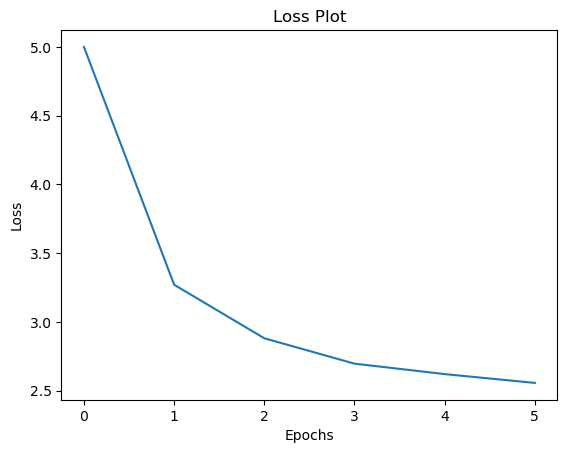

In [118]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [120]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

     #start_token = word_to_index(SEQ_START)
      #end_token = word_to_index(SEQ_END)

    decoder_input = tf.expand_dims([word2index(SEQ_START)], 0)
    result = []

    for i in range(MAX_LENGTH):
        # create look ahead mask and padding mask
        look_ahead_mask = create_look_ahead_mask(tf.shape(decoder_input)[1])
        dec_padding_mask = None     # BUG: can't use padding mask for some unknown reasons.
        predictions, attention_weights = transformer(input=img_tensor_val,
                                                     target=decoder_input,
                                                     training=False,
                                                     look_ahead_mask=look_ahead_mask,
                                                     dec_padding_mask=dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id[0][0].numpy() == word2index(SEQ_END):
            return result[:-1], attention_weights
        
        predicted_word = tf.compat.as_text(index2word(predicted_id[0][0].numpy()).numpy())
        result.append(predicted_word)
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return result, attention_weights

In [252]:
import numpy as np
import os
from tqdm import tqdm

# Assuming these are defined elsewhere:
# - extract_yolo_features(image_path, max_length)
# - load_test_image(image_path)
# - image_features_extract_model (EfficientNetB7 with pooling='avg')

# Extract and merge features for test image
def extract_and_merge_features(image_path, feature_output_dir, max_yolo_length=1024):
    # Extract YOLOv8 features
    yolo_features = extract_yolo_features(image_path, max_yolo_length)  # Shape: (1024,)

    # Extract EfficientNetB7 features
    img,_ = load_image(image_path)
    img_batch = tf.expand_dims(img, axis=0)  # Shape: (1, 600, 600, 3)
    efficientnet_features = image_features_extract_model(img_batch)[0].numpy()  # Shape: (2560,)

    # Merge: (2560,) + (1024,) → (3584,)
    combined_features = np.concatenate((efficientnet_features, yolo_features), axis=0)

    # Save combined features
    feature_filename = os.path.join(feature_output_dir, os.path.basename(image_path).replace(".jpg", ".npy"))
    np.save(feature_filename, combined_features)

    print(f"✅ Combined features saved: {feature_filename}")

# Example usage
test_image_path = '3767841911_6678052eb6.jpg'
feature_output_dir = 'C://Users//admin//Major_Project_SVS'  # Ensure this exists
#os.makedirs(feature_output_dir, exist_ok=True)

extract_and_merge_features(test_image_path, feature_output_dir)

    


0: 480x640 1 person, 1 bench, 98.1ms
Speed: 20.8ms preprocess, 98.1ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)
✅ Combined features saved: C://Users//admin//Major_Project_SVS\3767841911_6678052eb6.npy


In [254]:
def evaluate1(image_path):
    # Load combined features: (3584,) from .npy file
    #feature_filename = os.path.join(feature_output_dir, os.path.basename(image_path).replace(".jpg", ".npy"))
    combined_features = np.load('3767841911_6678052eb6.npy')  # Shape: (3584,)

    # Reshape to match transformer input: (1, 1, 3584)
    img_tensor_val = tf.convert_to_tensor(combined_features, dtype=tf.float32)
    img_tensor_val = tf.expand_dims(img_tensor_val, axis=0)  # Shape: (1, 3584)
    img_tensor_val = tf.expand_dims(img_tensor_val, axis=1)  # Shape: (1, 1, 3584)

    # Initialize decoder input with <start> token
    decoder_input = tf.expand_dims([word2index(SEQ_START)], 0)  # Shape: (1, 1)
    result = []

    for i in range(MAX_LENGTH):
        # Create look ahead mask
        look_ahead_mask = create_look_ahead_mask(tf.shape(decoder_input)[1])
        dec_padding_mask = None  # Not used due to bug

        # Get predictions from transformer
        predictions, attention_weights = transformer(input=img_tensor_val,
                                                     target=decoder_input,
                                                     training=False,
                                                     look_ahead_mask=look_ahead_mask,
                                                     dec_padding_mask=dec_padding_mask)

        predictions = predictions[:, -1:, :]  # Get last prediction (batch_size, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)  # Shape: (1, 1)

        # Stop if <end> token predicted
        if predicted_id[0][0].numpy() == word2index(SEQ_END):
            return result, attention_weights

        # Get predicted word
        predicted_word = tf.compat.as_text(index2word(predicted_id[0][0].numpy()).numpy())
        result.append(predicted_word)

        # Append predicted_id to decoder input
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return result, attention_weights


In [256]:
def generate(image_path):
    if 'https://' in image_path:
        image_extension = image_path[-4:]
        image_path = tf.keras.utils.get_file('image' + image_extension, origin=image_path)

    result, _ = evaluate1(image_path)
    print('Prediction Caption:', ' '.join(result))
    # opening the image
    plt.imshow(plt.imread(image_path))
    plt.show()

Prediction Caption: a little boy in a blue shirt is playing in a mud .


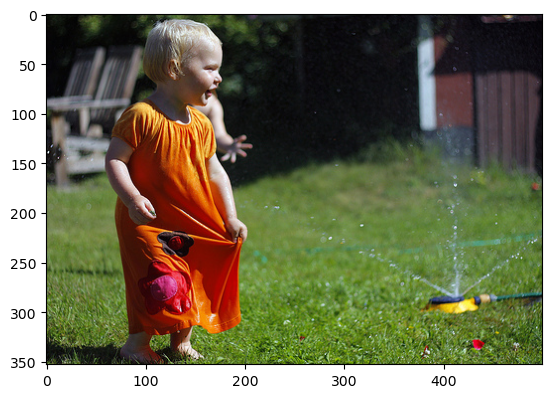

In [262]:
generate('3767841911_6678052eb6.jpg')